In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt



import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda, BatchNormalization
from tensorflow.keras import regularizers


module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
LATENT_DIM = EMB_DIM = 32
HIDDEN_DIM = 100

END_TOKEN = 0

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
#neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')


def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
#neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

## Build G and D of RC-GAN

In [4]:
# noise
z = np.float32(np.random.normal(size=[BATCH_SIZE, T, LATENT_DIM]))

In [5]:
def build_G(batch_size, seq_length, latent_dim, hidden_dim=11):
    # normal LSTM
    i_noise = Input(batch_shape=(batch_size, seq_length, latent_dim), name='noise')  

    whole_seq_output, final_memory_state, final_carry_state = LSTM(hidden_dim, 
                       name='lstm',
                       stateful=True,
                       return_sequences=True,
                       return_state = True, #from RC-GAN
                       unit_forget_bias=True, #from RC-GAN
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_noise)

    ts = Dense(1,
                   activation='relu',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(whole_seq_output)    

    generator = Model(
        inputs=i_noise,
        outputs=ts)
    
    return generator

In [6]:
G = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

In [7]:
# G(z)

In [8]:
def build_D(T, latent_dim, hidden_dim=11):
    i_ts = Input(shape=(T, 1), name='time_stamps')
    
    whole_seq_output, final_memory_state, final_carry_state = LSTM(hidden_dim, 
                       name='lstm',
                       #stateful=True,
                       return_sequences=False,
                       return_state = True, #from RC-GAN
                       unit_forget_bias=True, #from RC-GAN
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_ts)
    

    logits = Dense(1,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(whole_seq_output)    
    
    prob = tf.math.sigmoid(logits)
    
    discriminator = Model(
        inputs=i_ts,
        outputs=[prob, logits])

    return discriminator

In [9]:
D = build_D(T=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

## Traning G and D with different noises

In [42]:
def train_generator(generator, discriminator, batch_size, T, latent_dim, mc_size=10, verbose=False,                   
                    optimizer=Adam(lr=0.001), end_token=0, init_token=1):
            
    z = np.float32(np.random.normal(size=[batch_size, T, latent_dim]))
    
    with tf.GradientTape() as tape:                        

        G_sample = generator(z)
        D_fake, D_logit_fake = discriminator(G_sample)

        generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator(real_data_batch, generator, discriminator, batch_size, T, latent_dim, verbose=False,
                        optimizer=Adam(lr=0.001)):

    # data prep
    real_labels = tf.ones((batch_size, 1))        
    fake_labels = tf.zeros((batch_size, 1))    
    
    z = np.float32(np.random.normal(size=[batch_size, T, latent_dim]))
    fake_data_batch = np.array(generator(z))
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob, pred_logits = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [43]:
G = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

D = build_D(T=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/envs/basileus/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 4167, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/opt/conda/envs/basileus/lib/python3.7/site-packages/tensorflow_core/python/util/tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)


In [44]:
N_total_G = pos_timestamp_seqs.shape[0]

EPOCHS = 30
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_timestamp_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 10
_D_STEPS = 1

In [47]:
for time_stamp_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator(G, D, BATCH_SIZE, T, LATENT_DIM, mc_size=100, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator(time_stamp_batch, G, D, BATCH_SIZE, T, LATENT_DIM, verbose=True, optimizer=D_optimizer)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())

0it [00:00, ?it/s]

Training Step: 1335
generator loss:3.940671682357788
-----------------------
generator loss:3.9402236938476562
-----------------------
generator loss:3.9397740364074707
-----------------------
generator loss:3.9393200874328613
-----------------------
generator loss:3.938859462738037
-----------------------
generator loss:3.9383950233459473
-----------------------
generator loss:3.93792462348938
-----------------------
generator loss:3.937448501586914
-----------------------
generator loss:3.9369664192199707
-----------------------
generator loss:3.9364800453186035
-----------------------


1it [00:01,  1.28s/it]

total discriminator loss:0.015416368842124939
average true return:0.015416368842124939
-----------------------
Training Step: 1336
generator loss:3.942300319671631
-----------------------
generator loss:3.941849946975708
-----------------------
generator loss:3.9413962364196777
-----------------------
generator loss:3.9409399032592773
-----------------------
generator loss:3.9404804706573486
-----------------------
generator loss:3.9400172233581543
-----------------------
generator loss:3.939549446105957
-----------------------
generator loss:3.9390769004821777
-----------------------
generator loss:3.9386000633239746
-----------------------
generator loss:3.9381189346313477
-----------------------


2it [00:02,  1.17s/it]

total discriminator loss:0.015116287395358086
average true return:0.015116287395358086
-----------------------
Training Step: 1337
generator loss:3.9439263343811035
-----------------------
generator loss:3.943477153778076
-----------------------
generator loss:3.943025588989258
-----------------------
generator loss:3.942573070526123
-----------------------
generator loss:3.942115306854248
-----------------------
generator loss:3.9416542053222656
-----------------------
generator loss:3.941190242767334
-----------------------
generator loss:3.9407219886779785
-----------------------
generator loss:3.940248489379883
-----------------------
generator loss:3.9397692680358887
-----------------------


3it [00:03,  1.13s/it]

total discriminator loss:0.015174373984336853
average true return:0.015174373984336853
-----------------------
Training Step: 1338
generator loss:3.9456074237823486
-----------------------
generator loss:3.945157527923584
-----------------------
generator loss:3.9447083473205566
-----------------------
generator loss:3.944253444671631
-----------------------
generator loss:3.9437971115112305
-----------------------
generator loss:3.9433350563049316
-----------------------
generator loss:3.9428701400756836
-----------------------
generator loss:3.9424002170562744
-----------------------
generator loss:3.941927433013916
-----------------------
generator loss:3.941446304321289
-----------------------


4it [00:04,  1.12s/it]

total discriminator loss:0.015104252845048904
average true return:0.015104252845048904
-----------------------
Training Step: 1339
generator loss:3.9473419189453125
-----------------------
generator loss:3.946890115737915
-----------------------
generator loss:3.9464335441589355
-----------------------
generator loss:3.9459762573242188
-----------------------
generator loss:3.9455134868621826
-----------------------
generator loss:3.9450478553771973
-----------------------
generator loss:3.944577693939209
-----------------------
generator loss:3.9441018104553223
-----------------------
generator loss:3.9436216354370117
-----------------------
generator loss:3.9431352615356445
-----------------------
total discriminator loss:0.01516194548457861
average true return:0.01516194548457861
-----------------------


5it [00:05,  1.10s/it]

Training Step: 1340
generator loss:3.949066400527954
-----------------------
generator loss:3.9486072063446045
-----------------------
generator loss:3.948143482208252
-----------------------
generator loss:3.947676658630371
-----------------------
generator loss:3.947206497192383
-----------------------
generator loss:3.946732521057129
-----------------------
generator loss:3.946253776550293
-----------------------
generator loss:3.9457693099975586
-----------------------
generator loss:3.945280075073242
-----------------------


6it [00:06,  1.10s/it]

generator loss:3.9447832107543945
-----------------------
total discriminator loss:0.015135815367102623
average true return:0.015135815367102623
-----------------------
Training Step: 1341
generator loss:3.95074725151062
-----------------------
generator loss:3.9502782821655273
-----------------------
generator loss:3.9498071670532227
-----------------------
generator loss:3.9493308067321777
-----------------------
generator loss:3.9488515853881836
-----------------------
generator loss:3.9483680725097656
-----------------------
generator loss:3.947878360748291
-----------------------
generator loss:3.9473838806152344
-----------------------
generator loss:3.946884870529175
-----------------------
generator loss:3.946377992630005
-----------------------


7it [00:07,  1.10s/it]

total discriminator loss:0.015090533532202244
average true return:0.015090533532202244
-----------------------
Training Step: 1342
generator loss:3.9523417949676514
-----------------------
generator loss:3.951864242553711
-----------------------
generator loss:3.951383590698242
-----------------------
generator loss:3.950899124145508
-----------------------
generator loss:3.9504103660583496
-----------------------
generator loss:3.9499168395996094
-----------------------
generator loss:3.949418544769287
-----------------------
generator loss:3.948915481567383
-----------------------
generator loss:3.948406934738159
-----------------------
generator loss:3.9478907585144043
-----------------------
total discriminator loss:0.018648572266101837
average true return:0.018648572266101837
-----------------------


8it [00:08,  1.09s/it]

Training Step: 1343
generator loss:3.9516966342926025
-----------------------
generator loss:3.9511382579803467
-----------------------
generator loss:3.9505691528320312
-----------------------
generator loss:3.949991226196289
-----------------------
generator loss:3.94940185546875
-----------------------
generator loss:3.9488015174865723
-----------------------
generator loss:3.9481911659240723
-----------------------
generator loss:3.947567939758301
-----------------------
generator loss:3.946934461593628
-----------------------
generator loss:3.9462878704071045
-----------------------
total discriminator loss:0.015699822455644608
average true return:0.015699822455644608
-----------------------


9it [00:10,  1.10s/it]

Training Step: 1344
generator loss:3.949125289916992
-----------------------
generator loss:3.9484500885009766
-----------------------
generator loss:3.9477620124816895
-----------------------
generator loss:3.9470603466033936
-----------------------
generator loss:3.9463443756103516
-----------------------
generator loss:3.945614814758301
-----------------------
generator loss:3.9448728561401367
-----------------------
generator loss:3.944113254547119
-----------------------
generator loss:3.9433398246765137
-----------------------
generator loss:3.9425511360168457
-----------------------
total discriminator loss:0.014826483093202114
average true return:0.014826483093202114
-----------------------


10it [00:11,  1.09s/it]

Training Step: 1345
generator loss:3.9484872817993164
-----------------------
generator loss:3.94773530960083
-----------------------
generator loss:3.9469733238220215
-----------------------
generator loss:3.946201801300049
-----------------------
generator loss:3.945418357849121
-----------------------
generator loss:3.944624423980713
-----------------------
generator loss:3.943817615509033
-----------------------
generator loss:3.9429965019226074
-----------------------
generator loss:3.9421637058258057
-----------------------
generator loss:3.9413161277770996
-----------------------
total discriminator loss:0.014991531148552895
average true return:0.014991531148552895
-----------------------


11it [00:12,  1.09s/it]

Training Step: 1346
generator loss:3.950864315032959
-----------------------
generator loss:3.95013165473938
-----------------------
generator loss:3.9493963718414307
-----------------------
generator loss:3.9486589431762695
-----------------------
generator loss:3.947915554046631
-----------------------
generator loss:3.9471659660339355
-----------------------
generator loss:3.9464097023010254
-----------------------
generator loss:3.945645809173584
-----------------------
generator loss:3.9448719024658203
-----------------------
generator loss:3.944091796875
-----------------------


12it [00:13,  1.10s/it]

total discriminator loss:0.01496889628469944
average true return:0.01496889628469944
-----------------------
Training Step: 1347
generator loss:3.953801155090332
-----------------------
generator loss:3.9531702995300293
-----------------------
generator loss:3.9525418281555176
-----------------------
generator loss:3.951913833618164
-----------------------
generator loss:3.9512882232666016
-----------------------
generator loss:3.9506611824035645
-----------------------
generator loss:3.95003080368042
-----------------------
generator loss:3.9493982791900635
-----------------------
generator loss:3.9487626552581787
-----------------------
generator loss:3.948120594024658
-----------------------
total discriminator loss:0.0150676891207695


13it [00:14,  1.09s/it]

average true return:0.0150676891207695
-----------------------
Training Step: 1348
generator loss:3.95499849319458
-----------------------
generator loss:3.954489231109619
-----------------------
generator loss:3.9539828300476074
-----------------------
generator loss:3.9534811973571777
-----------------------
generator loss:3.9529812335968018
-----------------------
generator loss:3.952481985092163
-----------------------
generator loss:3.951983690261841
-----------------------
generator loss:3.9514851570129395
-----------------------
generator loss:3.950984001159668
-----------------------
generator loss:3.950481414794922
-----------------------


14it [00:15,  1.09s/it]

total discriminator loss:0.015083272941410542
average true return:0.015083272941410542
-----------------------
Training Step: 1349
generator loss:3.9547548294067383
-----------------------
generator loss:3.9543418884277344
-----------------------
generator loss:3.953932285308838
-----------------------
generator loss:3.953526496887207
-----------------------
generator loss:3.9531216621398926
-----------------------
generator loss:3.9527175426483154
-----------------------
generator loss:3.952314853668213
-----------------------
generator loss:3.951911449432373
-----------------------
generator loss:3.9515082836151123
-----------------------
generator loss:3.9511027336120605
-----------------------


15it [00:16,  1.12s/it]

total discriminator loss:0.014773840084671974
average true return:0.014773840084671974
-----------------------
Training Step: 1350
generator loss:3.9546608924865723
-----------------------
generator loss:3.9543099403381348
-----------------------
generator loss:3.953960418701172
-----------------------
generator loss:3.9536123275756836
-----------------------
generator loss:3.9532642364501953
-----------------------
generator loss:3.9529175758361816
-----------------------
generator loss:3.9525692462921143
-----------------------
generator loss:3.9522218704223633
-----------------------
generator loss:3.9518725872039795
-----------------------
generator loss:3.9515221118927
-----------------------
total discriminator loss:0.014930833131074905
average true return:0.014930833131074905
-----------------------


16it [00:17,  1.11s/it]

Training Step: 1351
generator loss:3.9559812545776367
-----------------------
generator loss:3.955658197402954
-----------------------
generator loss:3.9553346633911133
-----------------------
generator loss:3.955012321472168
-----------------------
generator loss:3.954688787460327
-----------------------
generator loss:3.95436429977417
-----------------------
generator loss:3.9540371894836426
-----------------------
generator loss:3.953709363937378
-----------------------
generator loss:3.953380584716797
-----------------------


17it [00:18,  1.11s/it]

generator loss:3.9530487060546875
-----------------------
total discriminator loss:0.015005199238657951
average true return:0.015005199238657951
-----------------------
Training Step: 1352
generator loss:3.958895444869995
-----------------------
generator loss:3.958573579788208
-----------------------
generator loss:3.958249807357788
-----------------------
generator loss:3.9579241275787354
-----------------------
generator loss:3.957597255706787
-----------------------
generator loss:3.9572665691375732
-----------------------
generator loss:3.9569344520568848
-----------------------
generator loss:3.9565982818603516
-----------------------
generator loss:3.9562594890594482
-----------------------


18it [00:19,  1.11s/it]

generator loss:3.9559173583984375
-----------------------
total discriminator loss:0.015135927125811577
average true return:0.015135927125811577
-----------------------
Training Step: 1353
generator loss:3.9626684188842773
-----------------------
generator loss:3.9623234272003174
-----------------------
generator loss:3.961973190307617
-----------------------
generator loss:3.961620569229126
-----------------------
generator loss:3.9612631797790527
-----------------------
generator loss:3.960902214050293
-----------------------
generator loss:3.9605374336242676
-----------------------
generator loss:3.96016788482666
-----------------------
generator loss:3.9597930908203125
-----------------------
generator loss:3.9594149589538574
-----------------------


19it [00:21,  1.10s/it]

total discriminator loss:0.014928826130926609
average true return:0.014928826130926609
-----------------------
Training Step: 1354
generator loss:3.9661777019500732
-----------------------
generator loss:3.9657840728759766
-----------------------
generator loss:3.965385913848877
-----------------------
generator loss:3.964979648590088
-----------------------
generator loss:3.9645705223083496
-----------------------
generator loss:3.964153289794922
-----------------------
generator loss:3.963730812072754
-----------------------
generator loss:3.963301181793213
-----------------------
generator loss:3.9628663063049316
-----------------------
generator loss:3.962423324584961
-----------------------


20it [00:22,  1.10s/it]

total discriminator loss:0.015131361782550812
average true return:0.015131361782550812
-----------------------
Training Step: 1355
generator loss:3.968526601791382
-----------------------
generator loss:3.968064785003662
-----------------------
generator loss:3.9675965309143066
-----------------------
generator loss:3.9671201705932617
-----------------------
generator loss:3.9666342735290527
-----------------------
generator loss:3.96614146232605
-----------------------
generator loss:3.965642213821411
-----------------------
generator loss:3.9651310443878174
-----------------------
generator loss:3.9646129608154297
-----------------------
generator loss:3.9640865325927734
-----------------------


21it [00:23,  1.10s/it]

total discriminator loss:0.014794228598475456
average true return:0.014794228598475456
-----------------------
Training Step: 1356
generator loss:3.969621181488037
-----------------------
generator loss:3.9690823554992676
-----------------------
generator loss:3.968536615371704
-----------------------
generator loss:3.967979907989502
-----------------------
generator loss:3.9674148559570312
-----------------------
generator loss:3.9668407440185547
-----------------------
generator loss:3.9662580490112305
-----------------------
generator loss:3.965663433074951
-----------------------
generator loss:3.9650588035583496
-----------------------
generator loss:3.964444875717163
-----------------------


22it [00:24,  1.10s/it]

total discriminator loss:0.015424292534589767
average true return:0.015424292534589767
-----------------------
Training Step: 1357
generator loss:3.9700918197631836
-----------------------
generator loss:3.9694900512695312
-----------------------
generator loss:3.968878746032715
-----------------------
generator loss:3.9682607650756836
-----------------------
generator loss:3.9676339626312256
-----------------------
generator loss:3.9669971466064453
-----------------------
generator loss:3.9663519859313965
-----------------------
generator loss:3.965693473815918
-----------------------
generator loss:3.9650282859802246
-----------------------


23it [00:25,  1.10s/it]

generator loss:3.9643497467041016
-----------------------
total discriminator loss:0.014729451388120651
average true return:0.014729451388120651
-----------------------
Training Step: 1358
generator loss:3.9708967208862305
-----------------------
generator loss:3.970268726348877
-----------------------
generator loss:3.9696362018585205
-----------------------
generator loss:3.968996524810791
-----------------------
generator loss:3.968350410461426
-----------------------
generator loss:3.967698097229004
-----------------------
generator loss:3.967038154602051
-----------------------
generator loss:3.96636962890625
-----------------------
generator loss:3.965691089630127
-----------------------


24it [00:26,  1.10s/it]

generator loss:3.9650025367736816
-----------------------
total discriminator loss:0.01499297097325325
average true return:0.01499297097325325
-----------------------
Training Step: 1359
generator loss:3.972318410873413
-----------------------
generator loss:3.97171688079834
-----------------------
generator loss:3.9711124897003174
-----------------------
generator loss:3.970506191253662
-----------------------
generator loss:3.9698972702026367
-----------------------
generator loss:3.969282865524292
-----------------------
generator loss:3.9686636924743652
-----------------------
generator loss:3.968039035797119
-----------------------
generator loss:3.967407703399658
-----------------------
generator loss:3.9667696952819824
-----------------------


25it [00:27,  1.10s/it]

total discriminator loss:0.014880439266562462
average true return:0.014880439266562462
-----------------------
Training Step: 1360
generator loss:3.973829746246338
-----------------------
generator loss:3.9732916355133057
-----------------------
generator loss:3.972754955291748
-----------------------
generator loss:3.9722177982330322
-----------------------
generator loss:3.9716808795928955
-----------------------
generator loss:3.9711406230926514
-----------------------
generator loss:3.970597982406616
-----------------------
generator loss:3.9700536727905273
-----------------------
generator loss:3.9695053100585938
-----------------------


26it [00:28,  1.10s/it]

generator loss:3.968952178955078
-----------------------
total discriminator loss:0.014673538506031036
average true return:0.014673538506031036
-----------------------
Training Step: 1361
generator loss:3.9749715328216553
-----------------------
generator loss:3.9745101928710938
-----------------------
generator loss:3.9740500450134277
-----------------------
generator loss:3.973590850830078
-----------------------
generator loss:3.973132610321045
-----------------------
generator loss:3.972675323486328
-----------------------
generator loss:3.972215414047241
-----------------------
generator loss:3.9717540740966797
-----------------------
generator loss:3.9712905883789062
-----------------------
generator loss:3.9708237648010254
-----------------------


27it [00:29,  1.10s/it]

total discriminator loss:0.014545686542987823
average true return:0.014545686542987823
-----------------------
Training Step: 1362
generator loss:3.9759023189544678
-----------------------
generator loss:3.975505828857422
-----------------------
generator loss:3.975111722946167
-----------------------
generator loss:3.9747185707092285
-----------------------
generator loss:3.9743258953094482
-----------------------
generator loss:3.9739327430725098
-----------------------
generator loss:3.973539352416992
-----------------------
generator loss:3.973145008087158
-----------------------
generator loss:3.9727485179901123
-----------------------
generator loss:3.9723496437072754
-----------------------
total discriminator loss:0.014910323545336723
average true return:0.014910323545336723


28it [00:30,  1.10s/it]

-----------------------
Training Step: 1363
generator loss:3.97719669342041
-----------------------
generator loss:3.97684383392334
-----------------------
generator loss:3.9764909744262695
-----------------------
generator loss:3.976139545440674
-----------------------
generator loss:3.975788116455078
-----------------------
generator loss:3.9754347801208496
-----------------------
generator loss:3.975080966949463
-----------------------
generator loss:3.9747259616851807
-----------------------
generator loss:3.9743690490722656
-----------------------
generator loss:3.9740095138549805


29it [00:32,  1.10s/it]

-----------------------
total discriminator loss:0.01436530239880085
average true return:0.01436530239880085
-----------------------
Training Step: 1364
generator loss:3.979267120361328
-----------------------
generator loss:3.9789342880249023
-----------------------
generator loss:3.97860050201416
-----------------------
generator loss:3.9782676696777344
-----------------------
generator loss:3.9779324531555176
-----------------------
generator loss:3.9775943756103516
-----------------------
generator loss:3.9772567749023438
-----------------------
generator loss:3.976916551589966
-----------------------
generator loss:3.9765725135803223
-----------------------
generator loss:3.976224899291992
-----------------------
total discriminator loss:0.014576254412531853
average true return:0.014576254412531853
-----------------------


30it [00:33,  1.13s/it]

Training Step: 1365
generator loss:3.982029438018799
-----------------------
generator loss:3.981694221496582
-----------------------
generator loss:3.981356620788574
-----------------------
generator loss:3.9810173511505127
-----------------------
generator loss:3.9806761741638184
-----------------------
generator loss:3.9803318977355957
-----------------------
generator loss:3.979983329772949
-----------------------
generator loss:3.979631185531616
-----------------------
generator loss:3.979276657104492
-----------------------
generator loss:3.9789185523986816
-----------------------


31it [00:34,  1.12s/it]

total discriminator loss:0.015543009154498577
average true return:0.015543009154498577
-----------------------
Training Step: 1366
generator loss:3.98510479927063
-----------------------
generator loss:3.984736919403076
-----------------------
generator loss:3.9843649864196777
-----------------------
generator loss:3.983987331390381
-----------------------
generator loss:3.9836039543151855
-----------------------
generator loss:3.983217716217041
-----------------------
generator loss:3.9828245639801025
-----------------------
generator loss:3.9824259281158447
-----------------------
generator loss:3.982022762298584
-----------------------
generator loss:3.9816131591796875
-----------------------


32it [00:35,  1.12s/it]

total discriminator loss:0.01476677693426609
average true return:0.01476677693426609
-----------------------
Training Step: 1367
generator loss:3.9873385429382324
-----------------------
generator loss:3.986912488937378
-----------------------
generator loss:3.9864797592163086
-----------------------
generator loss:3.986039638519287
-----------------------
generator loss:3.985592842102051
-----------------------
generator loss:3.985137939453125
-----------------------
generator loss:3.9846765995025635
-----------------------
generator loss:3.9842073917388916
-----------------------
generator loss:3.983731269836426
-----------------------
generator loss:3.9832468032836914
-----------------------
total discriminator loss:0.014210600405931473
average true return:0.014210600405931473
-----------------------


33it [00:36,  1.11s/it]

Training Step: 1368
generator loss:3.9886090755462646
-----------------------
generator loss:3.988111972808838
-----------------------
generator loss:3.987607479095459
-----------------------
generator loss:3.9870941638946533
-----------------------
generator loss:3.9865713119506836
-----------------------
generator loss:3.9860401153564453
-----------------------
generator loss:3.9855008125305176
-----------------------
generator loss:3.9849517345428467
-----------------------
generator loss:3.9843928813934326
-----------------------
generator loss:3.98382568359375
-----------------------


34it [00:37,  1.10s/it]

total discriminator loss:0.014500138349831104
average true return:0.014500138349831104
-----------------------
Training Step: 1369
generator loss:3.989415168762207
-----------------------
generator loss:3.9888548851013184
-----------------------
generator loss:3.988285541534424
-----------------------
generator loss:3.98770809173584
-----------------------
generator loss:3.9871225357055664
-----------------------
generator loss:3.9865293502807617
-----------------------
generator loss:3.9859249591827393
-----------------------
generator loss:3.985311508178711
-----------------------
generator loss:3.9846887588500977
-----------------------
generator loss:3.9840550422668457
-----------------------
total discriminator loss:0.014574965462088585
average true return:0.014574965462088585
-----------------------


35it [00:38,  1.09s/it]

Training Step: 1370
generator loss:3.990429639816284
-----------------------
generator loss:3.9898359775543213
-----------------------
generator loss:3.9892354011535645
-----------------------
generator loss:3.9886302947998047
-----------------------
generator loss:3.988018035888672
-----------------------
generator loss:3.987396717071533
-----------------------
generator loss:3.9867701530456543
-----------------------
generator loss:3.986133575439453
-----------------------
generator loss:3.985487699508667
-----------------------
generator loss:3.984833002090454
-----------------------
total discriminator loss:0.01446750108152628


36it [00:39,  1.09s/it]

average true return:0.01446750108152628
-----------------------
Training Step: 1371
generator loss:3.9916930198669434
-----------------------
generator loss:3.9911060333251953
-----------------------
generator loss:3.990515947341919
-----------------------
generator loss:3.9899215698242188
-----------------------
generator loss:3.9893226623535156
-----------------------
generator loss:3.988720178604126
-----------------------
generator loss:3.9881105422973633
-----------------------
generator loss:3.987495183944702
-----------------------
generator loss:3.9868721961975098
-----------------------
generator loss:3.986241340637207
-----------------------


37it [00:40,  1.09s/it]

total discriminator loss:0.014311714097857475
average true return:0.014311714097857475
-----------------------
Training Step: 1372
generator loss:3.9930901527404785
-----------------------
generator loss:3.9925460815429688
-----------------------
generator loss:3.9920029640197754
-----------------------
generator loss:3.9914584159851074
-----------------------
generator loss:3.9909110069274902
-----------------------
generator loss:3.9903619289398193
-----------------------
generator loss:3.989809989929199
-----------------------
generator loss:3.9892518520355225
-----------------------
generator loss:3.988690137863159
-----------------------
generator loss:3.9881234169006348
-----------------------
total discriminator loss:0.01430556084960699
average true return:0.01430556084960699
-----------------------


38it [00:41,  1.09s/it]

Training Step: 1373
generator loss:3.994227409362793
-----------------------
generator loss:3.9937469959259033
-----------------------
generator loss:3.9932680130004883
-----------------------
generator loss:3.992788791656494
-----------------------
generator loss:3.9923095703125
-----------------------
generator loss:3.9918296337127686
-----------------------
generator loss:3.991347551345825
-----------------------
generator loss:3.9908626079559326
-----------------------
generator loss:3.9903745651245117
-----------------------
generator loss:3.989882469177246
-----------------------


39it [00:43,  1.09s/it]

total discriminator loss:0.014316139742732048
average true return:0.014316139742732048
-----------------------
Training Step: 1374
generator loss:3.9951584339141846
-----------------------
generator loss:3.994739294052124
-----------------------
generator loss:3.9943227767944336
-----------------------
generator loss:3.9939064979553223
-----------------------
generator loss:3.9934897422790527
-----------------------
generator loss:3.993072509765625
-----------------------
generator loss:3.9926555156707764
-----------------------
generator loss:3.992234945297241
-----------------------
generator loss:3.9918131828308105
-----------------------
generator loss:3.9913876056671143
-----------------------


40it [00:44,  1.09s/it]

total discriminator loss:0.014525794424116611
average true return:0.014525794424116611
-----------------------
Training Step: 1375
generator loss:3.9962668418884277
-----------------------
generator loss:3.99589467048645
-----------------------
generator loss:3.9955239295959473
-----------------------
generator loss:3.99515438079834
-----------------------
generator loss:3.9947829246520996
-----------------------
generator loss:3.9944119453430176
-----------------------
generator loss:3.99403977394104
-----------------------
generator loss:3.9936652183532715
-----------------------
generator loss:3.993288516998291
-----------------------
generator loss:3.992910385131836
-----------------------
total discriminator loss:0.014444118365645409
average true return:0.014444118365645409
-----------------------


41it [00:45,  1.08s/it]

Training Step: 1376
generator loss:3.99794340133667
-----------------------
generator loss:3.9976000785827637
-----------------------
generator loss:3.9972567558288574
-----------------------
generator loss:3.996912717819214
-----------------------
generator loss:3.9965670108795166
-----------------------
generator loss:3.996220588684082
-----------------------
generator loss:3.9958724975585938
-----------------------
generator loss:3.9955224990844727
-----------------------
generator loss:3.995169162750244
-----------------------
generator loss:3.9948129653930664
-----------------------


42it [00:46,  1.08s/it]

total discriminator loss:0.014180021360516548
average true return:0.014180021360516548
-----------------------
Training Step: 1377
generator loss:4.000254154205322
-----------------------
generator loss:3.999919891357422
-----------------------
generator loss:3.9995827674865723
-----------------------
generator loss:3.9992446899414062
-----------------------
generator loss:3.998905658721924
-----------------------
generator loss:3.9985623359680176
-----------------------
generator loss:3.9982168674468994
-----------------------
generator loss:3.9978694915771484
-----------------------
generator loss:3.997518301010132
-----------------------
generator loss:3.997163772583008
-----------------------
total discriminator loss:0.014792813919484615
average true return:0.014792813919484615
-----------------------


43it [00:47,  1.08s/it]

Training Step: 1378
generator loss:4.002897262573242
-----------------------
generator loss:4.00255012512207
-----------------------
generator loss:4.002201080322266
-----------------------
generator loss:4.001849174499512
-----------------------
generator loss:4.001494407653809
-----------------------
generator loss:4.001134872436523
-----------------------
generator loss:4.000771522521973
-----------------------
generator loss:4.000404357910156
-----------------------
generator loss:4.000033855438232
-----------------------
generator loss:3.999657154083252
-----------------------
total discriminator loss:0.014096514321863651
average true return:0.014096514321863651
-----------------------


44it [00:48,  1.08s/it]

Training Step: 1379
generator loss:4.005418300628662
-----------------------
generator loss:4.005043029785156
-----------------------
generator loss:4.00466251373291
-----------------------
generator loss:4.004279136657715
-----------------------
generator loss:4.003889083862305
-----------------------
generator loss:4.0034966468811035
-----------------------
generator loss:4.003098487854004
-----------------------
generator loss:4.0026936531066895
-----------------------
generator loss:4.002283573150635
-----------------------
generator loss:4.001869201660156
-----------------------


45it [00:49,  1.11s/it]

total discriminator loss:0.014126032590866089
average true return:0.014126032590866089
-----------------------
Training Step: 1380
generator loss:4.007470607757568
-----------------------
generator loss:4.007053852081299
-----------------------
generator loss:4.006629943847656
-----------------------
generator loss:4.00620174407959
-----------------------
generator loss:4.005768299102783
-----------------------
generator loss:4.005326271057129
-----------------------
generator loss:4.004879951477051
-----------------------
generator loss:4.004427433013916
-----------------------
generator loss:4.003966331481934
-----------------------
generator loss:4.0034990310668945
-----------------------


46it [00:50,  1.11s/it]

total discriminator loss:0.014475067146122456
average true return:0.014475067146122456
-----------------------
Training Step: 1381
generator loss:4.008988857269287
-----------------------
generator loss:4.008523941040039
-----------------------
generator loss:4.008053302764893
-----------------------
generator loss:4.007576942443848
-----------------------
generator loss:4.007094383239746
-----------------------
generator loss:4.00660514831543
-----------------------
generator loss:4.006107330322266
-----------------------
generator loss:4.00560188293457
-----------------------
generator loss:4.005089282989502
-----------------------
generator loss:4.004569053649902
-----------------------
total discriminator loss:0.014226309955120087
average true return:0.014226309955120087
-----------------------


47it [00:51,  1.10s/it]

Training Step: 1382
generator loss:4.010262489318848
-----------------------
generator loss:4.009759902954102
-----------------------
generator loss:4.009251117706299
-----------------------
generator loss:4.008738040924072
-----------------------
generator loss:4.008217811584473
-----------------------
generator loss:4.0076904296875
-----------------------
generator loss:4.0071563720703125
-----------------------
generator loss:4.006612777709961
-----------------------
generator loss:4.006064414978027
-----------------------
generator loss:4.00550651550293
-----------------------


48it [00:52,  1.10s/it]

total discriminator loss:0.014153671450912952
average true return:0.014153671450912952
-----------------------
Training Step: 1383
generator loss:4.0115814208984375
-----------------------
generator loss:4.011061191558838
-----------------------
generator loss:4.010537624359131
-----------------------
generator loss:4.010009288787842
-----------------------
generator loss:4.0094757080078125
-----------------------
generator loss:4.008936882019043
-----------------------
generator loss:4.008391857147217
-----------------------
generator loss:4.007839202880859
-----------------------
generator loss:4.007279872894287
-----------------------
generator loss:4.0067138671875
-----------------------


49it [00:53,  1.10s/it]

total discriminator loss:0.014004194177687168
average true return:0.014004194177687168
-----------------------
Training Step: 1384
generator loss:4.012988090515137
-----------------------
generator loss:4.012477874755859
-----------------------
generator loss:4.011964797973633
-----------------------
generator loss:4.01145076751709
-----------------------
generator loss:4.010931968688965
-----------------------
generator loss:4.010409355163574
-----------------------
generator loss:4.009881973266602
-----------------------
generator loss:4.0093488693237305
-----------------------
generator loss:4.008810043334961
-----------------------
generator loss:4.008265495300293
-----------------------


50it [00:55,  1.09s/it]

total discriminator loss:0.014101304113864899
average true return:0.014101304113864899
-----------------------
Training Step: 1385
generator loss:4.014364242553711
-----------------------
generator loss:4.013885498046875
-----------------------
generator loss:4.013405799865723
-----------------------
generator loss:4.0129241943359375
-----------------------
generator loss:4.012442588806152
-----------------------
generator loss:4.011957168579102
-----------------------
generator loss:4.011468887329102
-----------------------
generator loss:4.010976314544678
-----------------------
generator loss:4.010478973388672
-----------------------
generator loss:4.009976863861084
-----------------------


51it [00:56,  1.09s/it]

total discriminator loss:0.014746125787496567
average true return:0.014746125787496567
-----------------------
Training Step: 1386
generator loss:4.0155863761901855
-----------------------
generator loss:4.015148162841797
-----------------------
generator loss:4.014711380004883
-----------------------
generator loss:4.014272212982178
-----------------------
generator loss:4.013833045959473
-----------------------
generator loss:4.013391494750977
-----------------------
generator loss:4.012948036193848
-----------------------
generator loss:4.012501239776611
-----------------------
generator loss:4.012050628662109
-----------------------
generator loss:4.0115966796875
-----------------------
total discriminator loss:0.01377512700855732
average true return:0.01377512700855732
-----------------------


52it [00:57,  1.09s/it]

Training Step: 1387
generator loss:4.016815185546875
-----------------------
generator loss:4.016417503356934
-----------------------
generator loss:4.016018867492676
-----------------------
generator loss:4.015620231628418
-----------------------
generator loss:4.015220642089844
-----------------------
generator loss:4.014819145202637
-----------------------
generator loss:4.014416217803955
-----------------------
generator loss:4.014010429382324
-----------------------
generator loss:4.0136027336120605
-----------------------
generator loss:4.013190746307373
-----------------------
total discriminator loss:0.014356570318341255
average true return:0.014356570318341255
-----------------------

53it [00:58,  1.08s/it]


Training Step: 1388
generator loss:4.018270492553711
-----------------------
generator loss:4.0178985595703125
-----------------------
generator loss:4.017526626586914
-----------------------
generator loss:4.017153739929199
-----------------------
generator loss:4.016779899597168
-----------------------
generator loss:4.01640510559082
-----------------------
generator loss:4.016026496887207
-----------------------
generator loss:4.0156450271606445
-----------------------
generator loss:4.015261650085449
-----------------------
generator loss:4.014874458312988
-----------------------
total discriminator loss:0.01391695812344551
average true return:0.01391695812344551
-----------------------

54it [00:59,  1.08s/it]


Training Step: 1389
generator loss:4.020041465759277
-----------------------
generator loss:4.019684314727783
-----------------------
generator loss:4.019325256347656
-----------------------
generator loss:4.018964767456055
-----------------------
generator loss:4.018601417541504
-----------------------
generator loss:4.018237113952637
-----------------------
generator loss:4.01786994934082
-----------------------
generator loss:4.0174994468688965
-----------------------
generator loss:4.017125129699707
-----------------------
generator loss:4.01674747467041
-----------------------
total discriminator loss:0.014179450459778309
average true return:0.014179450459778309
-----------------------


55it [01:00,  1.08s/it]

Training Step: 1390
generator loss:4.022050380706787
-----------------------
generator loss:4.021692752838135
-----------------------
generator loss:4.021332740783691
-----------------------
generator loss:4.020971775054932
-----------------------
generator loss:4.020606994628906
-----------------------
generator loss:4.02023983001709
-----------------------
generator loss:4.01986837387085
-----------------------
generator loss:4.01949405670166
-----------------------
generator loss:4.019115924835205
-----------------------


56it [01:01,  1.09s/it]

generator loss:4.018733024597168
-----------------------
total discriminator loss:0.014120874926447868
average true return:0.014120874926447868
-----------------------
Training Step: 1391
generator loss:4.024111747741699
-----------------------
generator loss:4.023741245269775
-----------------------
generator loss:4.023367881774902
-----------------------
generator loss:4.022992134094238
-----------------------
generator loss:4.022612571716309
-----------------------
generator loss:4.022229194641113
-----------------------
generator loss:4.021841526031494
-----------------------
generator loss:4.021450042724609
-----------------------
generator loss:4.021052360534668
-----------------------
generator loss:4.020650863647461
-----------------------


57it [01:02,  1.08s/it]

total discriminator loss:0.014187481254339218
average true return:0.014187481254339218
-----------------------
Training Step: 1392
generator loss:4.026039123535156
-----------------------
generator loss:4.025646686553955
-----------------------
generator loss:4.025251388549805
-----------------------
generator loss:4.0248517990112305
-----------------------
generator loss:4.024447441101074
-----------------------
generator loss:4.024038314819336
-----------------------
generator loss:4.023624897003174
-----------------------
generator loss:4.02320671081543
-----------------------
generator loss:4.022782325744629
-----------------------
generator loss:4.0223517417907715
-----------------------


58it [01:03,  1.08s/it]

total discriminator loss:0.014107218012213707
average true return:0.014107218012213707
-----------------------
Training Step: 1393
generator loss:4.0277299880981445
-----------------------
generator loss:4.027310371398926
-----------------------
generator loss:4.026885986328125
-----------------------
generator loss:4.026458740234375
-----------------------
generator loss:4.026026725769043
-----------------------
generator loss:4.025588035583496
-----------------------
generator loss:4.025144577026367
-----------------------
generator loss:4.024694442749023
-----------------------
generator loss:4.024238586425781
-----------------------
generator loss:4.023777961730957
-----------------------
total discriminator loss:0.014079251326620579
average true return:0.014079251326620579
-----------------------


59it [01:04,  1.08s/it]

Training Step: 1394
generator loss:4.02922248840332
-----------------------
generator loss:4.028779029846191
-----------------------
generator loss:4.028329849243164
-----------------------
generator loss:4.027877330780029
-----------------------
generator loss:4.0274200439453125
-----------------------
generator loss:4.026957035064697
-----------------------
generator loss:4.026487350463867
-----------------------
generator loss:4.026011943817139
-----------------------
generator loss:4.025530815124512
-----------------------
generator loss:4.0250420570373535
-----------------------


60it [01:05,  1.11s/it]

total discriminator loss:0.014212556183338165
average true return:0.014212556183338165
-----------------------
Training Step: 1395
generator loss:4.030584335327148
-----------------------
generator loss:4.030123710632324
-----------------------
generator loss:4.029660224914551
-----------------------
generator loss:4.029191493988037
-----------------------
generator loss:4.028718948364258
-----------------------
generator loss:4.028240203857422
-----------------------
generator loss:4.027757167816162
-----------------------
generator loss:4.0272674560546875
-----------------------
generator loss:4.0267720222473145
-----------------------
generator loss:4.026269435882568
-----------------------
total discriminator loss:0.013712788000702858
average true return:0.013712788000702858
-----------------------


61it [01:07,  1.10s/it]

Training Step: 1396
generator loss:4.031929969787598
-----------------------
generator loss:4.031466484069824
-----------------------
generator loss:4.03100061416626
-----------------------
generator loss:4.03053092956543
-----------------------
generator loss:4.030057907104492
-----------------------
generator loss:4.029580593109131
-----------------------
generator loss:4.029097557067871
-----------------------
generator loss:4.028609752655029
-----------------------
generator loss:4.028115749359131
-----------------------
generator loss:4.027616500854492
-----------------------
total discriminator loss:0.013882904313504696
average true return:0.013882904313504696
-----------------------


62it [01:08,  1.10s/it]

Training Step: 1397
generator loss:4.033262252807617
-----------------------
generator loss:4.032808780670166
-----------------------
generator loss:4.032354831695557
-----------------------
generator loss:4.03189754486084
-----------------------
generator loss:4.03143835067749
-----------------------
generator loss:4.030975341796875
-----------------------
generator loss:4.030508041381836
-----------------------
generator loss:4.030035972595215
-----------------------
generator loss:4.029559135437012
-----------------------
generator loss:4.029077529907227
-----------------------


63it [01:09,  1.09s/it]

total discriminator loss:0.013926858082413673
average true return:0.013926858082413673
-----------------------
Training Step: 1398
generator loss:4.034564018249512
-----------------------
generator loss:4.034130096435547
-----------------------
generator loss:4.033697128295898
-----------------------
generator loss:4.033260345458984
-----------------------
generator loss:4.0328216552734375
-----------------------
generator loss:4.032381057739258
-----------------------
generator loss:4.031935691833496
-----------------------
generator loss:4.031487464904785
-----------------------
generator loss:4.031034469604492
-----------------------
generator loss:4.030577659606934
-----------------------


64it [01:10,  1.09s/it]

total discriminator loss:0.013543871231377125
average true return:0.013543871231377125
-----------------------
Training Step: 1399
generator loss:4.035893440246582
-----------------------
generator loss:4.035483360290527
-----------------------
generator loss:4.035072326660156
-----------------------
generator loss:4.034660339355469
-----------------------
generator loss:4.034245491027832
-----------------------
generator loss:4.033829689025879
-----------------------
generator loss:4.033409118652344
-----------------------
generator loss:4.032985687255859
-----------------------
generator loss:4.032559394836426
-----------------------
generator loss:4.032127857208252
-----------------------
total discriminator loss:0.013707857578992844
average true return:0.013707857578992844
-----------------------


65it [01:11,  1.09s/it]

Training Step: 1400
generator loss:4.0373125076293945
-----------------------
generator loss:4.036923885345459
-----------------------
generator loss:4.036533832550049
-----------------------
generator loss:4.036142349243164
-----------------------
generator loss:4.035750389099121
-----------------------
generator loss:4.0353546142578125
-----------------------
generator loss:4.034956932067871
-----------------------
generator loss:4.0345563888549805
-----------------------
generator loss:4.034151077270508
-----------------------
generator loss:4.033743381500244
-----------------------
total discriminator loss:0.014465048909187317
average true return:0.014465048909187317
-----------------------


66it [01:12,  1.08s/it]

Training Step: 1401
generator loss:4.038869380950928
-----------------------
generator loss:4.038494110107422
-----------------------
generator loss:4.038117408752441
-----------------------
generator loss:4.037740707397461
-----------------------
generator loss:4.037360191345215
-----------------------
generator loss:4.036977767944336
-----------------------
generator loss:4.036591529846191
-----------------------
generator loss:4.036202907562256
-----------------------
generator loss:4.0358099937438965
-----------------------
generator loss:4.03541374206543
-----------------------
total discriminator loss:0.014060532674193382
average true return:0.014060532674193382
-----------------------


67it [01:13,  1.08s/it]

Training Step: 1402
generator loss:4.040578365325928
-----------------------
generator loss:4.040205955505371
-----------------------
generator loss:4.039831638336182
-----------------------
generator loss:4.039455413818359
-----------------------
generator loss:4.03907585144043
-----------------------
generator loss:4.038691997528076
-----------------------
generator loss:4.03830623626709
-----------------------
generator loss:4.03791618347168
-----------------------
generator loss:4.037520885467529
-----------------------
generator loss:4.037123203277588
-----------------------
total discriminator loss:0.013822156004607677
average true return:0.013822156004607677
-----------------------


68it [01:14,  1.08s/it]

Training Step: 1403
generator loss:4.042323589324951
-----------------------
generator loss:4.04194450378418
-----------------------
generator loss:4.041563510894775
-----------------------
generator loss:4.0411787033081055
-----------------------
generator loss:4.0407915115356445
-----------------------
generator loss:4.040399074554443
-----------------------
generator loss:4.040004730224609
-----------------------
generator loss:4.039604187011719
-----------------------
generator loss:4.0391998291015625
-----------------------
generator loss:4.038790225982666
-----------------------


69it [01:15,  1.08s/it]

total discriminator loss:0.01395415235310793
average true return:0.01395415235310793
-----------------------
Training Step: 1404
generator loss:4.044015884399414
-----------------------
generator loss:4.0436248779296875
-----------------------
generator loss:4.043230056762695
-----------------------
generator loss:4.042832374572754
-----------------------
generator loss:4.042431831359863
-----------------------
generator loss:4.042025566101074
-----------------------
generator loss:4.0416154861450195
-----------------------
generator loss:4.041201591491699
-----------------------
generator loss:4.040781497955322
-----------------------
generator loss:4.040355682373047
-----------------------


70it [01:16,  1.08s/it]

total discriminator loss:0.013765743933618069
average true return:0.013765743933618069
-----------------------
Training Step: 1405
generator loss:4.045607566833496
-----------------------
generator loss:4.045202255249023
-----------------------
generator loss:4.044793128967285
-----------------------
generator loss:4.044379234313965
-----------------------
generator loss:4.04396390914917
-----------------------
generator loss:4.043540954589844
-----------------------
generator loss:4.04311466217041
-----------------------
generator loss:4.0426836013793945
-----------------------
generator loss:4.0422468185424805
-----------------------
generator loss:4.041805267333984
-----------------------


71it [01:17,  1.08s/it]

total discriminator loss:0.01352396234869957
average true return:0.01352396234869957
-----------------------
Training Step: 1406
generator loss:4.047123908996582
-----------------------
generator loss:4.046704292297363
-----------------------
generator loss:4.046282768249512
-----------------------
generator loss:4.045856475830078
-----------------------
generator loss:4.045426368713379
-----------------------
generator loss:4.044992446899414
-----------------------
generator loss:4.044552803039551
-----------------------
generator loss:4.0441083908081055
-----------------------
generator loss:4.043657302856445
-----------------------
generator loss:4.043201923370361
-----------------------
total discriminator loss:0.013569033704698086
average true return:0.013569033704698086
-----------------------


72it [01:18,  1.08s/it]

Training Step: 1407
generator loss:4.048588752746582
-----------------------
generator loss:4.048163414001465
-----------------------
generator loss:4.047733306884766
-----------------------
generator loss:4.047300338745117
-----------------------
generator loss:4.046863555908203
-----------------------
generator loss:4.046421527862549
-----------------------
generator loss:4.045975685119629
-----------------------
generator loss:4.045525074005127
-----------------------
generator loss:4.045069694519043
-----------------------
generator loss:4.044607162475586
-----------------------
total discriminator loss:0.013741488568484783
average true return:0.013741488568484783
-----------------------


73it [01:20,  1.08s/it]

Training Step: 1408
generator loss:4.050025463104248
-----------------------
generator loss:4.049598217010498
-----------------------
generator loss:4.049169540405273
-----------------------
generator loss:4.048738479614258
-----------------------
generator loss:4.048303604125977
-----------------------
generator loss:4.047863960266113
-----------------------
generator loss:4.047420978546143
-----------------------
generator loss:4.046972751617432
-----------------------
generator loss:4.0465192794799805
-----------------------
generator loss:4.046060562133789
-----------------------


74it [01:21,  1.08s/it]

total discriminator loss:0.013670854270458221
average true return:0.013670854270458221
-----------------------
Training Step: 1409
generator loss:4.05143404006958
-----------------------
generator loss:4.051013946533203
-----------------------
generator loss:4.050592422485352
-----------------------
generator loss:4.050168037414551
-----------------------
generator loss:4.049741744995117
-----------------------
generator loss:4.049311637878418
-----------------------
generator loss:4.048877716064453
-----------------------
generator loss:4.048439025878906
-----------------------
generator loss:4.047996520996094
-----------------------


75it [01:22,  1.12s/it]

generator loss:4.047548294067383
-----------------------
total discriminator loss:0.013670004904270172
average true return:0.013670004904270172
-----------------------
Training Step: 1410
generator loss:4.052820682525635
-----------------------
generator loss:4.052412033081055
-----------------------
generator loss:4.052002429962158
-----------------------
generator loss:4.0515899658203125
-----------------------
generator loss:4.051175594329834
-----------------------
generator loss:4.050757884979248
-----------------------
generator loss:4.050335884094238
-----------------------
generator loss:4.049911022186279
-----------------------
generator loss:4.049481391906738
-----------------------
generator loss:4.049046516418457
-----------------------


76it [01:23,  1.11s/it]

total discriminator loss:0.013530601747334003
average true return:0.013530601747334003
-----------------------
Training Step: 1411
generator loss:4.054233551025391
-----------------------
generator loss:4.053837776184082
-----------------------
generator loss:4.053441047668457
-----------------------
generator loss:4.053040504455566
-----------------------
generator loss:4.052639007568359
-----------------------
generator loss:4.052233695983887
-----------------------
generator loss:4.051826000213623
-----------------------
generator loss:4.0514140129089355
-----------------------
generator loss:4.050998210906982
-----------------------
generator loss:4.0505781173706055
-----------------------


77it [01:24,  1.10s/it]

total discriminator loss:0.0141989104449749
average true return:0.0141989104449749
-----------------------
Training Step: 1412
generator loss:4.055692672729492
-----------------------
generator loss:4.055291652679443
-----------------------
generator loss:4.0548882484436035
-----------------------
generator loss:4.05448055267334
-----------------------
generator loss:4.054070472717285
-----------------------
generator loss:4.053655624389648
-----------------------
generator loss:4.0532379150390625
-----------------------
generator loss:4.0528130531311035
-----------------------
generator loss:4.0523858070373535
-----------------------
generator loss:4.051950931549072
-----------------------


78it [01:25,  1.10s/it]

total discriminator loss:0.013633187860250473
average true return:0.013633187860250473
-----------------------
Training Step: 1413
generator loss:4.057072639465332
-----------------------
generator loss:4.056659698486328
-----------------------
generator loss:4.056241989135742
-----------------------
generator loss:4.055822372436523
-----------------------
generator loss:4.055398464202881
-----------------------
generator loss:4.05496883392334
-----------------------
generator loss:4.054534912109375
-----------------------
generator loss:4.054096221923828
-----------------------
generator loss:4.053650856018066
-----------------------
generator loss:4.053200721740723
-----------------------
total discriminator loss:0.013929886743426323
average true return:0.013929886743426323
-----------------------


79it [01:26,  1.09s/it]

Training Step: 1414
generator loss:4.058345317840576
-----------------------
generator loss:4.057919979095459
-----------------------
generator loss:4.057492256164551
-----------------------
generator loss:4.057061672210693
-----------------------
generator loss:4.056624412536621
-----------------------
generator loss:4.0561842918396
-----------------------
generator loss:4.05573844909668
-----------------------
generator loss:4.055287837982178
-----------------------
generator loss:4.054831027984619
-----------------------
generator loss:4.054368019104004
-----------------------
total discriminator loss:0.013512875884771347
average true return:0.013512875884771347
-----------------------


80it [01:27,  1.09s/it]

Training Step: 1415
generator loss:4.059592247009277
-----------------------
generator loss:4.059162139892578
-----------------------
generator loss:4.05872917175293
-----------------------
generator loss:4.058292388916016
-----------------------
generator loss:4.057851791381836
-----------------------
generator loss:4.057407379150391
-----------------------
generator loss:4.056958198547363
-----------------------
generator loss:4.056503772735596
-----------------------
generator loss:4.05604362487793
-----------------------


81it [01:28,  1.09s/it]

generator loss:4.055578231811523
-----------------------
total discriminator loss:0.013486956246197224
average true return:0.013486956246197224
-----------------------
Training Step: 1416
generator loss:4.060830116271973
-----------------------
generator loss:4.060402870178223
-----------------------
generator loss:4.059970855712891
-----------------------
generator loss:4.059537410736084
-----------------------
generator loss:4.059101104736328
-----------------------
generator loss:4.058660507202148
-----------------------
generator loss:4.058215141296387
-----------------------
generator loss:4.057765007019043
-----------------------
generator loss:4.057309150695801
-----------------------
generator loss:4.056849002838135
-----------------------


82it [01:29,  1.10s/it]

total discriminator loss:0.013814043253660202
average true return:0.013814043253660202
-----------------------
Training Step: 1417
generator loss:4.062030792236328
-----------------------
generator loss:4.061607360839844
-----------------------
generator loss:4.061182022094727
-----------------------
generator loss:4.060754299163818
-----------------------
generator loss:4.060322284698486
-----------------------
generator loss:4.059887886047363
-----------------------
generator loss:4.059448719024658
-----------------------
generator loss:4.059005260467529
-----------------------
generator loss:4.058557033538818
-----------------------
generator loss:4.058102607727051
-----------------------
total discriminator loss:0.013123586773872375
average true return:0.013123586773872375
-----------------------


83it [01:31,  1.10s/it]

Training Step: 1418
generator loss:4.063294410705566
-----------------------
generator loss:4.0628814697265625
-----------------------
generator loss:4.062465667724609
-----------------------
generator loss:4.062047481536865
-----------------------
generator loss:4.061627388000488
-----------------------
generator loss:4.061203956604004
-----------------------
generator loss:4.06077766418457
-----------------------
generator loss:4.06034517288208
-----------------------
generator loss:4.059908866882324
-----------------------


84it [01:32,  1.10s/it]

generator loss:4.059467315673828
-----------------------
total discriminator loss:0.013118023052811623
average true return:0.013118023052811623
-----------------------
Training Step: 1419
generator loss:4.064593315124512
-----------------------
generator loss:4.064192295074463
-----------------------
generator loss:4.063790321350098
-----------------------
generator loss:4.063385963439941
-----------------------
generator loss:4.062979698181152
-----------------------
generator loss:4.062570571899414
-----------------------
generator loss:4.062157154083252
-----------------------
generator loss:4.061739921569824
-----------------------
generator loss:4.061320781707764
-----------------------
generator loss:4.060894012451172
-----------------------


85it [01:33,  1.10s/it]

total discriminator loss:0.013356349430978298
average true return:0.013356349430978298
-----------------------
Training Step: 1420
generator loss:4.065923690795898
-----------------------
generator loss:4.065534591674805
-----------------------
generator loss:4.065145492553711
-----------------------
generator loss:4.064754486083984
-----------------------
generator loss:4.064359188079834
-----------------------
generator loss:4.063962936401367
-----------------------
generator loss:4.063562393188477
-----------------------
generator loss:4.06315803527832
-----------------------
generator loss:4.06274938583374
-----------------------


86it [01:34,  1.10s/it]

generator loss:4.0623369216918945
-----------------------
total discriminator loss:0.013406794518232346
average true return:0.013406794518232346
-----------------------
Training Step: 1421
generator loss:4.067330360412598
-----------------------
generator loss:4.066951751708984
-----------------------
generator loss:4.066570281982422
-----------------------
generator loss:4.066187858581543
-----------------------
generator loss:4.06580114364624
-----------------------
generator loss:4.065412521362305
-----------------------
generator loss:4.065021514892578
-----------------------
generator loss:4.064624786376953
-----------------------
generator loss:4.064226150512695
-----------------------
generator loss:4.063820838928223
-----------------------


87it [01:35,  1.10s/it]

total discriminator loss:0.013786068186163902
average true return:0.013786068186163902
-----------------------
Training Step: 1422
generator loss:4.068812370300293
-----------------------
generator loss:4.06843376159668
-----------------------
generator loss:4.068053245544434
-----------------------
generator loss:4.067670822143555
-----------------------
generator loss:4.067285537719727
-----------------------
generator loss:4.066895484924316
-----------------------
generator loss:4.066502571105957
-----------------------
generator loss:4.066105842590332
-----------------------
generator loss:4.065704345703125
-----------------------
generator loss:4.065298080444336
-----------------------
total discriminator loss:0.013313230127096176


88it [01:36,  1.09s/it]

average true return:0.013313230127096176
-----------------------
Training Step: 1423
generator loss:4.070332050323486
-----------------------
generator loss:4.069949150085449
-----------------------
generator loss:4.0695648193359375
-----------------------
generator loss:4.0691752433776855
-----------------------
generator loss:4.068784713745117
-----------------------
generator loss:4.068388938903809
-----------------------
generator loss:4.067989349365234
-----------------------
generator loss:4.0675859451293945
-----------------------
generator loss:4.0671772956848145
-----------------------
generator loss:4.066762924194336
-----------------------


89it [01:37,  1.09s/it]

total discriminator loss:0.013848762027919292
average true return:0.013848762027919292
-----------------------
Training Step: 1424
generator loss:4.07181453704834
-----------------------
generator loss:4.071422576904297
-----------------------
generator loss:4.071028232574463
-----------------------
generator loss:4.07063102722168
-----------------------
generator loss:4.070230484008789
-----------------------
generator loss:4.069824695587158
-----------------------
generator loss:4.069415092468262
-----------------------
generator loss:4.069000244140625
-----------------------
generator loss:4.0685811042785645
-----------------------
generator loss:4.0681562423706055
-----------------------


90it [01:38,  1.12s/it]

total discriminator loss:0.013516979292035103
average true return:0.013516979292035103
-----------------------
Training Step: 1425
generator loss:4.073213577270508
-----------------------
generator loss:4.072810173034668
-----------------------
generator loss:4.072403907775879
-----------------------
generator loss:4.071993827819824
-----------------------
generator loss:4.071579933166504
-----------------------
generator loss:4.07116174697876
-----------------------
generator loss:4.070738792419434
-----------------------
generator loss:4.070310592651367
-----------------------
generator loss:4.069877624511719
-----------------------
generator loss:4.069438457489014
-----------------------


91it [01:39,  1.11s/it]

total discriminator loss:0.013052461668848991
average true return:0.013052461668848991
-----------------------
Training Step: 1426
generator loss:4.074548721313477
-----------------------
generator loss:4.074135780334473
-----------------------
generator loss:4.0737199783325195
-----------------------
generator loss:4.073299407958984
-----------------------
generator loss:4.0728759765625
-----------------------
generator loss:4.072447299957275
-----------------------
generator loss:4.072015762329102
-----------------------
generator loss:4.071577072143555
-----------------------
generator loss:4.071133613586426
-----------------------


92it [01:40,  1.10s/it]

generator loss:4.07068395614624
-----------------------
total discriminator loss:0.013393965549767017
average true return:0.013393965549767017
-----------------------
Training Step: 1427
generator loss:4.075845241546631
-----------------------
generator loss:4.075427055358887
-----------------------
generator loss:4.075006484985352
-----------------------
generator loss:4.074582099914551
-----------------------
generator loss:4.074154376983643
-----------------------
generator loss:4.073722839355469
-----------------------
generator loss:4.073286533355713
-----------------------
generator loss:4.072845458984375
-----------------------
generator loss:4.072399139404297
-----------------------
generator loss:4.071946144104004
-----------------------
total discriminator loss:0.013327259570360184
average true return:0.013327259570360184
-----------------------


93it [01:42,  1.10s/it]

Training Step: 1428
generator loss:4.077119827270508
-----------------------
generator loss:4.076704025268555
-----------------------
generator loss:4.076286792755127
-----------------------
generator loss:4.075865745544434
-----------------------
generator loss:4.075442314147949
-----------------------
generator loss:4.075015544891357
-----------------------
generator loss:4.074584007263184
-----------------------
generator loss:4.0741472244262695
-----------------------
generator loss:4.073707103729248
-----------------------
generator loss:4.073260307312012
-----------------------
total discriminator loss:0.013761524111032486
average true return:0.013761524111032486
-----------------------


94it [01:43,  1.09s/it]

Training Step: 1429
generator loss:4.078361511230469
-----------------------
generator loss:4.077952861785889
-----------------------
generator loss:4.077541351318359
-----------------------
generator loss:4.0771284103393555
-----------------------
generator loss:4.076712131500244
-----------------------
generator loss:4.076292037963867
-----------------------
generator loss:4.075869083404541
-----------------------
generator loss:4.075440406799316
-----------------------
generator loss:4.075007438659668
-----------------------
generator loss:4.074569225311279
-----------------------


95it [01:44,  1.09s/it]

total discriminator loss:0.013214798644185066
average true return:0.013214798644185066
-----------------------
Training Step: 1430
generator loss:4.079623222351074
-----------------------
generator loss:4.0792236328125
-----------------------
generator loss:4.078822135925293
-----------------------
generator loss:4.078417778015137
-----------------------
generator loss:4.078010559082031
-----------------------
generator loss:4.07759952545166
-----------------------
generator loss:4.077186584472656
-----------------------
generator loss:4.076767921447754
-----------------------
generator loss:4.076345443725586
-----------------------


96it [01:45,  1.09s/it]

generator loss:4.075917720794678
-----------------------
total discriminator loss:0.013051735237240791
average true return:0.013051735237240791
-----------------------
Training Step: 1431
generator loss:4.080924034118652
-----------------------
generator loss:4.080533504486084
-----------------------
generator loss:4.080141544342041
-----------------------
generator loss:4.079747200012207
-----------------------
generator loss:4.079349517822266
-----------------------
generator loss:4.078950881958008
-----------------------
generator loss:4.078545570373535
-----------------------
generator loss:4.07813835144043
-----------------------
generator loss:4.077727317810059
-----------------------
generator loss:4.077310562133789
-----------------------


97it [01:46,  1.09s/it]

total discriminator loss:0.01328643225133419
average true return:0.01328643225133419
-----------------------
Training Step: 1432
generator loss:4.082262992858887
-----------------------
generator loss:4.081881523132324
-----------------------
generator loss:4.081496238708496
-----------------------
generator loss:4.081109523773193
-----------------------
generator loss:4.080720901489258
-----------------------
generator loss:4.08032751083374
-----------------------
generator loss:4.079933166503906
-----------------------
generator loss:4.079533576965332
-----------------------
generator loss:4.079129219055176
-----------------------
generator loss:4.078719615936279
-----------------------
total discriminator loss:0.013185909017920494
average true return:0.013185909017920494
-----------------------


98it [01:47,  1.08s/it]

Training Step: 1433
generator loss:4.0836639404296875
-----------------------
generator loss:4.083286285400391
-----------------------
generator loss:4.082906723022461
-----------------------
generator loss:4.082525253295898
-----------------------
generator loss:4.082140922546387
-----------------------
generator loss:4.081752777099609
-----------------------
generator loss:4.081361770629883
-----------------------
generator loss:4.080966472625732
-----------------------
generator loss:4.080565929412842
-----------------------
generator loss:4.080162048339844
-----------------------
total discriminator loss:0.013023980893194675
average true return:0.013023980893194675
-----------------------


99it [01:48,  1.08s/it]

Training Step: 1434
generator loss:4.08512020111084
-----------------------
generator loss:4.084743022918701
-----------------------
generator loss:4.0843658447265625
-----------------------
generator loss:4.083984375
-----------------------
generator loss:4.083601951599121
-----------------------
generator loss:4.083214282989502
-----------------------
generator loss:4.082823276519775
-----------------------
generator loss:4.082427978515625
-----------------------
generator loss:4.082029342651367
-----------------------
generator loss:4.081624984741211
-----------------------


100it [01:49,  1.08s/it]

total discriminator loss:0.013113381341099739
average true return:0.013113381341099739
-----------------------
Training Step: 1435
generator loss:4.086609840393066
-----------------------
generator loss:4.086233139038086
-----------------------
generator loss:4.085851669311523
-----------------------
generator loss:4.0854692459106445
-----------------------
generator loss:4.085083961486816
-----------------------
generator loss:4.084693908691406
-----------------------
generator loss:4.084300518035889
-----------------------
generator loss:4.083902359008789
-----------------------
generator loss:4.083500385284424
-----------------------
generator loss:4.083093166351318
-----------------------


101it [01:50,  1.09s/it]

total discriminator loss:0.013014670461416245
average true return:0.013014670461416245
-----------------------
Training Step: 1436
generator loss:4.088102340698242
-----------------------
generator loss:4.087719440460205
-----------------------
generator loss:4.087335109710693
-----------------------
generator loss:4.086947441101074
-----------------------
generator loss:4.086556434631348
-----------------------
generator loss:4.086161136627197
-----------------------
generator loss:4.085762977600098
-----------------------
generator loss:4.085358619689941
-----------------------
generator loss:4.084949970245361
-----------------------
generator loss:4.084536552429199
-----------------------


102it [01:51,  1.09s/it]

total discriminator loss:0.013650674372911453
average true return:0.013650674372911453
-----------------------
Training Step: 1437
generator loss:4.089550495147705
-----------------------
generator loss:4.089159965515137
-----------------------
generator loss:4.0887651443481445
-----------------------
generator loss:4.088367462158203
-----------------------
generator loss:4.0879669189453125
-----------------------
generator loss:4.087560653686523
-----------------------
generator loss:4.087150573730469
-----------------------
generator loss:4.086735725402832
-----------------------
generator loss:4.086316108703613
-----------------------


103it [01:52,  1.09s/it]

generator loss:4.0858893394470215
-----------------------
total discriminator loss:0.013020820915699005
average true return:0.013020820915699005
-----------------------
Training Step: 1438
generator loss:4.0909423828125
-----------------------
generator loss:4.090540885925293
-----------------------
generator loss:4.090136528015137
-----------------------
generator loss:4.089728355407715
-----------------------
generator loss:4.089315891265869
-----------------------
generator loss:4.088899612426758
-----------------------
generator loss:4.088479518890381
-----------------------
generator loss:4.088052749633789
-----------------------
generator loss:4.087622165679932
-----------------------


104it [01:54,  1.09s/it]

generator loss:4.087183952331543
-----------------------
total discriminator loss:0.012896815314888954
average true return:0.012896815314888954
-----------------------
Training Step: 1439
generator loss:4.092275619506836
-----------------------
generator loss:4.091866493225098
-----------------------
generator loss:4.091453552246094
-----------------------
generator loss:4.091037750244141
-----------------------
generator loss:4.090618133544922
-----------------------
generator loss:4.090193748474121
-----------------------
generator loss:4.089764595031738
-----------------------
generator loss:4.089330673217773
-----------------------
generator loss:4.088890075683594
-----------------------


105it [01:55,  1.12s/it]

generator loss:4.088445663452148
-----------------------
total discriminator loss:0.013047028332948685
average true return:0.013047028332948685
-----------------------
Training Step: 1440
generator loss:4.093557357788086
-----------------------
generator loss:4.093142509460449
-----------------------
generator loss:4.092726707458496
-----------------------
generator loss:4.092306137084961
-----------------------
generator loss:4.091882228851318
-----------------------
generator loss:4.091453552246094
-----------------------
generator loss:4.091021537780762
-----------------------
generator loss:4.090583801269531
-----------------------
generator loss:4.090140342712402
-----------------------
generator loss:4.089691638946533
-----------------------


106it [01:56,  1.10s/it]

total discriminator loss:0.013420308008790016
average true return:0.013420308008790016
-----------------------
Training Step: 1441
generator loss:4.094785690307617
-----------------------
generator loss:4.094372272491455
-----------------------
generator loss:4.093955993652344
-----------------------
generator loss:4.093536853790283
-----------------------
generator loss:4.093114376068115
-----------------------
generator loss:4.092686653137207
-----------------------
generator loss:4.092255592346191
-----------------------
generator loss:4.091819763183594
-----------------------
generator loss:4.091379165649414
-----------------------
generator loss:4.090932369232178
-----------------------
total discriminator loss:0.013133365660905838
average true return:0.013133365660905838
-----------------------


107it [01:57,  1.10s/it]

Training Step: 1442
generator loss:4.096006393432617
-----------------------
generator loss:4.095597267150879
-----------------------
generator loss:4.09518575668335
-----------------------
generator loss:4.0947723388671875
-----------------------
generator loss:4.094354629516602
-----------------------
generator loss:4.093934059143066
-----------------------
generator loss:4.093509674072266
-----------------------
generator loss:4.093080520629883
-----------------------
generator loss:4.09264612197876
-----------------------
generator loss:4.0922064781188965
-----------------------


108it [01:58,  1.10s/it]

total discriminator loss:0.013034725561738014
average true return:0.013034725561738014
-----------------------
Training Step: 1443
generator loss:4.097233772277832
-----------------------
generator loss:4.096832275390625
-----------------------
generator loss:4.096429824829102
-----------------------
generator loss:4.096024513244629
-----------------------
generator loss:4.095616340637207
-----------------------
generator loss:4.095203876495361
-----------------------
generator loss:4.094788551330566
-----------------------
generator loss:4.094368934631348
-----------------------
generator loss:4.093944549560547
-----------------------
generator loss:4.093515396118164
-----------------------


109it [01:59,  1.09s/it]

total discriminator loss:0.012751959264278412
average true return:0.012751959264278412
-----------------------
Training Step: 1444
generator loss:4.098484039306641
-----------------------
generator loss:4.098092079162598
-----------------------
generator loss:4.0976996421813965
-----------------------
generator loss:4.097304821014404
-----------------------
generator loss:4.096906661987305
-----------------------
generator loss:4.0965070724487305
-----------------------
generator loss:4.096102237701416
-----------------------
generator loss:4.095693588256836
-----------------------
generator loss:4.095280647277832
-----------------------
generator loss:4.0948638916015625
-----------------------
total discriminator loss:0.013058936223387718
average true return:0.013058936223387718
-----------------------


110it [02:00,  1.09s/it]

Training Step: 1445
generator loss:4.0997724533081055
-----------------------
generator loss:4.09938907623291
-----------------------
generator loss:4.099004745483398
-----------------------
generator loss:4.098618507385254
-----------------------
generator loss:4.09822940826416
-----------------------
generator loss:4.097835540771484
-----------------------
generator loss:4.097440242767334
-----------------------
generator loss:4.097040176391602
-----------------------
generator loss:4.096635341644287
-----------------------
generator loss:4.096226215362549
-----------------------
total discriminator loss:0.012999297119677067
average true return:0.012999297119677067
-----------------------


111it [02:01,  1.09s/it]

Training Step: 1446
generator loss:4.101122856140137
-----------------------
generator loss:4.100744247436523
-----------------------
generator loss:4.10036563873291
-----------------------
generator loss:4.099983215332031
-----------------------
generator loss:4.0995988845825195
-----------------------
generator loss:4.099210262298584
-----------------------
generator loss:4.098818778991699
-----------------------
generator loss:4.098422527313232
-----------------------
generator loss:4.098021984100342
-----------------------
generator loss:4.097617149353027
-----------------------
total discriminator loss:0.01306417491286993
average true return:0.01306417491286993
-----------------------


112it [02:02,  1.09s/it]

Training Step: 1447
generator loss:4.1025238037109375
-----------------------
generator loss:4.102147102355957
-----------------------
generator loss:4.101768493652344
-----------------------
generator loss:4.101387977600098
-----------------------
generator loss:4.101003646850586
-----------------------
generator loss:4.100615501403809
-----------------------
generator loss:4.100224494934082
-----------------------
generator loss:4.099827766418457
-----------------------
generator loss:4.099427700042725
-----------------------


113it [02:03,  1.09s/it]

generator loss:4.09902286529541
-----------------------
total discriminator loss:0.012982120737433434
average true return:0.012982120737433434
-----------------------
Training Step: 1448
generator loss:4.103951454162598
-----------------------
generator loss:4.103572368621826
-----------------------
generator loss:4.103188514709473
-----------------------
generator loss:4.102804183959961
-----------------------
generator loss:4.102415084838867
-----------------------
generator loss:4.102022171020508
-----------------------
generator loss:4.101625442504883
-----------------------
generator loss:4.101223945617676
-----------------------
generator loss:4.100818157196045
-----------------------
generator loss:4.100406169891357
-----------------------


114it [02:04,  1.09s/it]

total discriminator loss:0.013094905763864517
average true return:0.013094905763864517
-----------------------
Training Step: 1449
generator loss:4.105362415313721
-----------------------
generator loss:4.104974746704102
-----------------------
generator loss:4.104585647583008
-----------------------
generator loss:4.104192733764648
-----------------------
generator loss:4.103796005249023
-----------------------
generator loss:4.103395462036133
-----------------------
generator loss:4.102989196777344
-----------------------
generator loss:4.102579116821289
-----------------------
generator loss:4.102163314819336
-----------------------
generator loss:4.101743221282959
-----------------------
total discriminator loss:0.012636831030249596
average true return:0.012636831030249596
-----------------------


115it [02:06,  1.08s/it]

Training Step: 1450
generator loss:4.106745719909668
-----------------------
generator loss:4.106349945068359
-----------------------
generator loss:4.105952262878418
-----------------------
generator loss:4.1055498123168945
-----------------------
generator loss:4.1051435470581055
-----------------------
generator loss:4.104734420776367
-----------------------
generator loss:4.104319095611572
-----------------------
generator loss:4.103901386260986
-----------------------
generator loss:4.103475570678711
-----------------------
generator loss:4.103045463562012
-----------------------
total discriminator loss:0.012879932299256325
average true return:0.012879932299256325
-----------------------


116it [02:07,  1.08s/it]

Training Step: 1451
generator loss:4.108070373535156
-----------------------
generator loss:4.107666969299316
-----------------------
generator loss:4.107260704040527
-----------------------
generator loss:4.106850624084473
-----------------------
generator loss:4.1064372062683105
-----------------------
generator loss:4.106018543243408
-----------------------
generator loss:4.105594635009766
-----------------------
generator loss:4.105167388916016
-----------------------
generator loss:4.104734420776367
-----------------------
generator loss:4.104294776916504
-----------------------
total discriminator loss:0.012608615681529045
average true return:0.012608615681529045
-----------------------


117it [02:08,  1.08s/it]

Training Step: 1452
generator loss:4.109363555908203
-----------------------
generator loss:4.108956336975098
-----------------------
generator loss:4.108545303344727
-----------------------
generator loss:4.108131408691406
-----------------------
generator loss:4.107713222503662
-----------------------
generator loss:4.107290744781494
-----------------------
generator loss:4.106863975524902
-----------------------
generator loss:4.10643196105957
-----------------------
generator loss:4.10599422454834
-----------------------
generator loss:4.1055521965026855
-----------------------


118it [02:09,  1.08s/it]

total discriminator loss:0.012694008648395538
average true return:0.012694008648395538
-----------------------
Training Step: 1453
generator loss:4.1106367111206055
-----------------------
generator loss:4.110227584838867
-----------------------
generator loss:4.10981559753418
-----------------------
generator loss:4.109401702880859
-----------------------
generator loss:4.108983993530273
-----------------------
generator loss:4.108562469482422
-----------------------
generator loss:4.108135223388672
-----------------------
generator loss:4.107705116271973
-----------------------
generator loss:4.107268333435059
-----------------------
generator loss:4.1068267822265625
-----------------------


119it [02:10,  1.08s/it]

total discriminator loss:0.01242465153336525
average true return:0.01242465153336525
-----------------------
Training Step: 1454
generator loss:4.111908912658691
-----------------------
generator loss:4.111505031585693
-----------------------
generator loss:4.111098289489746
-----------------------
generator loss:4.110689640045166
-----------------------
generator loss:4.11027717590332
-----------------------
generator loss:4.109860897064209
-----------------------
generator loss:4.109440803527832
-----------------------
generator loss:4.109016418457031
-----------------------
generator loss:4.108585834503174
-----------------------
generator loss:4.108150482177734
-----------------------


120it [02:11,  1.11s/it]

total discriminator loss:0.012793942354619503
average true return:0.012793942354619503
-----------------------
Training Step: 1455
generator loss:4.113184928894043
-----------------------
generator loss:4.112787246704102
-----------------------
generator loss:4.112388610839844
-----------------------
generator loss:4.111988067626953
-----------------------
generator loss:4.1115827560424805
-----------------------
generator loss:4.111174583435059
-----------------------
generator loss:4.110763072967529
-----------------------
generator loss:4.110347270965576
-----------------------
generator loss:4.109926223754883
-----------------------
generator loss:4.109499454498291
-----------------------
total discriminator loss:0.012894113548099995
average true return:0.012894113548099995
-----------------------


121it [02:12,  1.10s/it]

Training Step: 1456
generator loss:4.114484786987305
-----------------------
generator loss:4.114095687866211
-----------------------
generator loss:4.113703727722168
-----------------------
generator loss:4.11331033706665
-----------------------
generator loss:4.1129150390625
-----------------------
generator loss:4.112514495849609
-----------------------
generator loss:4.1121110916137695
-----------------------
generator loss:4.111703872680664
-----------------------
generator loss:4.111291885375977
-----------------------
generator loss:4.110874176025391
-----------------------
total discriminator loss:0.012531330808997154
average true return:0.012531330808997154
-----------------------


122it [02:13,  1.10s/it]

Training Step: 1457
generator loss:4.115840911865234
-----------------------
generator loss:4.115459442138672
-----------------------
generator loss:4.115076065063477
-----------------------
generator loss:4.114688873291016
-----------------------
generator loss:4.114299774169922
-----------------------
generator loss:4.113907814025879
-----------------------
generator loss:4.113511085510254
-----------------------
generator loss:4.113110542297363
-----------------------
generator loss:4.112706184387207
-----------------------
generator loss:4.112296104431152
-----------------------
total discriminator loss:0.012527033686637878
average true return:0.012527033686637878

123it [02:14,  1.09s/it]


-----------------------
Training Step: 1458
generator loss:4.1172590255737305
-----------------------
generator loss:4.116880893707275
-----------------------
generator loss:4.116501808166504
-----------------------
generator loss:4.116120338439941
-----------------------
generator loss:4.11573600769043
-----------------------
generator loss:4.115347862243652
-----------------------
generator loss:4.114955425262451
-----------------------
generator loss:4.114559650421143
-----------------------
generator loss:4.11415958404541
-----------------------


124it [02:15,  1.10s/it]

generator loss:4.1137542724609375
-----------------------
total discriminator loss:0.012632201425731182
average true return:0.012632201425731182
-----------------------
Training Step: 1459
generator loss:4.118721008300781
-----------------------
generator loss:4.118345737457275
-----------------------
generator loss:4.11796760559082
-----------------------
generator loss:4.117587089538574
-----------------------
generator loss:4.117204666137695
-----------------------
generator loss:4.116817474365234
-----------------------
generator loss:4.116427421569824
-----------------------
generator loss:4.116031646728516
-----------------------
generator loss:4.115633010864258
-----------------------


125it [02:16,  1.10s/it]

generator loss:4.11522912979126
-----------------------
total discriminator loss:0.01301288977265358
average true return:0.01301288977265358
-----------------------
Training Step: 1460
generator loss:4.120185852050781
-----------------------
generator loss:4.119810104370117
-----------------------
generator loss:4.119429588317871
-----------------------
generator loss:4.119046211242676
-----------------------
generator loss:4.118660926818848
-----------------------
generator loss:4.118271827697754
-----------------------
generator loss:4.117877960205078
-----------------------
generator loss:4.1174798011779785
-----------------------
generator loss:4.117076873779297
-----------------------
generator loss:4.116668701171875
-----------------------
total discriminator loss:0.01298883929848671
average true return:0.01298883929848671
-----------------------


126it [02:18,  1.10s/it]

Training Step: 1461
generator loss:4.1216325759887695
-----------------------
generator loss:4.121251583099365
-----------------------
generator loss:4.120866298675537
-----------------------
generator loss:4.120478630065918
-----------------------
generator loss:4.120087623596191
-----------------------
generator loss:4.119692802429199
-----------------------
generator loss:4.119292259216309
-----------------------
generator loss:4.118887901306152
-----------------------
generator loss:4.118477821350098
-----------------------
generator loss:4.118062973022461
-----------------------


127it [02:19,  1.10s/it]

total discriminator loss:0.013342143967747688
average true return:0.013342143967747688
-----------------------
Training Step: 1462
generator loss:4.1230058670043945
-----------------------
generator loss:4.122612953186035
-----------------------
generator loss:4.122217178344727
-----------------------
generator loss:4.121818542480469
-----------------------
generator loss:4.121415138244629
-----------------------
generator loss:4.121007919311523
-----------------------
generator loss:4.1205949783325195
-----------------------
generator loss:4.12017822265625
-----------------------
generator loss:4.119754791259766
-----------------------
generator loss:4.119325637817383
-----------------------
total discriminator loss:0.012922264635562897
average true return:0.012922264635562897
-----------------------


128it [02:20,  1.09s/it]

Training Step: 1463
generator loss:4.124314785003662
-----------------------
generator loss:4.1239118576049805
-----------------------
generator loss:4.123505592346191
-----------------------
generator loss:4.123095989227295
-----------------------
generator loss:4.122681617736816
-----------------------
generator loss:4.1222639083862305
-----------------------
generator loss:4.121840476989746
-----------------------
generator loss:4.121411323547363
-----------------------
generator loss:4.120977401733398
-----------------------
generator loss:4.120536804199219
-----------------------


129it [02:21,  1.09s/it]

total discriminator loss:0.012805057689547539
average true return:0.012805057689547539
-----------------------
Training Step: 1464
generator loss:4.125550270080566
-----------------------
generator loss:4.125140190124512
-----------------------
generator loss:4.124727249145508
-----------------------
generator loss:4.124311447143555
-----------------------
generator loss:4.1238908767700195
-----------------------
generator loss:4.123465538024902
-----------------------
generator loss:4.1230363845825195
-----------------------
generator loss:4.12260103225708
-----------------------
generator loss:4.122160911560059
-----------------------


130it [02:22,  1.09s/it]

generator loss:4.1217145919799805
-----------------------
total discriminator loss:0.012705259956419468
average true return:0.012705259956419468
-----------------------
Training Step: 1465
generator loss:4.126764297485352
-----------------------
generator loss:4.126354217529297
-----------------------
generator loss:4.125941276550293
-----------------------
generator loss:4.125526428222656
-----------------------
generator loss:4.125107765197754
-----------------------
generator loss:4.1246843338012695
-----------------------
generator loss:4.124256134033203
-----------------------
generator loss:4.123823165893555
-----------------------
generator loss:4.123385429382324
-----------------------


131it [02:23,  1.09s/it]

generator loss:4.122941493988037
-----------------------
total discriminator loss:0.012664519250392914
average true return:0.012664519250392914
-----------------------
Training Step: 1466
generator loss:4.127974033355713
-----------------------
generator loss:4.127571105957031
-----------------------
generator loss:4.127165794372559
-----------------------
generator loss:4.126758098602295
-----------------------
generator loss:4.126347064971924
-----------------------
generator loss:4.125932693481445
-----------------------
generator loss:4.125514984130859
-----------------------
generator loss:4.125091552734375
-----------------------
generator loss:4.124663352966309
-----------------------


132it [02:24,  1.09s/it]

generator loss:4.12423038482666
-----------------------
total discriminator loss:0.012956636026501656
average true return:0.012956636026501656
-----------------------
Training Step: 1467
generator loss:4.12916898727417
-----------------------
generator loss:4.128774642944336
-----------------------
generator loss:4.128378868103027
-----------------------
generator loss:4.127980709075928
-----------------------
generator loss:4.127579212188721
-----------------------
generator loss:4.1271748542785645
-----------------------
generator loss:4.126766204833984
-----------------------
generator loss:4.1263532638549805
-----------------------
generator loss:4.125936508178711
-----------------------
generator loss:4.125514030456543
-----------------------


133it [02:25,  1.09s/it]

total discriminator loss:0.012391157448291779
average true return:0.012391157448291779
-----------------------
Training Step: 1468
generator loss:4.130409240722656
-----------------------
generator loss:4.1300249099731445
-----------------------
generator loss:4.129638671875
-----------------------
generator loss:4.129251480102539
-----------------------
generator loss:4.1288604736328125
-----------------------
generator loss:4.128466606140137
-----------------------
generator loss:4.128068923950195
-----------------------
generator loss:4.1276679039001465
-----------------------
generator loss:4.127261161804199
-----------------------
generator loss:4.126850128173828
-----------------------


134it [02:26,  1.09s/it]

total discriminator loss:0.012633280828595161
average true return:0.012633280828595161
-----------------------
Training Step: 1469
generator loss:4.131690979003906
-----------------------
generator loss:4.131314277648926
-----------------------
generator loss:4.1309356689453125
-----------------------
generator loss:4.130555152893066
-----------------------
generator loss:4.130171775817871
-----------------------
generator loss:4.129785537719727
-----------------------
generator loss:4.12939453125
-----------------------
generator loss:4.129000186920166
-----------------------
generator loss:4.128602027893066
-----------------------


135it [02:27,  1.12s/it]

generator loss:4.12819766998291
-----------------------
total discriminator loss:0.012538190931081772
average true return:0.012538190931081772
-----------------------
Training Step: 1470
generator loss:4.1330366134643555
-----------------------
generator loss:4.132663726806641
-----------------------
generator loss:4.132288932800293
-----------------------
generator loss:4.1319122314453125
-----------------------
generator loss:4.131530284881592
-----------------------
generator loss:4.131147384643555
-----------------------
generator loss:4.130760192871094
-----------------------
generator loss:4.130368232727051
-----------------------
generator loss:4.129971504211426
-----------------------
generator loss:4.1295695304870605
-----------------------


136it [02:29,  1.12s/it]

total discriminator loss:0.012383375316858292
average true return:0.012383375316858292
-----------------------
Training Step: 1471
generator loss:4.134422302246094
-----------------------
generator loss:4.1340484619140625
-----------------------
generator loss:4.133674621582031
-----------------------
generator loss:4.133296489715576
-----------------------
generator loss:4.13291597366333
-----------------------
generator loss:4.132530689239502
-----------------------
generator loss:4.132142066955566
-----------------------
generator loss:4.131749153137207
-----------------------
generator loss:4.131350517272949
-----------------------


137it [02:30,  1.12s/it]

generator loss:4.130948066711426
-----------------------
total discriminator loss:0.01280524954199791
average true return:0.01280524954199791
-----------------------
Training Step: 1472
generator loss:4.135803699493408
-----------------------
generator loss:4.1354265213012695
-----------------------
generator loss:4.135046005249023
-----------------------
generator loss:4.13466215133667
-----------------------
generator loss:4.134275436401367
-----------------------
generator loss:4.133884429931641
-----------------------
generator loss:4.133488655090332
-----------------------
generator loss:4.133089065551758
-----------------------
generator loss:4.132683753967285
-----------------------


138it [02:31,  1.11s/it]

generator loss:4.132272720336914
-----------------------
total discriminator loss:0.01232529804110527
average true return:0.01232529804110527
-----------------------
Training Step: 1473
generator loss:4.137156009674072
-----------------------
generator loss:4.136770725250244
-----------------------
generator loss:4.136382579803467
-----------------------
generator loss:4.135991096496582
-----------------------
generator loss:4.13559627532959
-----------------------
generator loss:4.135197162628174
-----------------------
generator loss:4.134793281555176
-----------------------
generator loss:4.134383201599121
-----------------------
generator loss:4.133969783782959
-----------------------


139it [02:32,  1.11s/it]

generator loss:4.13355016708374
-----------------------
total discriminator loss:0.012804629281163216
average true return:0.012804629281163216
-----------------------
Training Step: 1474
generator loss:4.138445854187012
-----------------------
generator loss:4.138052463531494
-----------------------
generator loss:4.137656211853027
-----------------------
generator loss:4.137257099151611
-----------------------
generator loss:4.13685417175293
-----------------------
generator loss:4.136446952819824
-----------------------
generator loss:4.13603401184082
-----------------------
generator loss:4.135617256164551
-----------------------
generator loss:4.135193824768066
-----------------------
generator loss:4.134765625
-----------------------


140it [02:33,  1.10s/it]

total discriminator loss:0.012480453588068485
average true return:0.012480453588068485
-----------------------
Training Step: 1475
generator loss:4.139713287353516
-----------------------
generator loss:4.139315605163574
-----------------------
generator loss:4.138915061950684
-----------------------
generator loss:4.138511657714844
-----------------------
generator loss:4.138104438781738
-----------------------
generator loss:4.137692451477051
-----------------------
generator loss:4.137277603149414
-----------------------
generator loss:4.1368560791015625
-----------------------
generator loss:4.136430263519287
-----------------------
generator loss:4.135997772216797
-----------------------
total discriminator loss:0.012490510940551758
average true return:0.012490510940551758
-----------------------


141it [02:34,  1.10s/it]

Training Step: 1476
generator loss:4.140957832336426
-----------------------
generator loss:4.140560150146484
-----------------------
generator loss:4.14016056060791
-----------------------
generator loss:4.13975715637207
-----------------------
generator loss:4.139350414276123
-----------------------
generator loss:4.13893985748291
-----------------------
generator loss:4.13852596282959
-----------------------
generator loss:4.138106822967529
-----------------------
generator loss:4.137681484222412
-----------------------
generator loss:4.137251853942871
-----------------------
total discriminator loss:0.012207508087158203
average true return:0.012207508087158203
-----------------------


142it [02:35,  1.09s/it]

Training Step: 1477
generator loss:4.142192840576172
-----------------------
generator loss:4.141798496246338
-----------------------
generator loss:4.1414031982421875
-----------------------
generator loss:4.1410040855407715
-----------------------
generator loss:4.140603065490723
-----------------------
generator loss:4.14019775390625
-----------------------
generator loss:4.1397881507873535
-----------------------
generator loss:4.139373779296875
-----------------------
generator loss:4.138955116271973
-----------------------
generator loss:4.1385297775268555
-----------------------


143it [02:36,  1.09s/it]

total discriminator loss:0.01276874728500843
average true return:0.01276874728500843
-----------------------
Training Step: 1478
generator loss:4.143424034118652
-----------------------
generator loss:4.143035888671875
-----------------------
generator loss:4.142644882202148
-----------------------
generator loss:4.142251968383789
-----------------------
generator loss:4.1418561935424805
-----------------------
generator loss:4.141454696655273
-----------------------
generator loss:4.141051769256592
-----------------------
generator loss:4.140643119812012
-----------------------
generator loss:4.140230178833008
-----------------------
generator loss:4.139810562133789
-----------------------
total discriminator loss:0.012475167401134968
average true return:0.012475167401134968
-----------------------


144it [02:37,  1.09s/it]

Training Step: 1479
generator loss:4.14466667175293
-----------------------
generator loss:4.144281387329102
-----------------------
generator loss:4.143894195556641
-----------------------
generator loss:4.143503665924072
-----------------------
generator loss:4.143110275268555
-----------------------
generator loss:4.1427130699157715
-----------------------
generator loss:4.142312049865723
-----------------------
generator loss:4.14190673828125
-----------------------
generator loss:4.141496658325195
-----------------------
generator loss:4.141080379486084
-----------------------


145it [02:38,  1.09s/it]

total discriminator loss:0.012381390668451786
average true return:0.012381390668451786
-----------------------
Training Step: 1480
generator loss:4.1459455490112305
-----------------------
generator loss:4.14556360244751
-----------------------
generator loss:4.145177841186523
-----------------------
generator loss:4.1447906494140625
-----------------------
generator loss:4.144400596618652
-----------------------
generator loss:4.14400577545166
-----------------------
generator loss:4.143608093261719
-----------------------
generator loss:4.143205165863037
-----------------------
generator loss:4.142796993255615
-----------------------
generator loss:4.1423845291137695
-----------------------


146it [02:40,  1.09s/it]

total discriminator loss:0.012532959692180157
average true return:0.012532959692180157
-----------------------
Training Step: 1481
generator loss:4.14724063873291
-----------------------
generator loss:4.146859169006348
-----------------------
generator loss:4.146476745605469
-----------------------
generator loss:4.146090507507324
-----------------------
generator loss:4.145700454711914
-----------------------
generator loss:4.145308494567871
-----------------------
generator loss:4.144912242889404
-----------------------
generator loss:4.1445112228393555
-----------------------
generator loss:4.14410400390625
-----------------------
generator loss:4.143692970275879
-----------------------


147it [02:41,  1.09s/it]

total discriminator loss:0.01258606556802988
average true return:0.01258606556802988
-----------------------
Training Step: 1482
generator loss:4.148549556732178
-----------------------
generator loss:4.14816951751709
-----------------------
generator loss:4.147787094116211
-----------------------
generator loss:4.147402763366699
-----------------------
generator loss:4.1470136642456055
-----------------------
generator loss:4.146622657775879
-----------------------
generator loss:4.146226406097412
-----------------------
generator loss:4.145824909210205
-----------------------
generator loss:4.145421028137207
-----------------------
generator loss:4.145009994506836
-----------------------


148it [02:42,  1.09s/it]

total discriminator loss:0.012120213359594345
average true return:0.012120213359594345
-----------------------
Training Step: 1483
generator loss:4.149872303009033
-----------------------
generator loss:4.149493217468262
-----------------------
generator loss:4.149111270904541
-----------------------
generator loss:4.1487274169921875
-----------------------
generator loss:4.14833927154541
-----------------------
generator loss:4.147948265075684
-----------------------
generator loss:4.147552013397217
-----------------------
generator loss:4.147151947021484
-----------------------
generator loss:4.14674711227417
-----------------------
generator loss:4.146336555480957
-----------------------


149it [02:43,  1.09s/it]

total discriminator loss:0.012490388937294483
average true return:0.012490388937294483
-----------------------
Training Step: 1484
generator loss:4.151190757751465
-----------------------
generator loss:4.150809288024902
-----------------------
generator loss:4.150424957275391
-----------------------
generator loss:4.15003776550293
-----------------------
generator loss:4.1496477127075195
-----------------------
generator loss:4.149252891540527
-----------------------
generator loss:4.1488542556762695
-----------------------
generator loss:4.14845085144043
-----------------------
generator loss:4.14804220199585
-----------------------
generator loss:4.1476287841796875
-----------------------


150it [02:44,  1.11s/it]

total discriminator loss:0.012420762330293655
average true return:0.012420762330293655
-----------------------
Training Step: 1485
generator loss:4.15251350402832
-----------------------
generator loss:4.152129173278809
-----------------------
generator loss:4.151741981506348
-----------------------
generator loss:4.1513519287109375
-----------------------
generator loss:4.150959014892578
-----------------------
generator loss:4.150561809539795
-----------------------
generator loss:4.15015983581543
-----------------------
generator loss:4.149753570556641
-----------------------
generator loss:4.149342060089111
-----------------------
generator loss:4.14892578125
-----------------------
total discriminator loss:0.012177001684904099
average true return:0.012177001684904099
-----------------------


151it [02:45,  1.11s/it]

Training Step: 1486
generator loss:4.153817176818848
-----------------------
generator loss:4.153431415557861
-----------------------
generator loss:4.153043746948242
-----------------------
generator loss:4.152651786804199
-----------------------
generator loss:4.152256965637207
-----------------------
generator loss:4.151858329772949
-----------------------
generator loss:4.151454925537109
-----------------------
generator loss:4.15104866027832
-----------------------
generator loss:4.150635242462158
-----------------------
generator loss:4.150217056274414
-----------------------


152it [02:46,  1.10s/it]

total discriminator loss:0.012079773470759392
average true return:0.012079773470759392
-----------------------
Training Step: 1487
generator loss:4.155115604400635
-----------------------
generator loss:4.15472936630249
-----------------------
generator loss:4.154341220855713
-----------------------
generator loss:4.153949737548828
-----------------------
generator loss:4.153554916381836
-----------------------
generator loss:4.153156280517578
-----------------------
generator loss:4.152752876281738
-----------------------
generator loss:4.152346134185791
-----------------------
generator loss:4.151933670043945
-----------------------
generator loss:4.151515960693359
-----------------------


153it [02:47,  1.10s/it]

total discriminator loss:0.011890945956110954
average true return:0.011890945956110954
-----------------------
Training Step: 1488
generator loss:4.156416893005371
-----------------------
generator loss:4.156032562255859
-----------------------
generator loss:4.155646324157715
-----------------------
generator loss:4.155256271362305
-----------------------
generator loss:4.154863357543945
-----------------------
generator loss:4.15446662902832
-----------------------
generator loss:4.15406608581543
-----------------------
generator loss:4.153661727905273
-----------------------
generator loss:4.153251647949219
-----------------------
generator loss:4.152835845947266
-----------------------
total discriminator loss:0.012216697447001934
average true return:0.012216697447001934
-----------------------


154it [02:48,  1.09s/it]

Training Step: 1489
generator loss:4.157720565795898
-----------------------
generator loss:4.157339096069336
-----------------------
generator loss:4.156956672668457
-----------------------
generator loss:4.156569957733154
-----------------------
generator loss:4.156181335449219
-----------------------
generator loss:4.155788421630859
-----------------------
generator loss:4.155391216278076
-----------------------
generator loss:4.1549906730651855
-----------------------
generator loss:4.154583930969238
-----------------------


155it [02:49,  1.09s/it]

generator loss:4.154173374176025
-----------------------
total discriminator loss:0.012022599577903748
average true return:0.012022599577903748
-----------------------
Training Step: 1490
generator loss:4.159045696258545
-----------------------
generator loss:4.158669471740723
-----------------------
generator loss:4.158289909362793
-----------------------
generator loss:4.157909393310547
-----------------------
generator loss:4.157524585723877
-----------------------
generator loss:4.157136917114258
-----------------------
generator loss:4.156744480133057
-----------------------
generator loss:4.156350135803223
-----------------------
generator loss:4.155948638916016
-----------------------


156it [02:50,  1.09s/it]

generator loss:4.155541896820068
-----------------------
total discriminator loss:0.012156941927969456
average true return:0.012156941927969456
-----------------------
Training Step: 1491
generator loss:4.160393714904785
-----------------------
generator loss:4.16002082824707
-----------------------
generator loss:4.159646034240723
-----------------------
generator loss:4.159268379211426
-----------------------
generator loss:4.158888816833496
-----------------------
generator loss:4.158504486083984
-----------------------
generator loss:4.158116340637207
-----------------------
generator loss:4.157724857330322
-----------------------
generator loss:4.157327651977539
-----------------------
generator loss:4.156925678253174
-----------------------


157it [02:52,  1.09s/it]

total discriminator loss:0.012488678097724915
average true return:0.012488678097724915
-----------------------
Training Step: 1492
generator loss:4.161761283874512
-----------------------
generator loss:4.161386966705322
-----------------------
generator loss:4.161010265350342
-----------------------
generator loss:4.160630702972412
-----------------------
generator loss:4.160247802734375
-----------------------
generator loss:4.159861087799072
-----------------------
generator loss:4.159470081329346
-----------------------
generator loss:4.159073829650879
-----------------------
generator loss:4.158673286437988
-----------------------
generator loss:4.158267974853516
-----------------------


158it [02:53,  1.09s/it]

total discriminator loss:0.011964615434408188
average true return:0.011964615434408188
-----------------------
Training Step: 1493
generator loss:4.163129806518555
-----------------------
generator loss:4.162752151489258
-----------------------
generator loss:4.162371635437012
-----------------------
generator loss:4.161987781524658
-----------------------
generator loss:4.1616010665893555
-----------------------
generator loss:4.1612091064453125
-----------------------
generator loss:4.160813331604004
-----------------------
generator loss:4.160412788391113
-----------------------
generator loss:4.160007476806641
-----------------------
generator loss:4.1595964431762695
-----------------------
total discriminator loss:0.012169154360890388
average true return:0.012169154360890388
-----------------------


159it [02:54,  1.08s/it]

Training Step: 1494
generator loss:4.164475440979004
-----------------------
generator loss:4.164093971252441
-----------------------
generator loss:4.16370964050293
-----------------------
generator loss:4.163321495056152
-----------------------
generator loss:4.162930488586426
-----------------------
generator loss:4.162535667419434
-----------------------
generator loss:4.162136554718018
-----------------------
generator loss:4.161731719970703
-----------------------
generator loss:4.161322593688965
-----------------------
generator loss:4.16090726852417
-----------------------


160it [02:55,  1.08s/it]

total discriminator loss:0.011865966022014618
average true return:0.011865966022014618
-----------------------
Training Step: 1495
generator loss:4.165804862976074
-----------------------
generator loss:4.165421485900879
-----------------------
generator loss:4.165034770965576
-----------------------
generator loss:4.164646148681641
-----------------------
generator loss:4.164253234863281
-----------------------
generator loss:4.1638569831848145
-----------------------
generator loss:4.163455963134766
-----------------------
generator loss:4.163049221038818
-----------------------
generator loss:4.162639617919922
-----------------------


161it [02:56,  1.09s/it]

generator loss:4.162222862243652
-----------------------
total discriminator loss:0.012031413614749908
average true return:0.012031413614749908
-----------------------
Training Step: 1496
generator loss:4.1671247482299805
-----------------------
generator loss:4.166742324829102
-----------------------
generator loss:4.166357040405273
-----------------------
generator loss:4.165968894958496
-----------------------
generator loss:4.165578842163086
-----------------------
generator loss:4.165183067321777
-----------------------
generator loss:4.1647844314575195
-----------------------
generator loss:4.164380073547363
-----------------------
generator loss:4.163971900939941
-----------------------
generator loss:4.163557052612305
-----------------------


162it [02:57,  1.10s/it]

total discriminator loss:0.011924986727535725
average true return:0.011924986727535725
-----------------------
Training Step: 1497
generator loss:4.168447017669678
-----------------------
generator loss:4.16806697845459
-----------------------
generator loss:4.167685508728027
-----------------------
generator loss:4.167301177978516
-----------------------
generator loss:4.166912078857422
-----------------------
generator loss:4.166522026062012
-----------------------
generator loss:4.166125297546387
-----------------------
generator loss:4.165726184844971
-----------------------
generator loss:4.165321350097656
-----------------------
generator loss:4.164910793304443
-----------------------


163it [02:58,  1.09s/it]

total discriminator loss:0.012119976803660393
average true return:0.012119976803660393
-----------------------
Training Step: 1498
generator loss:4.16977071762085
-----------------------
generator loss:4.169393539428711
-----------------------
generator loss:4.169014930725098
-----------------------
generator loss:4.168631553649902
-----------------------
generator loss:4.168248176574707
-----------------------
generator loss:4.167859077453613
-----------------------
generator loss:4.167466163635254
-----------------------
generator loss:4.167069435119629
-----------------------
generator loss:4.166667938232422
-----------------------
generator loss:4.166260719299316
-----------------------
total discriminator loss:0.012190510518848896
average true return:0.012190510518848896
-----------------------


164it [02:59,  1.09s/it]

Training Step: 1499
generator loss:4.171090126037598
-----------------------
generator loss:4.170713424682617
-----------------------
generator loss:4.17033576965332
-----------------------
generator loss:4.169954776763916
-----------------------
generator loss:4.1695709228515625
-----------------------
generator loss:4.169182777404785
-----------------------
generator loss:4.168790817260742
-----------------------
generator loss:4.168394088745117
-----------------------
generator loss:4.167991638183594
-----------------------
generator loss:4.167584419250488
-----------------------
total discriminator loss:0.01213136501610279
average true return:0.01213136501610279
-----------------------


165it [03:00,  1.12s/it]

Training Step: 1500
generator loss:4.172406196594238
-----------------------
generator loss:4.172029495239258
-----------------------
generator loss:4.171649932861328
-----------------------
generator loss:4.171268463134766
-----------------------
generator loss:4.1708831787109375
-----------------------
generator loss:4.170494079589844
-----------------------
generator loss:4.170101165771484
-----------------------
generator loss:4.169703483581543
-----------------------
generator loss:4.169300079345703
-----------------------
generator loss:4.168890953063965
-----------------------


166it [03:01,  1.11s/it]

total discriminator loss:0.012139273807406425
average true return:0.012139273807406425
-----------------------
Training Step: 1501
generator loss:4.173698425292969
-----------------------
generator loss:4.173319339752197
-----------------------
generator loss:4.172936916351318
-----------------------
generator loss:4.172552108764648
-----------------------
generator loss:4.172163963317871
-----------------------
generator loss:4.171769618988037
-----------------------
generator loss:4.171372890472412
-----------------------
generator loss:4.170970916748047
-----------------------
generator loss:4.170563697814941
-----------------------
generator loss:4.1701507568359375
-----------------------


167it [03:03,  1.10s/it]

total discriminator loss:0.01390046440064907
average true return:0.01390046440064907
-----------------------
Training Step: 1502
generator loss:4.173974990844727
-----------------------
generator loss:4.173539161682129
-----------------------
generator loss:4.173096656799316
-----------------------
generator loss:4.172645568847656
-----------------------
generator loss:4.172186851501465
-----------------------
generator loss:4.171719074249268
-----------------------
generator loss:4.171242713928223
-----------------------
generator loss:4.170758247375488
-----------------------
generator loss:4.170263290405273
-----------------------
generator loss:4.1697587966918945
-----------------------
total discriminator loss:0.012046393938362598
average true return:0.012046393938362598
-----------------------


168it [03:04,  1.09s/it]

Training Step: 1503
generator loss:4.1736602783203125
-----------------------
generator loss:4.173154830932617
-----------------------
generator loss:4.172638893127441
-----------------------
generator loss:4.172114372253418
-----------------------
generator loss:4.171582221984863
-----------------------
generator loss:4.171039581298828
-----------------------
generator loss:4.170485496520996
-----------------------
generator loss:4.169921875
-----------------------
generator loss:4.169346809387207
-----------------------
generator loss:4.168760776519775
-----------------------
total discriminator loss:0.011916587129235268
average true return:0.011916587129235268
-----------------------


169it [03:05,  1.09s/it]

Training Step: 1504
generator loss:4.174290657043457
-----------------------
generator loss:4.173750877380371
-----------------------
generator loss:4.173203945159912
-----------------------
generator loss:4.172651290893555
-----------------------
generator loss:4.172091484069824
-----------------------
generator loss:4.1715240478515625
-----------------------
generator loss:4.170948505401611
-----------------------
generator loss:4.1703643798828125
-----------------------
generator loss:4.169770240783691
-----------------------
generator loss:4.169166088104248
-----------------------
total discriminator loss:0.011992478743195534
average true return:0.011992478743195534
-----------------------


170it [03:06,  1.09s/it]

Training Step: 1505
generator loss:4.175717353820801
-----------------------
generator loss:4.175203323364258
-----------------------
generator loss:4.174687385559082
-----------------------
generator loss:4.174168586730957
-----------------------
generator loss:4.173646926879883
-----------------------
generator loss:4.173121452331543
-----------------------
generator loss:4.172591209411621
-----------------------
generator loss:4.172056198120117
-----------------------
generator loss:4.17151403427124
-----------------------
generator loss:4.170965194702148
-----------------------
total discriminator loss:0.011815396137535572
average true return:0.011815396137535572
-----------------------


171it [03:07,  1.08s/it]

Training Step: 1506
generator loss:4.176760673522949
-----------------------
generator loss:4.1763153076171875
-----------------------
generator loss:4.175870895385742
-----------------------
generator loss:4.175427436828613
-----------------------
generator loss:4.174983024597168
-----------------------
generator loss:4.17453670501709
-----------------------
generator loss:4.174088954925537
-----------------------
generator loss:4.173638343811035
-----------------------
generator loss:4.173184394836426
-----------------------
generator loss:4.172726154327393
-----------------------
total discriminator loss:0.011775796301662922
average true return:0.011775796301662922
-----------------------


172it [03:08,  1.09s/it]

Training Step: 1507
generator loss:4.177009105682373
-----------------------
generator loss:4.176637649536133
-----------------------
generator loss:4.176267147064209
-----------------------
generator loss:4.17589807510376
-----------------------
generator loss:4.175530433654785
-----------------------
generator loss:4.175162315368652
-----------------------
generator loss:4.174792766571045
-----------------------
generator loss:4.174422264099121
-----------------------
generator loss:4.174049377441406
-----------------------


173it [03:09,  1.09s/it]

generator loss:4.173673629760742
-----------------------
total discriminator loss:0.012050076387822628
average true return:0.012050076387822628
-----------------------
Training Step: 1508
generator loss:4.177206039428711
-----------------------
generator loss:4.176891326904297
-----------------------
generator loss:4.176575660705566
-----------------------
generator loss:4.176261901855469
-----------------------
generator loss:4.1759490966796875
-----------------------
generator loss:4.175634384155273
-----------------------
generator loss:4.175319194793701
-----------------------
generator loss:4.175002098083496
-----------------------
generator loss:4.174684047698975
-----------------------


174it [03:10,  1.10s/it]

generator loss:4.174363136291504
-----------------------
total discriminator loss:0.011753411963582039
average true return:0.011753411963582039
-----------------------
Training Step: 1509
generator loss:4.178239822387695
-----------------------
generator loss:4.17795467376709
-----------------------
generator loss:4.177668571472168
-----------------------
generator loss:4.177384376525879
-----------------------
generator loss:4.177098274230957
-----------------------
generator loss:4.176811218261719
-----------------------
generator loss:4.176522731781006
-----------------------
generator loss:4.176231384277344
-----------------------
generator loss:4.175939559936523
-----------------------


175it [03:11,  1.11s/it]

generator loss:4.1756439208984375
-----------------------
total discriminator loss:0.01190544106066227
average true return:0.01190544106066227
-----------------------
Training Step: 1510
generator loss:4.180344581604004
-----------------------
generator loss:4.180065631866455
-----------------------
generator loss:4.17978572845459
-----------------------
generator loss:4.17950439453125
-----------------------
generator loss:4.1792216300964355
-----------------------
generator loss:4.178934097290039
-----------------------
generator loss:4.178646087646484
-----------------------
generator loss:4.178354740142822
-----------------------
generator loss:4.1780595779418945
-----------------------


176it [03:12,  1.12s/it]

generator loss:4.177762031555176
-----------------------
total discriminator loss:0.011672534979879856
average true return:0.011672534979879856
-----------------------
Training Step: 1511
generator loss:4.183025360107422
-----------------------
generator loss:4.182729721069336
-----------------------
generator loss:4.182431221008301
-----------------------
generator loss:4.182129383087158
-----------------------
generator loss:4.18182373046875
-----------------------
generator loss:4.181513786315918
-----------------------
generator loss:4.1812005043029785
-----------------------
generator loss:4.180882453918457
-----------------------
generator loss:4.180560111999512
-----------------------
generator loss:4.180233478546143
-----------------------


177it [03:14,  1.12s/it]

total discriminator loss:0.011851320043206215
average true return:0.011851320043206215
-----------------------
Training Step: 1512
generator loss:4.185439586639404
-----------------------
generator loss:4.185103893280029
-----------------------
generator loss:4.184764862060547
-----------------------
generator loss:4.184420585632324
-----------------------
generator loss:4.184070587158203
-----------------------
generator loss:4.183713912963867
-----------------------
generator loss:4.183351993560791
-----------------------
generator loss:4.182983875274658
-----------------------
generator loss:4.182609558105469
-----------------------


178it [03:15,  1.12s/it]

generator loss:4.182229042053223
-----------------------
total discriminator loss:0.011891033500432968
average true return:0.011891033500432968
-----------------------
Training Step: 1513
generator loss:4.186993598937988
-----------------------
generator loss:4.186603546142578
-----------------------
generator loss:4.186205863952637
-----------------------
generator loss:4.185801982879639
-----------------------
generator loss:4.185390472412109
-----------------------
generator loss:4.184971809387207
-----------------------
generator loss:4.184545516967773
-----------------------
generator loss:4.184112071990967
-----------------------
generator loss:4.1836700439453125
-----------------------
generator loss:4.183218002319336
-----------------------


179it [03:16,  1.12s/it]

total discriminator loss:0.01184602826833725
average true return:0.01184602826833725
-----------------------
Training Step: 1514
generator loss:4.18782901763916
-----------------------
generator loss:4.187380790710449
-----------------------
generator loss:4.186924934387207
-----------------------
generator loss:4.186463356018066
-----------------------
generator loss:4.185993671417236
-----------------------
generator loss:4.185515403747559
-----------------------
generator loss:4.185028076171875
-----------------------
generator loss:4.184531211853027
-----------------------
generator loss:4.184025764465332
-----------------------


180it [03:17,  1.14s/it]

generator loss:4.183511734008789
-----------------------
total discriminator loss:0.011887693777680397
average true return:0.011887693777680397
-----------------------
Training Step: 1515
generator loss:4.188621520996094
-----------------------
generator loss:4.188137054443359
-----------------------
generator loss:4.187647342681885
-----------------------
generator loss:4.187150955200195
-----------------------
generator loss:4.186647415161133
-----------------------
generator loss:4.186139106750488
-----------------------
generator loss:4.1856207847595215
-----------------------
generator loss:4.18509578704834
-----------------------
generator loss:4.184561729431152
-----------------------


181it [03:18,  1.14s/it]

generator loss:4.184018135070801
-----------------------
total discriminator loss:0.011564662680029869
average true return:0.011564662680029869
-----------------------
Training Step: 1516
generator loss:4.189779281616211
-----------------------
generator loss:4.189299583435059
-----------------------
generator loss:4.188817024230957
-----------------------
generator loss:4.188331604003906
-----------------------
generator loss:4.187841415405273
-----------------------
generator loss:4.187347412109375
-----------------------
generator loss:4.186847686767578
-----------------------
generator loss:4.18634033203125
-----------------------
generator loss:4.185828685760498
-----------------------
generator loss:4.185308456420898
-----------------------
total discriminator loss:0.011639151722192764
average true return:0.011639151722192764
-----------------------


182it [03:19,  1.13s/it]

Training Step: 1517
generator loss:4.190972328186035
-----------------------
generator loss:4.190534591674805
-----------------------
generator loss:4.190096855163574
-----------------------
generator loss:4.189657688140869
-----------------------
generator loss:4.189218521118164
-----------------------
generator loss:4.188775062561035
-----------------------
generator loss:4.188329219818115
-----------------------
generator loss:4.187880516052246
-----------------------
generator loss:4.187426567077637
-----------------------


183it [03:20,  1.12s/it]

generator loss:4.186967372894287
-----------------------
total discriminator loss:0.011840693652629852
average true return:0.011840693652629852
-----------------------
Training Step: 1518
generator loss:4.191827774047852
-----------------------
generator loss:4.191446304321289
-----------------------
generator loss:4.191067695617676
-----------------------
generator loss:4.1906890869140625
-----------------------
generator loss:4.190309047698975
-----------------------
generator loss:4.18992805480957
-----------------------
generator loss:4.189546585083008
-----------------------
generator loss:4.18916130065918
-----------------------
generator loss:4.188774585723877
-----------------------
generator loss:4.188384056091309
-----------------------


184it [03:21,  1.10s/it]

total discriminator loss:0.012596477754414082
average true return:0.012596477754414082
-----------------------
Training Step: 1519
generator loss:4.192831039428711
-----------------------
generator loss:4.192479133605957
-----------------------
generator loss:4.192127227783203
-----------------------
generator loss:4.1917724609375
-----------------------
generator loss:4.1914167404174805
-----------------------
generator loss:4.191059112548828
-----------------------
generator loss:4.190698146820068
-----------------------
generator loss:4.190334320068359
-----------------------
generator loss:4.189967155456543
-----------------------
generator loss:4.1895952224731445
-----------------------


185it [03:23,  1.10s/it]

total discriminator loss:0.011363597586750984
average true return:0.011363597586750984
-----------------------
Training Step: 1520
generator loss:4.194082736968994
-----------------------
generator loss:4.193741798400879
-----------------------
generator loss:4.193398952484131
-----------------------
generator loss:4.19305419921875
-----------------------
generator loss:4.192707061767578
-----------------------
generator loss:4.192357540130615
-----------------------
generator loss:4.192004203796387
-----------------------
generator loss:4.191647529602051
-----------------------
generator loss:4.191286087036133
-----------------------


186it [03:24,  1.10s/it]

generator loss:4.190920829772949
-----------------------
total discriminator loss:0.011723690666258335
average true return:0.011723690666258335
-----------------------
Training Step: 1521
generator loss:4.195464134216309
-----------------------
generator loss:4.195123195648193
-----------------------
generator loss:4.194779396057129
-----------------------
generator loss:4.194433689117432
-----------------------
generator loss:4.194085121154785
-----------------------
generator loss:4.193732261657715
-----------------------
generator loss:4.193375587463379
-----------------------
generator loss:4.193016052246094
-----------------------
generator loss:4.192649841308594
-----------------------
generator loss:4.1922807693481445
-----------------------


187it [03:25,  1.10s/it]

total discriminator loss:0.011710640974342823
average true return:0.011710640974342823
-----------------------
Training Step: 1522
generator loss:4.196898460388184
-----------------------
generator loss:4.196549415588379
-----------------------
generator loss:4.196198463439941
-----------------------
generator loss:4.195843696594238
-----------------------
generator loss:4.195486068725586
-----------------------
generator loss:4.195124626159668
-----------------------
generator loss:4.19475793838501
-----------------------
generator loss:4.194387435913086
-----------------------
generator loss:4.1940107345581055
-----------------------
generator loss:4.193629741668701
-----------------------
total discriminator loss:0.011497784405946732
average true return:0.011497784405946732
-----------------------


188it [03:26,  1.09s/it]

Training Step: 1523
generator loss:4.198337078094482
-----------------------
generator loss:4.1979780197143555
-----------------------
generator loss:4.197615146636963
-----------------------
generator loss:4.197248458862305
-----------------------
generator loss:4.196878910064697
-----------------------
generator loss:4.196504592895508
-----------------------
generator loss:4.1961259841918945
-----------------------
generator loss:4.195742130279541
-----------------------
generator loss:4.195352554321289
-----------------------


189it [03:27,  1.09s/it]

generator loss:4.194958686828613
-----------------------
total discriminator loss:0.011925853788852692
average true return:0.011925853788852692
-----------------------
Training Step: 1524
generator loss:4.199700832366943
-----------------------
generator loss:4.199329376220703
-----------------------
generator loss:4.198955535888672
-----------------------
generator loss:4.198576927185059
-----------------------
generator loss:4.19819450378418
-----------------------
generator loss:4.197808265686035
-----------------------
generator loss:4.197418212890625
-----------------------
generator loss:4.197021484375
-----------------------
generator loss:4.196619510650635
-----------------------
generator loss:4.196211814880371
-----------------------


190it [03:28,  1.09s/it]

total discriminator loss:0.011871270835399628
average true return:0.011871270835399628
-----------------------
Training Step: 1525
generator loss:4.2009735107421875
-----------------------
generator loss:4.200591087341309
-----------------------
generator loss:4.2002081871032715
-----------------------
generator loss:4.199820518493652
-----------------------
generator loss:4.199427604675293
-----------------------
generator loss:4.199031352996826
-----------------------
generator loss:4.198630332946777
-----------------------
generator loss:4.198224067687988
-----------------------
generator loss:4.197811603546143
-----------------------
generator loss:4.197393417358398
-----------------------
total discriminator loss:0.011468688026070595
average true return:0.011468688026070595
-----------------------


191it [03:29,  1.09s/it]

Training Step: 1526
generator loss:4.202182769775391
-----------------------
generator loss:4.201796531677246
-----------------------
generator loss:4.201406955718994
-----------------------
generator loss:4.201014518737793
-----------------------
generator loss:4.200618267059326
-----------------------
generator loss:4.200218200683594
-----------------------
generator loss:4.199811935424805
-----------------------
generator loss:4.19940185546875
-----------------------
generator loss:4.198986053466797
-----------------------
generator loss:4.1985650062561035
-----------------------
total discriminator loss:0.011515281163156033
average true return:0.011515281163156033
-----------------------


192it [03:30,  1.08s/it]

Training Step: 1527
generator loss:4.2033538818359375
-----------------------
generator loss:4.202967643737793
-----------------------
generator loss:4.202578544616699
-----------------------
generator loss:4.202186584472656
-----------------------
generator loss:4.201791286468506
-----------------------
generator loss:4.20139217376709
-----------------------
generator loss:4.200987815856934
-----------------------
generator loss:4.200579643249512
-----------------------
generator loss:4.200165748596191
-----------------------
generator loss:4.199746131896973
-----------------------
total discriminator loss:0.011466026306152344
average true return:0.011466026306152344
-----------------------


193it [03:31,  1.08s/it]

Training Step: 1528
generator loss:4.204537391662598
-----------------------
generator loss:4.204154968261719
-----------------------
generator loss:4.203771591186523
-----------------------
generator loss:4.203386306762695
-----------------------
generator loss:4.202997207641602
-----------------------
generator loss:4.202603340148926
-----------------------
generator loss:4.202207565307617
-----------------------
generator loss:4.20180606842041
-----------------------
generator loss:4.201399326324463
-----------------------
generator loss:4.200987815856934
-----------------------


194it [03:32,  1.08s/it]

total discriminator loss:0.011621935293078423
average true return:0.011621935293078423
-----------------------
Training Step: 1529
generator loss:4.2057600021362305
-----------------------
generator loss:4.205388069152832
-----------------------
generator loss:4.205013751983643
-----------------------
generator loss:4.204636573791504
-----------------------
generator loss:4.204257965087891
-----------------------
generator loss:4.203873634338379
-----------------------
generator loss:4.203486442565918
-----------------------
generator loss:4.203095436096191
-----------------------
generator loss:4.202700614929199
-----------------------
generator loss:4.20229959487915
-----------------------


195it [03:33,  1.11s/it]

total discriminator loss:0.011865402571856976
average true return:0.011865402571856976
-----------------------
Training Step: 1530
generator loss:4.207036972045898
-----------------------
generator loss:4.206672668457031
-----------------------
generator loss:4.206307411193848
-----------------------
generator loss:4.205938339233398
-----------------------
generator loss:4.205567359924316
-----------------------
generator loss:4.205191612243652
-----------------------
generator loss:4.2048139572143555
-----------------------
generator loss:4.20443058013916
-----------------------
generator loss:4.204044342041016
-----------------------
generator loss:4.203652381896973
-----------------------
total discriminator loss:0.011768205091357231
average true return:0.011768205091357231
-----------------------


196it [03:35,  1.10s/it]

Training Step: 1531
generator loss:4.208361625671387
-----------------------
generator loss:4.208002090454102
-----------------------
generator loss:4.207640171051025
-----------------------
generator loss:4.207275390625
-----------------------
generator loss:4.206908226013184
-----------------------
generator loss:4.206538200378418
-----------------------
generator loss:4.20616340637207
-----------------------
generator loss:4.205784797668457
-----------------------
generator loss:4.205402374267578
-----------------------
generator loss:4.205013275146484
-----------------------
total discriminator loss:0.01150908600538969
average true return:0.01150908600538969
-----------------------


197it [03:36,  1.10s/it]

Training Step: 1532
generator loss:4.209718704223633
-----------------------
generator loss:4.209360122680664
-----------------------
generator loss:4.2089996337890625
-----------------------
generator loss:4.208635330200195
-----------------------
generator loss:4.208269119262695
-----------------------
generator loss:4.207898139953613
-----------------------
generator loss:4.207523345947266
-----------------------
generator loss:4.207144737243652
-----------------------
generator loss:4.206760406494141
-----------------------


198it [03:37,  1.10s/it]

generator loss:4.206371784210205
-----------------------
total discriminator loss:0.011458510532975197
average true return:0.011458510532975197
-----------------------
Training Step: 1533
generator loss:4.2111005783081055
-----------------------
generator loss:4.210740089416504
-----------------------
generator loss:4.2103776931762695
-----------------------
generator loss:4.210012435913086
-----------------------
generator loss:4.209644317626953
-----------------------
generator loss:4.209271430969238
-----------------------
generator loss:4.2088942527771
-----------------------
generator loss:4.208513259887695
-----------------------
generator loss:4.208127021789551
-----------------------
generator loss:4.207735061645508
-----------------------


199it [03:38,  1.09s/it]

total discriminator loss:0.011409087106585503
average true return:0.011409087106585503
-----------------------
Training Step: 1534
generator loss:4.212497711181641
-----------------------
generator loss:4.212134838104248
-----------------------
generator loss:4.2117695808410645
-----------------------
generator loss:4.211400985717773
-----------------------
generator loss:4.211029052734375
-----------------------
generator loss:4.210653305053711
-----------------------
generator loss:4.210273742675781
-----------------------
generator loss:4.209888935089111
-----------------------
generator loss:4.209498405456543
-----------------------


200it [03:39,  1.10s/it]

generator loss:4.209103584289551
-----------------------
total discriminator loss:0.01153557375073433
average true return:0.01153557375073433
-----------------------
Training Step: 1535
generator loss:4.213892936706543
-----------------------
generator loss:4.213526248931885
-----------------------
generator loss:4.213157653808594
-----------------------
generator loss:4.212785720825195
-----------------------
generator loss:4.212409973144531
-----------------------
generator loss:4.212030410766602
-----------------------
generator loss:4.211647033691406
-----------------------
generator loss:4.2112579345703125
-----------------------
generator loss:4.21086311340332
-----------------------
generator loss:4.210464000701904
-----------------------


201it [03:40,  1.09s/it]

total discriminator loss:0.011356955394148827
average true return:0.011356955394148827
-----------------------
Training Step: 1536
generator loss:4.2152886390686035
-----------------------
generator loss:4.214919090270996
-----------------------
generator loss:4.214548110961914
-----------------------
generator loss:4.21417236328125
-----------------------
generator loss:4.213794708251953
-----------------------
generator loss:4.213412284851074
-----------------------
generator loss:4.21302604675293
-----------------------
generator loss:4.212634086608887
-----------------------
generator loss:4.212238311767578
-----------------------
generator loss:4.211836338043213
-----------------------


202it [03:41,  1.09s/it]

total discriminator loss:0.011544372886419296
average true return:0.011544372886419296
-----------------------
Training Step: 1537
generator loss:4.216670989990234
-----------------------
generator loss:4.2163004875183105
-----------------------
generator loss:4.215928077697754
-----------------------
generator loss:4.21555233001709
-----------------------
generator loss:4.215173721313477
-----------------------
generator loss:4.2147908210754395
-----------------------
generator loss:4.21440315246582
-----------------------
generator loss:4.214011192321777
-----------------------
generator loss:4.213614463806152
-----------------------
generator loss:4.2132110595703125
-----------------------


203it [03:42,  1.09s/it]

total discriminator loss:0.011302374303340912
average true return:0.011302374303340912
-----------------------
Training Step: 1538
generator loss:4.218034744262695
-----------------------
generator loss:4.21766471862793
-----------------------
generator loss:4.217292785644531
-----------------------
generator loss:4.216917037963867
-----------------------
generator loss:4.21653938293457
-----------------------
generator loss:4.216156959533691
-----------------------
generator loss:4.215770721435547
-----------------------
generator loss:4.21537971496582
-----------------------
generator loss:4.214982986450195
-----------------------
generator loss:4.214582443237305
-----------------------


204it [03:43,  1.09s/it]

total discriminator loss:0.011271802708506584
average true return:0.011271802708506584
-----------------------
Training Step: 1539
generator loss:4.2193922996521
-----------------------
generator loss:4.219024658203125
-----------------------
generator loss:4.218652725219727
-----------------------
generator loss:4.218279838562012
-----------------------
generator loss:4.217903137207031
-----------------------
generator loss:4.217522621154785
-----------------------
generator loss:4.217138290405273
-----------------------
generator loss:4.216748237609863
-----------------------
generator loss:4.216353416442871
-----------------------
generator loss:4.215954780578613
-----------------------
total discriminator loss:0.011101461946964264
average true return:0.011101461946964264
-----------------------


205it [03:44,  1.09s/it]

Training Step: 1540
generator loss:4.220773696899414
-----------------------
generator loss:4.2204060554504395
-----------------------
generator loss:4.220038414001465
-----------------------
generator loss:4.219666481018066
-----------------------
generator loss:4.219291687011719
-----------------------
generator loss:4.2189130783081055
-----------------------
generator loss:4.218531131744385
-----------------------
generator loss:4.218143463134766
-----------------------
generator loss:4.217752456665039
-----------------------
generator loss:4.217355728149414
-----------------------
total discriminator loss:0.011578813195228577
average true return:0.011578813195228577
-----------------------


206it [03:45,  1.08s/it]

Training Step: 1541
generator loss:4.222173690795898
-----------------------
generator loss:4.221808433532715
-----------------------
generator loss:4.221440315246582
-----------------------
generator loss:4.221070766448975
-----------------------
generator loss:4.220696926116943
-----------------------
generator loss:4.220319747924805
-----------------------
generator loss:4.219938278198242
-----------------------
generator loss:4.219552993774414
-----------------------
generator loss:4.219161033630371
-----------------------
generator loss:4.218765735626221
-----------------------
total discriminator loss:0.011401260271668434
average true return:0.011401260271668434
-----------------------


207it [03:46,  1.08s/it]

Training Step: 1542
generator loss:4.223592758178711
-----------------------
generator loss:4.223228454589844
-----------------------
generator loss:4.222862720489502
-----------------------
generator loss:4.2224931716918945
-----------------------
generator loss:4.222121238708496
-----------------------
generator loss:4.221745491027832
-----------------------
generator loss:4.221364974975586
-----------------------
generator loss:4.220979690551758
-----------------------
generator loss:4.220590591430664
-----------------------
generator loss:4.220195770263672
-----------------------


208it [03:48,  1.08s/it]

total discriminator loss:0.011266935616731644
average true return:0.011266935616731644
-----------------------
Training Step: 1543
generator loss:4.2250213623046875
-----------------------
generator loss:4.224659442901611
-----------------------
generator loss:4.2242937088012695
-----------------------
generator loss:4.223925590515137
-----------------------
generator loss:4.223553657531738
-----------------------
generator loss:4.223179340362549
-----------------------
generator loss:4.222800254821777
-----------------------
generator loss:4.222415924072266
-----------------------
generator loss:4.222027778625488
-----------------------
generator loss:4.221634864807129
-----------------------


209it [03:49,  1.08s/it]

total discriminator loss:0.011506065726280212
average true return:0.011506065726280212
-----------------------
Training Step: 1544
generator loss:4.226447105407715
-----------------------
generator loss:4.226083755493164
-----------------------
generator loss:4.225720405578613
-----------------------
generator loss:4.225354194641113
-----------------------
generator loss:4.224984169006348
-----------------------
generator loss:4.224610328674316
-----------------------
generator loss:4.224233627319336
-----------------------
generator loss:4.223851203918457
-----------------------
generator loss:4.2234649658203125
-----------------------
generator loss:4.223072052001953
-----------------------


210it [03:50,  1.11s/it]

total discriminator loss:0.011239337734878063
average true return:0.011239337734878063
-----------------------
Training Step: 1545
generator loss:4.227867126464844
-----------------------
generator loss:4.227507591247559
-----------------------
generator loss:4.227144241333008
-----------------------
generator loss:4.226780414581299
-----------------------
generator loss:4.226411819458008
-----------------------
generator loss:4.226039886474609
-----------------------
generator loss:4.225663185119629
-----------------------
generator loss:4.225282669067383
-----------------------
generator loss:4.224897384643555
-----------------------
generator loss:4.224506378173828
-----------------------
total discriminator loss:0.011304357089102268
average true return:0.011304357089102268
-----------------------


211it [03:51,  1.10s/it]

Training Step: 1546
generator loss:4.229279518127441
-----------------------
generator loss:4.228919982910156
-----------------------
generator loss:4.228559494018555
-----------------------
generator loss:4.228195667266846
-----------------------
generator loss:4.227828025817871
-----------------------
generator loss:4.2274580001831055
-----------------------
generator loss:4.227082252502441
-----------------------
generator loss:4.226703643798828
-----------------------
generator loss:4.226319313049316
-----------------------
generator loss:4.225929260253906
-----------------------


212it [03:52,  1.10s/it]

total discriminator loss:0.011330446228384972
average true return:0.011330446228384972
-----------------------
Training Step: 1547
generator loss:4.230696678161621
-----------------------
generator loss:4.230339050292969
-----------------------
generator loss:4.229978561401367
-----------------------
generator loss:4.229615211486816
-----------------------
generator loss:4.229249954223633
-----------------------
generator loss:4.228879928588867
-----------------------
generator loss:4.228506565093994
-----------------------
generator loss:4.228128433227539
-----------------------
generator loss:4.22774600982666
-----------------------
generator loss:4.227357864379883
-----------------------
total discriminator loss:0.01148801390081644
average true return:0.01148801390081644
-----------------------


213it [03:53,  1.09s/it]

Training Step: 1548
generator loss:4.232110977172852
-----------------------
generator loss:4.231755256652832
-----------------------
generator loss:4.231396675109863
-----------------------
generator loss:4.231035232543945
-----------------------
generator loss:4.230670928955078
-----------------------
generator loss:4.230302810668945
-----------------------
generator loss:4.229931831359863
-----------------------
generator loss:4.229556083679199
-----------------------
generator loss:4.229174613952637
-----------------------
generator loss:4.228788375854492
-----------------------
total discriminator loss:0.011356535367667675
average true return:0.011356535367667675
-----------------------


214it [03:54,  1.09s/it]

Training Step: 1549
generator loss:4.233519554138184
-----------------------
generator loss:4.233165264129639
-----------------------
generator loss:4.2328081130981445
-----------------------
generator loss:4.232448577880859
-----------------------
generator loss:4.232086181640625
-----------------------
generator loss:4.231719970703125
-----------------------
generator loss:4.231349945068359
-----------------------
generator loss:4.23097562789917
-----------------------
generator loss:4.230596542358398
-----------------------
generator loss:4.23021125793457
-----------------------


215it [03:55,  1.09s/it]

total discriminator loss:0.011112820357084274
average true return:0.011112820357084274
-----------------------
Training Step: 1550
generator loss:4.234938621520996
-----------------------
generator loss:4.234586238861084
-----------------------
generator loss:4.234230995178223
-----------------------
generator loss:4.233872890472412
-----------------------
generator loss:4.233512878417969
-----------------------
generator loss:4.233148574829102
-----------------------
generator loss:4.232780456542969
-----------------------
generator loss:4.232407569885254
-----------------------
generator loss:4.232030868530273
-----------------------
generator loss:4.231649398803711
-----------------------


216it [03:56,  1.08s/it]

total discriminator loss:0.011237948201596737
average true return:0.011237948201596737
-----------------------
Training Step: 1551
generator loss:4.236359596252441
-----------------------
generator loss:4.2360076904296875
-----------------------
generator loss:4.235653877258301
-----------------------
generator loss:4.235297203063965
-----------------------
generator loss:4.23493766784668
-----------------------
generator loss:4.2345733642578125
-----------------------
generator loss:4.234206199645996
-----------------------
generator loss:4.233834743499756
-----------------------
generator loss:4.23345947265625
-----------------------
generator loss:4.2330780029296875
-----------------------
total discriminator loss:0.011289744637906551
average true return:0.011289744637906551
-----------------------


217it [03:57,  1.08s/it]

Training Step: 1552
generator loss:4.237783432006836
-----------------------
generator loss:4.237432479858398
-----------------------
generator loss:4.2370781898498535
-----------------------
generator loss:4.236721992492676
-----------------------
generator loss:4.236362457275391
-----------------------
generator loss:4.236000061035156
-----------------------
generator loss:4.23563289642334
-----------------------
generator loss:4.235260963439941
-----------------------
generator loss:4.234885215759277
-----------------------
generator loss:4.234503746032715
-----------------------
total discriminator loss:0.011467719450592995
average true return:0.011467719450592995
-----------------------


218it [03:58,  1.08s/it]

Training Step: 1553
generator loss:4.239208221435547
-----------------------
generator loss:4.238856315612793
-----------------------
generator loss:4.238502025604248
-----------------------
generator loss:4.238144874572754
-----------------------
generator loss:4.237785339355469
-----------------------
generator loss:4.237421989440918
-----------------------
generator loss:4.237053871154785
-----------------------
generator loss:4.236681938171387
-----------------------
generator loss:4.236305236816406
-----------------------
generator loss:4.235923767089844
-----------------------


219it [04:00,  1.08s/it]

total discriminator loss:0.011232735589146614
average true return:0.011232735589146614
-----------------------
Training Step: 1554
generator loss:4.240635395050049
-----------------------
generator loss:4.240283012390137
-----------------------
generator loss:4.239928245544434
-----------------------
generator loss:4.239570617675781
-----------------------
generator loss:4.23921012878418
-----------------------
generator loss:4.2388458251953125
-----------------------
generator loss:4.23847770690918
-----------------------
generator loss:4.238104820251465
-----------------------
generator loss:4.237726211547852
-----------------------
generator loss:4.237343788146973
-----------------------
total discriminator loss:0.011312684044241905
average true return:0.011312684044241905
-----------------------


220it [04:01,  1.08s/it]

Training Step: 1555
generator loss:4.2420549392700195
-----------------------
generator loss:4.241702079772949
-----------------------
generator loss:4.241345405578613
-----------------------
generator loss:4.240987300872803
-----------------------
generator loss:4.240625381469727
-----------------------
generator loss:4.240260124206543
-----------------------
generator loss:4.239889144897461
-----------------------
generator loss:4.23951530456543
-----------------------
generator loss:4.239136695861816
-----------------------
generator loss:4.238752365112305
-----------------------


221it [04:02,  1.08s/it]

total discriminator loss:0.01088730152696371
average true return:0.01088730152696371
-----------------------
Training Step: 1556
generator loss:4.243463516235352
-----------------------
generator loss:4.243109226226807
-----------------------
generator loss:4.2427520751953125
-----------------------
generator loss:4.242393493652344
-----------------------
generator loss:4.242031097412109
-----------------------
generator loss:4.241664886474609
-----------------------
generator loss:4.2412943840026855
-----------------------
generator loss:4.240919589996338
-----------------------
generator loss:4.240540027618408
-----------------------
generator loss:4.240155220031738
-----------------------


222it [04:03,  1.08s/it]

total discriminator loss:0.010963812470436096
average true return:0.010963812470436096
-----------------------
Training Step: 1557
generator loss:4.244865417480469
-----------------------
generator loss:4.244511604309082
-----------------------
generator loss:4.244156360626221
-----------------------
generator loss:4.243797302246094
-----------------------
generator loss:4.243435859680176
-----------------------
generator loss:4.24307107925415
-----------------------
generator loss:4.242701530456543
-----------------------
generator loss:4.242327690124512
-----------------------
generator loss:4.241949081420898
-----------------------
generator loss:4.241565704345703
-----------------------
total discriminator loss:0.011216198094189167
average true return:0.011216198094189167
-----------------------


223it [04:04,  1.08s/it]

Training Step: 1558
generator loss:4.246245384216309
-----------------------
generator loss:4.245893478393555
-----------------------
generator loss:4.245537757873535
-----------------------
generator loss:4.245180606842041
-----------------------
generator loss:4.244820594787598
-----------------------
generator loss:4.2444562911987305
-----------------------
generator loss:4.2440900802612305
-----------------------
generator loss:4.243717193603516
-----------------------
generator loss:4.243340492248535
-----------------------
generator loss:4.242958068847656
-----------------------
total discriminator loss:0.011306524276733398
average true return:0.011306524276733398
-----------------------


224it [04:05,  1.08s/it]

Training Step: 1559
generator loss:4.2476301193237305
-----------------------
generator loss:4.247279167175293
-----------------------
generator loss:4.246927261352539
-----------------------
generator loss:4.246573448181152
-----------------------
generator loss:4.246216773986816
-----------------------
generator loss:4.245856285095215
-----------------------
generator loss:4.245491981506348
-----------------------
generator loss:4.24512243270874
-----------------------
generator loss:4.244748115539551
-----------------------
generator loss:4.244369983673096
-----------------------


225it [04:06,  1.11s/it]

total discriminator loss:0.010934252291917801
average true return:0.010934252291917801
-----------------------
Training Step: 1560
generator loss:4.249014854431152
-----------------------
generator loss:4.248668193817139
-----------------------
generator loss:4.248318672180176
-----------------------
generator loss:4.247966766357422
-----------------------
generator loss:4.247611999511719
-----------------------
generator loss:4.247253894805908
-----------------------
generator loss:4.246891975402832
-----------------------
generator loss:4.246524810791016
-----------------------
generator loss:4.24615478515625
-----------------------
generator loss:4.2457780838012695
-----------------------
total discriminator loss:0.011132427491247654
average true return:0.011132427491247654
-----------------------


226it [04:07,  1.10s/it]

Training Step: 1561
generator loss:4.2504072189331055
-----------------------
generator loss:4.250061988830566
-----------------------
generator loss:4.249713897705078
-----------------------
generator loss:4.249362945556641
-----------------------
generator loss:4.24901008605957
-----------------------
generator loss:4.248653411865234
-----------------------
generator loss:4.248292922973633
-----------------------
generator loss:4.247928619384766
-----------------------
generator loss:4.24755859375
-----------------------
generator loss:4.247184753417969
-----------------------
total discriminator loss:0.01107928715646267
average true return:0.01107928715646267
-----------------------


227it [04:08,  1.10s/it]

Training Step: 1562
generator loss:4.251803398132324
-----------------------
generator loss:4.251458168029785
-----------------------
generator loss:4.25111198425293
-----------------------
generator loss:4.250761985778809
-----------------------
generator loss:4.250409126281738
-----------------------
generator loss:4.2500529289245605
-----------------------
generator loss:4.249692440032959
-----------------------
generator loss:4.249327659606934
-----------------------
generator loss:4.248958587646484
-----------------------
generator loss:4.248584747314453
-----------------------


228it [04:09,  1.09s/it]

total discriminator loss:0.011129658669233322
average true return:0.011129658669233322
-----------------------
Training Step: 1563
generator loss:4.253206729888916
-----------------------
generator loss:4.252861976623535
-----------------------
generator loss:4.252514362335205
-----------------------
generator loss:4.252164840698242
-----------------------
generator loss:4.251811981201172
-----------------------
generator loss:4.251456260681152
-----------------------
generator loss:4.251095771789551
-----------------------
generator loss:4.250730514526367
-----------------------
generator loss:4.250362396240234
-----------------------
generator loss:4.249987602233887
-----------------------


229it [04:10,  1.09s/it]

total discriminator loss:0.010876903310418129
average true return:0.010876903310418129
-----------------------
Training Step: 1564
generator loss:4.254611015319824
-----------------------
generator loss:4.254265785217285
-----------------------
generator loss:4.253918170928955
-----------------------
generator loss:4.253568649291992
-----------------------
generator loss:4.253215312957764
-----------------------
generator loss:4.252859115600586
-----------------------
generator loss:4.252497673034668
-----------------------
generator loss:4.252132892608643
-----------------------
generator loss:4.251763343811035
-----------------------
generator loss:4.251389026641846
-----------------------
total discriminator loss:0.010759986937046051
average true return:0.010759986937046051
-----------------------


230it [04:12,  1.09s/it]

Training Step: 1565
generator loss:4.256014823913574
-----------------------
generator loss:4.255669116973877
-----------------------
generator loss:4.255321502685547
-----------------------
generator loss:4.254971027374268
-----------------------
generator loss:4.254616737365723
-----------------------
generator loss:4.254260063171387
-----------------------
generator loss:4.253898620605469
-----------------------
generator loss:4.253533363342285
-----------------------
generator loss:4.2531633377075195
-----------------------
generator loss:4.2527875900268555
-----------------------
total discriminator loss:0.011465845629572868
average true return:0.011465845629572868
-----------------------


231it [04:13,  1.09s/it]

Training Step: 1566
generator loss:4.257384300231934
-----------------------
generator loss:4.257035255432129
-----------------------
generator loss:4.256683349609375
-----------------------
generator loss:4.256329536437988
-----------------------
generator loss:4.255971908569336
-----------------------
generator loss:4.255610466003418
-----------------------
generator loss:4.255245208740234
-----------------------
generator loss:4.254874229431152
-----------------------
generator loss:4.254499435424805
-----------------------
generator loss:4.254118919372559
-----------------------
total discriminator loss:0.01093209721148014
average true return:0.01093209721148014
-----------------------

232it [04:14,  1.08s/it]


Training Step: 1567
generator loss:4.258735179901123
-----------------------
generator loss:4.258382797241211
-----------------------
generator loss:4.258028030395508
-----------------------
generator loss:4.257669448852539
-----------------------
generator loss:4.257308006286621
-----------------------
generator loss:4.2569427490234375
-----------------------
generator loss:4.256572723388672
-----------------------
generator loss:4.256198406219482
-----------------------
generator loss:4.255819320678711
-----------------------
generator loss:4.255434036254883
-----------------------


233it [04:15,  1.09s/it]

total discriminator loss:0.0109472144395113
average true return:0.0109472144395113
-----------------------
Training Step: 1568
generator loss:4.260059356689453
-----------------------
generator loss:4.25970458984375
-----------------------
generator loss:4.259346961975098
-----------------------
generator loss:4.2589874267578125
-----------------------
generator loss:4.258624076843262
-----------------------
generator loss:4.258255958557129
-----------------------
generator loss:4.257884979248047
-----------------------
generator loss:4.257509231567383
-----------------------
generator loss:4.25712776184082
-----------------------
generator loss:4.256741523742676
-----------------------


234it [04:16,  1.09s/it]

total discriminator loss:0.014610194601118565
average true return:0.014610194601118565
-----------------------
Training Step: 1569
generator loss:4.256965637207031
-----------------------
generator loss:4.256468772888184
-----------------------
generator loss:4.255953311920166
-----------------------
generator loss:4.255420207977295
-----------------------
generator loss:4.25486946105957
-----------------------
generator loss:4.254302501678467
-----------------------
generator loss:4.253717422485352
-----------------------
generator loss:4.253114700317383
-----------------------
generator loss:4.252495765686035
-----------------------
generator loss:4.251858234405518
-----------------------
total discriminator loss:0.011147266253829002
average true return:0.011147266253829002
-----------------------


235it [04:17,  1.09s/it]

Training Step: 1570
generator loss:4.251215934753418
-----------------------
generator loss:4.250495433807373
-----------------------
generator loss:4.249750137329102
-----------------------
generator loss:4.248981475830078
-----------------------
generator loss:4.248188018798828
-----------------------
generator loss:4.24737024307251
-----------------------
generator loss:4.246528625488281
-----------------------
generator loss:4.245662689208984
-----------------------
generator loss:4.244771480560303
-----------------------
generator loss:4.243854522705078
-----------------------
total discriminator loss:0.01108743716031313
average true return:0.01108743716031313
-----------------------


236it [04:18,  1.09s/it]

Training Step: 1571
generator loss:4.25162410736084
-----------------------
generator loss:4.250789165496826
-----------------------
generator loss:4.249941825866699
-----------------------
generator loss:4.249080657958984
-----------------------
generator loss:4.248202800750732
-----------------------
generator loss:4.24730920791626
-----------------------
generator loss:4.24639892578125
-----------------------
generator loss:4.245471000671387
-----------------------
generator loss:4.244524002075195
-----------------------
generator loss:4.243555545806885
-----------------------


237it [04:19,  1.09s/it]

total discriminator loss:0.010894512757658958
average true return:0.010894512757658958
-----------------------
Training Step: 1572
generator loss:4.2556233406066895
-----------------------
generator loss:4.254894733428955
-----------------------
generator loss:4.254168510437012
-----------------------
generator loss:4.253440856933594
-----------------------
generator loss:4.252712249755859
-----------------------
generator loss:4.251979351043701
-----------------------
generator loss:4.2512407302856445
-----------------------
generator loss:4.250497817993164
-----------------------
generator loss:4.249746322631836
-----------------------
generator loss:4.24898624420166
-----------------------
total discriminator loss:0.010973211377859116
average true return:0.010973211377859116
-----------------------


238it [04:20,  1.09s/it]

Training Step: 1573
generator loss:4.256203651428223
-----------------------
generator loss:4.255683898925781
-----------------------
generator loss:4.255170822143555
-----------------------
generator loss:4.254663467407227
-----------------------
generator loss:4.2541608810424805
-----------------------
generator loss:4.253660202026367
-----------------------
generator loss:4.25316047668457
-----------------------
generator loss:4.25266170501709
-----------------------
generator loss:4.252162456512451
-----------------------
generator loss:4.251661777496338
-----------------------


239it [04:21,  1.09s/it]

total discriminator loss:0.010689204558730125
average true return:0.010689204558730125
-----------------------
Training Step: 1574
generator loss:4.253270149230957
-----------------------
generator loss:4.252921104431152
-----------------------
generator loss:4.2525787353515625
-----------------------
generator loss:4.252242088317871
-----------------------
generator loss:4.251908779144287
-----------------------
generator loss:4.251579761505127
-----------------------
generator loss:4.251252174377441
-----------------------
generator loss:4.250926971435547
-----------------------
generator loss:4.250601768493652
-----------------------
generator loss:4.250277519226074
-----------------------


240it [04:23,  1.12s/it]

total discriminator loss:0.01067846268415451
average true return:0.01067846268415451
-----------------------
Training Step: 1575
generator loss:4.25059700012207
-----------------------
generator loss:4.250350475311279
-----------------------
generator loss:4.2501091957092285
-----------------------
generator loss:4.249871253967285
-----------------------
generator loss:4.249635696411133
-----------------------
generator loss:4.249402046203613
-----------------------
generator loss:4.249168395996094
-----------------------
generator loss:4.248938083648682
-----------------------
generator loss:4.2487077713012695
-----------------------
generator loss:4.248476982116699
-----------------------


241it [04:24,  1.11s/it]

total discriminator loss:0.010799205861985683
average true return:0.010799205861985683
-----------------------
Training Step: 1576
generator loss:4.250796318054199
-----------------------
generator loss:4.250600814819336
-----------------------
generator loss:4.250408172607422
-----------------------
generator loss:4.250217437744141
-----------------------
generator loss:4.250027179718018
-----------------------
generator loss:4.249837875366211
-----------------------
generator loss:4.249647617340088
-----------------------
generator loss:4.249458312988281
-----------------------
generator loss:4.249268531799316
-----------------------
generator loss:4.249078273773193
-----------------------
total discriminator loss:0.01125760655850172
average true return:0.01125760655850172
-----------------------


242it [04:25,  1.10s/it]

Training Step: 1577
generator loss:4.2543792724609375
-----------------------
generator loss:4.254199981689453
-----------------------
generator loss:4.2540202140808105
-----------------------
generator loss:4.253839492797852
-----------------------
generator loss:4.253659248352051
-----------------------
generator loss:4.253477096557617
-----------------------
generator loss:4.253294944763184
-----------------------
generator loss:4.253109931945801
-----------------------
generator loss:4.252924919128418
-----------------------
generator loss:4.252737998962402
-----------------------
total discriminator loss:0.01067759096622467
average true return:0.01067759096622467
-----------------------


243it [04:26,  1.09s/it]

Training Step: 1578
generator loss:4.260106086730957
-----------------------
generator loss:4.259909629821777
-----------------------
generator loss:4.259711265563965
-----------------------
generator loss:4.259510040283203
-----------------------
generator loss:4.25930643081665
-----------------------
generator loss:4.259099960327148
-----------------------
generator loss:4.258889198303223
-----------------------
generator loss:4.258676528930664
-----------------------
generator loss:4.258460998535156
-----------------------
generator loss:4.258242607116699
-----------------------


244it [04:27,  1.09s/it]

total discriminator loss:0.010772405192255974
average true return:0.010772405192255974
-----------------------
Training Step: 1579
generator loss:4.265566825866699
-----------------------
generator loss:4.265316963195801
-----------------------
generator loss:4.2650604248046875
-----------------------
generator loss:4.264798164367676
-----------------------
generator loss:4.264529228210449
-----------------------
generator loss:4.264254570007324
-----------------------
generator loss:4.263973236083984
-----------------------
generator loss:4.263686180114746
-----------------------
generator loss:4.263392448425293
-----------------------
generator loss:4.263092994689941
-----------------------


245it [04:28,  1.09s/it]

total discriminator loss:0.010686694644391537
average true return:0.010686694644391537
-----------------------
Training Step: 1580
generator loss:4.268105506896973
-----------------------
generator loss:4.267752647399902
-----------------------
generator loss:4.267385959625244
-----------------------
generator loss:4.267009735107422
-----------------------
generator loss:4.266622066497803
-----------------------
generator loss:4.266223907470703
-----------------------
generator loss:4.265814781188965
-----------------------
generator loss:4.265393257141113
-----------------------
generator loss:4.264962196350098
-----------------------
generator loss:4.264519214630127
-----------------------


246it [04:29,  1.09s/it]

total discriminator loss:0.01084662601351738
average true return:0.01084662601351738
-----------------------
Training Step: 1581
generator loss:4.267288684844971
-----------------------
generator loss:4.26678991317749
-----------------------
generator loss:4.266276836395264
-----------------------
generator loss:4.265748023986816
-----------------------
generator loss:4.265203952789307
-----------------------
generator loss:4.264644622802734
-----------------------
generator loss:4.264069557189941
-----------------------
generator loss:4.2634782791137695
-----------------------
generator loss:4.262872695922852
-----------------------
generator loss:4.262249946594238
-----------------------


247it [04:30,  1.09s/it]

total discriminator loss:0.010898929089307785
average true return:0.010898929089307785
-----------------------
Training Step: 1582
generator loss:4.2664384841918945
-----------------------
generator loss:4.26582145690918
-----------------------
generator loss:4.265191078186035
-----------------------
generator loss:4.264548301696777
-----------------------
generator loss:4.263890743255615
-----------------------
generator loss:4.263219833374023
-----------------------
generator loss:4.262535095214844
-----------------------
generator loss:4.261833667755127
-----------------------
generator loss:4.261116981506348
-----------------------
generator loss:4.260384559631348
-----------------------


248it [04:31,  1.09s/it]

total discriminator loss:0.010706664994359016
average true return:0.010706664994359016
-----------------------
Training Step: 1583
generator loss:4.268227577209473
-----------------------
generator loss:4.267605781555176
-----------------------
generator loss:4.266979217529297
-----------------------
generator loss:4.266348838806152
-----------------------
generator loss:4.26570987701416
-----------------------
generator loss:4.265065670013428
-----------------------
generator loss:4.2644124031066895
-----------------------
generator loss:4.263750076293945
-----------------------
generator loss:4.263079643249512
-----------------------
generator loss:4.262396812438965
-----------------------


249it [04:32,  1.09s/it]

total discriminator loss:0.01079323049634695
average true return:0.01079323049634695
-----------------------
Training Step: 1584
generator loss:4.2707061767578125
-----------------------
generator loss:4.270195007324219
-----------------------
generator loss:4.269687652587891
-----------------------
generator loss:4.269181251525879
-----------------------
generator loss:4.268676280975342
-----------------------
generator loss:4.268170356750488
-----------------------
generator loss:4.267662525177002
-----------------------
generator loss:4.267153739929199
-----------------------
generator loss:4.266641616821289
-----------------------
generator loss:4.2661237716674805
-----------------------


250it [04:33,  1.09s/it]

total discriminator loss:0.010603782720863819
average true return:0.010603782720863819
-----------------------
Training Step: 1585
generator loss:4.271280288696289
-----------------------
generator loss:4.270913124084473
-----------------------
generator loss:4.270549774169922
-----------------------
generator loss:4.270191192626953
-----------------------
generator loss:4.26983642578125
-----------------------
generator loss:4.269482612609863
-----------------------
generator loss:4.269130706787109
-----------------------
generator loss:4.268779754638672
-----------------------
generator loss:4.268428802490234
-----------------------
generator loss:4.2680768966674805
-----------------------
total discriminator loss:0.010838322341442108
average true return:0.010838322341442108
-----------------------


251it [04:34,  1.09s/it]

Training Step: 1586
generator loss:4.2704949378967285
-----------------------
generator loss:4.270236968994141
-----------------------
generator loss:4.26998233795166
-----------------------
generator loss:4.269732475280762
-----------------------
generator loss:4.269484519958496
-----------------------
generator loss:4.26923942565918
-----------------------
generator loss:4.268995761871338
-----------------------
generator loss:4.268752098083496
-----------------------
generator loss:4.2685089111328125
-----------------------
generator loss:4.268266677856445
-----------------------


252it [04:36,  1.09s/it]

total discriminator loss:0.01097577903419733
average true return:0.01097577903419733
-----------------------
Training Step: 1587
generator loss:4.270453453063965
-----------------------
generator loss:4.270258903503418
-----------------------
generator loss:4.27006721496582
-----------------------
generator loss:4.2698774337768555
-----------------------
generator loss:4.269688606262207
-----------------------
generator loss:4.269501686096191
-----------------------
generator loss:4.269313812255859
-----------------------
generator loss:4.269128322601318
-----------------------
generator loss:4.268942356109619
-----------------------
generator loss:4.268754959106445
-----------------------
total discriminator loss:0.011019141413271427
average true return:0.011019141413271427
-----------------------


253it [04:37,  1.08s/it]

Training Step: 1588
generator loss:4.2724199295043945
-----------------------
generator loss:4.272253036499023
-----------------------
generator loss:4.2720866203308105
-----------------------
generator loss:4.271920204162598
-----------------------
generator loss:4.271754264831543
-----------------------
generator loss:4.271588325500488
-----------------------
generator loss:4.271422386169434
-----------------------
generator loss:4.271254539489746
-----------------------
generator loss:4.271086692810059
-----------------------


254it [04:38,  1.09s/it]

generator loss:4.270917892456055
-----------------------
total discriminator loss:0.010749670676887035
average true return:0.010749670676887035
-----------------------
Training Step: 1589
generator loss:4.276181221008301
-----------------------
generator loss:4.2760114669799805
-----------------------
generator loss:4.27584171295166
-----------------------
generator loss:4.275670051574707
-----------------------
generator loss:4.275496482849121
-----------------------
generator loss:4.275321960449219
-----------------------
generator loss:4.275145530700684
-----------------------
generator loss:4.274967193603516
-----------------------
generator loss:4.274786949157715
-----------------------


255it [04:39,  1.11s/it]

generator loss:4.274603843688965
-----------------------
total discriminator loss:0.010713821277022362
average true return:0.010713821277022362
-----------------------
Training Step: 1590
generator loss:4.280458450317383
-----------------------
generator loss:4.280257701873779
-----------------------
generator loss:4.280052185058594
-----------------------
generator loss:4.279844284057617
-----------------------
generator loss:4.279630661010742
-----------------------
generator loss:4.279414176940918
-----------------------
generator loss:4.279192924499512
-----------------------
generator loss:4.278967380523682
-----------------------
generator loss:4.278738975524902
-----------------------
generator loss:4.278505325317383
-----------------------


256it [04:40,  1.10s/it]

total discriminator loss:0.010441606864333153
average true return:0.010441606864333153
-----------------------
Training Step: 1591
generator loss:4.283482551574707
-----------------------
generator loss:4.283212661743164
-----------------------
generator loss:4.282936096191406
-----------------------
generator loss:4.282651424407959
-----------------------
generator loss:4.282360076904297
-----------------------
generator loss:4.282060623168945
-----------------------
generator loss:4.281754493713379
-----------------------
generator loss:4.281441688537598
-----------------------
generator loss:4.281121253967285
-----------------------
generator loss:4.2807936668396
-----------------------
total discriminator loss:0.010863048955798149
average true return:0.010863048955798149
-----------------------


257it [04:41,  1.09s/it]

Training Step: 1592
generator loss:4.284542083740234
-----------------------
generator loss:4.284169673919678
-----------------------
generator loss:4.283787250518799
-----------------------
generator loss:4.283391952514648
-----------------------
generator loss:4.282987594604492
-----------------------
generator loss:4.282570838928223
-----------------------
generator loss:4.282144546508789
-----------------------
generator loss:4.281707763671875
-----------------------
generator loss:4.281259536743164
-----------------------
generator loss:4.280799865722656
-----------------------
total discriminator loss:0.010547269135713577
average true return:0.010547269135713577
-----------------------


258it [04:42,  1.09s/it]

Training Step: 1593
generator loss:4.284857749938965
-----------------------
generator loss:4.284377098083496
-----------------------
generator loss:4.283885955810547
-----------------------
generator loss:4.283382415771484
-----------------------
generator loss:4.282866477966309
-----------------------
generator loss:4.282339096069336
-----------------------
generator loss:4.28179931640625
-----------------------
generator loss:4.281247138977051
-----------------------
generator loss:4.280682563781738
-----------------------
generator loss:4.280104637145996
-----------------------
total discriminator loss:0.010608024895191193
average true return:0.010608024895191193
-----------------------


259it [04:43,  1.09s/it]

Training Step: 1594
generator loss:4.285963535308838
-----------------------
generator loss:4.2854228019714355
-----------------------
generator loss:4.284875869750977
-----------------------
generator loss:4.28432035446167
-----------------------
generator loss:4.283756732940674
-----------------------
generator loss:4.2831830978393555
-----------------------
generator loss:4.282599449157715
-----------------------
generator loss:4.28200626373291
-----------------------
generator loss:4.281401634216309
-----------------------
generator loss:4.28078556060791
-----------------------


260it [04:44,  1.09s/it]

total discriminator loss:0.0106270182877779
average true return:0.0106270182877779
-----------------------
Training Step: 1595
generator loss:4.28768253326416
-----------------------
generator loss:4.287163734436035
-----------------------
generator loss:4.286643981933594
-----------------------
generator loss:4.28611946105957
-----------------------
generator loss:4.285592079162598
-----------------------
generator loss:4.285060882568359
-----------------------
generator loss:4.284523010253906
-----------------------
generator loss:4.283979415893555
-----------------------
generator loss:4.283429145812988
-----------------------
generator loss:4.282871246337891
-----------------------


261it [04:45,  1.09s/it]

total discriminator loss:0.010553809814155102
average true return:0.010553809814155102
-----------------------
Training Step: 1596
generator loss:4.288827896118164
-----------------------
generator loss:4.288389205932617
-----------------------
generator loss:4.2879533767700195
-----------------------
generator loss:4.287515640258789
-----------------------
generator loss:4.287078857421875
-----------------------
generator loss:4.286641597747803
-----------------------
generator loss:4.286202430725098
-----------------------
generator loss:4.285760402679443
-----------------------
generator loss:4.28531551361084
-----------------------
generator loss:4.284865379333496
-----------------------


262it [04:46,  1.09s/it]

total discriminator loss:0.0106297442689538
average true return:0.0106297442689538
-----------------------
Training Step: 1597
generator loss:4.289095878601074
-----------------------
generator loss:4.288746356964111
-----------------------
generator loss:4.288399696350098
-----------------------
generator loss:4.288054466247559
-----------------------
generator loss:4.287710666656494
-----------------------
generator loss:4.287367820739746
-----------------------
generator loss:4.28702449798584
-----------------------
generator loss:4.286679267883301
-----------------------
generator loss:4.286333084106445
-----------------------
generator loss:4.285984992980957
-----------------------


263it [04:48,  1.09s/it]

total discriminator loss:0.010521885007619858
average true return:0.010521885007619858
-----------------------
Training Step: 1598
generator loss:4.289304733276367
-----------------------
generator loss:4.289024353027344
-----------------------
generator loss:4.288747310638428
-----------------------
generator loss:4.288471221923828
-----------------------
generator loss:4.2881975173950195
-----------------------
generator loss:4.287921905517578
-----------------------
generator loss:4.2876482009887695
-----------------------
generator loss:4.287373065948486
-----------------------
generator loss:4.287096977233887
-----------------------
generator loss:4.286819934844971
-----------------------
total discriminator loss:0.010557522065937519
average true return:0.010557522065937519
-----------------------


264it [04:49,  1.09s/it]

Training Step: 1599
generator loss:4.290380477905273
-----------------------
generator loss:4.290143013000488
-----------------------
generator loss:4.2899065017700195
-----------------------
generator loss:4.289669990539551
-----------------------
generator loss:4.289433479309082
-----------------------
generator loss:4.2891974449157715
-----------------------
generator loss:4.2889604568481445
-----------------------
generator loss:4.288721561431885
-----------------------
generator loss:4.288481712341309
-----------------------
generator loss:4.288241386413574
-----------------------


265it [04:50,  1.09s/it]

total discriminator loss:0.01061791367828846
average true return:0.01061791367828846
-----------------------
Training Step: 1600
generator loss:4.292660713195801
-----------------------
generator loss:4.292437553405762
-----------------------
generator loss:4.292212963104248
-----------------------
generator loss:4.291987419128418
-----------------------
generator loss:4.29176139831543
-----------------------
generator loss:4.291534423828125
-----------------------
generator loss:4.291304588317871
-----------------------
generator loss:4.291073322296143
-----------------------
generator loss:4.290840148925781
-----------------------
generator loss:4.2906036376953125
-----------------------
total discriminator loss:0.010599277913570404
average true return:0.010599277913570404
-----------------------


266it [04:51,  1.09s/it]

Training Step: 1601
generator loss:4.295709609985352
-----------------------
generator loss:4.295474052429199
-----------------------
generator loss:4.295236587524414
-----------------------
generator loss:4.29499626159668
-----------------------
generator loss:4.29475212097168
-----------------------
generator loss:4.2945051193237305
-----------------------
generator loss:4.294255256652832
-----------------------
generator loss:4.294001579284668
-----------------------
generator loss:4.293745040893555
-----------------------
generator loss:4.293484210968018
-----------------------


267it [04:52,  1.09s/it]

total discriminator loss:0.010387400165200233
average true return:0.010387400165200233
-----------------------
Training Step: 1602
generator loss:4.298625946044922
-----------------------
generator loss:4.298351287841797
-----------------------
generator loss:4.29807186126709
-----------------------
generator loss:4.297787666320801
-----------------------
generator loss:4.297499656677246
-----------------------
generator loss:4.297204971313477
-----------------------
generator loss:4.296905517578125
-----------------------
generator loss:4.296599388122559
-----------------------
generator loss:4.29628849029541
-----------------------
generator loss:4.29597282409668
-----------------------
total discriminator loss:0.010704811662435532
average true return:0.010704811662435532
-----------------------


268it [04:53,  1.09s/it]

Training Step: 1603
generator loss:4.300632476806641
-----------------------
generator loss:4.300294876098633
-----------------------
generator loss:4.299949645996094
-----------------------
generator loss:4.299596786499023
-----------------------
generator loss:4.299236297607422
-----------------------
generator loss:4.2988691329956055
-----------------------
generator loss:4.298493385314941
-----------------------
generator loss:4.29810905456543
-----------------------
generator loss:4.297717094421387
-----------------------
generator loss:4.2973175048828125
-----------------------


269it [04:54,  1.09s/it]

total discriminator loss:0.010320443660020828
average true return:0.010320443660020828
-----------------------
Training Step: 1604
generator loss:4.301746845245361
-----------------------
generator loss:4.301333427429199
-----------------------
generator loss:4.300910949707031
-----------------------
generator loss:4.300479888916016
-----------------------
generator loss:4.300040245056152
-----------------------
generator loss:4.299591064453125
-----------------------
generator loss:4.29913330078125
-----------------------
generator loss:4.298665523529053
-----------------------
generator loss:4.298187255859375
-----------------------
generator loss:4.297698974609375
-----------------------
total discriminator loss:0.010607247240841389
average true return:0.010607247240841389
-----------------------


270it [04:55,  1.12s/it]

Training Step: 1605
generator loss:4.302615165710449
-----------------------
generator loss:4.302140712738037
-----------------------
generator loss:4.30165958404541
-----------------------
generator loss:4.301169395446777
-----------------------
generator loss:4.3006720542907715
-----------------------
generator loss:4.300164222717285
-----------------------
generator loss:4.299647331237793
-----------------------
generator loss:4.299121856689453
-----------------------
generator loss:4.298585891723633
-----------------------
generator loss:4.298039436340332
-----------------------


271it [04:56,  1.11s/it]

total discriminator loss:0.010634053498506546
average true return:0.010634053498506546
-----------------------
Training Step: 1606
generator loss:4.303809642791748
-----------------------
generator loss:4.303320407867432
-----------------------
generator loss:4.302826404571533
-----------------------
generator loss:4.3023271560668945
-----------------------
generator loss:4.301822662353516
-----------------------
generator loss:4.301311492919922
-----------------------
generator loss:4.300793647766113
-----------------------
generator loss:4.30026912689209
-----------------------
generator loss:4.299735069274902
-----------------------
generator loss:4.299193382263184
-----------------------


272it [04:57,  1.10s/it]

total discriminator loss:0.01017339713871479
average true return:0.01017339713871479
-----------------------
Training Step: 1607
generator loss:4.305081367492676
-----------------------
generator loss:4.304628372192383
-----------------------
generator loss:4.304174423217773
-----------------------
generator loss:4.303719520568848
-----------------------
generator loss:4.3032612800598145
-----------------------
generator loss:4.30280065536499
-----------------------
generator loss:4.302335739135742
-----------------------
generator loss:4.30186653137207
-----------------------
generator loss:4.301393032073975
-----------------------
generator loss:4.300912380218506
-----------------------
total discriminator loss:0.01077757216989994
average true return:0.01077757216989994
-----------------------


273it [04:59,  1.10s/it]

Training Step: 1608
generator loss:4.305984973907471
-----------------------
generator loss:4.305596351623535
-----------------------
generator loss:4.305210113525391
-----------------------
generator loss:4.304823875427246
-----------------------
generator loss:4.304437637329102
-----------------------
generator loss:4.304050445556641
-----------------------
generator loss:4.303661346435547
-----------------------
generator loss:4.303269386291504
-----------------------
generator loss:4.302873611450195
-----------------------


274it [05:00,  1.10s/it]

generator loss:4.302475929260254
-----------------------
total discriminator loss:0.010750909335911274
average true return:0.010750909335911274
-----------------------
Training Step: 1609
generator loss:4.306675910949707
-----------------------
generator loss:4.306354522705078
-----------------------
generator loss:4.306035041809082
-----------------------
generator loss:4.305716514587402
-----------------------
generator loss:4.305398941040039
-----------------------
generator loss:4.305080890655518
-----------------------
generator loss:4.30476188659668
-----------------------
generator loss:4.304441452026367
-----------------------
generator loss:4.304120063781738
-----------------------
generator loss:4.30379581451416
-----------------------
total discriminator loss:0.010886874049901962
average true return:0.010886874049901962
-----------------------


275it [05:01,  1.10s/it]

Training Step: 1610
generator loss:4.307814121246338
-----------------------
generator loss:4.307538032531738
-----------------------
generator loss:4.3072614669799805
-----------------------
generator loss:4.306984901428223
-----------------------
generator loss:4.306708812713623
-----------------------
generator loss:4.306432723999023
-----------------------
generator loss:4.306154727935791
-----------------------
generator loss:4.305875778198242
-----------------------
generator loss:4.305594444274902
-----------------------
generator loss:4.30531120300293
-----------------------
total discriminator loss:0.010144025087356567
average true return:0.010144025087356567
-----------------------


276it [05:02,  1.10s/it]

Training Step: 1611
generator loss:4.309474945068359
-----------------------
generator loss:4.309220314025879
-----------------------
generator loss:4.308966636657715
-----------------------
generator loss:4.308712005615234
-----------------------
generator loss:4.308455944061279
-----------------------
generator loss:4.308198928833008
-----------------------
generator loss:4.307940483093262
-----------------------
generator loss:4.307680130004883
-----------------------
generator loss:4.307416915893555
-----------------------
generator loss:4.307151794433594
-----------------------
total discriminator loss:0.010317672975361347
average true return:0.010317672975361347
-----------------------


277it [05:03,  1.10s/it]

Training Step: 1612
generator loss:4.311515808105469
-----------------------
generator loss:4.311266899108887
-----------------------
generator loss:4.3110151290893555
-----------------------
generator loss:4.310762405395508
-----------------------
generator loss:4.310507774353027
-----------------------
generator loss:4.3102498054504395
-----------------------
generator loss:4.309989929199219
-----------------------
generator loss:4.309727668762207
-----------------------
generator loss:4.309462070465088
-----------------------
generator loss:4.309192657470703
-----------------------
total discriminator loss:0.010203688405454159
average true return:0.010203688405454159
-----------------------


278it [05:04,  1.09s/it]

Training Step: 1613
generator loss:4.313634872436523
-----------------------
generator loss:4.313371658325195
-----------------------
generator loss:4.313106536865234
-----------------------
generator loss:4.312837600708008
-----------------------
generator loss:4.312564849853516
-----------------------
generator loss:4.312290191650391
-----------------------
generator loss:4.312010765075684
-----------------------
generator loss:4.311728477478027
-----------------------
generator loss:4.311440944671631
-----------------------
generator loss:4.311149597167969
-----------------------
total discriminator loss:0.010485144332051277
average true return:0.010485144332051277
-----------------------


279it [05:05,  1.09s/it]

Training Step: 1614
generator loss:4.315521240234375
-----------------------
generator loss:4.315229415893555
-----------------------
generator loss:4.314934730529785
-----------------------
generator loss:4.314634323120117
-----------------------
generator loss:4.3143310546875
-----------------------
generator loss:4.314023017883301
-----------------------
generator loss:4.313709259033203
-----------------------
generator loss:4.313390731811523
-----------------------
generator loss:4.313067436218262
-----------------------
generator loss:4.312737464904785
-----------------------


280it [05:06,  1.09s/it]

total discriminator loss:0.010465376079082489
average true return:0.010465376079082489
-----------------------
Training Step: 1615
generator loss:4.3170881271362305
-----------------------
generator loss:4.316761016845703
-----------------------
generator loss:4.316428184509277
-----------------------
generator loss:4.3160905838012695
-----------------------
generator loss:4.31574821472168
-----------------------
generator loss:4.315400123596191
-----------------------
generator loss:4.315045356750488
-----------------------
generator loss:4.314686298370361
-----------------------
generator loss:4.314319610595703
-----------------------
generator loss:4.313946723937988
-----------------------


281it [05:07,  1.09s/it]

total discriminator loss:0.01047358289361
average true return:0.01047358289361
-----------------------
Training Step: 1616
generator loss:4.318490982055664
-----------------------
generator loss:4.3181304931640625
-----------------------
generator loss:4.317767143249512
-----------------------
generator loss:4.3173980712890625
-----------------------
generator loss:4.317024230957031
-----------------------
generator loss:4.316644191741943
-----------------------
generator loss:4.316258430480957
-----------------------
generator loss:4.315866470336914
-----------------------
generator loss:4.315467834472656
-----------------------
generator loss:4.315061569213867
-----------------------


282it [05:08,  1.09s/it]

total discriminator loss:0.01051519624888897
average true return:0.01051519624888897
-----------------------
Training Step: 1617
generator loss:4.319815635681152
-----------------------
generator loss:4.319440841674805
-----------------------
generator loss:4.319063186645508
-----------------------
generator loss:4.318680286407471
-----------------------
generator loss:4.318293571472168
-----------------------
generator loss:4.317902088165283
-----------------------
generator loss:4.3175048828125
-----------------------
generator loss:4.317103385925293
-----------------------
generator loss:4.316694259643555
-----------------------
generator loss:4.316280364990234
-----------------------
total discriminator loss:0.010390395298600197
average true return:0.010390395298600197
-----------------------


283it [05:09,  1.09s/it]

Training Step: 1618
generator loss:4.321063995361328
-----------------------
generator loss:4.320695877075195
-----------------------
generator loss:4.320324897766113
-----------------------
generator loss:4.319950580596924
-----------------------
generator loss:4.319574356079102
-----------------------
generator loss:4.319194316864014
-----------------------
generator loss:4.31881046295166
-----------------------
generator loss:4.318422317504883
-----------------------
generator loss:4.318028450012207
-----------------------
generator loss:4.317629814147949
-----------------------
total discriminator loss:0.010336201637983322
average true return:0.010336201637983322
-----------------------


284it [05:11,  1.09s/it]

Training Step: 1619
generator loss:4.322193145751953
-----------------------
generator loss:4.321846961975098
-----------------------
generator loss:4.321500778198242
-----------------------
generator loss:4.321152210235596
-----------------------
generator loss:4.320802211761475
-----------------------
generator loss:4.3204498291015625
-----------------------
generator loss:4.320094108581543
-----------------------
generator loss:4.319736480712891
-----------------------
generator loss:4.319374084472656
-----------------------
generator loss:4.31900691986084
-----------------------


285it [05:12,  1.13s/it]

total discriminator loss:0.00992230698466301
average true return:0.00992230698466301
-----------------------
Training Step: 1620
generator loss:4.323284149169922
-----------------------
generator loss:4.322968482971191
-----------------------
generator loss:4.3226518630981445
-----------------------
generator loss:4.322335243225098
-----------------------
generator loss:4.322017669677734
-----------------------
generator loss:4.321697235107422
-----------------------
generator loss:4.321375846862793
-----------------------
generator loss:4.321051597595215
-----------------------
generator loss:4.3207244873046875
-----------------------


286it [05:13,  1.12s/it]

generator loss:4.320392608642578
-----------------------
total discriminator loss:0.010274411179125309
average true return:0.010274411179125309
-----------------------
Training Step: 1621
generator loss:4.32451057434082
-----------------------
generator loss:4.324222564697266
-----------------------
generator loss:4.323933124542236
-----------------------
generator loss:4.323644638061523
-----------------------
generator loss:4.323354244232178
-----------------------
generator loss:4.323062896728516
-----------------------
generator loss:4.3227691650390625
-----------------------
generator loss:4.32247257232666
-----------------------
generator loss:4.322175025939941
-----------------------
generator loss:4.321871757507324
-----------------------


287it [05:14,  1.11s/it]

total discriminator loss:0.010175986215472221
average true return:0.010175986215472221
-----------------------
Training Step: 1622
generator loss:4.326018810272217
-----------------------
generator loss:4.325749397277832
-----------------------
generator loss:4.325478553771973
-----------------------
generator loss:4.325206756591797
-----------------------
generator loss:4.3249335289001465
-----------------------
generator loss:4.324658393859863
-----------------------
generator loss:4.324380874633789
-----------------------
generator loss:4.324101448059082
-----------------------
generator loss:4.323820114135742
-----------------------
generator loss:4.323534965515137
-----------------------


288it [05:15,  1.11s/it]

total discriminator loss:0.010291511192917824
average true return:0.010291511192917824
-----------------------
Training Step: 1623
generator loss:4.327800750732422
-----------------------
generator loss:4.327535629272461
-----------------------
generator loss:4.327269554138184
-----------------------
generator loss:4.327002048492432
-----------------------
generator loss:4.3267316818237305
-----------------------
generator loss:4.326459884643555
-----------------------
generator loss:4.3261847496032715
-----------------------
generator loss:4.3259077072143555
-----------------------
generator loss:4.325625419616699
-----------------------
generator loss:4.325340747833252
-----------------------


289it [05:16,  1.10s/it]

total discriminator loss:0.010305151343345642
average true return:0.010305151343345642
-----------------------
Training Step: 1624
generator loss:4.329673767089844
-----------------------
generator loss:4.329401016235352
-----------------------
generator loss:4.32912540435791
-----------------------
generator loss:4.328847885131836
-----------------------
generator loss:4.3285675048828125
-----------------------
generator loss:4.32828426361084
-----------------------
generator loss:4.327997207641602
-----------------------
generator loss:4.327705383300781
-----------------------
generator loss:4.327410697937012
-----------------------
generator loss:4.327112197875977
-----------------------


290it [05:17,  1.10s/it]

total discriminator loss:0.010179569013416767
average true return:0.010179569013416767
-----------------------
Training Step: 1625
generator loss:4.331424236297607
-----------------------
generator loss:4.331131935119629
-----------------------
generator loss:4.330835342407227
-----------------------
generator loss:4.330536365509033
-----------------------
generator loss:4.330233097076416
-----------------------
generator loss:4.329925537109375
-----------------------
generator loss:4.329612731933594
-----------------------
generator loss:4.329296112060547
-----------------------
generator loss:4.328974723815918
-----------------------
generator loss:4.328647613525391
-----------------------


291it [05:18,  1.09s/it]

total discriminator loss:0.010216785594820976
average true return:0.010216785594820976
-----------------------
Training Step: 1626
generator loss:4.332963943481445
-----------------------
generator loss:4.332644462585449
-----------------------
generator loss:4.3323211669921875
-----------------------
generator loss:4.331993103027344
-----------------------
generator loss:4.331660270690918
-----------------------
generator loss:4.33132266998291
-----------------------
generator loss:4.330979824066162
-----------------------
generator loss:4.330632209777832
-----------------------
generator loss:4.330277442932129
-----------------------
generator loss:4.32991886138916
-----------------------


292it [05:19,  1.09s/it]

total discriminator loss:0.010305642150342464
average true return:0.010305642150342464
-----------------------
Training Step: 1627
generator loss:4.334371566772461
-----------------------
generator loss:4.3340253829956055
-----------------------
generator loss:4.333677291870117
-----------------------
generator loss:4.3333234786987305
-----------------------
generator loss:4.332965850830078
-----------------------
generator loss:4.332602500915527
-----------------------
generator loss:4.332233428955078
-----------------------
generator loss:4.331859588623047
-----------------------
generator loss:4.331479072570801
-----------------------
generator loss:4.331092834472656
-----------------------


293it [05:21,  1.09s/it]

total discriminator loss:0.010281288996338844
average true return:0.010281288996338844
-----------------------
Training Step: 1628
generator loss:4.335654258728027
-----------------------
generator loss:4.335291862487793
-----------------------
generator loss:4.334924697875977
-----------------------
generator loss:4.334553241729736
-----------------------
generator loss:4.3341779708862305
-----------------------
generator loss:4.333796501159668
-----------------------
generator loss:4.333410263061523
-----------------------
generator loss:4.333018779754639
-----------------------
generator loss:4.3326215744018555
-----------------------


294it [05:22,  1.09s/it]

generator loss:4.332217216491699
-----------------------
total discriminator loss:0.010363901033997536
average true return:0.010363901033997536
-----------------------
Training Step: 1629
generator loss:4.336904525756836
-----------------------
generator loss:4.3365373611450195
-----------------------
generator loss:4.336167335510254
-----------------------
generator loss:4.335793495178223
-----------------------
generator loss:4.335416793823242
-----------------------
generator loss:4.33503532409668
-----------------------
generator loss:4.334649085998535
-----------------------
generator loss:4.334258079528809
-----------------------
generator loss:4.333861351013184
-----------------------
generator loss:4.33345890045166
-----------------------


295it [05:23,  1.10s/it]

total discriminator loss:0.010230645537376404
average true return:0.010230645537376404
-----------------------
Training Step: 1630
generator loss:4.338057041168213
-----------------------
generator loss:4.337699890136719
-----------------------
generator loss:4.33734130859375
-----------------------
generator loss:4.336979866027832
-----------------------
generator loss:4.3366169929504395
-----------------------
generator loss:4.336249351501465
-----------------------
generator loss:4.335878849029541
-----------------------
generator loss:4.335503578186035
-----------------------
generator loss:4.335124969482422
-----------------------
generator loss:4.334738731384277
-----------------------


296it [05:24,  1.09s/it]

total discriminator loss:0.0100253289565444
average true return:0.0100253289565444
-----------------------
Training Step: 1631
generator loss:4.339136123657227
-----------------------
generator loss:4.338799476623535
-----------------------
generator loss:4.338461875915527
-----------------------
generator loss:4.338122367858887
-----------------------
generator loss:4.337780952453613
-----------------------
generator loss:4.337436676025391
-----------------------
generator loss:4.337090492248535
-----------------------
generator loss:4.336740493774414
-----------------------
generator loss:4.336386680603027
-----------------------
generator loss:4.336028099060059
-----------------------


297it [05:25,  1.09s/it]

total discriminator loss:0.01016611885279417
average true return:0.01016611885279417
-----------------------
Training Step: 1632
generator loss:4.340246200561523
-----------------------
generator loss:4.339930534362793
-----------------------
generator loss:4.339616775512695
-----------------------
generator loss:4.339300155639648
-----------------------
generator loss:4.338982582092285
-----------------------
generator loss:4.338662147521973
-----------------------
generator loss:4.338339805603027
-----------------------
generator loss:4.338014602661133
-----------------------
generator loss:4.337685585021973
-----------------------
generator loss:4.337352752685547
-----------------------
total discriminator loss:0.0100126713514328
average true return:0.0100126713514328
-----------------------


298it [05:26,  1.09s/it]

Training Step: 1633
generator loss:4.341536521911621
-----------------------
generator loss:4.341239929199219
-----------------------
generator loss:4.340941429138184
-----------------------
generator loss:4.340641975402832
-----------------------
generator loss:4.340340614318848
-----------------------
generator loss:4.3400373458862305
-----------------------
generator loss:4.339731216430664
-----------------------
generator loss:4.33942174911499
-----------------------
generator loss:4.339109420776367
-----------------------
generator loss:4.338793754577637
-----------------------


299it [05:27,  1.09s/it]

total discriminator loss:0.010145412757992744
average true return:0.010145412757992744
-----------------------
Training Step: 1634
generator loss:4.343023300170898
-----------------------
generator loss:4.342734336853027
-----------------------
generator loss:4.342443466186523
-----------------------
generator loss:4.342151641845703
-----------------------
generator loss:4.341856956481934
-----------------------
generator loss:4.341559410095215
-----------------------
generator loss:4.341259002685547
-----------------------
generator loss:4.34095573425293
-----------------------
generator loss:4.340648651123047
-----------------------
generator loss:4.340338706970215
-----------------------


300it [05:28,  1.12s/it]

total discriminator loss:0.010156311094760895
average true return:0.010156311094760895
-----------------------
Training Step: 1635
generator loss:4.344611167907715
-----------------------
generator loss:4.344321250915527
-----------------------
generator loss:4.344028949737549
-----------------------
generator loss:4.343734264373779
-----------------------
generator loss:4.343436241149902
-----------------------
generator loss:4.343135833740234
-----------------------
generator loss:4.342831611633301
-----------------------
generator loss:4.342524528503418
-----------------------
generator loss:4.342212677001953
-----------------------
generator loss:4.341897010803223
-----------------------


301it [05:29,  1.12s/it]

total discriminator loss:0.010188988409936428
average true return:0.010188988409936428
-----------------------
Training Step: 1636
generator loss:4.346173286437988
-----------------------
generator loss:4.34587287902832
-----------------------
generator loss:4.3455705642700195
-----------------------
generator loss:4.345265865325928
-----------------------
generator loss:4.34495735168457
-----------------------
generator loss:4.3446455001831055
-----------------------
generator loss:4.344328880310059
-----------------------
generator loss:4.3440093994140625
-----------------------
generator loss:4.343684196472168
-----------------------


302it [05:30,  1.11s/it]

generator loss:4.343355178833008
-----------------------
total discriminator loss:0.01042849663645029
average true return:0.01042849663645029
-----------------------
Training Step: 1637
generator loss:4.347602844238281
-----------------------
generator loss:4.347287178039551
-----------------------
generator loss:4.346969127655029
-----------------------
generator loss:4.346647262573242
-----------------------
generator loss:4.346321105957031
-----------------------
generator loss:4.345991134643555
-----------------------
generator loss:4.345656394958496
-----------------------
generator loss:4.3453168869018555
-----------------------
generator loss:4.344972610473633
-----------------------
generator loss:4.34462308883667
-----------------------


303it [05:32,  1.10s/it]

total discriminator loss:0.009866861626505852
average true return:0.009866861626505852
-----------------------
Training Step: 1638
generator loss:4.348937034606934
-----------------------
generator loss:4.348606109619141
-----------------------
generator loss:4.348271369934082
-----------------------
generator loss:4.347934246063232
-----------------------
generator loss:4.347591876983643
-----------------------
generator loss:4.347246170043945
-----------------------
generator loss:4.34689474105835
-----------------------
generator loss:4.346539497375488
-----------------------
generator loss:4.34617805480957
-----------------------
generator loss:4.345810890197754
-----------------------


304it [05:33,  1.09s/it]

total discriminator loss:0.010029120370745659
average true return:0.010029120370745659
-----------------------
Training Step: 1639
generator loss:4.350248336791992
-----------------------
generator loss:4.349907875061035
-----------------------
generator loss:4.349564552307129
-----------------------
generator loss:4.349218368530273
-----------------------
generator loss:4.348868370056152
-----------------------
generator loss:4.348514080047607
-----------------------
generator loss:4.3481550216674805
-----------------------
generator loss:4.34779167175293
-----------------------
generator loss:4.3474225997924805
-----------------------
generator loss:4.347048759460449
-----------------------
total discriminator loss:0.010057548061013222
average true return:0.010057548061013222
-----------------------


305it [05:34,  1.09s/it]

Training Step: 1640
generator loss:4.351534843444824
-----------------------
generator loss:4.351195335388184
-----------------------
generator loss:4.350852966308594
-----------------------
generator loss:4.350509166717529
-----------------------
generator loss:4.350162506103516
-----------------------
generator loss:4.349811553955078
-----------------------
generator loss:4.349455833435059
-----------------------
generator loss:4.34909725189209
-----------------------
generator loss:4.348731994628906
-----------------------


306it [05:35,  1.09s/it]

generator loss:4.348362922668457
-----------------------
total discriminator loss:0.010018797591328621
average true return:0.010018797591328621
-----------------------
Training Step: 1641
generator loss:4.352776527404785
-----------------------
generator loss:4.352446556091309
-----------------------
generator loss:4.352115631103516
-----------------------
generator loss:4.35178279876709
-----------------------
generator loss:4.351446151733398
-----------------------
generator loss:4.351107597351074
-----------------------
generator loss:4.350765228271484
-----------------------
generator loss:4.350419521331787
-----------------------
generator loss:4.350069522857666
-----------------------


307it [05:36,  1.09s/it]

generator loss:4.349714279174805
-----------------------
total discriminator loss:0.010267117992043495
average true return:0.010267117992043495
-----------------------
Training Step: 1642
generator loss:4.353977203369141
-----------------------
generator loss:4.353660583496094
-----------------------
generator loss:4.353342056274414
-----------------------
generator loss:4.353022575378418
-----------------------
generator loss:4.352700233459473
-----------------------
generator loss:4.3523759841918945
-----------------------
generator loss:4.352047920227051
-----------------------
generator loss:4.351716041564941
-----------------------
generator loss:4.351381301879883
-----------------------


308it [05:37,  1.09s/it]

generator loss:4.351041793823242
-----------------------
total discriminator loss:0.010046057403087616
average true return:0.010046057403087616
-----------------------
Training Step: 1643
generator loss:4.355227470397949
-----------------------
generator loss:4.354922294616699
-----------------------
generator loss:4.354616165161133
-----------------------
generator loss:4.35430908203125
-----------------------
generator loss:4.353999137878418
-----------------------
generator loss:4.353687286376953
-----------------------
generator loss:4.353371620178223
-----------------------
generator loss:4.353053092956543
-----------------------
generator loss:4.352731227874756
-----------------------
generator loss:4.352405548095703
-----------------------


309it [05:38,  1.09s/it]

total discriminator loss:0.010057851672172546
average true return:0.010057851672172546
-----------------------
Training Step: 1644
generator loss:4.3565778732299805
-----------------------
generator loss:4.356281757354736
-----------------------
generator loss:4.355985641479492
-----------------------
generator loss:4.355686187744141
-----------------------
generator loss:4.355384826660156
-----------------------
generator loss:4.355080604553223
-----------------------
generator loss:4.354774475097656
-----------------------
generator loss:4.354464530944824
-----------------------
generator loss:4.354150772094727
-----------------------


310it [05:39,  1.09s/it]

generator loss:4.353833198547363
-----------------------
total discriminator loss:0.009922822937369347
average true return:0.009922822937369347
-----------------------
Training Step: 1645
generator loss:4.358033180236816
-----------------------
generator loss:4.3577423095703125
-----------------------
generator loss:4.357448577880859
-----------------------
generator loss:4.357152938842773
-----------------------
generator loss:4.356855392456055
-----------------------
generator loss:4.356554985046387
-----------------------
generator loss:4.3562517166137695
-----------------------
generator loss:4.3559441566467285
-----------------------
generator loss:4.355632781982422
-----------------------
generator loss:4.355318069458008
-----------------------


311it [05:40,  1.09s/it]

total discriminator loss:0.009903039783239365
average true return:0.009903039783239365
-----------------------
Training Step: 1646
generator loss:4.359553337097168
-----------------------
generator loss:4.359260559082031
-----------------------
generator loss:4.358965873718262
-----------------------
generator loss:4.358668327331543
-----------------------
generator loss:4.358368873596191
-----------------------
generator loss:4.358065605163574
-----------------------
generator loss:4.357759475708008
-----------------------
generator loss:4.357449531555176
-----------------------
generator loss:4.357134819030762
-----------------------
generator loss:4.356816291809082
-----------------------
total discriminator loss:0.00979667529463768
average true return:0.00979667529463768
-----------------------


312it [05:41,  1.09s/it]

Training Step: 1647
generator loss:4.3610734939575195
-----------------------
generator loss:4.360774993896484
-----------------------
generator loss:4.360474586486816
-----------------------
generator loss:4.360171318054199
-----------------------
generator loss:4.359865188598633
-----------------------
generator loss:4.359555244445801
-----------------------
generator loss:4.359241962432861
-----------------------
generator loss:4.358924865722656
-----------------------
generator loss:4.358602523803711
-----------------------
generator loss:4.3582763671875
-----------------------
total discriminator loss:0.009914133697748184
average true return:0.009914133697748184


313it [05:42,  1.09s/it]

-----------------------
Training Step: 1648
generator loss:4.362542152404785
-----------------------
generator loss:4.362235069274902
-----------------------
generator loss:4.361926555633545
-----------------------
generator loss:4.361614227294922
-----------------------
generator loss:4.361298561096191
-----------------------
generator loss:4.360978126525879
-----------------------
generator loss:4.360654830932617
-----------------------
generator loss:4.360326766967773
-----------------------
generator loss:4.359993934631348
-----------------------
generator loss:4.359657287597656
-----------------------


314it [05:43,  1.09s/it]

total discriminator loss:0.010173909366130829
average true return:0.010173909366130829
-----------------------
Training Step: 1649
generator loss:4.363929748535156
-----------------------
generator loss:4.363613128662109
-----------------------
generator loss:4.36329460144043
-----------------------
generator loss:4.362971305847168
-----------------------
generator loss:4.362645149230957
-----------------------
generator loss:4.362316131591797
-----------------------
generator loss:4.361981391906738
-----------------------
generator loss:4.361642837524414
-----------------------
generator loss:4.361300468444824
-----------------------
generator loss:4.3609514236450195
-----------------------


315it [05:45,  1.11s/it]

total discriminator loss:0.009725399315357208
average true return:0.009725399315357208
-----------------------
Training Step: 1650
generator loss:4.365278244018555
-----------------------
generator loss:4.364955902099609
-----------------------
generator loss:4.364629745483398
-----------------------
generator loss:4.364300727844238
-----------------------
generator loss:4.3639678955078125
-----------------------
generator loss:4.3636322021484375
-----------------------
generator loss:4.363292694091797
-----------------------
generator loss:4.362947940826416
-----------------------
generator loss:4.362598419189453
-----------------------
generator loss:4.362244606018066
-----------------------
total discriminator loss:0.009809846058487892
average true return:0.009809846058487892
-----------------------


316it [05:46,  1.10s/it]

Training Step: 1651
generator loss:4.366603851318359
-----------------------
generator loss:4.3662800788879395
-----------------------
generator loss:4.365954399108887
-----------------------
generator loss:4.365625381469727
-----------------------
generator loss:4.365293502807617
-----------------------
generator loss:4.364957809448242
-----------------------
generator loss:4.364619255065918
-----------------------
generator loss:4.364274978637695
-----------------------
generator loss:4.363926887512207
-----------------------
generator loss:4.363574504852295
-----------------------


317it [05:47,  1.10s/it]

total discriminator loss:0.009646020829677582
average true return:0.009646020829677582
-----------------------
Training Step: 1652
generator loss:4.367908477783203
-----------------------
generator loss:4.367588996887207
-----------------------
generator loss:4.367267608642578
-----------------------
generator loss:4.366943836212158
-----------------------
generator loss:4.3666181564331055
-----------------------
generator loss:4.366288661956787
-----------------------
generator loss:4.3659563064575195
-----------------------
generator loss:4.365619659423828
-----------------------
generator loss:4.365278244018555
-----------------------
generator loss:4.364933013916016
-----------------------


318it [05:48,  1.09s/it]

total discriminator loss:0.009835653938353062
average true return:0.009835653938353062
-----------------------
Training Step: 1653
generator loss:4.369194030761719
-----------------------
generator loss:4.368882179260254
-----------------------
generator loss:4.36856746673584
-----------------------
generator loss:4.368251800537109
-----------------------
generator loss:4.367932319641113
-----------------------
generator loss:4.367610931396484
-----------------------
generator loss:4.367286205291748
-----------------------
generator loss:4.366957664489746
-----------------------
generator loss:4.36662483215332
-----------------------
generator loss:4.366288185119629
-----------------------
total discriminator loss:0.00972781889140606
average true return:0.00972781889140606
-----------------------


319it [05:49,  1.09s/it]

Training Step: 1654
generator loss:4.3705034255981445
-----------------------
generator loss:4.370197296142578
-----------------------
generator loss:4.369890213012695
-----------------------
generator loss:4.36958122253418
-----------------------
generator loss:4.369268417358398
-----------------------
generator loss:4.368953704833984
-----------------------
generator loss:4.368636131286621
-----------------------
generator loss:4.368313789367676
-----------------------
generator loss:4.367988586425781
-----------------------
generator loss:4.367658615112305
-----------------------
total discriminator loss:0.009842406958341599
average true return:0.009842406958341599
-----------------------


320it [05:50,  1.09s/it]

Training Step: 1655
generator loss:4.371853828430176
-----------------------
generator loss:4.37155294418335
-----------------------
generator loss:4.371250152587891
-----------------------
generator loss:4.370944976806641
-----------------------
generator loss:4.370638847351074
-----------------------
generator loss:4.370328903198242
-----------------------
generator loss:4.3700151443481445
-----------------------
generator loss:4.369699478149414
-----------------------
generator loss:4.369378089904785
-----------------------
generator loss:4.369052886962891
-----------------------


321it [05:51,  1.09s/it]

total discriminator loss:0.009923214092850685
average true return:0.009923214092850685
-----------------------
Training Step: 1656
generator loss:4.373254299163818
-----------------------
generator loss:4.37295389175415
-----------------------
generator loss:4.372651100158691
-----------------------
generator loss:4.372345924377441
-----------------------
generator loss:4.372038841247559
-----------------------
generator loss:4.37172794342041
-----------------------
generator loss:4.3714141845703125
-----------------------
generator loss:4.371095180511475
-----------------------
generator loss:4.3707733154296875
-----------------------
generator loss:4.370447158813477
-----------------------
total discriminator loss:0.009590135887265205
average true return:0.009590135887265205
-----------------------


322it [05:52,  1.08s/it]

Training Step: 1657
generator loss:4.374671936035156
-----------------------
generator loss:4.374368667602539
-----------------------
generator loss:4.374063491821289
-----------------------
generator loss:4.373756408691406
-----------------------
generator loss:4.373444557189941
-----------------------
generator loss:4.37313175201416
-----------------------
generator loss:4.3728132247924805
-----------------------
generator loss:4.372491836547852
-----------------------
generator loss:4.372165679931641
-----------------------
generator loss:4.371835708618164
-----------------------
total discriminator loss:0.009972823783755302
average true return:0.009972823783755302
-----------------------


323it [05:53,  1.08s/it]

Training Step: 1658
generator loss:4.376063346862793
-----------------------
generator loss:4.37575626373291
-----------------------
generator loss:4.37544584274292
-----------------------
generator loss:4.3751325607299805
-----------------------
generator loss:4.374817371368408
-----------------------
generator loss:4.37449836730957
-----------------------
generator loss:4.374176025390625
-----------------------
generator loss:4.3738484382629395
-----------------------
generator loss:4.37351655960083
-----------------------
generator loss:4.373180389404297
-----------------------
total discriminator loss:0.009879992343485355
average true return:0.009879992343485355
-----------------------


324it [05:54,  1.08s/it]

Training Step: 1659
generator loss:4.377423286437988
-----------------------
generator loss:4.377110481262207
-----------------------
generator loss:4.376796245574951
-----------------------
generator loss:4.376479148864746
-----------------------
generator loss:4.37615966796875
-----------------------
generator loss:4.375835418701172
-----------------------
generator loss:4.375507354736328
-----------------------
generator loss:4.375175476074219
-----------------------
generator loss:4.374838829040527
-----------------------
generator loss:4.374497413635254
-----------------------


325it [05:55,  1.08s/it]

total discriminator loss:0.009776473045349121
average true return:0.009776473045349121
-----------------------
Training Step: 1660
generator loss:4.378759860992432
-----------------------
generator loss:4.378445148468018
-----------------------
generator loss:4.3781280517578125
-----------------------
generator loss:4.377808570861816
-----------------------
generator loss:4.377486228942871
-----------------------
generator loss:4.37716007232666
-----------------------
generator loss:4.376830577850342
-----------------------
generator loss:4.376496315002441
-----------------------
generator loss:4.376157760620117
-----------------------


326it [05:57,  1.09s/it]

generator loss:4.375815391540527
-----------------------
total discriminator loss:0.009694665670394897
average true return:0.009694665670394897
-----------------------
Training Step: 1661
generator loss:4.380084991455078
-----------------------
generator loss:4.3797712326049805
-----------------------
generator loss:4.37945556640625
-----------------------
generator loss:4.379136562347412
-----------------------
generator loss:4.378815650939941
-----------------------
generator loss:4.378491401672363
-----------------------
generator loss:4.378161907196045
-----------------------
generator loss:4.377830505371094
-----------------------
generator loss:4.377492904663086
-----------------------
generator loss:4.377152442932129
-----------------------


327it [05:58,  1.09s/it]

total discriminator loss:0.009843232110142708
average true return:0.009843232110142708
-----------------------
Training Step: 1662
generator loss:4.381402015686035
-----------------------
generator loss:4.38109016418457
-----------------------
generator loss:4.3807783126831055
-----------------------
generator loss:4.380463600158691
-----------------------
generator loss:4.380146026611328
-----------------------
generator loss:4.379825592041016
-----------------------
generator loss:4.379502296447754
-----------------------
generator loss:4.37917423248291
-----------------------
generator loss:4.378842830657959
-----------------------
generator loss:4.378506660461426
-----------------------
total discriminator loss:0.009723455645143986
average true return:0.009723455645143986
-----------------------


328it [05:59,  1.08s/it]

Training Step: 1663
generator loss:4.382727146148682
-----------------------
generator loss:4.382421493530273
-----------------------
generator loss:4.382114887237549
-----------------------
generator loss:4.381806373596191
-----------------------
generator loss:4.381495475769043
-----------------------
generator loss:4.381180763244629
-----------------------
generator loss:4.380863189697266
-----------------------
generator loss:4.380541801452637
-----------------------
generator loss:4.380216598510742
-----------------------


329it [06:00,  1.09s/it]

generator loss:4.379887580871582
-----------------------
total discriminator loss:0.009469551034271717
average true return:0.009469551034271717
-----------------------
Training Step: 1664
generator loss:4.3840789794921875
-----------------------
generator loss:4.383779525756836
-----------------------
generator loss:4.383478164672852
-----------------------
generator loss:4.383173942565918
-----------------------
generator loss:4.382867813110352
-----------------------
generator loss:4.382558822631836
-----------------------
generator loss:4.382246017456055
-----------------------
generator loss:4.381930351257324
-----------------------
generator loss:4.381610870361328
-----------------------


330it [06:01,  1.11s/it]

generator loss:4.38128662109375
-----------------------
total discriminator loss:0.009603176265954971
average true return:0.009603176265954971
-----------------------
Training Step: 1665
generator loss:4.385469436645508
-----------------------
generator loss:4.3851728439331055
-----------------------
generator loss:4.38487434387207
-----------------------
generator loss:4.384574890136719
-----------------------
generator loss:4.384271621704102
-----------------------
generator loss:4.383965492248535
-----------------------
generator loss:4.3836565017700195
-----------------------
generator loss:4.383344650268555
-----------------------
generator loss:4.383027076721191
-----------------------
generator loss:4.382706642150879
-----------------------


331it [06:02,  1.11s/it]

total discriminator loss:0.009689491242170334
average true return:0.009689491242170334
-----------------------
Training Step: 1666
generator loss:4.3868937492370605
-----------------------
generator loss:4.386598587036133
-----------------------
generator loss:4.386301040649414
-----------------------
generator loss:4.386000633239746
-----------------------
generator loss:4.385698318481445
-----------------------
generator loss:4.385392189025879
-----------------------
generator loss:4.385083198547363
-----------------------
generator loss:4.384769916534424
-----------------------
generator loss:4.384452819824219
-----------------------
generator loss:4.38413143157959
-----------------------


332it [06:03,  1.10s/it]

total discriminator loss:0.009567605331540108
average true return:0.009567605331540108
-----------------------
Training Step: 1667
generator loss:4.388326644897461
-----------------------
generator loss:4.388028144836426
-----------------------
generator loss:4.387728691101074
-----------------------
generator loss:4.387424468994141
-----------------------
generator loss:4.387119293212891
-----------------------
generator loss:4.386809349060059
-----------------------
generator loss:4.386496543884277
-----------------------
generator loss:4.3861799240112305
-----------------------
generator loss:4.385858535766602
-----------------------
generator loss:4.385533332824707
-----------------------
total discriminator loss:0.009585442021489143
average true return:0.009585442021489143
-----------------------


333it [06:04,  1.09s/it]

Training Step: 1668
generator loss:4.389737129211426
-----------------------
generator loss:4.389432907104492
-----------------------
generator loss:4.389126777648926
-----------------------
generator loss:4.38881778717041
-----------------------
generator loss:4.388505458831787
-----------------------
generator loss:4.388189315795898
-----------------------
generator loss:4.387869834899902
-----------------------
generator loss:4.387546539306641
-----------------------
generator loss:4.387217998504639
-----------------------
generator loss:4.386885166168213
-----------------------


334it [06:05,  1.09s/it]

total discriminator loss:0.00963660143315792
average true return:0.00963660143315792
-----------------------
Training Step: 1669
generator loss:4.391109466552734
-----------------------
generator loss:4.390799522399902
-----------------------
generator loss:4.3904876708984375
-----------------------
generator loss:4.390172004699707
-----------------------
generator loss:4.389854431152344
-----------------------
generator loss:4.389532089233398
-----------------------
generator loss:4.38920783996582
-----------------------
generator loss:4.388877868652344
-----------------------
generator loss:4.388544082641602
-----------------------
generator loss:4.388204574584961
-----------------------
total discriminator loss:0.009379145689308643
average true return:0.009379145689308643
-----------------------


335it [06:06,  1.09s/it]

Training Step: 1670
generator loss:4.39245080947876
-----------------------
generator loss:4.392138481140137
-----------------------
generator loss:4.391823768615723
-----------------------
generator loss:4.391506195068359
-----------------------
generator loss:4.3911848068237305
-----------------------
generator loss:4.390860557556152
-----------------------
generator loss:4.390532493591309
-----------------------
generator loss:4.390200614929199
-----------------------
generator loss:4.389863967895508
-----------------------
generator loss:4.389521598815918
-----------------------
total discriminator loss:0.009505199268460274
average true return:0.009505199268460274
-----------------------


336it [06:07,  1.09s/it]

Training Step: 1671
generator loss:4.393770217895508
-----------------------
generator loss:4.393458366394043
-----------------------
generator loss:4.3931427001953125
-----------------------
generator loss:4.392826080322266
-----------------------
generator loss:4.392506122589111
-----------------------
generator loss:4.39218282699585
-----------------------
generator loss:4.3918561935424805
-----------------------
generator loss:4.391524314880371
-----------------------
generator loss:4.391189098358154
-----------------------
generator loss:4.3908491134643555
-----------------------


337it [06:09,  1.09s/it]

total discriminator loss:0.00967832375317812
average true return:0.00967832375317812
-----------------------
Training Step: 1672
generator loss:4.395075798034668
-----------------------
generator loss:4.394766807556152
-----------------------
generator loss:4.3944549560546875
-----------------------
generator loss:4.39414119720459
-----------------------
generator loss:4.393825531005859
-----------------------
generator loss:4.39350700378418
-----------------------
generator loss:4.393182754516602
-----------------------
generator loss:4.392856597900391
-----------------------
generator loss:4.392524719238281
-----------------------
generator loss:4.392189979553223
-----------------------
total discriminator loss:0.009625265374779701
average true return:0.009625265374779701
-----------------------


338it [06:10,  1.09s/it]

Training Step: 1673
generator loss:4.396383285522461
-----------------------
generator loss:4.396079063415527
-----------------------
generator loss:4.395772933959961
-----------------------
generator loss:4.395464897155762
-----------------------
generator loss:4.39515495300293
-----------------------
generator loss:4.394841194152832
-----------------------
generator loss:4.394524574279785
-----------------------
generator loss:4.394204139709473
-----------------------
generator loss:4.3938798904418945
-----------------------
generator loss:4.393550872802734
-----------------------
total discriminator loss:0.009602820500731468
average true return:0.009602820500731468
-----------------------


339it [06:11,  1.09s/it]

Training Step: 1674
generator loss:4.397710800170898
-----------------------
generator loss:4.397411346435547
-----------------------
generator loss:4.397111892700195
-----------------------
generator loss:4.396808624267578
-----------------------
generator loss:4.3965044021606445
-----------------------
generator loss:4.396196365356445
-----------------------
generator loss:4.3958845138549805
-----------------------
generator loss:4.395570755004883
-----------------------
generator loss:4.395252227783203
-----------------------
generator loss:4.394928932189941
-----------------------
total discriminator loss:0.009623756632208824
average true return:0.009623756632208824
-----------------------


340it [06:12,  1.09s/it]

Training Step: 1675
generator loss:4.399066925048828
-----------------------
generator loss:4.398771286010742
-----------------------
generator loss:4.39847469329834
-----------------------
generator loss:4.398174285888672
-----------------------
generator loss:4.3978729248046875
-----------------------
generator loss:4.397567272186279
-----------------------
generator loss:4.397258758544922
-----------------------
generator loss:4.396946907043457
-----------------------
generator loss:4.396631240844727
-----------------------
generator loss:4.396310806274414
-----------------------
total discriminator loss:0.00946858525276184
average true return:0.00946858525276184
-----------------------


341it [06:13,  1.08s/it]

Training Step: 1676
generator loss:4.400449752807617
-----------------------
generator loss:4.400154113769531
-----------------------
generator loss:4.3998565673828125
-----------------------
generator loss:4.399557113647461
-----------------------
generator loss:4.39925479888916
-----------------------
generator loss:4.398948669433594
-----------------------
generator loss:4.398639678955078
-----------------------
generator loss:4.398326873779297
-----------------------
generator loss:4.39801025390625
-----------------------


342it [06:14,  1.09s/it]

generator loss:4.397688865661621
-----------------------
total discriminator loss:0.009374665096402168
average true return:0.009374665096402168
-----------------------
Training Step: 1677
generator loss:4.401845932006836
-----------------------
generator loss:4.401548385620117
-----------------------
generator loss:4.401248931884766
-----------------------
generator loss:4.400946617126465
-----------------------
generator loss:4.400642395019531
-----------------------
generator loss:4.400333404541016
-----------------------
generator loss:4.400021553039551
-----------------------
generator loss:4.39970588684082
-----------------------
generator loss:4.399387359619141
-----------------------


343it [06:15,  1.08s/it]

generator loss:4.399062156677246
-----------------------
total discriminator loss:0.009493999183177948
average true return:0.009493999183177948
-----------------------
Training Step: 1678
generator loss:4.403233528137207
-----------------------
generator loss:4.402932167053223
-----------------------
generator loss:4.402629852294922
-----------------------
generator loss:4.402324676513672
-----------------------
generator loss:4.402016639709473
-----------------------
generator loss:4.401705741882324
-----------------------
generator loss:4.401390075683594
-----------------------
generator loss:4.401071548461914
-----------------------
generator loss:4.400747299194336
-----------------------
generator loss:4.400420188903809
-----------------------


344it [06:16,  1.08s/it]

total discriminator loss:0.009315133094787598
average true return:0.009315133094787598
-----------------------
Training Step: 1679
generator loss:4.404603958129883
-----------------------
generator loss:4.404300689697266
-----------------------
generator loss:4.403995513916016
-----------------------
generator loss:4.4036865234375
-----------------------
generator loss:4.403375625610352
-----------------------
generator loss:4.4030609130859375
-----------------------
generator loss:4.402741432189941
-----------------------
generator loss:4.4024200439453125
-----------------------
generator loss:4.402092933654785
-----------------------


345it [06:17,  1.11s/it]

generator loss:4.401762008666992
-----------------------
total discriminator loss:0.009607387706637383
average true return:0.009607387706637383
-----------------------
Training Step: 1680
generator loss:4.405951023101807
-----------------------
generator loss:4.405645370483398
-----------------------
generator loss:4.405336856842041
-----------------------
generator loss:4.405026435852051
-----------------------
generator loss:4.404711723327637
-----------------------
generator loss:4.40439510345459
-----------------------
generator loss:4.404073715209961
-----------------------
generator loss:4.40374755859375
-----------------------
generator loss:4.40341854095459
-----------------------
generator loss:4.403083801269531
-----------------------


346it [06:18,  1.10s/it]

total discriminator loss:0.009550303220748901
average true return:0.009550303220748901
-----------------------
Training Step: 1681
generator loss:4.407275199890137
-----------------------
generator loss:4.4069671630859375
-----------------------
generator loss:4.406657695770264
-----------------------
generator loss:4.406345367431641
-----------------------
generator loss:4.406030654907227
-----------------------
generator loss:4.405711650848389
-----------------------
generator loss:4.405389785766602
-----------------------
generator loss:4.405063629150391
-----------------------
generator loss:4.404733657836914
-----------------------
generator loss:4.404397964477539
-----------------------


347it [06:20,  1.09s/it]

total discriminator loss:0.009686779230833054
average true return:0.009686779230833054
-----------------------
Training Step: 1682
generator loss:4.4085798263549805
-----------------------
generator loss:4.408272743225098
-----------------------
generator loss:4.407963752746582
-----------------------
generator loss:4.407652854919434
-----------------------
generator loss:4.407339096069336
-----------------------
generator loss:4.407020568847656
-----------------------
generator loss:4.406700134277344
-----------------------
generator loss:4.406375885009766
-----------------------
generator loss:4.4060468673706055
-----------------------
generator loss:4.405713081359863
-----------------------
total discriminator loss:0.0094800665974617
average true return:0.0094800665974617
-----------------------


348it [06:21,  1.09s/it]

Training Step: 1683
generator loss:4.409878730773926
-----------------------
generator loss:4.409573554992676
-----------------------
generator loss:4.409266948699951
-----------------------
generator loss:4.408958435058594
-----------------------
generator loss:4.408646583557129
-----------------------
generator loss:4.408332824707031
-----------------------
generator loss:4.408014297485352
-----------------------
generator loss:4.407691955566406
-----------------------
generator loss:4.407365798950195
-----------------------
generator loss:4.407034873962402
-----------------------
total discriminator loss:0.009521367028355598
average true return:0.009521367028355598
-----------------------

349it [06:22,  1.09s/it]


Training Step: 1684
generator loss:4.4111738204956055
-----------------------
generator loss:4.410872459411621
-----------------------
generator loss:4.410569190979004
-----------------------
generator loss:4.4102630615234375
-----------------------
generator loss:4.409954071044922
-----------------------
generator loss:4.409642219543457
-----------------------
generator loss:4.409327507019043
-----------------------
generator loss:4.409008979797363
-----------------------
generator loss:4.408685684204102
-----------------------
generator loss:4.408357620239258
-----------------------


350it [06:23,  1.09s/it]

total discriminator loss:0.00950072892010212
average true return:0.00950072892010212
-----------------------
Training Step: 1685
generator loss:4.412485122680664
-----------------------
generator loss:4.4121856689453125
-----------------------
generator loss:4.411883354187012
-----------------------
generator loss:4.411579132080078
-----------------------
generator loss:4.411273002624512
-----------------------
generator loss:4.41096305847168
-----------------------
generator loss:4.410649299621582
-----------------------
generator loss:4.410332679748535
-----------------------
generator loss:4.410011291503906
-----------------------
generator loss:4.409685134887695
-----------------------


351it [06:24,  1.09s/it]

total discriminator loss:0.009628473781049252
average true return:0.009628473781049252
-----------------------
Training Step: 1686
generator loss:4.413808822631836
-----------------------
generator loss:4.413510322570801
-----------------------
generator loss:4.413209915161133
-----------------------
generator loss:4.412906646728516
-----------------------
generator loss:4.412600517272949
-----------------------
generator loss:4.412291526794434
-----------------------
generator loss:4.411979675292969
-----------------------
generator loss:4.411664009094238
-----------------------
generator loss:4.411343574523926
-----------------------
generator loss:4.411018371582031
-----------------------
total discriminator loss:0.009446311742067337
average true return:0.009446311742067337
-----------------------


352it [06:25,  1.09s/it]

Training Step: 1687
generator loss:4.4151458740234375
-----------------------
generator loss:4.4148478507995605
-----------------------
generator loss:4.414546966552734
-----------------------
generator loss:4.41424560546875
-----------------------
generator loss:4.4139404296875
-----------------------
generator loss:4.413632392883301
-----------------------
generator loss:4.413320541381836
-----------------------
generator loss:4.4130048751831055
-----------------------
generator loss:4.412685394287109
-----------------------
generator loss:4.412362098693848
-----------------------


353it [06:26,  1.09s/it]

total discriminator loss:0.009472249075770378
average true return:0.009472249075770378
-----------------------
Training Step: 1688
generator loss:4.416489601135254
-----------------------
generator loss:4.416192054748535
-----------------------
generator loss:4.415892601013184
-----------------------
generator loss:4.415591239929199
-----------------------
generator loss:4.415286064147949
-----------------------
generator loss:4.414977073669434
-----------------------
generator loss:4.414666175842285
-----------------------
generator loss:4.414350509643555
-----------------------
generator loss:4.414031982421875
-----------------------
generator loss:4.413707256317139
-----------------------


354it [06:27,  1.10s/it]

total discriminator loss:0.009296653792262077
average true return:0.009296653792262077
-----------------------
Training Step: 1689
generator loss:4.4178314208984375
-----------------------
generator loss:4.4175333976745605
-----------------------
generator loss:4.417232513427734
-----------------------
generator loss:4.416930198669434
-----------------------
generator loss:4.416624546051025
-----------------------
generator loss:4.416316032409668
-----------------------
generator loss:4.416003227233887
-----------------------
generator loss:4.415687561035156
-----------------------
generator loss:4.415367126464844
-----------------------


355it [06:28,  1.10s/it]

generator loss:4.415042400360107
-----------------------
total discriminator loss:0.009283404797315598
average true return:0.009283404797315598
-----------------------
Training Step: 1690
generator loss:4.419172286987305
-----------------------
generator loss:4.418872833251953
-----------------------
generator loss:4.418571472167969
-----------------------
generator loss:4.418268203735352
-----------------------
generator loss:4.417962074279785
-----------------------
generator loss:4.417651176452637
-----------------------
generator loss:4.4173383712768555
-----------------------
generator loss:4.417019844055176
-----------------------
generator loss:4.416698455810547
-----------------------
generator loss:4.416372299194336
-----------------------


356it [06:29,  1.10s/it]

total discriminator loss:0.009310564026236534
average true return:0.009310564026236534
-----------------------
Training Step: 1691
generator loss:4.420509338378906
-----------------------
generator loss:4.420207977294922
-----------------------
generator loss:4.419905662536621
-----------------------
generator loss:4.4196014404296875
-----------------------
generator loss:4.419293403625488
-----------------------
generator loss:4.418981552124023
-----------------------
generator loss:4.418666839599609
-----------------------
generator loss:4.4183478355407715
-----------------------
generator loss:4.418025016784668
-----------------------


357it [06:30,  1.11s/it]

generator loss:4.417696952819824
-----------------------
total discriminator loss:0.009231427684426308
average true return:0.009231427684426308
-----------------------
Training Step: 1692
generator loss:4.4218339920043945
-----------------------
generator loss:4.42153263092041
-----------------------
generator loss:4.421228408813477
-----------------------
generator loss:4.42092227935791
-----------------------
generator loss:4.420614242553711
-----------------------
generator loss:4.420301914215088
-----------------------
generator loss:4.419986724853516
-----------------------
generator loss:4.4196672439575195
-----------------------
generator loss:4.419342994689941
-----------------------


358it [06:32,  1.10s/it]

generator loss:4.419014930725098
-----------------------
total discriminator loss:0.009429317899048328
average true return:0.009429317899048328
-----------------------
Training Step: 1693
generator loss:4.423150062561035
-----------------------
generator loss:4.422849178314209
-----------------------
generator loss:4.422545433044434
-----------------------
generator loss:4.422239303588867
-----------------------
generator loss:4.421930313110352
-----------------------
generator loss:4.421618461608887
-----------------------
generator loss:4.421302795410156
-----------------------
generator loss:4.420984268188477
-----------------------
generator loss:4.420660972595215
-----------------------


359it [06:33,  1.10s/it]

generator loss:4.420331954956055
-----------------------
total discriminator loss:0.009321937337517738
average true return:0.009321937337517738
-----------------------
Training Step: 1694
generator loss:4.424464225769043
-----------------------
generator loss:4.424163818359375
-----------------------
generator loss:4.423862457275391
-----------------------
generator loss:4.423558235168457
-----------------------
generator loss:4.423251152038574
-----------------------
generator loss:4.422941207885742
-----------------------
generator loss:4.4226274490356445
-----------------------
generator loss:4.422309875488281
-----------------------
generator loss:4.421988487243652
-----------------------


360it [06:34,  1.13s/it]

generator loss:4.421662330627441
-----------------------
total discriminator loss:0.009312393143773079
average true return:0.009312393143773079
-----------------------
Training Step: 1695
generator loss:4.425779342651367
-----------------------
generator loss:4.425480842590332
-----------------------
generator loss:4.4251813888549805
-----------------------
generator loss:4.424878120422363
-----------------------
generator loss:4.424572944641113
-----------------------
generator loss:4.424264907836914
-----------------------
generator loss:4.423954010009766
-----------------------
generator loss:4.423638343811035
-----------------------
generator loss:4.423318862915039
-----------------------
generator loss:4.422994613647461
-----------------------


361it [06:35,  1.13s/it]

total discriminator loss:0.009205762296915054
average true return:0.009205762296915054
-----------------------
Training Step: 1696
generator loss:4.427105903625488
-----------------------
generator loss:4.426809310913086
-----------------------
generator loss:4.426510810852051
-----------------------
generator loss:4.426211357116699
-----------------------
generator loss:4.425908088684082
-----------------------
generator loss:4.425601959228516
-----------------------
generator loss:4.425292015075684
-----------------------
generator loss:4.424979209899902
-----------------------
generator loss:4.424661636352539
-----------------------
generator loss:4.424339294433594
-----------------------


362it [06:36,  1.13s/it]

total discriminator loss:0.009455714374780655
average true return:0.009455714374780655
-----------------------
Training Step: 1697
generator loss:4.42844295501709
-----------------------
generator loss:4.428147315979004
-----------------------
generator loss:4.427850723266602
-----------------------
generator loss:4.42755126953125
-----------------------
generator loss:4.427248954772949
-----------------------
generator loss:4.426944732666016
-----------------------
generator loss:4.4266357421875
-----------------------
generator loss:4.426324367523193
-----------------------
generator loss:4.426008224487305
-----------------------
generator loss:4.425687789916992
-----------------------


363it [06:37,  1.13s/it]

total discriminator loss:0.00934927724301815
average true return:0.00934927724301815
-----------------------
Training Step: 1698
generator loss:4.429782867431641
-----------------------
generator loss:4.4294891357421875
-----------------------
generator loss:4.429192543029785
-----------------------
generator loss:4.42889404296875
-----------------------
generator loss:4.428592681884766
-----------------------
generator loss:4.428288459777832
-----------------------
generator loss:4.427980422973633
-----------------------
generator loss:4.427668571472168
-----------------------
generator loss:4.4273529052734375
-----------------------
generator loss:4.427033424377441
-----------------------


364it [06:38,  1.13s/it]

total discriminator loss:0.0090648727491498
average true return:0.0090648727491498
-----------------------
Training Step: 1699
generator loss:4.431134223937988
-----------------------
generator loss:4.430839538574219
-----------------------
generator loss:4.430543422698975
-----------------------
generator loss:4.430244445800781
-----------------------
generator loss:4.429943084716797
-----------------------
generator loss:4.429638862609863
-----------------------
generator loss:4.429330825805664
-----------------------
generator loss:4.429019927978516
-----------------------
generator loss:4.428703308105469
-----------------------
generator loss:4.428382873535156
-----------------------


365it [06:40,  1.12s/it]

total discriminator loss:0.009507395327091217
average true return:0.009507395327091217
-----------------------
Training Step: 1700
generator loss:4.432470321655273
-----------------------
generator loss:4.4321746826171875
-----------------------
generator loss:4.4318766593933105
-----------------------
generator loss:4.431575775146484
-----------------------
generator loss:4.431272506713867
-----------------------
generator loss:4.430966377258301
-----------------------
generator loss:4.430656433105469
-----------------------
generator loss:4.430342674255371
-----------------------
generator loss:4.430024147033691
-----------------------
generator loss:4.42970085144043
-----------------------


366it [06:41,  1.11s/it]

total discriminator loss:0.009617784060537815
average true return:0.009617784060537815
-----------------------
Training Step: 1701
generator loss:4.43377685546875
-----------------------
generator loss:4.433478355407715
-----------------------
generator loss:4.433176040649414
-----------------------
generator loss:4.4328718185424805
-----------------------
generator loss:4.432564735412598
-----------------------
generator loss:4.432253837585449
-----------------------
generator loss:4.431939125061035
-----------------------
generator loss:4.4316205978393555
-----------------------
generator loss:4.431297302246094
-----------------------
generator loss:4.43096923828125
-----------------------


367it [06:42,  1.11s/it]

total discriminator loss:0.009206272661685944
average true return:0.009206272661685944
-----------------------
Training Step: 1702
generator loss:4.435063362121582
-----------------------
generator loss:4.434760093688965
-----------------------
generator loss:4.434454441070557
-----------------------
generator loss:4.434146881103516
-----------------------
generator loss:4.433835983276367
-----------------------
generator loss:4.433521747589111
-----------------------
generator loss:4.43320369720459
-----------------------
generator loss:4.4328813552856445
-----------------------
generator loss:4.432555198669434
-----------------------
generator loss:4.432223320007324
-----------------------


368it [06:43,  1.11s/it]

total discriminator loss:0.009165748953819275
average true return:0.009165748953819275
-----------------------
Training Step: 1703
generator loss:4.4363298416137695
-----------------------
generator loss:4.436025619506836
-----------------------
generator loss:4.435718536376953
-----------------------
generator loss:4.4354095458984375
-----------------------
generator loss:4.435097694396973
-----------------------
generator loss:4.434782028198242
-----------------------
generator loss:4.434462547302246
-----------------------
generator loss:4.434139728546143
-----------------------
generator loss:4.433811187744141
-----------------------


369it [06:44,  1.10s/it]

generator loss:4.433479309082031
-----------------------
total discriminator loss:0.009090534411370754
average true return:0.009090534411370754
-----------------------
Training Step: 1704
generator loss:4.437587738037109
-----------------------
generator loss:4.437285423278809
-----------------------
generator loss:4.436980724334717
-----------------------
generator loss:4.436672687530518
-----------------------
generator loss:4.436362266540527
-----------------------
generator loss:4.43604850769043
-----------------------
generator loss:4.435732841491699
-----------------------
generator loss:4.43541145324707
-----------------------
generator loss:4.435086250305176
-----------------------


370it [06:45,  1.10s/it]

generator loss:4.434757232666016
-----------------------
total discriminator loss:0.0093302670866251
average true return:0.0093302670866251
-----------------------
Training Step: 1705
generator loss:4.4388427734375
-----------------------
generator loss:4.438543319702148
-----------------------
generator loss:4.438241958618164
-----------------------
generator loss:4.437939643859863
-----------------------
generator loss:4.437633514404297
-----------------------
generator loss:4.437324523925781
-----------------------
generator loss:4.437012672424316
-----------------------
generator loss:4.4366960525512695
-----------------------
generator loss:4.436376571655273
-----------------------
generator loss:4.436052322387695
-----------------------


371it [06:46,  1.09s/it]

total discriminator loss:0.009348858147859573
average true return:0.009348858147859573
-----------------------
Training Step: 1706
generator loss:4.440105438232422
-----------------------
generator loss:4.4398088455200195
-----------------------
generator loss:4.439509391784668
-----------------------
generator loss:4.439208030700684
-----------------------
generator loss:4.438902854919434
-----------------------
generator loss:4.438595771789551
-----------------------
generator loss:4.438285827636719
-----------------------
generator loss:4.437971115112305
-----------------------
generator loss:4.437652587890625
-----------------------
generator loss:4.437328815460205
-----------------------
total discriminator loss:0.008992711082100868
average true return:0.008992711082100868
-----------------------


372it [06:47,  1.09s/it]

Training Step: 1707
generator loss:4.441388130187988
-----------------------
generator loss:4.441091537475586
-----------------------
generator loss:4.440792083740234
-----------------------
generator loss:4.440492153167725
-----------------------
generator loss:4.440188407897949
-----------------------
generator loss:4.439881324768066
-----------------------
generator loss:4.439570426940918
-----------------------
generator loss:4.4392571449279785
-----------------------
generator loss:4.438939094543457
-----------------------
generator loss:4.438615798950195
-----------------------
total discriminator loss:0.009397595189511776
average true return:0.009397595189511776
-----------------------


373it [06:48,  1.09s/it]

Training Step: 1708
generator loss:4.442661285400391
-----------------------
generator loss:4.442361831665039
-----------------------
generator loss:4.442060470581055
-----------------------
generator loss:4.441756248474121
-----------------------
generator loss:4.441448211669922
-----------------------
generator loss:4.44113826751709
-----------------------
generator loss:4.440822601318359
-----------------------
generator loss:4.44050407409668
-----------------------
generator loss:4.440181732177734
-----------------------
generator loss:4.439854621887207
-----------------------


374it [06:49,  1.09s/it]

total discriminator loss:0.009000979363918304
average true return:0.009000979363918304
-----------------------
Training Step: 1709
generator loss:4.443920135498047
-----------------------
generator loss:4.4436187744140625
-----------------------
generator loss:4.443312644958496
-----------------------
generator loss:4.443004608154297
-----------------------
generator loss:4.442693710327148
-----------------------
generator loss:4.442378997802734
-----------------------
generator loss:4.442060470581055
-----------------------
generator loss:4.441739082336426
-----------------------
generator loss:4.441412925720215
-----------------------
generator loss:4.441080093383789
-----------------------


375it [06:50,  1.12s/it]

total discriminator loss:0.009257512167096138
average true return:0.009257512167096138
-----------------------
Training Step: 1710
generator loss:4.4451398849487305
-----------------------
generator loss:4.444832801818848
-----------------------
generator loss:4.444524765014648
-----------------------
generator loss:4.4442138671875
-----------------------
generator loss:4.443899154663086
-----------------------
generator loss:4.443580627441406
-----------------------
generator loss:4.443259239196777
-----------------------
generator loss:4.442934036254883
-----------------------
generator loss:4.44260311126709
-----------------------


376it [06:52,  1.11s/it]

generator loss:4.442267417907715
-----------------------
total discriminator loss:0.009026759304106236
average true return:0.009026759304106236
-----------------------
Training Step: 1711
generator loss:4.446347713470459
-----------------------
generator loss:4.446041107177734
-----------------------
generator loss:4.445732116699219
-----------------------
generator loss:4.44542121887207
-----------------------
generator loss:4.44510555267334
-----------------------
generator loss:4.444788932800293
-----------------------
generator loss:4.444466590881348
-----------------------
generator loss:4.444141387939453
-----------------------
generator loss:4.443812370300293
-----------------------


377it [06:53,  1.11s/it]

generator loss:4.443477630615234
-----------------------
total discriminator loss:0.009092308580875397
average true return:0.009092308580875397
-----------------------
Training Step: 1712
generator loss:4.44754695892334
-----------------------
generator loss:4.447242736816406
-----------------------
generator loss:4.446937561035156
-----------------------
generator loss:4.446629524230957
-----------------------
generator loss:4.446319580078125
-----------------------
generator loss:4.446005821228027
-----------------------
generator loss:4.4456892013549805
-----------------------
generator loss:4.445367813110352
-----------------------
generator loss:4.445042610168457
-----------------------


378it [06:54,  1.10s/it]

generator loss:4.444713592529297
-----------------------
total discriminator loss:0.009434536099433899
average true return:0.009434536099433899
-----------------------
Training Step: 1713
generator loss:4.44874382019043
-----------------------
generator loss:4.448442459106445
-----------------------
generator loss:4.448139190673828
-----------------------
generator loss:4.4478349685668945
-----------------------
generator loss:4.447525978088379
-----------------------
generator loss:4.4472150802612305
-----------------------
generator loss:4.446900367736816
-----------------------
generator loss:4.44658088684082
-----------------------
generator loss:4.446258544921875
-----------------------
generator loss:4.445930480957031
-----------------------


379it [06:55,  1.10s/it]

total discriminator loss:0.009072288870811462
average true return:0.009072288870811462
-----------------------
Training Step: 1714
generator loss:4.449956893920898
-----------------------
generator loss:4.4496564865112305
-----------------------
generator loss:4.44935417175293
-----------------------
generator loss:4.44904899597168
-----------------------
generator loss:4.448741912841797
-----------------------
generator loss:4.448431015014648
-----------------------
generator loss:4.448117256164551
-----------------------
generator loss:4.447798728942871
-----------------------
generator loss:4.447475910186768
-----------------------
generator loss:4.447149753570557
-----------------------


380it [06:56,  1.09s/it]

total discriminator loss:0.009141851216554642
average true return:0.009141851216554642
-----------------------
Training Step: 1715
generator loss:4.451170921325684
-----------------------
generator loss:4.450870513916016
-----------------------
generator loss:4.450569152832031
-----------------------
generator loss:4.450264930725098
-----------------------
generator loss:4.449958801269531
-----------------------
generator loss:4.449649810791016
-----------------------
generator loss:4.449335098266602
-----------------------
generator loss:4.449018478393555
-----------------------
generator loss:4.448696613311768
-----------------------
generator loss:4.448369979858398
-----------------------
total discriminator loss:0.009157342836260796
average true return:0.009157342836260796
-----------------------


381it [06:57,  1.09s/it]

Training Step: 1716
generator loss:4.452392578125
-----------------------
generator loss:4.452094078063965
-----------------------
generator loss:4.451793670654297
-----------------------
generator loss:4.451491355895996
-----------------------
generator loss:4.451186656951904
-----------------------
generator loss:4.450878143310547
-----------------------
generator loss:4.450567245483398
-----------------------
generator loss:4.450252532958984
-----------------------
generator loss:4.449932098388672
-----------------------
generator loss:4.449607849121094
-----------------------
total discriminator loss:0.008881885558366776
average true return:0.008881885558366776
-----------------------


382it [06:58,  1.09s/it]

Training Step: 1717
generator loss:4.453629016876221
-----------------------
generator loss:4.453333854675293
-----------------------
generator loss:4.453037261962891
-----------------------
generator loss:4.452737808227539
-----------------------
generator loss:4.452435493469238
-----------------------
generator loss:4.452130317687988
-----------------------
generator loss:4.451822280883789
-----------------------
generator loss:4.451510429382324
-----------------------
generator loss:4.451194763183594
-----------------------
generator loss:4.450874328613281
-----------------------
total discriminator loss:0.008757253177464008
average true return:0.008757253177464008
-----------------------


383it [06:59,  1.08s/it]

Training Step: 1718
generator loss:4.454887866973877
-----------------------
generator loss:4.454595565795898
-----------------------
generator loss:4.454301834106445
-----------------------
generator loss:4.454006195068359
-----------------------
generator loss:4.453708171844482
-----------------------
generator loss:4.453407287597656
-----------------------
generator loss:4.4531025886535645
-----------------------
generator loss:4.452795028686523
-----------------------
generator loss:4.452482223510742
-----------------------
generator loss:4.452166557312012
-----------------------


384it [07:00,  1.09s/it]

total discriminator loss:0.009013127535581589
average true return:0.009013127535581589
-----------------------
Training Step: 1719
generator loss:4.456173896789551
-----------------------
generator loss:4.455883979797363
-----------------------
generator loss:4.455594062805176
-----------------------
generator loss:4.455301284790039
-----------------------
generator loss:4.455005645751953
-----------------------
generator loss:4.454707145690918
-----------------------
generator loss:4.454404830932617
-----------------------
generator loss:4.454100131988525
-----------------------
generator loss:4.453790664672852
-----------------------
generator loss:4.453476905822754
-----------------------


385it [07:01,  1.09s/it]

total discriminator loss:0.009066487662494183
average true return:0.009066487662494183
-----------------------
Training Step: 1720
generator loss:4.457489013671875
-----------------------
generator loss:4.45720100402832
-----------------------
generator loss:4.456911087036133
-----------------------
generator loss:4.4566192626953125
-----------------------
generator loss:4.456325531005859
-----------------------
generator loss:4.456027984619141
-----------------------
generator loss:4.455726623535156
-----------------------
generator loss:4.455422878265381
-----------------------
generator loss:4.455114364624023
-----------------------
generator loss:4.4548020362854
-----------------------
total discriminator loss:0.00898496899753809
average true return:0.00898496899753809
-----------------------


386it [07:02,  1.09s/it]

Training Step: 1721
generator loss:4.458826065063477
-----------------------
generator loss:4.458538055419922
-----------------------
generator loss:4.458247184753418
-----------------------
generator loss:4.457955360412598
-----------------------
generator loss:4.457660675048828
-----------------------
generator loss:4.457362174987793
-----------------------
generator loss:4.457060813903809
-----------------------
generator loss:4.456754684448242
-----------------------
generator loss:4.456445693969727
-----------------------
generator loss:4.456131935119629
-----------------------
total discriminator loss:0.008816150948405266
average true return:0.008816150948405266


387it [07:04,  1.08s/it]

-----------------------
Training Step: 1722
generator loss:4.460169792175293
-----------------------
generator loss:4.459880828857422
-----------------------
generator loss:4.459589004516602
-----------------------
generator loss:4.459294319152832
-----------------------
generator loss:4.45899772644043
-----------------------
generator loss:4.458697319030762
-----------------------
generator loss:4.4583940505981445
-----------------------
generator loss:4.458086013793945
-----------------------
generator loss:4.457775115966797
-----------------------
generator loss:4.45745849609375
-----------------------
total discriminator loss:0.00966168474406004
average true return:0.00966168474406004
-----------------------


388it [07:05,  1.08s/it]

Training Step: 1723
generator loss:4.461280822753906
-----------------------
generator loss:4.460967063903809
-----------------------
generator loss:4.4606475830078125
-----------------------
generator loss:4.460324287414551
-----------------------
generator loss:4.459997177124023
-----------------------
generator loss:4.459664344787598
-----------------------
generator loss:4.459325790405273
-----------------------
generator loss:4.458982467651367
-----------------------
generator loss:4.458632469177246
-----------------------
generator loss:4.458277702331543
-----------------------


389it [07:06,  1.08s/it]

total discriminator loss:0.00893574021756649
average true return:0.00893574021756649
-----------------------
Training Step: 1724
generator loss:4.462131500244141
-----------------------
generator loss:4.461787700653076
-----------------------
generator loss:4.46143913269043
-----------------------
generator loss:4.461086273193359
-----------------------
generator loss:4.460727691650391
-----------------------
generator loss:4.460363388061523
-----------------------
generator loss:4.459993362426758
-----------------------
generator loss:4.45961856842041
-----------------------
generator loss:4.459236145019531
-----------------------


390it [07:07,  1.11s/it]

generator loss:4.4588470458984375
-----------------------
total discriminator loss:0.008882442489266396
average true return:0.008882442489266396
-----------------------
Training Step: 1725
generator loss:4.46312141418457
-----------------------
generator loss:4.462763786315918
-----------------------
generator loss:4.46240234375
-----------------------
generator loss:4.462038040161133
-----------------------
generator loss:4.461668968200684
-----------------------
generator loss:4.461296081542969
-----------------------
generator loss:4.4609174728393555
-----------------------
generator loss:4.460533142089844
-----------------------
generator loss:4.460143089294434
-----------------------


391it [07:08,  1.10s/it]

generator loss:4.459747314453125
-----------------------
total discriminator loss:0.009219657629728317
average true return:0.009219657629728317
-----------------------
Training Step: 1726
generator loss:4.464287757873535
-----------------------
generator loss:4.46394157409668
-----------------------
generator loss:4.463593482971191
-----------------------
generator loss:4.463244438171387
-----------------------
generator loss:4.462892055511475
-----------------------
generator loss:4.462535858154297
-----------------------
generator loss:4.462177276611328
-----------------------
generator loss:4.461813449859619
-----------------------
generator loss:4.4614458084106445
-----------------------
generator loss:4.46107292175293
-----------------------


392it [07:09,  1.09s/it]

total discriminator loss:0.008870666846632957
average true return:0.008870666846632957
-----------------------
Training Step: 1727
generator loss:4.465332984924316
-----------------------
generator loss:4.465017318725586
-----------------------
generator loss:4.464700698852539
-----------------------
generator loss:4.464383125305176
-----------------------
generator loss:4.464064598083496
-----------------------
generator loss:4.463744163513184
-----------------------
generator loss:4.463420867919922
-----------------------
generator loss:4.463094711303711
-----------------------
generator loss:4.462766647338867
-----------------------
generator loss:4.462433815002441
-----------------------
total discriminator loss:0.008853251114487648
average true return:0.008853251114487648
-----------------------


393it [07:10,  1.09s/it]

Training Step: 1728
generator loss:4.4662017822265625
-----------------------
generator loss:4.465919494628906
-----------------------
generator loss:4.465638160705566
-----------------------
generator loss:4.46535587310791
-----------------------
generator loss:4.4650726318359375
-----------------------
generator loss:4.464788436889648
-----------------------
generator loss:4.464504241943359
-----------------------
generator loss:4.464215278625488
-----------------------
generator loss:4.463924407958984
-----------------------
generator loss:4.463631629943848
-----------------------


394it [07:11,  1.10s/it]

total discriminator loss:0.008903414942324162
average true return:0.008903414942324162
-----------------------
Training Step: 1729
generator loss:4.46717643737793
-----------------------
generator loss:4.466921806335449
-----------------------
generator loss:4.466666221618652
-----------------------
generator loss:4.4664106369018555
-----------------------
generator loss:4.466154098510742
-----------------------
generator loss:4.465895652770996
-----------------------
generator loss:4.465635299682617
-----------------------
generator loss:4.465373992919922
-----------------------
generator loss:4.465109825134277
-----------------------
generator loss:4.464842796325684
-----------------------
total discriminator loss:0.008971203118562698
average true return:0.008971203118562698
-----------------------


395it [07:12,  1.09s/it]

Training Step: 1730
generator loss:4.468544960021973
-----------------------
generator loss:4.4683027267456055
-----------------------
generator loss:4.468059539794922
-----------------------
generator loss:4.467816352844238
-----------------------
generator loss:4.4675703048706055
-----------------------
generator loss:4.467323303222656
-----------------------
generator loss:4.467074394226074
-----------------------
generator loss:4.466822624206543
-----------------------
generator loss:4.4665679931640625
-----------------------
generator loss:4.466310501098633
-----------------------
total discriminator loss:0.008769044652581215
average true return:0.008769044652581215
-----------------------


396it [07:13,  1.09s/it]

Training Step: 1731
generator loss:4.470298767089844
-----------------------
generator loss:4.470056533813477
-----------------------
generator loss:4.469810962677002
-----------------------
generator loss:4.469564437866211
-----------------------
generator loss:4.4693145751953125
-----------------------
generator loss:4.469062805175781
-----------------------
generator loss:4.468808174133301
-----------------------
generator loss:4.468549728393555
-----------------------
generator loss:4.468288421630859
-----------------------
generator loss:4.468023300170898
-----------------------


397it [07:14,  1.08s/it]

total discriminator loss:0.008837871253490448
average true return:0.008837871253490448
-----------------------
Training Step: 1732
generator loss:4.472151756286621
-----------------------
generator loss:4.471892356872559
-----------------------
generator loss:4.471631050109863
-----------------------
generator loss:4.4713664054870605
-----------------------
generator loss:4.471097946166992
-----------------------
generator loss:4.4708251953125
-----------------------
generator loss:4.470549583435059
-----------------------
generator loss:4.470269203186035
-----------------------
generator loss:4.469985008239746
-----------------------
generator loss:4.469696044921875
-----------------------
total discriminator loss:0.008937887847423553
average true return:0.008937887847423553
-----------------------


398it [07:16,  1.08s/it]

Training Step: 1733
generator loss:4.473756790161133
-----------------------
generator loss:4.473470687866211
-----------------------
generator loss:4.473180770874023
-----------------------
generator loss:4.472887992858887
-----------------------
generator loss:4.472589015960693
-----------------------
generator loss:4.472286224365234
-----------------------
generator loss:4.471979141235352
-----------------------
generator loss:4.47166633605957
-----------------------
generator loss:4.471347808837891
-----------------------
generator loss:4.4710235595703125
-----------------------
total discriminator loss:0.008905235677957535
average true return:0.008905235677957535
-----------------------


399it [07:17,  1.08s/it]

Training Step: 1734
generator loss:4.475021839141846
-----------------------
generator loss:4.474705696105957
-----------------------
generator loss:4.4743852615356445
-----------------------
generator loss:4.47406005859375
-----------------------
generator loss:4.473730087280273
-----------------------
generator loss:4.473394393920898
-----------------------
generator loss:4.473053932189941
-----------------------
generator loss:4.472707748413086
-----------------------
generator loss:4.472354888916016
-----------------------
generator loss:4.471997261047363
-----------------------


400it [07:18,  1.08s/it]

total discriminator loss:0.008707975968718529
average true return:0.008707975968718529
-----------------------
Training Step: 1735
generator loss:4.4761433601379395
-----------------------
generator loss:4.475805282592773
-----------------------
generator loss:4.4754638671875
-----------------------
generator loss:4.4751176834106445
-----------------------
generator loss:4.474766254425049
-----------------------
generator loss:4.4744110107421875
-----------------------
generator loss:4.474050521850586
-----------------------
generator loss:4.473684310913086
-----------------------
generator loss:4.473311901092529
-----------------------
generator loss:4.472933769226074
-----------------------
total discriminator loss:0.008997456170618534
average true return:0.008997456170618534
-----------------------


401it [07:19,  1.09s/it]

Training Step: 1736
generator loss:4.4772539138793945
-----------------------
generator loss:4.476910591125488
-----------------------
generator loss:4.476563453674316
-----------------------
generator loss:4.476214408874512
-----------------------
generator loss:4.475861549377441
-----------------------
generator loss:4.475503921508789
-----------------------
generator loss:4.475142478942871
-----------------------
generator loss:4.474776268005371
-----------------------
generator loss:4.474404335021973
-----------------------


402it [07:20,  1.09s/it]

generator loss:4.474026679992676
-----------------------
total discriminator loss:0.008681058883666992
average true return:0.008681058883666992
-----------------------
Training Step: 1737
generator loss:4.478387832641602
-----------------------
generator loss:4.478057861328125
-----------------------
generator loss:4.477726936340332
-----------------------
generator loss:4.477394104003906
-----------------------
generator loss:4.477058410644531
-----------------------
generator loss:4.476720809936523
-----------------------
generator loss:4.47637939453125
-----------------------
generator loss:4.476034164428711
-----------------------
generator loss:4.475684642791748
-----------------------
generator loss:4.475330352783203
-----------------------


403it [07:21,  1.09s/it]

total discriminator loss:0.008794698864221573
average true return:0.008794698864221573
-----------------------
Training Step: 1738
generator loss:4.479429244995117
-----------------------
generator loss:4.4791259765625
-----------------------
generator loss:4.478821754455566
-----------------------
generator loss:4.478517532348633
-----------------------
generator loss:4.478211402893066
-----------------------
generator loss:4.477903366088867
-----------------------
generator loss:4.477592468261719
-----------------------
generator loss:4.4772796630859375
-----------------------
generator loss:4.476962089538574
-----------------------
generator loss:4.476642608642578
-----------------------


404it [07:22,  1.09s/it]

total discriminator loss:0.00907558761537075
average true return:0.00907558761537075
-----------------------
Training Step: 1739
generator loss:4.480443954467773
-----------------------
generator loss:4.480167388916016
-----------------------
generator loss:4.479888916015625
-----------------------
generator loss:4.479611396789551
-----------------------
generator loss:4.479331016540527
-----------------------
generator loss:4.479050636291504
-----------------------
generator loss:4.478767395019531
-----------------------
generator loss:4.478481292724609
-----------------------
generator loss:4.478193759918213
-----------------------


405it [07:23,  1.11s/it]

generator loss:4.477902412414551
-----------------------
total discriminator loss:0.008663340471684933
average true return:0.008663340471684933
-----------------------
Training Step: 1740
generator loss:4.48162841796875
-----------------------
generator loss:4.48137092590332
-----------------------
generator loss:4.481111526489258
-----------------------
generator loss:4.480852127075195
-----------------------
generator loss:4.4805908203125
-----------------------
generator loss:4.480328559875488
-----------------------
generator loss:4.480062484741211
-----------------------
generator loss:4.479796409606934
-----------------------
generator loss:4.479525566101074
-----------------------


406it [07:24,  1.11s/it]

generator loss:4.479252815246582
-----------------------
total discriminator loss:0.008625658228993416
average true return:0.008625658228993416
-----------------------
Training Step: 1741
generator loss:4.483080863952637
-----------------------
generator loss:4.482830047607422
-----------------------
generator loss:4.482578277587891
-----------------------
generator loss:4.482325553894043
-----------------------
generator loss:4.4820709228515625
-----------------------
generator loss:4.481813430786133
-----------------------
generator loss:4.481553554534912
-----------------------
generator loss:4.481291770935059
-----------------------
generator loss:4.481025695800781
-----------------------
generator loss:4.480756759643555
-----------------------


407it [07:25,  1.10s/it]

total discriminator loss:0.00874609686434269
average true return:0.00874609686434269
-----------------------
Training Step: 1742
generator loss:4.484732627868652
-----------------------
generator loss:4.4844770431518555
-----------------------
generator loss:4.484218597412109
-----------------------
generator loss:4.4839582443237305
-----------------------
generator loss:4.483694076538086
-----------------------
generator loss:4.483428001403809
-----------------------
generator loss:4.483158111572266
-----------------------
generator loss:4.482884407043457
-----------------------
generator loss:4.482606887817383
-----------------------
generator loss:4.482325553894043
-----------------------
total discriminator loss:0.00882549025118351
average true return:0.00882549025118351
-----------------------


408it [07:26,  1.10s/it]

Training Step: 1743
generator loss:4.486339569091797
-----------------------
generator loss:4.486065864562988
-----------------------
generator loss:4.485789775848389
-----------------------
generator loss:4.485509872436523
-----------------------
generator loss:4.485225677490234
-----------------------
generator loss:4.484938621520996
-----------------------
generator loss:4.484646797180176
-----------------------
generator loss:4.48435115814209
-----------------------
generator loss:4.4840497970581055
-----------------------
generator loss:4.4837446212768555
-----------------------
total discriminator loss:0.009130246937274933
average true return:0.009130246937274933
-----------------------


409it [07:28,  1.10s/it]

Training Step: 1744
generator loss:4.487722396850586
-----------------------
generator loss:4.487423896789551
-----------------------
generator loss:4.487121105194092
-----------------------
generator loss:4.48681640625
-----------------------
generator loss:4.486505508422852
-----------------------
generator loss:4.4861907958984375
-----------------------
generator loss:4.485871315002441
-----------------------
generator loss:4.485546112060547
-----------------------
generator loss:4.48521614074707
-----------------------
generator loss:4.484879493713379
-----------------------


410it [07:29,  1.09s/it]

total discriminator loss:0.00893098022788763
average true return:0.00893098022788763
-----------------------
Training Step: 1745
generator loss:4.488903999328613
-----------------------
generator loss:4.488582134246826
-----------------------
generator loss:4.488255500793457
-----------------------
generator loss:4.487924575805664
-----------------------
generator loss:4.487590789794922
-----------------------
generator loss:4.487249374389648
-----------------------
generator loss:4.486905097961426
-----------------------
generator loss:4.486554145812988
-----------------------
generator loss:4.4861979484558105
-----------------------
generator loss:4.485836029052734
-----------------------


411it [07:30,  1.10s/it]

total discriminator loss:0.009174012579023838
average true return:0.009174012579023838
-----------------------
Training Step: 1746
generator loss:4.489753723144531
-----------------------
generator loss:4.489401817321777
-----------------------
generator loss:4.489044189453125
-----------------------
generator loss:4.488682746887207
-----------------------
generator loss:4.488315582275391
-----------------------
generator loss:4.487942695617676
-----------------------
generator loss:4.4875640869140625
-----------------------
generator loss:4.487178802490234
-----------------------
generator loss:4.486785888671875
-----------------------
generator loss:4.486387729644775
-----------------------


412it [07:31,  1.09s/it]

total discriminator loss:0.008687666617333889
average true return:0.008687666617333889
-----------------------
Training Step: 1747
generator loss:4.490678787231445
-----------------------
generator loss:4.4903106689453125
-----------------------
generator loss:4.489938735961914
-----------------------
generator loss:4.48956298828125
-----------------------
generator loss:4.489181995391846
-----------------------
generator loss:4.488797187805176
-----------------------
generator loss:4.488407135009766
-----------------------
generator loss:4.488010406494141
-----------------------
generator loss:4.487607002258301
-----------------------
generator loss:4.4871978759765625
-----------------------
total discriminator loss:0.008937131613492966
average true return:0.008937131613492966
-----------------------


413it [07:32,  1.09s/it]

Training Step: 1748
generator loss:4.491643905639648
-----------------------
generator loss:4.4912824630737305
-----------------------
generator loss:4.49091911315918
-----------------------
generator loss:4.49055290222168
-----------------------
generator loss:4.490182876586914
-----------------------
generator loss:4.489810943603516
-----------------------
generator loss:4.489433288574219
-----------------------
generator loss:4.489051818847656
-----------------------
generator loss:4.488664627075195
-----------------------
generator loss:4.488273620605469
-----------------------


414it [07:33,  1.09s/it]

total discriminator loss:0.008807145990431309
average true return:0.008807145990431309
-----------------------
Training Step: 1749
generator loss:4.492561340332031
-----------------------
generator loss:4.492227554321289
-----------------------
generator loss:4.491893768310547
-----------------------
generator loss:4.491559028625488
-----------------------
generator loss:4.491222381591797
-----------------------
generator loss:4.4908833503723145
-----------------------
generator loss:4.490542411804199
-----------------------
generator loss:4.49019718170166
-----------------------
generator loss:4.489848613739014
-----------------------
generator loss:4.489496231079102
-----------------------


415it [07:34,  1.09s/it]

total discriminator loss:0.008637071587145329
average true return:0.008637071587145329
-----------------------
Training Step: 1750
generator loss:4.493352890014648
-----------------------
generator loss:4.493056297302246
-----------------------
generator loss:4.492759704589844
-----------------------
generator loss:4.492463111877441
-----------------------
generator loss:4.492165565490723
-----------------------
generator loss:4.4918670654296875
-----------------------
generator loss:4.491565704345703
-----------------------
generator loss:4.491262435913086
-----------------------
generator loss:4.490957260131836
-----------------------
generator loss:4.490647315979004
-----------------------
total discriminator loss:0.008731869980692863
average true return:0.008731869980692863
-----------------------


416it [07:35,  1.09s/it]

Training Step: 1751
generator loss:4.49422550201416
-----------------------
generator loss:4.493961334228516
-----------------------
generator loss:4.4936981201171875
-----------------------
generator loss:4.493432998657227
-----------------------
generator loss:4.493167877197266
-----------------------
generator loss:4.492900848388672
-----------------------
generator loss:4.492633819580078
-----------------------
generator loss:4.492362976074219
-----------------------
generator loss:4.492092132568359
-----------------------
generator loss:4.491816520690918
-----------------------


417it [07:36,  1.09s/it]

total discriminator loss:0.008437026292085648
average true return:0.008437026292085648
-----------------------
Training Step: 1752
generator loss:4.495448112487793
-----------------------
generator loss:4.495203971862793
-----------------------
generator loss:4.494958877563477
-----------------------
generator loss:4.49471378326416
-----------------------
generator loss:4.494467735290527
-----------------------
generator loss:4.4942193031311035
-----------------------
generator loss:4.493968963623047
-----------------------
generator loss:4.493717193603516
-----------------------
generator loss:4.493462562561035
-----------------------
generator loss:4.493206024169922
-----------------------
total discriminator loss:0.008703857660293579
average true return:0.008703857660293579
-----------------------


418it [07:37,  1.09s/it]

Training Step: 1753
generator loss:4.497078895568848
-----------------------
generator loss:4.49683952331543
-----------------------
generator loss:4.496598720550537
-----------------------
generator loss:4.496356010437012
-----------------------
generator loss:4.496110916137695
-----------------------
generator loss:4.495863914489746
-----------------------
generator loss:4.495614528656006
-----------------------
generator loss:4.495362281799316
-----------------------
generator loss:4.495105743408203
-----------------------
generator loss:4.494847297668457
-----------------------
total discriminator loss:0.008965728804469109
average true return:0.008965728804469109
-----------------------


419it [07:38,  1.08s/it]

Training Step: 1754
generator loss:4.4988813400268555
-----------------------
generator loss:4.498626708984375
-----------------------
generator loss:4.498368263244629
-----------------------
generator loss:4.49810791015625
-----------------------
generator loss:4.497842788696289
-----------------------
generator loss:4.4975738525390625
-----------------------
generator loss:4.4973015785217285
-----------------------
generator loss:4.497025489807129
-----------------------
generator loss:4.4967451095581055
-----------------------


420it [07:40,  1.12s/it]

generator loss:4.4964599609375
-----------------------
total discriminator loss:0.008841398172080517
average true return:0.008841398172080517
-----------------------
Training Step: 1755
generator loss:4.500377655029297
-----------------------
generator loss:4.500091552734375
-----------------------
generator loss:4.4998016357421875
-----------------------
generator loss:4.499506950378418
-----------------------
generator loss:4.499209403991699
-----------------------
generator loss:4.498905181884766
-----------------------
generator loss:4.49859619140625
-----------------------
generator loss:4.498282432556152
-----------------------
generator loss:4.49796199798584
-----------------------


421it [07:41,  1.11s/it]

generator loss:4.497636795043945
-----------------------
total discriminator loss:0.008511235006153584
average true return:0.008511235006153584
-----------------------
Training Step: 1756
generator loss:4.501558303833008
-----------------------
generator loss:4.501238822937012
-----------------------
generator loss:4.500914573669434
-----------------------
generator loss:4.500585556030273
-----------------------
generator loss:4.500251770019531
-----------------------
generator loss:4.499912261962891
-----------------------
generator loss:4.499566555023193
-----------------------
generator loss:4.499215126037598
-----------------------
generator loss:4.4988579750061035
-----------------------
generator loss:4.498493194580078
-----------------------


422it [07:42,  1.10s/it]

total discriminator loss:0.008709404617547989
average true return:0.008709404617547989
-----------------------
Training Step: 1757
generator loss:4.502658843994141
-----------------------
generator loss:4.502315521240234
-----------------------
generator loss:4.501969337463379
-----------------------
generator loss:4.501619338989258
-----------------------
generator loss:4.501263618469238
-----------------------
generator loss:4.500903129577637
-----------------------
generator loss:4.500537872314453
-----------------------
generator loss:4.500165939331055
-----------------------
generator loss:4.499788284301758
-----------------------
generator loss:4.4994049072265625
-----------------------


423it [07:43,  1.09s/it]

total discriminator loss:0.008672470226883888
average true return:0.008672470226883888
-----------------------
Training Step: 1758
generator loss:4.503803730010986
-----------------------
generator loss:4.503459930419922
-----------------------
generator loss:4.503114223480225
-----------------------
generator loss:4.502765655517578
-----------------------
generator loss:4.502411842346191
-----------------------
generator loss:4.502057075500488
-----------------------
generator loss:4.501696586608887
-----------------------
generator loss:4.501331329345703
-----------------------
generator loss:4.500960350036621
-----------------------
generator loss:4.500585556030273
-----------------------
total discriminator loss:0.008655905723571777
average true return:0.008655905723571777


424it [07:44,  1.09s/it]

-----------------------
Training Step: 1759
generator loss:4.504878044128418
-----------------------
generator loss:4.504554748535156
-----------------------
generator loss:4.504230499267578
-----------------------
generator loss:4.503904342651367
-----------------------
generator loss:4.503576278686523
-----------------------
generator loss:4.503246307373047
-----------------------
generator loss:4.502912521362305
-----------------------
generator loss:4.502575874328613
-----------------------
generator loss:4.502235412597656
-----------------------
generator loss:4.501890182495117
-----------------------


425it [07:45,  1.09s/it]

total discriminator loss:0.008215127512812614
average true return:0.008215127512812614
-----------------------
Training Step: 1760
generator loss:4.505828380584717
-----------------------
generator loss:4.505535125732422
-----------------------
generator loss:4.505242347717285
-----------------------
generator loss:4.504949569702148
-----------------------
generator loss:4.5046539306640625
-----------------------
generator loss:4.504358291625977
-----------------------
generator loss:4.504060745239258
-----------------------
generator loss:4.50376033782959
-----------------------
generator loss:4.503456115722656
-----------------------
generator loss:4.50314998626709
-----------------------
total discriminator loss:0.008444331586360931
average true return:0.008444331586360931
-----------------------


426it [07:46,  1.09s/it]

Training Step: 1761
generator loss:4.506834030151367
-----------------------
generator loss:4.506570816040039
-----------------------
generator loss:4.506307601928711
-----------------------
generator loss:4.506044387817383
-----------------------
generator loss:4.505780220031738
-----------------------
generator loss:4.505514144897461
-----------------------
generator loss:4.505247116088867
-----------------------
generator loss:4.504977226257324
-----------------------
generator loss:4.504705429077148
-----------------------
generator loss:4.504429817199707
-----------------------


427it [07:47,  1.09s/it]

total discriminator loss:0.008600745350122452
average true return:0.008600745350122452
-----------------------
Training Step: 1762
generator loss:4.508135795593262
-----------------------
generator loss:4.507892608642578
-----------------------
generator loss:4.507648468017578
-----------------------
generator loss:4.507404327392578
-----------------------
generator loss:4.507158279418945
-----------------------
generator loss:4.50691032409668
-----------------------
generator loss:4.506660461425781
-----------------------
generator loss:4.506409645080566
-----------------------
generator loss:4.506155967712402
-----------------------
generator loss:4.505899429321289
-----------------------


428it [07:48,  1.09s/it]

total discriminator loss:0.008964394219219685
average true return:0.008964394219219685
-----------------------
Training Step: 1763
generator loss:4.509852409362793
-----------------------
generator loss:4.509609222412109
-----------------------
generator loss:4.509365081787109
-----------------------
generator loss:4.50911808013916
-----------------------
generator loss:4.50886869430542
-----------------------
generator loss:4.5086164474487305
-----------------------
generator loss:4.50836181640625
-----------------------
generator loss:4.508103370666504
-----------------------
generator loss:4.507843017578125
-----------------------
generator loss:4.507577896118164
-----------------------
total discriminator loss:0.00858360342681408
average true return:0.00858360342681408
-----------------------


429it [07:49,  1.09s/it]

Training Step: 1764
generator loss:4.511532783508301
-----------------------
generator loss:4.511274337768555
-----------------------
generator loss:4.511013031005859
-----------------------
generator loss:4.510749340057373
-----------------------
generator loss:4.510480880737305
-----------------------
generator loss:4.510209083557129
-----------------------
generator loss:4.509934902191162
-----------------------
generator loss:4.509654998779297
-----------------------
generator loss:4.509370803833008
-----------------------
generator loss:4.509082794189453
-----------------------
total discriminator loss:0.008692900650203228
average true return:0.008692900650203228
-----------------------


430it [07:51,  1.09s/it]

Training Step: 1765
generator loss:4.512969970703125
-----------------------
generator loss:4.512686729431152
-----------------------
generator loss:4.512399673461914
-----------------------
generator loss:4.51210880279541
-----------------------
generator loss:4.511814117431641
-----------------------
generator loss:4.511514663696289
-----------------------
generator loss:4.511211395263672
-----------------------
generator loss:4.510902404785156
-----------------------
generator loss:4.510588645935059
-----------------------
generator loss:4.510268688201904
-----------------------
total discriminator loss:0.008452686481177807
average true return:0.008452686481177807
-----------------------


431it [07:52,  1.09s/it]

Training Step: 1766
generator loss:4.514230728149414
-----------------------
generator loss:4.513922691345215
-----------------------
generator loss:4.513611316680908
-----------------------
generator loss:4.5132951736450195
-----------------------
generator loss:4.512975692749023
-----------------------
generator loss:4.512651443481445
-----------------------
generator loss:4.512322425842285
-----------------------
generator loss:4.511987686157227
-----------------------
generator loss:4.5116472244262695
-----------------------
generator loss:4.511301040649414
-----------------------
total discriminator loss:0.008632667362689972
average true return:0.008632667362689972
-----------------------


432it [07:53,  1.08s/it]

Training Step: 1767
generator loss:4.515448570251465
-----------------------
generator loss:4.5151262283325195
-----------------------
generator loss:4.514801025390625
-----------------------
generator loss:4.514471054077148
-----------------------
generator loss:4.514138221740723
-----------------------
generator loss:4.513800621032715
-----------------------
generator loss:4.513458251953125
-----------------------
generator loss:4.5131120681762695
-----------------------
generator loss:4.512759208679199
-----------------------
generator loss:4.5124006271362305
-----------------------


433it [07:54,  1.09s/it]

total discriminator loss:0.008467428386211395
average true return:0.008467428386211395
-----------------------
Training Step: 1768
generator loss:4.516669273376465
-----------------------
generator loss:4.516347885131836
-----------------------
generator loss:4.516024589538574
-----------------------
generator loss:4.515698432922363
-----------------------
generator loss:4.515369415283203
-----------------------
generator loss:4.515037536621094
-----------------------
generator loss:4.514701843261719
-----------------------
generator loss:4.514361381530762
-----------------------
generator loss:4.514017105102539
-----------------------
generator loss:4.51366662979126
-----------------------


434it [07:55,  1.09s/it]

total discriminator loss:0.008648770861327648
average true return:0.008648770861327648
-----------------------
Training Step: 1769
generator loss:4.517795562744141
-----------------------
generator loss:4.517489433288574
-----------------------
generator loss:4.517181396484375
-----------------------
generator loss:4.516873359680176
-----------------------
generator loss:4.516562461853027
-----------------------
generator loss:4.51624870300293
-----------------------
generator loss:4.515933036804199
-----------------------
generator loss:4.515613555908203
-----------------------
generator loss:4.515289306640625
-----------------------
generator loss:4.514962673187256
-----------------------


435it [07:56,  1.12s/it]

total discriminator loss:0.00844348594546318
average true return:0.00844348594546318
-----------------------
Training Step: 1770
generator loss:4.5188446044921875
-----------------------
generator loss:4.518559455871582
-----------------------
generator loss:4.518275260925293
-----------------------
generator loss:4.517988204956055
-----------------------
generator loss:4.5177001953125
-----------------------
generator loss:4.5174102783203125
-----------------------
generator loss:4.517118453979492
-----------------------
generator loss:4.5168232917785645
-----------------------
generator loss:4.5165252685546875
-----------------------
generator loss:4.516223907470703
-----------------------
total discriminator loss:0.00847134180366993
average true return:0.00847134180366993
-----------------------


436it [07:57,  1.11s/it]

Training Step: 1771
generator loss:4.519989967346191
-----------------------
generator loss:4.519723415374756
-----------------------
generator loss:4.51945686340332
-----------------------
generator loss:4.519187927246094
-----------------------
generator loss:4.518918991088867
-----------------------
generator loss:4.518647193908691
-----------------------
generator loss:4.518373489379883
-----------------------
generator loss:4.518097877502441
-----------------------
generator loss:4.517818450927734
-----------------------
generator loss:4.5175371170043945
-----------------------
total discriminator loss:0.008501485921442509
average true return:0.008501485921442509

437it [07:58,  1.10s/it]


-----------------------
Training Step: 1772
generator loss:4.521366119384766
-----------------------
generator loss:4.521110534667969
-----------------------
generator loss:4.520853042602539
-----------------------
generator loss:4.520593643188477
-----------------------
generator loss:4.520332336425781
-----------------------
generator loss:4.5200700759887695
-----------------------
generator loss:4.519804000854492
-----------------------
generator loss:4.519536018371582
-----------------------
generator loss:4.519264221191406
-----------------------
generator loss:4.518989562988281
-----------------------
total discriminator loss:0.008343933150172234
average true return:0.008343933150172234
-----------------------


438it [07:59,  1.09s/it]

Training Step: 1773
generator loss:4.522915840148926
-----------------------
generator loss:4.5226593017578125
-----------------------
generator loss:4.522401332855225
-----------------------
generator loss:4.5221405029296875
-----------------------
generator loss:4.521878242492676
-----------------------
generator loss:4.521613121032715
-----------------------
generator loss:4.521343231201172
-----------------------
generator loss:4.5210723876953125
-----------------------
generator loss:4.5207977294921875
-----------------------
generator loss:4.520517826080322
-----------------------


439it [08:00,  1.10s/it]

total discriminator loss:0.008524715900421143
average true return:0.008524715900421143
-----------------------
Training Step: 1774
generator loss:4.524477005004883
-----------------------
generator loss:4.524211883544922
-----------------------
generator loss:4.523943901062012
-----------------------
generator loss:4.523674011230469
-----------------------
generator loss:4.523401260375977
-----------------------
generator loss:4.523123741149902
-----------------------
generator loss:4.522843837738037
-----------------------
generator loss:4.522558212280273
-----------------------
generator loss:4.522271156311035
-----------------------
generator loss:4.521977424621582
-----------------------


440it [08:02,  1.09s/it]

total discriminator loss:0.00831366516649723
average true return:0.00831366516649723
-----------------------
Training Step: 1775
generator loss:4.525938034057617
-----------------------
generator loss:4.525657653808594
-----------------------
generator loss:4.5253753662109375
-----------------------
generator loss:4.525090217590332
-----------------------
generator loss:4.524801254272461
-----------------------
generator loss:4.524508476257324
-----------------------
generator loss:4.524211883544922
-----------------------
generator loss:4.523908615112305
-----------------------
generator loss:4.523603439331055
-----------------------
generator loss:4.523292541503906
-----------------------
total discriminator loss:0.008370079100131989
average true return:0.008370079100131989
-----------------------


441it [08:03,  1.09s/it]

Training Step: 1776
generator loss:4.527259826660156
-----------------------
generator loss:4.526965141296387
-----------------------
generator loss:4.526666641235352
-----------------------
generator loss:4.526364326477051
-----------------------
generator loss:4.526058197021484
-----------------------
generator loss:4.525747776031494
-----------------------
generator loss:4.525433540344238
-----------------------
generator loss:4.525114059448242
-----------------------
generator loss:4.524789810180664
-----------------------
generator loss:4.5244598388671875
-----------------------
total discriminator loss:0.008335866965353489
average true return:0.008335866965353489
-----------------------


442it [08:04,  1.09s/it]

Training Step: 1777
generator loss:4.528529167175293
-----------------------
generator loss:4.528223037719727
-----------------------
generator loss:4.527914047241211
-----------------------
generator loss:4.527602195739746
-----------------------
generator loss:4.527286529541016
-----------------------
generator loss:4.526966571807861
-----------------------
generator loss:4.526642322540283
-----------------------
generator loss:4.526314735412598
-----------------------
generator loss:4.5259809494018555
-----------------------
generator loss:4.525642395019531
-----------------------


443it [08:05,  1.08s/it]

total discriminator loss:0.008595711551606655
average true return:0.008595711551606655
-----------------------
Training Step: 1778
generator loss:4.52968692779541
-----------------------
generator loss:4.52937126159668
-----------------------
generator loss:4.529052734375
-----------------------
generator loss:4.5287322998046875
-----------------------
generator loss:4.528408050537109
-----------------------
generator loss:4.528079032897949
-----------------------
generator loss:4.52774715423584
-----------------------
generator loss:4.527408599853516
-----------------------
generator loss:4.527066230773926
-----------------------
generator loss:4.5267181396484375
-----------------------
total discriminator loss:0.008649315685033798
average true return:0.008649315685033798
-----------------------


444it [08:06,  1.08s/it]

Training Step: 1779
generator loss:4.5308332443237305
-----------------------
generator loss:4.530517578125
-----------------------
generator loss:4.53019905090332
-----------------------
generator loss:4.529878616333008
-----------------------
generator loss:4.52955436706543
-----------------------
generator loss:4.529227256774902
-----------------------
generator loss:4.528896331787109
-----------------------
generator loss:4.528559684753418
-----------------------
generator loss:4.528220176696777
-----------------------


445it [08:07,  1.09s/it]

generator loss:4.527873992919922
-----------------------
total discriminator loss:0.008571768179535866
average true return:0.008571768179535866
-----------------------
Training Step: 1780
generator loss:4.531942367553711
-----------------------
generator loss:4.531635284423828
-----------------------
generator loss:4.531327247619629
-----------------------
generator loss:4.531017303466797
-----------------------
generator loss:4.530705451965332
-----------------------
generator loss:4.530391693115234
-----------------------
generator loss:4.530072212219238
-----------------------
generator loss:4.529749870300293
-----------------------
generator loss:4.529425621032715
-----------------------
generator loss:4.529094696044922
-----------------------


446it [08:08,  1.08s/it]

total discriminator loss:0.00814045313745737
average true return:0.00814045313745737
-----------------------
Training Step: 1781
generator loss:4.533026695251465
-----------------------
generator loss:4.532737731933594
-----------------------
generator loss:4.532447814941406
-----------------------
generator loss:4.532155990600586
-----------------------
generator loss:4.531862258911133
-----------------------
generator loss:4.531566619873047
-----------------------
generator loss:4.531268119812012
-----------------------
generator loss:4.530967712402344
-----------------------
generator loss:4.530662536621094
-----------------------
generator loss:4.530353546142578
-----------------------


447it [08:09,  1.09s/it]

total discriminator loss:0.008251689374446869
average true return:0.008251689374446869
-----------------------
Training Step: 1782
generator loss:4.534146308898926
-----------------------
generator loss:4.53387451171875
-----------------------
generator loss:4.533602714538574
-----------------------
generator loss:4.533329010009766
-----------------------
generator loss:4.533053398132324
-----------------------
generator loss:4.53277587890625
-----------------------
generator loss:4.532495498657227
-----------------------
generator loss:4.53221321105957
-----------------------
generator loss:4.531928062438965
-----------------------
generator loss:4.531639099121094
-----------------------
total discriminator loss:0.008024536073207855
average true return:0.008024536073207855
-----------------------


448it [08:10,  1.09s/it]

Training Step: 1783
generator loss:4.535402297973633
-----------------------
generator loss:4.535143852233887
-----------------------
generator loss:4.534883499145508
-----------------------
generator loss:4.5346221923828125
-----------------------
generator loss:4.534359931945801
-----------------------
generator loss:4.53409481048584
-----------------------
generator loss:4.533827781677246
-----------------------
generator loss:4.533556938171387
-----------------------
generator loss:4.533285140991211
-----------------------
generator loss:4.533007621765137
-----------------------
total discriminator loss:0.00839553028345108
average true return:0.00839553028345108
-----------------------


449it [08:11,  1.09s/it]

Training Step: 1784
generator loss:4.536825180053711
-----------------------
generator loss:4.536572456359863
-----------------------
generator loss:4.536317825317383
-----------------------
generator loss:4.5360612869262695
-----------------------
generator loss:4.535802841186523
-----------------------
generator loss:4.535541534423828
-----------------------
generator loss:4.5352783203125
-----------------------
generator loss:4.535011291503906
-----------------------
generator loss:4.534741401672363
-----------------------
generator loss:4.5344696044921875
-----------------------


450it [08:12,  1.12s/it]

total discriminator loss:0.00851402897387743
average true return:0.00851402897387743
-----------------------
Training Step: 1785
generator loss:4.53834342956543
-----------------------
generator loss:4.538086891174316
-----------------------
generator loss:4.53782844543457
-----------------------
generator loss:4.537568092346191
-----------------------
generator loss:4.537303924560547
-----------------------
generator loss:4.5370378494262695
-----------------------
generator loss:4.536767959594727
-----------------------
generator loss:4.536495208740234
-----------------------
generator loss:4.536218643188477
-----------------------


451it [08:14,  1.11s/it]

generator loss:4.535938262939453
-----------------------
total discriminator loss:0.008284189738333225
average true return:0.008284189738333225
-----------------------
Training Step: 1786
generator loss:4.539844512939453
-----------------------
generator loss:4.539577484130859
-----------------------
generator loss:4.539308547973633
-----------------------
generator loss:4.539035797119141
-----------------------
generator loss:4.538759231567383
-----------------------
generator loss:4.538480758666992
-----------------------
generator loss:4.538198947906494
-----------------------
generator loss:4.537912368774414
-----------------------
generator loss:4.53762149810791
-----------------------


452it [08:15,  1.11s/it]

generator loss:4.537326812744141
-----------------------
total discriminator loss:0.008303528651595116
average true return:0.008303528651595116
-----------------------
Training Step: 1787
generator loss:4.541254997253418
-----------------------
generator loss:4.540974140167236
-----------------------
generator loss:4.540691375732422
-----------------------
generator loss:4.540403842926025
-----------------------
generator loss:4.540114402770996
-----------------------
generator loss:4.539820671081543
-----------------------
generator loss:4.539524078369141
-----------------------
generator loss:4.53922176361084
-----------------------
generator loss:4.538915157318115
-----------------------


453it [08:16,  1.10s/it]

generator loss:4.538602828979492
-----------------------
total discriminator loss:0.00839676521718502
average true return:0.00839676521718502
-----------------------
Training Step: 1788
generator loss:4.5425567626953125
-----------------------
generator loss:4.542264461517334
-----------------------
generator loss:4.54196834564209
-----------------------
generator loss:4.541668891906738
-----------------------
generator loss:4.541365623474121
-----------------------
generator loss:4.541059494018555
-----------------------
generator loss:4.540748596191406
-----------------------
generator loss:4.540433883666992
-----------------------
generator loss:4.54011344909668
-----------------------
generator loss:4.539788246154785
-----------------------


454it [08:17,  1.10s/it]

total discriminator loss:0.008502430282533169
average true return:0.008502430282533169
-----------------------
Training Step: 1789
generator loss:4.543796539306641
-----------------------
generator loss:4.543496608734131
-----------------------
generator loss:4.543193817138672
-----------------------
generator loss:4.542888641357422
-----------------------
generator loss:4.542579650878906
-----------------------
generator loss:4.542268753051758
-----------------------
generator loss:4.541952133178711
-----------------------
generator loss:4.541631698608398
-----------------------
generator loss:4.541306495666504
-----------------------
generator loss:4.540976524353027
-----------------------


455it [08:18,  1.09s/it]

total discriminator loss:0.008433434180915356
average true return:0.008433434180915356
-----------------------
Training Step: 1790
generator loss:4.544994354248047
-----------------------
generator loss:4.544695854187012
-----------------------
generator loss:4.54439640045166
-----------------------
generator loss:4.544095039367676
-----------------------
generator loss:4.543788909912109
-----------------------
generator loss:4.543481826782227
-----------------------
generator loss:4.543169975280762
-----------------------
generator loss:4.542854309082031
-----------------------
generator loss:4.542535781860352
-----------------------
generator loss:4.542211532592773
-----------------------
total discriminator loss:0.008128028362989426
average true return:0.008128028362989426
-----------------------


456it [08:19,  1.09s/it]

Training Step: 1791
generator loss:4.546174049377441
-----------------------
generator loss:4.545886993408203
-----------------------
generator loss:4.545597076416016
-----------------------
generator loss:4.545306205749512
-----------------------
generator loss:4.545012474060059
-----------------------
generator loss:4.544715881347656
-----------------------
generator loss:4.544417381286621
-----------------------
generator loss:4.544116020202637
-----------------------
generator loss:4.54380989074707
-----------------------
generator loss:4.543499946594238
-----------------------


457it [08:20,  1.10s/it]

total discriminator loss:0.008448715321719646
average true return:0.008448715321719646
-----------------------
Training Step: 1792
generator loss:4.547359466552734
-----------------------
generator loss:4.547079086303711
-----------------------
generator loss:4.546799659729004
-----------------------
generator loss:4.546516418457031
-----------------------
generator loss:4.546232223510742
-----------------------
generator loss:4.54594612121582
-----------------------
generator loss:4.545654296875
-----------------------
generator loss:4.545361518859863
-----------------------
generator loss:4.5450639724731445
-----------------------


458it [08:21,  1.10s/it]

generator loss:4.544763565063477
-----------------------
total discriminator loss:0.008299369364976883
average true return:0.008299369364976883
-----------------------
Training Step: 1793
generator loss:4.548598289489746
-----------------------
generator loss:4.54832649230957
-----------------------
generator loss:4.548052787780762
-----------------------
generator loss:4.54777717590332
-----------------------
generator loss:4.54749870300293
-----------------------
generator loss:4.547218322753906
-----------------------
generator loss:4.54693603515625
-----------------------
generator loss:4.546648979187012
-----------------------
generator loss:4.546358108520508
-----------------------


459it [08:22,  1.11s/it]

generator loss:4.546064376831055
-----------------------
total discriminator loss:0.008232297375798225
average true return:0.008232297375798225
-----------------------
Training Step: 1794
generator loss:4.549893379211426
-----------------------
generator loss:4.549624443054199
-----------------------
generator loss:4.549354553222656
-----------------------
generator loss:4.549083709716797
-----------------------
generator loss:4.548809051513672
-----------------------
generator loss:4.548532485961914
-----------------------
generator loss:4.548253059387207
-----------------------
generator loss:4.547969818115234
-----------------------
generator loss:4.5476837158203125
-----------------------


460it [08:23,  1.11s/it]

generator loss:4.547391891479492
-----------------------
total discriminator loss:0.008312031626701355
average true return:0.008312031626701355
-----------------------
Training Step: 1795
generator loss:4.5512285232543945
-----------------------
generator loss:4.550961494445801
-----------------------
generator loss:4.550693511962891
-----------------------
generator loss:4.550422668457031
-----------------------
generator loss:4.550149917602539
-----------------------
generator loss:4.549874305725098
-----------------------
generator loss:4.549594879150391
-----------------------
generator loss:4.549312591552734
-----------------------
generator loss:4.549027442932129
-----------------------


461it [08:25,  1.11s/it]

generator loss:4.548736572265625
-----------------------
total discriminator loss:0.00817782524973154
average true return:0.00817782524973154
-----------------------
Training Step: 1796
generator loss:4.552583694458008
-----------------------
generator loss:4.552314758300781
-----------------------
generator loss:4.552042007446289
-----------------------
generator loss:4.551769256591797
-----------------------
generator loss:4.551492691040039
-----------------------
generator loss:4.551213264465332
-----------------------
generator loss:4.550930976867676
-----------------------
generator loss:4.550644397735596
-----------------------
generator loss:4.55035400390625
-----------------------


462it [08:26,  1.11s/it]

generator loss:4.550060272216797
-----------------------
total discriminator loss:0.008207118138670921
average true return:0.008207118138670921
-----------------------
Training Step: 1797
generator loss:4.553924560546875
-----------------------
generator loss:4.553647994995117
-----------------------
generator loss:4.553370475769043
-----------------------
generator loss:4.55308723449707
-----------------------
generator loss:4.552803039550781
-----------------------
generator loss:4.55251407623291
-----------------------
generator loss:4.552221298217773
-----------------------
generator loss:4.5519256591796875
-----------------------
generator loss:4.5516252517700195
-----------------------


463it [08:27,  1.11s/it]

generator loss:4.551319122314453
-----------------------
total discriminator loss:0.008401473984122276
average true return:0.008401473984122276
-----------------------
Training Step: 1798
generator loss:4.555217742919922
-----------------------
generator loss:4.554933547973633
-----------------------
generator loss:4.5546464920043945
-----------------------
generator loss:4.554356575012207
-----------------------
generator loss:4.5540618896484375
-----------------------
generator loss:4.553766250610352
-----------------------
generator loss:4.553464889526367
-----------------------
generator loss:4.553159713745117
-----------------------
generator loss:4.552849769592285
-----------------------


464it [08:28,  1.11s/it]

generator loss:4.5525360107421875
-----------------------
total discriminator loss:0.008248362690210342
average true return:0.008248362690210342
-----------------------
Training Step: 1799
generator loss:4.55647087097168
-----------------------
generator loss:4.556181907653809
-----------------------
generator loss:4.555889129638672
-----------------------
generator loss:4.555595397949219
-----------------------
generator loss:4.555296897888184
-----------------------
generator loss:4.554995536804199
-----------------------
generator loss:4.554690361022949
-----------------------
generator loss:4.554381847381592
-----------------------
generator loss:4.554068565368652
-----------------------


465it [08:29,  1.15s/it]

generator loss:4.553750991821289
-----------------------
total discriminator loss:0.008123289793729782
average true return:0.008123289793729782
-----------------------
Training Step: 1800
generator loss:4.55770206451416
-----------------------
generator loss:4.5574140548706055
-----------------------
generator loss:4.557122230529785
-----------------------
generator loss:4.556829929351807
-----------------------
generator loss:4.5565338134765625
-----------------------
generator loss:4.556235313415527
-----------------------
generator loss:4.55593204498291
-----------------------
generator loss:4.555625915527344
-----------------------
generator loss:4.5553154945373535
-----------------------
generator loss:4.555001258850098
-----------------------

466it [08:30,  1.14s/it]


total discriminator loss:0.008302843198180199
average true return:0.008302843198180199
-----------------------
Training Step: 1801
generator loss:4.558903694152832
-----------------------
generator loss:4.558621406555176
-----------------------
generator loss:4.558337688446045
-----------------------
generator loss:4.558051109313965
-----------------------
generator loss:4.557762622833252
-----------------------
generator loss:4.55747127532959
-----------------------
generator loss:4.557178020477295
-----------------------
generator loss:4.556879997253418
-----------------------
generator loss:4.556579113006592
-----------------------


467it [08:31,  1.13s/it]

generator loss:4.556273460388184
-----------------------
total discriminator loss:0.008273003622889519
average true return:0.008273003622889519
-----------------------
Training Step: 1802
generator loss:4.560115814208984
-----------------------
generator loss:4.559843063354492
-----------------------
generator loss:4.559567451477051
-----------------------
generator loss:4.559290885925293
-----------------------
generator loss:4.5590105056762695
-----------------------
generator loss:4.558730125427246
-----------------------
generator loss:4.558445930480957
-----------------------
generator loss:4.558157920837402
-----------------------
generator loss:4.557867050170898
-----------------------


468it [08:32,  1.12s/it]

generator loss:4.5575714111328125
-----------------------
total discriminator loss:0.00800260715186596
average true return:0.00800260715186596
-----------------------
Training Step: 1803
generator loss:4.561384201049805
-----------------------
generator loss:4.561119079589844
-----------------------
generator loss:4.56085205078125
-----------------------
generator loss:4.56058406829834
-----------------------
generator loss:4.5603132247924805
-----------------------
generator loss:4.560040473937988
-----------------------
generator loss:4.559764862060547
-----------------------
generator loss:4.559486389160156
-----------------------
generator loss:4.5592041015625
-----------------------
generator loss:4.558917999267578
-----------------------


469it [08:34,  1.11s/it]

total discriminator loss:0.008119788020849228
average true return:0.008119788020849228
-----------------------
Training Step: 1804
generator loss:4.562734603881836
-----------------------
generator loss:4.562473297119141
-----------------------
generator loss:4.562211990356445
-----------------------
generator loss:4.561948776245117
-----------------------
generator loss:4.56168270111084
-----------------------
generator loss:4.56141471862793
-----------------------
generator loss:4.561142921447754
-----------------------
generator loss:4.560869216918945
-----------------------
generator loss:4.560590744018555
-----------------------


470it [08:35,  1.11s/it]

generator loss:4.560308456420898
-----------------------
total discriminator loss:0.008019056171178818
average true return:0.008019056171178818
-----------------------
Training Step: 1805
generator loss:4.564152717590332
-----------------------
generator loss:4.5638933181762695
-----------------------
generator loss:4.563632011413574
-----------------------
generator loss:4.563368797302246
-----------------------
generator loss:4.563102722167969
-----------------------
generator loss:4.562833786010742
-----------------------
generator loss:4.562562465667725
-----------------------
generator loss:4.562287330627441
-----------------------
generator loss:4.562009811401367
-----------------------


471it [08:36,  1.10s/it]

generator loss:4.5617265701293945
-----------------------
total discriminator loss:0.008004497736692429
average true return:0.008004497736692429
-----------------------
Training Step: 1806
generator loss:4.565595626831055
-----------------------
generator loss:4.565332412719727
-----------------------
generator loss:4.565067291259766
-----------------------
generator loss:4.5647993087768555
-----------------------
generator loss:4.5645294189453125
-----------------------
generator loss:4.564255714416504
-----------------------
generator loss:4.5639801025390625
-----------------------
generator loss:4.563698768615723
-----------------------
generator loss:4.56341552734375
-----------------------


472it [08:37,  1.10s/it]

generator loss:4.563127517700195
-----------------------
total discriminator loss:0.008157148957252502
average true return:0.008157148957252502
-----------------------
Training Step: 1807
generator loss:4.567012786865234
-----------------------
generator loss:4.566743850708008
-----------------------
generator loss:4.566471099853516
-----------------------
generator loss:4.566196441650391
-----------------------
generator loss:4.56591796875
-----------------------
generator loss:4.56563663482666
-----------------------
generator loss:4.565352439880371
-----------------------
generator loss:4.5650634765625
-----------------------
generator loss:4.56477165222168
-----------------------


473it [08:38,  1.10s/it]

generator loss:4.5644731521606445
-----------------------
total discriminator loss:0.008057965897023678
average true return:0.008057965897023678
-----------------------
Training Step: 1808
generator loss:4.568380355834961
-----------------------
generator loss:4.56810188293457
-----------------------
generator loss:4.567821502685547
-----------------------
generator loss:4.567539691925049
-----------------------
generator loss:4.567253112792969
-----------------------
generator loss:4.566964149475098
-----------------------
generator loss:4.566671371459961
-----------------------
generator loss:4.566374778747559
-----------------------
generator loss:4.566073417663574
-----------------------
generator loss:4.565767288208008
-----------------------
total discriminator loss:0.007967120036482811
average true return:0.007967120036482811


474it [08:39,  1.10s/it]

-----------------------
Training Step: 1809
generator loss:4.569709777832031
-----------------------
generator loss:4.569427490234375
-----------------------
generator loss:4.569143295288086
-----------------------
generator loss:4.568856239318848
-----------------------
generator loss:4.568565845489502
-----------------------
generator loss:4.568272590637207
-----------------------
generator loss:4.567975997924805
-----------------------
generator loss:4.567676544189453
-----------------------
generator loss:4.567370414733887
-----------------------
generator loss:4.567060470581055
-----------------------


475it [08:40,  1.10s/it]

total discriminator loss:0.007809722330421209
average true return:0.007809722330421209
-----------------------
Training Step: 1810
generator loss:4.571016311645508
-----------------------
generator loss:4.570734977722168
-----------------------
generator loss:4.570451736450195
-----------------------
generator loss:4.570165634155273
-----------------------
generator loss:4.569876670837402
-----------------------
generator loss:4.569584846496582
-----------------------
generator loss:4.5692901611328125
-----------------------
generator loss:4.568992614746094
-----------------------
generator loss:4.568690299987793
-----------------------


476it [08:41,  1.10s/it]

generator loss:4.568382740020752
-----------------------
total discriminator loss:0.007831080816686153
average true return:0.007831080816686153
-----------------------
Training Step: 1811
generator loss:4.57230806350708
-----------------------
generator loss:4.5720319747924805
-----------------------
generator loss:4.57175350189209
-----------------------
generator loss:4.571473121643066
-----------------------
generator loss:4.571191787719727
-----------------------
generator loss:4.570906639099121
-----------------------
generator loss:4.570618629455566
-----------------------
generator loss:4.5703277587890625
-----------------------
generator loss:4.570033550262451
-----------------------


477it [08:42,  1.10s/it]

generator loss:4.569733619689941
-----------------------
total discriminator loss:0.007930244319140911
average true return:0.007930244319140911
-----------------------
Training Step: 1812
generator loss:4.573605537414551
-----------------------
generator loss:4.573336601257324
-----------------------
generator loss:4.573066711425781
-----------------------
generator loss:4.572793960571289
-----------------------
generator loss:4.572521209716797
-----------------------
generator loss:4.572243690490723
-----------------------
generator loss:4.571964263916016
-----------------------
generator loss:4.571681976318359
-----------------------
generator loss:4.571395397186279
-----------------------


478it [08:43,  1.10s/it]

generator loss:4.571105003356934
-----------------------
total discriminator loss:0.008042466826736927
average true return:0.008042466826736927
-----------------------
Training Step: 1813
generator loss:4.574939727783203
-----------------------
generator loss:4.574677467346191
-----------------------
generator loss:4.57441520690918
-----------------------
generator loss:4.574149131774902
-----------------------
generator loss:4.573882579803467
-----------------------
generator loss:4.573612213134766
-----------------------
generator loss:4.57334041595459
-----------------------
generator loss:4.573064804077148
-----------------------
generator loss:4.572785377502441
-----------------------
generator loss:4.572503089904785
-----------------------


479it [08:45,  1.10s/it]

total discriminator loss:0.007947508245706558
average true return:0.007947508245706558
-----------------------
Training Step: 1814
generator loss:4.5763349533081055
-----------------------
generator loss:4.576077461242676
-----------------------
generator loss:4.575818061828613
-----------------------
generator loss:4.575557708740234
-----------------------
generator loss:4.575294017791748
-----------------------
generator loss:4.575028419494629
-----------------------
generator loss:4.574760437011719
-----------------------
generator loss:4.574489593505859
-----------------------
generator loss:4.574213981628418
-----------------------


480it [08:46,  1.13s/it]

generator loss:4.573935508728027
-----------------------
total discriminator loss:0.008067548274993896
average true return:0.008067548274993896
-----------------------
Training Step: 1815
generator loss:4.577779769897461
-----------------------
generator loss:4.577523231506348
-----------------------
generator loss:4.577264785766602
-----------------------
generator loss:4.577004432678223
-----------------------
generator loss:4.5767412185668945
-----------------------
generator loss:4.576476097106934
-----------------------
generator loss:4.576207160949707
-----------------------
generator loss:4.575935363769531
-----------------------
generator loss:4.57565975189209
-----------------------
generator loss:4.575380325317383
-----------------------


481it [08:47,  1.12s/it]

total discriminator loss:0.008010072633624077
average true return:0.008010072633624077
-----------------------
Training Step: 1816
generator loss:4.579242706298828
-----------------------
generator loss:4.578981399536133
-----------------------
generator loss:4.578718185424805
-----------------------
generator loss:4.578452110290527
-----------------------
generator loss:4.578183650970459
-----------------------
generator loss:4.577911853790283
-----------------------
generator loss:4.577637195587158
-----------------------
generator loss:4.577358722686768
-----------------------
generator loss:4.577076435089111
-----------------------
generator loss:4.576789855957031
-----------------------


482it [08:48,  1.11s/it]

total discriminator loss:0.007886175066232681
average true return:0.007886175066232681
-----------------------
Training Step: 1817
generator loss:4.5806732177734375
-----------------------
generator loss:4.580405235290527
-----------------------
generator loss:4.580135345458984
-----------------------
generator loss:4.579862117767334
-----------------------
generator loss:4.579586982727051
-----------------------
generator loss:4.579307556152344
-----------------------
generator loss:4.5790252685546875
-----------------------
generator loss:4.578739166259766
-----------------------
generator loss:4.578448295593262
-----------------------


483it [08:49,  1.11s/it]

generator loss:4.578152656555176
-----------------------
total discriminator loss:0.007875693030655384
average true return:0.007875693030655384
-----------------------
Training Step: 1818
generator loss:4.582061767578125
-----------------------
generator loss:4.581788063049316
-----------------------
generator loss:4.581511497497559
-----------------------
generator loss:4.581232070922852
-----------------------
generator loss:4.580950736999512
-----------------------
generator loss:4.580665588378906
-----------------------
generator loss:4.580376625061035
-----------------------
generator loss:4.580083847045898
-----------------------
generator loss:4.5797882080078125
-----------------------
generator loss:4.579486846923828
-----------------------
total discriminator loss:0.007862762548029423
average true return:0.007862762548029423
-----------------------


484it [08:50,  1.10s/it]

Training Step: 1819
generator loss:4.583412170410156
-----------------------
generator loss:4.583134651184082
-----------------------
generator loss:4.582855224609375
-----------------------
generator loss:4.582574844360352
-----------------------
generator loss:4.582289695739746
-----------------------
generator loss:4.582003593444824
-----------------------
generator loss:4.581711769104004
-----------------------
generator loss:4.581417083740234
-----------------------
generator loss:4.581119537353516
-----------------------
generator loss:4.580815315246582
-----------------------


485it [08:51,  1.10s/it]

total discriminator loss:0.00784293282777071
average true return:0.00784293282777071
-----------------------
Training Step: 1820
generator loss:4.584735870361328
-----------------------
generator loss:4.5844597816467285
-----------------------
generator loss:4.584181785583496
-----------------------
generator loss:4.583903789520264
-----------------------
generator loss:4.583621978759766
-----------------------
generator loss:4.583336353302002
-----------------------
generator loss:4.5830488204956055
-----------------------
generator loss:4.582756042480469
-----------------------
generator loss:4.582461833953857
-----------------------
generator loss:4.582161903381348
-----------------------


486it [08:52,  1.10s/it]

total discriminator loss:0.007932119071483612
average true return:0.007932119071483612
-----------------------
Training Step: 1821
generator loss:4.586048126220703
-----------------------
generator loss:4.585776329040527
-----------------------
generator loss:4.585504531860352
-----------------------
generator loss:4.585231781005859
-----------------------
generator loss:4.584953784942627
-----------------------
generator loss:4.584674835205078
-----------------------
generator loss:4.584393501281738
-----------------------
generator loss:4.584107398986816
-----------------------
generator loss:4.583819389343262
-----------------------
generator loss:4.583526611328125
-----------------------
total discriminator loss:0.008071034215390682
average true return:0.008071034215390682
-----------------------


487it [08:53,  1.10s/it]

Training Step: 1822
generator loss:4.58736515045166
-----------------------
generator loss:4.587099075317383
-----------------------
generator loss:4.586832046508789
-----------------------
generator loss:4.5865631103515625
-----------------------
generator loss:4.586291790008545
-----------------------
generator loss:4.586016654968262
-----------------------
generator loss:4.5857391357421875
-----------------------
generator loss:4.585458755493164
-----------------------
generator loss:4.585175514221191
-----------------------
generator loss:4.584887504577637
-----------------------


488it [08:55,  1.10s/it]

total discriminator loss:0.007897336967289448
average true return:0.007897336967289448
-----------------------
Training Step: 1823
generator loss:4.588714599609375
-----------------------
generator loss:4.588452339172363
-----------------------
generator loss:4.588188648223877
-----------------------
generator loss:4.587924003601074
-----------------------
generator loss:4.587656021118164
-----------------------
generator loss:4.587386131286621
-----------------------
generator loss:4.587113380432129
-----------------------
generator loss:4.586836814880371
-----------------------
generator loss:4.586557388305664
-----------------------
generator loss:4.586274147033691
-----------------------


489it [08:56,  1.10s/it]

total discriminator loss:0.00786468107253313
average true return:0.00786468107253313
-----------------------
Training Step: 1824
generator loss:4.590095520019531
-----------------------
generator loss:4.589836120605469
-----------------------
generator loss:4.58957576751709
-----------------------
generator loss:4.58931303024292
-----------------------
generator loss:4.589047431945801
-----------------------
generator loss:4.588779449462891
-----------------------
generator loss:4.588508605957031
-----------------------
generator loss:4.588234901428223
-----------------------
generator loss:4.587956428527832
-----------------------


490it [08:57,  1.10s/it]

generator loss:4.587675094604492
-----------------------
total discriminator loss:0.007839382626116276
average true return:0.007839382626116276
-----------------------
Training Step: 1825
generator loss:4.5915021896362305
-----------------------
generator loss:4.591242790222168
-----------------------
generator loss:4.590981483459473
-----------------------
generator loss:4.590719223022461
-----------------------
generator loss:4.590453147888184
-----------------------
generator loss:4.590185165405273
-----------------------
generator loss:4.589914321899414
-----------------------
generator loss:4.589639663696289
-----------------------
generator loss:4.589361190795898
-----------------------
generator loss:4.589078903198242
-----------------------


491it [08:58,  1.10s/it]

total discriminator loss:0.007860555313527584
average true return:0.007860555313527584
-----------------------
Training Step: 1826
generator loss:4.592918395996094
-----------------------
generator loss:4.592658996582031
-----------------------
generator loss:4.592395782470703
-----------------------
generator loss:4.592131614685059
-----------------------
generator loss:4.591864585876465
-----------------------
generator loss:4.591594219207764
-----------------------
generator loss:4.591320991516113
-----------------------
generator loss:4.591043472290039
-----------------------
generator loss:4.590763092041016
-----------------------
generator loss:4.590478897094727
-----------------------
total discriminator loss:0.007855361327528954
average true return:0.007855361327528954
-----------------------


492it [08:59,  1.10s/it]

Training Step: 1827
generator loss:4.594326019287109
-----------------------
generator loss:4.594062805175781
-----------------------
generator loss:4.59379768371582
-----------------------
generator loss:4.59352970123291
-----------------------
generator loss:4.593259811401367
-----------------------
generator loss:4.592987060546875
-----------------------
generator loss:4.592709541320801
-----------------------
generator loss:4.592430114746094
-----------------------
generator loss:4.592146396636963
-----------------------
generator loss:4.59185791015625
-----------------------


493it [09:00,  1.10s/it]

total discriminator loss:0.0079795578494668
average true return:0.0079795578494668
-----------------------
Training Step: 1828
generator loss:4.595707893371582
-----------------------
generator loss:4.595441818237305
-----------------------
generator loss:4.595172882080078
-----------------------
generator loss:4.594902038574219
-----------------------
generator loss:4.59462833404541
-----------------------
generator loss:4.594351768493652
-----------------------
generator loss:4.594071388244629
-----------------------
generator loss:4.593788146972656
-----------------------
generator loss:4.593500137329102
-----------------------
generator loss:4.593208312988281
-----------------------
total discriminator loss:0.007736043073236942
average true return:0.007736043073236942
-----------------------


494it [09:01,  1.09s/it]

Training Step: 1829
generator loss:4.597068786621094
-----------------------
generator loss:4.596800327301025
-----------------------
generator loss:4.596530914306641
-----------------------
generator loss:4.596257209777832
-----------------------
generator loss:4.595982551574707
-----------------------
generator loss:4.595704078674316
-----------------------
generator loss:4.595422744750977
-----------------------
generator loss:4.595136642456055
-----------------------
generator loss:4.594847679138184
-----------------------
generator loss:4.594554901123047
-----------------------


495it [09:02,  1.12s/it]

total discriminator loss:0.007847877219319344
average true return:0.007847877219319344
-----------------------
Training Step: 1830
generator loss:4.59841251373291
-----------------------
generator loss:4.598143577575684
-----------------------
generator loss:4.597873687744141
-----------------------
generator loss:4.597601890563965
-----------------------
generator loss:4.59732723236084
-----------------------
generator loss:4.597049236297607
-----------------------
generator loss:4.596767902374268
-----------------------
generator loss:4.59648323059082
-----------------------
generator loss:4.596195220947266
-----------------------
generator loss:4.595903396606445
-----------------------


496it [09:03,  1.11s/it]

total discriminator loss:0.007679940667003393
average true return:0.007679940667003393
-----------------------
Training Step: 1831
generator loss:4.599749565124512
-----------------------
generator loss:4.599483489990234
-----------------------
generator loss:4.599215984344482
-----------------------
generator loss:4.598945617675781
-----------------------
generator loss:4.5986738204956055
-----------------------
generator loss:4.5983991622924805
-----------------------
generator loss:4.59812068939209
-----------------------
generator loss:4.59783935546875
-----------------------
generator loss:4.5975542068481445
-----------------------
generator loss:4.597265243530273
-----------------------
total discriminator loss:0.007912620902061462
average true return:0.007912620902061462
-----------------------


497it [09:04,  1.10s/it]

Training Step: 1832
generator loss:4.6010894775390625
-----------------------
generator loss:4.600826263427734
-----------------------
generator loss:4.60056209564209
-----------------------
generator loss:4.6002960205078125
-----------------------
generator loss:4.600027084350586
-----------------------
generator loss:4.599757194519043
-----------------------
generator loss:4.599483489990234
-----------------------
generator loss:4.59920597076416
-----------------------
generator loss:4.598925590515137
-----------------------
generator loss:4.598641395568848
-----------------------
total discriminator loss:0.007747502066195011
average true return:0.007747502066195011
-----------------------


498it [09:06,  1.09s/it]

Training Step: 1833
generator loss:4.602447986602783
-----------------------
generator loss:4.6021881103515625
-----------------------
generator loss:4.6019287109375
-----------------------
generator loss:4.6016645431518555
-----------------------
generator loss:4.601400375366211
-----------------------
generator loss:4.601133346557617
-----------------------
generator loss:4.600862503051758
-----------------------
generator loss:4.600588321685791
-----------------------
generator loss:4.600311279296875
-----------------------
generator loss:4.600029945373535
-----------------------
total discriminator loss:0.007845448330044746
average true return:0.007845448330044746
-----------------------


499it [09:07,  1.09s/it]

Training Step: 1834
generator loss:4.603830337524414
-----------------------
generator loss:4.603572845458984
-----------------------
generator loss:4.6033124923706055
-----------------------
generator loss:4.603050231933594
-----------------------
generator loss:4.602787017822266
-----------------------
generator loss:4.602519989013672
-----------------------
generator loss:4.602251052856445
-----------------------
generator loss:4.601977348327637
-----------------------
generator loss:4.601700305938721
-----------------------
generator loss:4.6014204025268555
-----------------------


500it [09:08,  1.09s/it]

total discriminator loss:0.007815609686076641
average true return:0.007815609686076641
-----------------------
Training Step: 1835
generator loss:4.605222702026367
-----------------------
generator loss:4.6049652099609375
-----------------------
generator loss:4.604703903198242
-----------------------
generator loss:4.604442596435547
-----------------------
generator loss:4.604177474975586
-----------------------
generator loss:4.603910446166992
-----------------------
generator loss:4.603639602661133
-----------------------
generator loss:4.603364944458008
-----------------------
generator loss:4.603087425231934
-----------------------
generator loss:4.602806091308594
-----------------------


501it [09:09,  1.09s/it]

total discriminator loss:0.0076688239350914955
average true return:0.0076688239350914955
-----------------------
Training Step: 1836
generator loss:4.606616497039795
-----------------------
generator loss:4.606356620788574
-----------------------
generator loss:4.6060943603515625
-----------------------
generator loss:4.605830669403076
-----------------------
generator loss:4.605564117431641
-----------------------
generator loss:4.605294227600098
-----------------------
generator loss:4.605020523071289
-----------------------
generator loss:4.604745864868164
-----------------------
generator loss:4.604465484619141
-----------------------
generator loss:4.604182243347168
-----------------------
total discriminator loss:0.007962373085319996
average true return:0.007962373085319996
-----------------------


502it [09:10,  1.09s/it]

Training Step: 1837
generator loss:4.607975006103516
-----------------------
generator loss:4.607708930969238
-----------------------
generator loss:4.607439041137695
-----------------------
generator loss:4.607168197631836
-----------------------
generator loss:4.606894493103027
-----------------------
generator loss:4.606616973876953
-----------------------
generator loss:4.606334686279297
-----------------------
generator loss:4.606050491333008
-----------------------
generator loss:4.605761528015137
-----------------------
generator loss:4.605467796325684
-----------------------


503it [09:11,  1.11s/it]

total discriminator loss:0.007708467543125153
average true return:0.007708467543125153
-----------------------
Training Step: 1838
generator loss:4.60929012298584
-----------------------
generator loss:4.609017372131348
-----------------------
generator loss:4.608741760253906
-----------------------
generator loss:4.608462810516357
-----------------------
generator loss:4.608181953430176
-----------------------
generator loss:4.607897758483887
-----------------------
generator loss:4.607609748840332
-----------------------
generator loss:4.60731840133667
-----------------------
generator loss:4.607021331787109
-----------------------
generator loss:4.606719970703125
-----------------------
total discriminator loss:0.007770802825689316
average true return:0.007770802825689316
-----------------------


504it [09:12,  1.10s/it]

Training Step: 1839
generator loss:4.610564231872559
-----------------------
generator loss:4.610288143157959
-----------------------
generator loss:4.610011100769043
-----------------------
generator loss:4.6097307205200195
-----------------------
generator loss:4.609447479248047
-----------------------
generator loss:4.609161376953125
-----------------------
generator loss:4.608872413635254
-----------------------
generator loss:4.608579635620117
-----------------------
generator loss:4.608282089233398
-----------------------
generator loss:4.6079816818237305
-----------------------


505it [09:13,  1.10s/it]

total discriminator loss:0.007736510131508112
average true return:0.007736510131508112
-----------------------
Training Step: 1840
generator loss:4.611824035644531
-----------------------
generator loss:4.611550331115723
-----------------------
generator loss:4.611276626586914
-----------------------
generator loss:4.611001014709473
-----------------------
generator loss:4.610722541809082
-----------------------
generator loss:4.610441207885742
-----------------------
generator loss:4.610157012939453
-----------------------
generator loss:4.609869003295898
-----------------------
generator loss:4.609577178955078
-----------------------
generator loss:4.609281539916992
-----------------------
total discriminator loss:0.007698209024965763
average true return:0.007698209024965763
-----------------------


506it [09:14,  1.09s/it]

Training Step: 1841
generator loss:4.613070487976074
-----------------------
generator loss:4.61280632019043
-----------------------
generator loss:4.6125407218933105
-----------------------
generator loss:4.612272262573242
-----------------------
generator loss:4.612002849578857
-----------------------
generator loss:4.611730575561523
-----------------------
generator loss:4.611454963684082
-----------------------
generator loss:4.611176490783691
-----------------------
generator loss:4.610895156860352
-----------------------
generator loss:4.610610008239746
-----------------------


507it [09:15,  1.09s/it]

total discriminator loss:0.007714682724326849
average true return:0.007714682724326849
-----------------------
Training Step: 1842
generator loss:4.614336013793945
-----------------------
generator loss:4.614078521728516
-----------------------
generator loss:4.613821983337402
-----------------------
generator loss:4.613563537597656
-----------------------
generator loss:4.6133012771606445
-----------------------
generator loss:4.613038063049316
-----------------------
generator loss:4.6127729415893555
-----------------------
generator loss:4.6125030517578125
-----------------------
generator loss:4.612232208251953
-----------------------


508it [09:16,  1.09s/it]

generator loss:4.611957550048828
-----------------------
total discriminator loss:0.007657834328711033
average true return:0.007657834328711033
-----------------------
Training Step: 1843
generator loss:4.615656852722168
-----------------------
generator loss:4.6154069900512695
-----------------------
generator loss:4.6151580810546875
-----------------------
generator loss:4.61490535736084
-----------------------
generator loss:4.614650726318359
-----------------------
generator loss:4.6143951416015625
-----------------------
generator loss:4.6141357421875
-----------------------
generator loss:4.613874435424805
-----------------------
generator loss:4.613608360290527
-----------------------
generator loss:4.613340377807617
-----------------------


509it [09:17,  1.09s/it]

total discriminator loss:0.007853813469409943
average true return:0.007853813469409943
-----------------------
Training Step: 1844
generator loss:4.6170501708984375
-----------------------
generator loss:4.61680269241333
-----------------------
generator loss:4.616554260253906
-----------------------
generator loss:4.616304397583008
-----------------------
generator loss:4.61605167388916
-----------------------
generator loss:4.615796089172363
-----------------------
generator loss:4.61553955078125
-----------------------
generator loss:4.615277290344238
-----------------------
generator loss:4.615013122558594
-----------------------
generator loss:4.614744186401367
-----------------------
total discriminator loss:0.007612219545990229
average true return:0.007612219545990229
-----------------------


510it [09:19,  1.11s/it]

Training Step: 1845
generator loss:4.618483543395996
-----------------------
generator loss:4.618234634399414
-----------------------
generator loss:4.617983818054199
-----------------------
generator loss:4.617731094360352
-----------------------
generator loss:4.617475509643555
-----------------------
generator loss:4.617217063903809
-----------------------
generator loss:4.616954803466797
-----------------------
generator loss:4.616689682006836
-----------------------
generator loss:4.616421699523926
-----------------------
generator loss:4.61614990234375
-----------------------


511it [09:20,  1.10s/it]

total discriminator loss:0.007659086026251316
average true return:0.007659086026251316
-----------------------
Training Step: 1846
generator loss:4.619905471801758
-----------------------
generator loss:4.619650840759277
-----------------------
generator loss:4.619393348693848
-----------------------
generator loss:4.619133949279785
-----------------------
generator loss:4.618871688842773
-----------------------
generator loss:4.6186065673828125
-----------------------
generator loss:4.6183366775512695
-----------------------
generator loss:4.618064880371094
-----------------------
generator loss:4.617788314819336
-----------------------
generator loss:4.6175079345703125
-----------------------


512it [09:21,  1.10s/it]

total discriminator loss:0.007879767566919327
average true return:0.007879767566919327
-----------------------
Training Step: 1847
generator loss:4.621277809143066
-----------------------
generator loss:4.621015548706055
-----------------------
generator loss:4.620750427246094
-----------------------
generator loss:4.620482921600342
-----------------------
generator loss:4.620212554931641
-----------------------
generator loss:4.61993932723999
-----------------------
generator loss:4.619662284851074
-----------------------
generator loss:4.619380950927734
-----------------------
generator loss:4.619096755981445
-----------------------


513it [09:22,  1.10s/it]

generator loss:4.618807315826416
-----------------------
total discriminator loss:0.007691329810768366
average true return:0.007691329810768366
-----------------------
Training Step: 1848
generator loss:4.622596740722656
-----------------------
generator loss:4.622328758239746
-----------------------
generator loss:4.62205696105957
-----------------------
generator loss:4.621784210205078
-----------------------
generator loss:4.621506690979004
-----------------------
generator loss:4.621227264404297
-----------------------
generator loss:4.620944976806641
-----------------------
generator loss:4.620657920837402
-----------------------
generator loss:4.620367050170898
-----------------------
generator loss:4.6200714111328125
-----------------------


514it [09:23,  1.10s/it]

total discriminator loss:0.007614621426910162
average true return:0.007614621426910162
-----------------------
Training Step: 1849
generator loss:4.623885154724121
-----------------------
generator loss:4.623614311218262
-----------------------
generator loss:4.623342514038086
-----------------------
generator loss:4.623067378997803
-----------------------
generator loss:4.622790813446045
-----------------------
generator loss:4.622509479522705
-----------------------
generator loss:4.622226715087891
-----------------------
generator loss:4.621938705444336
-----------------------
generator loss:4.621646881103516
-----------------------
generator loss:4.621352195739746
-----------------------


515it [09:24,  1.10s/it]

total discriminator loss:0.007991245947778225
average true return:0.007991245947778225
-----------------------
Training Step: 1850
generator loss:4.625125408172607
-----------------------
generator loss:4.624854564666748
-----------------------
generator loss:4.624582290649414
-----------------------
generator loss:4.6243085861206055
-----------------------
generator loss:4.624031066894531
-----------------------
generator loss:4.623751640319824
-----------------------
generator loss:4.623468399047852
-----------------------
generator loss:4.623181343078613
-----------------------
generator loss:4.622890472412109
-----------------------


516it [09:25,  1.10s/it]

generator loss:4.62259578704834
-----------------------
total discriminator loss:0.007542639970779419
average true return:0.007542639970779419
-----------------------
Training Step: 1851
generator loss:4.626361846923828
-----------------------
generator loss:4.626094818115234
-----------------------
generator loss:4.625827312469482
-----------------------
generator loss:4.625556945800781
-----------------------
generator loss:4.625283241271973
-----------------------
generator loss:4.625007629394531
-----------------------
generator loss:4.624729156494141
-----------------------
generator loss:4.624447822570801
-----------------------
generator loss:4.624161720275879
-----------------------


517it [09:26,  1.09s/it]

generator loss:4.623872756958008
-----------------------
total discriminator loss:0.0076325759291648865
average true return:0.0076325759291648865
-----------------------
Training Step: 1852
generator loss:4.627607345581055
-----------------------
generator loss:4.627346992492676
-----------------------
generator loss:4.627086162567139
-----------------------
generator loss:4.626822471618652
-----------------------
generator loss:4.626556396484375
-----------------------
generator loss:4.626287460327148
-----------------------
generator loss:4.626018047332764
-----------------------
generator loss:4.625743865966797
-----------------------
generator loss:4.625467300415039
-----------------------
generator loss:4.625185012817383
-----------------------


518it [09:27,  1.09s/it]

total discriminator loss:0.0075556072406470776
average true return:0.0075556072406470776
-----------------------
Training Step: 1853
generator loss:4.628877639770508
-----------------------
generator loss:4.628623962402344
-----------------------
generator loss:4.62837028503418
-----------------------
generator loss:4.628115177154541
-----------------------
generator loss:4.627857208251953
-----------------------
generator loss:4.627597808837891
-----------------------
generator loss:4.6273345947265625
-----------------------
generator loss:4.627068519592285
-----------------------
generator loss:4.626800537109375
-----------------------
generator loss:4.626527786254883
-----------------------


519it [09:29,  1.09s/it]

total discriminator loss:0.007744509726762772
average true return:0.007744509726762772
-----------------------
Training Step: 1854
generator loss:4.630195617675781
-----------------------
generator loss:4.629948616027832
-----------------------
generator loss:4.629700183868408
-----------------------
generator loss:4.629448890686035
-----------------------
generator loss:4.6291961669921875
-----------------------
generator loss:4.628942012786865
-----------------------
generator loss:4.628684043884277
-----------------------
generator loss:4.628423690795898
-----------------------
generator loss:4.628159523010254
-----------------------
generator loss:4.627892971038818
-----------------------


520it [09:30,  1.09s/it]

total discriminator loss:0.007597424555569887
average true return:0.007597424555569887
-----------------------
Training Step: 1855
generator loss:4.631573677062988
-----------------------
generator loss:4.631328105926514
-----------------------
generator loss:4.631080627441406
-----------------------
generator loss:4.630830764770508
-----------------------
generator loss:4.630580425262451
-----------------------
generator loss:4.630326271057129
-----------------------
generator loss:4.630069255828857
-----------------------
generator loss:4.629809856414795
-----------------------
generator loss:4.629546165466309
-----------------------


521it [09:31,  1.09s/it]

generator loss:4.629280090332031
-----------------------
total discriminator loss:0.00755506195127964
average true return:0.00755506195127964
-----------------------
Training Step: 1856
generator loss:4.6329851150512695
-----------------------
generator loss:4.632736682891846
-----------------------
generator loss:4.632486343383789
-----------------------
generator loss:4.632234573364258
-----------------------
generator loss:4.631979942321777
-----------------------
generator loss:4.631720542907715
-----------------------
generator loss:4.631460189819336
-----------------------
generator loss:4.631195068359375
-----------------------
generator loss:4.630927085876465
-----------------------


522it [09:32,  1.10s/it]

generator loss:4.630654335021973
-----------------------
total discriminator loss:0.007410936988890171
average true return:0.007410936988890171
-----------------------
Training Step: 1857
generator loss:4.634389877319336
-----------------------
generator loss:4.634135723114014
-----------------------
generator loss:4.633879661560059
-----------------------
generator loss:4.633620262145996
-----------------------
generator loss:4.633358955383301
-----------------------
generator loss:4.633094787597656
-----------------------
generator loss:4.632826328277588
-----------------------
generator loss:4.63255500793457
-----------------------
generator loss:4.632280349731445
-----------------------
generator loss:4.631999969482422
-----------------------


523it [09:33,  1.09s/it]

total discriminator loss:0.00827256590127945
average true return:0.00827256590127945
-----------------------
Training Step: 1858
generator loss:4.635491371154785
-----------------------
generator loss:4.635209083557129
-----------------------
generator loss:4.634922027587891
-----------------------
generator loss:4.634631156921387
-----------------------
generator loss:4.634334564208984
-----------------------
generator loss:4.634033203125
-----------------------
generator loss:4.633727073669434
-----------------------
generator loss:4.633415222167969
-----------------------
generator loss:4.633098602294922
-----------------------
generator loss:4.632774829864502
-----------------------


524it [09:34,  1.09s/it]

total discriminator loss:0.007503132335841656
average true return:0.007503132335841656
-----------------------
Training Step: 1859
generator loss:4.636347770690918
-----------------------
generator loss:4.63603401184082
-----------------------
generator loss:4.635715484619141
-----------------------
generator loss:4.635393142700195
-----------------------
generator loss:4.635064125061035
-----------------------
generator loss:4.634730815887451
-----------------------
generator loss:4.634392738342285
-----------------------
generator loss:4.6340484619140625
-----------------------
generator loss:4.633695602416992
-----------------------
generator loss:4.633338928222656
-----------------------


525it [09:35,  1.12s/it]

total discriminator loss:0.007556368596851826
average true return:0.007556368596851826
-----------------------
Training Step: 1860
generator loss:4.637421607971191
-----------------------
generator loss:4.637096405029297
-----------------------
generator loss:4.636770248413086
-----------------------
generator loss:4.636438369750977
-----------------------
generator loss:4.636104106903076
-----------------------
generator loss:4.635765552520752
-----------------------
generator loss:4.6354217529296875
-----------------------
generator loss:4.635074615478516
-----------------------
generator loss:4.634720802307129
-----------------------
generator loss:4.634363174438477
-----------------------


526it [09:36,  1.11s/it]

total discriminator loss:0.007581986486911774
average true return:0.007581986486911774
-----------------------
Training Step: 1861
generator loss:4.638618469238281
-----------------------
generator loss:4.638312339782715
-----------------------
generator loss:4.638005256652832
-----------------------
generator loss:4.6376953125
-----------------------
generator loss:4.637386322021484
-----------------------
generator loss:4.637073516845703
-----------------------
generator loss:4.636756896972656
-----------------------
generator loss:4.636438369750977
-----------------------
generator loss:4.636116027832031
-----------------------
generator loss:4.635788917541504
-----------------------


527it [09:37,  1.11s/it]

total discriminator loss:0.011801785789430141
average true return:0.011801785789430141
-----------------------
Training Step: 1862
generator loss:4.637550354003906
-----------------------
generator loss:4.6371541023254395
-----------------------
generator loss:4.636747360229492
-----------------------
generator loss:4.63632869720459
-----------------------
generator loss:4.635897636413574
-----------------------
generator loss:4.6354546546936035
-----------------------
generator loss:4.635000228881836
-----------------------
generator loss:4.634533882141113
-----------------------
generator loss:4.634056091308594
-----------------------
generator loss:4.6335649490356445
-----------------------


528it [09:38,  1.11s/it]

total discriminator loss:0.0075309425592422485
average true return:0.0075309425592422485
-----------------------
Training Step: 1863
generator loss:4.635845184326172
-----------------------
generator loss:4.635320663452148
-----------------------
generator loss:4.6347808837890625
-----------------------
generator loss:4.634227752685547
-----------------------
generator loss:4.633661270141602
-----------------------
generator loss:4.633079528808594
-----------------------
generator loss:4.632480621337891
-----------------------
generator loss:4.631867408752441
-----------------------
generator loss:4.631237983703613
-----------------------
generator loss:4.630592346191406
-----------------------
total discriminator loss:0.0074572269804775715
average true return:0.0074572269804775715
-----------------------


529it [09:40,  1.10s/it]

Training Step: 1864
generator loss:4.63572883605957
-----------------------
generator loss:4.635146617889404
-----------------------
generator loss:4.634559631347656
-----------------------
generator loss:4.6339616775512695
-----------------------
generator loss:4.633356094360352
-----------------------
generator loss:4.632740020751953
-----------------------
generator loss:4.632112503051758
-----------------------
generator loss:4.631473541259766
-----------------------
generator loss:4.630823135375977
-----------------------
generator loss:4.630158424377441
-----------------------


530it [09:41,  1.10s/it]

total discriminator loss:0.007524586282670498
average true return:0.007524586282670498
-----------------------
Training Step: 1865
generator loss:4.63632869720459
-----------------------
generator loss:4.635817527770996
-----------------------
generator loss:4.635305404663086
-----------------------
generator loss:4.634793281555176
-----------------------
generator loss:4.634279251098633
-----------------------
generator loss:4.633761405944824
-----------------------
generator loss:4.633241653442383
-----------------------
generator loss:4.632716178894043
-----------------------
generator loss:4.632185459136963
-----------------------
generator loss:4.631648063659668
-----------------------
total discriminator loss:0.007401641458272934
average true return:0.007401641458272934
-----------------------


531it [09:42,  1.10s/it]

Training Step: 1866
generator loss:4.635875701904297
-----------------------
generator loss:4.635496139526367
-----------------------
generator loss:4.635122299194336
-----------------------
generator loss:4.6347503662109375
-----------------------
generator loss:4.634381294250488
-----------------------
generator loss:4.634014129638672
-----------------------
generator loss:4.633645057678223
-----------------------
generator loss:4.633277893066406
-----------------------
generator loss:4.632908821105957
-----------------------
generator loss:4.632537841796875
-----------------------


532it [09:43,  1.10s/it]

total discriminator loss:0.0075645893812179565
average true return:0.0075645893812179565
-----------------------
Training Step: 1867
generator loss:4.6348371505737305
-----------------------
generator loss:4.634576797485352
-----------------------
generator loss:4.634322166442871
-----------------------
generator loss:4.63407039642334
-----------------------
generator loss:4.6338210105896
-----------------------
generator loss:4.633573532104492
-----------------------
generator loss:4.633327484130859
-----------------------
generator loss:4.633083343505859
-----------------------
generator loss:4.632838249206543
-----------------------


533it [09:44,  1.10s/it]

generator loss:4.632595062255859
-----------------------
total discriminator loss:0.007491156458854675
average true return:0.007491156458854675
-----------------------
Training Step: 1868
generator loss:4.634960174560547
-----------------------
generator loss:4.634777069091797
-----------------------
generator loss:4.6345977783203125
-----------------------
generator loss:4.634419918060303
-----------------------
generator loss:4.634243011474609
-----------------------
generator loss:4.634068965911865
-----------------------
generator loss:4.633894920349121
-----------------------
generator loss:4.633721351623535
-----------------------
generator loss:4.633548736572266
-----------------------


534it [09:45,  1.09s/it]

generator loss:4.633376121520996
-----------------------
total discriminator loss:0.007584983482956886
average true return:0.007584983482956886
-----------------------
Training Step: 1869
generator loss:4.637306213378906
-----------------------
generator loss:4.637160301208496
-----------------------
generator loss:4.637015342712402
-----------------------
generator loss:4.636870861053467
-----------------------
generator loss:4.6367268562316895
-----------------------
generator loss:4.63658332824707
-----------------------
generator loss:4.636440277099609
-----------------------
generator loss:4.636295795440674
-----------------------
generator loss:4.63615083694458
-----------------------
generator loss:4.6360063552856445
-----------------------


535it [09:46,  1.09s/it]

total discriminator loss:0.007539993152022362
average true return:0.007539993152022362
-----------------------
Training Step: 1870
generator loss:4.64139461517334
-----------------------
generator loss:4.641251564025879
-----------------------
generator loss:4.641108512878418
-----------------------
generator loss:4.640964508056641
-----------------------
generator loss:4.6408185958862305
-----------------------
generator loss:4.640671730041504
-----------------------
generator loss:4.6405229568481445
-----------------------
generator loss:4.640373229980469
-----------------------
generator loss:4.640222549438477
-----------------------
generator loss:4.640069007873535
-----------------------
total discriminator loss:0.007459812331944704
average true return:0.007459812331944704
-----------------------


536it [09:47,  1.09s/it]

Training Step: 1871
generator loss:4.645440101623535
-----------------------
generator loss:4.645271301269531
-----------------------
generator loss:4.6450958251953125
-----------------------
generator loss:4.644917964935303
-----------------------
generator loss:4.644735336303711
-----------------------
generator loss:4.6445512771606445
-----------------------
generator loss:4.644362449645996
-----------------------
generator loss:4.644169807434082
-----------------------
generator loss:4.643973350524902
-----------------------
generator loss:4.643773078918457
-----------------------


537it [09:48,  1.09s/it]

total discriminator loss:0.007452470250427723
average true return:0.007452470250427723
-----------------------
Training Step: 1872
generator loss:4.647760391235352
-----------------------
generator loss:4.647526741027832
-----------------------
generator loss:4.647286415100098
-----------------------
generator loss:4.647038459777832
-----------------------
generator loss:4.646783828735352
-----------------------
generator loss:4.646522521972656
-----------------------
generator loss:4.6462554931640625
-----------------------
generator loss:4.645978927612305
-----------------------
generator loss:4.645698547363281
-----------------------
generator loss:4.645408630371094
-----------------------


538it [09:49,  1.10s/it]

total discriminator loss:0.007552622817456722
average true return:0.007552622817456722
-----------------------
Training Step: 1873
generator loss:4.648621559143066
-----------------------
generator loss:4.648303031921387
-----------------------
generator loss:4.647975921630859
-----------------------
generator loss:4.647638320922852
-----------------------
generator loss:4.6472930908203125
-----------------------
generator loss:4.646939277648926
-----------------------
generator loss:4.646574974060059
-----------------------
generator loss:4.646202087402344
-----------------------
generator loss:4.645820617675781
-----------------------
generator loss:4.645428657531738
-----------------------


539it [09:50,  1.10s/it]

total discriminator loss:0.007484728470444679
average true return:0.007484728470444679
-----------------------
Training Step: 1874
generator loss:4.649726867675781
-----------------------
generator loss:4.649345397949219
-----------------------
generator loss:4.648956298828125
-----------------------
generator loss:4.6485595703125
-----------------------
generator loss:4.64815616607666
-----------------------
generator loss:4.647745132446289
-----------------------
generator loss:4.64732551574707
-----------------------
generator loss:4.646897315979004
-----------------------
generator loss:4.64646053314209
-----------------------
generator loss:4.646013259887695
-----------------------


540it [09:52,  1.13s/it]

total discriminator loss:0.007396029774099588
average true return:0.007396029774099588
-----------------------
Training Step: 1875
generator loss:4.651395797729492
-----------------------
generator loss:4.651015281677246
-----------------------
generator loss:4.650631427764893
-----------------------
generator loss:4.650245666503906
-----------------------
generator loss:4.6498565673828125
-----------------------
generator loss:4.649462699890137
-----------------------
generator loss:4.649065017700195
-----------------------
generator loss:4.648662567138672
-----------------------
generator loss:4.648253440856934
-----------------------


541it [09:53,  1.12s/it]

generator loss:4.647838592529297
-----------------------
total discriminator loss:0.007411251775920391
average true return:0.007411251775920391
-----------------------
Training Step: 1876
generator loss:4.65252685546875
-----------------------
generator loss:4.652205467224121
-----------------------
generator loss:4.651885032653809
-----------------------
generator loss:4.651566505432129
-----------------------
generator loss:4.651247978210449
-----------------------
generator loss:4.650928497314453
-----------------------
generator loss:4.650609016418457
-----------------------
generator loss:4.650286674499512
-----------------------
generator loss:4.649962425231934
-----------------------
generator loss:4.649634838104248
-----------------------


542it [09:54,  1.11s/it]

total discriminator loss:0.007375769317150116
average true return:0.007375769317150116
-----------------------
Training Step: 1877
generator loss:4.652858734130859
-----------------------
generator loss:4.652615547180176
-----------------------
generator loss:4.652375221252441
-----------------------
generator loss:4.652137756347656
-----------------------
generator loss:4.651900291442871
-----------------------
generator loss:4.651663780212402
-----------------------
generator loss:4.65142822265625
-----------------------
generator loss:4.6511921882629395
-----------------------
generator loss:4.6509552001953125
-----------------------
generator loss:4.650718688964844
-----------------------
total discriminator loss:0.007904411293566227
average true return:0.007904411293566227
-----------------------


543it [09:55,  1.10s/it]

Training Step: 1878
generator loss:4.653678894042969
-----------------------
generator loss:4.653491973876953
-----------------------
generator loss:4.6533050537109375
-----------------------
generator loss:4.6531219482421875
-----------------------
generator loss:4.6529388427734375
-----------------------
generator loss:4.6527557373046875
-----------------------
generator loss:4.652574062347412
-----------------------
generator loss:4.65239143371582
-----------------------
generator loss:4.65220832824707
-----------------------
generator loss:4.65202522277832
-----------------------


544it [09:56,  1.10s/it]

total discriminator loss:0.0074387844651937485
average true return:0.0074387844651937485
-----------------------
Training Step: 1879
generator loss:4.655328750610352
-----------------------
generator loss:4.655170917510986
-----------------------
generator loss:4.6550140380859375
-----------------------
generator loss:4.654857635498047
-----------------------
generator loss:4.654701232910156
-----------------------
generator loss:4.654544830322266
-----------------------
generator loss:4.654388427734375
-----------------------
generator loss:4.654230117797852
-----------------------
generator loss:4.654071807861328
-----------------------
generator loss:4.653911590576172
-----------------------


545it [09:57,  1.10s/it]

total discriminator loss:0.007336080074310303
average true return:0.007336080074310303
-----------------------
Training Step: 1880
generator loss:4.657585144042969
-----------------------
generator loss:4.657432556152344
-----------------------
generator loss:4.657279968261719
-----------------------
generator loss:4.657125473022461
-----------------------
generator loss:4.656970024108887
-----------------------
generator loss:4.6568145751953125
-----------------------
generator loss:4.656655311584473
-----------------------
generator loss:4.656497001647949
-----------------------
generator loss:4.656334400177002
-----------------------


546it [09:58,  1.10s/it]

generator loss:4.656171798706055
-----------------------
total discriminator loss:0.007422828581184149
average true return:0.007422828581184149
-----------------------
Training Step: 1881
generator loss:4.659842491149902
-----------------------
generator loss:4.659671783447266
-----------------------
generator loss:4.6595001220703125
-----------------------
generator loss:4.659324645996094
-----------------------
generator loss:4.659146308898926
-----------------------
generator loss:4.658966064453125
-----------------------
generator loss:4.658782005310059
-----------------------
generator loss:4.658595561981201
-----------------------
generator loss:4.658405303955078
-----------------------
generator loss:4.658211708068848


547it [09:59,  1.10s/it]

-----------------------
total discriminator loss:0.0071993377059698105
average true return:0.0071993377059698105
-----------------------
Training Step: 1882
generator loss:4.661716938018799
-----------------------
generator loss:4.6615095138549805
-----------------------
generator loss:4.661297798156738
-----------------------
generator loss:4.661081314086914
-----------------------
generator loss:4.660860061645508
-----------------------
generator loss:4.660634517669678
-----------------------
generator loss:4.660405158996582
-----------------------
generator loss:4.660170555114746
-----------------------
generator loss:4.65993070602417
-----------------------


548it [10:00,  1.10s/it]

generator loss:4.659686088562012
-----------------------
total discriminator loss:0.007369063328951597
average true return:0.007369063328951597
-----------------------
Training Step: 1883
generator loss:4.663397789001465
-----------------------
generator loss:4.663142204284668
-----------------------
generator loss:4.662881851196289
-----------------------
generator loss:4.662616729736328
-----------------------
generator loss:4.662344932556152
-----------------------
generator loss:4.6620683670043945
-----------------------
generator loss:4.661786079406738
-----------------------
generator loss:4.661497116088867
-----------------------
generator loss:4.661202430725098
-----------------------


549it [10:02,  1.10s/it]

generator loss:4.66090202331543
-----------------------
total discriminator loss:0.00745299831032753
average true return:0.00745299831032753
-----------------------
Training Step: 1884
generator loss:4.665095329284668
-----------------------
generator loss:4.664799690246582
-----------------------
generator loss:4.664499282836914
-----------------------
generator loss:4.664194107055664
-----------------------
generator loss:4.663883209228516
-----------------------
generator loss:4.663567066192627
-----------------------
generator loss:4.66324520111084
-----------------------
generator loss:4.662917137145996
-----------------------
generator loss:4.6625823974609375
-----------------------
generator loss:4.662242889404297
-----------------------
total discriminator loss:0.007393403444439173
average true return:0.007393403444439173
-----------------------


550it [10:03,  1.10s/it]

Training Step: 1885
generator loss:4.666630744934082
-----------------------
generator loss:4.666316986083984
-----------------------
generator loss:4.6660003662109375
-----------------------
generator loss:4.665679931640625
-----------------------
generator loss:4.6653547286987305
-----------------------
generator loss:4.6650261878967285
-----------------------
generator loss:4.6646928787231445
-----------------------
generator loss:4.664353370666504
-----------------------
generator loss:4.664010047912598
-----------------------


551it [10:04,  1.10s/it]

generator loss:4.663660049438477
-----------------------
total discriminator loss:0.007317886687815189
average true return:0.007317886687815189
-----------------------
Training Step: 1886
generator loss:4.667707443237305
-----------------------
generator loss:4.667401313781738
-----------------------
generator loss:4.667090892791748
-----------------------
generator loss:4.666779518127441
-----------------------
generator loss:4.666465759277344
-----------------------
generator loss:4.6661481857299805
-----------------------
generator loss:4.665828227996826
-----------------------
generator loss:4.66550350189209
-----------------------
generator loss:4.665173530578613
-----------------------
generator loss:4.6648406982421875
-----------------------


552it [10:05,  1.10s/it]

total discriminator loss:0.0073368242010474205
average true return:0.0073368242010474205
-----------------------
Training Step: 1887
generator loss:4.668488502502441
-----------------------
generator loss:4.6682024002075195
-----------------------
generator loss:4.667916297912598
-----------------------
generator loss:4.667629241943359
-----------------------
generator loss:4.667340278625488
-----------------------
generator loss:4.667049407958984
-----------------------
generator loss:4.666755676269531
-----------------------
generator loss:4.666459083557129
-----------------------
generator loss:4.666160583496094
-----------------------


553it [10:06,  1.10s/it]

generator loss:4.66585636138916
-----------------------
total discriminator loss:0.007443631999194622
average true return:0.007443631999194622
-----------------------
Training Step: 1888
generator loss:4.669374465942383
-----------------------
generator loss:4.669114112854004
-----------------------
generator loss:4.668854236602783
-----------------------
generator loss:4.668593406677246
-----------------------
generator loss:4.668331146240234
-----------------------
generator loss:4.668067932128906
-----------------------
generator loss:4.667802810668945
-----------------------
generator loss:4.667533874511719
-----------------------
generator loss:4.667263031005859
-----------------------


554it [10:07,  1.10s/it]

generator loss:4.666989326477051
-----------------------
total discriminator loss:0.00707649439573288
average true return:0.00707649439573288
-----------------------
Training Step: 1889
generator loss:4.670661926269531
-----------------------
generator loss:4.670421600341797
-----------------------
generator loss:4.6701812744140625
-----------------------
generator loss:4.669939994812012
-----------------------
generator loss:4.669696807861328
-----------------------
generator loss:4.669452667236328
-----------------------
generator loss:4.669206619262695
-----------------------
generator loss:4.668957233428955
-----------------------
generator loss:4.668706893920898
-----------------------


555it [10:08,  1.10s/it]

generator loss:4.668453216552734
-----------------------
total discriminator loss:0.007071036845445633
average true return:0.007071036845445633
-----------------------
Training Step: 1890
generator loss:4.672328472137451
-----------------------
generator loss:4.672097206115723
-----------------------
generator loss:4.671866416931152
-----------------------
generator loss:4.671632766723633
-----------------------
generator loss:4.6713972091674805
-----------------------
generator loss:4.671160697937012
-----------------------
generator loss:4.6709208488464355
-----------------------
generator loss:4.67067813873291
-----------------------
generator loss:4.670433044433594
-----------------------
generator loss:4.670185089111328
-----------------------


556it [10:09,  1.12s/it]

total discriminator loss:0.007443747948855162
average true return:0.007443747948855162
-----------------------
Training Step: 1891
generator loss:4.674112319946289
-----------------------
generator loss:4.673877716064453
-----------------------
generator loss:4.673639297485352
-----------------------
generator loss:4.673398971557617
-----------------------
generator loss:4.673155784606934
-----------------------
generator loss:4.672910690307617
-----------------------
generator loss:4.672661304473877
-----------------------
generator loss:4.672410011291504
-----------------------
generator loss:4.672153472900391
-----------------------
generator loss:4.671894073486328
-----------------------


557it [10:10,  1.12s/it]

total discriminator loss:0.007250920869410038
average true return:0.007250920869410038
-----------------------
Training Step: 1892
generator loss:4.675666809082031
-----------------------
generator loss:4.675414085388184
-----------------------
generator loss:4.675158500671387
-----------------------
generator loss:4.674898624420166
-----------------------
generator loss:4.6746368408203125
-----------------------
generator loss:4.674369812011719
-----------------------
generator loss:4.674098968505859
-----------------------
generator loss:4.673824310302734
-----------------------
generator loss:4.673545837402344
-----------------------
generator loss:4.673260688781738
-----------------------


558it [10:12,  1.11s/it]

total discriminator loss:0.007152333855628967
average true return:0.007152333855628967
-----------------------
Training Step: 1893
generator loss:4.676972389221191
-----------------------
generator loss:4.67669677734375
-----------------------
generator loss:4.676419258117676
-----------------------
generator loss:4.6761369705200195
-----------------------
generator loss:4.675851821899414
-----------------------
generator loss:4.675561904907227
-----------------------
generator loss:4.675266742706299
-----------------------
generator loss:4.674966812133789
-----------------------
generator loss:4.674661636352539
-----------------------
generator loss:4.674352169036865
-----------------------


559it [10:13,  1.11s/it]

total discriminator loss:0.00718157272785902
average true return:0.00718157272785902
-----------------------
Training Step: 1894
generator loss:4.6783037185668945
-----------------------
generator loss:4.678013801574707
-----------------------
generator loss:4.67772102355957
-----------------------
generator loss:4.677425384521484
-----------------------
generator loss:4.677124977111816
-----------------------
generator loss:4.676820755004883
-----------------------
generator loss:4.676512718200684
-----------------------
generator loss:4.676199913024902
-----------------------
generator loss:4.675881385803223
-----------------------
generator loss:4.675559997558594
-----------------------


560it [10:14,  1.11s/it]

total discriminator loss:0.007176674902439117
average true return:0.007176674902439117
-----------------------
Training Step: 1895
generator loss:4.679767608642578
-----------------------
generator loss:4.679477691650391
-----------------------
generator loss:4.67918586730957
-----------------------
generator loss:4.678892612457275
-----------------------
generator loss:4.678596019744873
-----------------------
generator loss:4.678296089172363
-----------------------
generator loss:4.6779937744140625
-----------------------
generator loss:4.67768669128418
-----------------------
generator loss:4.677375316619873
-----------------------


561it [10:15,  1.10s/it]

generator loss:4.677059173583984
-----------------------
total discriminator loss:0.007236715871840715
average true return:0.007236715871840715
-----------------------
Training Step: 1896
generator loss:4.681187629699707
-----------------------
generator loss:4.680913925170898
-----------------------
generator loss:4.68064022064209
-----------------------
generator loss:4.680363655090332
-----------------------
generator loss:4.680084705352783
-----------------------
generator loss:4.679805755615234
-----------------------
generator loss:4.679523468017578
-----------------------
generator loss:4.679237365722656
-----------------------
generator loss:4.678947925567627
-----------------------
generator loss:4.678655624389648
-----------------------


562it [10:16,  1.10s/it]

total discriminator loss:0.007528027985244989
average true return:0.007528027985244989
-----------------------
Training Step: 1897
generator loss:4.682425498962402
-----------------------
generator loss:4.682174205780029
-----------------------
generator loss:4.68192195892334
-----------------------
generator loss:4.681670188903809
-----------------------
generator loss:4.6814165115356445
-----------------------
generator loss:4.681161403656006
-----------------------
generator loss:4.680904388427734
-----------------------
generator loss:4.680644989013672
-----------------------
generator loss:4.680381774902344
-----------------------
generator loss:4.680117607116699
-----------------------


563it [10:17,  1.10s/it]

total discriminator loss:0.007190304808318615
average true return:0.007190304808318615
-----------------------
Training Step: 1898
generator loss:4.683621883392334
-----------------------
generator loss:4.683391571044922
-----------------------
generator loss:4.683159828186035
-----------------------
generator loss:4.682929992675781
-----------------------
generator loss:4.682696342468262
-----------------------
generator loss:4.682463645935059
-----------------------
generator loss:4.68222713470459
-----------------------
generator loss:4.681989669799805
-----------------------
generator loss:4.681748390197754
-----------------------
generator loss:4.681507110595703
-----------------------


564it [10:18,  1.11s/it]

total discriminator loss:0.006966614164412022
average true return:0.006966614164412022
-----------------------
Training Step: 1899
generator loss:4.685009002685547
-----------------------
generator loss:4.684792518615723
-----------------------
generator loss:4.684575080871582
-----------------------
generator loss:4.684357166290283
-----------------------
generator loss:4.684137344360352
-----------------------
generator loss:4.683916091918945
-----------------------
generator loss:4.683692932128906
-----------------------
generator loss:4.683467388153076
-----------------------
generator loss:4.683239459991455
-----------------------
generator loss:4.683009147644043
-----------------------


565it [10:19,  1.10s/it]

total discriminator loss:0.007180479355156422
average true return:0.007180479355156422
-----------------------
Training Step: 1900
generator loss:4.686676025390625
-----------------------
generator loss:4.68646240234375
-----------------------
generator loss:4.686248779296875
-----------------------
generator loss:4.686033248901367
-----------------------
generator loss:4.685815811157227
-----------------------
generator loss:4.685596466064453
-----------------------
generator loss:4.685375213623047
-----------------------
generator loss:4.685150146484375
-----------------------
generator loss:4.68492317199707
-----------------------
generator loss:4.684693336486816
-----------------------


566it [10:20,  1.11s/it]

total discriminator loss:0.007470426149666309
average true return:0.007470426149666309
-----------------------
Training Step: 1901
generator loss:4.688462257385254
-----------------------
generator loss:4.688241004943848
-----------------------
generator loss:4.688019275665283
-----------------------
generator loss:4.6877946853637695
-----------------------
generator loss:4.687566757202148
-----------------------
generator loss:4.687337398529053
-----------------------
generator loss:4.687104225158691
-----------------------
generator loss:4.686867713928223
-----------------------
generator loss:4.686627388000488
-----------------------


567it [10:22,  1.11s/it]

generator loss:4.686384201049805
-----------------------
total discriminator loss:0.007032706402242184
average true return:0.007032706402242184
-----------------------
Training Step: 1902
generator loss:4.690071105957031
-----------------------
generator loss:4.689835548400879
-----------------------
generator loss:4.689598083496094
-----------------------
generator loss:4.689358234405518
-----------------------
generator loss:4.689114570617676
-----------------------
generator loss:4.688867568969727
-----------------------
generator loss:4.68861722946167
-----------------------
generator loss:4.688363075256348
-----------------------
generator loss:4.688104629516602
-----------------------
generator loss:4.687841415405273
-----------------------


568it [10:23,  1.11s/it]

total discriminator loss:0.007157869637012482
average true return:0.007157869637012482
-----------------------
Training Step: 1903
generator loss:4.691460132598877
-----------------------
generator loss:4.69120979309082
-----------------------
generator loss:4.690958023071289
-----------------------
generator loss:4.690702438354492
-----------------------
generator loss:4.6904449462890625
-----------------------
generator loss:4.690183639526367
-----------------------
generator loss:4.689918518066406
-----------------------
generator loss:4.689648151397705
-----------------------
generator loss:4.689374923706055
-----------------------
generator loss:4.689096450805664
-----------------------


569it [10:24,  1.11s/it]

total discriminator loss:0.007052836008369923
average true return:0.007052836008369923
-----------------------
Training Step: 1904
generator loss:4.692782402038574
-----------------------
generator loss:4.692525863647461
-----------------------
generator loss:4.692267417907715
-----------------------
generator loss:4.6920061111450195
-----------------------
generator loss:4.691741943359375
-----------------------
generator loss:4.691474914550781
-----------------------
generator loss:4.69120454788208
-----------------------
generator loss:4.69093132019043
-----------------------
generator loss:4.6906538009643555
-----------------------
generator loss:4.690372467041016
-----------------------


570it [10:25,  1.10s/it]

total discriminator loss:0.007151598110795021
average true return:0.007151598110795021
-----------------------
Training Step: 1905
generator loss:4.694161415100098
-----------------------
generator loss:4.693910598754883
-----------------------
generator loss:4.693656921386719
-----------------------
generator loss:4.693403244018555
-----------------------
generator loss:4.693147659301758
-----------------------
generator loss:4.692890167236328
-----------------------
generator loss:4.692627906799316
-----------------------
generator loss:4.692363739013672
-----------------------
generator loss:4.69209623336792
-----------------------
generator loss:4.691825866699219
-----------------------


571it [10:26,  1.13s/it]

total discriminator loss:0.007057853974401951
average true return:0.007057853974401951
-----------------------
Training Step: 1906
generator loss:4.695550918579102
-----------------------
generator loss:4.695314407348633
-----------------------
generator loss:4.695077896118164
-----------------------
generator loss:4.694842338562012
-----------------------
generator loss:4.694602966308594
-----------------------
generator loss:4.694362640380859
-----------------------
generator loss:4.694120407104492
-----------------------
generator loss:4.693875312805176
-----------------------
generator loss:4.693628311157227
-----------------------


572it [10:27,  1.12s/it]

generator loss:4.693377494812012
-----------------------
total discriminator loss:0.0072227464988827705
average true return:0.0072227464988827705
-----------------------
Training Step: 1907
generator loss:4.696897506713867
-----------------------
generator loss:4.696680068969727
-----------------------
generator loss:4.696462631225586
-----------------------
generator loss:4.6962432861328125
-----------------------
generator loss:4.696025848388672
-----------------------
generator loss:4.695803642272949
-----------------------
generator loss:4.695582389831543
-----------------------
generator loss:4.695357322692871
-----------------------
generator loss:4.695130348205566
-----------------------


573it [10:28,  1.11s/it]

generator loss:4.694901466369629
-----------------------
total discriminator loss:0.007262026891112328
average true return:0.007262026891112328
-----------------------
Training Step: 1908
generator loss:4.698299407958984
-----------------------
generator loss:4.698095321655273
-----------------------
generator loss:4.6978912353515625
-----------------------
generator loss:4.697685241699219
-----------------------
generator loss:4.697477340698242
-----------------------
generator loss:4.697269439697266
-----------------------
generator loss:4.697059631347656
-----------------------
generator loss:4.696846961975098
-----------------------
generator loss:4.696632385253906
-----------------------


574it [10:29,  1.11s/it]

generator loss:4.696415901184082
-----------------------
total discriminator loss:0.007004361599683762
average true return:0.007004361599683762
-----------------------
Training Step: 1909
generator loss:4.699856281280518
-----------------------
generator loss:4.699657440185547
-----------------------
generator loss:4.699457168579102
-----------------------
generator loss:4.699254035949707
-----------------------
generator loss:4.6990509033203125
-----------------------
generator loss:4.698844909667969
-----------------------
generator loss:4.698637962341309
-----------------------
generator loss:4.698428153991699
-----------------------
generator loss:4.698215484619141
-----------------------
generator loss:4.697999954223633
-----------------------


575it [10:30,  1.11s/it]

total discriminator loss:0.007219206541776657
average true return:0.007219206541776657
-----------------------
Training Step: 1910
generator loss:4.701547622680664
-----------------------
generator loss:4.701343536376953
-----------------------
generator loss:4.701137542724609
-----------------------
generator loss:4.700929641723633
-----------------------
generator loss:4.700718402862549
-----------------------
generator loss:4.70050573348999
-----------------------
generator loss:4.700290203094482
-----------------------
generator loss:4.700072765350342
-----------------------
generator loss:4.6998515129089355
-----------------------


576it [10:32,  1.11s/it]

generator loss:4.699626922607422
-----------------------
total discriminator loss:0.0069855377078056335
average true return:0.0069855377078056335
-----------------------
Training Step: 1911
generator loss:4.703248977661133
-----------------------
generator loss:4.703030586242676
-----------------------
generator loss:4.7028117179870605
-----------------------
generator loss:4.702587604522705
-----------------------
generator loss:4.702362060546875
-----------------------
generator loss:4.7021331787109375
-----------------------
generator loss:4.701900482177734
-----------------------
generator loss:4.701664447784424
-----------------------
generator loss:4.701425552368164
-----------------------
generator loss:4.701182842254639
-----------------------


577it [10:33,  1.11s/it]

total discriminator loss:0.007024860009551048
average true return:0.007024860009551048
-----------------------
Training Step: 1912
generator loss:4.704826354980469
-----------------------
generator loss:4.704587936401367
-----------------------
generator loss:4.704349994659424
-----------------------
generator loss:4.704107284545898
-----------------------
generator loss:4.703861236572266
-----------------------
generator loss:4.703610897064209
-----------------------
generator loss:4.703357696533203
-----------------------
generator loss:4.70310115814209
-----------------------
generator loss:4.702838897705078
-----------------------
generator loss:4.702573299407959
-----------------------


578it [10:34,  1.11s/it]

total discriminator loss:0.006990091875195503
average true return:0.006990091875195503
-----------------------
Training Step: 1913
generator loss:4.706246376037598
-----------------------
generator loss:4.705990791320801
-----------------------
generator loss:4.7057342529296875
-----------------------
generator loss:4.705472946166992
-----------------------
generator loss:4.705207824707031
-----------------------
generator loss:4.704940319061279
-----------------------
generator loss:4.704668045043945
-----------------------
generator loss:4.7043914794921875
-----------------------
generator loss:4.704111099243164
-----------------------
generator loss:4.703824996948242
-----------------------


579it [10:35,  1.11s/it]

total discriminator loss:0.007134110666811466
average true return:0.007134110666811466
-----------------------
Training Step: 1914
generator loss:4.707557678222656
-----------------------
generator loss:4.7072906494140625
-----------------------
generator loss:4.707021713256836
-----------------------
generator loss:4.70674991607666
-----------------------
generator loss:4.706475257873535
-----------------------
generator loss:4.706197738647461
-----------------------
generator loss:4.705915451049805
-----------------------
generator loss:4.705629348754883
-----------------------
generator loss:4.705338478088379
-----------------------
generator loss:4.705043792724609
-----------------------


580it [10:36,  1.11s/it]

total discriminator loss:0.006990434136241674
average true return:0.006990434136241674
-----------------------
Training Step: 1915
generator loss:4.708816051483154
-----------------------
generator loss:4.7085490226745605
-----------------------
generator loss:4.708280563354492
-----------------------
generator loss:4.708009719848633
-----------------------
generator loss:4.707736015319824
-----------------------
generator loss:4.707459449768066
-----------------------
generator loss:4.707180023193359
-----------------------
generator loss:4.706897258758545
-----------------------
generator loss:4.706610679626465
-----------------------
generator loss:4.706319332122803
-----------------------

581it [10:37,  1.11s/it]


total discriminator loss:0.007095301058143377
average true return:0.007095301058143377
-----------------------
Training Step: 1916
generator loss:4.7100443840026855
-----------------------
generator loss:4.709787368774414
-----------------------
generator loss:4.709530830383301
-----------------------
generator loss:4.709271430969238
-----------------------
generator loss:4.709011077880859
-----------------------
generator loss:4.708747386932373
-----------------------
generator loss:4.7084808349609375
-----------------------
generator loss:4.708212852478027
-----------------------
generator loss:4.707940101623535
-----------------------


582it [10:38,  1.10s/it]

generator loss:4.70766544342041
-----------------------
total discriminator loss:0.006916859652847052
average true return:0.006916859652847052
-----------------------
Training Step: 1917
generator loss:4.7112579345703125
-----------------------
generator loss:4.711017608642578
-----------------------
generator loss:4.710776329040527
-----------------------
generator loss:4.710533142089844
-----------------------
generator loss:4.71028995513916
-----------------------
generator loss:4.710044860839844
-----------------------
generator loss:4.709796905517578
-----------------------
generator loss:4.70954704284668
-----------------------
generator loss:4.709294319152832
-----------------------


583it [10:39,  1.10s/it]

generator loss:4.709037780761719
-----------------------
total discriminator loss:0.007041074801236391
average true return:0.007041074801236391
-----------------------
Training Step: 1918
generator loss:4.712526321411133
-----------------------
generator loss:4.712301254272461
-----------------------
generator loss:4.7120747566223145
-----------------------
generator loss:4.711849212646484
-----------------------
generator loss:4.711621284484863
-----------------------
generator loss:4.711391448974609
-----------------------
generator loss:4.711160659790039
-----------------------
generator loss:4.710926055908203
-----------------------
generator loss:4.710691452026367
-----------------------


584it [10:40,  1.10s/it]

generator loss:4.710452079772949
-----------------------
total discriminator loss:0.007014550268650055
average true return:0.007014550268650055
-----------------------
Training Step: 1919
generator loss:4.713923454284668
-----------------------
generator loss:4.71370792388916
-----------------------
generator loss:4.713493347167969
-----------------------
generator loss:4.7132768630981445
-----------------------
generator loss:4.713059425354004
-----------------------
generator loss:4.712840557098389
-----------------------
generator loss:4.712617874145508
-----------------------
generator loss:4.712394714355469
-----------------------
generator loss:4.712169170379639
-----------------------
generator loss:4.711938858032227
-----------------------


585it [10:41,  1.09s/it]

total discriminator loss:0.006960779428482056
average true return:0.006960779428482056
-----------------------
Training Step: 1920
generator loss:4.715468406677246
-----------------------
generator loss:4.715254783630371
-----------------------
generator loss:4.7150421142578125
-----------------------
generator loss:4.714826583862305
-----------------------
generator loss:4.714609146118164
-----------------------
generator loss:4.714390277862549
-----------------------
generator loss:4.714169025421143
-----------------------
generator loss:4.713944435119629
-----------------------
generator loss:4.713717937469482
-----------------------
generator loss:4.71348762512207
-----------------------


586it [10:43,  1.12s/it]

total discriminator loss:0.006857612635940313
average true return:0.006857612635940313
-----------------------
Training Step: 1921
generator loss:4.717073440551758
-----------------------
generator loss:4.716856002807617
-----------------------
generator loss:4.716635227203369
-----------------------
generator loss:4.716412544250488
-----------------------
generator loss:4.716188430786133
-----------------------
generator loss:4.715960502624512
-----------------------
generator loss:4.7157301902771
-----------------------
generator loss:4.715496063232422
-----------------------
generator loss:4.715259552001953
-----------------------
generator loss:4.715019702911377
-----------------------
total discriminator loss:0.0069276029244065285
average true return:0.0069276029244065285
-----------------------


587it [10:44,  1.11s/it]

Training Step: 1922
generator loss:4.718631267547607
-----------------------
generator loss:4.718401908874512
-----------------------
generator loss:4.718168258666992
-----------------------
generator loss:4.717933654785156
-----------------------
generator loss:4.717695236206055
-----------------------
generator loss:4.717453956604004
-----------------------
generator loss:4.7172088623046875
-----------------------
generator loss:4.7169599533081055
-----------------------
generator loss:4.716709136962891
-----------------------
generator loss:4.716452598571777
-----------------------
total discriminator loss:0.007058720104396343
average true return:0.007058720104396343
-----------------------


588it [10:45,  1.10s/it]

Training Step: 1923
generator loss:4.720071792602539
-----------------------
generator loss:4.7198286056518555
-----------------------
generator loss:4.719581604003906
-----------------------
generator loss:4.719332695007324
-----------------------
generator loss:4.719079971313477
-----------------------
generator loss:4.718825340270996
-----------------------
generator loss:4.718565940856934
-----------------------
generator loss:4.7183027267456055
-----------------------
generator loss:4.718034744262695
-----------------------
generator loss:4.717763900756836
-----------------------
total discriminator loss:0.006895421538501978
average true return:0.006895421538501978
-----------------------


589it [10:46,  1.10s/it]

Training Step: 1924
generator loss:4.721424102783203
-----------------------
generator loss:4.7211713790893555
-----------------------
generator loss:4.720915794372559
-----------------------
generator loss:4.720656394958496
-----------------------
generator loss:4.720394134521484
-----------------------
generator loss:4.720129013061523
-----------------------
generator loss:4.719861030578613
-----------------------
generator loss:4.7195892333984375
-----------------------
generator loss:4.71931266784668
-----------------------


590it [10:47,  1.10s/it]

generator loss:4.719032287597656
-----------------------
total discriminator loss:0.006927934940904379
average true return:0.006927934940904379
-----------------------
Training Step: 1925
generator loss:4.722728252410889
-----------------------
generator loss:4.722472190856934
-----------------------
generator loss:4.72221565246582
-----------------------
generator loss:4.721955299377441
-----------------------
generator loss:4.721693992614746
-----------------------
generator loss:4.721428871154785
-----------------------
generator loss:4.721160888671875
-----------------------
generator loss:4.720890045166016
-----------------------
generator loss:4.720615386962891
-----------------------
generator loss:4.720335960388184
-----------------------


591it [10:48,  1.11s/it]

total discriminator loss:0.006880665197968483
average true return:0.006880665197968483
-----------------------
Training Step: 1926
generator loss:4.723994255065918
-----------------------
generator loss:4.723745346069336
-----------------------
generator loss:4.723495006561279
-----------------------
generator loss:4.723241806030273
-----------------------
generator loss:4.722988128662109
-----------------------
generator loss:4.7227325439453125
-----------------------
generator loss:4.72247314453125
-----------------------
generator loss:4.722211837768555
-----------------------
generator loss:4.721946716308594
-----------------------


592it [10:49,  1.11s/it]

generator loss:4.721677780151367
-----------------------
total discriminator loss:0.007129213772714138
average true return:0.007129213772714138
-----------------------
Training Step: 1927
generator loss:4.725229740142822
-----------------------
generator loss:4.724985599517822
-----------------------
generator loss:4.724738597869873
-----------------------
generator loss:4.724491119384766
-----------------------
generator loss:4.724239826202393
-----------------------
generator loss:4.723987579345703
-----------------------
generator loss:4.7237324714660645
-----------------------
generator loss:4.723473072052002
-----------------------
generator loss:4.723211288452148
-----------------------


593it [10:50,  1.10s/it]

generator loss:4.7229461669921875
-----------------------
total discriminator loss:0.0070684547536075115
average true return:0.0070684547536075115
-----------------------
Training Step: 1928
generator loss:4.726452827453613
-----------------------
generator loss:4.726212024688721
-----------------------
generator loss:4.725969314575195
-----------------------
generator loss:4.725725173950195
-----------------------
generator loss:4.7254791259765625
-----------------------
generator loss:4.7252302169799805
-----------------------
generator loss:4.724978446960449
-----------------------
generator loss:4.724723815917969
-----------------------
generator loss:4.724466323852539
-----------------------
generator loss:4.724205017089844
-----------------------


594it [10:51,  1.10s/it]

total discriminator loss:0.006957206875085831
average true return:0.006957206875085831
-----------------------
Training Step: 1929
generator loss:4.727699279785156
-----------------------
generator loss:4.727465629577637
-----------------------
generator loss:4.727230072021484
-----------------------
generator loss:4.726992607116699
-----------------------
generator loss:4.726753234863281
-----------------------
generator loss:4.726512908935547
-----------------------
generator loss:4.726268768310547
-----------------------
generator loss:4.7260236740112305
-----------------------
generator loss:4.725773811340332
-----------------------
generator loss:4.725521087646484
-----------------------


595it [10:52,  1.10s/it]

total discriminator loss:0.006982066202908754
average true return:0.006982066202908754
-----------------------
Training Step: 1930
generator loss:4.728986740112305
-----------------------
generator loss:4.728762149810791
-----------------------
generator loss:4.7285356521606445
-----------------------
generator loss:4.72830867767334
-----------------------
generator loss:4.728079795837402
-----------------------
generator loss:4.727849006652832
-----------------------
generator loss:4.7276153564453125
-----------------------
generator loss:4.727380752563477
-----------------------
generator loss:4.727142333984375
-----------------------
generator loss:4.726902008056641
-----------------------


596it [10:54,  1.10s/it]

total discriminator loss:0.006842387840151787
average true return:0.006842387840151787
-----------------------
Training Step: 1931
generator loss:4.730327606201172
-----------------------
generator loss:4.730111122131348
-----------------------
generator loss:4.72989559173584
-----------------------
generator loss:4.729676246643066
-----------------------
generator loss:4.729457855224609
-----------------------
generator loss:4.729236125946045
-----------------------
generator loss:4.729013442993164
-----------------------
generator loss:4.728787422180176
-----------------------
generator loss:4.728560447692871
-----------------------
generator loss:4.728329658508301
-----------------------


597it [10:55,  1.10s/it]

total discriminator loss:0.006746563594788313
average true return:0.006746563594788313
-----------------------
Training Step: 1932
generator loss:4.731731414794922
-----------------------
generator loss:4.731522083282471
-----------------------
generator loss:4.731310844421387
-----------------------
generator loss:4.731100082397461
-----------------------
generator loss:4.730886459350586
-----------------------
generator loss:4.730671405792236
-----------------------
generator loss:4.730454444885254
-----------------------
generator loss:4.7302350997924805
-----------------------
generator loss:4.730011940002441
-----------------------
generator loss:4.729787826538086
-----------------------


598it [10:56,  1.10s/it]

total discriminator loss:0.006978940684348345
average true return:0.006978940684348345
-----------------------
Training Step: 1933
generator loss:4.7331976890563965
-----------------------
generator loss:4.732990264892578
-----------------------
generator loss:4.732780933380127
-----------------------
generator loss:4.732570171356201
-----------------------
generator loss:4.732357501983643
-----------------------
generator loss:4.732143402099609
-----------------------
generator loss:4.7319254875183105
-----------------------
generator loss:4.7317047119140625
-----------------------
generator loss:4.731483459472656
-----------------------
generator loss:4.73125696182251
-----------------------
total discriminator loss:0.0068152109161019325
average true return:0.0068152109161019325
-----------------------


599it [10:57,  1.10s/it]

Training Step: 1934
generator loss:4.73470401763916
-----------------------
generator loss:4.734492778778076
-----------------------
generator loss:4.734278678894043
-----------------------
generator loss:4.734062671661377
-----------------------
generator loss:4.733844757080078
-----------------------
generator loss:4.733623504638672
-----------------------
generator loss:4.733401298522949
-----------------------
generator loss:4.733173847198486
-----------------------
generator loss:4.732945442199707
-----------------------
generator loss:4.732712745666504
-----------------------
total discriminator loss:0.006951975170522928
average true return:0.006951975170522928
-----------------------


600it [10:58,  1.10s/it]

Training Step: 1935
generator loss:4.736196994781494
-----------------------
generator loss:4.7359771728515625
-----------------------
generator loss:4.735753059387207
-----------------------
generator loss:4.735528945922852
-----------------------
generator loss:4.735301494598389
-----------------------
generator loss:4.735071182250977
-----------------------
generator loss:4.734837055206299
-----------------------
generator loss:4.734601020812988
-----------------------
generator loss:4.7343597412109375
-----------------------


601it [10:59,  1.12s/it]

generator loss:4.73411750793457
-----------------------
total discriminator loss:0.006915676407516003
average true return:0.006915676407516003
-----------------------
Training Step: 1936
generator loss:4.737628936767578
-----------------------
generator loss:4.737397193908691
-----------------------
generator loss:4.737163543701172
-----------------------
generator loss:4.736928939819336
-----------------------
generator loss:4.736690521240234
-----------------------
generator loss:4.736448287963867
-----------------------
generator loss:4.736204147338867
-----------------------
generator loss:4.735955238342285
-----------------------
generator loss:4.735702991485596
-----------------------


602it [11:00,  1.12s/it]

generator loss:4.735448837280273
-----------------------
total discriminator loss:0.0068135554902255535
average true return:0.0068135554902255535
-----------------------
Training Step: 1937
generator loss:4.738988876342773
-----------------------
generator loss:4.738749980926514
-----------------------
generator loss:4.738508224487305
-----------------------
generator loss:4.738264083862305
-----------------------
generator loss:4.7380170822143555
-----------------------
generator loss:4.737767219543457
-----------------------
generator loss:4.737514495849609
-----------------------
generator loss:4.737257957458496
-----------------------
generator loss:4.736996650695801
-----------------------


603it [11:01,  1.11s/it]

generator loss:4.736733436584473
-----------------------
total discriminator loss:0.0067319548688828945
average true return:0.0067319548688828945
-----------------------
Training Step: 1938
generator loss:4.740294456481934
-----------------------
generator loss:4.740050315856934
-----------------------
generator loss:4.739804267883301
-----------------------
generator loss:4.739556312561035
-----------------------
generator loss:4.739306449890137
-----------------------
generator loss:4.739052772521973
-----------------------
generator loss:4.738796234130859
-----------------------
generator loss:4.738536834716797
-----------------------
generator loss:4.738273620605469
-----------------------
generator loss:4.738006591796875
-----------------------


604it [11:02,  1.10s/it]

total discriminator loss:0.006825018674135208
average true return:0.006825018674135208
-----------------------
Training Step: 1939
generator loss:4.7415618896484375
-----------------------
generator loss:4.74131965637207
-----------------------
generator loss:4.741076469421387
-----------------------
generator loss:4.740830421447754
-----------------------
generator loss:4.740584373474121
-----------------------
generator loss:4.740334510803223
-----------------------
generator loss:4.740081787109375
-----------------------
generator loss:4.739826202392578
-----------------------
generator loss:4.739566802978516
-----------------------
generator loss:4.739304542541504
-----------------------


605it [11:04,  1.10s/it]

total discriminator loss:0.006774576846510172
average true return:0.006774576846510172
-----------------------
Training Step: 1940
generator loss:4.742820739746094
-----------------------
generator loss:4.742586135864258
-----------------------
generator loss:4.742351055145264
-----------------------
generator loss:4.742115020751953
-----------------------
generator loss:4.741875648498535
-----------------------
generator loss:4.741634368896484
-----------------------
generator loss:4.741392135620117
-----------------------
generator loss:4.741147041320801
-----------------------
generator loss:4.740898132324219
-----------------------
generator loss:4.7406463623046875
-----------------------


606it [11:05,  1.10s/it]

total discriminator loss:0.006735998205840588
average true return:0.006735998205840588
-----------------------
Training Step: 1941
generator loss:4.744093894958496
-----------------------
generator loss:4.743869781494141
-----------------------
generator loss:4.743644714355469
-----------------------
generator loss:4.743419647216797
-----------------------
generator loss:4.743191719055176
-----------------------
generator loss:4.74296236038208
-----------------------
generator loss:4.742732048034668
-----------------------
generator loss:4.742498397827148
-----------------------
generator loss:4.74226188659668
-----------------------
generator loss:4.742022514343262
-----------------------


607it [11:06,  1.10s/it]

total discriminator loss:0.006828240118920803
average true return:0.006828240118920803
-----------------------
Training Step: 1942
generator loss:4.745414733886719
-----------------------
generator loss:4.745199203491211
-----------------------
generator loss:4.744983673095703
-----------------------
generator loss:4.7447662353515625
-----------------------
generator loss:4.744548320770264
-----------------------
generator loss:4.744327545166016
-----------------------
generator loss:4.744105339050293
-----------------------
generator loss:4.743879318237305
-----------------------
generator loss:4.74365234375
-----------------------
generator loss:4.743422985076904
-----------------------


608it [11:07,  1.09s/it]

total discriminator loss:0.006793920416384935
average true return:0.006793920416384935
-----------------------
Training Step: 1943
generator loss:4.746817111968994
-----------------------
generator loss:4.746606826782227
-----------------------
generator loss:4.746396064758301
-----------------------
generator loss:4.746183395385742
-----------------------
generator loss:4.745968818664551
-----------------------
generator loss:4.745753288269043
-----------------------
generator loss:4.7455339431762695
-----------------------
generator loss:4.745314598083496
-----------------------
generator loss:4.745090007781982
-----------------------
generator loss:4.744863510131836
-----------------------


609it [11:08,  1.09s/it]

total discriminator loss:0.006652629002928734
average true return:0.006652629002928734
-----------------------
Training Step: 1944
generator loss:4.748289108276367
-----------------------
generator loss:4.748079299926758
-----------------------
generator loss:4.747868537902832
-----------------------
generator loss:4.747655391693115
-----------------------
generator loss:4.747440338134766
-----------------------
generator loss:4.747222900390625
-----------------------
generator loss:4.747003555297852
-----------------------
generator loss:4.746782302856445
-----------------------
generator loss:4.746556282043457
-----------------------


610it [11:09,  1.09s/it]

generator loss:4.746328830718994
-----------------------
total discriminator loss:0.006793643347918987
average true return:0.006793643347918987
-----------------------
Training Step: 1945
generator loss:4.74977970123291
-----------------------
generator loss:4.749566078186035
-----------------------
generator loss:4.749349594116211
-----------------------
generator loss:4.749131202697754
-----------------------
generator loss:4.7489118576049805
-----------------------
generator loss:4.748687744140625
-----------------------
generator loss:4.748462677001953
-----------------------
generator loss:4.748233795166016
-----------------------
generator loss:4.748001575469971
-----------------------
generator loss:4.747766494750977
-----------------------


611it [11:10,  1.09s/it]

total discriminator loss:0.006692122668027878
average true return:0.006692122668027878
-----------------------
Training Step: 1946
generator loss:4.751247406005859
-----------------------
generator loss:4.7510247230529785
-----------------------
generator loss:4.750801086425781
-----------------------
generator loss:4.750574111938477
-----------------------
generator loss:4.750346660614014
-----------------------
generator loss:4.7501139640808105
-----------------------
generator loss:4.749879837036133
-----------------------
generator loss:4.749641418457031
-----------------------
generator loss:4.749400615692139
-----------------------
generator loss:4.749155044555664
-----------------------


612it [11:11,  1.11s/it]

total discriminator loss:0.006771614775061607
average true return:0.006771614775061607
-----------------------
Training Step: 1947
generator loss:4.752654075622559
-----------------------
generator loss:4.752423286437988
-----------------------
generator loss:4.752189636230469
-----------------------
generator loss:4.751954078674316
-----------------------
generator loss:4.751716613769531
-----------------------
generator loss:4.7514753341674805
-----------------------
generator loss:4.7512311935424805
-----------------------
generator loss:4.750983238220215
-----------------------
generator loss:4.750731468200684
-----------------------
generator loss:4.750476360321045
-----------------------


613it [11:12,  1.11s/it]

total discriminator loss:0.0068644508719444275
average true return:0.0068644508719444275
-----------------------
Training Step: 1948
generator loss:4.753973960876465
-----------------------
generator loss:4.753732681274414
-----------------------
generator loss:4.753490447998047
-----------------------
generator loss:4.7532453536987305
-----------------------
generator loss:4.752997398376465
-----------------------
generator loss:4.752745628356934
-----------------------
generator loss:4.752490997314453
-----------------------
generator loss:4.752232551574707
-----------------------
generator loss:4.751972198486328
-----------------------


614it [11:13,  1.10s/it]

generator loss:4.751705646514893
-----------------------
total discriminator loss:0.006787935271859169
average true return:0.006787935271859169
-----------------------
Training Step: 1949
generator loss:4.755241870880127
-----------------------
generator loss:4.754996299743652
-----------------------
generator loss:4.754748821258545
-----------------------
generator loss:4.754499435424805
-----------------------
generator loss:4.754246711730957
-----------------------
generator loss:4.753992080688477
-----------------------
generator loss:4.753732681274414
-----------------------
generator loss:4.753470420837402
-----------------------
generator loss:4.753204345703125
-----------------------


615it [11:15,  1.10s/it]

generator loss:4.75293493270874
-----------------------
total discriminator loss:0.006712367758154869
average true return:0.006712367758154869
-----------------------
Training Step: 1950
generator loss:4.756476879119873
-----------------------
generator loss:4.756233215332031
-----------------------
generator loss:4.755988597869873
-----------------------
generator loss:4.755741119384766
-----------------------
generator loss:4.755492210388184
-----------------------
generator loss:4.755240440368652
-----------------------
generator loss:4.754985809326172
-----------------------
generator loss:4.754727363586426
-----------------------
generator loss:4.754467487335205
-----------------------


616it [11:16,  1.13s/it]

generator loss:4.754203796386719
-----------------------
total discriminator loss:0.006812484003603458
average true return:0.006812484003603458
-----------------------
Training Step: 1951
generator loss:4.757698059082031
-----------------------
generator loss:4.757462024688721
-----------------------
generator loss:4.75722599029541
-----------------------
generator loss:4.756988048553467
-----------------------
generator loss:4.756749153137207
-----------------------
generator loss:4.7565083503723145
-----------------------
generator loss:4.756264686584473
-----------------------
generator loss:4.756017684936523
-----------------------
generator loss:4.755769729614258
-----------------------


617it [11:17,  1.12s/it]

generator loss:4.755517959594727
-----------------------
total discriminator loss:0.0065245358273386955
average true return:0.0065245358273386955
-----------------------
Training Step: 1952
generator loss:4.758930206298828
-----------------------
generator loss:4.758706092834473
-----------------------
generator loss:4.758482933044434
-----------------------
generator loss:4.758257865905762
-----------------------
generator loss:4.758029937744141
-----------------------
generator loss:4.757802963256836
-----------------------
generator loss:4.757572174072266
-----------------------
generator loss:4.7573394775390625
-----------------------
generator loss:4.75710391998291
-----------------------


618it [11:18,  1.11s/it]

generator loss:4.756865978240967
-----------------------
total discriminator loss:0.006613966077566147
average true return:0.006613966077566147
-----------------------
Training Step: 1953
generator loss:4.760220527648926
-----------------------
generator loss:4.760008811950684
-----------------------
generator loss:4.759795188903809
-----------------------
generator loss:4.759580612182617
-----------------------
generator loss:4.759365081787109
-----------------------
generator loss:4.759148120880127
-----------------------
generator loss:4.758928298950195
-----------------------
generator loss:4.7587080001831055
-----------------------
generator loss:4.758483409881592
-----------------------
generator loss:4.7582573890686035
-----------------------


619it [11:19,  1.10s/it]

total discriminator loss:0.006767921149730682
average true return:0.006767921149730682
-----------------------
Training Step: 1954
generator loss:4.7616071701049805
-----------------------
generator loss:4.76140022277832
-----------------------
generator loss:4.761194229125977
-----------------------
generator loss:4.760985851287842
-----------------------
generator loss:4.760776996612549
-----------------------
generator loss:4.760564804077148
-----------------------
generator loss:4.760351181030273
-----------------------
generator loss:4.760135650634766
-----------------------
generator loss:4.759916305541992
-----------------------
generator loss:4.7596964836120605
-----------------------


620it [11:20,  1.10s/it]

total discriminator loss:0.006566039752215147
average true return:0.006566039752215147
-----------------------
Training Step: 1955
generator loss:4.7630767822265625
-----------------------
generator loss:4.762871742248535
-----------------------
generator loss:4.762665748596191
-----------------------
generator loss:4.762456893920898
-----------------------
generator loss:4.7622480392456055
-----------------------
generator loss:4.762035369873047
-----------------------
generator loss:4.761821269989014
-----------------------
generator loss:4.7616047859191895
-----------------------
generator loss:4.761384010314941
-----------------------
generator loss:4.761161804199219
-----------------------


621it [11:21,  1.09s/it]

total discriminator loss:0.006667031906545162
average true return:0.006667031906545162
-----------------------
Training Step: 1956
generator loss:4.764575958251953
-----------------------
generator loss:4.7643656730651855
-----------------------
generator loss:4.764155387878418
-----------------------
generator loss:4.763940811157227
-----------------------
generator loss:4.763725280761719
-----------------------
generator loss:4.763507843017578
-----------------------
generator loss:4.76328706741333
-----------------------
generator loss:4.763064384460449
-----------------------
generator loss:4.762836933135986
-----------------------
generator loss:4.762608051300049
-----------------------


622it [11:22,  1.09s/it]

total discriminator loss:0.0066538723185658455
average true return:0.0066538723185658455
-----------------------
Training Step: 1957
generator loss:4.7660417556762695
-----------------------
generator loss:4.765825271606445
-----------------------
generator loss:4.7656049728393555
-----------------------
generator loss:4.765383720397949
-----------------------
generator loss:4.765159606933594
-----------------------
generator loss:4.764932632446289
-----------------------
generator loss:4.764702796936035
-----------------------
generator loss:4.764470100402832
-----------------------
generator loss:4.764232635498047
-----------------------
generator loss:4.763994216918945
-----------------------
total discriminator loss:0.006568423938006163
average true return:0.006568423938006163
-----------------------


623it [11:23,  1.10s/it]

Training Step: 1958
generator loss:4.767452716827393
-----------------------
generator loss:4.767226696014404
-----------------------
generator loss:4.766999244689941
-----------------------
generator loss:4.7667694091796875
-----------------------
generator loss:4.766536235809326
-----------------------
generator loss:4.766300201416016
-----------------------
generator loss:4.766060829162598
-----------------------
generator loss:4.765819549560547
-----------------------
generator loss:4.765573501586914
-----------------------
generator loss:4.765324115753174
-----------------------
total discriminator loss:0.007119441404938698
average true return:0.007119441404938698
-----------------------


624it [11:24,  1.09s/it]

Training Step: 1959
generator loss:4.768659591674805
-----------------------
generator loss:4.7684173583984375
-----------------------
generator loss:4.768170356750488
-----------------------
generator loss:4.767921447753906
-----------------------
generator loss:4.767669677734375
-----------------------
generator loss:4.767414093017578
-----------------------
generator loss:4.767154216766357
-----------------------
generator loss:4.766889572143555
-----------------------
generator loss:4.7666215896606445
-----------------------


625it [11:26,  1.09s/it]

generator loss:4.766348838806152
-----------------------
total discriminator loss:0.006490790285170078
average true return:0.006490790285170078
-----------------------
Training Step: 1960
generator loss:4.769804000854492
-----------------------
generator loss:4.769547462463379
-----------------------
generator loss:4.769288063049316
-----------------------
generator loss:4.769026756286621
-----------------------
generator loss:4.768760681152344
-----------------------
generator loss:4.768491744995117
-----------------------
generator loss:4.768218994140625
-----------------------
generator loss:4.767942428588867
-----------------------
generator loss:4.767662048339844
-----------------------
generator loss:4.767376899719238
-----------------------


626it [11:27,  1.09s/it]

total discriminator loss:0.006692744325846434
average true return:0.006692744325846434
-----------------------
Training Step: 1961
generator loss:4.770978927612305
-----------------------
generator loss:4.770722389221191
-----------------------
generator loss:4.770463943481445
-----------------------
generator loss:4.77020263671875
-----------------------
generator loss:4.76993989944458
-----------------------
generator loss:4.769674301147461
-----------------------
generator loss:4.769405364990234
-----------------------
generator loss:4.769132614135742
-----------------------
generator loss:4.768856525421143
-----------------------


627it [11:28,  1.09s/it]

generator loss:4.768577575683594
-----------------------
total discriminator loss:0.006784449331462383
average true return:0.006784449331462383
-----------------------
Training Step: 1962
generator loss:4.772114276885986
-----------------------
generator loss:4.77186918258667
-----------------------
generator loss:4.7716217041015625
-----------------------
generator loss:4.771374702453613
-----------------------
generator loss:4.771124839782715
-----------------------
generator loss:4.7708740234375
-----------------------
generator loss:4.7706193923950195
-----------------------
generator loss:4.770362854003906
-----------------------
generator loss:4.770103454589844
-----------------------
generator loss:4.769840240478516
-----------------------
total discriminator loss:0.006673741620033979
average true return:0.006673741620033979
-----------------------


628it [11:29,  1.10s/it]

Training Step: 1963
generator loss:4.773214340209961
-----------------------
generator loss:4.772987365722656
-----------------------
generator loss:4.772760391235352
-----------------------
generator loss:4.772531509399414
-----------------------
generator loss:4.772304058074951
-----------------------
generator loss:4.772071838378906
-----------------------
generator loss:4.771839141845703
-----------------------
generator loss:4.771605491638184
-----------------------
generator loss:4.771368026733398
-----------------------
generator loss:4.771127700805664
-----------------------


629it [11:30,  1.10s/it]

total discriminator loss:0.0067019956186413765
average true return:0.0067019956186413765
-----------------------
Training Step: 1964
generator loss:4.774324417114258
-----------------------
generator loss:4.774116516113281
-----------------------
generator loss:4.773906707763672
-----------------------
generator loss:4.7736968994140625
-----------------------
generator loss:4.773486614227295
-----------------------
generator loss:4.773275375366211
-----------------------
generator loss:4.773061752319336
-----------------------
generator loss:4.772846698760986
-----------------------
generator loss:4.772629261016846
-----------------------


630it [11:31,  1.10s/it]

generator loss:4.7724103927612305
-----------------------
total discriminator loss:0.0065783248282969
average true return:0.0065783248282969
-----------------------
Training Step: 1965
generator loss:4.775561809539795
-----------------------
generator loss:4.77536678314209
-----------------------
generator loss:4.775169849395752
-----------------------
generator loss:4.774972915649414
-----------------------
generator loss:4.774774551391602
-----------------------
generator loss:4.774576187133789
-----------------------
generator loss:4.774374008178711
-----------------------
generator loss:4.774171829223633
-----------------------
generator loss:4.773965835571289
-----------------------


631it [11:32,  1.12s/it]

generator loss:4.773758411407471
-----------------------
total discriminator loss:0.006514375098049641
average true return:0.006514375098049641
-----------------------
Training Step: 1966
generator loss:4.776987075805664
-----------------------
generator loss:4.776795387268066
-----------------------
generator loss:4.776603698730469
-----------------------
generator loss:4.776410102844238
-----------------------
generator loss:4.776215076446533
-----------------------
generator loss:4.776020050048828
-----------------------
generator loss:4.775821208953857
-----------------------
generator loss:4.7756195068359375
-----------------------
generator loss:4.775417327880859
-----------------------
generator loss:4.775211334228516
-----------------------


632it [11:33,  1.12s/it]

total discriminator loss:0.006564214359968901
average true return:0.006564214359968901
-----------------------
Training Step: 1967
generator loss:4.778537750244141
-----------------------
generator loss:4.778341770172119
-----------------------
generator loss:4.778144836425781
-----------------------
generator loss:4.777946472167969
-----------------------
generator loss:4.777744770050049
-----------------------
generator loss:4.777541637420654
-----------------------
generator loss:4.777335166931152
-----------------------
generator loss:4.777127265930176
-----------------------
generator loss:4.77691650390625
-----------------------
generator loss:4.776701927185059
-----------------------
total discriminator loss:0.006388201378285885
average true return:0.006388201378285885
-----------------------


633it [11:34,  1.11s/it]

Training Step: 1968
generator loss:4.780073165893555
-----------------------
generator loss:4.779865264892578
-----------------------
generator loss:4.7796549797058105
-----------------------
generator loss:4.77944278717041
-----------------------
generator loss:4.779226303100586
-----------------------
generator loss:4.779009819030762
-----------------------
generator loss:4.778787612915039
-----------------------
generator loss:4.778563499450684
-----------------------
generator loss:4.7783355712890625
-----------------------
generator loss:4.778103828430176
-----------------------


634it [11:35,  1.11s/it]

total discriminator loss:0.006768884602934122
average true return:0.006768884602934122
-----------------------
Training Step: 1969
generator loss:4.781477451324463
-----------------------
generator loss:4.781253337860107
-----------------------
generator loss:4.7810258865356445
-----------------------
generator loss:4.780796527862549
-----------------------
generator loss:4.7805633544921875
-----------------------
generator loss:4.780328750610352
-----------------------
generator loss:4.780088424682617
-----------------------
generator loss:4.779845237731934
-----------------------
generator loss:4.779599189758301
-----------------------


635it [11:37,  1.11s/it]

generator loss:4.7793474197387695
-----------------------
total discriminator loss:0.006590439472347498
average true return:0.006590439472347498
-----------------------
Training Step: 1970
generator loss:4.782764434814453
-----------------------
generator loss:4.782526016235352
-----------------------
generator loss:4.782286167144775
-----------------------
generator loss:4.782042980194092
-----------------------
generator loss:4.781795501708984
-----------------------
generator loss:4.781545639038086
-----------------------
generator loss:4.781291961669922
-----------------------
generator loss:4.781036376953125
-----------------------
generator loss:4.780774116516113
-----------------------
generator loss:4.7805094718933105
-----------------------


636it [11:38,  1.10s/it]

total discriminator loss:0.0066045066341757774
average true return:0.0066045066341757774
-----------------------
Training Step: 1971
generator loss:4.783992767333984
-----------------------
generator loss:4.783748626708984
-----------------------
generator loss:4.783502101898193
-----------------------
generator loss:4.783252716064453
-----------------------
generator loss:4.783002853393555
-----------------------
generator loss:4.782747745513916
-----------------------
generator loss:4.7824907302856445
-----------------------
generator loss:4.782230377197266
-----------------------
generator loss:4.781966209411621
-----------------------
generator loss:4.7816972732543945
-----------------------


637it [11:39,  1.10s/it]

total discriminator loss:0.006402899511158466
average true return:0.006402899511158466
-----------------------
Training Step: 1972
generator loss:4.785194396972656
-----------------------
generator loss:4.784954071044922
-----------------------
generator loss:4.784712791442871
-----------------------
generator loss:4.7844696044921875
-----------------------
generator loss:4.784223556518555
-----------------------
generator loss:4.783976078033447
-----------------------
generator loss:4.783725738525391
-----------------------
generator loss:4.783473014831543
-----------------------
generator loss:4.78321647644043
-----------------------
generator loss:4.782958030700684
-----------------------


638it [11:40,  1.10s/it]

total discriminator loss:0.006517384201288223
average true return:0.006517384201288223
-----------------------
Training Step: 1973
generator loss:4.786365509033203
-----------------------
generator loss:4.786137580871582
-----------------------
generator loss:4.785908222198486
-----------------------
generator loss:4.785677909851074
-----------------------
generator loss:4.785447120666504
-----------------------
generator loss:4.785214424133301
-----------------------
generator loss:4.784979820251465
-----------------------
generator loss:4.784740924835205
-----------------------
generator loss:4.784500598907471
-----------------------
generator loss:4.784258842468262
-----------------------


639it [11:41,  1.11s/it]

total discriminator loss:0.006462715100497007
average true return:0.006462715100497007
-----------------------
Training Step: 1974
generator loss:4.7875447273254395
-----------------------
generator loss:4.7873311042785645
-----------------------
generator loss:4.7871174812316895
-----------------------
generator loss:4.786904335021973
-----------------------
generator loss:4.786687850952148
-----------------------
generator loss:4.786471843719482
-----------------------
generator loss:4.786252975463867
-----------------------
generator loss:4.786032199859619
-----------------------
generator loss:4.78580904006958
-----------------------


640it [11:42,  1.11s/it]

generator loss:4.78558349609375
-----------------------
total discriminator loss:0.006606843322515488
average true return:0.006606843322515488
-----------------------
Training Step: 1975
generator loss:4.788805961608887
-----------------------
generator loss:4.788604736328125
-----------------------
generator loss:4.788403511047363
-----------------------
generator loss:4.788200378417969
-----------------------
generator loss:4.787998199462891
-----------------------
generator loss:4.787792205810547
-----------------------
generator loss:4.787586212158203
-----------------------
generator loss:4.78737735748291
-----------------------
generator loss:4.787166595458984
-----------------------
generator loss:4.786953926086426
-----------------------


641it [11:43,  1.11s/it]

total discriminator loss:0.006439655087888241
average true return:0.006439655087888241
-----------------------
Training Step: 1976
generator loss:4.790201187133789
-----------------------
generator loss:4.790006637573242
-----------------------
generator loss:4.789812088012695
-----------------------
generator loss:4.789614677429199
-----------------------
generator loss:4.789416790008545
-----------------------
generator loss:4.789217948913574
-----------------------
generator loss:4.789015769958496
-----------------------
generator loss:4.788811683654785
-----------------------
generator loss:4.7886061668396
-----------------------
generator loss:4.788397789001465
-----------------------
total discriminator loss:0.00656697666272521
average true return:0.00656697666272521
-----------------------


642it [11:44,  1.12s/it]

Training Step: 1977
generator loss:4.791698932647705
-----------------------
generator loss:4.791504383087158
-----------------------
generator loss:4.791306495666504
-----------------------
generator loss:4.791108131408691
-----------------------
generator loss:4.790908336639404
-----------------------
generator loss:4.790705680847168
-----------------------
generator loss:4.790500640869141
-----------------------
generator loss:4.7902936935424805
-----------------------
generator loss:4.790082931518555
-----------------------


643it [11:45,  1.11s/it]

generator loss:4.789870738983154
-----------------------
total discriminator loss:0.006600737571716309
average true return:0.006600737571716309
-----------------------
Training Step: 1978
generator loss:4.793210983276367
-----------------------
generator loss:4.793006896972656
-----------------------
generator loss:4.7928009033203125
-----------------------
generator loss:4.792594909667969
-----------------------
generator loss:4.792383193969727
-----------------------
generator loss:4.792171478271484
-----------------------
generator loss:4.791956901550293
-----------------------
generator loss:4.791738510131836
-----------------------
generator loss:4.791518211364746
-----------------------
generator loss:4.791293144226074
-----------------------


644it [11:47,  1.10s/it]

total discriminator loss:0.006438101641833782
average true return:0.006438101641833782
-----------------------
Training Step: 1979
generator loss:4.794652938842773
-----------------------
generator loss:4.794436454772949
-----------------------
generator loss:4.794219493865967
-----------------------
generator loss:4.793998718261719
-----------------------
generator loss:4.7937774658203125
-----------------------
generator loss:4.793550491333008
-----------------------
generator loss:4.793323040008545
-----------------------
generator loss:4.793090343475342
-----------------------
generator loss:4.792854309082031
-----------------------
generator loss:4.79261589050293
-----------------------


645it [11:48,  1.10s/it]

total discriminator loss:0.006406241562217474
average true return:0.006406241562217474
-----------------------
Training Step: 1980
generator loss:4.79600715637207
-----------------------
generator loss:4.795780658721924
-----------------------
generator loss:4.7955522537231445
-----------------------
generator loss:4.795320510864258
-----------------------
generator loss:4.79508638381958
-----------------------
generator loss:4.794849395751953
-----------------------
generator loss:4.794609546661377
-----------------------
generator loss:4.794364929199219
-----------------------
generator loss:4.7941179275512695
-----------------------


646it [11:49,  1.13s/it]

generator loss:4.793867111206055
-----------------------
total discriminator loss:0.006606070324778557
average true return:0.006606070324778557
-----------------------
Training Step: 1981
generator loss:4.797297477722168
-----------------------
generator loss:4.797062873840332
-----------------------
generator loss:4.79682731628418
-----------------------
generator loss:4.796589374542236
-----------------------
generator loss:4.796349048614502
-----------------------
generator loss:4.796106338500977
-----------------------
generator loss:4.795860290527344
-----------------------
generator loss:4.795609474182129
-----------------------
generator loss:4.795356750488281
-----------------------


647it [11:50,  1.12s/it]

generator loss:4.795100212097168
-----------------------
total discriminator loss:0.006340039428323507
average true return:0.006340039428323507
-----------------------
Training Step: 1982
generator loss:4.798548698425293
-----------------------
generator loss:4.79831600189209
-----------------------
generator loss:4.798080921173096
-----------------------
generator loss:4.797843933105469
-----------------------
generator loss:4.797605514526367
-----------------------
generator loss:4.797364234924316
-----------------------
generator loss:4.797122001647949
-----------------------
generator loss:4.796875
-----------------------
generator loss:4.796625137329102
-----------------------


648it [11:51,  1.12s/it]

generator loss:4.796372413635254
-----------------------
total discriminator loss:0.006808465346693993
average true return:0.006808465346693993
-----------------------
Training Step: 1983
generator loss:4.799750328063965
-----------------------
generator loss:4.799520492553711
-----------------------
generator loss:4.799288749694824
-----------------------
generator loss:4.799056053161621
-----------------------
generator loss:4.798820972442627
-----------------------
generator loss:4.798583984375
-----------------------
generator loss:4.798343658447266
-----------------------
generator loss:4.798101425170898
-----------------------
generator loss:4.79785680770874
-----------------------


649it [11:52,  1.12s/it]

generator loss:4.797608375549316
-----------------------
total discriminator loss:0.006421343889087439
average true return:0.006421343889087439
-----------------------
Training Step: 1984
generator loss:4.800948619842529
-----------------------
generator loss:4.800723552703857
-----------------------
generator loss:4.800497055053711
-----------------------
generator loss:4.800271034240723
-----------------------
generator loss:4.800041675567627
-----------------------
generator loss:4.799811363220215
-----------------------
generator loss:4.799577713012695
-----------------------
generator loss:4.799343109130859
-----------------------
generator loss:4.799103736877441
-----------------------
generator loss:4.798862457275391
-----------------------


650it [11:53,  1.11s/it]

total discriminator loss:0.006500863470137119
average true return:0.006500863470137119
-----------------------
Training Step: 1985
generator loss:4.802158355712891
-----------------------
generator loss:4.801941871643066
-----------------------
generator loss:4.801723003387451
-----------------------
generator loss:4.8015031814575195
-----------------------
generator loss:4.80128288269043
-----------------------
generator loss:4.801059722900391
-----------------------
generator loss:4.8008341789245605
-----------------------
generator loss:4.8006062507629395
-----------------------
generator loss:4.800376892089844
-----------------------


651it [11:54,  1.11s/it]

generator loss:4.800142765045166
-----------------------
total discriminator loss:0.006361205130815506
average true return:0.006361205130815506
-----------------------
Training Step: 1986
generator loss:4.803403854370117
-----------------------
generator loss:4.803194046020508
-----------------------
generator loss:4.802982330322266
-----------------------
generator loss:4.802770614624023
-----------------------
generator loss:4.802555561065674
-----------------------
generator loss:4.802340507507324
-----------------------
generator loss:4.802122592926025
-----------------------
generator loss:4.8019022941589355
-----------------------
generator loss:4.801679611206055
-----------------------
generator loss:4.801453113555908
-----------------------


652it [11:56,  1.11s/it]

total discriminator loss:0.006318560801446438
average true return:0.006318560801446438
-----------------------
Training Step: 1987
generator loss:4.804702281951904
-----------------------
generator loss:4.804495811462402
-----------------------
generator loss:4.804290771484375
-----------------------
generator loss:4.804082870483398
-----------------------
generator loss:4.8038740158081055
-----------------------
generator loss:4.8036627769470215
-----------------------
generator loss:4.803451061248779
-----------------------
generator loss:4.803234100341797
-----------------------
generator loss:4.803017616271973
-----------------------
generator loss:4.802795886993408
-----------------------


653it [11:57,  1.11s/it]

total discriminator loss:0.006451820954680443
average true return:0.006451820954680443
-----------------------
Training Step: 1988
generator loss:4.806053161621094
-----------------------
generator loss:4.805850505828857
-----------------------
generator loss:4.805645942687988
-----------------------
generator loss:4.8054399490356445
-----------------------
generator loss:4.805233478546143
-----------------------
generator loss:4.805023193359375
-----------------------
generator loss:4.804812908172607
-----------------------
generator loss:4.804597854614258
-----------------------
generator loss:4.804381847381592
-----------------------
generator loss:4.80416202545166
-----------------------


654it [11:58,  1.10s/it]

total discriminator loss:0.006480882875621319
average true return:0.006480882875621319
-----------------------
Training Step: 1989
generator loss:4.807435035705566
-----------------------
generator loss:4.8072309494018555
-----------------------
generator loss:4.80702543258667
-----------------------
generator loss:4.806818008422852
-----------------------
generator loss:4.806608200073242
-----------------------
generator loss:4.806397438049316
-----------------------
generator loss:4.806182861328125
-----------------------
generator loss:4.805967330932617
-----------------------
generator loss:4.805747985839844
-----------------------
generator loss:4.8055267333984375
-----------------------


655it [11:59,  1.10s/it]

total discriminator loss:0.006401068530976772
average true return:0.006401068530976772
-----------------------
Training Step: 1990
generator loss:4.808818340301514
-----------------------
generator loss:4.808609485626221
-----------------------
generator loss:4.8084001541137695
-----------------------
generator loss:4.808189392089844
-----------------------
generator loss:4.807975769042969
-----------------------
generator loss:4.807760238647461
-----------------------
generator loss:4.807541370391846
-----------------------
generator loss:4.807320594787598
-----------------------
generator loss:4.807096004486084
-----------------------
generator loss:4.8068695068359375
-----------------------


656it [12:00,  1.10s/it]

total discriminator loss:0.006626375485211611
average true return:0.006626375485211611
-----------------------
Training Step: 1991
generator loss:4.81015682220459
-----------------------
generator loss:4.809940338134766
-----------------------
generator loss:4.809723854064941
-----------------------
generator loss:4.809505462646484
-----------------------
generator loss:4.809284210205078
-----------------------
generator loss:4.809060573577881
-----------------------
generator loss:4.808833599090576
-----------------------
generator loss:4.8086042404174805
-----------------------
generator loss:4.808371543884277
-----------------------


657it [12:01,  1.10s/it]

generator loss:4.808133602142334
-----------------------
total discriminator loss:0.006430099718272686
average true return:0.006430099718272686
-----------------------
Training Step: 1992
generator loss:4.8114495277404785
-----------------------
generator loss:4.8112287521362305
-----------------------
generator loss:4.811004638671875
-----------------------
generator loss:4.810779571533203
-----------------------
generator loss:4.810552597045898
-----------------------
generator loss:4.810321807861328
-----------------------
generator loss:4.810089111328125
-----------------------
generator loss:4.809853553771973
-----------------------
generator loss:4.809613227844238
-----------------------
generator loss:4.809370040893555
-----------------------
total discriminator loss:0.006435582414269447
average true return:0.006435582414269447
-----------------------


658it [12:02,  1.10s/it]

Training Step: 1993
generator loss:4.812692642211914
-----------------------
generator loss:4.812467575073242
-----------------------
generator loss:4.8122406005859375
-----------------------
generator loss:4.812009811401367
-----------------------
generator loss:4.811779022216797
-----------------------
generator loss:4.811545372009277
-----------------------
generator loss:4.811307907104492
-----------------------
generator loss:4.811067581176758
-----------------------
generator loss:4.810823440551758
-----------------------
generator loss:4.810577392578125
-----------------------


659it [12:03,  1.10s/it]

total discriminator loss:0.006372301839292049
average true return:0.006372301839292049
-----------------------
Training Step: 1994
generator loss:4.8139190673828125
-----------------------
generator loss:4.813694000244141
-----------------------
generator loss:4.813467025756836
-----------------------
generator loss:4.813239097595215
-----------------------
generator loss:4.813009738922119
-----------------------
generator loss:4.812777519226074
-----------------------
generator loss:4.812541961669922
-----------------------
generator loss:4.812304496765137
-----------------------
generator loss:4.812063217163086
-----------------------


660it [12:04,  1.10s/it]

generator loss:4.811819076538086
-----------------------
total discriminator loss:0.0066609978675842285
average true return:0.0066609978675842285
-----------------------
Training Step: 1995
generator loss:4.8151092529296875
-----------------------
generator loss:4.814886093139648
-----------------------
generator loss:4.814662933349609
-----------------------
generator loss:4.8144378662109375
-----------------------
generator loss:4.814212799072266
-----------------------
generator loss:4.81398344039917
-----------------------
generator loss:4.813751697540283
-----------------------
generator loss:4.81351900100708
-----------------------
generator loss:4.813282012939453
-----------------------
generator loss:4.813042163848877
-----------------------
total discriminator loss:0.006393874995410442
average true return:0.006393874995410442
-----------------------


661it [12:05,  1.13s/it]

Training Step: 1996
generator loss:4.8162994384765625
-----------------------
generator loss:4.816082000732422
-----------------------
generator loss:4.815865993499756
-----------------------
generator loss:4.815646171569824
-----------------------
generator loss:4.815425395965576
-----------------------
generator loss:4.8152031898498535
-----------------------
generator loss:4.81497859954834
-----------------------
generator loss:4.814750671386719
-----------------------
generator loss:4.814521312713623
-----------------------
generator loss:4.814287185668945
-----------------------


662it [12:07,  1.11s/it]

total discriminator loss:0.006320461165159941
average true return:0.006320461165159941
-----------------------
Training Step: 1997
generator loss:4.817511558532715
-----------------------
generator loss:4.817302227020264
-----------------------
generator loss:4.817091941833496
-----------------------
generator loss:4.816878795623779
-----------------------
generator loss:4.8166656494140625
-----------------------
generator loss:4.816449165344238
-----------------------
generator loss:4.816231727600098
-----------------------
generator loss:4.816012382507324
-----------------------
generator loss:4.815790176391602
-----------------------
generator loss:4.8155646324157715
-----------------------


663it [12:08,  1.11s/it]

total discriminator loss:0.0063278586603701115
average true return:0.0063278586603701115
-----------------------
Training Step: 1998
generator loss:4.818759918212891
-----------------------
generator loss:4.81855583190918
-----------------------
generator loss:4.818350791931152
-----------------------
generator loss:4.818143844604492
-----------------------
generator loss:4.817936897277832
-----------------------
generator loss:4.817726135253906
-----------------------
generator loss:4.817515850067139
-----------------------
generator loss:4.817300796508789
-----------------------
generator loss:4.817085266113281
-----------------------
generator loss:4.816864967346191
-----------------------


664it [12:09,  1.11s/it]

total discriminator loss:0.006164446473121643
average true return:0.006164446473121643
-----------------------
Training Step: 1999
generator loss:4.820058345794678
-----------------------
generator loss:4.819857597351074
-----------------------
generator loss:4.8196563720703125
-----------------------
generator loss:4.819454193115234
-----------------------
generator loss:4.819249629974365
-----------------------
generator loss:4.819042682647705
-----------------------
generator loss:4.818836212158203
-----------------------
generator loss:4.818624496459961
-----------------------
generator loss:4.8184123039245605
-----------------------


665it [12:10,  1.11s/it]

generator loss:4.818195819854736
-----------------------
total discriminator loss:0.006558222696185112
average true return:0.006558222696185112
-----------------------
Training Step: 2000
generator loss:4.821389675140381
-----------------------
generator loss:4.821188926696777
-----------------------
generator loss:4.820986270904541
-----------------------
generator loss:4.820781707763672
-----------------------
generator loss:4.820576190948486
-----------------------
generator loss:4.820367813110352
-----------------------
generator loss:4.820158004760742
-----------------------
generator loss:4.819945335388184
-----------------------
generator loss:4.819729328155518
-----------------------
generator loss:4.819511413574219
-----------------------


666it [12:11,  1.11s/it]

total discriminator loss:0.006258566398173571
average true return:0.006258566398173571
-----------------------
Training Step: 2001
generator loss:4.82273006439209
-----------------------
generator loss:4.8225250244140625
-----------------------
generator loss:4.822319507598877
-----------------------
generator loss:4.822110652923584
-----------------------
generator loss:4.821900367736816
-----------------------
generator loss:4.821687698364258
-----------------------
generator loss:4.821473121643066
-----------------------
generator loss:4.821254730224609
-----------------------
generator loss:4.8210344314575195
-----------------------
generator loss:4.820810794830322
-----------------------


667it [12:12,  1.10s/it]

total discriminator loss:0.006366514600813389
average true return:0.006366514600813389
-----------------------
Training Step: 2002
generator loss:4.824033737182617
-----------------------
generator loss:4.823822021484375
-----------------------
generator loss:4.8236083984375
-----------------------
generator loss:4.823392391204834
-----------------------
generator loss:4.823173522949219
-----------------------
generator loss:4.822953701019287
-----------------------
generator loss:4.822729110717773
-----------------------
generator loss:4.822503089904785
-----------------------
generator loss:4.822273254394531
-----------------------


668it [12:13,  1.10s/it]

generator loss:4.822039604187012
-----------------------
total discriminator loss:0.0063630761578679085
average true return:0.0063630761578679085
-----------------------
Training Step: 2003
generator loss:4.825295925140381
-----------------------
generator loss:4.825078010559082
-----------------------
generator loss:4.824857711791992
-----------------------
generator loss:4.824634552001953
-----------------------
generator loss:4.824411392211914
-----------------------
generator loss:4.824183940887451
-----------------------
generator loss:4.823953628540039
-----------------------
generator loss:4.823720455169678
-----------------------
generator loss:4.823484420776367
-----------------------


669it [12:14,  1.10s/it]

generator loss:4.823244094848633
-----------------------
total discriminator loss:0.006126969121396542
average true return:0.006126969121396542
-----------------------
Training Step: 2004
generator loss:4.826529502868652
-----------------------
generator loss:4.8263092041015625
-----------------------
generator loss:4.826087474822998
-----------------------
generator loss:4.825862884521484
-----------------------
generator loss:4.82563591003418
-----------------------
generator loss:4.825407981872559
-----------------------
generator loss:4.82517671585083
-----------------------
generator loss:4.824942588806152
-----------------------
generator loss:4.824705123901367
-----------------------
generator loss:4.824464797973633
-----------------------
total discriminator loss:0.0064052739180624485


670it [12:15,  1.10s/it]

average true return:0.0064052739180624485
-----------------------
Training Step: 2005
generator loss:4.827736854553223
-----------------------
generator loss:4.827518939971924
-----------------------
generator loss:4.827299118041992
-----------------------
generator loss:4.827077865600586
-----------------------
generator loss:4.826855182647705
-----------------------
generator loss:4.826629638671875
-----------------------
generator loss:4.8264007568359375
-----------------------
generator loss:4.826171875
-----------------------
generator loss:4.825939178466797
-----------------------
generator loss:4.825702667236328
-----------------------
total discriminator loss:0.00626430194824934
average true return:0.00626430194824934
-----------------------


671it [12:16,  1.10s/it]

Training Step: 2006
generator loss:4.828937530517578
-----------------------
generator loss:4.828726768493652
-----------------------
generator loss:4.8285136222839355
-----------------------
generator loss:4.828298091888428
-----------------------
generator loss:4.82808256149292
-----------------------
generator loss:4.827864646911621
-----------------------
generator loss:4.827644348144531
-----------------------
generator loss:4.827421188354492
-----------------------
generator loss:4.827197551727295
-----------------------
generator loss:4.826968193054199
-----------------------
total discriminator loss:0.006247072014957666
average true return:0.006247072014957666
-----------------------


672it [12:18,  1.09s/it]

Training Step: 2007
generator loss:4.830158710479736
-----------------------
generator loss:4.829954147338867
-----------------------
generator loss:4.829748153686523
-----------------------
generator loss:4.829541206359863
-----------------------
generator loss:4.82933235168457
-----------------------
generator loss:4.829122543334961
-----------------------
generator loss:4.828910827636719
-----------------------
generator loss:4.828695297241211
-----------------------
generator loss:4.828479766845703
-----------------------
generator loss:4.828259468078613
-----------------------


673it [12:19,  1.09s/it]

total discriminator loss:0.006186904385685921
average true return:0.006186904385685921
-----------------------
Training Step: 2008
generator loss:4.8314290046691895
-----------------------
generator loss:4.831230163574219
-----------------------
generator loss:4.831029891967773
-----------------------
generator loss:4.83082914352417
-----------------------
generator loss:4.830626487731934
-----------------------
generator loss:4.830421447753906
-----------------------
generator loss:4.8302154541015625
-----------------------
generator loss:4.830007553100586
-----------------------
generator loss:4.829795837402344
-----------------------
generator loss:4.829582214355469
-----------------------
total discriminator loss:0.006376078352332115
average true return:0.006376078352332115
-----------------------


674it [12:20,  1.09s/it]

Training Step: 2009
generator loss:4.832757949829102
-----------------------
generator loss:4.83256196975708
-----------------------
generator loss:4.832365036010742
-----------------------
generator loss:4.832165718078613
-----------------------
generator loss:4.831966400146484
-----------------------
generator loss:4.831764221191406
-----------------------
generator loss:4.831561088562012
-----------------------
generator loss:4.831353187561035
-----------------------
generator loss:4.831145286560059
-----------------------


675it [12:21,  1.10s/it]

generator loss:4.8309326171875
-----------------------
total discriminator loss:0.0061860051937401295
average true return:0.0061860051937401295
-----------------------
Training Step: 2010
generator loss:4.834128379821777
-----------------------
generator loss:4.833929061889648
-----------------------
generator loss:4.833730697631836
-----------------------
generator loss:4.833530426025391
-----------------------
generator loss:4.833327293395996
-----------------------
generator loss:4.833123207092285
-----------------------
generator loss:4.832915306091309
-----------------------
generator loss:4.832706451416016
-----------------------
generator loss:4.832493782043457
-----------------------


676it [12:22,  1.13s/it]

generator loss:4.832279205322266
-----------------------
total discriminator loss:0.006298288702964783
average true return:0.006298288702964783
-----------------------
Training Step: 2011
generator loss:4.835492134094238
-----------------------
generator loss:4.835289478302002
-----------------------
generator loss:4.835086345672607
-----------------------
generator loss:4.834880352020264
-----------------------
generator loss:4.834671497344971
-----------------------
generator loss:4.8344621658325195
-----------------------
generator loss:4.834249019622803
-----------------------
generator loss:4.834033966064453
-----------------------
generator loss:4.833816051483154
-----------------------
generator loss:4.833593368530273
-----------------------


677it [12:23,  1.12s/it]

total discriminator loss:0.006333521101623774
average true return:0.006333521101623774
-----------------------
Training Step: 2012
generator loss:4.836815357208252
-----------------------
generator loss:4.836606025695801
-----------------------
generator loss:4.836397171020508
-----------------------
generator loss:4.836184501647949
-----------------------
generator loss:4.835970878601074
-----------------------
generator loss:4.83575439453125
-----------------------
generator loss:4.835533618927002
-----------------------
generator loss:4.835312366485596
-----------------------
generator loss:4.835086345672607
-----------------------
generator loss:4.83485746383667
-----------------------


678it [12:24,  1.12s/it]

total discriminator loss:0.006239613983780146
average true return:0.006239613983780146
-----------------------
Training Step: 2013
generator loss:4.838098526000977
-----------------------
generator loss:4.837886333465576
-----------------------
generator loss:4.837669849395752
-----------------------
generator loss:4.8374552726745605
-----------------------
generator loss:4.837235450744629
-----------------------
generator loss:4.837014198303223
-----------------------
generator loss:4.8367919921875
-----------------------
generator loss:4.836563587188721
-----------------------
generator loss:4.836334228515625
-----------------------
generator loss:4.836101531982422
-----------------------


679it [12:25,  1.11s/it]

total discriminator loss:0.006299625150859356
average true return:0.006299625150859356
-----------------------
Training Step: 2014
generator loss:4.839359283447266
-----------------------
generator loss:4.839145183563232
-----------------------
generator loss:4.838928699493408
-----------------------
generator loss:4.838712692260742
-----------------------
generator loss:4.838493347167969
-----------------------
generator loss:4.838271617889404
-----------------------
generator loss:4.838047504425049
-----------------------
generator loss:4.8378214836120605
-----------------------
generator loss:4.83759069442749
-----------------------
generator loss:4.837357997894287
-----------------------


680it [12:26,  1.11s/it]

total discriminator loss:0.006163455080240965
average true return:0.006163455080240965
-----------------------
Training Step: 2015
generator loss:4.840606689453125
-----------------------
generator loss:4.840394973754883
-----------------------
generator loss:4.840181827545166
-----------------------
generator loss:4.839968681335449
-----------------------
generator loss:4.839752197265625
-----------------------
generator loss:4.839534759521484
-----------------------
generator loss:4.8393144607543945
-----------------------
generator loss:4.839092254638672
-----------------------
generator loss:4.838865756988525
-----------------------
generator loss:4.838637351989746
-----------------------


681it [12:28,  1.11s/it]

total discriminator loss:0.006132025271654129
average true return:0.006132025271654129
-----------------------
Training Step: 2016
generator loss:4.841850280761719
-----------------------
generator loss:4.841643810272217
-----------------------
generator loss:4.84143590927124
-----------------------
generator loss:4.841228485107422
-----------------------
generator loss:4.841017723083496
-----------------------
generator loss:4.840806484222412
-----------------------
generator loss:4.840592384338379
-----------------------
generator loss:4.840376853942871
-----------------------
generator loss:4.840157985687256
-----------------------


682it [12:29,  1.11s/it]

generator loss:4.839935779571533
-----------------------
total discriminator loss:0.006100500002503395
average true return:0.006100500002503395
-----------------------
Training Step: 2017
generator loss:4.843112945556641
-----------------------
generator loss:4.842911243438721
-----------------------
generator loss:4.842708587646484
-----------------------
generator loss:4.842505931854248
-----------------------
generator loss:4.8423004150390625
-----------------------
generator loss:4.842093467712402
-----------------------
generator loss:4.841884613037109
-----------------------
generator loss:4.841671466827393
-----------------------
generator loss:4.841459274291992
-----------------------
generator loss:4.841240882873535
-----------------------


683it [12:30,  1.11s/it]

total discriminator loss:0.0063107553869485855
average true return:0.0063107553869485855
-----------------------
Training Step: 2018
generator loss:4.844407081604004
-----------------------
generator loss:4.844207763671875
-----------------------
generator loss:4.844008445739746
-----------------------
generator loss:4.843807220458984
-----------------------
generator loss:4.843605041503906
-----------------------
generator loss:4.8433990478515625
-----------------------
generator loss:4.843193054199219
-----------------------
generator loss:4.842983722686768
-----------------------
generator loss:4.842771530151367
-----------------------


684it [12:31,  1.11s/it]

generator loss:4.842557907104492
-----------------------
total discriminator loss:0.006258999928832054
average true return:0.006258999928832054
-----------------------
Training Step: 2019
generator loss:4.845722675323486
-----------------------
generator loss:4.845524787902832
-----------------------
generator loss:4.845324516296387
-----------------------
generator loss:4.845123767852783
-----------------------
generator loss:4.844920635223389
-----------------------
generator loss:4.844715595245361
-----------------------
generator loss:4.844508171081543
-----------------------
generator loss:4.844298839569092
-----------------------
generator loss:4.844085693359375
-----------------------
generator loss:4.843871593475342
-----------------------


685it [12:32,  1.11s/it]

total discriminator loss:0.006298567168414593
average true return:0.006298567168414593
-----------------------
Training Step: 2020
generator loss:4.847033500671387
-----------------------
generator loss:4.846832752227783
-----------------------
generator loss:4.846630096435547
-----------------------
generator loss:4.846426010131836
-----------------------
generator loss:4.846220016479492
-----------------------
generator loss:4.846011638641357
-----------------------
generator loss:4.845800399780273
-----------------------
generator loss:4.845586776733398
-----------------------
generator loss:4.845371246337891
-----------------------


686it [12:33,  1.10s/it]

generator loss:4.845150470733643
-----------------------
total discriminator loss:0.006156478077173233
average true return:0.006156478077173233
-----------------------
Training Step: 2021
generator loss:4.848328590393066
-----------------------
generator loss:4.848124980926514
-----------------------
generator loss:4.847918510437012
-----------------------
generator loss:4.847710609436035
-----------------------
generator loss:4.847499847412109
-----------------------
generator loss:4.847289085388184
-----------------------
generator loss:4.847073078155518
-----------------------
generator loss:4.846857070922852
-----------------------
generator loss:4.846635818481445
-----------------------
generator loss:4.846412181854248
-----------------------


687it [12:34,  1.10s/it]

total discriminator loss:0.006096214987337589
average true return:0.006096214987337589
-----------------------
Training Step: 2022
generator loss:4.849604606628418
-----------------------
generator loss:4.849397659301758
-----------------------
generator loss:4.849188804626465
-----------------------
generator loss:4.848979473114014
-----------------------
generator loss:4.848765850067139
-----------------------
generator loss:4.8485517501831055
-----------------------
generator loss:4.848335266113281
-----------------------
generator loss:4.848115921020508
-----------------------
generator loss:4.847893238067627
-----------------------
generator loss:4.847668647766113
-----------------------


688it [12:35,  1.10s/it]

total discriminator loss:0.006109756417572498
average true return:0.006109756417572498
-----------------------
Training Step: 2023
generator loss:4.850862503051758
-----------------------
generator loss:4.850654602050781
-----------------------
generator loss:4.850447654724121
-----------------------
generator loss:4.850236892700195
-----------------------
generator loss:4.850024223327637
-----------------------
generator loss:4.849810600280762
-----------------------
generator loss:4.849593639373779
-----------------------
generator loss:4.849373817443848
-----------------------
generator loss:4.849152565002441
-----------------------


689it [12:36,  1.11s/it]

generator loss:4.848926544189453
-----------------------
total discriminator loss:0.0060517797246575356
average true return:0.0060517797246575356
-----------------------
Training Step: 2024
generator loss:4.852116107940674
-----------------------
generator loss:4.851909637451172
-----------------------
generator loss:4.851703643798828
-----------------------
generator loss:4.85149621963501
-----------------------
generator loss:4.8512864112854
-----------------------
generator loss:4.85107421875
-----------------------
generator loss:4.850861072540283
-----------------------
generator loss:4.850643157958984
-----------------------
generator loss:4.850424766540527
-----------------------


690it [12:38,  1.11s/it]

generator loss:4.850202560424805
-----------------------
total discriminator loss:0.005989361554384232
average true return:0.005989361554384232
-----------------------
Training Step: 2025
generator loss:4.85336971282959
-----------------------
generator loss:4.85316801071167
-----------------------
generator loss:4.852964401245117
-----------------------
generator loss:4.852759838104248
-----------------------
generator loss:4.852554798126221
-----------------------
generator loss:4.852346420288086
-----------------------
generator loss:4.852137565612793
-----------------------
generator loss:4.851924896240234
-----------------------
generator loss:4.851709365844727
-----------------------
generator loss:4.851492881774902
-----------------------


691it [12:39,  1.13s/it]

total discriminator loss:0.006152565591037273
average true return:0.006152565591037273
-----------------------
Training Step: 2026
generator loss:4.854633331298828
-----------------------
generator loss:4.854434967041016
-----------------------
generator loss:4.85423469543457
-----------------------
generator loss:4.854033946990967
-----------------------
generator loss:4.853831768035889
-----------------------
generator loss:4.853625774383545
-----------------------
generator loss:4.853420257568359
-----------------------
generator loss:4.853209972381592
-----------------------
generator loss:4.852997779846191
-----------------------


692it [12:40,  1.12s/it]

generator loss:4.852783203125
-----------------------
total discriminator loss:0.006189212203025818
average true return:0.006189212203025818
-----------------------
Training Step: 2027
generator loss:4.85591983795166
-----------------------
generator loss:4.8557233810424805
-----------------------
generator loss:4.855524063110352
-----------------------
generator loss:4.855323791503906
-----------------------
generator loss:4.855121612548828
-----------------------
generator loss:4.854918003082275
-----------------------
generator loss:4.854711055755615
-----------------------
generator loss:4.854503631591797
-----------------------
generator loss:4.854291915893555
-----------------------
generator loss:4.854079246520996
-----------------------


693it [12:41,  1.12s/it]

total discriminator loss:0.006058255210518837
average true return:0.006058255210518837
-----------------------
Training Step: 2028
generator loss:4.857223033905029
-----------------------
generator loss:4.857025146484375
-----------------------
generator loss:4.8568267822265625
-----------------------
generator loss:4.856625556945801
-----------------------
generator loss:4.856424331665039
-----------------------
generator loss:4.856219291687012
-----------------------
generator loss:4.856013774871826
-----------------------
generator loss:4.855803966522217
-----------------------
generator loss:4.855592727661133
-----------------------
generator loss:4.855377674102783
-----------------------
total discriminator loss:0.00665296008810401
average true return:0.00665296008810401
-----------------------


694it [12:42,  1.11s/it]

Training Step: 2029
generator loss:4.858461380004883
-----------------------
generator loss:4.858254432678223
-----------------------
generator loss:4.85804557800293
-----------------------
generator loss:4.85783576965332
-----------------------
generator loss:4.857621192932129
-----------------------
generator loss:4.857406139373779
-----------------------
generator loss:4.857187271118164
-----------------------
generator loss:4.856964111328125
-----------------------
generator loss:4.8567399978637695
-----------------------
generator loss:4.856511116027832
-----------------------
total discriminator loss:0.005992415361106396
average true return:0.005992415361106396
-----------------------


695it [12:43,  1.10s/it]

Training Step: 2030
generator loss:4.859615802764893
-----------------------
generator loss:4.859399795532227
-----------------------
generator loss:4.859180450439453
-----------------------
generator loss:4.858959674835205
-----------------------
generator loss:4.858735084533691
-----------------------
generator loss:4.858509063720703
-----------------------
generator loss:4.858279705047607
-----------------------
generator loss:4.8580474853515625
-----------------------
generator loss:4.857810974121094
-----------------------


696it [12:44,  1.10s/it]

generator loss:4.857570648193359
-----------------------
total discriminator loss:0.006202717311680317
average true return:0.006202717311680317
-----------------------
Training Step: 2031
generator loss:4.860767841339111
-----------------------
generator loss:4.860547065734863
-----------------------
generator loss:4.860325336456299
-----------------------
generator loss:4.860101699829102
-----------------------
generator loss:4.859874725341797
-----------------------
generator loss:4.859645843505859
-----------------------
generator loss:4.859414100646973
-----------------------
generator loss:4.859179496765137
-----------------------
generator loss:4.858942985534668
-----------------------
generator loss:4.858701705932617
-----------------------


697it [12:45,  1.10s/it]

total discriminator loss:0.006141377612948418
average true return:0.006141377612948418
-----------------------
Training Step: 2032
generator loss:4.861928939819336
-----------------------
generator loss:4.861713409423828
-----------------------
generator loss:4.861495494842529
-----------------------
generator loss:4.861276626586914
-----------------------
generator loss:4.861057281494141
-----------------------
generator loss:4.860835552215576
-----------------------
generator loss:4.8606109619140625
-----------------------
generator loss:4.860382556915283
-----------------------
generator loss:4.860153675079346
-----------------------
generator loss:4.859920501708984
-----------------------
total discriminator loss:0.005975896492600441
average true return:0.005975896492600441
-----------------------


698it [12:46,  1.10s/it]

Training Step: 2033
generator loss:4.863078594207764
-----------------------
generator loss:4.862873077392578
-----------------------
generator loss:4.862668037414551
-----------------------
generator loss:4.862461090087891
-----------------------
generator loss:4.862253189086914
-----------------------
generator loss:4.8620452880859375
-----------------------
generator loss:4.861832618713379
-----------------------
generator loss:4.861620903015137
-----------------------
generator loss:4.861405849456787
-----------------------
generator loss:4.86118745803833
-----------------------


699it [12:47,  1.10s/it]

total discriminator loss:0.0060538253746926785
average true return:0.0060538253746926785
-----------------------
Training Step: 2034
generator loss:4.864212989807129
-----------------------
generator loss:4.8640217781066895
-----------------------
generator loss:4.863829612731934
-----------------------
generator loss:4.863636016845703
-----------------------
generator loss:4.8634419441223145
-----------------------
generator loss:4.863246917724609
-----------------------
generator loss:4.863049030303955
-----------------------
generator loss:4.862851142883301
-----------------------
generator loss:4.862649917602539
-----------------------


700it [12:49,  1.10s/it]

generator loss:4.862447738647461
-----------------------
total discriminator loss:0.006143141537904739
average true return:0.006143141537904739
-----------------------
Training Step: 2035
generator loss:4.865411758422852
-----------------------
generator loss:4.865230083465576
-----------------------
generator loss:4.865045547485352
-----------------------
generator loss:4.864862442016602
-----------------------
generator loss:4.864676475524902
-----------------------
generator loss:4.864490509033203
-----------------------
generator loss:4.864302635192871
-----------------------
generator loss:4.864112377166748
-----------------------
generator loss:4.863920211791992
-----------------------


701it [12:50,  1.10s/it]

generator loss:4.8637261390686035
-----------------------
total discriminator loss:0.006005947478115559
average true return:0.006005947478115559
-----------------------
Training Step: 2036
generator loss:4.866724967956543
-----------------------
generator loss:4.866546630859375
-----------------------
generator loss:4.866366386413574
-----------------------
generator loss:4.866184711456299
-----------------------
generator loss:4.866003036499023
-----------------------
generator loss:4.865818977355957
-----------------------
generator loss:4.8656325340271
-----------------------
generator loss:4.865444660186768
-----------------------
generator loss:4.865255355834961
-----------------------


702it [12:51,  1.10s/it]

generator loss:4.865062713623047
-----------------------
total discriminator loss:0.006001868285238743
average true return:0.006001868285238743
-----------------------
Training Step: 2037
generator loss:4.868129253387451
-----------------------
generator loss:4.867948055267334
-----------------------
generator loss:4.867764472961426
-----------------------
generator loss:4.867579936981201
-----------------------
generator loss:4.867393493652344
-----------------------
generator loss:4.867204666137695
-----------------------
generator loss:4.867012977600098
-----------------------
generator loss:4.866820812225342
-----------------------
generator loss:4.86662483215332
-----------------------


703it [12:52,  1.10s/it]

generator loss:4.866425514221191
-----------------------
total discriminator loss:0.005980101879686117
average true return:0.005980101879686117
-----------------------
Training Step: 2038
generator loss:4.869535446166992
-----------------------
generator loss:4.8693437576293945
-----------------------
generator loss:4.869152069091797
-----------------------
generator loss:4.86895751953125
-----------------------
generator loss:4.86876106262207
-----------------------
generator loss:4.868563652038574
-----------------------
generator loss:4.868361473083496
-----------------------
generator loss:4.868157386779785
-----------------------
generator loss:4.867950439453125
-----------------------
generator loss:4.867740631103516
-----------------------


704it [12:53,  1.10s/it]

total discriminator loss:0.006018944084644318
average true return:0.006018944084644318
-----------------------
Training Step: 2039
generator loss:4.87086296081543
-----------------------
generator loss:4.870662689208984
-----------------------
generator loss:4.870458602905273
-----------------------
generator loss:4.870254039764404
-----------------------
generator loss:4.870045185089111
-----------------------
generator loss:4.869834899902344
-----------------------
generator loss:4.869621276855469
-----------------------
generator loss:4.869403839111328
-----------------------
generator loss:4.869184494018555
-----------------------
generator loss:4.868961334228516
-----------------------

705it [12:54,  1.10s/it]


total discriminator loss:0.006344213616102934
average true return:0.006344213616102934
-----------------------
Training Step: 2040
generator loss:4.871976852416992
-----------------------
generator loss:4.871758460998535
-----------------------
generator loss:4.871537208557129
-----------------------
generator loss:4.871312618255615
-----------------------
generator loss:4.8710856437683105
-----------------------
generator loss:4.870853900909424
-----------------------
generator loss:4.8706207275390625
-----------------------
generator loss:4.870383262634277
-----------------------
generator loss:4.870140552520752
-----------------------
generator loss:4.8698954582214355
-----------------------
total discriminator loss:0.006026360206305981
average true return:0.006026360206305981
-----------------------


706it [12:55,  1.09s/it]

Training Step: 2041
generator loss:4.87298583984375
-----------------------
generator loss:4.872753620147705
-----------------------
generator loss:4.872518539428711
-----------------------
generator loss:4.872281074523926
-----------------------
generator loss:4.872040271759033
-----------------------
generator loss:4.87179708480835
-----------------------
generator loss:4.871550559997559
-----------------------
generator loss:4.871299743652344
-----------------------
generator loss:4.87104606628418
-----------------------
generator loss:4.870788097381592
-----------------------


707it [12:56,  1.13s/it]

total discriminator loss:0.0060408348217606544
average true return:0.0060408348217606544
-----------------------
Training Step: 2042
generator loss:4.87406063079834
-----------------------
generator loss:4.8738274574279785
-----------------------
generator loss:4.873592853546143
-----------------------
generator loss:4.873356819152832
-----------------------
generator loss:4.873119354248047
-----------------------
generator loss:4.872879505157471
-----------------------
generator loss:4.872636795043945
-----------------------
generator loss:4.8723907470703125
-----------------------
generator loss:4.872142314910889
-----------------------
generator loss:4.871889591217041
-----------------------


708it [12:57,  1.12s/it]

total discriminator loss:0.006035418249666691
average true return:0.006035418249666691
-----------------------
Training Step: 2043
generator loss:4.875170707702637
-----------------------
generator loss:4.87495231628418
-----------------------
generator loss:4.8747334480285645
-----------------------
generator loss:4.874513626098633
-----------------------
generator loss:4.874293804168701
-----------------------
generator loss:4.87407112121582
-----------------------
generator loss:4.873847484588623
-----------------------
generator loss:4.873620986938477
-----------------------
generator loss:4.8733930587768555
-----------------------
generator loss:4.873163223266602
-----------------------


709it [12:59,  1.11s/it]

total discriminator loss:0.006067774258553982
average true return:0.006067774258553982
-----------------------
Training Step: 2044
generator loss:4.8762102127075195
-----------------------
generator loss:4.876014709472656
-----------------------
generator loss:4.87581729888916
-----------------------
generator loss:4.8756208419799805
-----------------------
generator loss:4.875424861907959
-----------------------
generator loss:4.875226974487305
-----------------------
generator loss:4.875027179718018
-----------------------
generator loss:4.874827861785889
-----------------------
generator loss:4.8746256828308105
-----------------------
generator loss:4.874421119689941
-----------------------


710it [13:00,  1.10s/it]

total discriminator loss:0.006040206644684076
average true return:0.006040206644684076
-----------------------
Training Step: 2045
generator loss:4.877246379852295
-----------------------
generator loss:4.877070426940918
-----------------------
generator loss:4.876894474029541
-----------------------
generator loss:4.876718521118164
-----------------------
generator loss:4.8765411376953125
-----------------------
generator loss:4.876363754272461
-----------------------
generator loss:4.876185417175293
-----------------------
generator loss:4.876006126403809
-----------------------
generator loss:4.875824451446533
-----------------------


711it [13:01,  1.10s/it]

generator loss:4.875641822814941
-----------------------
total discriminator loss:0.006017301231622696
average true return:0.006017301231622696
-----------------------
Training Step: 2046
generator loss:4.87846040725708
-----------------------
generator loss:4.878296375274658
-----------------------
generator loss:4.8781328201293945
-----------------------
generator loss:4.877967834472656
-----------------------
generator loss:4.877800941467285
-----------------------
generator loss:4.8776350021362305
-----------------------
generator loss:4.877466678619385
-----------------------
generator loss:4.8772969245910645
-----------------------
generator loss:4.877126693725586
-----------------------


712it [13:02,  1.10s/it]

generator loss:4.876953601837158
-----------------------
total discriminator loss:0.005976472981274128
average true return:0.005976472981274128
-----------------------
Training Step: 2047
generator loss:4.879917144775391
-----------------------
generator loss:4.879755020141602
-----------------------
generator loss:4.879592418670654
-----------------------
generator loss:4.879427909851074
-----------------------
generator loss:4.879261016845703
-----------------------
generator loss:4.879094123840332
-----------------------
generator loss:4.878925323486328
-----------------------
generator loss:4.878754138946533
-----------------------
generator loss:4.878582000732422
-----------------------


713it [13:03,  1.10s/it]

generator loss:4.8784074783325195
-----------------------
total discriminator loss:0.006002660375088453
average true return:0.006002660375088453
-----------------------
Training Step: 2048
generator loss:4.881491184234619
-----------------------
generator loss:4.881320953369141
-----------------------
generator loss:4.8811492919921875
-----------------------
generator loss:4.880974769592285
-----------------------
generator loss:4.88079833984375
-----------------------
generator loss:4.880619525909424
-----------------------
generator loss:4.880439758300781
-----------------------
generator loss:4.880256652832031
-----------------------
generator loss:4.880072593688965
-----------------------
generator loss:4.8798828125
-----------------------


714it [13:04,  1.10s/it]

total discriminator loss:0.005950170569121838
average true return:0.005950170569121838
-----------------------
Training Step: 2049
generator loss:4.882984161376953
-----------------------
generator loss:4.8827972412109375
-----------------------
generator loss:4.882608413696289
-----------------------
generator loss:4.882416248321533
-----------------------
generator loss:4.882221698760986
-----------------------
generator loss:4.882025718688965
-----------------------
generator loss:4.881824493408203
-----------------------
generator loss:4.881622314453125
-----------------------
generator loss:4.881415843963623
-----------------------
generator loss:4.881206512451172
-----------------------
total discriminator loss:0.0058798957616090775
average true return:0.0058798957616090775
-----------------------


715it [13:05,  1.10s/it]

Training Step: 2050
generator loss:4.88429069519043
-----------------------
generator loss:4.884084701538086
-----------------------
generator loss:4.883876323699951
-----------------------
generator loss:4.883663177490234
-----------------------
generator loss:4.883449554443359
-----------------------
generator loss:4.883231163024902
-----------------------
generator loss:4.883009910583496
-----------------------
generator loss:4.882784843444824
-----------------------
generator loss:4.882556438446045
-----------------------


716it [13:06,  1.10s/it]

generator loss:4.882323265075684
-----------------------
total discriminator loss:0.005916342604905367
average true return:0.005916342604905367
-----------------------
Training Step: 2051
generator loss:4.885464668273926
-----------------------
generator loss:4.8852434158325195
-----------------------
generator loss:4.885019302368164
-----------------------
generator loss:4.884792327880859
-----------------------
generator loss:4.884562969207764
-----------------------
generator loss:4.884328842163086
-----------------------
generator loss:4.884092330932617
-----------------------
generator loss:4.883852005004883
-----------------------
generator loss:4.883608818054199
-----------------------
generator loss:4.883361339569092
-----------------------


717it [13:07,  1.09s/it]

total discriminator loss:0.00608501210808754
average true return:0.00608501210808754
-----------------------
Training Step: 2052
generator loss:4.886597156524658
-----------------------
generator loss:4.886370658874512
-----------------------
generator loss:4.886142730712891
-----------------------
generator loss:4.885910511016846
-----------------------
generator loss:4.885677337646484
-----------------------
generator loss:4.885442733764648
-----------------------
generator loss:4.885203838348389
-----------------------
generator loss:4.88496208190918
-----------------------
generator loss:4.884716987609863
-----------------------


718it [13:08,  1.10s/it]

generator loss:4.884469032287598
-----------------------
total discriminator loss:0.0058261193335056305
average true return:0.0058261193335056305
-----------------------
Training Step: 2053
generator loss:4.887714862823486
-----------------------
generator loss:4.887494087219238
-----------------------
generator loss:4.887273788452148
-----------------------
generator loss:4.887051582336426
-----------------------
generator loss:4.886829376220703
-----------------------
generator loss:4.886603832244873
-----------------------
generator loss:4.886375904083252
-----------------------
generator loss:4.886146545410156
-----------------------
generator loss:4.885913848876953
-----------------------


719it [13:10,  1.10s/it]

generator loss:4.885678291320801
-----------------------
total discriminator loss:0.006007861811667681
average true return:0.006007861811667681
-----------------------
Training Step: 2054
generator loss:4.888790130615234
-----------------------
generator loss:4.888586044311523
-----------------------
generator loss:4.8883819580078125
-----------------------
generator loss:4.888176441192627
-----------------------
generator loss:4.887970447540283
-----------------------
generator loss:4.887763977050781
-----------------------
generator loss:4.887555122375488
-----------------------
generator loss:4.8873443603515625
-----------------------
generator loss:4.88713264465332
-----------------------
generator loss:4.886917591094971
-----------------------


720it [13:11,  1.12s/it]

total discriminator loss:0.005786311812698841
average true return:0.005786311812698841
-----------------------
Training Step: 2055
generator loss:4.889867782592773
-----------------------
generator loss:4.889680862426758
-----------------------
generator loss:4.889494895935059
-----------------------
generator loss:4.889307975769043
-----------------------
generator loss:4.889121055603027
-----------------------
generator loss:4.8889312744140625
-----------------------
generator loss:4.888741493225098
-----------------------
generator loss:4.888549327850342
-----------------------
generator loss:4.888357162475586
-----------------------
generator loss:4.888161659240723
-----------------------


721it [13:12,  1.11s/it]

total discriminator loss:0.00579554308205843
average true return:0.00579554308205843
-----------------------
Training Step: 2056
generator loss:4.891048431396484
-----------------------
generator loss:4.890873908996582
-----------------------
generator loss:4.8907012939453125
-----------------------
generator loss:4.89052677154541
-----------------------
generator loss:4.890352249145508
-----------------------
generator loss:4.890175819396973
-----------------------
generator loss:4.889998912811279
-----------------------
generator loss:4.889820098876953
-----------------------
generator loss:4.8896403312683105
-----------------------
generator loss:4.889458179473877
-----------------------


722it [13:13,  1.14s/it]

total discriminator loss:0.005839914083480835
average true return:0.005839914083480835
-----------------------
Training Step: 2057
generator loss:4.892394065856934
-----------------------
generator loss:4.892226219177246
-----------------------
generator loss:4.8920578956604
-----------------------
generator loss:4.89188814163208
-----------------------
generator loss:4.891717910766602
-----------------------
generator loss:4.891545295715332
-----------------------
generator loss:4.891371726989746
-----------------------
generator loss:4.8911967277526855
-----------------------
generator loss:4.891019344329834
-----------------------
generator loss:4.890839099884033
-----------------------
total discriminator loss:0.006115971598774195
average true return:0.006115971598774195
-----------------------


723it [13:14,  1.12s/it]

Training Step: 2058
generator loss:4.8938374519348145
-----------------------
generator loss:4.893668174743652
-----------------------
generator loss:4.893496036529541
-----------------------
generator loss:4.893321990966797
-----------------------
generator loss:4.893146514892578
-----------------------
generator loss:4.892970085144043
-----------------------
generator loss:4.892791748046875
-----------------------
generator loss:4.892610549926758
-----------------------
generator loss:4.892426490783691
-----------------------
generator loss:4.892240524291992
-----------------------
total discriminator loss:0.005894581787288189
average true return:0.005894581787288189
-----------------------


724it [13:15,  1.11s/it]

Training Step: 2059
generator loss:4.895271301269531
-----------------------
generator loss:4.895090103149414
-----------------------
generator loss:4.894907474517822
-----------------------
generator loss:4.8947224617004395
-----------------------
generator loss:4.894536018371582
-----------------------
generator loss:4.894347190856934
-----------------------
generator loss:4.894155502319336
-----------------------
generator loss:4.893959999084473
-----------------------
generator loss:4.893763065338135
-----------------------
generator loss:4.893563270568848
-----------------------
total discriminator loss:0.006051731761544943
average true return:0.006051731761544943
-----------------------


725it [13:16,  1.11s/it]

Training Step: 2060
generator loss:4.896602630615234
-----------------------
generator loss:4.8964080810546875
-----------------------
generator loss:4.896211624145508
-----------------------
generator loss:4.896011829376221
-----------------------
generator loss:4.895811080932617
-----------------------
generator loss:4.895606994628906
-----------------------
generator loss:4.895400047302246
-----------------------
generator loss:4.89518928527832
-----------------------
generator loss:4.894976615905762
-----------------------
generator loss:4.894759178161621
-----------------------
total discriminator loss:0.005854801274836063
average true return:0.005854801274836063
-----------------------


726it [13:17,  1.10s/it]

Training Step: 2061
generator loss:4.897830963134766
-----------------------
generator loss:4.897623062133789
-----------------------
generator loss:4.897414207458496
-----------------------
generator loss:4.8972015380859375
-----------------------
generator loss:4.8969879150390625
-----------------------
generator loss:4.896770477294922
-----------------------
generator loss:4.896549224853516
-----------------------
generator loss:4.896326065063477
-----------------------
generator loss:4.896099090576172
-----------------------


727it [13:18,  1.10s/it]

generator loss:4.895869255065918
-----------------------
total discriminator loss:0.005979514215141535
average true return:0.005979514215141535
-----------------------
Training Step: 2062
generator loss:4.899005889892578
-----------------------
generator loss:4.898791790008545
-----------------------
generator loss:4.8985748291015625
-----------------------
generator loss:4.898357391357422
-----------------------
generator loss:4.898136615753174
-----------------------
generator loss:4.897914886474609
-----------------------
generator loss:4.897689342498779
-----------------------
generator loss:4.8974609375
-----------------------
generator loss:4.89723014831543
-----------------------


728it [13:20,  1.10s/it]

generator loss:4.8969950675964355
-----------------------
total discriminator loss:0.005856384057551622
average true return:0.005856384057551622
-----------------------
Training Step: 2063
generator loss:4.900139808654785
-----------------------
generator loss:4.899927139282227
-----------------------
generator loss:4.899712562561035
-----------------------
generator loss:4.8994975090026855
-----------------------
generator loss:4.899280548095703
-----------------------
generator loss:4.89906120300293
-----------------------
generator loss:4.898839950561523
-----------------------
generator loss:4.898616313934326
-----------------------
generator loss:4.89838981628418
-----------------------
generator loss:4.898159503936768
-----------------------


729it [13:21,  1.10s/it]

total discriminator loss:0.005787963978946209
average true return:0.005787963978946209
-----------------------
Training Step: 2064
generator loss:4.9012451171875
-----------------------
generator loss:4.901040554046631
-----------------------
generator loss:4.900835990905762
-----------------------
generator loss:4.900630474090576
-----------------------
generator loss:4.900424003601074
-----------------------
generator loss:4.900215148925781
-----------------------
generator loss:4.900005340576172
-----------------------
generator loss:4.899792194366455
-----------------------
generator loss:4.899577617645264
-----------------------
generator loss:4.899360656738281
-----------------------


730it [13:22,  1.10s/it]

total discriminator loss:0.005957440938800573
average true return:0.005957440938800573
-----------------------
Training Step: 2065
generator loss:4.902340888977051
-----------------------
generator loss:4.902149200439453
-----------------------
generator loss:4.9019575119018555
-----------------------
generator loss:4.9017653465271
-----------------------
generator loss:4.9015703201293945
-----------------------
generator loss:4.901375770568848
-----------------------
generator loss:4.901179790496826
-----------------------
generator loss:4.900981426239014
-----------------------
generator loss:4.900781631469727
-----------------------
generator loss:4.900578022003174
-----------------------


731it [13:23,  1.10s/it]

total discriminator loss:0.0059996359050273895
average true return:0.0059996359050273895
-----------------------
Training Step: 2066
generator loss:4.903499603271484
-----------------------
generator loss:4.903319835662842
-----------------------
generator loss:4.90313720703125
-----------------------
generator loss:4.902955055236816
-----------------------
generator loss:4.902771472930908
-----------------------
generator loss:4.902587890625
-----------------------
generator loss:4.902401447296143
-----------------------
generator loss:4.902214050292969
-----------------------
generator loss:4.90202522277832
-----------------------
generator loss:4.901832580566406
-----------------------


732it [13:24,  1.10s/it]

total discriminator loss:0.005828064400702715
average true return:0.005828064400702715
-----------------------
Training Step: 2067
generator loss:4.904762268066406
-----------------------
generator loss:4.9045867919921875
-----------------------
generator loss:4.904411315917969
-----------------------
generator loss:4.90423583984375
-----------------------
generator loss:4.904057025909424
-----------------------
generator loss:4.903879165649414
-----------------------
generator loss:4.903697967529297
-----------------------
generator loss:4.903515338897705
-----------------------
generator loss:4.903331756591797
-----------------------


733it [13:25,  1.10s/it]

generator loss:4.903144836425781
-----------------------
total discriminator loss:0.005800951272249222
average true return:0.005800951272249222
-----------------------
Training Step: 2068
generator loss:4.906106948852539
-----------------------
generator loss:4.905933380126953
-----------------------
generator loss:4.905756950378418
-----------------------
generator loss:4.905580520629883
-----------------------
generator loss:4.905403137207031
-----------------------
generator loss:4.9052228927612305
-----------------------
generator loss:4.905040740966797
-----------------------
generator loss:4.904857635498047
-----------------------
generator loss:4.904670715332031
-----------------------
generator loss:4.904483318328857
-----------------------


734it [13:26,  1.10s/it]

total discriminator loss:0.005979680456221104
average true return:0.005979680456221104
-----------------------
Training Step: 2069
generator loss:4.907464027404785
-----------------------
generator loss:4.907285690307617
-----------------------
generator loss:4.907105922698975
-----------------------
generator loss:4.906923294067383
-----------------------
generator loss:4.906739234924316
-----------------------
generator loss:4.906554698944092
-----------------------
generator loss:4.906366348266602
-----------------------
generator loss:4.9061760902404785
-----------------------
generator loss:4.905982971191406
-----------------------


735it [13:27,  1.10s/it]

generator loss:4.905787944793701
-----------------------
total discriminator loss:0.0058305226266384125
average true return:0.0058305226266384125
-----------------------
Training Step: 2070
generator loss:4.908782958984375
-----------------------
generator loss:4.908596038818359
-----------------------
generator loss:4.908409118652344
-----------------------
generator loss:4.9082183837890625
-----------------------
generator loss:4.908027172088623
-----------------------
generator loss:4.907832622528076
-----------------------
generator loss:4.907636642456055
-----------------------
generator loss:4.907436847686768
-----------------------
generator loss:4.907235145568848
-----------------------
generator loss:4.90703010559082
-----------------------


736it [13:28,  1.10s/it]

total discriminator loss:0.005800759419798851
average true return:0.005800759419798851
-----------------------
Training Step: 2071
generator loss:4.910046100616455
-----------------------
generator loss:4.909851551055908
-----------------------
generator loss:4.909656524658203
-----------------------
generator loss:4.909460067749023
-----------------------
generator loss:4.909259796142578
-----------------------
generator loss:4.909058570861816
-----------------------
generator loss:4.908853530883789
-----------------------
generator loss:4.908646583557129
-----------------------
generator loss:4.908437728881836
-----------------------


737it [13:30,  1.13s/it]

generator loss:4.908224582672119
-----------------------
total discriminator loss:0.0060133556835353374
average true return:0.0060133556835353374
-----------------------
Training Step: 2072
generator loss:4.91123104095459
-----------------------
generator loss:4.911030292510986
-----------------------
generator loss:4.91082763671875
-----------------------
generator loss:4.9106221199035645
-----------------------
generator loss:4.9104156494140625
-----------------------
generator loss:4.910206317901611
-----------------------
generator loss:4.909994125366211
-----------------------
generator loss:4.909779071807861
-----------------------
generator loss:4.909562110900879
-----------------------


738it [13:31,  1.13s/it]

generator loss:4.909341812133789
-----------------------
total discriminator loss:0.0056871697306632996
average true return:0.0056871697306632996
-----------------------
Training Step: 2073
generator loss:4.91239595413208
-----------------------
generator loss:4.912191867828369
-----------------------
generator loss:4.9119873046875
-----------------------
generator loss:4.911780834197998
-----------------------
generator loss:4.911571502685547
-----------------------
generator loss:4.911359786987305
-----------------------
generator loss:4.911147117614746
-----------------------
generator loss:4.910930633544922
-----------------------
generator loss:4.910711765289307
-----------------------


739it [13:32,  1.13s/it]

generator loss:4.910490036010742
-----------------------
total discriminator loss:0.0062422119081020355
average true return:0.0062422119081020355
-----------------------
Training Step: 2074
generator loss:4.91351318359375
-----------------------
generator loss:4.913310527801514
-----------------------
generator loss:4.913105010986328
-----------------------
generator loss:4.912899494171143
-----------------------
generator loss:4.912692546844482
-----------------------
generator loss:4.912482261657715
-----------------------
generator loss:4.912269592285156
-----------------------
generator loss:4.912055969238281
-----------------------
generator loss:4.911838531494141
-----------------------


740it [13:33,  1.13s/it]

generator loss:4.911619186401367
-----------------------
total discriminator loss:0.00581490620970726
average true return:0.00581490620970726
-----------------------
Training Step: 2075
generator loss:4.914628982543945
-----------------------
generator loss:4.914430618286133
-----------------------
generator loss:4.914231300354004
-----------------------
generator loss:4.914031982421875
-----------------------
generator loss:4.913830280303955
-----------------------
generator loss:4.913626670837402
-----------------------
generator loss:4.913421630859375
-----------------------
generator loss:4.913215160369873
-----------------------
generator loss:4.9130048751831055
-----------------------


741it [13:34,  1.13s/it]

generator loss:4.912792205810547
-----------------------
total discriminator loss:0.005920503754168749
average true return:0.005920503754168749
-----------------------
Training Step: 2076
generator loss:4.9157304763793945
-----------------------
generator loss:4.915539741516113
-----------------------
generator loss:4.915348052978516
-----------------------
generator loss:4.915156364440918
-----------------------
generator loss:4.914963245391846
-----------------------
generator loss:4.914767265319824
-----------------------
generator loss:4.914571762084961
-----------------------
generator loss:4.914373397827148
-----------------------
generator loss:4.914172649383545
-----------------------


742it [13:35,  1.13s/it]

generator loss:4.913969993591309
-----------------------
total discriminator loss:0.005733834579586983
average true return:0.005733834579586983
-----------------------
Training Step: 2077
generator loss:4.916857719421387
-----------------------
generator loss:4.916674613952637
-----------------------
generator loss:4.916491508483887
-----------------------
generator loss:4.91630744934082
-----------------------
generator loss:4.916121959686279
-----------------------
generator loss:4.915935039520264
-----------------------
generator loss:4.915746688842773
-----------------------
generator loss:4.915555477142334
-----------------------
generator loss:4.915363311767578
-----------------------


743it [13:36,  1.14s/it]

generator loss:4.915168762207031
-----------------------
total discriminator loss:0.005730960052460432
average true return:0.005730960052460432
-----------------------
Training Step: 2078
generator loss:4.918039321899414
-----------------------
generator loss:4.9178619384765625
-----------------------
generator loss:4.917684555053711
-----------------------
generator loss:4.917505741119385
-----------------------
generator loss:4.917325973510742
-----------------------
generator loss:4.917144775390625
-----------------------
generator loss:4.916961669921875
-----------------------
generator loss:4.916776657104492
-----------------------
generator loss:4.916589260101318
-----------------------
generator loss:4.916400909423828
-----------------------


744it [13:37,  1.13s/it]

total discriminator loss:0.00568881630897522
average true return:0.00568881630897522
-----------------------
Training Step: 2079
generator loss:4.919283866882324
-----------------------
generator loss:4.91910982131958
-----------------------
generator loss:4.918934345245361
-----------------------
generator loss:4.918757915496826
-----------------------
generator loss:4.918579578399658
-----------------------
generator loss:4.918399810791016
-----------------------
generator loss:4.918218612670898
-----------------------
generator loss:4.918035507202148
-----------------------
generator loss:4.917850494384766
-----------------------
generator loss:4.91766357421875
-----------------------


745it [13:39,  1.13s/it]

total discriminator loss:0.005777070764452219
average true return:0.005777070764452219
-----------------------
Training Step: 2080
generator loss:4.920568466186523
-----------------------
generator loss:4.920392990112305
-----------------------
generator loss:4.920215606689453
-----------------------
generator loss:4.920036315917969
-----------------------
generator loss:4.919857025146484
-----------------------
generator loss:4.919674873352051
-----------------------
generator loss:4.919490814208984
-----------------------
generator loss:4.919305324554443
-----------------------
generator loss:4.919116497039795
-----------------------
generator loss:4.918925762176514
-----------------------


746it [13:40,  1.13s/it]

total discriminator loss:0.005678740330040455
average true return:0.005678740330040455
-----------------------
Training Step: 2081
generator loss:4.92185115814209
-----------------------
generator loss:4.921670913696289
-----------------------
generator loss:4.921488285064697
-----------------------
generator loss:4.921304702758789
-----------------------
generator loss:4.921119213104248
-----------------------
generator loss:4.920930862426758
-----------------------
generator loss:4.920741081237793
-----------------------
generator loss:4.920548439025879
-----------------------
generator loss:4.920354843139648
-----------------------
generator loss:4.920156478881836
-----------------------


747it [13:41,  1.12s/it]

total discriminator loss:0.0056229266338050365
average true return:0.0056229266338050365
-----------------------
Training Step: 2082
generator loss:4.923101425170898
-----------------------
generator loss:4.922914505004883
-----------------------
generator loss:4.922726631164551
-----------------------
generator loss:4.922535419464111
-----------------------
generator loss:4.9223432540893555
-----------------------
generator loss:4.922149658203125
-----------------------
generator loss:4.921952724456787
-----------------------
generator loss:4.921754837036133
-----------------------
generator loss:4.921552658081055
-----------------------
generator loss:4.921348571777344
-----------------------


748it [13:42,  1.11s/it]

total discriminator loss:0.00573720782995224
average true return:0.00573720782995224
-----------------------
Training Step: 2083
generator loss:4.924309730529785
-----------------------
generator loss:4.9241180419921875
-----------------------
generator loss:4.92392635345459
-----------------------
generator loss:4.923730850219727
-----------------------
generator loss:4.923534393310547
-----------------------
generator loss:4.923336029052734
-----------------------
generator loss:4.923133850097656
-----------------------
generator loss:4.92293119430542
-----------------------
generator loss:4.922725200653076
-----------------------
generator loss:4.922515392303467
-----------------------


749it [13:43,  1.11s/it]

total discriminator loss:0.005721729248762131
average true return:0.005721729248762131
-----------------------
Training Step: 2084
generator loss:4.925487041473389
-----------------------
generator loss:4.925293922424316
-----------------------
generator loss:4.925098419189453
-----------------------
generator loss:4.92490291595459
-----------------------
generator loss:4.9247050285339355
-----------------------
generator loss:4.92450475692749
-----------------------
generator loss:4.924302101135254
-----------------------
generator loss:4.924098491668701
-----------------------
generator loss:4.923891067504883
-----------------------
generator loss:4.923680305480957
-----------------------


750it [13:44,  1.10s/it]

total discriminator loss:0.005687173455953598
average true return:0.005687173455953598
-----------------------
Training Step: 2085
generator loss:4.926647663116455
-----------------------
generator loss:4.926456451416016
-----------------------
generator loss:4.926262378692627
-----------------------
generator loss:4.926069259643555
-----------------------
generator loss:4.925873756408691
-----------------------
generator loss:4.925676345825195
-----------------------
generator loss:4.925477027893066
-----------------------
generator loss:4.9252753257751465
-----------------------
generator loss:4.9250712394714355
-----------------------


751it [13:45,  1.10s/it]

generator loss:4.924864768981934
-----------------------
total discriminator loss:0.005516327917575836
average true return:0.005516327917575836
-----------------------
Training Step: 2086
generator loss:4.9278059005737305
-----------------------
generator loss:4.927618503570557
-----------------------
generator loss:4.92742919921875
-----------------------
generator loss:4.927241325378418
-----------------------
generator loss:4.927050590515137
-----------------------
generator loss:4.926857948303223
-----------------------
generator loss:4.926664352416992
-----------------------
generator loss:4.926468372344971
-----------------------
generator loss:4.926270008087158
-----------------------
generator loss:4.926069259643555
-----------------------
total discriminator loss:0.005681734532117844


752it [13:46,  1.13s/it]

average true return:0.005681734532117844
-----------------------
Training Step: 2087
generator loss:4.928974151611328
-----------------------
generator loss:4.928791522979736
-----------------------
generator loss:4.928607940673828
-----------------------
generator loss:4.928424835205078
-----------------------
generator loss:4.928238391876221
-----------------------
generator loss:4.92805290222168
-----------------------
generator loss:4.927864074707031
-----------------------
generator loss:4.92767333984375
-----------------------
generator loss:4.927480697631836
-----------------------
generator loss:4.927286148071289
-----------------------


753it [13:47,  1.12s/it]

total discriminator loss:0.005714227445423603
average true return:0.005714227445423603
-----------------------
Training Step: 2088
generator loss:4.93017053604126
-----------------------
generator loss:4.92999267578125
-----------------------
generator loss:4.929814338684082
-----------------------
generator loss:4.929634094238281
-----------------------
generator loss:4.929452896118164
-----------------------
generator loss:4.929271221160889
-----------------------
generator loss:4.9290852546691895
-----------------------
generator loss:4.928899765014648
-----------------------
generator loss:4.928711414337158
-----------------------
generator loss:4.928521156311035
-----------------------


754it [13:49,  1.12s/it]

total discriminator loss:0.005535594187676907
average true return:0.005535594187676907
-----------------------
Training Step: 2089
generator loss:4.931406021118164
-----------------------
generator loss:4.931230068206787
-----------------------
generator loss:4.931053161621094
-----------------------
generator loss:4.930877208709717
-----------------------
generator loss:4.930696487426758
-----------------------
generator loss:4.930516242980957
-----------------------
generator loss:4.930333137512207
-----------------------
generator loss:4.930149555206299
-----------------------
generator loss:4.929963111877441
-----------------------


755it [13:50,  1.11s/it]

generator loss:4.929774761199951
-----------------------
total discriminator loss:0.006241887807846069
average true return:0.006241887807846069
-----------------------
Training Step: 2090
generator loss:4.932514190673828
-----------------------
generator loss:4.932322978973389
-----------------------
generator loss:4.93212890625
-----------------------
generator loss:4.93193244934082
-----------------------
generator loss:4.931733131408691
-----------------------
generator loss:4.931530952453613
-----------------------
generator loss:4.9313249588012695
-----------------------
generator loss:4.931117534637451
-----------------------
generator loss:4.930904865264893
-----------------------


756it [13:51,  1.11s/it]

generator loss:4.930689811706543
-----------------------
total discriminator loss:0.005715194158256054
average true return:0.005715194158256054
-----------------------
Training Step: 2091
generator loss:4.933350563049316
-----------------------
generator loss:4.933139324188232
-----------------------
generator loss:4.932923316955566
-----------------------
generator loss:4.932704448699951
-----------------------
generator loss:4.932482719421387
-----------------------
generator loss:4.932257652282715
-----------------------
generator loss:4.932027816772461
-----------------------
generator loss:4.931796073913574
-----------------------
generator loss:4.9315595626831055
-----------------------
generator loss:4.9313201904296875
-----------------------


757it [13:52,  1.10s/it]

total discriminator loss:0.0055268933065235615
average true return:0.0055268933065235615
-----------------------
Training Step: 2092
generator loss:4.934289932250977
-----------------------
generator loss:4.934064865112305
-----------------------
generator loss:4.933838367462158
-----------------------
generator loss:4.933609485626221
-----------------------
generator loss:4.933377742767334
-----------------------
generator loss:4.933143615722656
-----------------------
generator loss:4.932906150817871
-----------------------
generator loss:4.932663917541504
-----------------------
generator loss:4.93242073059082
-----------------------


758it [13:53,  1.10s/it]

generator loss:4.932172775268555
-----------------------
total discriminator loss:0.005842594429850578
average true return:0.005842594429850578
-----------------------
Training Step: 2093
generator loss:4.935405731201172
-----------------------
generator loss:4.935186386108398
-----------------------
generator loss:4.934967517852783
-----------------------
generator loss:4.934747695922852
-----------------------
generator loss:4.934525489807129
-----------------------
generator loss:4.934301853179932
-----------------------
generator loss:4.934076309204102
-----------------------
generator loss:4.933847904205322
-----------------------
generator loss:4.933617115020752
-----------------------


759it [13:54,  1.10s/it]

generator loss:4.933383941650391
-----------------------
total discriminator loss:0.005676287226378918
average true return:0.005676287226378918
-----------------------
Training Step: 2094
generator loss:4.936464309692383
-----------------------
generator loss:4.936266899108887
-----------------------
generator loss:4.936069011688232
-----------------------
generator loss:4.935871124267578
-----------------------
generator loss:4.935672760009766
-----------------------
generator loss:4.935473442077637
-----------------------
generator loss:4.935272216796875
-----------------------
generator loss:4.935070037841797
-----------------------
generator loss:4.934866905212402
-----------------------
generator loss:4.934661388397217
-----------------------


760it [13:55,  1.10s/it]

total discriminator loss:0.005746060516685247
average true return:0.005746060516685247
-----------------------
Training Step: 2095
generator loss:4.937361717224121
-----------------------
generator loss:4.937187194824219
-----------------------
generator loss:4.93701171875
-----------------------
generator loss:4.9368391036987305
-----------------------
generator loss:4.93666410446167
-----------------------
generator loss:4.936489105224609
-----------------------
generator loss:4.936312675476074
-----------------------
generator loss:4.936135292053223
-----------------------
generator loss:4.935956001281738
-----------------------


761it [13:56,  1.10s/it]

generator loss:4.93577766418457
-----------------------
total discriminator loss:0.0057110777124762535
average true return:0.0057110777124762535
-----------------------
Training Step: 2096
generator loss:4.938301086425781
-----------------------
generator loss:4.938143730163574
-----------------------
generator loss:4.937987804412842
-----------------------
generator loss:4.937829971313477
-----------------------
generator loss:4.937672138214111
-----------------------
generator loss:4.937514781951904
-----------------------
generator loss:4.937355041503906
-----------------------
generator loss:4.937195777893066
-----------------------
generator loss:4.9370341300964355
-----------------------


762it [13:57,  1.10s/it]

generator loss:4.93687105178833
-----------------------
total discriminator loss:0.00565208587795496
average true return:0.00565208587795496
-----------------------
Training Step: 2097
generator loss:4.939494609832764
-----------------------
generator loss:4.939345836639404
-----------------------
generator loss:4.9391961097717285
-----------------------
generator loss:4.939046859741211
-----------------------
generator loss:4.938896179199219
-----------------------
generator loss:4.938744068145752
-----------------------
generator loss:4.938591003417969
-----------------------
generator loss:4.938436508178711
-----------------------
generator loss:4.938281059265137
-----------------------


763it [13:58,  1.10s/it]

generator loss:4.9381232261657715
-----------------------
total discriminator loss:0.0057791355066001415
average true return:0.0057791355066001415
-----------------------
Training Step: 2098
generator loss:4.940948963165283
-----------------------
generator loss:4.940797805786133
-----------------------
generator loss:4.94064474105835
-----------------------
generator loss:4.940491676330566
-----------------------
generator loss:4.940336227416992
-----------------------
generator loss:4.940178871154785
-----------------------
generator loss:4.94002103805542
-----------------------
generator loss:4.939859390258789
-----------------------
generator loss:4.939697265625
-----------------------
generator loss:4.939533233642578


764it [14:00,  1.10s/it]

-----------------------
total discriminator loss:0.005665642209351063
average true return:0.005665642209351063
-----------------------
Training Step: 2099
generator loss:4.942464828491211
-----------------------
generator loss:4.942301273345947
-----------------------
generator loss:4.942135810852051
-----------------------
generator loss:4.941967964172363
-----------------------
generator loss:4.941798686981201
-----------------------
generator loss:4.941627502441406
-----------------------
generator loss:4.941452980041504
-----------------------
generator loss:4.941276550292969
-----------------------
generator loss:4.941096305847168
-----------------------
generator loss:4.940914154052734
-----------------------


765it [14:01,  1.10s/it]

total discriminator loss:0.005694454535841942
average true return:0.005694454535841942
-----------------------
Training Step: 2100
generator loss:4.943815231323242
-----------------------
generator loss:4.943632125854492
-----------------------
generator loss:4.943448066711426
-----------------------
generator loss:4.943260192871094
-----------------------
generator loss:4.943071365356445
-----------------------
generator loss:4.942878246307373
-----------------------
generator loss:4.942682266235352
-----------------------
generator loss:4.942481994628906
-----------------------
generator loss:4.9422807693481445
-----------------------
generator loss:4.942074775695801
-----------------------


766it [14:02,  1.10s/it]

total discriminator loss:0.005583500023931265
average true return:0.005583500023931265
-----------------------
Training Step: 2101
generator loss:4.944945335388184
-----------------------
generator loss:4.944744110107422
-----------------------
generator loss:4.9445390701293945
-----------------------
generator loss:4.944331645965576
-----------------------
generator loss:4.94412088394165
-----------------------
generator loss:4.943908214569092
-----------------------
generator loss:4.943691253662109
-----------------------
generator loss:4.943471908569336
-----------------------
generator loss:4.943246841430664
-----------------------


767it [14:03,  1.13s/it]

generator loss:4.943019866943359
-----------------------
total discriminator loss:0.005697806365787983
average true return:0.005697806365787983
-----------------------
Training Step: 2102
generator loss:4.945976257324219
-----------------------
generator loss:4.945760726928711
-----------------------
generator loss:4.945544719696045
-----------------------
generator loss:4.94532585144043
-----------------------
generator loss:4.945104598999023
-----------------------
generator loss:4.94488000869751
-----------------------
generator loss:4.944652557373047
-----------------------
generator loss:4.944423198699951
-----------------------
generator loss:4.944189071655273
-----------------------


768it [14:04,  1.13s/it]

generator loss:4.943951606750488
-----------------------
total discriminator loss:0.005585242062807083
average true return:0.005585242062807083
-----------------------
Training Step: 2103
generator loss:4.947019577026367
-----------------------
generator loss:4.946805953979492
-----------------------
generator loss:4.946590423583984
-----------------------
generator loss:4.946373462677002
-----------------------
generator loss:4.946155548095703
-----------------------
generator loss:4.945934772491455
-----------------------
generator loss:4.945712566375732
-----------------------
generator loss:4.9454874992370605
-----------------------
generator loss:4.945259094238281
-----------------------
generator loss:4.945027828216553
-----------------------


769it [14:05,  1.12s/it]

total discriminator loss:0.0057098595425486565
average true return:0.0057098595425486565
-----------------------
Training Step: 2104
generator loss:4.948051929473877
-----------------------
generator loss:4.947852611541748
-----------------------
generator loss:4.947651386260986
-----------------------
generator loss:4.947450160980225
-----------------------
generator loss:4.94724702835083
-----------------------
generator loss:4.947043418884277
-----------------------
generator loss:4.94683837890625
-----------------------
generator loss:4.946632385253906
-----------------------
generator loss:4.946423053741455
-----------------------


770it [14:06,  1.11s/it]

generator loss:4.946212291717529
-----------------------
total discriminator loss:0.005661255680024624
average true return:0.005661255680024624
-----------------------
Training Step: 2105
generator loss:4.949033737182617
-----------------------
generator loss:4.9488525390625
-----------------------
generator loss:4.948671340942383
-----------------------
generator loss:4.948490142822266
-----------------------
generator loss:4.948308944702148
-----------------------
generator loss:4.948125839233398
-----------------------
generator loss:4.947943687438965
-----------------------
generator loss:4.947757720947266
-----------------------
generator loss:4.947571754455566
-----------------------


771it [14:07,  1.11s/it]

generator loss:4.947383880615234
-----------------------
total discriminator loss:0.005573747679591179
average true return:0.005573747679591179
-----------------------
Training Step: 2106
generator loss:4.9500412940979
-----------------------
generator loss:4.949878692626953
-----------------------
generator loss:4.949714660644531
-----------------------
generator loss:4.949552536010742
-----------------------
generator loss:4.94938850402832
-----------------------
generator loss:4.949223518371582
-----------------------
generator loss:4.949059009552002
-----------------------
generator loss:4.948892593383789
-----------------------
generator loss:4.948724746704102
-----------------------


772it [14:08,  1.10s/it]

generator loss:4.948555946350098
-----------------------
total discriminator loss:0.00557048711925745
average true return:0.00557048711925745
-----------------------
Training Step: 2107
generator loss:4.951207160949707
-----------------------
generator loss:4.951054096221924
-----------------------
generator loss:4.950902938842773
-----------------------
generator loss:4.950750350952148
-----------------------
generator loss:4.950597763061523
-----------------------
generator loss:4.950443744659424
-----------------------
generator loss:4.950288772583008
-----------------------
generator loss:4.950132369995117
-----------------------
generator loss:4.949974060058594
-----------------------


773it [14:10,  1.10s/it]

generator loss:4.949814319610596
-----------------------
total discriminator loss:0.005555717274546623
average true return:0.005555717274546623
-----------------------
Training Step: 2108
generator loss:4.952573776245117
-----------------------
generator loss:4.952425003051758
-----------------------
generator loss:4.952274322509766
-----------------------
generator loss:4.952122688293457
-----------------------
generator loss:4.95197057723999
-----------------------
generator loss:4.951816558837891
-----------------------
generator loss:4.951661109924316
-----------------------
generator loss:4.951504230499268
-----------------------
generator loss:4.951345920562744
-----------------------
generator loss:4.95118522644043
-----------------------


774it [14:11,  1.10s/it]

total discriminator loss:0.005466459318995476
average true return:0.005466459318995476
-----------------------
Training Step: 2109
generator loss:4.954038619995117
-----------------------
generator loss:4.953882217407227
-----------------------
generator loss:4.953724384307861
-----------------------
generator loss:4.95356559753418
-----------------------
generator loss:4.953404426574707
-----------------------
generator loss:4.953241348266602
-----------------------
generator loss:4.953076362609863
-----------------------
generator loss:4.952909469604492
-----------------------
generator loss:4.952739715576172
-----------------------


775it [14:12,  1.10s/it]

generator loss:4.952568531036377
-----------------------
total discriminator loss:0.005639179609715939
average true return:0.005639179609715939
-----------------------
Training Step: 2110
generator loss:4.9554338455200195
-----------------------
generator loss:4.955264091491699
-----------------------
generator loss:4.955092430114746
-----------------------
generator loss:4.9549174308776855
-----------------------
generator loss:4.954740524291992
-----------------------
generator loss:4.954562187194824
-----------------------
generator loss:4.954380035400391
-----------------------
generator loss:4.954195022583008
-----------------------
generator loss:4.954009056091309
-----------------------
generator loss:4.953817844390869
-----------------------
total discriminator loss:0.005535414442420006
average true return:0.005535414442420006
-----------------------


776it [14:13,  1.10s/it]

Training Step: 2111
generator loss:4.956679344177246
-----------------------
generator loss:4.956491470336914
-----------------------
generator loss:4.956302642822266
-----------------------
generator loss:4.956111431121826
-----------------------
generator loss:4.955916881561279
-----------------------
generator loss:4.955719947814941
-----------------------
generator loss:4.955519676208496
-----------------------
generator loss:4.955316543579102
-----------------------
generator loss:4.955109596252441
-----------------------
generator loss:4.954899787902832
-----------------------


777it [14:14,  1.10s/it]

total discriminator loss:0.005474151112139225
average true return:0.005474151112139225
-----------------------
Training Step: 2112
generator loss:4.9578094482421875
-----------------------
generator loss:4.957609176635742
-----------------------
generator loss:4.957406997680664
-----------------------
generator loss:4.95720100402832
-----------------------
generator loss:4.956993103027344
-----------------------
generator loss:4.956782341003418
-----------------------
generator loss:4.956569194793701
-----------------------
generator loss:4.9563517570495605
-----------------------
generator loss:4.956131458282471
-----------------------
generator loss:4.955909252166748
-----------------------


778it [14:15,  1.10s/it]

total discriminator loss:0.0056434269063174725
average true return:0.0056434269063174725
-----------------------
Training Step: 2113
generator loss:4.958896636962891
-----------------------
generator loss:4.958690166473389
-----------------------
generator loss:4.958482265472412
-----------------------
generator loss:4.958272933959961
-----------------------
generator loss:4.958061218261719
-----------------------
generator loss:4.957847595214844
-----------------------
generator loss:4.957630157470703
-----------------------
generator loss:4.9574103355407715
-----------------------
generator loss:4.957188129425049
-----------------------
generator loss:4.956962585449219
-----------------------


779it [14:16,  1.10s/it]

total discriminator loss:0.0054832156747579575
average true return:0.0054832156747579575
-----------------------
Training Step: 2114
generator loss:4.959962844848633
-----------------------
generator loss:4.959760665893555
-----------------------
generator loss:4.959558486938477
-----------------------
generator loss:4.959354877471924
-----------------------
generator loss:4.959150314331055
-----------------------
generator loss:4.9589433670043945
-----------------------
generator loss:4.958734512329102
-----------------------
generator loss:4.958522796630859
-----------------------
generator loss:4.958309650421143
-----------------------
generator loss:4.958094120025635
-----------------------


780it [14:17,  1.10s/it]

total discriminator loss:0.005616603419184685
average true return:0.005616603419184685
-----------------------
Training Step: 2115
generator loss:4.960988998413086
-----------------------
generator loss:4.960799694061279
-----------------------
generator loss:4.9606099128723145
-----------------------
generator loss:4.960420608520508
-----------------------
generator loss:4.960229873657227
-----------------------
generator loss:4.960036754608154
-----------------------
generator loss:4.959842681884766
-----------------------
generator loss:4.959648132324219
-----------------------
generator loss:4.959451675415039
-----------------------
generator loss:4.959251403808594
-----------------------


781it [14:18,  1.10s/it]

total discriminator loss:0.005529492162168026
average true return:0.005529492162168026
-----------------------
Training Step: 2116
generator loss:4.96201753616333
-----------------------
generator loss:4.961843490600586
-----------------------
generator loss:4.961669921875
-----------------------
generator loss:4.961494445800781
-----------------------
generator loss:4.9613189697265625
-----------------------
generator loss:4.961142063140869
-----------------------
generator loss:4.960964202880859
-----------------------
generator loss:4.960784912109375
-----------------------
generator loss:4.960604667663574
-----------------------


782it [14:20,  1.13s/it]

generator loss:4.960422039031982
-----------------------
total discriminator loss:0.00547352060675621
average true return:0.00547352060675621
-----------------------
Training Step: 2117
generator loss:4.963130950927734
-----------------------
generator loss:4.962967872619629
-----------------------
generator loss:4.96280574798584
-----------------------
generator loss:4.962642669677734
-----------------------
generator loss:4.9624786376953125
-----------------------
generator loss:4.962312698364258
-----------------------
generator loss:4.962146759033203
-----------------------
generator loss:4.961979866027832
-----------------------
generator loss:4.961810111999512
-----------------------


783it [14:21,  1.12s/it]

generator loss:4.961639404296875
-----------------------
total discriminator loss:0.005597738549113274
average true return:0.005597738549113274
-----------------------
Training Step: 2118
generator loss:4.96437406539917
-----------------------
generator loss:4.964217662811279
-----------------------
generator loss:4.9640607833862305
-----------------------
generator loss:4.963902950286865
-----------------------
generator loss:4.963744163513184
-----------------------
generator loss:4.963583946228027
-----------------------
generator loss:4.963422775268555
-----------------------
generator loss:4.963260650634766
-----------------------
generator loss:4.963095664978027
-----------------------


784it [14:22,  1.11s/it]

generator loss:4.9629292488098145
-----------------------
total discriminator loss:0.005408396013081074
average true return:0.005408396013081074
-----------------------
Training Step: 2119
generator loss:4.9657206535339355
-----------------------
generator loss:4.965564250946045
-----------------------
generator loss:4.9654059410095215
-----------------------
generator loss:4.965246200561523
-----------------------
generator loss:4.965085983276367
-----------------------
generator loss:4.964924335479736
-----------------------
generator loss:4.964761257171631
-----------------------
generator loss:4.964595794677734
-----------------------
generator loss:4.964427947998047
-----------------------
generator loss:4.964258193969727
-----------------------


785it [14:23,  1.11s/it]

total discriminator loss:0.005450943484902382
average true return:0.005450943484902382
-----------------------
Training Step: 2120
generator loss:4.9670796394348145
-----------------------
generator loss:4.966916084289551
-----------------------
generator loss:4.9667510986328125
-----------------------
generator loss:4.966585159301758
-----------------------
generator loss:4.966416358947754
-----------------------
generator loss:4.966246604919434
-----------------------
generator loss:4.966073989868164
-----------------------
generator loss:4.96589994430542
-----------------------
generator loss:4.96572208404541
-----------------------


786it [14:24,  1.11s/it]

generator loss:4.9655442237854
-----------------------
total discriminator loss:0.005392537917941809
average true return:0.005392537917941809
-----------------------
Training Step: 2121
generator loss:4.968375205993652
-----------------------
generator loss:4.968202590942383
-----------------------
generator loss:4.968027591705322
-----------------------
generator loss:4.9678497314453125
-----------------------
generator loss:4.9676713943481445
-----------------------
generator loss:4.967489242553711
-----------------------
generator loss:4.967306137084961
-----------------------
generator loss:4.967119216918945
-----------------------
generator loss:4.966930389404297
-----------------------
generator loss:4.966737747192383
-----------------------


787it [14:25,  1.11s/it]

total discriminator loss:0.005370521452277899
average true return:0.005370521452277899
-----------------------
Training Step: 2122
generator loss:4.9695940017700195
-----------------------
generator loss:4.969410419464111
-----------------------
generator loss:4.969225883483887
-----------------------
generator loss:4.969039440155029
-----------------------
generator loss:4.968849182128906
-----------------------
generator loss:4.968656539916992
-----------------------
generator loss:4.96846342086792
-----------------------
generator loss:4.968265533447266
-----------------------
generator loss:4.968066215515137
-----------------------
generator loss:4.967864513397217
-----------------------
total discriminator loss:0.005286024417728186
average true return:0.005286024417728186
-----------------------


788it [14:26,  1.10s/it]

Training Step: 2123
generator loss:4.970757484436035
-----------------------
generator loss:4.970566749572754
-----------------------
generator loss:4.9703755378723145
-----------------------
generator loss:4.970183372497559
-----------------------
generator loss:4.969986915588379
-----------------------
generator loss:4.969788551330566
-----------------------
generator loss:4.9695892333984375
-----------------------
generator loss:4.969387531280518
-----------------------
generator loss:4.969181537628174
-----------------------
generator loss:4.968973636627197
-----------------------


789it [14:27,  1.10s/it]

total discriminator loss:0.005536351352930069
average true return:0.005536351352930069
-----------------------
Training Step: 2124
generator loss:4.971879959106445
-----------------------
generator loss:4.971689224243164
-----------------------
generator loss:4.97149658203125
-----------------------
generator loss:4.971302509307861
-----------------------
generator loss:4.97110652923584
-----------------------
generator loss:4.9709086418151855
-----------------------
generator loss:4.970708847045898
-----------------------
generator loss:4.970507621765137
-----------------------
generator loss:4.970303058624268
-----------------------


790it [14:28,  1.11s/it]

generator loss:4.970096111297607
-----------------------
total discriminator loss:0.005410916171967983
average true return:0.005410916171967983
-----------------------
Training Step: 2125
generator loss:4.9729766845703125
-----------------------
generator loss:4.972789287567139
-----------------------
generator loss:4.972601890563965
-----------------------
generator loss:4.972412586212158
-----------------------
generator loss:4.972222328186035
-----------------------
generator loss:4.9720306396484375
-----------------------
generator loss:4.971836566925049
-----------------------
generator loss:4.971641540527344
-----------------------
generator loss:4.971443176269531
-----------------------


791it [14:30,  1.11s/it]

generator loss:4.971242904663086
-----------------------
total discriminator loss:0.005479257553815842
average true return:0.005479257553815842
-----------------------
Training Step: 2126
generator loss:4.974056243896484
-----------------------
generator loss:4.973877906799316
-----------------------
generator loss:4.97369909286499
-----------------------
generator loss:4.9735188484191895
-----------------------
generator loss:4.973338603973389
-----------------------
generator loss:4.973155975341797
-----------------------
generator loss:4.972970962524414
-----------------------
generator loss:4.972785949707031
-----------------------
generator loss:4.972599029541016
-----------------------
generator loss:4.972408771514893
-----------------------


792it [14:31,  1.12s/it]

total discriminator loss:0.00564157497137785
average true return:0.00564157497137785
-----------------------
Training Step: 2127
generator loss:4.97515869140625
-----------------------
generator loss:4.974987506866455
-----------------------
generator loss:4.97481632232666
-----------------------
generator loss:4.974644184112549
-----------------------
generator loss:4.974471569061279
-----------------------
generator loss:4.974297523498535
-----------------------
generator loss:4.97412109375
-----------------------
generator loss:4.973943710327148
-----------------------
generator loss:4.973764896392822
-----------------------
generator loss:4.973583698272705
-----------------------


793it [14:32,  1.11s/it]

total discriminator loss:0.0054036155343055725
average true return:0.0054036155343055725
-----------------------
Training Step: 2128
generator loss:4.976318836212158
-----------------------
generator loss:4.976154804229736
-----------------------
generator loss:4.97598934173584
-----------------------
generator loss:4.975822448730469
-----------------------
generator loss:4.9756550788879395
-----------------------
generator loss:4.9754862785339355
-----------------------
generator loss:4.975317001342773
-----------------------
generator loss:4.975144386291504
-----------------------
generator loss:4.974971294403076
-----------------------
generator loss:4.974794387817383
-----------------------


794it [14:33,  1.11s/it]

total discriminator loss:0.005521303974092007
average true return:0.005521303974092007
-----------------------
Training Step: 2129
generator loss:4.977536201477051
-----------------------
generator loss:4.97737455368042
-----------------------
generator loss:4.977210998535156
-----------------------
generator loss:4.977046966552734
-----------------------
generator loss:4.976881504058838
-----------------------
generator loss:4.976714611053467
-----------------------
generator loss:4.9765472412109375
-----------------------
generator loss:4.976375579833984
-----------------------
generator loss:4.9762043952941895
-----------------------


795it [14:34,  1.11s/it]

generator loss:4.976030349731445
-----------------------
total discriminator loss:0.005203587934374809
average true return:0.005203587934374809
-----------------------
Training Step: 2130
generator loss:4.978790760040283
-----------------------
generator loss:4.978628158569336
-----------------------
generator loss:4.978463172912598
-----------------------
generator loss:4.978297710418701
-----------------------
generator loss:4.978131294250488
-----------------------
generator loss:4.977962017059326
-----------------------
generator loss:4.977791786193848
-----------------------
generator loss:4.977619647979736
-----------------------
generator loss:4.977444648742676
-----------------------


796it [14:35,  1.11s/it]

generator loss:4.977268218994141
-----------------------
total discriminator loss:0.005760081112384796
average true return:0.005760081112384796
-----------------------
Training Step: 2131
generator loss:4.980010509490967
-----------------------
generator loss:4.979839324951172
-----------------------
generator loss:4.979665756225586
-----------------------
generator loss:4.979490756988525
-----------------------
generator loss:4.979313850402832
-----------------------
generator loss:4.9791340827941895
-----------------------
generator loss:4.9789533615112305
-----------------------
generator loss:4.978769302368164
-----------------------
generator loss:4.978582859039307
-----------------------
generator loss:4.9783935546875
-----------------------


797it [14:36,  1.13s/it]

total discriminator loss:0.005321875214576721
average true return:0.005321875214576721
-----------------------
Training Step: 2132
generator loss:4.98114013671875
-----------------------
generator loss:4.980958938598633
-----------------------
generator loss:4.98077392578125
-----------------------
generator loss:4.980588912963867
-----------------------
generator loss:4.980401039123535
-----------------------
generator loss:4.98021125793457
-----------------------
generator loss:4.980018138885498
-----------------------
generator loss:4.979823589324951
-----------------------
generator loss:4.979625225067139
-----------------------
generator loss:4.979423999786377
-----------------------


798it [14:37,  1.12s/it]

total discriminator loss:0.005392620339989662
average true return:0.005392620339989662
-----------------------
Training Step: 2133
generator loss:4.982235908508301
-----------------------
generator loss:4.9820475578308105
-----------------------
generator loss:4.981857776641846
-----------------------
generator loss:4.981666564941406
-----------------------
generator loss:4.981472015380859
-----------------------
generator loss:4.981276512145996
-----------------------
generator loss:4.981077194213867
-----------------------
generator loss:4.980876922607422
-----------------------
generator loss:4.980673789978027
-----------------------
generator loss:4.980468273162842
-----------------------


799it [14:38,  1.11s/it]

total discriminator loss:0.005393614061176777
average true return:0.005393614061176777
-----------------------
Training Step: 2134
generator loss:4.983331680297852
-----------------------
generator loss:4.9831438064575195
-----------------------
generator loss:4.982954978942871
-----------------------
generator loss:4.982765197753906
-----------------------
generator loss:4.982573509216309
-----------------------
generator loss:4.982379913330078
-----------------------
generator loss:4.982183456420898
-----------------------
generator loss:4.9819865226745605
-----------------------
generator loss:4.981785297393799
-----------------------
generator loss:4.981583595275879
-----------------------


800it [14:40,  1.11s/it]

total discriminator loss:0.005530946422368288
average true return:0.005530946422368288
-----------------------
Training Step: 2135
generator loss:4.984403610229492
-----------------------
generator loss:4.984222412109375
-----------------------
generator loss:4.984040260314941
-----------------------
generator loss:4.983858108520508
-----------------------
generator loss:4.983675003051758
-----------------------
generator loss:4.983489990234375
-----------------------
generator loss:4.983303070068359
-----------------------
generator loss:4.9831156730651855
-----------------------
generator loss:4.982924461364746
-----------------------
generator loss:4.982731342315674
-----------------------


801it [14:41,  1.10s/it]

total discriminator loss:0.005332550965249538
average true return:0.005332550965249538
-----------------------
Training Step: 2136
generator loss:4.985454559326172
-----------------------
generator loss:4.985284805297852
-----------------------
generator loss:4.985113143920898
-----------------------
generator loss:4.984941005706787
-----------------------
generator loss:4.984768867492676
-----------------------
generator loss:4.98459529876709
-----------------------
generator loss:4.9844207763671875
-----------------------
generator loss:4.984243392944336
-----------------------
generator loss:4.984066009521484
-----------------------


802it [14:42,  1.10s/it]

generator loss:4.983884811401367
-----------------------
total discriminator loss:0.005253404378890991
average true return:0.005253404378890991
-----------------------
Training Step: 2137
generator loss:4.986526012420654
-----------------------
generator loss:4.98636531829834
-----------------------
generator loss:4.986204147338867
-----------------------
generator loss:4.986042022705078
-----------------------
generator loss:4.985879898071289
-----------------------
generator loss:4.985715866088867
-----------------------
generator loss:4.985550880432129
-----------------------
generator loss:4.985384941101074
-----------------------
generator loss:4.985217094421387
-----------------------


803it [14:43,  1.10s/it]

generator loss:4.985047340393066
-----------------------
total discriminator loss:0.005452786572277546
average true return:0.005452786572277546
-----------------------
Training Step: 2138
generator loss:4.987677574157715
-----------------------
generator loss:4.987522125244141
-----------------------
generator loss:4.987368106842041
-----------------------
generator loss:4.987212181091309
-----------------------
generator loss:4.987054824829102
-----------------------
generator loss:4.986896514892578
-----------------------
generator loss:4.986737251281738
-----------------------
generator loss:4.986576557159424
-----------------------
generator loss:4.986414432525635
-----------------------
generator loss:4.986250877380371
-----------------------


804it [14:44,  1.10s/it]

total discriminator loss:0.005325146019458771
average true return:0.005325146019458771
-----------------------
Training Step: 2139
generator loss:4.98893404006958
-----------------------
generator loss:4.988780498504639
-----------------------
generator loss:4.988625526428223
-----------------------
generator loss:4.988470077514648
-----------------------
generator loss:4.988313674926758
-----------------------
generator loss:4.988154888153076
-----------------------
generator loss:4.987995147705078
-----------------------
generator loss:4.987833023071289
-----------------------
generator loss:4.987669944763184
-----------------------
generator loss:4.987503528594971
-----------------------


805it [14:45,  1.10s/it]

total discriminator loss:0.0054535456001758575
average true return:0.0054535456001758575
-----------------------
Training Step: 2140
generator loss:4.990233898162842
-----------------------
generator loss:4.99007511138916
-----------------------
generator loss:4.989915370941162
-----------------------
generator loss:4.9897541999816895
-----------------------
generator loss:4.989591121673584
-----------------------
generator loss:4.989426136016846
-----------------------
generator loss:4.989259719848633
-----------------------
generator loss:4.989090919494629
-----------------------
generator loss:4.988919258117676
-----------------------
generator loss:4.988746643066406
-----------------------


806it [14:46,  1.11s/it]

total discriminator loss:0.005244387313723564
average true return:0.005244387313723564
-----------------------
Training Step: 2141
generator loss:4.991485595703125
-----------------------
generator loss:4.9913177490234375
-----------------------
generator loss:4.99114990234375
-----------------------
generator loss:4.990977764129639
-----------------------
generator loss:4.990806579589844
-----------------------
generator loss:4.990630626678467
-----------------------
generator loss:4.990454196929932
-----------------------
generator loss:4.9902729988098145
-----------------------
generator loss:4.990092754364014
-----------------------
generator loss:4.989907264709473
-----------------------


807it [14:47,  1.10s/it]

total discriminator loss:0.005407098680734634
average true return:0.005407098680734634
-----------------------
Training Step: 2142
generator loss:4.992648601531982
-----------------------
generator loss:4.992471694946289
-----------------------
generator loss:4.992292881011963
-----------------------
generator loss:4.992112636566162
-----------------------
generator loss:4.99193000793457
-----------------------
generator loss:4.9917449951171875
-----------------------
generator loss:4.991558074951172
-----------------------
generator loss:4.991369247436523
-----------------------
generator loss:4.991176605224609
-----------------------


808it [14:48,  1.10s/it]

generator loss:4.990981101989746
-----------------------
total discriminator loss:0.005400668829679489
average true return:0.005400668829679489
-----------------------
Training Step: 2143
generator loss:4.993752479553223
-----------------------
generator loss:4.993570327758789
-----------------------
generator loss:4.993385314941406
-----------------------
generator loss:4.993198871612549
-----------------------
generator loss:4.993010997772217
-----------------------
generator loss:4.992820739746094
-----------------------
generator loss:4.992628574371338
-----------------------
generator loss:4.992432117462158
-----------------------
generator loss:4.99223518371582
-----------------------


809it [14:49,  1.10s/it]

generator loss:4.992035388946533
-----------------------
total discriminator loss:0.005551522132009268
average true return:0.005551522132009268
-----------------------
Training Step: 2144
generator loss:4.994813919067383
-----------------------
generator loss:4.99462890625
-----------------------
generator loss:4.994443893432617
-----------------------
generator loss:4.994256973266602
-----------------------
generator loss:4.994068145751953
-----------------------
generator loss:4.993877410888672
-----------------------
generator loss:4.993684768676758
-----------------------
generator loss:4.993490219116211
-----------------------
generator loss:4.993293762207031
-----------------------


810it [14:51,  1.10s/it]

generator loss:4.993093967437744
-----------------------
total discriminator loss:0.0053274985402822495
average true return:0.0053274985402822495
-----------------------
Training Step: 2145
generator loss:4.995865345001221
-----------------------
generator loss:4.995685577392578
-----------------------
generator loss:4.995505332946777
-----------------------
generator loss:4.995323657989502
-----------------------
generator loss:4.995140552520752
-----------------------
generator loss:4.994956016540527
-----------------------
generator loss:4.994770050048828
-----------------------
generator loss:4.994582653045654
-----------------------
generator loss:4.994392395019531
-----------------------
generator loss:4.994199752807617
-----------------------
total discriminator loss:0.0052792103961110115
average true return:0.0052792103961110115
-----------------------


811it [14:52,  1.11s/it]

Training Step: 2146
generator loss:4.9969072341918945
-----------------------
generator loss:4.996735572814941
-----------------------
generator loss:4.99656343460083
-----------------------
generator loss:4.996391296386719
-----------------------
generator loss:4.996217727661133
-----------------------
generator loss:4.996042251586914
-----------------------
generator loss:4.995866775512695
-----------------------
generator loss:4.995688438415527
-----------------------
generator loss:4.995509624481201
-----------------------


812it [14:53,  1.13s/it]

generator loss:4.995327472686768
-----------------------
total discriminator loss:0.0052263326942920685
average true return:0.0052263326942920685
-----------------------
Training Step: 2147
generator loss:4.9979634284973145
-----------------------
generator loss:4.997802734375
-----------------------
generator loss:4.997639179229736
-----------------------
generator loss:4.997476577758789
-----------------------
generator loss:4.997312545776367
-----------------------
generator loss:4.997147560119629
-----------------------
generator loss:4.996980667114258
-----------------------
generator loss:4.99681282043457
-----------------------
generator loss:4.99664306640625
-----------------------
generator loss:4.996471881866455
-----------------------


813it [14:54,  1.12s/it]

total discriminator loss:0.005283860489726067
average true return:0.005283860489726067
-----------------------
Training Step: 2148
generator loss:4.999076843261719
-----------------------
generator loss:4.998922348022461
-----------------------
generator loss:4.998767375946045
-----------------------
generator loss:4.998610496520996
-----------------------
generator loss:4.998453140258789
-----------------------
generator loss:4.998294830322266
-----------------------
generator loss:4.998135089874268
-----------------------
generator loss:4.997973918914795
-----------------------
generator loss:4.9978108406066895
-----------------------
generator loss:4.997646331787109
-----------------------


814it [14:55,  1.12s/it]

total discriminator loss:0.0054322173818945885
average true return:0.0054322173818945885
-----------------------
Training Step: 2149
generator loss:5.000267028808594
-----------------------
generator loss:5.000114917755127
-----------------------
generator loss:4.999961853027344
-----------------------
generator loss:4.999807357788086
-----------------------
generator loss:4.99965238571167
-----------------------
generator loss:4.999495983123779
-----------------------
generator loss:4.999337196350098
-----------------------
generator loss:4.999176979064941
-----------------------
generator loss:4.999015808105469
-----------------------
generator loss:4.998852252960205
-----------------------


815it [14:56,  1.12s/it]

total discriminator loss:0.005281878635287285
average true return:0.005281878635287285
-----------------------
Training Step: 2150
generator loss:5.001510143280029
-----------------------
generator loss:5.0013556480407715
-----------------------
generator loss:5.001199722290039
-----------------------
generator loss:5.001041889190674
-----------------------
generator loss:5.000884532928467
-----------------------
generator loss:5.000724792480469
-----------------------
generator loss:5.00056266784668
-----------------------
generator loss:5.000399589538574
-----------------------
generator loss:5.0002336502075195
-----------------------


816it [14:57,  1.12s/it]

generator loss:5.000065803527832
-----------------------
total discriminator loss:0.0053815459832549095
average true return:0.0053815459832549095
-----------------------
Training Step: 2151
generator loss:5.002743721008301
-----------------------
generator loss:5.002584457397461
-----------------------
generator loss:5.002421855926514
-----------------------
generator loss:5.00225830078125
-----------------------
generator loss:5.00209379196167
-----------------------
generator loss:5.001926422119141
-----------------------
generator loss:5.001757621765137
-----------------------
generator loss:5.0015869140625
-----------------------
generator loss:5.001412868499756
-----------------------


817it [14:58,  1.12s/it]

generator loss:5.001237392425537
-----------------------
total discriminator loss:0.005437561310827732
average true return:0.005437561310827732
-----------------------
Training Step: 2152
generator loss:5.003921031951904
-----------------------
generator loss:5.003751754760742
-----------------------
generator loss:5.0035810470581055
-----------------------
generator loss:5.003408432006836
-----------------------
generator loss:5.00323486328125
-----------------------
generator loss:5.003058433532715
-----------------------
generator loss:5.002879619598389
-----------------------
generator loss:5.002697944641113
-----------------------
generator loss:5.002514839172363
-----------------------


818it [15:00,  1.11s/it]

generator loss:5.002328395843506
-----------------------
total discriminator loss:0.0052754804491996765
average true return:0.0052754804491996765
-----------------------
Training Step: 2153
generator loss:5.00502347946167
-----------------------
generator loss:5.004844665527344
-----------------------
generator loss:5.004665374755859
-----------------------
generator loss:5.004485130310059
-----------------------
generator loss:5.004301071166992
-----------------------
generator loss:5.004116058349609
-----------------------
generator loss:5.003929138183594
-----------------------
generator loss:5.0037384033203125
-----------------------
generator loss:5.003544330596924
-----------------------


819it [15:01,  1.11s/it]

generator loss:5.003349781036377
-----------------------
total discriminator loss:0.005276232026517391
average true return:0.005276232026517391
-----------------------
Training Step: 2154
generator loss:5.006070613861084
-----------------------
generator loss:5.005887508392334
-----------------------
generator loss:5.005702495574951
-----------------------
generator loss:5.0055155754089355
-----------------------
generator loss:5.005327224731445
-----------------------
generator loss:5.005136489868164
-----------------------
generator loss:5.004943370819092
-----------------------
generator loss:5.004748344421387
-----------------------
generator loss:5.004550933837891
-----------------------
generator loss:5.004350662231445
-----------------------
total discriminator loss:0.005195205099880695
average true return:0.005195205099880695
-----------------------


820it [15:02,  1.11s/it]

Training Step: 2155
generator loss:5.007107257843018
-----------------------
generator loss:5.006923675537109
-----------------------
generator loss:5.006740093231201
-----------------------
generator loss:5.006553649902344
-----------------------
generator loss:5.006367206573486
-----------------------
generator loss:5.006179332733154
-----------------------
generator loss:5.005988121032715
-----------------------
generator loss:5.005795001983643
-----------------------
generator loss:5.0055999755859375
-----------------------
generator loss:5.005402565002441
-----------------------


821it [15:03,  1.11s/it]

total discriminator loss:0.005239293444901705
average true return:0.005239293444901705
-----------------------
Training Step: 2156
generator loss:5.0081305503845215
-----------------------
generator loss:5.007954120635986
-----------------------
generator loss:5.007776260375977
-----------------------
generator loss:5.007598876953125
-----------------------
generator loss:5.007418632507324
-----------------------
generator loss:5.007238388061523
-----------------------
generator loss:5.007055282592773
-----------------------
generator loss:5.006870746612549
-----------------------
generator loss:5.006686210632324
-----------------------
generator loss:5.006497383117676
-----------------------


822it [15:04,  1.11s/it]

total discriminator loss:0.005270833615213633
average true return:0.005270833615213633
-----------------------
Training Step: 2157
generator loss:5.0091400146484375
-----------------------
generator loss:5.00897216796875
-----------------------
generator loss:5.008804798126221
-----------------------
generator loss:5.008636474609375
-----------------------
generator loss:5.008466720581055
-----------------------
generator loss:5.008296966552734
-----------------------
generator loss:5.008123874664307
-----------------------
generator loss:5.007950782775879
-----------------------
generator loss:5.00777530670166
-----------------------
generator loss:5.007598876953125
-----------------------


823it [15:05,  1.11s/it]

total discriminator loss:0.005374675150960684
average true return:0.005374675150960684
-----------------------
Training Step: 2158
generator loss:5.010177135467529
-----------------------
generator loss:5.0100178718566895
-----------------------
generator loss:5.009859085083008
-----------------------
generator loss:5.009698867797852
-----------------------
generator loss:5.009538650512695
-----------------------
generator loss:5.0093770027160645
-----------------------
generator loss:5.009214401245117
-----------------------
generator loss:5.009050369262695
-----------------------
generator loss:5.008883953094482
-----------------------


824it [15:06,  1.11s/it]

generator loss:5.008716583251953
-----------------------
total discriminator loss:0.005181082524359226
average true return:0.005181082524359226
-----------------------
Training Step: 2159
generator loss:5.011279582977295
-----------------------
generator loss:5.011127471923828
-----------------------
generator loss:5.0109734535217285
-----------------------
generator loss:5.010818958282471
-----------------------
generator loss:5.010664463043213
-----------------------
generator loss:5.010509490966797
-----------------------
generator loss:5.010351657867432
-----------------------
generator loss:5.01019287109375
-----------------------
generator loss:5.010032653808594
-----------------------
generator loss:5.009870529174805
-----------------------


825it [15:07,  1.11s/it]

total discriminator loss:0.005107523873448372
average true return:0.005107523873448372
-----------------------
Training Step: 2160
generator loss:5.012456893920898
-----------------------
generator loss:5.0123066902160645
-----------------------
generator loss:5.012154579162598
-----------------------
generator loss:5.012002944946289
-----------------------
generator loss:5.0118489265441895
-----------------------
generator loss:5.011693954467773
-----------------------
generator loss:5.011537551879883
-----------------------
generator loss:5.011379718780518
-----------------------
generator loss:5.011220932006836
-----------------------
generator loss:5.011058330535889
-----------------------


826it [15:08,  1.10s/it]

total discriminator loss:0.005329685285687447
average true return:0.005329685285687447
-----------------------
Training Step: 2161
generator loss:5.013675689697266
-----------------------
generator loss:5.013523101806641
-----------------------
generator loss:5.013367652893066
-----------------------
generator loss:5.013213634490967
-----------------------
generator loss:5.013057708740234
-----------------------
generator loss:5.012897968292236
-----------------------
generator loss:5.01273775100708
-----------------------
generator loss:5.012577056884766
-----------------------
generator loss:5.012412071228027
-----------------------
generator loss:5.0122456550598145
-----------------------


827it [15:10,  1.14s/it]

total discriminator loss:0.0052535501308739185
average true return:0.0052535501308739185
-----------------------
Training Step: 2162
generator loss:5.014884948730469
-----------------------
generator loss:5.014725208282471
-----------------------
generator loss:5.014566421508789
-----------------------
generator loss:5.014404296875
-----------------------
generator loss:5.014240741729736
-----------------------
generator loss:5.014076232910156
-----------------------
generator loss:5.013908863067627
-----------------------
generator loss:5.013740539550781
-----------------------
generator loss:5.013568878173828
-----------------------
generator loss:5.013395309448242
-----------------------


828it [15:11,  1.14s/it]

total discriminator loss:0.005166113842278719
average true return:0.005166113842278719
-----------------------
Training Step: 2163
generator loss:5.016051769256592
-----------------------
generator loss:5.015885353088379
-----------------------
generator loss:5.015718460083008
-----------------------
generator loss:5.015549659729004
-----------------------
generator loss:5.015378952026367
-----------------------
generator loss:5.015206813812256
-----------------------
generator loss:5.015032768249512
-----------------------
generator loss:5.01485538482666
-----------------------
generator loss:5.014676094055176
-----------------------


829it [15:12,  1.15s/it]

generator loss:5.014495372772217
-----------------------
total discriminator loss:0.005177090875804424
average true return:0.005177090875804424
-----------------------
Training Step: 2164
generator loss:5.0171661376953125
-----------------------
generator loss:5.016994953155518
-----------------------
generator loss:5.016822338104248
-----------------------
generator loss:5.0166473388671875
-----------------------
generator loss:5.016471862792969
-----------------------
generator loss:5.016293048858643
-----------------------
generator loss:5.01611328125
-----------------------
generator loss:5.015931129455566
-----------------------
generator loss:5.015746116638184
-----------------------


830it [15:13,  1.14s/it]

generator loss:5.015559196472168
-----------------------
total discriminator loss:0.005210937932133675
average true return:0.005210937932133675
-----------------------
Training Step: 2165
generator loss:5.01824951171875
-----------------------
generator loss:5.0180745124816895
-----------------------
generator loss:5.017899036407471
-----------------------
generator loss:5.017723083496094
-----------------------
generator loss:5.017544269561768
-----------------------
generator loss:5.017363548278809
-----------------------
generator loss:5.017182350158691
-----------------------
generator loss:5.016998291015625
-----------------------
generator loss:5.016810894012451
-----------------------
generator loss:5.016622543334961
-----------------------


831it [15:14,  1.13s/it]

total discriminator loss:0.00512942997738719
average true return:0.00512942997738719
-----------------------
Training Step: 2166
generator loss:5.0193071365356445
-----------------------
generator loss:5.019134521484375
-----------------------
generator loss:5.0189595222473145
-----------------------
generator loss:5.01878547668457
-----------------------
generator loss:5.018608093261719
-----------------------
generator loss:5.018429756164551
-----------------------
generator loss:5.018249988555908
-----------------------
generator loss:5.018068313598633
-----------------------
generator loss:5.01788330078125
-----------------------
generator loss:5.017696857452393
-----------------------


832it [15:15,  1.13s/it]

total discriminator loss:0.005019110161811113
average true return:0.005019110161811113
-----------------------
Training Step: 2167
generator loss:5.020358562469482
-----------------------
generator loss:5.02018928527832
-----------------------
generator loss:5.02001953125
-----------------------
generator loss:5.01984977722168
-----------------------
generator loss:5.019678115844727
-----------------------
generator loss:5.019505500793457
-----------------------
generator loss:5.019331932067871
-----------------------
generator loss:5.0191545486450195
-----------------------
generator loss:5.018976211547852
-----------------------
generator loss:5.018796920776367
-----------------------

833it [15:16,  1.12s/it]


total discriminator loss:0.005175198893994093
average true return:0.005175198893994093
-----------------------
Training Step: 2168
generator loss:5.0214128494262695
-----------------------
generator loss:5.0212507247924805
-----------------------
generator loss:5.021087646484375
-----------------------
generator loss:5.020923614501953
-----------------------
generator loss:5.020758628845215
-----------------------
generator loss:5.020591735839844
-----------------------
generator loss:5.020424842834473
-----------------------
generator loss:5.0202555656433105
-----------------------
generator loss:5.020084857940674
-----------------------


834it [15:17,  1.12s/it]

generator loss:5.019912242889404
-----------------------
total discriminator loss:0.005196700803935528
average true return:0.005196700803935528
-----------------------
Training Step: 2169
generator loss:5.022493362426758
-----------------------
generator loss:5.022336006164551
-----------------------
generator loss:5.02217960357666
-----------------------
generator loss:5.022021770477295
-----------------------
generator loss:5.021862506866455
-----------------------
generator loss:5.021702289581299
-----------------------
generator loss:5.021540641784668
-----------------------
generator loss:5.021377086639404
-----------------------
generator loss:5.021213054656982
-----------------------
generator loss:5.021045684814453
-----------------------


835it [15:19,  1.12s/it]

total discriminator loss:0.005302530713379383
average true return:0.005302530713379383
-----------------------
Training Step: 2170
generator loss:5.023617267608643
-----------------------
generator loss:5.023464202880859
-----------------------
generator loss:5.023308753967285
-----------------------
generator loss:5.023153305053711
-----------------------
generator loss:5.02299690246582
-----------------------
generator loss:5.022838592529297
-----------------------
generator loss:5.022679805755615
-----------------------
generator loss:5.022518634796143
-----------------------
generator loss:5.022356033325195
-----------------------


836it [15:20,  1.12s/it]

generator loss:5.022191047668457
-----------------------
total discriminator loss:0.0052387346513569355
average true return:0.0052387346513569355
-----------------------
Training Step: 2171
generator loss:5.024772644042969
-----------------------
generator loss:5.024619102478027
-----------------------
generator loss:5.024463653564453
-----------------------
generator loss:5.024307727813721
-----------------------
generator loss:5.024150848388672
-----------------------
generator loss:5.023991584777832
-----------------------
generator loss:5.023831367492676
-----------------------
generator loss:5.023669719696045
-----------------------
generator loss:5.023505210876465
-----------------------
generator loss:5.023340225219727
-----------------------


837it [15:21,  1.12s/it]

total discriminator loss:0.005131552927196026
average true return:0.005131552927196026
-----------------------
Training Step: 2172
generator loss:5.0259294509887695
-----------------------
generator loss:5.025773048400879
-----------------------
generator loss:5.025615692138672
-----------------------
generator loss:5.025456428527832
-----------------------
generator loss:5.025295257568359
-----------------------
generator loss:5.02513313293457
-----------------------
generator loss:5.024970531463623
-----------------------
generator loss:5.024803161621094
-----------------------
generator loss:5.0246357917785645
-----------------------
generator loss:5.0244669914245605
-----------------------


838it [15:22,  1.11s/it]

total discriminator loss:0.0050463625229895115
average true return:0.0050463625229895115
-----------------------
Training Step: 2173
generator loss:5.027069091796875
-----------------------
generator loss:5.026908874511719
-----------------------
generator loss:5.02674674987793
-----------------------
generator loss:5.026584148406982
-----------------------
generator loss:5.026418685913086
-----------------------
generator loss:5.0262532234191895
-----------------------
generator loss:5.0260844230651855
-----------------------
generator loss:5.025913715362549
-----------------------
generator loss:5.0257415771484375
-----------------------
generator loss:5.025566101074219
-----------------------


839it [15:23,  1.12s/it]

total discriminator loss:0.005132257007062435
average true return:0.005132257007062435
-----------------------
Training Step: 2174
generator loss:5.028186798095703
-----------------------
generator loss:5.028022766113281
-----------------------
generator loss:5.027857780456543
-----------------------
generator loss:5.027690410614014
-----------------------
generator loss:5.027522563934326
-----------------------
generator loss:5.0273518562316895
-----------------------
generator loss:5.027180194854736
-----------------------
generator loss:5.027006149291992
-----------------------
generator loss:5.026830673217773
-----------------------
generator loss:5.026652812957764
-----------------------


840it [15:24,  1.12s/it]

total discriminator loss:0.005257993005216122
average true return:0.005257993005216122
-----------------------
Training Step: 2175
generator loss:5.029273986816406
-----------------------
generator loss:5.029109477996826
-----------------------
generator loss:5.028942108154297
-----------------------
generator loss:5.028774261474609
-----------------------
generator loss:5.028604507446289
-----------------------
generator loss:5.028432846069336
-----------------------
generator loss:5.028261184692383
-----------------------
generator loss:5.028084754943848
-----------------------
generator loss:5.0279083251953125
-----------------------
generator loss:5.02772855758667
-----------------------


841it [15:25,  1.12s/it]

total discriminator loss:0.005140416789799929
average true return:0.005140416789799929
-----------------------
Training Step: 2176
generator loss:5.030346870422363
-----------------------
generator loss:5.030181884765625
-----------------------
generator loss:5.030016899108887
-----------------------
generator loss:5.029849052429199
-----------------------
generator loss:5.029680252075195
-----------------------
generator loss:5.029510498046875
-----------------------
generator loss:5.029338836669922
-----------------------
generator loss:5.029165267944336
-----------------------
generator loss:5.028988838195801
-----------------------
generator loss:5.028811931610107
-----------------------
total discriminator loss:0.005107675679028034
average true return:0.005107675679028034
-----------------------


842it [15:26,  1.14s/it]

Training Step: 2177
generator loss:5.031411170959473
-----------------------
generator loss:5.031249523162842
-----------------------
generator loss:5.031085968017578
-----------------------
generator loss:5.030921459197998
-----------------------
generator loss:5.030755996704102
-----------------------
generator loss:5.030588150024414
-----------------------
generator loss:5.030420303344727
-----------------------
generator loss:5.030250072479248
-----------------------
generator loss:5.03007698059082
-----------------------
generator loss:5.029903411865234
-----------------------


843it [15:28,  1.13s/it]

total discriminator loss:0.005069109611213207
average true return:0.005069109611213207
-----------------------
Training Step: 2178
generator loss:5.032482624053955
-----------------------
generator loss:5.03232479095459
-----------------------
generator loss:5.032163619995117
-----------------------
generator loss:5.032003402709961
-----------------------
generator loss:5.031841278076172
-----------------------
generator loss:5.031678199768066
-----------------------
generator loss:5.031513214111328
-----------------------
generator loss:5.031346321105957
-----------------------
generator loss:5.031177997589111
-----------------------
generator loss:5.031007766723633
-----------------------


844it [15:29,  1.13s/it]

total discriminator loss:0.005198344122618437
average true return:0.005198344122618437
-----------------------
Training Step: 2179
generator loss:5.033571720123291
-----------------------
generator loss:5.033415794372559
-----------------------
generator loss:5.033258438110352
-----------------------
generator loss:5.033100605010986
-----------------------
generator loss:5.032940864562988
-----------------------
generator loss:5.032781600952148
-----------------------
generator loss:5.032619476318359
-----------------------
generator loss:5.032455921173096
-----------------------
generator loss:5.032290935516357
-----------------------


845it [15:30,  1.13s/it]

generator loss:5.032124996185303
-----------------------
total discriminator loss:0.005215420387685299
average true return:0.005215420387685299
-----------------------
Training Step: 2180
generator loss:5.03468132019043
-----------------------
generator loss:5.034527778625488
-----------------------
generator loss:5.034372329711914
-----------------------
generator loss:5.034216403961182
-----------------------
generator loss:5.034058570861816
-----------------------
generator loss:5.033899307250977
-----------------------
generator loss:5.0337395668029785
-----------------------
generator loss:5.033576965332031
-----------------------
generator loss:5.033413410186768
-----------------------
generator loss:5.033246994018555
-----------------------


846it [15:31,  1.12s/it]

total discriminator loss:0.005130813457071781
average true return:0.005130813457071781
-----------------------
Training Step: 2181
generator loss:5.03581428527832
-----------------------
generator loss:5.0356597900390625
-----------------------
generator loss:5.03550386428833
-----------------------
generator loss:5.035347938537598
-----------------------
generator loss:5.035190105438232
-----------------------
generator loss:5.035030841827393
-----------------------
generator loss:5.034870147705078
-----------------------
generator loss:5.0347065925598145
-----------------------
generator loss:5.034542083740234
-----------------------
generator loss:5.03437614440918
-----------------------


847it [15:32,  1.11s/it]

total discriminator loss:0.005331073887646198
average true return:0.005331073887646198
-----------------------
Training Step: 2182
generator loss:5.036945819854736
-----------------------
generator loss:5.036789894104004
-----------------------
generator loss:5.036633014678955
-----------------------
generator loss:5.03647518157959
-----------------------
generator loss:5.036315441131592
-----------------------
generator loss:5.036153793334961
-----------------------
generator loss:5.035991191864014
-----------------------
generator loss:5.035825729370117
-----------------------
generator loss:5.0356597900390625
-----------------------
generator loss:5.035490036010742
-----------------------


848it [15:33,  1.11s/it]

total discriminator loss:0.005207220558077097
average true return:0.005207220558077097
-----------------------
Training Step: 2183
generator loss:5.038063049316406
-----------------------
generator loss:5.037903308868408
-----------------------
generator loss:5.037744522094727
-----------------------
generator loss:5.0375823974609375
-----------------------
generator loss:5.037421703338623
-----------------------
generator loss:5.037256240844727
-----------------------
generator loss:5.037090301513672
-----------------------
generator loss:5.036922454833984
-----------------------
generator loss:5.036752223968506
-----------------------


849it [15:34,  1.11s/it]

generator loss:5.036579132080078
-----------------------
total discriminator loss:0.005127658601850271
average true return:0.005127658601850271
-----------------------
Training Step: 2184
generator loss:5.039155960083008
-----------------------
generator loss:5.038993835449219
-----------------------
generator loss:5.03883171081543
-----------------------
generator loss:5.03866720199585
-----------------------
generator loss:5.038501739501953
-----------------------
generator loss:5.038334369659424
-----------------------
generator loss:5.038166046142578
-----------------------
generator loss:5.037994861602783
-----------------------
generator loss:5.0378217697143555
-----------------------
generator loss:5.037646770477295
-----------------------


850it [15:35,  1.11s/it]

total discriminator loss:0.005104023963212967
average true return:0.005104023963212967
-----------------------
Training Step: 2185
generator loss:5.04022216796875
-----------------------
generator loss:5.040058135986328
-----------------------
generator loss:5.0398945808410645
-----------------------
generator loss:5.039726734161377
-----------------------
generator loss:5.0395612716674805
-----------------------
generator loss:5.03939151763916
-----------------------
generator loss:5.039221286773682
-----------------------
generator loss:5.03904914855957
-----------------------
generator loss:5.038872718811035
-----------------------


851it [15:36,  1.11s/it]

generator loss:5.0386962890625
-----------------------
total discriminator loss:0.005036708898842335
average true return:0.005036708898842335
-----------------------
Training Step: 2186
generator loss:5.0412774085998535
-----------------------
generator loss:5.041113376617432
-----------------------
generator loss:5.040949821472168
-----------------------
generator loss:5.040783882141113
-----------------------
generator loss:5.040616989135742
-----------------------
generator loss:5.040448188781738
-----------------------
generator loss:5.040278434753418
-----------------------
generator loss:5.040107250213623
-----------------------
generator loss:5.0399322509765625
-----------------------


852it [15:38,  1.11s/it]

generator loss:5.039756774902344
-----------------------
total discriminator loss:0.005110945552587509
average true return:0.005110945552587509
-----------------------
Training Step: 2187
generator loss:5.042324066162109
-----------------------
generator loss:5.04216194152832
-----------------------
generator loss:5.041999816894531
-----------------------
generator loss:5.041836738586426
-----------------------
generator loss:5.0416717529296875
-----------------------
generator loss:5.041507244110107
-----------------------
generator loss:5.04133939743042
-----------------------
generator loss:5.041170597076416
-----------------------
generator loss:5.040998935699463
-----------------------
generator loss:5.040825366973877
-----------------------


853it [15:39,  1.11s/it]

total discriminator loss:0.005172492004930973
average true return:0.005172492004930973
-----------------------
Training Step: 2188
generator loss:5.043365478515625
-----------------------
generator loss:5.043206214904785
-----------------------
generator loss:5.043047904968262
-----------------------
generator loss:5.042888164520264
-----------------------
generator loss:5.042727470397949
-----------------------
generator loss:5.04256534576416
-----------------------
generator loss:5.04240083694458
-----------------------
generator loss:5.042235851287842
-----------------------
generator loss:5.0420684814453125
-----------------------
generator loss:5.041899681091309
-----------------------


854it [15:40,  1.12s/it]

total discriminator loss:0.005023862700909376
average true return:0.005023862700909376
-----------------------
Training Step: 2189
generator loss:5.0444183349609375
-----------------------
generator loss:5.044264793395996
-----------------------
generator loss:5.044109344482422
-----------------------
generator loss:5.0439534187316895
-----------------------
generator loss:5.043795585632324
-----------------------
generator loss:5.043637275695801
-----------------------
generator loss:5.043476581573486
-----------------------
generator loss:5.043315887451172
-----------------------
generator loss:5.043152332305908
-----------------------
generator loss:5.042987823486328
-----------------------


855it [15:41,  1.12s/it]

total discriminator loss:0.005251132883131504
average true return:0.005251132883131504
-----------------------
Training Step: 2190
generator loss:5.045493125915527
-----------------------
generator loss:5.045341491699219
-----------------------
generator loss:5.045188903808594
-----------------------
generator loss:5.045034408569336
-----------------------
generator loss:5.044879913330078
-----------------------
generator loss:5.0447235107421875
-----------------------
generator loss:5.044566631317139
-----------------------
generator loss:5.044406890869141
-----------------------
generator loss:5.044246673583984
-----------------------
generator loss:5.044083118438721
-----------------------


856it [15:42,  1.12s/it]

total discriminator loss:0.005003957077860832
average true return:0.005003957077860832
-----------------------
Training Step: 2191
generator loss:5.046591758728027
-----------------------
generator loss:5.046440124511719
-----------------------
generator loss:5.046287536621094
-----------------------
generator loss:5.046134948730469
-----------------------
generator loss:5.0459794998168945
-----------------------
generator loss:5.0458245277404785
-----------------------
generator loss:5.045666217803955
-----------------------
generator loss:5.045508861541748
-----------------------
generator loss:5.045347690582275
-----------------------
generator loss:5.04518461227417
-----------------------
total discriminator loss:0.004980404395610094
average true return:0.004980404395610094

857it [15:43,  1.12s/it]


-----------------------
Training Step: 2192
generator loss:5.047706604003906
-----------------------
generator loss:5.047554016113281
-----------------------
generator loss:5.047401428222656
-----------------------
generator loss:5.047245979309082
-----------------------
generator loss:5.047090530395508
-----------------------
generator loss:5.046932697296143
-----------------------
generator loss:5.046773910522461
-----------------------
generator loss:5.046613693237305
-----------------------
generator loss:5.046451091766357
-----------------------


858it [15:44,  1.15s/it]

generator loss:5.046287536621094
-----------------------
total discriminator loss:0.005212612450122833
average true return:0.005212612450122833
-----------------------
Training Step: 2193
generator loss:5.048812389373779
-----------------------
generator loss:5.048656940460205
-----------------------
generator loss:5.048501968383789
-----------------------
generator loss:5.048344135284424
-----------------------
generator loss:5.048184871673584
-----------------------
generator loss:5.048024654388428
-----------------------
generator loss:5.047862529754639
-----------------------
generator loss:5.047698497772217
-----------------------
generator loss:5.047532081604004
-----------------------
generator loss:5.04736328125
-----------------------


859it [15:45,  1.13s/it]

total discriminator loss:0.005044032819569111
average true return:0.005044032819569111
-----------------------
Training Step: 2194
generator loss:5.049899578094482
-----------------------
generator loss:5.049740791320801
-----------------------
generator loss:5.049581527709961
-----------------------
generator loss:5.049421310424805
-----------------------
generator loss:5.049259185791016
-----------------------
generator loss:5.049095630645752
-----------------------
generator loss:5.048929214477539
-----------------------
generator loss:5.048762798309326
-----------------------
generator loss:5.048591613769531
-----------------------
generator loss:5.048419952392578
-----------------------


860it [15:47,  1.13s/it]

total discriminator loss:0.00505943363532424
average true return:0.00505943363532424
-----------------------
Training Step: 2195
generator loss:5.050962448120117
-----------------------
generator loss:5.050802230834961
-----------------------
generator loss:5.05064058303833
-----------------------
generator loss:5.05047607421875
-----------------------
generator loss:5.050312042236328
-----------------------
generator loss:5.050145626068115
-----------------------
generator loss:5.0499773025512695
-----------------------
generator loss:5.049807548522949
-----------------------
generator loss:5.0496344566345215
-----------------------
generator loss:5.0494608879089355
-----------------------


861it [15:48,  1.12s/it]

total discriminator loss:0.0051155248656868935
average true return:0.0051155248656868935
-----------------------
Training Step: 2196
generator loss:5.052002906799316
-----------------------
generator loss:5.0518412590026855
-----------------------
generator loss:5.051677703857422
-----------------------
generator loss:5.051513195037842
-----------------------
generator loss:5.051347732543945
-----------------------
generator loss:5.051181316375732
-----------------------
generator loss:5.051011085510254
-----------------------
generator loss:5.050841331481934
-----------------------
generator loss:5.050668716430664
-----------------------


862it [15:49,  1.12s/it]

generator loss:5.050493240356445
-----------------------
total discriminator loss:0.0051362039521336555
average true return:0.0051362039521336555
-----------------------
Training Step: 2197
generator loss:5.053032875061035
-----------------------
generator loss:5.0528717041015625
-----------------------
generator loss:5.052709579467773
-----------------------
generator loss:5.052547454833984
-----------------------
generator loss:5.052382469177246
-----------------------
generator loss:5.052217483520508
-----------------------
generator loss:5.05204963684082
-----------------------
generator loss:5.051880359649658
-----------------------
generator loss:5.05171012878418
-----------------------
generator loss:5.051536560058594
-----------------------


863it [15:50,  1.11s/it]

total discriminator loss:0.005127838347107172
average true return:0.005127838347107172
-----------------------
Training Step: 2198
generator loss:5.05405855178833
-----------------------
generator loss:5.053901672363281
-----------------------
generator loss:5.053741455078125
-----------------------
generator loss:5.053581714630127
-----------------------
generator loss:5.053420066833496
-----------------------
generator loss:5.053258895874023
-----------------------
generator loss:5.05309534072876
-----------------------
generator loss:5.052928924560547
-----------------------
generator loss:5.052762031555176
-----------------------


864it [15:51,  1.11s/it]

generator loss:5.052592754364014
-----------------------
total discriminator loss:0.005049663595855236
average true return:0.005049663595855236
-----------------------
Training Step: 2199
generator loss:5.055087089538574
-----------------------
generator loss:5.054931640625
-----------------------
generator loss:5.054775714874268
-----------------------
generator loss:5.054619789123535
-----------------------
generator loss:5.054462432861328
-----------------------
generator loss:5.0543036460876465
-----------------------
generator loss:5.054142951965332
-----------------------
generator loss:5.053981781005859
-----------------------
generator loss:5.0538177490234375
-----------------------
generator loss:5.053653240203857
-----------------------


865it [15:52,  1.11s/it]

total discriminator loss:0.004949861206114292
average true return:0.004949861206114292
-----------------------
Training Step: 2200
generator loss:5.05613374710083
-----------------------
generator loss:5.0559821128845215
-----------------------
generator loss:5.055829048156738
-----------------------
generator loss:5.055676460266113
-----------------------
generator loss:5.055521011352539
-----------------------
generator loss:5.055365562438965
-----------------------
generator loss:5.055206775665283
-----------------------
generator loss:5.055048942565918
-----------------------
generator loss:5.05488920211792
-----------------------
generator loss:5.0547261238098145
-----------------------


866it [15:53,  1.11s/it]

total discriminator loss:0.00495782820507884
average true return:0.00495782820507884
-----------------------
Training Step: 2201
generator loss:5.057201385498047
-----------------------
generator loss:5.057052135467529
-----------------------
generator loss:5.056901931762695
-----------------------
generator loss:5.056750297546387
-----------------------
generator loss:5.056597709655762
-----------------------
generator loss:5.056442737579346
-----------------------
generator loss:5.056288719177246
-----------------------
generator loss:5.0561299324035645
-----------------------
generator loss:5.055973052978516
-----------------------


867it [15:54,  1.11s/it]

generator loss:5.055811405181885
-----------------------
total discriminator loss:0.004889060743153095
average true return:0.004889060743153095
-----------------------
Training Step: 2202
generator loss:5.058290958404541
-----------------------
generator loss:5.058141708374023
-----------------------
generator loss:5.0579915046691895
-----------------------
generator loss:5.057841777801514
-----------------------
generator loss:5.0576887130737305
-----------------------
generator loss:5.057535648345947
-----------------------
generator loss:5.057380676269531
-----------------------
generator loss:5.057223796844482
-----------------------
generator loss:5.057065010070801
-----------------------
generator loss:5.056905746459961
-----------------------


868it [15:55,  1.11s/it]

total discriminator loss:0.0049851275980472565
average true return:0.0049851275980472565
-----------------------
Training Step: 2203
generator loss:5.059391498565674
-----------------------
generator loss:5.05924129486084
-----------------------
generator loss:5.0590901374816895
-----------------------
generator loss:5.058938503265381
-----------------------
generator loss:5.058784484863281
-----------------------
generator loss:5.058631420135498
-----------------------
generator loss:5.058474063873291
-----------------------
generator loss:5.058316707611084
-----------------------
generator loss:5.058155536651611
-----------------------
generator loss:5.057994842529297
-----------------------


869it [15:57,  1.12s/it]

total discriminator loss:0.005020775832235813
average true return:0.005020775832235813
-----------------------
Training Step: 2204
generator loss:5.060488224029541
-----------------------
generator loss:5.060337066650391
-----------------------
generator loss:5.060184001922607
-----------------------
generator loss:5.060029983520508
-----------------------
generator loss:5.059874057769775
-----------------------
generator loss:5.059717178344727
-----------------------
generator loss:5.059558868408203
-----------------------
generator loss:5.059398174285889
-----------------------
generator loss:5.059235095977783
-----------------------


870it [15:58,  1.11s/it]

generator loss:5.059071063995361
-----------------------
total discriminator loss:0.004894700367003679
average true return:0.004894700367003679
-----------------------
Training Step: 2205
generator loss:5.061575889587402
-----------------------
generator loss:5.061420917510986
-----------------------
generator loss:5.06126594543457
-----------------------
generator loss:5.06110954284668
-----------------------
generator loss:5.060951232910156
-----------------------
generator loss:5.060791492462158
-----------------------
generator loss:5.060630798339844
-----------------------
generator loss:5.06046724319458
-----------------------
generator loss:5.060302734375
-----------------------


871it [15:59,  1.11s/it]

generator loss:5.0601348876953125
-----------------------
total discriminator loss:0.005061859264969826
average true return:0.005061859264969826
-----------------------
Training Step: 2206
generator loss:5.062643527984619
-----------------------
generator loss:5.062488079071045
-----------------------
generator loss:5.06233024597168
-----------------------
generator loss:5.062171936035156
-----------------------
generator loss:5.06201171875
-----------------------
generator loss:5.061850547790527
-----------------------
generator loss:5.061686992645264
-----------------------
generator loss:5.061522960662842
-----------------------
generator loss:5.0613555908203125
-----------------------
generator loss:5.061185836791992
-----------------------


872it [16:00,  1.11s/it]

total discriminator loss:0.004868911579251289
average true return:0.004868911579251289
-----------------------
Training Step: 2207
generator loss:5.0636982917785645
-----------------------
generator loss:5.063541412353516
-----------------------
generator loss:5.063383102416992
-----------------------
generator loss:5.063224792480469
-----------------------
generator loss:5.063064098358154
-----------------------
generator loss:5.062901973724365
-----------------------
generator loss:5.062737464904785
-----------------------
generator loss:5.062573432922363
-----------------------
generator loss:5.062406539916992
-----------------------
generator loss:5.062236309051514
-----------------------


873it [16:01,  1.14s/it]

total discriminator loss:0.005139146000146866
average true return:0.005139146000146866
-----------------------
Training Step: 2208
generator loss:5.064722061157227
-----------------------
generator loss:5.064560890197754
-----------------------
generator loss:5.0644001960754395
-----------------------
generator loss:5.064237594604492
-----------------------
generator loss:5.064072608947754
-----------------------
generator loss:5.063907623291016
-----------------------
generator loss:5.06373929977417
-----------------------
generator loss:5.063569068908691
-----------------------
generator loss:5.063398361206055
-----------------------
generator loss:5.063223361968994
-----------------------


874it [16:02,  1.13s/it]

total discriminator loss:0.005024549551308155
average true return:0.005024549551308155
-----------------------
Training Step: 2209
generator loss:5.06572151184082
-----------------------
generator loss:5.065558910369873
-----------------------
generator loss:5.065394401550293
-----------------------
generator loss:5.065228462219238
-----------------------
generator loss:5.065062522888184
-----------------------
generator loss:5.06489372253418
-----------------------
generator loss:5.064723968505859
-----------------------
generator loss:5.064552307128906
-----------------------
generator loss:5.064377307891846
-----------------------


875it [16:03,  1.12s/it]

generator loss:5.064201354980469
-----------------------
total discriminator loss:0.004968109540641308
average true return:0.004968109540641308
-----------------------
Training Step: 2210
generator loss:5.066705703735352
-----------------------
generator loss:5.066543102264404
-----------------------
generator loss:5.066379547119141
-----------------------
generator loss:5.0662150382995605
-----------------------
generator loss:5.066048622131348
-----------------------
generator loss:5.06588077545166
-----------------------
generator loss:5.065711975097656
-----------------------
generator loss:5.065540790557861
-----------------------
generator loss:5.065368175506592
-----------------------
generator loss:5.065192699432373
-----------------------


876it [16:04,  1.12s/it]

total discriminator loss:0.004858473315834999
average true return:0.004858473315834999
-----------------------
Training Step: 2211
generator loss:5.067695140838623
-----------------------
generator loss:5.067536354064941
-----------------------
generator loss:5.067376613616943
-----------------------
generator loss:5.067216396331787
-----------------------
generator loss:5.067054748535156
-----------------------
generator loss:5.066890716552734
-----------------------
generator loss:5.066727161407471
-----------------------
generator loss:5.066562175750732
-----------------------
generator loss:5.066393852233887
-----------------------
generator loss:5.066224098205566
-----------------------


877it [16:06,  1.12s/it]

total discriminator loss:0.004918794613331556
average true return:0.004918794613331556
-----------------------
Training Step: 2212
generator loss:5.068687438964844
-----------------------
generator loss:5.0685343742370605
-----------------------
generator loss:5.068381309509277
-----------------------
generator loss:5.068226337432861
-----------------------
generator loss:5.068072319030762
-----------------------
generator loss:5.067916393280029
-----------------------
generator loss:5.067758560180664
-----------------------
generator loss:5.067600250244141
-----------------------
generator loss:5.067439556121826
-----------------------


878it [16:07,  1.12s/it]

generator loss:5.067277908325195
-----------------------
total discriminator loss:0.004916227422654629
average true return:0.004916227422654629
-----------------------
Training Step: 2213
generator loss:5.06969690322876
-----------------------
generator loss:5.069550514221191
-----------------------
generator loss:5.069404125213623
-----------------------
generator loss:5.06925630569458
-----------------------
generator loss:5.069107532501221
-----------------------
generator loss:5.068957805633545
-----------------------
generator loss:5.068808078765869
-----------------------
generator loss:5.068655967712402
-----------------------
generator loss:5.068502902984619
-----------------------
generator loss:5.068347454071045
-----------------------


879it [16:08,  1.12s/it]

total discriminator loss:0.0049842605367302895
average true return:0.0049842605367302895
-----------------------
Training Step: 2214
generator loss:5.070747375488281
-----------------------
generator loss:5.070605278015137
-----------------------
generator loss:5.070461750030518
-----------------------
generator loss:5.070319652557373
-----------------------
generator loss:5.070173263549805
-----------------------
generator loss:5.070028305053711
-----------------------
generator loss:5.069881439208984
-----------------------
generator loss:5.069732666015625
-----------------------
generator loss:5.069583415985107
-----------------------


880it [16:09,  1.11s/it]

generator loss:5.069431781768799
-----------------------
total discriminator loss:0.004850307013839483
average true return:0.004850307013839483
-----------------------
Training Step: 2215
generator loss:5.071846961975098
-----------------------
generator loss:5.071706295013428
-----------------------
generator loss:5.071564197540283
-----------------------
generator loss:5.0714216232299805
-----------------------
generator loss:5.071277618408203
-----------------------
generator loss:5.071133136749268
-----------------------
generator loss:5.070985794067383
-----------------------
generator loss:5.070838928222656
-----------------------
generator loss:5.0706892013549805
-----------------------
generator loss:5.070537090301514
-----------------------

881it [16:10,  1.11s/it]


total discriminator loss:0.004844695329666138
average true return:0.004844695329666138
-----------------------
Training Step: 2216
generator loss:5.0729756355285645
-----------------------
generator loss:5.072832107543945
-----------------------
generator loss:5.07268762588501
-----------------------
generator loss:5.072542190551758
-----------------------
generator loss:5.0723958015441895
-----------------------
generator loss:5.07224702835083
-----------------------
generator loss:5.0720977783203125
-----------------------
generator loss:5.071946144104004
-----------------------
generator loss:5.0717926025390625
-----------------------


882it [16:11,  1.11s/it]

generator loss:5.071638107299805
-----------------------
total discriminator loss:0.005034024827182293
average true return:0.005034024827182293
-----------------------
Training Step: 2217
generator loss:5.074092388153076
-----------------------
generator loss:5.073944091796875
-----------------------
generator loss:5.073795318603516
-----------------------
generator loss:5.073644638061523
-----------------------
generator loss:5.073493480682373
-----------------------
generator loss:5.073338508605957
-----------------------
generator loss:5.073184013366699
-----------------------
generator loss:5.073025226593018
-----------------------
generator loss:5.072866439819336
-----------------------


883it [16:12,  1.11s/it]

generator loss:5.072704315185547
-----------------------
total discriminator loss:0.004933882970362902
average true return:0.004933882970362902
-----------------------
Training Step: 2218
generator loss:5.075172424316406
-----------------------
generator loss:5.075018405914307
-----------------------
generator loss:5.074863433837891
-----------------------
generator loss:5.07470703125
-----------------------
generator loss:5.074550628662109
-----------------------
generator loss:5.074389457702637
-----------------------
generator loss:5.074228286743164
-----------------------
generator loss:5.074063777923584
-----------------------
generator loss:5.0738983154296875
-----------------------


884it [16:13,  1.11s/it]

generator loss:5.073729991912842
-----------------------
total discriminator loss:0.004872499965131283
average true return:0.004872499965131283
-----------------------
Training Step: 2219
generator loss:5.076211929321289
-----------------------
generator loss:5.076053619384766
-----------------------
generator loss:5.075893402099609
-----------------------
generator loss:5.075732231140137
-----------------------
generator loss:5.075569152832031
-----------------------
generator loss:5.075403690338135
-----------------------
generator loss:5.075237274169922
-----------------------
generator loss:5.075069427490234
-----------------------
generator loss:5.074897289276123
-----------------------
generator loss:5.074725151062012
-----------------------

885it [16:14,  1.11s/it]


total discriminator loss:0.004999385215342045
average true return:0.004999385215342045
-----------------------
Training Step: 2220
generator loss:5.077204704284668
-----------------------
generator loss:5.0770416259765625
-----------------------
generator loss:5.076878547668457
-----------------------
generator loss:5.076713562011719
-----------------------
generator loss:5.076546669006348
-----------------------
generator loss:5.076377868652344
-----------------------
generator loss:5.076209545135498
-----------------------
generator loss:5.07603645324707
-----------------------
generator loss:5.075862407684326
-----------------------
generator loss:5.075685977935791
-----------------------


886it [16:16,  1.11s/it]

total discriminator loss:0.005001845769584179
average true return:0.005001845769584179
-----------------------
Training Step: 2221
generator loss:5.078171253204346
-----------------------
generator loss:5.07800817489624
-----------------------
generator loss:5.077843189239502
-----------------------
generator loss:5.0776777267456055
-----------------------
generator loss:5.077511310577393
-----------------------
generator loss:5.077342987060547
-----------------------
generator loss:5.077171325683594
-----------------------
generator loss:5.076999664306641
-----------------------
generator loss:5.076826095581055
-----------------------


887it [16:17,  1.11s/it]

generator loss:5.076649188995361
-----------------------
total discriminator loss:0.004965650383383036
average true return:0.004965650383383036
-----------------------
Training Step: 2222
generator loss:5.079115867614746
-----------------------
generator loss:5.078954696655273
-----------------------
generator loss:5.078792572021484
-----------------------
generator loss:5.078629493713379
-----------------------
generator loss:5.078464508056641
-----------------------
generator loss:5.0782976150512695
-----------------------
generator loss:5.078130722045898
-----------------------
generator loss:5.077961444854736
-----------------------
generator loss:5.077789783477783
-----------------------
generator loss:5.077617168426514
-----------------------


888it [16:18,  1.14s/it]

total discriminator loss:0.0049178097397089005
average true return:0.0049178097397089005
-----------------------
Training Step: 2223
generator loss:5.080063819885254
-----------------------
generator loss:5.079906463623047
-----------------------
generator loss:5.079749584197998
-----------------------
generator loss:5.079591751098633
-----------------------
generator loss:5.079432964324951
-----------------------
generator loss:5.07927131652832
-----------------------
generator loss:5.079110145568848
-----------------------
generator loss:5.078947067260742
-----------------------
generator loss:5.078782081604004
-----------------------
generator loss:5.078616619110107
-----------------------


889it [16:19,  1.13s/it]

total discriminator loss:0.0047977035865187645
average true return:0.0047977035865187645
-----------------------
Training Step: 2224
generator loss:5.081025123596191
-----------------------
generator loss:5.080874919891357
-----------------------
generator loss:5.080724716186523
-----------------------
generator loss:5.080574035644531
-----------------------
generator loss:5.0804219245910645
-----------------------
generator loss:5.080268859863281
-----------------------
generator loss:5.08011531829834
-----------------------
generator loss:5.079959869384766
-----------------------
generator loss:5.079802513122559
-----------------------
generator loss:5.079644203186035
-----------------------


890it [16:20,  1.12s/it]

total discriminator loss:0.004967277869582176
average true return:0.004967277869582176
-----------------------
Training Step: 2225
generator loss:5.082014083862305
-----------------------
generator loss:5.081871032714844
-----------------------
generator loss:5.08172607421875
-----------------------
generator loss:5.081581115722656
-----------------------
generator loss:5.0814361572265625
-----------------------
generator loss:5.0812907218933105
-----------------------
generator loss:5.081142902374268
-----------------------
generator loss:5.080994129180908
-----------------------
generator loss:5.080844402313232
-----------------------


891it [16:21,  1.12s/it]

generator loss:5.080691814422607
-----------------------
total discriminator loss:0.004849007353186607
average true return:0.004849007353186607
-----------------------
Training Step: 2226
generator loss:5.083052158355713
-----------------------
generator loss:5.082912921905518
-----------------------
generator loss:5.0827717781066895
-----------------------
generator loss:5.0826334953308105
-----------------------
generator loss:5.082491874694824
-----------------------
generator loss:5.082348346710205
-----------------------
generator loss:5.082204818725586
-----------------------
generator loss:5.082060813903809
-----------------------
generator loss:5.081913471221924
-----------------------
generator loss:5.081766128540039
-----------------------


892it [16:22,  1.12s/it]

total discriminator loss:0.004835635889321566
average true return:0.004835635889321566
-----------------------
Training Step: 2227
generator loss:5.084145545959473
-----------------------
generator loss:5.084006309509277
-----------------------
generator loss:5.083868026733398
-----------------------
generator loss:5.083728313446045
-----------------------
generator loss:5.083587169647217
-----------------------
generator loss:5.083446025848389
-----------------------
generator loss:5.083302021026611
-----------------------
generator loss:5.083156108856201
-----------------------
generator loss:5.083010196685791
-----------------------
generator loss:5.082862377166748
-----------------------


893it [16:23,  1.12s/it]

total discriminator loss:0.004777141846716404
average true return:0.004777141846716404
-----------------------
Training Step: 2228
generator loss:5.085268020629883
-----------------------
generator loss:5.0851287841796875
-----------------------
generator loss:5.084987163543701
-----------------------
generator loss:5.084843158721924
-----------------------
generator loss:5.084698677062988
-----------------------
generator loss:5.084554672241211
-----------------------
generator loss:5.084406852722168
-----------------------
generator loss:5.084258556365967
-----------------------
generator loss:5.084107875823975
-----------------------


894it [16:25,  1.11s/it]

generator loss:5.083953857421875
-----------------------
total discriminator loss:0.004833708517253399
average true return:0.004833708517253399
-----------------------
Training Step: 2229
generator loss:5.0863800048828125
-----------------------
generator loss:5.086233139038086
-----------------------
generator loss:5.086086273193359
-----------------------
generator loss:5.0859375
-----------------------
generator loss:5.085786819458008
-----------------------
generator loss:5.085636138916016
-----------------------
generator loss:5.085481643676758
-----------------------
generator loss:5.0853271484375
-----------------------
generator loss:5.085168838500977
-----------------------


895it [16:26,  1.11s/it]

generator loss:5.085010051727295
-----------------------
total discriminator loss:0.004816322587430477
average true return:0.004816322587430477
-----------------------
Training Step: 2230
generator loss:5.08745002746582
-----------------------
generator loss:5.087298393249512
-----------------------
generator loss:5.087143421173096
-----------------------
generator loss:5.086988925933838
-----------------------
generator loss:5.086832046508789
-----------------------
generator loss:5.086674213409424
-----------------------
generator loss:5.086513519287109
-----------------------
generator loss:5.086349964141846
-----------------------
generator loss:5.086185455322266
-----------------------
generator loss:5.0860185623168945
-----------------------


896it [16:27,  1.11s/it]

total discriminator loss:0.00479686725884676
average true return:0.00479686725884676
-----------------------
Training Step: 2231
generator loss:5.088474273681641
-----------------------
generator loss:5.088315963745117
-----------------------
generator loss:5.0881571769714355
-----------------------
generator loss:5.087996959686279
-----------------------
generator loss:5.087833881378174
-----------------------
generator loss:5.087669849395752
-----------------------
generator loss:5.087504863739014
-----------------------
generator loss:5.087337017059326
-----------------------
generator loss:5.087165832519531
-----------------------
generator loss:5.086994171142578
-----------------------


897it [16:28,  1.11s/it]

total discriminator loss:0.005393524654209614
average true return:0.005393524654209614
-----------------------
Training Step: 2232
generator loss:5.08931827545166
-----------------------
generator loss:5.089147567749023
-----------------------
generator loss:5.088974475860596
-----------------------
generator loss:5.088799476623535
-----------------------
generator loss:5.088622093200684
-----------------------
generator loss:5.088441848754883
-----------------------
generator loss:5.088260650634766
-----------------------
generator loss:5.088074684143066
-----------------------
generator loss:5.087886810302734
-----------------------
generator loss:5.087696075439453
-----------------------


898it [16:29,  1.11s/it]

total discriminator loss:0.004898812621831894
average true return:0.004898812621831894
-----------------------
Training Step: 2233
generator loss:5.0901103019714355
-----------------------
generator loss:5.089927673339844
-----------------------
generator loss:5.089745044708252
-----------------------
generator loss:5.0895586013793945
-----------------------
generator loss:5.0893707275390625
-----------------------
generator loss:5.089181423187256
-----------------------
generator loss:5.088988304138184
-----------------------
generator loss:5.08879280090332
-----------------------
generator loss:5.088594436645508
-----------------------


899it [16:30,  1.12s/it]

generator loss:5.088392734527588
-----------------------
total discriminator loss:0.004899980500340462
average true return:0.004899980500340462
-----------------------
Training Step: 2234
generator loss:5.090949058532715
-----------------------
generator loss:5.090766906738281
-----------------------
generator loss:5.090582847595215
-----------------------
generator loss:5.090396881103516
-----------------------
generator loss:5.0902099609375
-----------------------
generator loss:5.090020179748535
-----------------------
generator loss:5.089828968048096
-----------------------
generator loss:5.08963680267334
-----------------------
generator loss:5.089441776275635
-----------------------


900it [16:31,  1.12s/it]

generator loss:5.089244365692139
-----------------------
total discriminator loss:0.0050889719277620316
average true return:0.0050889719277620316
-----------------------
Training Step: 2235
generator loss:5.091759204864502
-----------------------
generator loss:5.091583251953125
-----------------------
generator loss:5.091405868530273
-----------------------
generator loss:5.091228008270264
-----------------------
generator loss:5.0910491943359375
-----------------------
generator loss:5.090869426727295
-----------------------
generator loss:5.090686798095703
-----------------------
generator loss:5.090503692626953
-----------------------
generator loss:5.090318202972412
-----------------------


901it [16:32,  1.12s/it]

generator loss:5.09013032913208
-----------------------
total discriminator loss:0.004791776649653912
average true return:0.004791776649653912
-----------------------
Training Step: 2236
generator loss:5.092596054077148
-----------------------
generator loss:5.092433929443359
-----------------------
generator loss:5.092271327972412
-----------------------
generator loss:5.092108726501465
-----------------------
generator loss:5.091945171356201
-----------------------
generator loss:5.091780662536621
-----------------------
generator loss:5.091615676879883
-----------------------
generator loss:5.09144926071167
-----------------------
generator loss:5.091281890869141
-----------------------
generator loss:5.091113090515137
-----------------------


902it [16:33,  1.12s/it]

total discriminator loss:0.004793042317032814
average true return:0.004793042317032814
-----------------------
Training Step: 2237
generator loss:5.0934062004089355
-----------------------
generator loss:5.093260765075684
-----------------------
generator loss:5.093114852905273
-----------------------
generator loss:5.092968940734863
-----------------------
generator loss:5.092823505401611
-----------------------
generator loss:5.092677593231201
-----------------------
generator loss:5.092529773712158
-----------------------
generator loss:5.092381477355957
-----------------------
generator loss:5.0922322273254395
-----------------------
generator loss:5.092082500457764
-----------------------


903it [16:35,  1.15s/it]

total discriminator loss:0.0048878388479352
average true return:0.0048878388479352
-----------------------
Training Step: 2238
generator loss:5.094264030456543
-----------------------
generator loss:5.0941314697265625
-----------------------
generator loss:5.093999862670898
-----------------------
generator loss:5.093867778778076
-----------------------
generator loss:5.093735694885254
-----------------------
generator loss:5.093603134155273
-----------------------
generator loss:5.093469619750977
-----------------------
generator loss:5.093335151672363
-----------------------
generator loss:5.093200206756592
-----------------------


904it [16:36,  1.14s/it]

generator loss:5.0930633544921875
-----------------------
total discriminator loss:0.004865925759077072
average true return:0.004865925759077072
-----------------------
Training Step: 2239
generator loss:5.095277786254883
-----------------------
generator loss:5.095153331756592
-----------------------
generator loss:5.095027923583984
-----------------------
generator loss:5.094902992248535
-----------------------
generator loss:5.094776630401611
-----------------------
generator loss:5.094650745391846
-----------------------
generator loss:5.0945234298706055
-----------------------
generator loss:5.094394683837891
-----------------------
generator loss:5.094265460968018
-----------------------
generator loss:5.094135284423828
-----------------------


905it [16:37,  1.13s/it]

total discriminator loss:0.004855758510529995
average true return:0.004855758510529995
-----------------------
Training Step: 2240
generator loss:5.096470355987549
-----------------------
generator loss:5.096345901489258
-----------------------
generator loss:5.096220016479492
-----------------------
generator loss:5.096092224121094
-----------------------
generator loss:5.095964431762695
-----------------------
generator loss:5.095835208892822
-----------------------
generator loss:5.095704555511475
-----------------------
generator loss:5.095573425292969
-----------------------
generator loss:5.095439910888672
-----------------------


906it [16:38,  1.12s/it]

generator loss:5.095304489135742
-----------------------
total discriminator loss:0.00473254919052124
average true return:0.00473254919052124
-----------------------
Training Step: 2241
generator loss:5.097704887390137
-----------------------
generator loss:5.09757137298584
-----------------------
generator loss:5.097435474395752
-----------------------
generator loss:5.0973005294799805
-----------------------
generator loss:5.097163200378418
-----------------------
generator loss:5.0970234870910645
-----------------------
generator loss:5.096881866455078
-----------------------
generator loss:5.096738815307617
-----------------------
generator loss:5.096594333648682
-----------------------


907it [16:39,  1.12s/it]

generator loss:5.096446990966797
-----------------------
total discriminator loss:0.00479519460350275
average true return:0.00479519460350275
-----------------------
Training Step: 2242
generator loss:5.098842620849609
-----------------------
generator loss:5.098696708679199
-----------------------
generator loss:5.098548412322998
-----------------------
generator loss:5.098397254943848
-----------------------
generator loss:5.098247051239014
-----------------------
generator loss:5.098092079162598
-----------------------
generator loss:5.097935199737549
-----------------------
generator loss:5.097776889801025
-----------------------
generator loss:5.097616195678711
-----------------------
generator loss:5.097452163696289
-----------------------


908it [16:40,  1.12s/it]

total discriminator loss:0.00492998119443655
average true return:0.00492998119443655
-----------------------
Training Step: 2243
generator loss:5.099843978881836
-----------------------
generator loss:5.0996832847595215
-----------------------
generator loss:5.099521160125732
-----------------------
generator loss:5.0993571281433105
-----------------------
generator loss:5.099189758300781
-----------------------
generator loss:5.099020957946777
-----------------------
generator loss:5.098849773406982
-----------------------
generator loss:5.098675727844238
-----------------------
generator loss:5.098498821258545
-----------------------


909it [16:41,  1.11s/it]

generator loss:5.0983195304870605
-----------------------
total discriminator loss:0.004797105677425861
average true return:0.004797105677425861
-----------------------
Training Step: 2244
generator loss:5.100770473480225
-----------------------
generator loss:5.10059928894043
-----------------------
generator loss:5.100427627563477
-----------------------
generator loss:5.100254058837891
-----------------------
generator loss:5.1000776290893555
-----------------------
generator loss:5.0998992919921875
-----------------------
generator loss:5.0997185707092285
-----------------------
generator loss:5.0995354652404785
-----------------------
generator loss:5.099349021911621
-----------------------
generator loss:5.099161148071289
-----------------------


910it [16:42,  1.11s/it]

total discriminator loss:0.004837075714021921
average true return:0.004837075714021921
-----------------------
Training Step: 2245
generator loss:5.101685047149658
-----------------------
generator loss:5.101512908935547
-----------------------
generator loss:5.101339340209961
-----------------------
generator loss:5.101163864135742
-----------------------
generator loss:5.100987434387207
-----------------------
generator loss:5.100809097290039
-----------------------
generator loss:5.10062837600708
-----------------------
generator loss:5.100446701049805
-----------------------
generator loss:5.100262641906738
-----------------------


911it [16:44,  1.11s/it]

generator loss:5.100075721740723
-----------------------
total discriminator loss:0.004664533771574497
average true return:0.004664533771574497
-----------------------
Training Step: 2246
generator loss:5.102596759796143
-----------------------
generator loss:5.102431297302246
-----------------------
generator loss:5.102264881134033
-----------------------
generator loss:5.10209846496582
-----------------------
generator loss:5.101930141448975
-----------------------
generator loss:5.1017608642578125
-----------------------
generator loss:5.101590156555176
-----------------------
generator loss:5.101418495178223
-----------------------
generator loss:5.101245403289795
-----------------------


912it [16:45,  1.12s/it]

generator loss:5.101069927215576
-----------------------
total discriminator loss:0.004875172860920429
average true return:0.004875172860920429
-----------------------
Training Step: 2247
generator loss:5.1034770011901855
-----------------------
generator loss:5.103321552276611
-----------------------
generator loss:5.103166103363037
-----------------------
generator loss:5.103010177612305
-----------------------
generator loss:5.1028523445129395
-----------------------
generator loss:5.102694988250732
-----------------------
generator loss:5.102535724639893
-----------------------
generator loss:5.102375507354736
-----------------------
generator loss:5.102212905883789
-----------------------


913it [16:46,  1.12s/it]

generator loss:5.10205078125
-----------------------
total discriminator loss:0.00468305591493845
average true return:0.00468305591493845
-----------------------
Training Step: 2248
generator loss:5.1043782234191895
-----------------------
generator loss:5.1042327880859375
-----------------------
generator loss:5.104088306427002
-----------------------
generator loss:5.10394287109375
-----------------------
generator loss:5.10379695892334
-----------------------
generator loss:5.10365104675293
-----------------------
generator loss:5.103503704071045
-----------------------
generator loss:5.103355407714844
-----------------------
generator loss:5.103204727172852
-----------------------


914it [16:47,  1.12s/it]

generator loss:5.103054046630859
-----------------------
total discriminator loss:0.005040218122303486
average true return:0.005040218122303486
-----------------------
Training Step: 2249
generator loss:5.1053361892700195
-----------------------
generator loss:5.105194568634033
-----------------------
generator loss:5.1050519943237305
-----------------------
generator loss:5.1049089431762695
-----------------------
generator loss:5.104763507843018
-----------------------
generator loss:5.104618549346924
-----------------------
generator loss:5.104471206665039
-----------------------
generator loss:5.10432243347168
-----------------------
generator loss:5.104172229766846
-----------------------


915it [16:48,  1.13s/it]

generator loss:5.104019641876221
-----------------------
total discriminator loss:0.004772555083036423
average true return:0.004772555083036423
-----------------------
Training Step: 2250
generator loss:5.106302261352539
-----------------------
generator loss:5.106159210205078
-----------------------
generator loss:5.106014728546143
-----------------------
generator loss:5.105868816375732
-----------------------
generator loss:5.105722427368164
-----------------------
generator loss:5.105573654174805
-----------------------
generator loss:5.105423450469971
-----------------------
generator loss:5.105271816253662
-----------------------
generator loss:5.105118751525879
-----------------------


916it [16:49,  1.13s/it]

generator loss:5.104963302612305
-----------------------
total discriminator loss:0.004899594932794571
average true return:0.004899594932794571
-----------------------
Training Step: 2251
generator loss:5.1072611808776855
-----------------------
generator loss:5.107114791870117
-----------------------
generator loss:5.106967449188232
-----------------------
generator loss:5.106817245483398
-----------------------
generator loss:5.106666564941406
-----------------------
generator loss:5.1065144538879395
-----------------------
generator loss:5.106360912322998
-----------------------
generator loss:5.106204986572266
-----------------------
generator loss:5.106047630310059
-----------------------


917it [16:50,  1.13s/it]

generator loss:5.105888843536377
-----------------------
total discriminator loss:0.004739126656204462
average true return:0.004739126656204462
-----------------------
Training Step: 2252
generator loss:5.108239650726318
-----------------------
generator loss:5.108091354370117
-----------------------
generator loss:5.107941150665283
-----------------------
generator loss:5.107789039611816
-----------------------
generator loss:5.107637405395508
-----------------------
generator loss:5.107483386993408
-----------------------
generator loss:5.107326984405518
-----------------------
generator loss:5.107170104980469
-----------------------
generator loss:5.107010364532471
-----------------------


918it [16:52,  1.16s/it]

generator loss:5.1068501472473145
-----------------------
total discriminator loss:0.004814147017896175
average true return:0.004814147017896175
-----------------------
Training Step: 2253
generator loss:5.1092305183410645
-----------------------
generator loss:5.109082221984863
-----------------------
generator loss:5.1089324951171875
-----------------------
generator loss:5.108780860900879
-----------------------
generator loss:5.10862922668457
-----------------------
generator loss:5.108475685119629
-----------------------
generator loss:5.108321189880371
-----------------------
generator loss:5.108165264129639
-----------------------
generator loss:5.108006000518799
-----------------------


919it [16:53,  1.15s/it]

generator loss:5.107845306396484
-----------------------
total discriminator loss:0.0047874292358756065
average true return:0.0047874292358756065
-----------------------
Training Step: 2254
generator loss:5.110199928283691
-----------------------
generator loss:5.110051155090332
-----------------------
generator loss:5.109902381896973
-----------------------
generator loss:5.109752178192139
-----------------------
generator loss:5.1096014976501465
-----------------------
generator loss:5.10944938659668
-----------------------
generator loss:5.109294414520264
-----------------------
generator loss:5.1091389656066895
-----------------------
generator loss:5.108982086181641
-----------------------


920it [16:54,  1.14s/it]

generator loss:5.108822345733643
-----------------------
total discriminator loss:0.00485651008784771
average true return:0.00485651008784771
-----------------------
Training Step: 2255
generator loss:5.111155986785889
-----------------------
generator loss:5.1110076904296875
-----------------------
generator loss:5.1108598709106445
-----------------------
generator loss:5.110710620880127
-----------------------
generator loss:5.110560417175293
-----------------------
generator loss:5.110408782958984
-----------------------
generator loss:5.110255718231201
-----------------------
generator loss:5.110101699829102
-----------------------
generator loss:5.1099443435668945
-----------------------
generator loss:5.109786033630371
-----------------------


921it [16:55,  1.13s/it]

total discriminator loss:0.004846880678087473
average true return:0.004846880678087473
-----------------------
Training Step: 2256
generator loss:5.112104892730713
-----------------------
generator loss:5.111957550048828
-----------------------
generator loss:5.111810684204102
-----------------------
generator loss:5.111662864685059
-----------------------
generator loss:5.111513137817383
-----------------------
generator loss:5.111362934112549
-----------------------
generator loss:5.111210346221924
-----------------------
generator loss:5.111057281494141
-----------------------
generator loss:5.110901355743408
-----------------------
generator loss:5.110744476318359
-----------------------

922it [16:56,  1.13s/it]


total discriminator loss:0.005002335645258427
average true return:0.005002335645258427
-----------------------
Training Step: 2257
generator loss:5.113059043884277
-----------------------
generator loss:5.112910747528076
-----------------------
generator loss:5.112762451171875
-----------------------
generator loss:5.112611770629883
-----------------------
generator loss:5.112461090087891
-----------------------
generator loss:5.112308025360107
-----------------------
generator loss:5.11215353012085
-----------------------
generator loss:5.111997604370117
-----------------------
generator loss:5.111839294433594
-----------------------
generator loss:5.1116790771484375
-----------------------


923it [16:57,  1.12s/it]

total discriminator loss:0.004555306397378445
average true return:0.004555306397378445
-----------------------
Training Step: 2258
generator loss:5.114017009735107
-----------------------
generator loss:5.113865852355957
-----------------------
generator loss:5.113716125488281
-----------------------
generator loss:5.113563060760498
-----------------------
generator loss:5.113409042358398
-----------------------
generator loss:5.113254070281982
-----------------------
generator loss:5.113097190856934
-----------------------
generator loss:5.112937927246094
-----------------------
generator loss:5.1127777099609375
-----------------------
generator loss:5.112614154815674
-----------------------


924it [16:58,  1.11s/it]

total discriminator loss:0.004844164475798607
average true return:0.004844164475798607
-----------------------
Training Step: 2259
generator loss:5.114965915679932
-----------------------
generator loss:5.114814281463623
-----------------------
generator loss:5.11466121673584
-----------------------
generator loss:5.114506244659424
-----------------------
generator loss:5.114352703094482
-----------------------
generator loss:5.114194869995117
-----------------------
generator loss:5.114036560058594
-----------------------
generator loss:5.1138763427734375
-----------------------
generator loss:5.113713264465332
-----------------------


925it [16:59,  1.11s/it]

generator loss:5.113548755645752
-----------------------
total discriminator loss:0.00482268538326025
average true return:0.00482268538326025
-----------------------
Training Step: 2260
generator loss:5.115903854370117
-----------------------
generator loss:5.115751266479492
-----------------------
generator loss:5.115597248077393
-----------------------
generator loss:5.115443229675293
-----------------------
generator loss:5.115287780761719
-----------------------
generator loss:5.1151299476623535
-----------------------
generator loss:5.114971160888672
-----------------------
generator loss:5.114811420440674
-----------------------
generator loss:5.114648818969727
-----------------------
generator loss:5.11448335647583
-----------------------


926it [17:00,  1.12s/it]

total discriminator loss:0.004889914765954018
average true return:0.004889914765954018
-----------------------
Training Step: 2261
generator loss:5.1168341636657715
-----------------------
generator loss:5.116683006286621
-----------------------
generator loss:5.11652946472168
-----------------------
generator loss:5.116376876831055
-----------------------
generator loss:5.116221904754639
-----------------------
generator loss:5.116065979003906
-----------------------
generator loss:5.115907669067383
-----------------------
generator loss:5.115749359130859
-----------------------
generator loss:5.11558723449707
-----------------------
generator loss:5.115424633026123
-----------------------


927it [17:02,  1.13s/it]

total discriminator loss:0.00465154554694891
average true return:0.00465154554694891
-----------------------
Training Step: 2262
generator loss:5.117769241333008
-----------------------
generator loss:5.117620468139648
-----------------------
generator loss:5.117469787597656
-----------------------
generator loss:5.117319107055664
-----------------------
generator loss:5.1171674728393555
-----------------------
generator loss:5.117013931274414
-----------------------
generator loss:5.116859436035156
-----------------------
generator loss:5.116702556610107
-----------------------
generator loss:5.116543292999268
-----------------------
generator loss:5.116384506225586
-----------------------


928it [17:03,  1.13s/it]

total discriminator loss:0.0046742698177695274
average true return:0.0046742698177695274
-----------------------
Training Step: 2263
generator loss:5.118714332580566
-----------------------
generator loss:5.118567943572998
-----------------------
generator loss:5.11842155456543
-----------------------
generator loss:5.118273735046387
-----------------------
generator loss:5.118124961853027
-----------------------
generator loss:5.117976188659668
-----------------------
generator loss:5.117824077606201
-----------------------
generator loss:5.117672443389893
-----------------------
generator loss:5.117517471313477
-----------------------


929it [17:04,  1.12s/it]

generator loss:5.117361545562744
-----------------------
total discriminator loss:0.004768872167915106
average true return:0.004768872167915106
-----------------------
Training Step: 2264
generator loss:5.1196794509887695
-----------------------
generator loss:5.119536399841309
-----------------------
generator loss:5.1193928718566895
-----------------------
generator loss:5.119248390197754
-----------------------
generator loss:5.119102478027344
-----------------------
generator loss:5.118956565856934
-----------------------
generator loss:5.118808746337891
-----------------------
generator loss:5.118659496307373
-----------------------
generator loss:5.118507385253906
-----------------------


930it [17:05,  1.13s/it]

generator loss:5.118356704711914
-----------------------
total discriminator loss:0.004835415631532669
average true return:0.004835415631532669
-----------------------
Training Step: 2265
generator loss:5.120662689208984
-----------------------
generator loss:5.120521068572998
-----------------------
generator loss:5.1203765869140625
-----------------------
generator loss:5.120233058929443
-----------------------
generator loss:5.120087146759033
-----------------------
generator loss:5.119940280914307
-----------------------
generator loss:5.119792938232422
-----------------------
generator loss:5.119643211364746
-----------------------
generator loss:5.1194915771484375
-----------------------


931it [17:06,  1.12s/it]

generator loss:5.119338512420654
-----------------------
total discriminator loss:0.004672162234783173
average true return:0.004672162234783173
-----------------------
Training Step: 2266
generator loss:5.1216630935668945
-----------------------
generator loss:5.121519088745117
-----------------------
generator loss:5.121375560760498
-----------------------
generator loss:5.12122917175293
-----------------------
generator loss:5.1210832595825195
-----------------------
generator loss:5.12093448638916
-----------------------
generator loss:5.120785236358643
-----------------------
generator loss:5.12063455581665
-----------------------
generator loss:5.120481491088867
-----------------------
generator loss:5.120326519012451
-----------------------
total discriminator loss:0.004711691290140152
average true return:0.004711691290140152
-----------------------


932it [17:07,  1.12s/it]

Training Step: 2267
generator loss:5.122663497924805
-----------------------
generator loss:5.122519493103027
-----------------------
generator loss:5.122372150421143
-----------------------
generator loss:5.122226238250732
-----------------------
generator loss:5.122077465057373
-----------------------
generator loss:5.121927738189697
-----------------------
generator loss:5.121776580810547
-----------------------
generator loss:5.121623992919922
-----------------------
generator loss:5.121469020843506
-----------------------
generator loss:5.121311664581299
-----------------------


933it [17:08,  1.14s/it]

total discriminator loss:0.0046390024945139885
average true return:0.0046390024945139885
-----------------------
Training Step: 2268
generator loss:5.123660087585449
-----------------------
generator loss:5.123513698577881
-----------------------
generator loss:5.123366355895996
-----------------------
generator loss:5.123218536376953
-----------------------
generator loss:5.1230692863464355
-----------------------
generator loss:5.122917652130127
-----------------------
generator loss:5.12276554107666
-----------------------
generator loss:5.122611045837402
-----------------------
generator loss:5.12245512008667
-----------------------
generator loss:5.122297286987305
-----------------------


934it [17:10,  1.14s/it]

total discriminator loss:0.0046399300917983055
average true return:0.0046399300917983055
-----------------------
Training Step: 2269
generator loss:5.1246490478515625
-----------------------
generator loss:5.124502658843994
-----------------------
generator loss:5.124354839324951
-----------------------
generator loss:5.12420654296875
-----------------------
generator loss:5.124057292938232
-----------------------
generator loss:5.123904705047607
-----------------------
generator loss:5.123752593994141
-----------------------
generator loss:5.123598098754883
-----------------------
generator loss:5.123441696166992
-----------------------
generator loss:5.123283386230469
-----------------------


935it [17:11,  1.14s/it]

total discriminator loss:0.004737825132906437
average true return:0.004737825132906437
-----------------------
Training Step: 2270
generator loss:5.1256327629089355
-----------------------
generator loss:5.125485420227051
-----------------------
generator loss:5.125339031219482
-----------------------
generator loss:5.125190734863281
-----------------------
generator loss:5.125041961669922
-----------------------
generator loss:5.12489128112793
-----------------------
generator loss:5.124738693237305
-----------------------
generator loss:5.12458610534668
-----------------------
generator loss:5.124429702758789
-----------------------


936it [17:12,  1.15s/it]

generator loss:5.124272346496582
-----------------------
total discriminator loss:0.004801363684237003
average true return:0.004801363684237003
-----------------------
Training Step: 2271
generator loss:5.126605033874512
-----------------------
generator loss:5.126457214355469
-----------------------
generator loss:5.126308441162109
-----------------------
generator loss:5.126159191131592
-----------------------
generator loss:5.126007556915283
-----------------------
generator loss:5.125855445861816
-----------------------
generator loss:5.125701904296875
-----------------------
generator loss:5.125545501708984
-----------------------
generator loss:5.125388145446777
-----------------------


937it [17:13,  1.14s/it]

generator loss:5.125228404998779
-----------------------
total discriminator loss:0.004724102094769478
average true return:0.004724102094769478
-----------------------
Training Step: 2272
generator loss:5.127569198608398
-----------------------
generator loss:5.127419948577881
-----------------------
generator loss:5.127269744873047
-----------------------
generator loss:5.127118110656738
-----------------------
generator loss:5.12696647644043
-----------------------
generator loss:5.126811981201172
-----------------------
generator loss:5.126655578613281
-----------------------
generator loss:5.126498699188232
-----------------------
generator loss:5.126339912414551
-----------------------


938it [17:14,  1.14s/it]

generator loss:5.126177787780762
-----------------------
total discriminator loss:0.0047766175121068954
average true return:0.0047766175121068954
-----------------------
Training Step: 2273
generator loss:5.128524303436279
-----------------------
generator loss:5.12837553024292
-----------------------
generator loss:5.1282243728637695
-----------------------
generator loss:5.128072738647461
-----------------------
generator loss:5.127920150756836
-----------------------
generator loss:5.127766132354736
-----------------------
generator loss:5.127609729766846
-----------------------
generator loss:5.127453327178955
-----------------------
generator loss:5.127294540405273
-----------------------


939it [17:15,  1.13s/it]

generator loss:5.127132415771484
-----------------------
total discriminator loss:0.0046211546286940575
average true return:0.0046211546286940575
-----------------------
Training Step: 2274
generator loss:5.129478454589844
-----------------------
generator loss:5.129330158233643
-----------------------
generator loss:5.129181861877441
-----------------------
generator loss:5.129032135009766
-----------------------
generator loss:5.128881454467773
-----------------------
generator loss:5.128730773925781
-----------------------
generator loss:5.128576278686523
-----------------------
generator loss:5.128421306610107
-----------------------
generator loss:5.128264427185059
-----------------------


940it [17:16,  1.13s/it]

generator loss:5.128105640411377
-----------------------
total discriminator loss:0.004596599377691746
average true return:0.004596599377691746
-----------------------
Training Step: 2275
generator loss:5.130439758300781
-----------------------
generator loss:5.1302947998046875
-----------------------
generator loss:5.130149841308594
-----------------------
generator loss:5.130003452301025
-----------------------
generator loss:5.129856109619141
-----------------------
generator loss:5.129706859588623
-----------------------
generator loss:5.129558086395264
-----------------------
generator loss:5.129405975341797
-----------------------
generator loss:5.129253387451172
-----------------------


941it [17:17,  1.13s/it]

generator loss:5.129098892211914
-----------------------
total discriminator loss:0.004559413064271212
average true return:0.004559413064271212
-----------------------
Training Step: 2276
generator loss:5.1314167976379395
-----------------------
generator loss:5.131275177001953
-----------------------
generator loss:5.131134033203125
-----------------------
generator loss:5.130990028381348
-----------------------
generator loss:5.130847454071045
-----------------------
generator loss:5.130702018737793
-----------------------
generator loss:5.130557060241699
-----------------------
generator loss:5.130409240722656
-----------------------
generator loss:5.130260467529297
-----------------------


942it [17:19,  1.12s/it]

generator loss:5.130109786987305
-----------------------
total discriminator loss:0.004574920050799847
average true return:0.004574920050799847
-----------------------
Training Step: 2277
generator loss:5.132420063018799
-----------------------
generator loss:5.132282257080078
-----------------------
generator loss:5.132143020629883
-----------------------
generator loss:5.1320037841796875
-----------------------
generator loss:5.131862640380859
-----------------------
generator loss:5.131721019744873
-----------------------
generator loss:5.131577491760254
-----------------------
generator loss:5.131433963775635
-----------------------
generator loss:5.131287574768066
-----------------------


943it [17:20,  1.12s/it]

generator loss:5.131141185760498
-----------------------
total discriminator loss:0.0045900046825408936
average true return:0.0045900046825408936
-----------------------
Training Step: 2278
generator loss:5.133451461791992
-----------------------
generator loss:5.133315563201904
-----------------------
generator loss:5.133178234100342
-----------------------
generator loss:5.133039951324463
-----------------------
generator loss:5.132900238037109
-----------------------
generator loss:5.1327595710754395
-----------------------
generator loss:5.132618427276611
-----------------------
generator loss:5.132474899291992
-----------------------
generator loss:5.132330894470215
-----------------------
generator loss:5.132184028625488
-----------------------


944it [17:21,  1.12s/it]

total discriminator loss:0.004623148124665022
average true return:0.004623148124665022
-----------------------
Training Step: 2279
generator loss:5.134505748748779
-----------------------
generator loss:5.134367942810059
-----------------------
generator loss:5.134230613708496
-----------------------
generator loss:5.134091377258301
-----------------------
generator loss:5.133952617645264
-----------------------
generator loss:5.133810997009277
-----------------------
generator loss:5.133668899536133
-----------------------
generator loss:5.133525371551514
-----------------------
generator loss:5.1333794593811035
-----------------------
generator loss:5.133232116699219
-----------------------


945it [17:22,  1.12s/it]

total discriminator loss:0.004590597003698349
average true return:0.004590597003698349
-----------------------
Training Step: 2280
generator loss:5.135561466217041
-----------------------
generator loss:5.135422229766846
-----------------------
generator loss:5.135283470153809
-----------------------
generator loss:5.135143280029297
-----------------------
generator loss:5.135002136230469
-----------------------
generator loss:5.134858131408691
-----------------------
generator loss:5.134713649749756
-----------------------
generator loss:5.134567737579346
-----------------------
generator loss:5.134420394897461
-----------------------
generator loss:5.134270191192627
-----------------------


946it [17:23,  1.12s/it]

total discriminator loss:0.004601631313562393
average true return:0.004601631313562393
-----------------------
Training Step: 2281
generator loss:5.136610507965088
-----------------------
generator loss:5.136468410491943
-----------------------
generator loss:5.136327266693115
-----------------------
generator loss:5.13618278503418
-----------------------
generator loss:5.136039733886719
-----------------------
generator loss:5.135892868041992
-----------------------
generator loss:5.135746002197266
-----------------------
generator loss:5.135596752166748
-----------------------
generator loss:5.1354451179504395
-----------------------
generator loss:5.135293006896973
-----------------------


947it [17:24,  1.12s/it]

total discriminator loss:0.004627834539860487
average true return:0.004627834539860487
-----------------------
Training Step: 2282
generator loss:5.137640476226807
-----------------------
generator loss:5.137497425079346
-----------------------
generator loss:5.137351989746094
-----------------------
generator loss:5.13720703125
-----------------------
generator loss:5.137060165405273
-----------------------
generator loss:5.136911392211914
-----------------------
generator loss:5.136762619018555
-----------------------
generator loss:5.13661003112793
-----------------------
generator loss:5.13645601272583
-----------------------
generator loss:5.136301040649414
-----------------------


948it [17:25,  1.15s/it]

total discriminator loss:0.0046412344090640545
average true return:0.0046412344090640545
-----------------------
Training Step: 2283
generator loss:5.138650894165039
-----------------------
generator loss:5.138505935668945
-----------------------
generator loss:5.138359546661377
-----------------------
generator loss:5.138213157653809
-----------------------
generator loss:5.138065338134766
-----------------------
generator loss:5.137914657592773
-----------------------
generator loss:5.137763500213623
-----------------------
generator loss:5.137610912322998
-----------------------
generator loss:5.137454986572266
-----------------------
generator loss:5.137298583984375
-----------------------


949it [17:27,  1.14s/it]

total discriminator loss:0.004662839695811272
average true return:0.004662839695811272
-----------------------
Training Step: 2284
generator loss:5.139644622802734
-----------------------
generator loss:5.139499187469482
-----------------------
generator loss:5.139351844787598
-----------------------
generator loss:5.139204025268555
-----------------------
generator loss:5.139054775238037
-----------------------
generator loss:5.138904571533203
-----------------------
generator loss:5.138752460479736
-----------------------
generator loss:5.138598442077637
-----------------------
generator loss:5.1384429931640625
-----------------------
generator loss:5.138286113739014
-----------------------


950it [17:28,  1.14s/it]

total discriminator loss:0.00454352842643857
average true return:0.00454352842643857
-----------------------
Training Step: 2285
generator loss:5.140632629394531
-----------------------
generator loss:5.1404876708984375
-----------------------
generator loss:5.140340805053711
-----------------------
generator loss:5.140193939208984
-----------------------
generator loss:5.140045166015625
-----------------------
generator loss:5.139896392822266
-----------------------
generator loss:5.139745712280273
-----------------------
generator loss:5.139593601226807
-----------------------
generator loss:5.139439105987549
-----------------------
generator loss:5.1392822265625
-----------------------


951it [17:29,  1.14s/it]

total discriminator loss:0.004726606421172619
average true return:0.004726606421172619
-----------------------
Training Step: 2286
generator loss:5.1416096687316895
-----------------------
generator loss:5.14146614074707
-----------------------
generator loss:5.141321182250977
-----------------------
generator loss:5.141174793243408
-----------------------
generator loss:5.141029357910156
-----------------------
generator loss:5.140881061553955
-----------------------
generator loss:5.1407318115234375
-----------------------
generator loss:5.1405816078186035
-----------------------
generator loss:5.14042854309082
-----------------------
generator loss:5.1402740478515625
-----------------------


952it [17:30,  1.13s/it]

total discriminator loss:0.004579400643706322
average true return:0.004579400643706322
-----------------------
Training Step: 2287
generator loss:5.14259147644043
-----------------------
generator loss:5.142448902130127
-----------------------
generator loss:5.142306804656982
-----------------------
generator loss:5.142163276672363
-----------------------
generator loss:5.142019271850586
-----------------------
generator loss:5.141874313354492
-----------------------
generator loss:5.141726970672607
-----------------------
generator loss:5.1415791511535645
-----------------------
generator loss:5.141429424285889
-----------------------
generator loss:5.141276836395264
-----------------------


953it [17:31,  1.13s/it]

total discriminator loss:0.004606111906468868
average true return:0.004606111906468868
-----------------------
Training Step: 2288
generator loss:5.143581390380859
-----------------------
generator loss:5.143441677093506
-----------------------
generator loss:5.1433024406433105
-----------------------
generator loss:5.143161773681641
-----------------------
generator loss:5.14301872253418
-----------------------
generator loss:5.142876625061035
-----------------------
generator loss:5.142732620239258
-----------------------
generator loss:5.142587661743164
-----------------------
generator loss:5.142439842224121
-----------------------
generator loss:5.14229154586792
-----------------------


954it [17:32,  1.13s/it]

total discriminator loss:0.004636798519641161
average true return:0.004636798519641161
-----------------------
Training Step: 2289
generator loss:5.144583225250244
-----------------------
generator loss:5.144445419311523
-----------------------
generator loss:5.144306659698486
-----------------------
generator loss:5.144166946411133
-----------------------
generator loss:5.144027233123779
-----------------------
generator loss:5.143884658813477
-----------------------
generator loss:5.143742084503174
-----------------------
generator loss:5.143596649169922
-----------------------
generator loss:5.143451690673828
-----------------------
generator loss:5.143302917480469
-----------------------


955it [17:33,  1.13s/it]

total discriminator loss:0.004582514055073261
average true return:0.004582514055073261
-----------------------
Training Step: 2290
generator loss:5.145598411560059
-----------------------
generator loss:5.14546012878418
-----------------------
generator loss:5.145321369171143
-----------------------
generator loss:5.145183086395264
-----------------------
generator loss:5.1450419425964355
-----------------------
generator loss:5.144900798797607
-----------------------
generator loss:5.144758224487305
-----------------------
generator loss:5.144612789154053
-----------------------
generator loss:5.144466876983643
-----------------------


956it [17:34,  1.12s/it]

generator loss:5.1443190574646
-----------------------
total discriminator loss:0.00460717361420393
average true return:0.00460717361420393
-----------------------
Training Step: 2291
generator loss:5.146614074707031
-----------------------
generator loss:5.1464762687683105
-----------------------
generator loss:5.146336555480957
-----------------------
generator loss:5.146197319030762
-----------------------
generator loss:5.146055221557617
-----------------------
generator loss:5.145912170410156
-----------------------
generator loss:5.145769119262695
-----------------------
generator loss:5.145622253417969
-----------------------
generator loss:5.145475387573242
-----------------------


957it [17:36,  1.13s/it]

generator loss:5.145326614379883
-----------------------
total discriminator loss:0.00474825082346797
average true return:0.00474825082346797
-----------------------
Training Step: 2292
generator loss:5.147604465484619
-----------------------
generator loss:5.147463798522949
-----------------------
generator loss:5.1473212242126465
-----------------------
generator loss:5.147177696228027
-----------------------
generator loss:5.147033214569092
-----------------------
generator loss:5.146886348724365
-----------------------
generator loss:5.146738052368164
-----------------------
generator loss:5.146589279174805
-----------------------
generator loss:5.146437644958496
-----------------------


958it [17:37,  1.13s/it]

generator loss:5.1462836265563965
-----------------------
total discriminator loss:0.004643049091100693
average true return:0.004643049091100693
-----------------------
Training Step: 2293
generator loss:5.148566246032715
-----------------------
generator loss:5.148420333862305
-----------------------
generator loss:5.148273944854736
-----------------------
generator loss:5.148125648498535
-----------------------
generator loss:5.147975921630859
-----------------------
generator loss:5.147826671600342
-----------------------
generator loss:5.147673606872559
-----------------------
generator loss:5.147518157958984
-----------------------
generator loss:5.14736270904541
-----------------------


959it [17:38,  1.12s/it]

generator loss:5.147205352783203
-----------------------
total discriminator loss:0.004679565783590078
average true return:0.004679565783590078
-----------------------
Training Step: 2294
generator loss:5.149510860443115
-----------------------
generator loss:5.149362087249756
-----------------------
generator loss:5.149214744567871
-----------------------
generator loss:5.149063587188721
-----------------------
generator loss:5.14891242980957
-----------------------
generator loss:5.148759841918945
-----------------------
generator loss:5.1486053466796875
-----------------------
generator loss:5.148448944091797
-----------------------
generator loss:5.148290634155273
-----------------------
generator loss:5.148130416870117
-----------------------


960it [17:39,  1.12s/it]

total discriminator loss:0.004604910034686327
average true return:0.004604910034686327
-----------------------
Training Step: 2295
generator loss:5.150445938110352
-----------------------
generator loss:5.150298595428467
-----------------------
generator loss:5.150149345397949
-----------------------
generator loss:5.149999618530273
-----------------------
generator loss:5.149848937988281
-----------------------
generator loss:5.1496968269348145
-----------------------
generator loss:5.149543762207031
-----------------------
generator loss:5.149387836456299
-----------------------
generator loss:5.149231433868408
-----------------------


961it [17:40,  1.12s/it]

generator loss:5.149073123931885
-----------------------
total discriminator loss:0.004491838626563549
average true return:0.004491838626563549
-----------------------
Training Step: 2296
generator loss:5.151376724243164
-----------------------
generator loss:5.15123176574707
-----------------------
generator loss:5.15108585357666
-----------------------
generator loss:5.150940895080566
-----------------------
generator loss:5.15079402923584
-----------------------
generator loss:5.150645732879639
-----------------------
generator loss:5.150496959686279
-----------------------
generator loss:5.1503448486328125
-----------------------
generator loss:5.1501922607421875
-----------------------
generator loss:5.150038719177246
-----------------------


962it [17:41,  1.12s/it]

total discriminator loss:0.004637343809008598
average true return:0.004637343809008598
-----------------------
Training Step: 2297
generator loss:5.152306079864502
-----------------------
generator loss:5.15216588973999
-----------------------
generator loss:5.152026653289795
-----------------------
generator loss:5.151885509490967
-----------------------
generator loss:5.151741981506348
-----------------------
generator loss:5.151599884033203
-----------------------
generator loss:5.151454925537109
-----------------------
generator loss:5.151309967041016
-----------------------
generator loss:5.151163101196289
-----------------------


963it [17:42,  1.15s/it]

generator loss:5.151013374328613
-----------------------
total discriminator loss:0.004522173199802637
average true return:0.004522173199802637
-----------------------
Training Step: 2298
generator loss:5.153255462646484
-----------------------
generator loss:5.15311861038208
-----------------------
generator loss:5.152982711791992
-----------------------
generator loss:5.152846336364746
-----------------------
generator loss:5.152708053588867
-----------------------
generator loss:5.15256929397583
-----------------------
generator loss:5.152429580688477
-----------------------
generator loss:5.152288436889648
-----------------------
generator loss:5.1521453857421875
-----------------------


964it [17:43,  1.14s/it]

generator loss:5.152002334594727
-----------------------
total discriminator loss:0.0044649154879152775
average true return:0.0044649154879152775
-----------------------
Training Step: 2299
generator loss:5.15423583984375
-----------------------
generator loss:5.154102802276611
-----------------------
generator loss:5.1539692878723145
-----------------------
generator loss:5.153836250305176
-----------------------
generator loss:5.153700828552246
-----------------------
generator loss:5.153564453125
-----------------------
generator loss:5.1534271240234375
-----------------------
generator loss:5.153288841247559
-----------------------
generator loss:5.153148651123047
-----------------------


965it [17:45,  1.14s/it]

generator loss:5.1530070304870605
-----------------------
total discriminator loss:0.00460539385676384
average true return:0.00460539385676384
-----------------------
Training Step: 2300
generator loss:5.155251502990723
-----------------------
generator loss:5.155119895935059
-----------------------
generator loss:5.154987812042236
-----------------------
generator loss:5.154853820800781
-----------------------
generator loss:5.154719352722168
-----------------------
generator loss:5.15458345413208
-----------------------
generator loss:5.154446125030518
-----------------------
generator loss:5.154307842254639
-----------------------
generator loss:5.154168128967285
-----------------------


966it [17:46,  1.13s/it]

generator loss:5.154026031494141
-----------------------
total discriminator loss:0.004529897589236498
average true return:0.004529897589236498
-----------------------
Training Step: 2301
generator loss:5.156285762786865
-----------------------
generator loss:5.156152725219727
-----------------------
generator loss:5.156017780303955
-----------------------
generator loss:5.155882835388184
-----------------------
generator loss:5.1557464599609375
-----------------------
generator loss:5.155608654022217
-----------------------
generator loss:5.155467987060547
-----------------------
generator loss:5.155328750610352
-----------------------
generator loss:5.155185699462891
-----------------------
generator loss:5.155041217803955
-----------------------


967it [17:47,  1.13s/it]

total discriminator loss:0.004559946246445179
average true return:0.004559946246445179
-----------------------
Training Step: 2302
generator loss:5.157310485839844
-----------------------
generator loss:5.157173156738281
-----------------------
generator loss:5.1570353507995605
-----------------------
generator loss:5.156895637512207
-----------------------
generator loss:5.156755447387695
-----------------------
generator loss:5.156613349914551
-----------------------
generator loss:5.156469821929932
-----------------------
generator loss:5.156325340270996
-----------------------
generator loss:5.156177520751953
-----------------------
generator loss:5.1560282707214355
-----------------------


968it [17:48,  1.13s/it]

total discriminator loss:0.004439108539372683
average true return:0.004439108539372683
-----------------------
Training Step: 2303
generator loss:5.1583123207092285
-----------------------
generator loss:5.158170700073242
-----------------------
generator loss:5.158028602600098
-----------------------
generator loss:5.157886028289795
-----------------------
generator loss:5.157741069793701
-----------------------
generator loss:5.157595157623291
-----------------------
generator loss:5.157447814941406
-----------------------
generator loss:5.157298564910889
-----------------------
generator loss:5.15714693069458
-----------------------
generator loss:5.156993865966797
-----------------------


969it [17:49,  1.12s/it]

total discriminator loss:0.004584142938256264
average true return:0.004584142938256264
-----------------------
Training Step: 2304
generator loss:5.159287452697754
-----------------------
generator loss:5.159144878387451
-----------------------
generator loss:5.159000396728516
-----------------------
generator loss:5.158854961395264
-----------------------
generator loss:5.158707618713379
-----------------------
generator loss:5.158559322357178
-----------------------
generator loss:5.158409118652344
-----------------------
generator loss:5.158257484436035
-----------------------
generator loss:5.158104419708252
-----------------------


970it [17:50,  1.12s/it]

generator loss:5.1579484939575195
-----------------------
total discriminator loss:0.0044782524928450584
average true return:0.0044782524928450584
-----------------------
Training Step: 2305
generator loss:5.160251140594482
-----------------------
generator loss:5.160107135772705
-----------------------
generator loss:5.159962177276611
-----------------------
generator loss:5.159816741943359
-----------------------
generator loss:5.159669876098633
-----------------------
generator loss:5.159522533416748
-----------------------
generator loss:5.159372329711914
-----------------------
generator loss:5.159221172332764
-----------------------
generator loss:5.159068584442139
-----------------------


971it [17:51,  1.12s/it]

generator loss:5.158913612365723
-----------------------
total discriminator loss:0.004546971060335636
average true return:0.004546971060335636
-----------------------
Training Step: 2306
generator loss:5.16120719909668
-----------------------
generator loss:5.161066055297852
-----------------------
generator loss:5.160923480987549
-----------------------
generator loss:5.1607794761657715
-----------------------
generator loss:5.160635948181152
-----------------------
generator loss:5.1604905128479
-----------------------
generator loss:5.160343170166016
-----------------------
generator loss:5.160195350646973
-----------------------
generator loss:5.160045146942139
-----------------------


972it [17:52,  1.12s/it]

generator loss:5.159893035888672
-----------------------
total discriminator loss:0.004506130702793598
average true return:0.004506130702793598
-----------------------
Training Step: 2307
generator loss:5.162164688110352
-----------------------
generator loss:5.1620259284973145
-----------------------
generator loss:5.161886215209961
-----------------------
generator loss:5.161747455596924
-----------------------
generator loss:5.161607265472412
-----------------------
generator loss:5.161464691162109
-----------------------
generator loss:5.161323547363281
-----------------------
generator loss:5.161179065704346
-----------------------
generator loss:5.1610331535339355
-----------------------
generator loss:5.160886764526367
-----------------------


973it [17:54,  1.12s/it]

total discriminator loss:0.004450252279639244
average true return:0.004450252279639244
-----------------------
Training Step: 2308
generator loss:5.163135528564453
-----------------------
generator loss:5.16300106048584
-----------------------
generator loss:5.162866592407227
-----------------------
generator loss:5.162730693817139
-----------------------
generator loss:5.162594318389893
-----------------------
generator loss:5.162456512451172
-----------------------
generator loss:5.162318706512451
-----------------------
generator loss:5.1621785163879395
-----------------------
generator loss:5.162037372589111
-----------------------
generator loss:5.161893844604492
-----------------------


974it [17:55,  1.12s/it]

total discriminator loss:0.004613320808857679
average true return:0.004613320808857679
-----------------------
Training Step: 2309
generator loss:5.164130210876465
-----------------------
generator loss:5.163998126983643
-----------------------
generator loss:5.163866996765137
-----------------------
generator loss:5.163734436035156
-----------------------
generator loss:5.163601398468018
-----------------------
generator loss:5.1634674072265625
-----------------------
generator loss:5.163331985473633
-----------------------
generator loss:5.16319465637207
-----------------------
generator loss:5.163056373596191
-----------------------
generator loss:5.162917137145996
-----------------------


975it [17:56,  1.12s/it]

total discriminator loss:0.0044481935910880566
average true return:0.0044481935910880566
-----------------------
Training Step: 2310
generator loss:5.165154457092285
-----------------------
generator loss:5.1650238037109375
-----------------------
generator loss:5.1648945808410645
-----------------------
generator loss:5.164762496948242
-----------------------
generator loss:5.164630889892578
-----------------------
generator loss:5.1644978523254395
-----------------------
generator loss:5.164363384246826
-----------------------
generator loss:5.164228439331055
-----------------------
generator loss:5.164089679718018
-----------------------
generator loss:5.163951873779297
-----------------------


976it [17:57,  1.12s/it]

total discriminator loss:0.004528610967099667
average true return:0.004528610967099667
-----------------------
Training Step: 2311
generator loss:5.166198253631592
-----------------------
generator loss:5.1660685539245605
-----------------------
generator loss:5.165937423706055
-----------------------
generator loss:5.165805816650391
-----------------------
generator loss:5.165672779083252
-----------------------
generator loss:5.165538787841797
-----------------------
generator loss:5.165404796600342
-----------------------
generator loss:5.165266990661621
-----------------------
generator loss:5.165128707885742
-----------------------
generator loss:5.164988994598389
-----------------------


977it [17:58,  1.12s/it]

total discriminator loss:0.004500329494476318
average true return:0.004500329494476318
-----------------------
Training Step: 2312
generator loss:5.167245864868164
-----------------------
generator loss:5.1671142578125
-----------------------
generator loss:5.166981220245361
-----------------------
generator loss:5.166847229003906
-----------------------
generator loss:5.166712760925293
-----------------------
generator loss:5.166576385498047
-----------------------
generator loss:5.166438579559326
-----------------------
generator loss:5.1662983894348145
-----------------------
generator loss:5.1661577224731445
-----------------------
generator loss:5.166015148162842
-----------------------


978it [17:59,  1.15s/it]

total discriminator loss:0.004452460445463657
average true return:0.004452460445463657
-----------------------
Training Step: 2313
generator loss:5.168278694152832
-----------------------
generator loss:5.168144226074219
-----------------------
generator loss:5.168008804321289
-----------------------
generator loss:5.167871475219727
-----------------------
generator loss:5.167733669281006
-----------------------
generator loss:5.1675944328308105
-----------------------
generator loss:5.167453289031982
-----------------------
generator loss:5.16731071472168
-----------------------
generator loss:5.167166709899902
-----------------------


979it [18:00,  1.14s/it]

generator loss:5.167020320892334
-----------------------
total discriminator loss:0.004546984098851681
average true return:0.004546984098851681
-----------------------
Training Step: 2314
generator loss:5.169284820556641
-----------------------
generator loss:5.169147491455078
-----------------------
generator loss:5.169006824493408
-----------------------
generator loss:5.168868064880371
-----------------------
generator loss:5.168725967407227
-----------------------
generator loss:5.168583393096924
-----------------------
generator loss:5.16843843460083
-----------------------
generator loss:5.168292999267578
-----------------------
generator loss:5.168145656585693
-----------------------


980it [18:01,  1.14s/it]

generator loss:5.167994976043701
-----------------------
total discriminator loss:0.004360665567219257
average true return:0.004360665567219257
-----------------------
Training Step: 2315
generator loss:5.1702704429626465
-----------------------
generator loss:5.170131206512451
-----------------------
generator loss:5.169990062713623
-----------------------
generator loss:5.169846057891846
-----------------------
generator loss:5.169703483581543
-----------------------
generator loss:5.169558525085449
-----------------------
generator loss:5.1694111824035645
-----------------------
generator loss:5.16926383972168
-----------------------
generator loss:5.1691131591796875
-----------------------
generator loss:5.168962001800537
-----------------------


981it [18:03,  1.13s/it]

total discriminator loss:0.0045515079982578754
average true return:0.0045515079982578754
-----------------------
Training Step: 2316
generator loss:5.17122745513916
-----------------------
generator loss:5.171085357666016
-----------------------
generator loss:5.170941352844238
-----------------------
generator loss:5.170797348022461
-----------------------
generator loss:5.170652389526367
-----------------------
generator loss:5.170505046844482
-----------------------
generator loss:5.170356273651123
-----------------------
generator loss:5.170207500457764
-----------------------
generator loss:5.170054912567139
-----------------------
generator loss:5.169900894165039
-----------------------


982it [18:04,  1.13s/it]

total discriminator loss:0.004453574772924185
average true return:0.004453574772924185
-----------------------
Training Step: 2317
generator loss:5.172173976898193
-----------------------
generator loss:5.172031879425049
-----------------------
generator loss:5.17188835144043
-----------------------
generator loss:5.1717448234558105
-----------------------
generator loss:5.171600341796875
-----------------------
generator loss:5.171453475952148
-----------------------
generator loss:5.1713056564331055
-----------------------
generator loss:5.17115592956543
-----------------------
generator loss:5.1710052490234375
-----------------------
generator loss:5.170851707458496
-----------------------


983it [18:05,  1.13s/it]

total discriminator loss:0.004447317216545343
average true return:0.004447317216545343
-----------------------
Training Step: 2318
generator loss:5.17311429977417
-----------------------
generator loss:5.172974586486816
-----------------------
generator loss:5.172834396362305
-----------------------
generator loss:5.172692775726318
-----------------------
generator loss:5.17255163192749
-----------------------
generator loss:5.172408580780029
-----------------------
generator loss:5.1722636222839355
-----------------------
generator loss:5.172117233276367
-----------------------
generator loss:5.171970367431641
-----------------------
generator loss:5.171821117401123
-----------------------


984it [18:06,  1.13s/it]

total discriminator loss:0.00437091663479805
average true return:0.00437091663479805
-----------------------
Training Step: 2319
generator loss:5.17405891418457
-----------------------
generator loss:5.173923492431641
-----------------------
generator loss:5.173787593841553
-----------------------
generator loss:5.173650741577148
-----------------------
generator loss:5.173513889312744
-----------------------
generator loss:5.173374176025391
-----------------------
generator loss:5.173235893249512
-----------------------
generator loss:5.173094749450684
-----------------------
generator loss:5.172951698303223
-----------------------
generator loss:5.172808647155762
-----------------------


985it [18:07,  1.13s/it]

total discriminator loss:0.004520297981798649
average true return:0.004520297981798649
-----------------------
Training Step: 2320
generator loss:5.175016403198242
-----------------------
generator loss:5.174885272979736
-----------------------
generator loss:5.174754619598389
-----------------------
generator loss:5.174622058868408
-----------------------
generator loss:5.174489974975586
-----------------------
generator loss:5.174356460571289
-----------------------
generator loss:5.174221515655518
-----------------------
generator loss:5.174086093902588
-----------------------
generator loss:5.173949718475342
-----------------------
generator loss:5.173810005187988
-----------------------


986it [18:08,  1.13s/it]

total discriminator loss:0.004513762891292572
average true return:0.004513762891292572
-----------------------
Training Step: 2321
generator loss:5.175999641418457
-----------------------
generator loss:5.175871849060059
-----------------------
generator loss:5.17574405670166
-----------------------
generator loss:5.175614833831787
-----------------------
generator loss:5.175485610961914
-----------------------
generator loss:5.175354480743408
-----------------------
generator loss:5.175223350524902
-----------------------
generator loss:5.175090312957764
-----------------------
generator loss:5.174955368041992
-----------------------
generator loss:5.174820423126221
-----------------------


987it [18:09,  1.13s/it]

total discriminator loss:0.004436130169779062
average true return:0.004436130169779062
-----------------------
Training Step: 2322
generator loss:5.177016735076904
-----------------------
generator loss:5.176889419555664
-----------------------
generator loss:5.176762104034424
-----------------------
generator loss:5.176634788513184
-----------------------
generator loss:5.1765055656433105
-----------------------
generator loss:5.176375865936279
-----------------------
generator loss:5.176244735717773
-----------------------
generator loss:5.176111221313477
-----------------------
generator loss:5.175978183746338
-----------------------
generator loss:5.175842761993408
-----------------------


988it [18:10,  1.13s/it]

total discriminator loss:0.004470326937735081
average true return:0.004470326937735081
-----------------------
Training Step: 2323
generator loss:5.1780500411987305
-----------------------
generator loss:5.177923202514648
-----------------------
generator loss:5.177793502807617
-----------------------
generator loss:5.1776652336120605
-----------------------
generator loss:5.177535057067871
-----------------------
generator loss:5.177403450012207
-----------------------
generator loss:5.177271366119385
-----------------------
generator loss:5.1771368980407715
-----------------------
generator loss:5.177001476287842
-----------------------
generator loss:5.176863670349121
-----------------------


989it [18:12,  1.13s/it]

total discriminator loss:0.004478068090975285
average true return:0.004478068090975285
-----------------------
Training Step: 2324
generator loss:5.179078102111816
-----------------------
generator loss:5.178946495056152
-----------------------
generator loss:5.178813934326172
-----------------------
generator loss:5.178679943084717
-----------------------
generator loss:5.178544998168945
-----------------------
generator loss:5.178407669067383
-----------------------
generator loss:5.17827033996582
-----------------------
generator loss:5.178130149841309
-----------------------
generator loss:5.1779890060424805
-----------------------
generator loss:5.177845001220703
-----------------------


990it [18:13,  1.13s/it]

total discriminator loss:0.004412267357110977
average true return:0.004412267357110977
-----------------------
Training Step: 2325
generator loss:5.180071830749512
-----------------------
generator loss:5.179935455322266
-----------------------
generator loss:5.179797649383545
-----------------------
generator loss:5.179657936096191
-----------------------
generator loss:5.1795172691345215
-----------------------
generator loss:5.179375171661377
-----------------------
generator loss:5.179231643676758
-----------------------
generator loss:5.1790852546691895
-----------------------
generator loss:5.178939342498779
-----------------------
generator loss:5.1787896156311035
-----------------------


991it [18:14,  1.13s/it]

total discriminator loss:0.0043469639495015144
average true return:0.0043469639495015144
-----------------------
Training Step: 2326
generator loss:5.181035995483398
-----------------------
generator loss:5.180895805358887
-----------------------
generator loss:5.180753707885742
-----------------------
generator loss:5.180610656738281
-----------------------
generator loss:5.180466651916504
-----------------------
generator loss:5.180321216583252
-----------------------
generator loss:5.180173873901367
-----------------------
generator loss:5.180025100708008
-----------------------
generator loss:5.179874897003174
-----------------------
generator loss:5.179721832275391
-----------------------


992it [18:15,  1.12s/it]

total discriminator loss:0.004420078359544277
average true return:0.004420078359544277
-----------------------
Training Step: 2327
generator loss:5.181980133056641
-----------------------
generator loss:5.181838512420654
-----------------------
generator loss:5.181695938110352
-----------------------
generator loss:5.181552886962891
-----------------------
generator loss:5.181407451629639
-----------------------
generator loss:5.181262493133545
-----------------------
generator loss:5.181114673614502
-----------------------
generator loss:5.180965423583984
-----------------------
generator loss:5.180814266204834
-----------------------
generator loss:5.180662155151367
-----------------------


993it [18:16,  1.15s/it]

total discriminator loss:0.004447923507541418
average true return:0.004447923507541418
-----------------------
Training Step: 2328
generator loss:5.182914733886719
-----------------------
generator loss:5.182774066925049
-----------------------
generator loss:5.182634353637695
-----------------------
generator loss:5.182493209838867
-----------------------
generator loss:5.1823506355285645
-----------------------
generator loss:5.182208061218262
-----------------------
generator loss:5.182063102722168
-----------------------
generator loss:5.181917667388916
-----------------------
generator loss:5.181770324707031
-----------------------
generator loss:5.181621074676514
-----------------------


994it [18:17,  1.14s/it]

total discriminator loss:0.004453529603779316
average true return:0.004453529603779316
-----------------------
Training Step: 2329
generator loss:5.183841705322266
-----------------------
generator loss:5.183706283569336
-----------------------
generator loss:5.183570384979248
-----------------------
generator loss:5.1834330558776855
-----------------------
generator loss:5.183296203613281
-----------------------
generator loss:5.183157444000244
-----------------------
generator loss:5.183017730712891
-----------------------
generator loss:5.182877063751221
-----------------------
generator loss:5.182734489440918
-----------------------
generator loss:5.182590007781982
-----------------------


995it [18:18,  1.14s/it]

total discriminator loss:0.004592003766447306
average true return:0.004592003766447306
-----------------------
Training Step: 2330
generator loss:5.184774398803711
-----------------------
generator loss:5.184642791748047
-----------------------
generator loss:5.184510231018066
-----------------------
generator loss:5.184377670288086
-----------------------
generator loss:5.184244155883789
-----------------------
generator loss:5.184109210968018
-----------------------
generator loss:5.18397331237793
-----------------------
generator loss:5.183837413787842
-----------------------
generator loss:5.183697700500488
-----------------------
generator loss:5.183558464050293
-----------------------


996it [18:20,  1.13s/it]

total discriminator loss:0.004456852097064257
average true return:0.004456852097064257
-----------------------
Training Step: 2331
generator loss:5.18572473526001
-----------------------
generator loss:5.185595989227295
-----------------------
generator loss:5.185466766357422
-----------------------
generator loss:5.185336589813232
-----------------------
generator loss:5.185205459594727
-----------------------
generator loss:5.185073375701904
-----------------------
generator loss:5.184940338134766
-----------------------
generator loss:5.184804916381836
-----------------------
generator loss:5.184669494628906
-----------------------
generator loss:5.184532165527344
-----------------------


997it [18:21,  1.13s/it]

total discriminator loss:0.00430053286254406
average true return:0.00430053286254406
-----------------------
Training Step: 2332
generator loss:5.186698913574219
-----------------------
generator loss:5.18657112121582
-----------------------
generator loss:5.186443328857422
-----------------------
generator loss:5.186313629150391
-----------------------
generator loss:5.186184406280518
-----------------------
generator loss:5.186053276062012
-----------------------
generator loss:5.1859211921691895
-----------------------
generator loss:5.185787677764893
-----------------------
generator loss:5.185652732849121
-----------------------
generator loss:5.185516357421875
-----------------------


998it [18:22,  1.13s/it]

total discriminator loss:0.0044567459262907505
average true return:0.0044567459262907505
-----------------------
Training Step: 2333
generator loss:5.187686443328857
-----------------------
generator loss:5.187559127807617
-----------------------
generator loss:5.1874308586120605
-----------------------
generator loss:5.187302589416504
-----------------------
generator loss:5.187171459197998
-----------------------
generator loss:5.187041759490967
-----------------------
generator loss:5.18690824508667
-----------------------
generator loss:5.186774730682373
-----------------------
generator loss:5.186639785766602
-----------------------
generator loss:5.186502456665039
-----------------------


999it [18:23,  1.13s/it]

total discriminator loss:0.004369700327515602
average true return:0.004369700327515602
-----------------------
Training Step: 2334
generator loss:5.188680648803711
-----------------------
generator loss:5.188551902770996
-----------------------
generator loss:5.188423156738281
-----------------------
generator loss:5.188292980194092
-----------------------
generator loss:5.1881608963012695
-----------------------
generator loss:5.1880292892456055
-----------------------
generator loss:5.187894821166992
-----------------------
generator loss:5.1877593994140625
-----------------------
generator loss:5.1876220703125
-----------------------
generator loss:5.1874847412109375
-----------------------


1000it [18:24,  1.13s/it]

total discriminator loss:0.00451813917607069
average true return:0.00451813917607069
-----------------------
Training Step: 2335
generator loss:5.189664840698242
-----------------------
generator loss:5.1895341873168945
-----------------------
generator loss:5.189403057098389
-----------------------
generator loss:5.189271450042725
-----------------------
generator loss:5.189136981964111
-----------------------
generator loss:5.189002990722656
-----------------------
generator loss:5.188866138458252
-----------------------
generator loss:5.188728332519531
-----------------------
generator loss:5.1885905265808105
-----------------------
generator loss:5.188448429107666
-----------------------


1001it [18:25,  1.13s/it]

total discriminator loss:0.004335175268352032
average true return:0.004335175268352032
-----------------------
Training Step: 2336
generator loss:5.190637588500977
-----------------------
generator loss:5.19050407409668
-----------------------
generator loss:5.190371513366699
-----------------------
generator loss:5.190235614776611
-----------------------
generator loss:5.190101146697998
-----------------------
generator loss:5.1899638175964355
-----------------------
generator loss:5.18982458114624
-----------------------
generator loss:5.189685821533203
-----------------------
generator loss:5.1895432472229
-----------------------
generator loss:5.189399719238281
-----------------------


1002it [18:26,  1.13s/it]

total discriminator loss:0.004406381398439407
average true return:0.004406381398439407
-----------------------
Training Step: 2337
generator loss:5.191593647003174
-----------------------
generator loss:5.191460132598877
-----------------------
generator loss:5.1913251876831055
-----------------------
generator loss:5.191189289093018
-----------------------
generator loss:5.191051959991455
-----------------------
generator loss:5.190914154052734
-----------------------
generator loss:5.1907734870910645
-----------------------
generator loss:5.190632343292236
-----------------------
generator loss:5.190489768981934
-----------------------
generator loss:5.190344333648682
-----------------------


1003it [18:27,  1.13s/it]

total discriminator loss:0.004413399379700422
average true return:0.004413399379700422
-----------------------
Training Step: 2338
generator loss:5.192531585693359
-----------------------
generator loss:5.192397117614746
-----------------------
generator loss:5.192260265350342
-----------------------
generator loss:5.1921234130859375
-----------------------
generator loss:5.191986083984375
-----------------------
generator loss:5.191844940185547
-----------------------
generator loss:5.191704750061035
-----------------------
generator loss:5.191562652587891
-----------------------
generator loss:5.191417694091797
-----------------------
generator loss:5.191272735595703
-----------------------


1004it [18:29,  1.14s/it]

total discriminator loss:0.004381764680147171
average true return:0.004381764680147171
-----------------------
Training Step: 2339
generator loss:5.193463325500488
-----------------------
generator loss:5.193326950073242
-----------------------
generator loss:5.1931915283203125
-----------------------
generator loss:5.19305419921875
-----------------------
generator loss:5.192916393280029
-----------------------
generator loss:5.192777633666992
-----------------------
generator loss:5.192636966705322
-----------------------
generator loss:5.192495346069336
-----------------------
generator loss:5.192351818084717
-----------------------
generator loss:5.192206382751465
-----------------------


1005it [18:30,  1.13s/it]

total discriminator loss:0.004315160680562258
average true return:0.004315160680562258
-----------------------
Training Step: 2340
generator loss:5.194391250610352
-----------------------
generator loss:5.1942572593688965
-----------------------
generator loss:5.194122791290283
-----------------------
generator loss:5.1939873695373535
-----------------------
generator loss:5.193851470947266
-----------------------
generator loss:5.193714141845703
-----------------------
generator loss:5.193574905395508
-----------------------
generator loss:5.1934356689453125
-----------------------
generator loss:5.193293571472168
-----------------------
generator loss:5.193150043487549
-----------------------


1006it [18:31,  1.13s/it]

total discriminator loss:0.004350386094301939
average true return:0.004350386094301939
-----------------------
Training Step: 2341
generator loss:5.1953229904174805
-----------------------
generator loss:5.1951904296875
-----------------------
generator loss:5.195058822631836
-----------------------
generator loss:5.194926738739014
-----------------------
generator loss:5.194793224334717
-----------------------
generator loss:5.194658279418945
-----------------------
generator loss:5.194522380828857
-----------------------
generator loss:5.194385528564453
-----------------------
generator loss:5.194246768951416
-----------------------
generator loss:5.194106578826904
-----------------------


1007it [18:32,  1.13s/it]

total discriminator loss:0.004336844198405743
average true return:0.004336844198405743
-----------------------
Training Step: 2342
generator loss:5.196265697479248
-----------------------
generator loss:5.196136474609375
-----------------------
generator loss:5.196007251739502
-----------------------
generator loss:5.1958770751953125
-----------------------
generator loss:5.195746898651123
-----------------------
generator loss:5.195614814758301
-----------------------
generator loss:5.19548225402832
-----------------------
generator loss:5.195347785949707
-----------------------
generator loss:5.195212364196777
-----------------------
generator loss:5.195075988769531
-----------------------


1008it [18:33,  1.13s/it]

total discriminator loss:0.004378103651106358
average true return:0.004378103651106358
-----------------------
Training Step: 2343
generator loss:5.197225570678711
-----------------------
generator loss:5.197099685668945
-----------------------
generator loss:5.196972370147705
-----------------------
generator loss:5.196844577789307
-----------------------
generator loss:5.19671630859375
-----------------------
generator loss:5.196586608886719
-----------------------
generator loss:5.196455955505371
-----------------------
generator loss:5.196323394775391
-----------------------
generator loss:5.196190357208252
-----------------------


1009it [18:34,  1.15s/it]

generator loss:5.1960554122924805
-----------------------
total discriminator loss:0.004340199287980795
average true return:0.004340199287980795
-----------------------
Training Step: 2344
generator loss:5.198208332061768
-----------------------
generator loss:5.19808292388916
-----------------------
generator loss:5.197957515716553
-----------------------
generator loss:5.1978302001953125
-----------------------
generator loss:5.197702407836914
-----------------------
generator loss:5.197573661804199
-----------------------
generator loss:5.197443008422852
-----------------------
generator loss:5.1973114013671875
-----------------------
generator loss:5.197178363800049
-----------------------


1010it [18:35,  1.15s/it]

generator loss:5.197044849395752
-----------------------
total discriminator loss:0.004345605615526438
average true return:0.004345605615526438
-----------------------
Training Step: 2345
generator loss:5.199203014373779
-----------------------
generator loss:5.199077129364014
-----------------------
generator loss:5.198950290679932
-----------------------
generator loss:5.198822975158691
-----------------------
generator loss:5.198694229125977
-----------------------
generator loss:5.198565483093262
-----------------------
generator loss:5.1984333992004395
-----------------------
generator loss:5.198301792144775
-----------------------
generator loss:5.198166847229004
-----------------------


1011it [18:37,  1.14s/it]

generator loss:5.198032855987549
-----------------------
total discriminator loss:0.004323122091591358
average true return:0.004323122091591358
-----------------------
Training Step: 2346
generator loss:5.200197696685791
-----------------------
generator loss:5.200071334838867
-----------------------
generator loss:5.199942588806152
-----------------------
generator loss:5.1998138427734375
-----------------------
generator loss:5.199682712554932
-----------------------
generator loss:5.199552536010742
-----------------------
generator loss:5.199419021606445
-----------------------
generator loss:5.19928503036499
-----------------------
generator loss:5.1991496086120605
-----------------------
generator loss:5.199012756347656
-----------------------


1012it [18:38,  1.14s/it]

total discriminator loss:0.00437088031321764
average true return:0.00437088031321764
-----------------------
Training Step: 2347
generator loss:5.201183795928955
-----------------------
generator loss:5.201054096221924
-----------------------
generator loss:5.200923919677734
-----------------------
generator loss:5.200793266296387
-----------------------
generator loss:5.200660705566406
-----------------------
generator loss:5.200527191162109
-----------------------
generator loss:5.200392723083496
-----------------------
generator loss:5.200255393981934
-----------------------
generator loss:5.200117588043213
-----------------------


1013it [18:39,  1.13s/it]

generator loss:5.199977874755859
-----------------------
total discriminator loss:0.004301508888602257
average true return:0.004301508888602257
-----------------------
Training Step: 2348
generator loss:5.202145099639893
-----------------------
generator loss:5.202014446258545
-----------------------
generator loss:5.201879024505615
-----------------------
generator loss:5.201745510101318
-----------------------
generator loss:5.201610088348389
-----------------------
generator loss:5.201472759246826
-----------------------
generator loss:5.201333999633789
-----------------------
generator loss:5.201193332672119
-----------------------
generator loss:5.201051712036133
-----------------------


1014it [18:40,  1.13s/it]

generator loss:5.200908184051514
-----------------------
total discriminator loss:0.004331218544393778
average true return:0.004331218544393778
-----------------------
Training Step: 2349
generator loss:5.203088760375977
-----------------------
generator loss:5.202953815460205
-----------------------
generator loss:5.202818393707275
-----------------------
generator loss:5.202682018280029
-----------------------
generator loss:5.202544689178467
-----------------------
generator loss:5.202404499053955
-----------------------
generator loss:5.202263355255127
-----------------------
generator loss:5.202121734619141
-----------------------
generator loss:5.201977729797363
-----------------------


1015it [18:41,  1.13s/it]

generator loss:5.201832294464111
-----------------------
total discriminator loss:0.004292258992791176
average true return:0.004292258992791176
-----------------------
Training Step: 2350
generator loss:5.204019546508789
-----------------------
generator loss:5.203885078430176
-----------------------
generator loss:5.2037506103515625
-----------------------
generator loss:5.203612804412842
-----------------------
generator loss:5.2034759521484375
-----------------------
generator loss:5.203336238861084
-----------------------
generator loss:5.203195571899414
-----------------------
generator loss:5.2030534744262695
-----------------------
generator loss:5.202910900115967
-----------------------


1016it [18:42,  1.14s/it]

generator loss:5.202766418457031
-----------------------
total discriminator loss:0.004260032903403044
average true return:0.004260032903403044
-----------------------
Training Step: 2351
generator loss:5.20494270324707
-----------------------
generator loss:5.204809665679932
-----------------------
generator loss:5.204676151275635
-----------------------
generator loss:5.204540729522705
-----------------------
generator loss:5.204405784606934
-----------------------
generator loss:5.2042694091796875
-----------------------
generator loss:5.204131603240967
-----------------------
generator loss:5.203991889953613
-----------------------
generator loss:5.203851699829102
-----------------------


1017it [18:43,  1.14s/it]

generator loss:5.203709125518799
-----------------------
total discriminator loss:0.004195166286081076
average true return:0.004195166286081076
-----------------------
Training Step: 2352
generator loss:5.205868721008301
-----------------------
generator loss:5.205739498138428
-----------------------
generator loss:5.205608367919922
-----------------------
generator loss:5.205478191375732
-----------------------
generator loss:5.205346584320068
-----------------------
generator loss:5.20521354675293
-----------------------
generator loss:5.205080032348633
-----------------------
generator loss:5.204945087432861
-----------------------
generator loss:5.204808235168457
-----------------------


1018it [18:45,  1.14s/it]

generator loss:5.204671382904053
-----------------------
total discriminator loss:0.004184771329164505
average true return:0.004184771329164505
-----------------------
Training Step: 2353
generator loss:5.206806659698486
-----------------------
generator loss:5.206681728363037
-----------------------
generator loss:5.206554889678955
-----------------------
generator loss:5.206428050994873
-----------------------
generator loss:5.206300735473633
-----------------------
generator loss:5.206172466278076
-----------------------
generator loss:5.206043243408203
-----------------------
generator loss:5.205911636352539
-----------------------
generator loss:5.205780506134033
-----------------------


1019it [18:46,  1.14s/it]

generator loss:5.205646514892578
-----------------------
total discriminator loss:0.004308659117668867
average true return:0.004308659117668867
-----------------------
Training Step: 2354
generator loss:5.207769870758057
-----------------------
generator loss:5.207646369934082
-----------------------
generator loss:5.207524299621582
-----------------------
generator loss:5.207399368286133
-----------------------
generator loss:5.207276344299316
-----------------------
generator loss:5.207149982452393
-----------------------
generator loss:5.207024097442627
-----------------------
generator loss:5.20689582824707
-----------------------
generator loss:5.2067670822143555
-----------------------


1020it [18:47,  1.14s/it]

generator loss:5.206636428833008
-----------------------
total discriminator loss:0.004489079117774963
average true return:0.004489079117774963
-----------------------
Training Step: 2355
generator loss:5.208766460418701
-----------------------
generator loss:5.208641052246094
-----------------------
generator loss:5.208515644073486
-----------------------
generator loss:5.208389759063721
-----------------------
generator loss:5.208262920379639
-----------------------
generator loss:5.208134174346924
-----------------------
generator loss:5.208003997802734
-----------------------
generator loss:5.207873821258545
-----------------------
generator loss:5.207740306854248
-----------------------


1021it [18:48,  1.14s/it]

generator loss:5.207606792449951
-----------------------
total discriminator loss:0.004318114370107651
average true return:0.004318114370107651
-----------------------
Training Step: 2356
generator loss:5.209736347198486
-----------------------
generator loss:5.209609031677246
-----------------------
generator loss:5.209478378295898
-----------------------
generator loss:5.209348678588867
-----------------------
generator loss:5.209216594696045
-----------------------
generator loss:5.209083557128906
-----------------------
generator loss:5.208948612213135
-----------------------
generator loss:5.208812713623047
-----------------------
generator loss:5.208675384521484
-----------------------


1022it [18:49,  1.14s/it]

generator loss:5.208534240722656
-----------------------
total discriminator loss:0.004262869246304035
average true return:0.004262869246304035
-----------------------
Training Step: 2357
generator loss:5.210679531097412
-----------------------
generator loss:5.210546970367432
-----------------------
generator loss:5.210412979125977
-----------------------
generator loss:5.21027946472168
-----------------------
generator loss:5.210143089294434
-----------------------
generator loss:5.210005760192871
-----------------------
generator loss:5.209867477416992
-----------------------
generator loss:5.2097272872924805
-----------------------
generator loss:5.209585189819336
-----------------------


1023it [18:50,  1.15s/it]

generator loss:5.209441661834717
-----------------------
total discriminator loss:0.0042816465720534325
average true return:0.0042816465720534325
-----------------------
Training Step: 2358
generator loss:5.211606979370117
-----------------------
generator loss:5.2114715576171875
-----------------------
generator loss:5.211337089538574
-----------------------
generator loss:5.211201190948486
-----------------------
generator loss:5.211063385009766
-----------------------
generator loss:5.210925102233887
-----------------------
generator loss:5.210784912109375
-----------------------
generator loss:5.210643768310547
-----------------------
generator loss:5.210499286651611
-----------------------


1024it [18:52,  1.18s/it]

generator loss:5.210354328155518
-----------------------
total discriminator loss:0.004285546950995922
average true return:0.004285546950995922
-----------------------
Training Step: 2359
generator loss:5.212529182434082
-----------------------
generator loss:5.212395191192627
-----------------------
generator loss:5.212261199951172
-----------------------
generator loss:5.212127208709717
-----------------------
generator loss:5.211990833282471
-----------------------
generator loss:5.211853504180908
-----------------------
generator loss:5.211716175079346
-----------------------
generator loss:5.211576461791992
-----------------------
generator loss:5.211435317993164
-----------------------


1025it [18:53,  1.16s/it]

generator loss:5.211292266845703
-----------------------
total discriminator loss:0.004212506115436554
average true return:0.004212506115436554
-----------------------
Training Step: 2360
generator loss:5.213444709777832
-----------------------
generator loss:5.213314056396484
-----------------------
generator loss:5.21318244934082
-----------------------
generator loss:5.2130513191223145
-----------------------
generator loss:5.212919235229492
-----------------------
generator loss:5.2127861976623535
-----------------------
generator loss:5.212652206420898
-----------------------
generator loss:5.212516784667969
-----------------------
generator loss:5.212379455566406
-----------------------


1026it [18:54,  1.15s/it]

generator loss:5.2122416496276855
-----------------------
total discriminator loss:0.0043403678573668
average true return:0.0043403678573668
-----------------------
Training Step: 2361
generator loss:5.214362621307373
-----------------------
generator loss:5.214237213134766
-----------------------
generator loss:5.214110851287842
-----------------------
generator loss:5.213982582092285
-----------------------
generator loss:5.213855743408203
-----------------------
generator loss:5.21372652053833
-----------------------
generator loss:5.213596820831299
-----------------------
generator loss:5.213466167449951
-----------------------
generator loss:5.213333606719971
-----------------------


1027it [18:55,  1.14s/it]

generator loss:5.213200569152832
-----------------------
total discriminator loss:0.004207942634820938
average true return:0.004207942634820938
-----------------------
Training Step: 2362
generator loss:5.215297698974609
-----------------------
generator loss:5.215175628662109
-----------------------
generator loss:5.215053081512451
-----------------------
generator loss:5.214930057525635
-----------------------
generator loss:5.214805603027344
-----------------------
generator loss:5.214681625366211
-----------------------
generator loss:5.214554786682129
-----------------------
generator loss:5.214427947998047
-----------------------
generator loss:5.214300632476807
-----------------------


1028it [18:56,  1.13s/it]

generator loss:5.214171409606934
-----------------------
total discriminator loss:0.004326675087213516
average true return:0.004326675087213516
-----------------------
Training Step: 2363
generator loss:5.216262340545654
-----------------------
generator loss:5.216142654418945
-----------------------
generator loss:5.21602201461792
-----------------------
generator loss:5.215902328491211
-----------------------
generator loss:5.215780258178711
-----------------------
generator loss:5.215656757354736
-----------------------
generator loss:5.215534210205078
-----------------------
generator loss:5.215409278869629
-----------------------
generator loss:5.215282917022705
-----------------------


1029it [18:57,  1.13s/it]

generator loss:5.215155124664307
-----------------------
total discriminator loss:0.004288947209715843
average true return:0.004288947209715843
-----------------------
Training Step: 2364
generator loss:5.217259883880615
-----------------------
generator loss:5.2171406745910645
-----------------------
generator loss:5.217020511627197
-----------------------
generator loss:5.216899871826172
-----------------------
generator loss:5.216778755187988
-----------------------
generator loss:5.216655731201172
-----------------------
generator loss:5.2165327072143555
-----------------------
generator loss:5.216407775878906
-----------------------
generator loss:5.216281414031982
-----------------------


1030it [18:58,  1.12s/it]

generator loss:5.216153621673584
-----------------------
total discriminator loss:0.004262859933078289
average true return:0.004262859933078289
-----------------------
Training Step: 2365
generator loss:5.218271255493164
-----------------------
generator loss:5.218150615692139
-----------------------
generator loss:5.218028545379639
-----------------------
generator loss:5.217906475067139
-----------------------
generator loss:5.2177815437316895
-----------------------
generator loss:5.217657089233398
-----------------------
generator loss:5.217530250549316
-----------------------
generator loss:5.217402935028076
-----------------------
generator loss:5.217273712158203
-----------------------


1031it [18:59,  1.12s/it]

generator loss:5.2171430587768555
-----------------------
total discriminator loss:0.004289788194000721
average true return:0.004289788194000721
-----------------------
Training Step: 2366
generator loss:5.219270706176758
-----------------------
generator loss:5.219146251678467
-----------------------
generator loss:5.219020843505859
-----------------------
generator loss:5.2188944816589355
-----------------------
generator loss:5.218766212463379
-----------------------
generator loss:5.2186384201049805
-----------------------
generator loss:5.218507289886475
-----------------------
generator loss:5.218375205993652
-----------------------
generator loss:5.218242645263672
-----------------------


1032it [19:00,  1.12s/it]

generator loss:5.218107223510742
-----------------------
total discriminator loss:0.004407528787851334
average true return:0.004407528787851334
-----------------------
Training Step: 2367
generator loss:5.220240116119385
-----------------------
generator loss:5.220111846923828
-----------------------
generator loss:5.219982147216797
-----------------------
generator loss:5.219851970672607
-----------------------
generator loss:5.219720363616943
-----------------------
generator loss:5.21958589553833
-----------------------
generator loss:5.219452381134033
-----------------------
generator loss:5.219316005706787
-----------------------
generator loss:5.219177722930908
-----------------------


1033it [19:02,  1.12s/it]

generator loss:5.219038963317871
-----------------------
total discriminator loss:0.004242059774696827
average true return:0.004242059774696827
-----------------------
Training Step: 2368
generator loss:5.221183776855469
-----------------------
generator loss:5.221052169799805
-----------------------
generator loss:5.220920085906982
-----------------------
generator loss:5.220785617828369
-----------------------
generator loss:5.220650672912598
-----------------------
generator loss:5.220515251159668
-----------------------
generator loss:5.220376491546631
-----------------------
generator loss:5.220237731933594
-----------------------
generator loss:5.220097064971924
-----------------------
generator loss:5.219954967498779
-----------------------


1034it [19:03,  1.12s/it]

total discriminator loss:0.004235993605107069
average true return:0.004235993605107069
-----------------------
Training Step: 2369
generator loss:5.222110271453857
-----------------------
generator loss:5.221977233886719
-----------------------
generator loss:5.22184419631958
-----------------------
generator loss:5.221710205078125
-----------------------
generator loss:5.221574783325195
-----------------------
generator loss:5.221438884735107
-----------------------
generator loss:5.221301078796387
-----------------------
generator loss:5.221161842346191
-----------------------
generator loss:5.221020221710205
-----------------------
generator loss:5.2208781242370605
-----------------------


1035it [19:04,  1.12s/it]

total discriminator loss:0.004143227823078632
average true return:0.004143227823078632
-----------------------
Training Step: 2370
generator loss:5.223028182983398
-----------------------
generator loss:5.222896575927734
-----------------------
generator loss:5.222766399383545
-----------------------
generator loss:5.222633361816406
-----------------------
generator loss:5.222500324249268
-----------------------
generator loss:5.2223663330078125
-----------------------
generator loss:5.222230434417725
-----------------------
generator loss:5.222094535827637
-----------------------
generator loss:5.221954822540283
-----------------------
generator loss:5.221816539764404
-----------------------


1036it [19:05,  1.12s/it]

total discriminator loss:0.004205719102174044
average true return:0.004205719102174044
-----------------------
Training Step: 2371
generator loss:5.223944664001465
-----------------------
generator loss:5.223816394805908
-----------------------
generator loss:5.223689079284668
-----------------------
generator loss:5.223560810089111
-----------------------
generator loss:5.22343111038208
-----------------------
generator loss:5.223300933837891
-----------------------
generator loss:5.223170280456543
-----------------------
generator loss:5.223037242889404
-----------------------
generator loss:5.222904205322266
-----------------------
generator loss:5.2227678298950195
-----------------------


1037it [19:06,  1.13s/it]

total discriminator loss:0.00425779540091753
average true return:0.00425779540091753
-----------------------
Training Step: 2372
generator loss:5.224867343902588
-----------------------
generator loss:5.2247443199157715
-----------------------
generator loss:5.224620342254639
-----------------------
generator loss:5.224496841430664
-----------------------
generator loss:5.224371433258057
-----------------------
generator loss:5.224246025085449
-----------------------
generator loss:5.224119186401367
-----------------------
generator loss:5.223991394042969
-----------------------
generator loss:5.223862648010254
-----------------------
generator loss:5.223731994628906
-----------------------


1038it [19:07,  1.12s/it]

total discriminator loss:0.004223383963108063
average true return:0.004223383963108063
-----------------------
Training Step: 2373
generator loss:5.225811958312988
-----------------------
generator loss:5.225691795349121
-----------------------
generator loss:5.225571155548096
-----------------------
generator loss:5.22545051574707
-----------------------
generator loss:5.2253289222717285
-----------------------
generator loss:5.225207328796387
-----------------------
generator loss:5.2250823974609375
-----------------------
generator loss:5.224958419799805
-----------------------
generator loss:5.224832534790039
-----------------------
generator loss:5.224704742431641
-----------------------


1039it [19:08,  1.15s/it]

total discriminator loss:0.004157868213951588
average true return:0.004157868213951588
-----------------------
Training Step: 2374
generator loss:5.226787567138672
-----------------------
generator loss:5.226669788360596
-----------------------
generator loss:5.226550579071045
-----------------------
generator loss:5.226431846618652
-----------------------
generator loss:5.226310729980469
-----------------------
generator loss:5.226189613342285
-----------------------
generator loss:5.226067543029785
-----------------------
generator loss:5.2259440422058105
-----------------------
generator loss:5.2258195877075195
-----------------------
generator loss:5.225693225860596
-----------------------


1040it [19:10,  1.14s/it]

total discriminator loss:0.004276785999536514
average true return:0.004276785999536514
-----------------------
Training Step: 2375
generator loss:5.227786540985107
-----------------------
generator loss:5.227667808532715
-----------------------
generator loss:5.227548122406006
-----------------------
generator loss:5.227428436279297
-----------------------
generator loss:5.227306842803955
-----------------------
generator loss:5.227185249328613
-----------------------
generator loss:5.227062225341797
-----------------------
generator loss:5.226938247680664
-----------------------
generator loss:5.226811408996582
-----------------------
generator loss:5.226685047149658
-----------------------


1041it [19:11,  1.17s/it]

total discriminator loss:0.00428903941065073
average true return:0.00428903941065073
-----------------------
Training Step: 2376
generator loss:5.22878885269165
-----------------------
generator loss:5.228668212890625
-----------------------
generator loss:5.228546619415283
-----------------------
generator loss:5.228424072265625
-----------------------
generator loss:5.228301525115967
-----------------------
generator loss:5.228176116943359
-----------------------
generator loss:5.228050231933594
-----------------------
generator loss:5.2279229164123535
-----------------------
generator loss:5.227794647216797
-----------------------


1042it [19:12,  1.16s/it]

generator loss:5.227663993835449
-----------------------
total discriminator loss:0.004206287674605846
average true return:0.004206287674605846
-----------------------
Training Step: 2377
generator loss:5.229778289794922
-----------------------
generator loss:5.229654312133789
-----------------------
generator loss:5.229530334472656
-----------------------
generator loss:5.229404449462891
-----------------------
generator loss:5.229276657104492
-----------------------
generator loss:5.229149341583252
-----------------------
generator loss:5.2290191650390625
-----------------------
generator loss:5.228889465332031
-----------------------
generator loss:5.228755950927734
-----------------------


1043it [19:13,  1.15s/it]

generator loss:5.228622913360596
-----------------------
total discriminator loss:0.0042485082522034645
average true return:0.0042485082522034645
-----------------------
Training Step: 2378
generator loss:5.230735778808594
-----------------------
generator loss:5.230607986450195
-----------------------
generator loss:5.230480194091797
-----------------------
generator loss:5.230350017547607
-----------------------
generator loss:5.230220317840576
-----------------------
generator loss:5.2300872802734375
-----------------------
generator loss:5.229954242706299
-----------------------
generator loss:5.2298197746276855
-----------------------
generator loss:5.229682922363281
-----------------------
generator loss:5.229543685913086
-----------------------


1044it [19:14,  1.14s/it]

total discriminator loss:0.004134374670684338
average true return:0.004134374670684338
-----------------------
Training Step: 2379
generator loss:5.231668949127197
-----------------------
generator loss:5.231537818908691
-----------------------
generator loss:5.2314066886901855
-----------------------
generator loss:5.231274127960205
-----------------------
generator loss:5.23114013671875
-----------------------
generator loss:5.231006145477295
-----------------------
generator loss:5.230869293212891
-----------------------
generator loss:5.23073148727417
-----------------------
generator loss:5.230591297149658
-----------------------
generator loss:5.23045015335083
-----------------------


1045it [19:15,  1.14s/it]

total discriminator loss:0.00416779238730669
average true return:0.00416779238730669
-----------------------
Training Step: 2380
generator loss:5.2325873374938965
-----------------------
generator loss:5.232456207275391
-----------------------
generator loss:5.232323169708252
-----------------------
generator loss:5.232189655303955
-----------------------
generator loss:5.2320556640625
-----------------------
generator loss:5.2319207191467285
-----------------------
generator loss:5.231783866882324
-----------------------
generator loss:5.231645584106445
-----------------------
generator loss:5.23150634765625
-----------------------
generator loss:5.231365203857422
-----------------------


1046it [19:16,  1.14s/it]

total discriminator loss:0.004166204482316971
average true return:0.004166204482316971
-----------------------
Training Step: 2381
generator loss:5.233497142791748
-----------------------
generator loss:5.233367443084717
-----------------------
generator loss:5.233236789703369
-----------------------
generator loss:5.233104705810547
-----------------------
generator loss:5.232973098754883
-----------------------
generator loss:5.232839584350586
-----------------------
generator loss:5.232706546783447
-----------------------
generator loss:5.232570171356201
-----------------------
generator loss:5.232433319091797
-----------------------
generator loss:5.232295036315918
-----------------------


1047it [19:18,  1.14s/it]

total discriminator loss:0.00411173515021801
average true return:0.00411173515021801
-----------------------
Training Step: 2382
generator loss:5.23440408706665
-----------------------
generator loss:5.234276294708252
-----------------------
generator loss:5.234149932861328
-----------------------
generator loss:5.23402214050293
-----------------------
generator loss:5.233893394470215
-----------------------
generator loss:5.233764171600342
-----------------------
generator loss:5.233633041381836
-----------------------
generator loss:5.233501434326172
-----------------------
generator loss:5.233368396759033
-----------------------
generator loss:5.233234882354736
-----------------------


1048it [19:19,  1.13s/it]

total discriminator loss:0.004168061073869467
average true return:0.004168061073869467
-----------------------
Training Step: 2383
generator loss:5.235317707061768
-----------------------
generator loss:5.235196590423584
-----------------------
generator loss:5.235073089599609
-----------------------
generator loss:5.234950542449951
-----------------------
generator loss:5.234825134277344
-----------------------
generator loss:5.234699726104736
-----------------------
generator loss:5.2345733642578125
-----------------------
generator loss:5.234445571899414
-----------------------
generator loss:5.234317779541016
-----------------------
generator loss:5.234187602996826
-----------------------


1049it [19:20,  1.13s/it]

total discriminator loss:0.004099627956748009
average true return:0.004099627956748009
-----------------------
Training Step: 2384
generator loss:5.2362565994262695
-----------------------
generator loss:5.236137390136719
-----------------------
generator loss:5.236017227172852
-----------------------
generator loss:5.235897541046143
-----------------------
generator loss:5.235775470733643
-----------------------
generator loss:5.235654830932617
-----------------------
generator loss:5.235530853271484
-----------------------
generator loss:5.235407829284668
-----------------------
generator loss:5.235282897949219
-----------------------
generator loss:5.235156059265137
-----------------------


1050it [19:21,  1.13s/it]

total discriminator loss:0.004222149029374123
average true return:0.004222149029374123
-----------------------
Training Step: 2385
generator loss:5.237222671508789
-----------------------
generator loss:5.237105369567871
-----------------------
generator loss:5.236987590789795
-----------------------
generator loss:5.236868858337402
-----------------------
generator loss:5.236748218536377
-----------------------
generator loss:5.236628532409668
-----------------------
generator loss:5.236507415771484
-----------------------
generator loss:5.236384391784668
-----------------------
generator loss:5.236260890960693
-----------------------
generator loss:5.236135005950928
-----------------------


1051it [19:22,  1.13s/it]

total discriminator loss:0.004219209775328636
average true return:0.004219209775328636
-----------------------
Training Step: 2386
generator loss:5.2382121086120605
-----------------------
generator loss:5.238093852996826
-----------------------
generator loss:5.23797607421875
-----------------------
generator loss:5.237856864929199
-----------------------
generator loss:5.237736225128174
-----------------------
generator loss:5.237616539001465
-----------------------
generator loss:5.237493991851807
-----------------------
generator loss:5.237371444702148
-----------------------
generator loss:5.237246036529541
-----------------------
generator loss:5.237121105194092
-----------------------


1052it [19:23,  1.13s/it]

total discriminator loss:0.004114835988730192
average true return:0.004114835988730192
-----------------------
Training Step: 2387
generator loss:5.239203929901123
-----------------------
generator loss:5.239085674285889
-----------------------
generator loss:5.238964557647705
-----------------------
generator loss:5.238844871520996
-----------------------
generator loss:5.23872184753418
-----------------------
generator loss:5.23859977722168
-----------------------
generator loss:5.238475322723389
-----------------------
generator loss:5.238349437713623
-----------------------
generator loss:5.238222122192383
-----------------------
generator loss:5.238094329833984
-----------------------


1053it [19:24,  1.13s/it]

total discriminator loss:0.004311199299991131
average true return:0.004311199299991131
-----------------------
Training Step: 2388
generator loss:5.240175247192383
-----------------------
generator loss:5.240051746368408
-----------------------
generator loss:5.239928722381592
-----------------------
generator loss:5.239803791046143
-----------------------
generator loss:5.239677906036377
-----------------------
generator loss:5.239551544189453
-----------------------
generator loss:5.23942232131958
-----------------------
generator loss:5.239292144775391
-----------------------
generator loss:5.239161491394043
-----------------------
generator loss:5.239027976989746
-----------------------


1054it [19:26,  1.16s/it]

total discriminator loss:0.004165114834904671
average true return:0.004165114834904671
-----------------------
Training Step: 2389
generator loss:5.241117477416992
-----------------------
generator loss:5.240990161895752
-----------------------
generator loss:5.240862846374512
-----------------------
generator loss:5.240734577178955
-----------------------
generator loss:5.240603923797607
-----------------------
generator loss:5.240472793579102
-----------------------
generator loss:5.240340709686279
-----------------------
generator loss:5.240206241607666
-----------------------
generator loss:5.240070819854736
-----------------------
generator loss:5.239933490753174
-----------------------


1055it [19:27,  1.15s/it]

total discriminator loss:0.004218542017042637
average true return:0.004218542017042637
-----------------------
Training Step: 2390
generator loss:5.242037773132324
-----------------------
generator loss:5.241908550262451
-----------------------
generator loss:5.241779327392578
-----------------------
generator loss:5.241647720336914
-----------------------
generator loss:5.241515636444092
-----------------------
generator loss:5.241382598876953
-----------------------
generator loss:5.24124813079834
-----------------------
generator loss:5.2411112785339355
-----------------------
generator loss:5.240973949432373
-----------------------
generator loss:5.240834712982178
-----------------------


1056it [19:28,  1.14s/it]

total discriminator loss:0.004190840758383274
average true return:0.004190840758383274
-----------------------
Training Step: 2391
generator loss:5.242946624755859
-----------------------
generator loss:5.242816925048828
-----------------------
generator loss:5.242687702178955
-----------------------
generator loss:5.242557525634766
-----------------------
generator loss:5.242425918579102
-----------------------
generator loss:5.242292404174805
-----------------------
generator loss:5.242160320281982
-----------------------
generator loss:5.242023944854736
-----------------------
generator loss:5.241888046264648
-----------------------
generator loss:5.241748809814453
-----------------------


1057it [19:29,  1.14s/it]

total discriminator loss:0.004103665240108967
average true return:0.004103665240108967
-----------------------
Training Step: 2392
generator loss:5.243850231170654
-----------------------
generator loss:5.243722915649414
-----------------------
generator loss:5.243596076965332
-----------------------
generator loss:5.243468761444092
-----------------------
generator loss:5.243340015411377
-----------------------
generator loss:5.243210315704346
-----------------------
generator loss:5.243079662322998
-----------------------
generator loss:5.242948532104492
-----------------------
generator loss:5.242815017700195
-----------------------
generator loss:5.242680072784424
-----------------------


1058it [19:30,  1.14s/it]

total discriminator loss:0.004202668555080891
average true return:0.004202668555080891
-----------------------
Training Step: 2393
generator loss:5.244746208190918
-----------------------
generator loss:5.244623184204102
-----------------------
generator loss:5.244499206542969
-----------------------
generator loss:5.244375705718994
-----------------------
generator loss:5.244250774383545
-----------------------
generator loss:5.244124889373779
-----------------------
generator loss:5.243998050689697
-----------------------
generator loss:5.243870258331299
-----------------------
generator loss:5.243740558624268
-----------------------
generator loss:5.243610382080078
-----------------------


1059it [19:31,  1.14s/it]

total discriminator loss:0.004180708900094032
average true return:0.004180708900094032
-----------------------
Training Step: 2394
generator loss:5.245657920837402
-----------------------
generator loss:5.245537757873535
-----------------------
generator loss:5.245418071746826
-----------------------
generator loss:5.245296478271484
-----------------------
generator loss:5.245174884796143
-----------------------
generator loss:5.245052337646484
-----------------------
generator loss:5.244929313659668
-----------------------
generator loss:5.244804382324219
-----------------------
generator loss:5.244678974151611
-----------------------
generator loss:5.244551181793213
-----------------------


1060it [19:32,  1.14s/it]

total discriminator loss:0.0041163209825754166
average true return:0.0041163209825754166
-----------------------
Training Step: 2395
generator loss:5.246592998504639
-----------------------
generator loss:5.246474266052246
-----------------------
generator loss:5.24635648727417
-----------------------
generator loss:5.246236801147461
-----------------------
generator loss:5.24611759185791
-----------------------
generator loss:5.245996475219727
-----------------------
generator loss:5.245875835418701
-----------------------
generator loss:5.24575138092041
-----------------------
generator loss:5.245628356933594
-----------------------
generator loss:5.245502471923828
-----------------------


1061it [19:34,  1.14s/it]

total discriminator loss:0.004415837582200766
average true return:0.004415837582200766
-----------------------
Training Step: 2396
generator loss:5.247532367706299
-----------------------
generator loss:5.247413635253906
-----------------------
generator loss:5.247295379638672
-----------------------
generator loss:5.247174263000488
-----------------------
generator loss:5.247054576873779
-----------------------
generator loss:5.246932506561279
-----------------------
generator loss:5.246809482574463
-----------------------
generator loss:5.246685028076172
-----------------------
generator loss:5.246559143066406
-----------------------
generator loss:5.246431350708008
-----------------------


1062it [19:35,  1.14s/it]

total discriminator loss:0.0041472287848591805
average true return:0.0041472287848591805
-----------------------
Training Step: 2397
generator loss:5.248466491699219
-----------------------
generator loss:5.248345375061035
-----------------------
generator loss:5.248223304748535
-----------------------
generator loss:5.248101711273193
-----------------------
generator loss:5.2479777336120605
-----------------------
generator loss:5.247853755950928
-----------------------
generator loss:5.247726917266846
-----------------------
generator loss:5.247600555419922
-----------------------
generator loss:5.247470855712891
-----------------------
generator loss:5.247341156005859
-----------------------


1063it [19:36,  1.14s/it]

total discriminator loss:0.004184260033071041
average true return:0.004184260033071041
-----------------------
Training Step: 2398
generator loss:5.249383449554443
-----------------------
generator loss:5.249260425567627
-----------------------
generator loss:5.249135971069336
-----------------------
generator loss:5.249011039733887
-----------------------
generator loss:5.248884677886963
-----------------------
generator loss:5.248757839202881
-----------------------
generator loss:5.248628616333008
-----------------------
generator loss:5.248498916625977
-----------------------
generator loss:5.248366832733154
-----------------------
generator loss:5.248233318328857
-----------------------


1064it [19:37,  1.13s/it]

total discriminator loss:0.004148414358496666
average true return:0.004148414358496666
-----------------------
Training Step: 2399
generator loss:5.250284194946289
-----------------------
generator loss:5.250157356262207
-----------------------
generator loss:5.2500319480896
-----------------------
generator loss:5.249904632568359
-----------------------
generator loss:5.2497758865356445
-----------------------
generator loss:5.24964714050293
-----------------------
generator loss:5.249516010284424
-----------------------
generator loss:5.249383926391602
-----------------------
generator loss:5.2492499351501465
-----------------------
generator loss:5.249114513397217
-----------------------


1065it [19:38,  1.13s/it]

total discriminator loss:0.004079519771039486
average true return:0.004079519771039486
-----------------------
Training Step: 2400
generator loss:5.251178741455078
-----------------------
generator loss:5.251052379608154
-----------------------
generator loss:5.250926494598389
-----------------------
generator loss:5.250798225402832
-----------------------
generator loss:5.250669479370117
-----------------------
generator loss:5.250540256500244
-----------------------
generator loss:5.25040864944458
-----------------------
generator loss:5.250276565551758
-----------------------
generator loss:5.250142574310303
-----------------------
generator loss:5.2500081062316895
-----------------------


1066it [19:39,  1.13s/it]

total discriminator loss:0.0040604956448078156
average true return:0.0040604956448078156
-----------------------
Training Step: 2401
generator loss:5.252073287963867
-----------------------
generator loss:5.251948356628418
-----------------------
generator loss:5.251823425292969
-----------------------
generator loss:5.251697540283203
-----------------------
generator loss:5.2515692710876465
-----------------------
generator loss:5.2514424324035645
-----------------------
generator loss:5.251313209533691
-----------------------
generator loss:5.251183032989502
-----------------------
generator loss:5.25105094909668
-----------------------
generator loss:5.250918865203857
-----------------------


1067it [19:40,  1.12s/it]

total discriminator loss:0.004116181284189224
average true return:0.004116181284189224
-----------------------
Training Step: 2402
generator loss:5.252967357635498
-----------------------
generator loss:5.252845287322998
-----------------------
generator loss:5.252723217010498
-----------------------
generator loss:5.252599239349365
-----------------------
generator loss:5.252475261688232
-----------------------
generator loss:5.2523512840271
-----------------------
generator loss:5.252223968505859
-----------------------
generator loss:5.252098083496094
-----------------------
generator loss:5.251968860626221
-----------------------
generator loss:5.251838684082031
-----------------------


1068it [19:41,  1.13s/it]

total discriminator loss:0.004204851575195789
average true return:0.004204851575195789
-----------------------
Training Step: 2403
generator loss:5.253868103027344
-----------------------
generator loss:5.253747940063477
-----------------------
generator loss:5.253629207611084
-----------------------
generator loss:5.253509044647217
-----------------------
generator loss:5.253387451171875
-----------------------
generator loss:5.253265857696533
-----------------------
generator loss:5.253143310546875
-----------------------
generator loss:5.253019332885742
-----------------------
generator loss:5.252894878387451
-----------------------
generator loss:5.252767562866211
-----------------------


1069it [19:43,  1.16s/it]

total discriminator loss:0.004162834957242012
average true return:0.004162834957242012
-----------------------
Training Step: 2404
generator loss:5.254785060882568
-----------------------
generator loss:5.254667282104492
-----------------------
generator loss:5.254550457000732
-----------------------
generator loss:5.25443172454834
-----------------------
generator loss:5.254311561584473
-----------------------
generator loss:5.254192352294922
-----------------------
generator loss:5.254070281982422
-----------------------
generator loss:5.253947734832764
-----------------------
generator loss:5.253824234008789
-----------------------
generator loss:5.253698348999023
-----------------------


1070it [19:44,  1.15s/it]

total discriminator loss:0.004126549698412418
average true return:0.004126549698412418
-----------------------
Training Step: 2405
generator loss:5.255722522735596
-----------------------
generator loss:5.255604267120361
-----------------------
generator loss:5.255487442016602
-----------------------
generator loss:5.255368709564209
-----------------------
generator loss:5.255249500274658
-----------------------
generator loss:5.255127906799316
-----------------------
generator loss:5.255008220672607
-----------------------
generator loss:5.254884719848633
-----------------------
generator loss:5.254760265350342
-----------------------
generator loss:5.254634857177734
-----------------------


1071it [19:45,  1.15s/it]

total discriminator loss:0.004013277590274811
average true return:0.004013277590274811
-----------------------
Training Step: 2406
generator loss:5.256669044494629
-----------------------
generator loss:5.2565507888793945
-----------------------
generator loss:5.256432056427002
-----------------------
generator loss:5.256312847137451
-----------------------
generator loss:5.256191730499268
-----------------------
generator loss:5.256069660186768
-----------------------
generator loss:5.255947113037109
-----------------------
generator loss:5.255824089050293
-----------------------
generator loss:5.255698204040527
-----------------------
generator loss:5.255570888519287
-----------------------


1072it [19:46,  1.15s/it]

total discriminator loss:0.004171605221927166
average true return:0.004171605221927166
-----------------------
Training Step: 2407
generator loss:5.257598876953125
-----------------------
generator loss:5.257476806640625
-----------------------
generator loss:5.257354259490967
-----------------------
generator loss:5.257228851318359
-----------------------
generator loss:5.257103443145752
-----------------------
generator loss:5.25697660446167
-----------------------
generator loss:5.256848335266113
-----------------------
generator loss:5.256718158721924
-----------------------
generator loss:5.256587028503418
-----------------------
generator loss:5.2564544677734375
-----------------------


1073it [19:47,  1.15s/it]

total discriminator loss:0.0041502988897264
average true return:0.0041502988897264
-----------------------
Training Step: 2408
generator loss:5.258483409881592
-----------------------
generator loss:5.258355617523193
-----------------------
generator loss:5.258227348327637
-----------------------
generator loss:5.2580976486206055
-----------------------
generator loss:5.257965087890625
-----------------------
generator loss:5.257833003997803
-----------------------
generator loss:5.2576985359191895
-----------------------
generator loss:5.257562637329102
-----------------------
generator loss:5.257424354553223
-----------------------
generator loss:5.257286071777344
-----------------------


1074it [19:48,  1.14s/it]

total discriminator loss:0.0040824757888913155
average true return:0.0040824757888913155
-----------------------
Training Step: 2409
generator loss:5.259335041046143
-----------------------
generator loss:5.259204387664795
-----------------------
generator loss:5.259070873260498
-----------------------
generator loss:5.258935928344727
-----------------------
generator loss:5.258800506591797
-----------------------
generator loss:5.258663654327393
-----------------------
generator loss:5.258525848388672
-----------------------
generator loss:5.258386135101318
-----------------------
generator loss:5.258244514465332
-----------------------
generator loss:5.258101463317871
-----------------------


1075it [19:49,  1.14s/it]

total discriminator loss:0.003937693312764168
average true return:0.003937693312764168
-----------------------
Training Step: 2410
generator loss:5.260189533233643
-----------------------
generator loss:5.260056972503662
-----------------------
generator loss:5.259923934936523
-----------------------
generator loss:5.259788990020752
-----------------------
generator loss:5.259654998779297
-----------------------
generator loss:5.259517669677734
-----------------------
generator loss:5.259380340576172
-----------------------
generator loss:5.259241104125977
-----------------------
generator loss:5.259101390838623
-----------------------
generator loss:5.258957862854004
-----------------------


1076it [19:51,  1.14s/it]

total discriminator loss:0.004159494768828154
average true return:0.004159494768828154
-----------------------
Training Step: 2411
generator loss:5.261044025421143
-----------------------
generator loss:5.260915756225586
-----------------------
generator loss:5.260786056518555
-----------------------
generator loss:5.260656356811523
-----------------------
generator loss:5.260525226593018
-----------------------
generator loss:5.2603936195373535
-----------------------
generator loss:5.260261058807373
-----------------------
generator loss:5.26012659072876
-----------------------
generator loss:5.25999116897583
-----------------------
generator loss:5.259855270385742
-----------------------


1077it [19:52,  1.14s/it]

total discriminator loss:0.004046430811285973
average true return:0.004046430811285973
-----------------------
Training Step: 2412
generator loss:5.261895179748535
-----------------------
generator loss:5.261772155761719
-----------------------
generator loss:5.2616496086120605
-----------------------
generator loss:5.261526107788086
-----------------------
generator loss:5.261402130126953
-----------------------
generator loss:5.2612762451171875
-----------------------
generator loss:5.261151313781738
-----------------------
generator loss:5.2610249519348145
-----------------------
generator loss:5.260897159576416
-----------------------
generator loss:5.260768413543701
-----------------------


1078it [19:53,  1.14s/it]

total discriminator loss:0.0041653248481452465
average true return:0.0041653248481452465
-----------------------
Training Step: 2413
generator loss:5.262753009796143
-----------------------
generator loss:5.262637615203857
-----------------------
generator loss:5.2625203132629395
-----------------------
generator loss:5.26240348815918
-----------------------
generator loss:5.262286186218262
-----------------------
generator loss:5.262168884277344
-----------------------
generator loss:5.262048721313477
-----------------------
generator loss:5.261930465698242
-----------------------
generator loss:5.261808395385742
-----------------------
generator loss:5.261687755584717
-----------------------


1079it [19:54,  1.14s/it]

total discriminator loss:0.004282423295080662
average true return:0.004282423295080662
-----------------------
Training Step: 2414
generator loss:5.263654708862305
-----------------------
generator loss:5.263542175292969
-----------------------
generator loss:5.263428688049316
-----------------------
generator loss:5.263315200805664
-----------------------
generator loss:5.263200759887695
-----------------------
generator loss:5.263085842132568
-----------------------
generator loss:5.262969970703125
-----------------------
generator loss:5.262853622436523
-----------------------
generator loss:5.262735366821289
-----------------------
generator loss:5.262615203857422
-----------------------


1080it [19:55,  1.14s/it]

total discriminator loss:0.004097559954971075
average true return:0.004097559954971075
-----------------------
Training Step: 2415
generator loss:5.264599323272705
-----------------------
generator loss:5.2644877433776855
-----------------------
generator loss:5.264374256134033
-----------------------
generator loss:5.2642598152160645
-----------------------
generator loss:5.264145374298096
-----------------------
generator loss:5.264030933380127
-----------------------
generator loss:5.263915538787842
-----------------------
generator loss:5.263797283172607
-----------------------
generator loss:5.263679027557373
-----------------------
generator loss:5.263558387756348
-----------------------


1081it [19:56,  1.14s/it]

total discriminator loss:0.004029875621199608
average true return:0.004029875621199608
-----------------------
Training Step: 2416
generator loss:5.265559196472168
-----------------------
generator loss:5.265445232391357
-----------------------
generator loss:5.265329837799072
-----------------------
generator loss:5.265214920043945
-----------------------
generator loss:5.265097141265869
-----------------------
generator loss:5.264979362487793
-----------------------
generator loss:5.264860153198242
-----------------------
generator loss:5.264739990234375
-----------------------
generator loss:5.264617919921875
-----------------------
generator loss:5.264495372772217
-----------------------


1082it [19:57,  1.14s/it]

total discriminator loss:0.004083935171365738
average true return:0.004083935171365738
-----------------------
Training Step: 2417
generator loss:5.266507625579834
-----------------------
generator loss:5.266389846801758
-----------------------
generator loss:5.266270637512207
-----------------------
generator loss:5.2661519050598145
-----------------------
generator loss:5.266031265258789
-----------------------
generator loss:5.265909671783447
-----------------------
generator loss:5.265785217285156
-----------------------
generator loss:5.265661716461182
-----------------------
generator loss:5.2655348777771
-----------------------
generator loss:5.265408039093018
-----------------------


1083it [19:59,  1.14s/it]

total discriminator loss:0.004004029091447592
average true return:0.004004029091447592
-----------------------
Training Step: 2418
generator loss:5.2674360275268555
-----------------------
generator loss:5.267314434051514
-----------------------
generator loss:5.267192363739014
-----------------------
generator loss:5.267068862915039
-----------------------
generator loss:5.266944885253906
-----------------------
generator loss:5.266818523406982
-----------------------
generator loss:5.266692161560059
-----------------------
generator loss:5.266563415527344
-----------------------
generator loss:5.2664337158203125
-----------------------
generator loss:5.266301155090332
-----------------------


1084it [20:00,  1.18s/it]

total discriminator loss:0.004040236119180918
average true return:0.004040236119180918
-----------------------
Training Step: 2419
generator loss:5.268344402313232
-----------------------
generator loss:5.268220901489258
-----------------------
generator loss:5.268095016479492
-----------------------
generator loss:5.267969131469727
-----------------------
generator loss:5.2678422927856445
-----------------------
generator loss:5.267714977264404
-----------------------
generator loss:5.267585277557373
-----------------------
generator loss:5.267454147338867
-----------------------
generator loss:5.267322063446045
-----------------------
generator loss:5.267187595367432
-----------------------


1085it [20:01,  1.17s/it]

total discriminator loss:0.004069453105330467
average true return:0.004069453105330467
-----------------------
Training Step: 2420
generator loss:5.2692389488220215
-----------------------
generator loss:5.269114017486572
-----------------------
generator loss:5.268989086151123
-----------------------
generator loss:5.268862247467041
-----------------------
generator loss:5.268734455108643
-----------------------
generator loss:5.268606662750244
-----------------------
generator loss:5.268476486206055
-----------------------
generator loss:5.268345355987549
-----------------------
generator loss:5.268213272094727
-----------------------
generator loss:5.26807975769043
-----------------------


1086it [20:02,  1.16s/it]

total discriminator loss:0.003986426629126072
average true return:0.003986426629126072
-----------------------
Training Step: 2421
generator loss:5.270126819610596
-----------------------
generator loss:5.2700042724609375
-----------------------
generator loss:5.269879341125488
-----------------------
generator loss:5.2697553634643555
-----------------------
generator loss:5.26962947845459
-----------------------
generator loss:5.26950216293335
-----------------------
generator loss:5.269374847412109
-----------------------
generator loss:5.269245624542236
-----------------------
generator loss:5.269115447998047
-----------------------
generator loss:5.268983364105225
-----------------------


1087it [20:03,  1.16s/it]

total discriminator loss:0.004170973785221577
average true return:0.004170973785221577
-----------------------
Training Step: 2422
generator loss:5.2710089683532715
-----------------------
generator loss:5.27088737487793
-----------------------
generator loss:5.27076530456543
-----------------------
generator loss:5.27064323425293
-----------------------
generator loss:5.270519256591797
-----------------------
generator loss:5.270394325256348
-----------------------
generator loss:5.270269393920898
-----------------------
generator loss:5.270142555236816
-----------------------
generator loss:5.270015239715576
-----------------------
generator loss:5.269885540008545
-----------------------


1088it [20:04,  1.16s/it]

total discriminator loss:0.004005108028650284
average true return:0.004005108028650284
-----------------------
Training Step: 2423
generator loss:5.2718987464904785
-----------------------
generator loss:5.271780014038086
-----------------------
generator loss:5.271659851074219
-----------------------
generator loss:5.271541118621826
-----------------------
generator loss:5.271419525146484
-----------------------
generator loss:5.271297454833984
-----------------------
generator loss:5.271175384521484
-----------------------
generator loss:5.271050453186035
-----------------------
generator loss:5.270925521850586
-----------------------
generator loss:5.27079963684082
-----------------------


1089it [20:06,  1.15s/it]

total discriminator loss:0.004065467976033688
average true return:0.004065467976033688
-----------------------
Training Step: 2424
generator loss:5.272800445556641
-----------------------
generator loss:5.272684097290039
-----------------------
generator loss:5.272567272186279
-----------------------
generator loss:5.272449016571045
-----------------------
generator loss:5.2723307609558105
-----------------------
generator loss:5.272210597991943
-----------------------
generator loss:5.272090435028076
-----------------------
generator loss:5.271968364715576
-----------------------
generator loss:5.271845817565918
-----------------------
generator loss:5.271721363067627
-----------------------


1090it [20:07,  1.15s/it]

total discriminator loss:0.003977115266025066
average true return:0.003977115266025066
-----------------------
Training Step: 2425
generator loss:5.273720741271973
-----------------------
generator loss:5.273605823516846
-----------------------
generator loss:5.2734904289245605
-----------------------
generator loss:5.273374080657959
-----------------------
generator loss:5.273257255554199
-----------------------
generator loss:5.273139476776123
-----------------------
generator loss:5.273019313812256
-----------------------
generator loss:5.272899627685547
-----------------------
generator loss:5.272778511047363
-----------------------


1091it [20:08,  1.15s/it]

generator loss:5.272655487060547
-----------------------
total discriminator loss:0.0042287809774279594
average true return:0.0042287809774279594
-----------------------
Training Step: 2426
generator loss:5.27462911605835
-----------------------
generator loss:5.274511337280273
-----------------------
generator loss:5.274391174316406
-----------------------
generator loss:5.274271011352539
-----------------------
generator loss:5.2741498947143555
-----------------------
generator loss:5.274026870727539
-----------------------
generator loss:5.273902893066406
-----------------------
generator loss:5.273777008056641
-----------------------
generator loss:5.273649215698242
-----------------------
generator loss:5.273521423339844
-----------------------


1092it [20:09,  1.15s/it]

total discriminator loss:0.004097044933587313
average true return:0.004097044933587313
-----------------------
Training Step: 2427
generator loss:5.2754974365234375
-----------------------
generator loss:5.275373458862305
-----------------------
generator loss:5.275249004364014
-----------------------
generator loss:5.275123596191406
-----------------------
generator loss:5.274996280670166
-----------------------
generator loss:5.274868011474609
-----------------------
generator loss:5.2747392654418945
-----------------------
generator loss:5.274608612060547
-----------------------
generator loss:5.27447509765625
-----------------------
generator loss:5.274341106414795
-----------------------


1093it [20:10,  1.15s/it]

total discriminator loss:0.0039371829479932785
average true return:0.0039371829479932785
-----------------------
Training Step: 2428
generator loss:5.276355743408203
-----------------------
generator loss:5.2762298583984375
-----------------------
generator loss:5.276101112365723
-----------------------
generator loss:5.275973796844482
-----------------------
generator loss:5.275844097137451
-----------------------
generator loss:5.275712966918945
-----------------------
generator loss:5.275580883026123
-----------------------
generator loss:5.275447368621826
-----------------------
generator loss:5.275311470031738
-----------------------
generator loss:5.275175094604492
-----------------------


1094it [20:11,  1.15s/it]

total discriminator loss:0.003934038802981377
average true return:0.003934038802981377
-----------------------
Training Step: 2429
generator loss:5.277229309082031
-----------------------
generator loss:5.277102947235107
-----------------------
generator loss:5.276976585388184
-----------------------
generator loss:5.276848316192627
-----------------------
generator loss:5.27672004699707
-----------------------
generator loss:5.2765913009643555
-----------------------
generator loss:5.276461124420166
-----------------------
generator loss:5.2763285636901855
-----------------------
generator loss:5.276195526123047
-----------------------


1095it [20:13,  1.15s/it]

generator loss:5.276060104370117
-----------------------
total discriminator loss:0.004081894177943468
average true return:0.004081894177943468
-----------------------
Training Step: 2430
generator loss:5.278102874755859
-----------------------
generator loss:5.277980804443359
-----------------------
generator loss:5.277858734130859
-----------------------
generator loss:5.277734756469727
-----------------------
generator loss:5.277610778808594
-----------------------
generator loss:5.277486801147461
-----------------------
generator loss:5.277360916137695
-----------------------
generator loss:5.277233600616455
-----------------------
generator loss:5.277105808258057
-----------------------


1096it [20:14,  1.15s/it]

generator loss:5.276977062225342
-----------------------
total discriminator loss:0.0041043926030397415
average true return:0.0041043926030397415
-----------------------
Training Step: 2431
generator loss:5.278964996337891
-----------------------
generator loss:5.2788472175598145
-----------------------
generator loss:5.278730392456055
-----------------------
generator loss:5.2786126136779785
-----------------------
generator loss:5.278492450714111
-----------------------
generator loss:5.278374195098877
-----------------------
generator loss:5.278254508972168
-----------------------
generator loss:5.278133869171143
-----------------------
generator loss:5.278011322021484
-----------------------


1097it [20:15,  1.15s/it]

generator loss:5.277888298034668
-----------------------
total discriminator loss:0.004020305350422859
average true return:0.004020305350422859
-----------------------
Training Step: 2432
generator loss:5.279835224151611
-----------------------
generator loss:5.279723167419434
-----------------------
generator loss:5.2796101570129395
-----------------------
generator loss:5.2794976234436035
-----------------------
generator loss:5.279384136199951
-----------------------
generator loss:5.279270172119141
-----------------------
generator loss:5.2791547775268555
-----------------------
generator loss:5.279037952423096
-----------------------
generator loss:5.278921127319336
-----------------------


1098it [20:16,  1.15s/it]

generator loss:5.278803825378418
-----------------------
total discriminator loss:0.004012723453342915
average true return:0.004012723453342915
-----------------------
Training Step: 2433
generator loss:5.280740737915039
-----------------------
generator loss:5.280632019042969
-----------------------
generator loss:5.280522346496582
-----------------------
generator loss:5.280411720275879
-----------------------
generator loss:5.280302047729492
-----------------------
generator loss:5.2801899909973145
-----------------------
generator loss:5.280078887939453
-----------------------
generator loss:5.279964923858643
-----------------------
generator loss:5.279850959777832
-----------------------
generator loss:5.279736042022705
-----------------------


1099it [20:17,  1.18s/it]

total discriminator loss:0.004036306403577328
average true return:0.004036306403577328
-----------------------
Training Step: 2434
generator loss:5.28169059753418
-----------------------
generator loss:5.281582355499268
-----------------------
generator loss:5.281473159790039
-----------------------
generator loss:5.281364440917969
-----------------------
generator loss:5.281253814697266
-----------------------
generator loss:5.2811431884765625
-----------------------
generator loss:5.281030654907227
-----------------------
generator loss:5.280917644500732
-----------------------
generator loss:5.280803203582764
-----------------------
generator loss:5.280688285827637
-----------------------


1100it [20:18,  1.17s/it]

total discriminator loss:0.003993158228695393
average true return:0.003993158228695393
-----------------------
Training Step: 2435
generator loss:5.282672882080078
-----------------------
generator loss:5.282562255859375
-----------------------
generator loss:5.282451629638672
-----------------------
generator loss:5.282339572906494
-----------------------
generator loss:5.2822265625
-----------------------
generator loss:5.2821125984191895
-----------------------
generator loss:5.2819976806640625
-----------------------
generator loss:5.281882286071777
-----------------------
generator loss:5.281764507293701
-----------------------
generator loss:5.281646251678467
-----------------------


1101it [20:19,  1.16s/it]

total discriminator loss:0.0039722854271531105
average true return:0.0039722854271531105
-----------------------
Training Step: 2436
generator loss:5.283653259277344
-----------------------
generator loss:5.283538818359375
-----------------------
generator loss:5.283423900604248
-----------------------
generator loss:5.28330659866333
-----------------------
generator loss:5.2831902503967285
-----------------------
generator loss:5.283071517944336
-----------------------
generator loss:5.282951354980469
-----------------------
generator loss:5.282830715179443
-----------------------
generator loss:5.282707691192627
-----------------------
generator loss:5.282583713531494
-----------------------


1102it [20:21,  1.15s/it]

total discriminator loss:0.00397280091419816
average true return:0.00397280091419816
-----------------------
Training Step: 2437
generator loss:5.284604072570801
-----------------------
generator loss:5.28448486328125
-----------------------
generator loss:5.284364700317383
-----------------------
generator loss:5.284242630004883
-----------------------
generator loss:5.284120559692383
-----------------------
generator loss:5.28399658203125
-----------------------
generator loss:5.283870697021484
-----------------------
generator loss:5.283744812011719
-----------------------
generator loss:5.283615589141846
-----------------------
generator loss:5.2834858894348145
-----------------------


1103it [20:22,  1.15s/it]

total discriminator loss:0.003947651479393244
average true return:0.003947651479393244
-----------------------
Training Step: 2438
generator loss:5.285512924194336
-----------------------
generator loss:5.285388946533203
-----------------------
generator loss:5.285263538360596
-----------------------
generator loss:5.285137176513672
-----------------------
generator loss:5.285009384155273
-----------------------
generator loss:5.284881591796875
-----------------------
generator loss:5.2847514152526855
-----------------------
generator loss:5.284618854522705
-----------------------
generator loss:5.284485340118408
-----------------------
generator loss:5.284351348876953
-----------------------


1104it [20:23,  1.15s/it]

total discriminator loss:0.0038844330701977015
average true return:0.0038844330701977015
-----------------------
Training Step: 2439
generator loss:5.286398887634277
-----------------------
generator loss:5.286272048950195
-----------------------
generator loss:5.286144256591797
-----------------------
generator loss:5.286015510559082
-----------------------
generator loss:5.285886287689209
-----------------------
generator loss:5.285755634307861
-----------------------
generator loss:5.285623550415039
-----------------------
generator loss:5.285489559173584
-----------------------
generator loss:5.2853546142578125
-----------------------
generator loss:5.28521728515625
-----------------------


1105it [20:24,  1.15s/it]

total discriminator loss:0.0039023910649120808
average true return:0.0039023910649120808
-----------------------
Training Step: 2440
generator loss:5.287275314331055
-----------------------
generator loss:5.287148475646973
-----------------------
generator loss:5.287022113800049
-----------------------
generator loss:5.286895275115967
-----------------------
generator loss:5.286766529083252
-----------------------
generator loss:5.286637306213379
-----------------------
generator loss:5.286506175994873
-----------------------
generator loss:5.286375045776367
-----------------------
generator loss:5.28624153137207
-----------------------
generator loss:5.286106586456299
-----------------------


1106it [20:25,  1.15s/it]

total discriminator loss:0.004056416451931
average true return:0.004056416451931
-----------------------
Training Step: 2441
generator loss:5.288143157958984
-----------------------
generator loss:5.288020610809326
-----------------------
generator loss:5.287895679473877
-----------------------
generator loss:5.287773132324219
-----------------------
generator loss:5.287647724151611
-----------------------
generator loss:5.287522315979004
-----------------------
generator loss:5.287395477294922
-----------------------
generator loss:5.287267684936523
-----------------------
generator loss:5.287138938903809
-----------------------
generator loss:5.287008762359619
-----------------------


1107it [20:26,  1.15s/it]

total discriminator loss:0.004023636691272259
average true return:0.004023636691272259
-----------------------
Training Step: 2442
generator loss:5.2890143394470215
-----------------------
generator loss:5.288896560668945
-----------------------
generator loss:5.288777828216553
-----------------------
generator loss:5.288658618927002
-----------------------
generator loss:5.288539886474609
-----------------------
generator loss:5.288418769836426
-----------------------
generator loss:5.288298606872559
-----------------------
generator loss:5.288175582885742
-----------------------
generator loss:5.288053035736084
-----------------------
generator loss:5.287928581237793
-----------------------


1108it [20:28,  1.15s/it]

total discriminator loss:0.0039438814856112
average true return:0.0039438814856112
-----------------------
Training Step: 2443
generator loss:5.289902210235596
-----------------------
generator loss:5.289789199829102
-----------------------
generator loss:5.289676666259766
-----------------------
generator loss:5.289563179016113
-----------------------
generator loss:5.289448261260986
-----------------------
generator loss:5.289333820343018
-----------------------
generator loss:5.289217472076416
-----------------------
generator loss:5.289101600646973
-----------------------
generator loss:5.288983345031738
-----------------------
generator loss:5.288864612579346
-----------------------


1109it [20:29,  1.15s/it]

total discriminator loss:0.0038471403531730175
average true return:0.0038471403531730175
-----------------------
Training Step: 2444
generator loss:5.290827751159668
-----------------------
generator loss:5.290718078613281
-----------------------
generator loss:5.290609359741211
-----------------------
generator loss:5.290498733520508
-----------------------
generator loss:5.290389060974121
-----------------------
generator loss:5.290276527404785
-----------------------
generator loss:5.290164947509766
-----------------------
generator loss:5.2900519371032715
-----------------------
generator loss:5.289937973022461
-----------------------
generator loss:5.289822578430176
-----------------------


1110it [20:30,  1.15s/it]

total discriminator loss:0.004072892479598522
average true return:0.004072892479598522
-----------------------
Training Step: 2445
generator loss:5.291790962219238
-----------------------
generator loss:5.291683673858643
-----------------------
generator loss:5.291574954986572
-----------------------
generator loss:5.29146671295166
-----------------------
generator loss:5.291357040405273
-----------------------
generator loss:5.29124641418457
-----------------------
generator loss:5.291135311126709
-----------------------
generator loss:5.291022777557373
-----------------------
generator loss:5.290909767150879
-----------------------
generator loss:5.290794849395752
-----------------------


1111it [20:31,  1.16s/it]

total discriminator loss:0.003922068513929844
average true return:0.003922068513929844
-----------------------
Training Step: 2446
generator loss:5.292785167694092
-----------------------
generator loss:5.292675495147705
-----------------------
generator loss:5.292566299438477
-----------------------
generator loss:5.292455673217773
-----------------------
generator loss:5.29234504699707
-----------------------
generator loss:5.292232990264893
-----------------------
generator loss:5.292119979858398
-----------------------
generator loss:5.292006492614746
-----------------------
generator loss:5.291889667510986
-----------------------
generator loss:5.291774272918701
-----------------------


1112it [20:32,  1.16s/it]

total discriminator loss:0.003886647056788206
average true return:0.003886647056788206
-----------------------
Training Step: 2447
generator loss:5.293777942657471
-----------------------
generator loss:5.293667316436768
-----------------------
generator loss:5.293553352355957
-----------------------
generator loss:5.293441295623779
-----------------------
generator loss:5.293326377868652
-----------------------
generator loss:5.293210983276367
-----------------------
generator loss:5.293094635009766
-----------------------
generator loss:5.292976379394531
-----------------------
generator loss:5.292857646942139
-----------------------
generator loss:5.292736530303955
-----------------------


1113it [20:33,  1.16s/it]

total discriminator loss:0.003974264487624168
average true return:0.003974264487624168
-----------------------
Training Step: 2448
generator loss:5.294750213623047
-----------------------
generator loss:5.294633865356445
-----------------------
generator loss:5.2945170402526855
-----------------------
generator loss:5.294399261474609
-----------------------
generator loss:5.294281005859375
-----------------------
generator loss:5.294159889221191
-----------------------
generator loss:5.294038772583008
-----------------------
generator loss:5.293916702270508
-----------------------
generator loss:5.293792247772217
-----------------------
generator loss:5.293666839599609
-----------------------


1114it [20:35,  1.19s/it]

total discriminator loss:0.003840119345113635
average true return:0.003840119345113635
-----------------------
Training Step: 2449
generator loss:5.2956929206848145
-----------------------
generator loss:5.295572280883789
-----------------------
generator loss:5.295452117919922
-----------------------
generator loss:5.295331001281738
-----------------------
generator loss:5.295207977294922
-----------------------
generator loss:5.295083999633789
-----------------------
generator loss:5.294958591461182
-----------------------
generator loss:5.294830799102783
-----------------------
generator loss:5.294702529907227
-----------------------
generator loss:5.294573783874512
-----------------------


1115it [20:36,  1.18s/it]

total discriminator loss:0.003927404992282391
average true return:0.003927404992282391
-----------------------
Training Step: 2450
generator loss:5.296609878540039
-----------------------
generator loss:5.296486854553223
-----------------------
generator loss:5.296363353729248
-----------------------
generator loss:5.296239376068115
-----------------------
generator loss:5.29611349105835
-----------------------
generator loss:5.295988082885742
-----------------------
generator loss:5.295859336853027
-----------------------
generator loss:5.2957305908203125
-----------------------
generator loss:5.295599460601807
-----------------------
generator loss:5.295467376708984
-----------------------


1116it [20:37,  1.17s/it]

total discriminator loss:0.003998761065304279
average true return:0.003998761065304279
-----------------------
Training Step: 2451
generator loss:5.297508716583252
-----------------------
generator loss:5.2973856925964355
-----------------------
generator loss:5.297260761260986
-----------------------
generator loss:5.29713773727417
-----------------------
generator loss:5.2970123291015625
-----------------------
generator loss:5.296885013580322
-----------------------
generator loss:5.296757698059082
-----------------------
generator loss:5.296627521514893
-----------------------
generator loss:5.296497344970703
-----------------------
generator loss:5.296365737915039
-----------------------


1117it [20:38,  1.16s/it]

total discriminator loss:0.003994184546172619
average true return:0.003994184546172619
-----------------------
Training Step: 2452
generator loss:5.298398971557617
-----------------------
generator loss:5.298276901245117
-----------------------
generator loss:5.298156261444092
-----------------------
generator loss:5.298032283782959
-----------------------
generator loss:5.297908782958984
-----------------------
generator loss:5.297786235809326
-----------------------
generator loss:5.2976603507995605
-----------------------
generator loss:5.297533988952637
-----------------------
generator loss:5.297405242919922
-----------------------
generator loss:5.297276496887207
-----------------------


1118it [20:39,  1.16s/it]

total discriminator loss:0.003938065376132727
average true return:0.003938065376132727
-----------------------
Training Step: 2453
generator loss:5.299289226531982
-----------------------
generator loss:5.299171447753906
-----------------------
generator loss:5.299052715301514
-----------------------
generator loss:5.298934459686279
-----------------------
generator loss:5.29881477355957
-----------------------
generator loss:5.298694610595703
-----------------------
generator loss:5.298573017120361
-----------------------
generator loss:5.298450946807861
-----------------------
generator loss:5.298327922821045
-----------------------
generator loss:5.298202991485596
-----------------------


1119it [20:40,  1.16s/it]

total discriminator loss:0.003980014473199844
average true return:0.003980014473199844
-----------------------
Training Step: 2454
generator loss:5.300188064575195
-----------------------
generator loss:5.300075531005859
-----------------------
generator loss:5.299961090087891
-----------------------
generator loss:5.299846172332764
-----------------------
generator loss:5.299731731414795
-----------------------
generator loss:5.299614429473877
-----------------------
generator loss:5.299498558044434
-----------------------
generator loss:5.299380779266357
-----------------------
generator loss:5.299261093139648
-----------------------
generator loss:5.2991414070129395
-----------------------


1120it [20:42,  1.16s/it]

total discriminator loss:0.004067298024892807
average true return:0.004067298024892807
-----------------------
Training Step: 2455
generator loss:5.30111026763916
-----------------------
generator loss:5.300999641418457
-----------------------
generator loss:5.300888538360596
-----------------------
generator loss:5.300776481628418
-----------------------
generator loss:5.30066442489624
-----------------------
generator loss:5.30055046081543
-----------------------
generator loss:5.3004374504089355
-----------------------
generator loss:5.300321578979492
-----------------------
generator loss:5.300205230712891
-----------------------


1121it [20:43,  1.16s/it]

generator loss:5.300088405609131
-----------------------
total discriminator loss:0.003937623463571072
average true return:0.003937623463571072
-----------------------
Training Step: 2456
generator loss:5.302059650421143
-----------------------
generator loss:5.301950454711914
-----------------------
generator loss:5.301840305328369
-----------------------
generator loss:5.301730632781982
-----------------------
generator loss:5.301618576049805
-----------------------
generator loss:5.301506519317627
-----------------------
generator loss:5.301394462585449
-----------------------
generator loss:5.301279544830322
-----------------------
generator loss:5.301164627075195
-----------------------


1122it [20:44,  1.16s/it]

generator loss:5.301048278808594
-----------------------
total discriminator loss:0.003989104647189379
average true return:0.003989104647189379
-----------------------
Training Step: 2457
generator loss:5.303022384643555
-----------------------
generator loss:5.302913665771484
-----------------------
generator loss:5.302802562713623
-----------------------
generator loss:5.30269193649292
-----------------------
generator loss:5.302579402923584
-----------------------
generator loss:5.302466869354248
-----------------------
generator loss:5.3023529052734375
-----------------------
generator loss:5.302238464355469
-----------------------
generator loss:5.302121162414551
-----------------------


1123it [20:45,  1.16s/it]

generator loss:5.302004814147949
-----------------------
total discriminator loss:0.003987774718552828
average true return:0.003987774718552828
-----------------------
Training Step: 2458
generator loss:5.303985595703125
-----------------------
generator loss:5.3038740158081055
-----------------------
generator loss:5.3037614822387695
-----------------------
generator loss:5.303647994995117
-----------------------
generator loss:5.303534984588623
-----------------------
generator loss:5.303419589996338
-----------------------
generator loss:5.3033037185668945
-----------------------
generator loss:5.303186893463135
-----------------------
generator loss:5.303068161010742
-----------------------
generator loss:5.302947998046875
-----------------------


1124it [20:46,  1.16s/it]

total discriminator loss:0.00383289298042655
average true return:0.00383289298042655
-----------------------
Training Step: 2459
generator loss:5.304938793182373
-----------------------
generator loss:5.3048248291015625
-----------------------
generator loss:5.304710388183594
-----------------------
generator loss:5.304595470428467
-----------------------
generator loss:5.304478168487549
-----------------------
generator loss:5.304362773895264
-----------------------
generator loss:5.304244518280029
-----------------------
generator loss:5.304123878479004
-----------------------
generator loss:5.304003715515137
-----------------------
generator loss:5.30388069152832
-----------------------


1125it [20:47,  1.15s/it]

total discriminator loss:0.004002545494586229
average true return:0.004002545494586229
-----------------------
Training Step: 2460
generator loss:5.305877685546875
-----------------------
generator loss:5.30576229095459
-----------------------
generator loss:5.30564546585083
-----------------------
generator loss:5.305528163909912
-----------------------
generator loss:5.305410861968994
-----------------------
generator loss:5.305292129516602
-----------------------
generator loss:5.305171966552734
-----------------------
generator loss:5.305050373077393
-----------------------
generator loss:5.304927825927734
-----------------------
generator loss:5.304803848266602
-----------------------


1126it [20:48,  1.15s/it]

total discriminator loss:0.0039342837408185005
average true return:0.0039342837408185005
-----------------------
Training Step: 2461
generator loss:5.30680513381958
-----------------------
generator loss:5.3066887855529785
-----------------------
generator loss:5.3065714836120605
-----------------------
generator loss:5.306454181671143
-----------------------
generator loss:5.30633544921875
-----------------------
generator loss:5.306215286254883
-----------------------
generator loss:5.306095123291016
-----------------------
generator loss:5.305973052978516
-----------------------
generator loss:5.305849552154541
-----------------------
generator loss:5.30572509765625
-----------------------


1127it [20:50,  1.15s/it]

total discriminator loss:0.00381862698122859
average true return:0.00381862698122859
-----------------------
Training Step: 2462
generator loss:5.3077263832092285
-----------------------
generator loss:5.307610988616943
-----------------------
generator loss:5.307494640350342
-----------------------
generator loss:5.307376861572266
-----------------------
generator loss:5.3072590827941895
-----------------------
generator loss:5.307139873504639
-----------------------
generator loss:5.30702018737793
-----------------------
generator loss:5.30689811706543
-----------------------
generator loss:5.30677604675293
-----------------------
generator loss:5.306652069091797
-----------------------


1128it [20:51,  1.15s/it]

total discriminator loss:0.0038298349827528
average true return:0.0038298349827528
-----------------------
Training Step: 2463
generator loss:5.308643341064453
-----------------------
generator loss:5.308527946472168
-----------------------
generator loss:5.308412551879883
-----------------------
generator loss:5.308296203613281
-----------------------
generator loss:5.30817985534668
-----------------------
generator loss:5.308061599731445
-----------------------
generator loss:5.307943344116211
-----------------------
generator loss:5.3078227043151855
-----------------------
generator loss:5.30770206451416
-----------------------


1129it [20:52,  1.17s/it]

generator loss:5.30757999420166
-----------------------
total discriminator loss:0.003778665093705058
average true return:0.003778665093705058
-----------------------
Training Step: 2464
generator loss:5.309563159942627
-----------------------
generator loss:5.309449672698975
-----------------------
generator loss:5.309337139129639
-----------------------
generator loss:5.3092217445373535
-----------------------
generator loss:5.309106826782227
-----------------------
generator loss:5.308990955352783
-----------------------
generator loss:5.308873176574707
-----------------------
generator loss:5.308756351470947
-----------------------
generator loss:5.30863618850708
-----------------------


1130it [20:53,  1.16s/it]

generator loss:5.308516502380371
-----------------------
total discriminator loss:0.003920854069292545
average true return:0.003920854069292545
-----------------------
Training Step: 2465
generator loss:5.310489654541016
-----------------------
generator loss:5.310377597808838
-----------------------
generator loss:5.310265064239502
-----------------------
generator loss:5.310153007507324
-----------------------
generator loss:5.310038089752197
-----------------------
generator loss:5.309924602508545
-----------------------
generator loss:5.309808731079102
-----------------------
generator loss:5.3096923828125
-----------------------
generator loss:5.309575080871582
-----------------------


1131it [20:54,  1.16s/it]

generator loss:5.309455871582031
-----------------------
total discriminator loss:0.003917920868843794
average true return:0.003917920868843794
-----------------------
Training Step: 2466
generator loss:5.311424732208252
-----------------------
generator loss:5.311313152313232
-----------------------
generator loss:5.3112006187438965
-----------------------
generator loss:5.311087608337402
-----------------------
generator loss:5.31097412109375
-----------------------
generator loss:5.3108601570129395
-----------------------
generator loss:5.310743808746338
-----------------------
generator loss:5.310626983642578
-----------------------
generator loss:5.310508728027344
-----------------------


1132it [20:55,  1.16s/it]

generator loss:5.310389995574951
-----------------------
total discriminator loss:0.003882802091538906
average true return:0.003882802091538906
-----------------------
Training Step: 2467
generator loss:5.3123626708984375
-----------------------
generator loss:5.31225061416626
-----------------------
generator loss:5.312137603759766
-----------------------
generator loss:5.3120245933532715
-----------------------
generator loss:5.311909198760986
-----------------------
generator loss:5.311794281005859
-----------------------
generator loss:5.311678409576416
-----------------------
generator loss:5.311561107635498
-----------------------
generator loss:5.311441898345947
-----------------------


1133it [20:57,  1.16s/it]

generator loss:5.311321258544922
-----------------------
total discriminator loss:0.00396199245005846
average true return:0.00396199245005846
-----------------------
Training Step: 2468
generator loss:5.31329345703125
-----------------------
generator loss:5.313180923461914
-----------------------
generator loss:5.313066482543945
-----------------------
generator loss:5.312952041625977
-----------------------
generator loss:5.312836170196533
-----------------------
generator loss:5.312719821929932
-----------------------
generator loss:5.31260347366333
-----------------------
generator loss:5.312484264373779
-----------------------
generator loss:5.31236457824707
-----------------------


1134it [20:58,  1.15s/it]

generator loss:5.31224250793457
-----------------------
total discriminator loss:0.00397768709808588
average true return:0.00397768709808588
-----------------------
Training Step: 2469
generator loss:5.314202308654785
-----------------------
generator loss:5.3140869140625
-----------------------
generator loss:5.313971996307373
-----------------------
generator loss:5.313854694366455
-----------------------
generator loss:5.313737869262695
-----------------------
generator loss:5.3136186599731445
-----------------------
generator loss:5.3134989738464355
-----------------------
generator loss:5.313377857208252
-----------------------
generator loss:5.313255310058594
-----------------------


1135it [20:59,  1.15s/it]

generator loss:5.313131332397461
-----------------------
total discriminator loss:0.0038602903950959444
average true return:0.0038602903950959444
-----------------------
Training Step: 2470
generator loss:5.315101623535156
-----------------------
generator loss:5.3149847984313965
-----------------------
generator loss:5.314867973327637
-----------------------
generator loss:5.314748764038086
-----------------------
generator loss:5.314630508422852
-----------------------
generator loss:5.314510822296143
-----------------------
generator loss:5.314388751983643
-----------------------
generator loss:5.314266204833984
-----------------------
generator loss:5.31414270401001
-----------------------


1136it [21:00,  1.14s/it]

generator loss:5.3140177726745605
-----------------------
total discriminator loss:0.0038383486680686474
average true return:0.0038383486680686474
-----------------------
Training Step: 2471
generator loss:5.315994739532471
-----------------------
generator loss:5.315878868103027
-----------------------
generator loss:5.315762042999268
-----------------------
generator loss:5.315643787384033
-----------------------
generator loss:5.315525054931641
-----------------------
generator loss:5.315404891967773
-----------------------
generator loss:5.315284252166748
-----------------------
generator loss:5.315162658691406
-----------------------
generator loss:5.315038204193115
-----------------------


1137it [21:01,  1.14s/it]

generator loss:5.314914226531982
-----------------------
total discriminator loss:0.0037946628872305155
average true return:0.0037946628872305155
-----------------------
Training Step: 2472
generator loss:5.316892147064209
-----------------------
generator loss:5.316777229309082
-----------------------
generator loss:5.316662311553955
-----------------------
generator loss:5.3165459632873535
-----------------------
generator loss:5.316429138183594
-----------------------
generator loss:5.316310882568359
-----------------------
generator loss:5.316192150115967
-----------------------
generator loss:5.316072940826416
-----------------------
generator loss:5.315951824188232
-----------------------


1138it [21:02,  1.14s/it]

generator loss:5.315829277038574
-----------------------
total discriminator loss:0.003868336323648691
average true return:0.003868336323648691
-----------------------
Training Step: 2473
generator loss:5.31779146194458
-----------------------
generator loss:5.317678928375244
-----------------------
generator loss:5.31756591796875
-----------------------
generator loss:5.317452430725098
-----------------------
generator loss:5.3173394203186035
-----------------------
generator loss:5.317224502563477
-----------------------
generator loss:5.317108631134033
-----------------------
generator loss:5.31699275970459
-----------------------
generator loss:5.316874980926514
-----------------------


1139it [21:03,  1.14s/it]

generator loss:5.316755771636963
-----------------------
total discriminator loss:0.00390975084155798
average true return:0.00390975084155798
-----------------------
Training Step: 2474
generator loss:5.318696022033691
-----------------------
generator loss:5.318586349487305
-----------------------
generator loss:5.318477153778076
-----------------------
generator loss:5.318366527557373
-----------------------
generator loss:5.318254470825195
-----------------------
generator loss:5.318142890930176
-----------------------
generator loss:5.318029403686523
-----------------------
generator loss:5.317916393280029
-----------------------
generator loss:5.317801475524902
-----------------------


1140it [21:05,  1.14s/it]

generator loss:5.317684650421143
-----------------------
total discriminator loss:0.003790931310504675
average true return:0.003790931310504675
-----------------------
Training Step: 2475
generator loss:5.319622039794922
-----------------------
generator loss:5.319513320922852
-----------------------
generator loss:5.3194050788879395
-----------------------
generator loss:5.319295883178711
-----------------------
generator loss:5.319187164306641
-----------------------
generator loss:5.3190765380859375
-----------------------
generator loss:5.318965911865234
-----------------------
generator loss:5.318853378295898
-----------------------
generator loss:5.3187408447265625
-----------------------


1141it [21:06,  1.14s/it]

generator loss:5.3186259269714355
-----------------------
total discriminator loss:0.0037893361877650023
average true return:0.0037893361877650023
-----------------------
Training Step: 2476
generator loss:5.320565223693848
-----------------------
generator loss:5.320457935333252
-----------------------
generator loss:5.320350646972656
-----------------------
generator loss:5.3202433586120605
-----------------------
generator loss:5.320134162902832
-----------------------
generator loss:5.320024490356445
-----------------------
generator loss:5.319913864135742
-----------------------
generator loss:5.319801330566406
-----------------------
generator loss:5.31968879699707
-----------------------


1142it [21:07,  1.14s/it]

generator loss:5.319575786590576
-----------------------
total discriminator loss:0.003793175332248211
average true return:0.003793175332248211
-----------------------
Training Step: 2477
generator loss:5.321523666381836
-----------------------
generator loss:5.321416854858398
-----------------------
generator loss:5.321308135986328
-----------------------
generator loss:5.321199417114258
-----------------------
generator loss:5.321090221405029
-----------------------
generator loss:5.320979595184326
-----------------------
generator loss:5.320867538452148
-----------------------
generator loss:5.3207550048828125
-----------------------
generator loss:5.320640563964844
-----------------------


1143it [21:08,  1.14s/it]

generator loss:5.320526599884033
-----------------------
total discriminator loss:0.0037559918127954006
average true return:0.0037559918127954006
-----------------------
Training Step: 2478
generator loss:5.322486400604248
-----------------------
generator loss:5.322377681732178
-----------------------
generator loss:5.322267532348633
-----------------------
generator loss:5.32215690612793
-----------------------
generator loss:5.322046279907227
-----------------------
generator loss:5.321932792663574
-----------------------
generator loss:5.32181978225708
-----------------------
generator loss:5.321704864501953
-----------------------
generator loss:5.321589946746826
-----------------------
generator loss:5.321472644805908
-----------------------


1144it [21:09,  1.17s/it]

total discriminator loss:0.003770587733015418
average true return:0.003770587733015418
-----------------------
Training Step: 2479
generator loss:5.32343864440918
-----------------------
generator loss:5.323328018188477
-----------------------
generator loss:5.323215484619141
-----------------------
generator loss:5.323101997375488
-----------------------
generator loss:5.322988986968994
-----------------------
generator loss:5.322873592376709
-----------------------
generator loss:5.322758674621582
-----------------------
generator loss:5.322641372680664
-----------------------
generator loss:5.322521686553955
-----------------------
generator loss:5.3224029541015625
-----------------------


1145it [21:10,  1.17s/it]

total discriminator loss:0.0038183555006980896
average true return:0.0038183555006980896
-----------------------
Training Step: 2480
generator loss:5.324375152587891
-----------------------
generator loss:5.32426118850708
-----------------------
generator loss:5.324147701263428
-----------------------
generator loss:5.324032306671143
-----------------------
generator loss:5.323916912078857
-----------------------
generator loss:5.323800086975098
-----------------------
generator loss:5.323681354522705
-----------------------
generator loss:5.323562145233154
-----------------------
generator loss:5.323441505432129
-----------------------


1146it [21:12,  1.18s/it]

generator loss:5.323319435119629
-----------------------
total discriminator loss:0.0038716555573046207
average true return:0.0038716555573046207
-----------------------
Training Step: 2481
generator loss:5.3252949714660645
-----------------------
generator loss:5.325179576873779
-----------------------
generator loss:5.325064659118652
-----------------------
generator loss:5.324947357177734
-----------------------
generator loss:5.324829578399658
-----------------------
generator loss:5.324712753295898
-----------------------
generator loss:5.324592590332031
-----------------------
generator loss:5.324471473693848
-----------------------
generator loss:5.3243489265441895
-----------------------


1147it [21:13,  1.17s/it]

generator loss:5.324226379394531
-----------------------
total discriminator loss:0.0038707649800926447
average true return:0.0038707649800926447
-----------------------
Training Step: 2482
generator loss:5.326201915740967
-----------------------
generator loss:5.326086044311523
-----------------------
generator loss:5.325970649719238
-----------------------
generator loss:5.325854778289795
-----------------------
generator loss:5.325736999511719
-----------------------
generator loss:5.325618743896484
-----------------------
generator loss:5.325498580932617
-----------------------
generator loss:5.325378894805908
-----------------------
generator loss:5.325256824493408
-----------------------


1148it [21:14,  1.16s/it]

generator loss:5.325133800506592
-----------------------
total discriminator loss:0.003836626885458827
average true return:0.003836626885458827
-----------------------
Training Step: 2483
generator loss:5.327104091644287
-----------------------
generator loss:5.326991558074951
-----------------------
generator loss:5.326876163482666
-----------------------
generator loss:5.326761245727539
-----------------------
generator loss:5.3266448974609375
-----------------------
generator loss:5.326528549194336
-----------------------
generator loss:5.326411247253418
-----------------------
generator loss:5.326291561126709
-----------------------
generator loss:5.326172351837158
-----------------------


1149it [21:15,  1.15s/it]

generator loss:5.326050281524658
-----------------------
total discriminator loss:0.0037764222361147404
average true return:0.0037764222361147404
-----------------------
Training Step: 2484
generator loss:5.328007698059082
-----------------------
generator loss:5.327896595001221
-----------------------
generator loss:5.327785015106201
-----------------------
generator loss:5.327671527862549
-----------------------
generator loss:5.327558517456055
-----------------------
generator loss:5.327444076538086
-----------------------
generator loss:5.327329635620117
-----------------------
generator loss:5.327213287353516
-----------------------
generator loss:5.3270955085754395
-----------------------


1150it [21:16,  1.15s/it]

generator loss:5.326977252960205
-----------------------
total discriminator loss:0.0037937420420348644
average true return:0.0037937420420348644
-----------------------
Training Step: 2485
generator loss:5.328916549682617
-----------------------
generator loss:5.328807353973389
-----------------------
generator loss:5.328697681427002
-----------------------
generator loss:5.328587055206299
-----------------------
generator loss:5.328476428985596
-----------------------
generator loss:5.328364849090576
-----------------------
generator loss:5.328251838684082
-----------------------
generator loss:5.32813835144043
-----------------------
generator loss:5.328024387359619
-----------------------


1151it [21:17,  1.15s/it]

generator loss:5.327908992767334
-----------------------
total discriminator loss:0.0037775347009301186
average true return:0.0037775347009301186
-----------------------
Training Step: 2486
generator loss:5.329835891723633
-----------------------
generator loss:5.329729080200195
-----------------------
generator loss:5.329620838165283
-----------------------
generator loss:5.329511642456055
-----------------------
generator loss:5.329403877258301
-----------------------
generator loss:5.3292927742004395
-----------------------
generator loss:5.3291826248168945
-----------------------
generator loss:5.329070568084717
-----------------------
generator loss:5.3289570808410645
-----------------------


1152it [21:18,  1.14s/it]

generator loss:5.328843116760254
-----------------------
total discriminator loss:0.003954227548092604
average true return:0.003954227548092604
-----------------------
Training Step: 2487
generator loss:5.330765724182129
-----------------------
generator loss:5.330659866333008
-----------------------
generator loss:5.330551624298096
-----------------------
generator loss:5.330444812774658
-----------------------
generator loss:5.330336570739746
-----------------------
generator loss:5.330226898193359
-----------------------
generator loss:5.330116271972656
-----------------------
generator loss:5.330005645751953
-----------------------
generator loss:5.329893112182617
-----------------------


1153it [21:20,  1.14s/it]

generator loss:5.329780578613281
-----------------------
total discriminator loss:0.0037237084470689297
average true return:0.0037237084470689297
-----------------------
Training Step: 2488
generator loss:5.331707000732422
-----------------------
generator loss:5.331600666046143
-----------------------
generator loss:5.331493377685547
-----------------------
generator loss:5.331386089324951
-----------------------
generator loss:5.331277370452881
-----------------------
generator loss:5.331168174743652
-----------------------
generator loss:5.331058025360107
-----------------------
generator loss:5.330946922302246
-----------------------
generator loss:5.330833435058594
-----------------------


1154it [21:21,  1.14s/it]

generator loss:5.330719470977783
-----------------------
total discriminator loss:0.0037989187985658646
average true return:0.0037989187985658646
-----------------------
Training Step: 2489
generator loss:5.332652568817139
-----------------------
generator loss:5.332545757293701
-----------------------
generator loss:5.3324384689331055
-----------------------
generator loss:5.332329273223877
-----------------------
generator loss:5.332220554351807
-----------------------
generator loss:5.332110404968262
-----------------------
generator loss:5.331998825073242
-----------------------
generator loss:5.3318867683410645
-----------------------
generator loss:5.331772804260254
-----------------------


1155it [21:22,  1.14s/it]

generator loss:5.331657886505127
-----------------------
total discriminator loss:0.0038080483209341764
average true return:0.0038080483209341764
-----------------------
Training Step: 2490
generator loss:5.333597183227539
-----------------------
generator loss:5.333488941192627
-----------------------
generator loss:5.333380699157715
-----------------------
generator loss:5.333271026611328
-----------------------
generator loss:5.333160400390625
-----------------------
generator loss:5.333049297332764
-----------------------
generator loss:5.332936763763428
-----------------------
generator loss:5.332824230194092
-----------------------
generator loss:5.332709312438965
-----------------------
generator loss:5.332592964172363
-----------------------


1156it [21:23,  1.14s/it]

total discriminator loss:0.0037748715840280056
average true return:0.0037748715840280056
-----------------------
Training Step: 2491
generator loss:5.33453369140625
-----------------------
generator loss:5.334424018859863
-----------------------
generator loss:5.334314346313477
-----------------------
generator loss:5.334203720092773
-----------------------
generator loss:5.334091663360596
-----------------------
generator loss:5.333980083465576
-----------------------
generator loss:5.333865642547607
-----------------------
generator loss:5.333751201629639
-----------------------
generator loss:5.333633899688721
-----------------------
generator loss:5.333518028259277
-----------------------


1157it [21:24,  1.15s/it]

total discriminator loss:0.0038314249832183123
average true return:0.0038314249832183123
-----------------------
Training Step: 2492
generator loss:5.335460662841797
-----------------------
generator loss:5.33535099029541
-----------------------
generator loss:5.335239410400391
-----------------------
generator loss:5.335128307342529
-----------------------
generator loss:5.335015296936035
-----------------------
generator loss:5.334901809692383
-----------------------
generator loss:5.3347883224487305
-----------------------
generator loss:5.334671497344971
-----------------------
generator loss:5.334553241729736
-----------------------
generator loss:5.33443546295166
-----------------------


1158it [21:25,  1.14s/it]

total discriminator loss:0.003771742107346654
average true return:0.003771742107346654
-----------------------
Training Step: 2493
generator loss:5.336380958557129
-----------------------
generator loss:5.336270332336426
-----------------------
generator loss:5.336159706115723
-----------------------
generator loss:5.336047649383545
-----------------------
generator loss:5.335933685302734
-----------------------
generator loss:5.335820198059082
-----------------------
generator loss:5.335705280303955
-----------------------
generator loss:5.335589408874512
-----------------------
generator loss:5.3354716300964355
-----------------------
generator loss:5.335353851318359
-----------------------


1159it [21:26,  1.15s/it]

total discriminator loss:0.003776444122195244
average true return:0.003776444122195244
-----------------------
Training Step: 2494
generator loss:5.3372955322265625
-----------------------
generator loss:5.337185382843018
-----------------------
generator loss:5.337074279785156
-----------------------
generator loss:5.3369622230529785
-----------------------
generator loss:5.336849212646484
-----------------------
generator loss:5.336735725402832
-----------------------
generator loss:5.336620330810547
-----------------------
generator loss:5.336504936218262
-----------------------
generator loss:5.336387634277344
-----------------------


1160it [21:28,  1.17s/it]

generator loss:5.336269378662109
-----------------------
total discriminator loss:0.003752673976123333
average true return:0.003752673976123333
-----------------------
Training Step: 2495
generator loss:5.338210582733154
-----------------------
generator loss:5.338100433349609
-----------------------
generator loss:5.337989330291748
-----------------------
generator loss:5.337878704071045
-----------------------
generator loss:5.337765216827393
-----------------------
generator loss:5.337653160095215
-----------------------
generator loss:5.337538719177246
-----------------------
generator loss:5.337424278259277
-----------------------
generator loss:5.337307453155518
-----------------------


1161it [21:29,  1.17s/it]

generator loss:5.337189197540283
-----------------------
total discriminator loss:0.0037796390242874622
average true return:0.0037796390242874622
-----------------------
Training Step: 2496
generator loss:5.339122772216797
-----------------------
generator loss:5.339012622833252
-----------------------
generator loss:5.338901996612549
-----------------------
generator loss:5.338791370391846
-----------------------
generator loss:5.338679790496826
-----------------------
generator loss:5.338566303253174
-----------------------
generator loss:5.33845329284668
-----------------------
generator loss:5.338338851928711
-----------------------
generator loss:5.338222503662109
-----------------------


1162it [21:30,  1.16s/it]

generator loss:5.338104724884033
-----------------------
total discriminator loss:0.003806112101301551
average true return:0.003806112101301551
-----------------------
Training Step: 2497
generator loss:5.3400349617004395
-----------------------
generator loss:5.3399248123168945
-----------------------
generator loss:5.339814186096191
-----------------------
generator loss:5.339702606201172
-----------------------
generator loss:5.339591026306152
-----------------------
generator loss:5.339478015899658
-----------------------
generator loss:5.339364051818848
-----------------------
generator loss:5.339249134063721
-----------------------
generator loss:5.3391337394714355
-----------------------


1163it [21:31,  1.15s/it]

generator loss:5.339015960693359
-----------------------
total discriminator loss:0.0037747942842543125
average true return:0.0037747942842543125
-----------------------
Training Step: 2498
generator loss:5.340941905975342
-----------------------
generator loss:5.340831756591797
-----------------------
generator loss:5.34072208404541
-----------------------
generator loss:5.340610504150391
-----------------------
generator loss:5.340498924255371
-----------------------
generator loss:5.340385913848877
-----------------------
generator loss:5.34027099609375
-----------------------
generator loss:5.340156555175781
-----------------------
generator loss:5.340041160583496
-----------------------


1164it [21:32,  1.15s/it]

generator loss:5.33992338180542
-----------------------
total discriminator loss:0.0037247606087476015
average true return:0.0037247606087476015
-----------------------
Training Step: 2499
generator loss:5.341850280761719
-----------------------
generator loss:5.341740608215332
-----------------------
generator loss:5.341629981994629
-----------------------
generator loss:5.341519355773926
-----------------------
generator loss:5.3414082527160645
-----------------------
generator loss:5.341296195983887
-----------------------
generator loss:5.341182708740234
-----------------------
generator loss:5.341068267822266
-----------------------
generator loss:5.340951919555664
-----------------------
generator loss:5.340835094451904
-----------------------


1165it [21:33,  1.15s/it]

total discriminator loss:0.0038299416191875935
average true return:0.0038299416191875935
-----------------------
Training Step: 2500
generator loss:5.34275484085083
-----------------------
generator loss:5.342647075653076
-----------------------
generator loss:5.342536926269531
-----------------------
generator loss:5.3424272537231445
-----------------------
generator loss:5.342316150665283
-----------------------
generator loss:5.34220552444458
-----------------------
generator loss:5.342093467712402
-----------------------
generator loss:5.34197998046875
-----------------------
generator loss:5.341865062713623
-----------------------
generator loss:5.34174919128418
-----------------------


1166it [21:35,  1.15s/it]

total discriminator loss:0.003668570891022682
average true return:0.003668570891022682
-----------------------
Training Step: 2501
generator loss:5.343667984008789
-----------------------
generator loss:5.343559741973877
-----------------------
generator loss:5.343451976776123
-----------------------
generator loss:5.343343734741211
-----------------------
generator loss:5.343234539031982
-----------------------
generator loss:5.3431243896484375
-----------------------
generator loss:5.343013286590576
-----------------------
generator loss:5.342902183532715
-----------------------
generator loss:5.3427886962890625
-----------------------
generator loss:5.3426737785339355
-----------------------


1167it [21:36,  1.15s/it]

total discriminator loss:0.0036866655573248863
average true return:0.0036866655573248863
-----------------------
Training Step: 2502
generator loss:5.344587326049805
-----------------------
generator loss:5.344481945037842
-----------------------
generator loss:5.344375133514404
-----------------------
generator loss:5.344267845153809
-----------------------
generator loss:5.3441596031188965
-----------------------
generator loss:5.344050884246826
-----------------------
generator loss:5.343940734863281
-----------------------
generator loss:5.343830585479736
-----------------------
generator loss:5.343719005584717
-----------------------
generator loss:5.343605995178223
-----------------------


1168it [21:37,  1.15s/it]

total discriminator loss:0.0037224041298031807
average true return:0.0037224041298031807
-----------------------
Training Step: 2503
generator loss:5.345514297485352
-----------------------
generator loss:5.3454084396362305
-----------------------
generator loss:5.345302581787109
-----------------------
generator loss:5.345195770263672
-----------------------
generator loss:5.345088958740234
-----------------------
generator loss:5.344981670379639
-----------------------
generator loss:5.344871520996094
-----------------------
generator loss:5.344761371612549
-----------------------
generator loss:5.3446502685546875
-----------------------
generator loss:5.344538688659668
-----------------------


1169it [21:38,  1.15s/it]

total discriminator loss:0.0038775934372097254
average true return:0.0038775934372097254
-----------------------
Training Step: 2504
generator loss:5.346438884735107
-----------------------
generator loss:5.346331596374512
-----------------------
generator loss:5.346222400665283
-----------------------
generator loss:5.346112251281738
-----------------------
generator loss:5.346003532409668
-----------------------
generator loss:5.345891952514648
-----------------------
generator loss:5.3457794189453125
-----------------------
generator loss:5.34566593170166
-----------------------
generator loss:5.345551013946533
-----------------------
generator loss:5.34543514251709
-----------------------


1170it [21:39,  1.15s/it]

total discriminator loss:0.0036818012595176697
average true return:0.0036818012595176697
-----------------------
Training Step: 2505
generator loss:5.347347736358643
-----------------------
generator loss:5.3472371101379395
-----------------------
generator loss:5.347126007080078
-----------------------
generator loss:5.347012042999268
-----------------------
generator loss:5.346898078918457
-----------------------
generator loss:5.346784591674805
-----------------------
generator loss:5.346668720245361
-----------------------
generator loss:5.346550941467285
-----------------------
generator loss:5.346432209014893
-----------------------
generator loss:5.346312999725342
-----------------------


1171it [21:40,  1.14s/it]

total discriminator loss:0.0035991158802062273
average true return:0.0035991158802062273
-----------------------
Training Step: 2506
generator loss:5.3482441902160645
-----------------------
generator loss:5.34813117980957
-----------------------
generator loss:5.348017692565918
-----------------------
generator loss:5.347902297973633
-----------------------
generator loss:5.347786903381348
-----------------------
generator loss:5.347671031951904
-----------------------
generator loss:5.34755277633667
-----------------------
generator loss:5.347434043884277
-----------------------
generator loss:5.347312927246094
-----------------------
generator loss:5.347190856933594
-----------------------


1172it [21:41,  1.14s/it]

total discriminator loss:0.0040395865216851234
average true return:0.0040395865216851234
-----------------------
Training Step: 2507
generator loss:5.3490824699401855
-----------------------
generator loss:5.348965167999268
-----------------------
generator loss:5.348848342895508
-----------------------
generator loss:5.348730087280273
-----------------------
generator loss:5.3486104011535645
-----------------------
generator loss:5.3484907150268555
-----------------------
generator loss:5.3483686447143555
-----------------------
generator loss:5.348244667053223
-----------------------
generator loss:5.34812068939209
-----------------------


1173it [21:43,  1.15s/it]

generator loss:5.347994804382324
-----------------------
total discriminator loss:0.003746220376342535
average true return:0.003746220376342535
-----------------------
Training Step: 2508
generator loss:5.34991455078125
-----------------------
generator loss:5.349796295166016
-----------------------
generator loss:5.349678039550781
-----------------------
generator loss:5.349556922912598
-----------------------
generator loss:5.349436283111572
-----------------------
generator loss:5.349313735961914
-----------------------
generator loss:5.3491902351379395
-----------------------
generator loss:5.349065780639648
-----------------------
generator loss:5.348939895629883
-----------------------


1174it [21:44,  1.15s/it]

generator loss:5.348811626434326
-----------------------
total discriminator loss:0.0036970279179513454
average true return:0.0036970279179513454
-----------------------
Training Step: 2509
generator loss:5.3507609367370605
-----------------------
generator loss:5.350643634796143
-----------------------
generator loss:5.350525379180908
-----------------------
generator loss:5.350407600402832
-----------------------
generator loss:5.350288391113281
-----------------------
generator loss:5.3501691818237305
-----------------------
generator loss:5.350048065185547
-----------------------
generator loss:5.349925994873047
-----------------------
generator loss:5.349802017211914
-----------------------


1175it [21:45,  1.17s/it]

generator loss:5.349678039550781
-----------------------
total discriminator loss:0.0037336701061576605
average true return:0.0037336701061576605
-----------------------
Training Step: 2510
generator loss:5.351611614227295
-----------------------
generator loss:5.351498603820801
-----------------------
generator loss:5.351386547088623
-----------------------
generator loss:5.351273059844971
-----------------------
generator loss:5.35115909576416
-----------------------
generator loss:5.351044178009033
-----------------------
generator loss:5.350929260253906
-----------------------
generator loss:5.350812911987305
-----------------------
generator loss:5.350696086883545
-----------------------


1176it [21:46,  1.17s/it]

generator loss:5.3505778312683105
-----------------------
total discriminator loss:0.00371256610378623
average true return:0.00371256610378623
-----------------------
Training Step: 2511
generator loss:5.352458953857422
-----------------------
generator loss:5.352352142333984
-----------------------
generator loss:5.352245330810547
-----------------------
generator loss:5.352138042449951
-----------------------
generator loss:5.3520283699035645
-----------------------
generator loss:5.3519206047058105
-----------------------
generator loss:5.351810932159424
-----------------------
generator loss:5.351700305938721
-----------------------
generator loss:5.351589679718018
-----------------------


1177it [21:47,  1.16s/it]

generator loss:5.351478099822998
-----------------------
total discriminator loss:0.0036712854634970427
average true return:0.0036712854634970427
-----------------------
Training Step: 2512
generator loss:5.353325366973877
-----------------------
generator loss:5.353224754333496
-----------------------
generator loss:5.353122234344482
-----------------------
generator loss:5.3530192375183105
-----------------------
generator loss:5.352916717529297
-----------------------
generator loss:5.352813243865967
-----------------------
generator loss:5.352707386016846
-----------------------
generator loss:5.352603435516357
-----------------------
generator loss:5.352497100830078
-----------------------


1178it [21:48,  1.16s/it]

generator loss:5.352390289306641
-----------------------
total discriminator loss:0.0035970972385257483
average true return:0.0035970972385257483
-----------------------
Training Step: 2513
generator loss:5.3542327880859375
-----------------------
generator loss:5.3541340827941895
-----------------------
generator loss:5.354034900665283
-----------------------
generator loss:5.353935718536377
-----------------------
generator loss:5.3538360595703125
-----------------------
generator loss:5.35373592376709
-----------------------
generator loss:5.353633880615234
-----------------------
generator loss:5.353531837463379
-----------------------
generator loss:5.353428840637207
-----------------------
generator loss:5.353324890136719
-----------------------


1179it [21:50,  1.15s/it]

total discriminator loss:0.003582368139177561
average true return:0.003582368139177561
-----------------------
Training Step: 2514
generator loss:5.355186462402344
-----------------------
generator loss:5.35508918762207
-----------------------
generator loss:5.354991436004639
-----------------------
generator loss:5.354892253875732
-----------------------
generator loss:5.354792594909668
-----------------------
generator loss:5.354693412780762
-----------------------
generator loss:5.354591369628906
-----------------------
generator loss:5.354489326477051
-----------------------
generator loss:5.354387283325195
-----------------------
generator loss:5.354282855987549
-----------------------


1180it [21:51,  1.16s/it]

total discriminator loss:0.0037553892470896244
average true return:0.0037553892470896244
-----------------------
Training Step: 2515
generator loss:5.356166839599609
-----------------------
generator loss:5.356067180633545
-----------------------
generator loss:5.355967998504639
-----------------------
generator loss:5.355866432189941
-----------------------
generator loss:5.3557658195495605
-----------------------
generator loss:5.355663776397705
-----------------------
generator loss:5.355560779571533
-----------------------
generator loss:5.355456829071045
-----------------------
generator loss:5.355350971221924
-----------------------
generator loss:5.3552446365356445
-----------------------


1181it [21:52,  1.17s/it]

total discriminator loss:0.0036859058309346437
average true return:0.0036859058309346437
-----------------------
Training Step: 2516
generator loss:5.357143878936768
-----------------------
generator loss:5.357041358947754
-----------------------
generator loss:5.356937885284424
-----------------------
generator loss:5.356834411621094
-----------------------
generator loss:5.356728553771973
-----------------------
generator loss:5.356623649597168
-----------------------
generator loss:5.3565168380737305
-----------------------
generator loss:5.356407642364502
-----------------------
generator loss:5.356297492980957
-----------------------
generator loss:5.356186866760254
-----------------------


1182it [21:53,  1.17s/it]

total discriminator loss:0.0036506676115095615
average true return:0.0036506676115095615
-----------------------
Training Step: 2517
generator loss:5.358093738555908
-----------------------
generator loss:5.3579864501953125
-----------------------
generator loss:5.357879638671875
-----------------------
generator loss:5.357770919799805
-----------------------
generator loss:5.357661724090576
-----------------------
generator loss:5.357550621032715
-----------------------
generator loss:5.357437610626221
-----------------------
generator loss:5.357325553894043
-----------------------
generator loss:5.357210159301758
-----------------------
generator loss:5.3570942878723145
-----------------------


1183it [21:54,  1.17s/it]

total discriminator loss:0.0037420650478452444
average true return:0.0037420650478452444
-----------------------
Training Step: 2518
generator loss:5.359009265899658
-----------------------
generator loss:5.358898162841797
-----------------------
generator loss:5.358786582946777
-----------------------
generator loss:5.358673095703125
-----------------------
generator loss:5.3585591316223145
-----------------------
generator loss:5.3584442138671875
-----------------------
generator loss:5.358327865600586
-----------------------
generator loss:5.358211517333984
-----------------------
generator loss:5.35809326171875
-----------------------
generator loss:5.35797119140625
-----------------------


1184it [21:55,  1.16s/it]

total discriminator loss:0.0036253188736736774
average true return:0.0036253188736736774
-----------------------
Training Step: 2519
generator loss:5.359904766082764
-----------------------
generator loss:5.359790802001953
-----------------------
generator loss:5.359676837921143
-----------------------
generator loss:5.359562397003174
-----------------------
generator loss:5.359445571899414
-----------------------
generator loss:5.3593292236328125
-----------------------
generator loss:5.359210968017578
-----------------------
generator loss:5.3590922355651855
-----------------------
generator loss:5.358971118927002
-----------------------
generator loss:5.358848571777344
-----------------------


1185it [21:56,  1.16s/it]

total discriminator loss:0.003662985283881426
average true return:0.003662985283881426
-----------------------
Training Step: 2520
generator loss:5.360789775848389
-----------------------
generator loss:5.360675811767578
-----------------------
generator loss:5.360561847686768
-----------------------
generator loss:5.360446929931641
-----------------------
generator loss:5.360332012176514
-----------------------
generator loss:5.360215187072754
-----------------------
generator loss:5.360098838806152
-----------------------
generator loss:5.359979629516602
-----------------------
generator loss:5.359859466552734
-----------------------
generator loss:5.359738349914551
-----------------------


1186it [21:58,  1.16s/it]

total discriminator loss:0.003655847627669573
average true return:0.003655847627669573
-----------------------
Training Step: 2521
generator loss:5.361664295196533
-----------------------
generator loss:5.361553192138672
-----------------------
generator loss:5.361441612243652
-----------------------
generator loss:5.361329078674316
-----------------------
generator loss:5.361215591430664
-----------------------
generator loss:5.361102104187012
-----------------------
generator loss:5.360988140106201
-----------------------
generator loss:5.360871315002441
-----------------------
generator loss:5.360755443572998
-----------------------
generator loss:5.3606367111206055
-----------------------


1187it [21:59,  1.15s/it]

total discriminator loss:0.0038096667267382145
average true return:0.0038096667267382145
-----------------------
Training Step: 2522
generator loss:5.362541198730469
-----------------------
generator loss:5.362433910369873
-----------------------
generator loss:5.3623247146606445
-----------------------
generator loss:5.362216472625732
-----------------------
generator loss:5.362106800079346
-----------------------
generator loss:5.361997604370117
-----------------------
generator loss:5.361886024475098
-----------------------
generator loss:5.361774444580078
-----------------------
generator loss:5.361662864685059
-----------------------
generator loss:5.361548900604248
-----------------------


1188it [22:00,  1.15s/it]

total discriminator loss:0.003620554693043232
average true return:0.003620554693043232
-----------------------
Training Step: 2523
generator loss:5.363430023193359
-----------------------
generator loss:5.3633270263671875
-----------------------
generator loss:5.363223075866699
-----------------------
generator loss:5.363117694854736
-----------------------
generator loss:5.363012790679932
-----------------------
generator loss:5.3629069328308105
-----------------------
generator loss:5.362800121307373
-----------------------
generator loss:5.362693786621094
-----------------------
generator loss:5.362585067749023
-----------------------
generator loss:5.362476348876953
-----------------------


1189it [22:01,  1.15s/it]

total discriminator loss:0.0037111639976501465
average true return:0.0037111639976501465
-----------------------
Training Step: 2524
generator loss:5.364340782165527
-----------------------
generator loss:5.36423921585083
-----------------------
generator loss:5.364139080047607
-----------------------
generator loss:5.36403751373291
-----------------------
generator loss:5.363936424255371
-----------------------
generator loss:5.363833904266357
-----------------------
generator loss:5.3637309074401855
-----------------------
generator loss:5.363626480102539
-----------------------
generator loss:5.363522052764893
-----------------------


1190it [22:02,  1.18s/it]

generator loss:5.363415241241455
-----------------------
total discriminator loss:0.003632147563621402
average true return:0.003632147563621402
-----------------------
Training Step: 2525
generator loss:5.365283012390137
-----------------------
generator loss:5.3651838302612305
-----------------------
generator loss:5.365085124969482
-----------------------
generator loss:5.364985466003418
-----------------------
generator loss:5.364884376525879
-----------------------
generator loss:5.364783763885498
-----------------------
generator loss:5.364682197570801
-----------------------
generator loss:5.364579200744629
-----------------------
generator loss:5.364477157592773
-----------------------


1191it [22:03,  1.17s/it]

generator loss:5.364372730255127
-----------------------
total discriminator loss:0.0036287216935306787
average true return:0.0036287216935306787
-----------------------
Training Step: 2526
generator loss:5.3662495613098145
-----------------------
generator loss:5.366150856018066
-----------------------
generator loss:5.36605167388916
-----------------------
generator loss:5.365952014923096
-----------------------
generator loss:5.365851879119873
-----------------------
generator loss:5.365750312805176
-----------------------
generator loss:5.3656487464904785
-----------------------
generator loss:5.365546226501465
-----------------------
generator loss:5.365440845489502
-----------------------


1192it [22:05,  1.17s/it]

generator loss:5.365336894989014
-----------------------
total discriminator loss:0.003571620909497142
average true return:0.003571620909497142
-----------------------
Training Step: 2527
generator loss:5.3672285079956055
-----------------------
generator loss:5.367127418518066
-----------------------
generator loss:5.3670268058776855
-----------------------
generator loss:5.36692476272583
-----------------------
generator loss:5.366822242736816
-----------------------
generator loss:5.3667192459106445
-----------------------
generator loss:5.366614818572998
-----------------------
generator loss:5.366508960723877
-----------------------
generator loss:5.366403579711914
-----------------------


1193it [22:06,  1.16s/it]

generator loss:5.366295337677002
-----------------------
total discriminator loss:0.0036039771512150764
average true return:0.0036039771512150764
-----------------------
Training Step: 2528
generator loss:5.368197917938232
-----------------------
generator loss:5.3680949211120605
-----------------------
generator loss:5.3679914474487305
-----------------------
generator loss:5.367886066436768
-----------------------
generator loss:5.367780685424805
-----------------------
generator loss:5.367673873901367
-----------------------
generator loss:5.367566108703613
-----------------------
generator loss:5.367458343505859
-----------------------
generator loss:5.3673481941223145
-----------------------


1194it [22:07,  1.15s/it]

generator loss:5.367236614227295
-----------------------
total discriminator loss:0.003596580820158124
average true return:0.003596580820158124
-----------------------
Training Step: 2529
generator loss:5.369147300720215
-----------------------
generator loss:5.3690409660339355
-----------------------
generator loss:5.368934154510498
-----------------------
generator loss:5.368825912475586
-----------------------
generator loss:5.368717193603516
-----------------------
generator loss:5.368607521057129
-----------------------
generator loss:5.368497848510742
-----------------------
generator loss:5.368385314941406
-----------------------
generator loss:5.368271827697754
-----------------------


1195it [22:08,  1.15s/it]

generator loss:5.368156909942627
-----------------------
total discriminator loss:0.003654126077890396
average true return:0.003654126077890396
-----------------------
Training Step: 2530
generator loss:5.370075225830078
-----------------------
generator loss:5.369967937469482
-----------------------
generator loss:5.3698577880859375
-----------------------
generator loss:5.369747638702393
-----------------------
generator loss:5.3696370124816895
-----------------------
generator loss:5.369524955749512
-----------------------
generator loss:5.369411468505859
-----------------------
generator loss:5.369297027587891
-----------------------
generator loss:5.369182109832764
-----------------------


1196it [22:09,  1.15s/it]

generator loss:5.3690643310546875
-----------------------
total discriminator loss:0.0036913054063916206
average true return:0.0036913054063916206
-----------------------
Training Step: 2531
generator loss:5.370975971221924
-----------------------
generator loss:5.370865821838379
-----------------------
generator loss:5.370754718780518
-----------------------
generator loss:5.37064266204834
-----------------------
generator loss:5.370528697967529
-----------------------
generator loss:5.370414733886719
-----------------------
generator loss:5.370299339294434
-----------------------
generator loss:5.370182991027832
-----------------------
generator loss:5.370065689086914
-----------------------


1197it [22:10,  1.15s/it]

generator loss:5.369946002960205
-----------------------
total discriminator loss:0.003649825695902109
average true return:0.003649825695902109
-----------------------
Training Step: 2532
generator loss:5.371870994567871
-----------------------
generator loss:5.371758460998535
-----------------------
generator loss:5.371647357940674
-----------------------
generator loss:5.371535301208496
-----------------------
generator loss:5.371421813964844
-----------------------
generator loss:5.371307373046875
-----------------------
generator loss:5.371192455291748
-----------------------
generator loss:5.37107515335083
-----------------------
generator loss:5.37095832824707
-----------------------


1198it [22:12,  1.15s/it]

generator loss:5.370840072631836
-----------------------
total discriminator loss:0.0035819103941321373
average true return:0.0035819103941321373
-----------------------
Training Step: 2533
generator loss:5.372762680053711
-----------------------
generator loss:5.372653484344482
-----------------------
generator loss:5.3725433349609375
-----------------------
generator loss:5.372432708740234
-----------------------
generator loss:5.372321605682373
-----------------------
generator loss:5.372210502624512
-----------------------
generator loss:5.372096538543701
-----------------------
generator loss:5.371982574462891
-----------------------
generator loss:5.371867656707764
-----------------------
generator loss:5.371750354766846
-----------------------


1199it [22:13,  1.15s/it]

total discriminator loss:0.0036311871372163296
average true return:0.0036311871372163296
-----------------------
Training Step: 2534
generator loss:5.373655319213867
-----------------------
generator loss:5.37354850769043
-----------------------
generator loss:5.373442649841309
-----------------------
generator loss:5.373334884643555
-----------------------
generator loss:5.373226642608643
-----------------------
generator loss:5.373118877410889
-----------------------
generator loss:5.373008728027344
-----------------------
generator loss:5.372898578643799
-----------------------
generator loss:5.372787952423096
-----------------------
generator loss:5.372673988342285
-----------------------


1200it [22:14,  1.15s/it]

total discriminator loss:0.003581963013857603
average true return:0.003581963013857603
-----------------------
Training Step: 2535
generator loss:5.374557018280029
-----------------------
generator loss:5.374454021453857
-----------------------
generator loss:5.374350547790527
-----------------------
generator loss:5.3742475509643555
-----------------------
generator loss:5.374143600463867
-----------------------
generator loss:5.374037742614746
-----------------------
generator loss:5.373932838439941
-----------------------
generator loss:5.373826026916504
-----------------------
generator loss:5.373718738555908
-----------------------
generator loss:5.373610973358154
-----------------------


1201it [22:15,  1.15s/it]

total discriminator loss:0.0036503009032458067
average true return:0.0036503009032458067
-----------------------
Training Step: 2536
generator loss:5.375476360321045
-----------------------
generator loss:5.375375747680664
-----------------------
generator loss:5.375275611877441
-----------------------
generator loss:5.375175476074219
-----------------------
generator loss:5.37507438659668
-----------------------
generator loss:5.374972343444824
-----------------------
generator loss:5.374870300292969
-----------------------
generator loss:5.374765872955322
-----------------------
generator loss:5.374661445617676
-----------------------
generator loss:5.374556541442871
-----------------------


1202it [22:16,  1.15s/it]

total discriminator loss:0.0037407055497169495
average true return:0.0037407055497169495
-----------------------
Training Step: 2537
generator loss:5.376419544219971
-----------------------
generator loss:5.376320838928223
-----------------------
generator loss:5.376221656799316
-----------------------
generator loss:5.376123428344727
-----------------------
generator loss:5.376023292541504
-----------------------
generator loss:5.375922679901123
-----------------------
generator loss:5.375820636749268
-----------------------
generator loss:5.375718116760254
-----------------------
generator loss:5.37561559677124
-----------------------
generator loss:5.375511169433594
-----------------------


1203it [22:17,  1.15s/it]

total discriminator loss:0.003573962254449725
average true return:0.003573962254449725
-----------------------
Training Step: 2538
generator loss:5.377383708953857
-----------------------
generator loss:5.377285480499268
-----------------------
generator loss:5.377186298370361
-----------------------
generator loss:5.377086639404297
-----------------------
generator loss:5.376986980438232
-----------------------
generator loss:5.376885414123535
-----------------------
generator loss:5.37678337097168
-----------------------
generator loss:5.376681327819824
-----------------------
generator loss:5.3765764236450195
-----------------------
generator loss:5.376471996307373
-----------------------


1204it [22:18,  1.15s/it]

total discriminator loss:0.003615124151110649
average true return:0.003615124151110649
-----------------------
Training Step: 2539
generator loss:5.378352642059326
-----------------------
generator loss:5.37825345993042
-----------------------
generator loss:5.378151893615723
-----------------------
generator loss:5.378051280975342
-----------------------
generator loss:5.377948760986328
-----------------------
generator loss:5.3778462409973145
-----------------------
generator loss:5.377742767333984
-----------------------
generator loss:5.37763786315918
-----------------------
generator loss:5.377532005310059
-----------------------
generator loss:5.377424240112305
-----------------------


1205it [22:20,  1.19s/it]

total discriminator loss:0.0035521876998245716
average true return:0.0035521876998245716
-----------------------
Training Step: 2540
generator loss:5.379307746887207
-----------------------
generator loss:5.379204750061035
-----------------------
generator loss:5.37910270690918
-----------------------
generator loss:5.378997802734375
-----------------------
generator loss:5.37889289855957
-----------------------
generator loss:5.378787517547607
-----------------------
generator loss:5.378680229187012
-----------------------
generator loss:5.378572463989258
-----------------------
generator loss:5.378463268280029
-----------------------
generator loss:5.378352642059326
-----------------------


1206it [22:21,  1.18s/it]

total discriminator loss:0.003510950831696391
average true return:0.003510950831696391
-----------------------
Training Step: 2541
generator loss:5.380247116088867
-----------------------
generator loss:5.38014030456543
-----------------------
generator loss:5.380035400390625
-----------------------
generator loss:5.3799285888671875
-----------------------
generator loss:5.379818916320801
-----------------------
generator loss:5.379711151123047
-----------------------
generator loss:5.37960147857666
-----------------------
generator loss:5.379489898681641
-----------------------
generator loss:5.379377365112305
-----------------------


1207it [22:22,  1.17s/it]

generator loss:5.3792643547058105
-----------------------
total discriminator loss:0.003554553259164095
average true return:0.003554553259164095
-----------------------
Training Step: 2542
generator loss:5.381170272827148
-----------------------
generator loss:5.3810625076293945
-----------------------
generator loss:5.380955219268799
-----------------------
generator loss:5.380846977233887
-----------------------
generator loss:5.380736827850342
-----------------------
generator loss:5.380626201629639
-----------------------
generator loss:5.380515098571777
-----------------------
generator loss:5.380401611328125
-----------------------
generator loss:5.3802876472473145
-----------------------
generator loss:5.380171775817871
-----------------------


1208it [22:23,  1.17s/it]

total discriminator loss:0.003617983777076006
average true return:0.003617983777076006
-----------------------
Training Step: 2543
generator loss:5.382084846496582
-----------------------
generator loss:5.381977558135986
-----------------------
generator loss:5.381869792938232
-----------------------
generator loss:5.381760120391846
-----------------------
generator loss:5.381650924682617
-----------------------
generator loss:5.381539344787598
-----------------------
generator loss:5.381428241729736
-----------------------
generator loss:5.381316184997559
-----------------------
generator loss:5.381202220916748
-----------------------
generator loss:5.381087303161621
-----------------------


1209it [22:24,  1.16s/it]

total discriminator loss:0.0036413082852959633
average true return:0.0036413082852959633
-----------------------
Training Step: 2544
generator loss:5.382994651794434
-----------------------
generator loss:5.382887840270996
-----------------------
generator loss:5.382780075073242
-----------------------
generator loss:5.382672309875488
-----------------------
generator loss:5.382564544677734
-----------------------
generator loss:5.382455825805664
-----------------------
generator loss:5.382346153259277
-----------------------
generator loss:5.382234573364258
-----------------------
generator loss:5.38212251663208
-----------------------
generator loss:5.382010459899902
-----------------------


1210it [22:25,  1.16s/it]

total discriminator loss:0.003615305759012699
average true return:0.003615305759012699
-----------------------
Training Step: 2545
generator loss:5.383901596069336
-----------------------
generator loss:5.3837971687316895
-----------------------
generator loss:5.383693218231201
-----------------------
generator loss:5.38358736038208
-----------------------
generator loss:5.383481025695801
-----------------------
generator loss:5.383376121520996
-----------------------
generator loss:5.383268356323242
-----------------------
generator loss:5.38316011428833
-----------------------
generator loss:5.383050918579102
-----------------------
generator loss:5.382940292358398
-----------------------


1211it [22:27,  1.16s/it]

total discriminator loss:0.003554287366569042
average true return:0.003554287366569042
-----------------------
Training Step: 2546
generator loss:5.384816646575928
-----------------------
generator loss:5.384715557098389
-----------------------
generator loss:5.384613037109375
-----------------------
generator loss:5.3845109939575195
-----------------------
generator loss:5.3844075202941895
-----------------------
generator loss:5.384304523468018
-----------------------
generator loss:5.384200572967529
-----------------------
generator loss:5.384094715118408
-----------------------
generator loss:5.383988380432129
-----------------------
generator loss:5.383881568908691
-----------------------


1212it [22:28,  1.16s/it]

total discriminator loss:0.003510957583785057
average true return:0.003510957583785057
-----------------------
Training Step: 2547
generator loss:5.385749816894531
-----------------------
generator loss:5.385650634765625
-----------------------
generator loss:5.3855509757995605
-----------------------
generator loss:5.385451316833496
-----------------------
generator loss:5.385349273681641
-----------------------
generator loss:5.385249137878418
-----------------------
generator loss:5.385146617889404
-----------------------
generator loss:5.385043621063232
-----------------------
generator loss:5.384939193725586
-----------------------
generator loss:5.384834289550781
-----------------------


1213it [22:29,  1.15s/it]

total discriminator loss:0.003569012274965644
average true return:0.003569012274965644
-----------------------
Training Step: 2548
generator loss:5.386701583862305
-----------------------
generator loss:5.386603832244873
-----------------------
generator loss:5.386505126953125
-----------------------
generator loss:5.386405944824219
-----------------------
generator loss:5.3863067626953125
-----------------------
generator loss:5.386205673217773
-----------------------
generator loss:5.386104583740234
-----------------------
generator loss:5.386002063751221
-----------------------
generator loss:5.385899066925049
-----------------------
generator loss:5.3857951164245605
-----------------------


1214it [22:30,  1.16s/it]

total discriminator loss:0.003564232960343361
average true return:0.003564232960343361
-----------------------
Training Step: 2549
generator loss:5.387665271759033
-----------------------
generator loss:5.387566566467285
-----------------------
generator loss:5.387467384338379
-----------------------
generator loss:5.3873677253723145
-----------------------
generator loss:5.387267589569092
-----------------------
generator loss:5.3871660232543945
-----------------------
generator loss:5.387063980102539
-----------------------
generator loss:5.386960983276367
-----------------------
generator loss:5.386856555938721
-----------------------
generator loss:5.386752128601074
-----------------------


1215it [22:31,  1.16s/it]

total discriminator loss:0.003612928558140993
average true return:0.003612928558140993
-----------------------
Training Step: 2550
generator loss:5.388622760772705
-----------------------
generator loss:5.388522148132324
-----------------------
generator loss:5.388421058654785
-----------------------
generator loss:5.388319969177246
-----------------------
generator loss:5.388216495513916
-----------------------
generator loss:5.388111591339111
-----------------------
generator loss:5.388007640838623
-----------------------
generator loss:5.387901306152344
-----------------------
generator loss:5.387794017791748
-----------------------
generator loss:5.387686729431152
-----------------------


1216it [22:32,  1.16s/it]

total discriminator loss:0.0036667664535343647
average true return:0.0036667664535343647
-----------------------
Training Step: 2551
generator loss:5.389549255371094
-----------------------
generator loss:5.389446258544922
-----------------------
generator loss:5.389341354370117
-----------------------
generator loss:5.389235496520996
-----------------------
generator loss:5.389126777648926
-----------------------
generator loss:5.38901948928833
-----------------------
generator loss:5.388911247253418
-----------------------
generator loss:5.388800621032715
-----------------------
generator loss:5.388688087463379
-----------------------
generator loss:5.388576030731201
-----------------------


1217it [22:34,  1.16s/it]

total discriminator loss:0.0035128432791680098
average true return:0.0035128432791680098
-----------------------
Training Step: 2552
generator loss:5.39045524597168
-----------------------
generator loss:5.390347003936768
-----------------------
generator loss:5.390239715576172
-----------------------
generator loss:5.390129566192627
-----------------------
generator loss:5.390018939971924
-----------------------
generator loss:5.3899078369140625
-----------------------
generator loss:5.389795780181885
-----------------------
generator loss:5.389682292938232
-----------------------
generator loss:5.3895673751831055
-----------------------
generator loss:5.3894500732421875
-----------------------


1218it [22:35,  1.16s/it]

total discriminator loss:0.0035297595895826817
average true return:0.0035297595895826817
-----------------------
Training Step: 2553
generator loss:5.391350269317627
-----------------------
generator loss:5.391242027282715
-----------------------
generator loss:5.39113187789917
-----------------------
generator loss:5.391021728515625
-----------------------
generator loss:5.390910625457764
-----------------------
generator loss:5.390797138214111
-----------------------
generator loss:5.390684127807617
-----------------------
generator loss:5.390570163726807
-----------------------
generator loss:5.390453815460205
-----------------------
generator loss:5.390337944030762
-----------------------


1219it [22:36,  1.16s/it]

total discriminator loss:0.0036201034672558308
average true return:0.0036201034672558308
-----------------------
Training Step: 2554
generator loss:5.392233848571777
-----------------------
generator loss:5.392124652862549
-----------------------
generator loss:5.39201545715332
-----------------------
generator loss:5.391903877258301
-----------------------
generator loss:5.391794204711914
-----------------------
generator loss:5.3916826248168945
-----------------------
generator loss:5.391571044921875
-----------------------
generator loss:5.391456604003906
-----------------------
generator loss:5.3913421630859375
-----------------------
generator loss:5.391226768493652
-----------------------


1220it [22:37,  1.19s/it]

total discriminator loss:0.004142029210925102
average true return:0.004142029210925102
-----------------------
Training Step: 2555
generator loss:5.392949104309082
-----------------------
generator loss:5.392834186553955
-----------------------
generator loss:5.39271879196167
-----------------------
generator loss:5.392601490020752
-----------------------
generator loss:5.392483234405518
-----------------------
generator loss:5.392363548278809
-----------------------
generator loss:5.392242431640625
-----------------------
generator loss:5.392120361328125
-----------------------
generator loss:5.391995429992676
-----------------------
generator loss:5.391870498657227
-----------------------


1221it [22:38,  1.17s/it]

total discriminator loss:0.0034980925265699625
average true return:0.0034980925265699625
-----------------------
Training Step: 2556
generator loss:5.393672466278076
-----------------------
generator loss:5.393551349639893
-----------------------
generator loss:5.393429279327393
-----------------------
generator loss:5.393306732177734
-----------------------
generator loss:5.393182754516602
-----------------------
generator loss:5.3930583000183105
-----------------------
generator loss:5.392931938171387
-----------------------
generator loss:5.392803192138672
-----------------------
generator loss:5.392673492431641
-----------------------
generator loss:5.392541885375977
-----------------------


1222it [22:39,  1.17s/it]

total discriminator loss:0.0036019005347043276
average true return:0.0036019005347043276
-----------------------
Training Step: 2557
generator loss:5.394477844238281
-----------------------
generator loss:5.394356727600098
-----------------------
generator loss:5.394236087799072
-----------------------
generator loss:5.3941144943237305
-----------------------
generator loss:5.393991470336914
-----------------------
generator loss:5.393867492675781
-----------------------
generator loss:5.393741607666016
-----------------------
generator loss:5.39361572265625
-----------------------
generator loss:5.393488883972168
-----------------------
generator loss:5.393360137939453
-----------------------


1223it [22:41,  1.16s/it]

total discriminator loss:0.003618943504989147
average true return:0.003618943504989147
-----------------------
Training Step: 2558
generator loss:5.395327568054199
-----------------------
generator loss:5.395213603973389
-----------------------
generator loss:5.395098686218262
-----------------------
generator loss:5.394983291625977
-----------------------
generator loss:5.394867897033691
-----------------------
generator loss:5.3947529792785645
-----------------------
generator loss:5.394636154174805
-----------------------
generator loss:5.394519329071045
-----------------------
generator loss:5.3944010734558105
-----------------------
generator loss:5.394281387329102
-----------------------


1224it [22:42,  1.16s/it]

total discriminator loss:0.0036208396777510643
average true return:0.0036208396777510643
-----------------------
Training Step: 2559
generator loss:5.396141529083252
-----------------------
generator loss:5.3960371017456055
-----------------------
generator loss:5.395933151245117
-----------------------
generator loss:5.395828723907471
-----------------------
generator loss:5.395724773406982
-----------------------
generator loss:5.395620346069336
-----------------------
generator loss:5.395515441894531
-----------------------
generator loss:5.39540958404541
-----------------------
generator loss:5.395304203033447
-----------------------
generator loss:5.395195960998535
-----------------------


1225it [22:43,  1.17s/it]

total discriminator loss:0.0035330322571098804
average true return:0.0035330322571098804
-----------------------
Training Step: 2560
generator loss:5.396923542022705
-----------------------
generator loss:5.396829605102539
-----------------------
generator loss:5.396736145019531
-----------------------
generator loss:5.396641254425049
-----------------------
generator loss:5.396548271179199
-----------------------
generator loss:5.396453857421875
-----------------------
generator loss:5.396358966827393
-----------------------
generator loss:5.396263599395752
-----------------------
generator loss:5.396168231964111
-----------------------
generator loss:5.3960723876953125
-----------------------


1226it [22:44,  1.16s/it]

total discriminator loss:0.0034482991322875023
average true return:0.0034482991322875023
-----------------------
Training Step: 2561
generator loss:5.397762775421143
-----------------------
generator loss:5.397675514221191
-----------------------
generator loss:5.397587776184082
-----------------------
generator loss:5.397500991821289
-----------------------
generator loss:5.397414207458496
-----------------------
generator loss:5.39732551574707
-----------------------
generator loss:5.397237777709961
-----------------------
generator loss:5.397149085998535
-----------------------
generator loss:5.397059917449951
-----------------------
generator loss:5.396969318389893
-----------------------


1227it [22:45,  1.16s/it]

total discriminator loss:0.003606183920055628
average true return:0.003606183920055628
-----------------------
Training Step: 2562
generator loss:5.398723125457764
-----------------------
generator loss:5.39863920211792
-----------------------
generator loss:5.398554801940918
-----------------------
generator loss:5.398468017578125
-----------------------
generator loss:5.398383140563965
-----------------------
generator loss:5.398296356201172
-----------------------
generator loss:5.398209571838379
-----------------------
generator loss:5.398122787475586
-----------------------
generator loss:5.398033618927002
-----------------------
generator loss:5.397945404052734
-----------------------


1228it [22:46,  1.16s/it]

total discriminator loss:0.003507940098643303
average true return:0.003507940098643303
-----------------------
Training Step: 2563
generator loss:5.399781227111816
-----------------------
generator loss:5.399695873260498
-----------------------
generator loss:5.399608135223389
-----------------------
generator loss:5.399520397186279
-----------------------
generator loss:5.399431228637695
-----------------------
generator loss:5.399341583251953
-----------------------
generator loss:5.399250507354736
-----------------------
generator loss:5.399158954620361
-----------------------
generator loss:5.399066925048828
-----------------------
generator loss:5.39897346496582
-----------------------


1229it [22:48,  1.17s/it]

total discriminator loss:0.0034845336340367794
average true return:0.0034845336340367794
-----------------------
Training Step: 2564
generator loss:5.400844573974609
-----------------------
generator loss:5.400752067565918
-----------------------
generator loss:5.4006571769714355
-----------------------
generator loss:5.400562286376953
-----------------------
generator loss:5.400466442108154
-----------------------
generator loss:5.400368690490723
-----------------------
generator loss:5.400271415710449
-----------------------
generator loss:5.40017032623291
-----------------------
generator loss:5.4000701904296875
-----------------------
generator loss:5.399968147277832
-----------------------


1230it [22:49,  1.16s/it]

total discriminator loss:0.003612842410802841
average true return:0.003612842410802841
-----------------------
Training Step: 2565
generator loss:5.401827812194824
-----------------------
generator loss:5.401725769042969
-----------------------
generator loss:5.401622772216797
-----------------------
generator loss:5.401517868041992
-----------------------
generator loss:5.4014129638671875
-----------------------
generator loss:5.401305675506592
-----------------------
generator loss:5.40119743347168
-----------------------
generator loss:5.401088237762451
-----------------------
generator loss:5.40097713470459
-----------------------
generator loss:5.4008636474609375
-----------------------


1231it [22:50,  1.16s/it]

total discriminator loss:0.003444770583882928
average true return:0.003444770583882928
-----------------------
Training Step: 2566
generator loss:5.402726173400879
-----------------------
generator loss:5.402615070343018
-----------------------
generator loss:5.402503490447998
-----------------------
generator loss:5.402390003204346
-----------------------
generator loss:5.4022746086120605
-----------------------
generator loss:5.402158737182617
-----------------------
generator loss:5.402041912078857
-----------------------
generator loss:5.401923179626465
-----------------------
generator loss:5.401802062988281
-----------------------
generator loss:5.4016804695129395
-----------------------


1232it [22:51,  1.16s/it]

total discriminator loss:0.003633015789091587
average true return:0.003633015789091587
-----------------------
Training Step: 2567
generator loss:5.403578758239746
-----------------------
generator loss:5.403461933135986
-----------------------
generator loss:5.403343200683594
-----------------------
generator loss:5.403224945068359
-----------------------
generator loss:5.403104782104492
-----------------------
generator loss:5.402983665466309
-----------------------
generator loss:5.402859687805176
-----------------------
generator loss:5.402736186981201
-----------------------
generator loss:5.402610778808594
-----------------------
generator loss:5.402483940124512
-----------------------


1233it [22:52,  1.17s/it]

total discriminator loss:0.0034507783129811287
average true return:0.0034507783129811287
-----------------------
Training Step: 2568
generator loss:5.404438495635986
-----------------------
generator loss:5.40432071685791
-----------------------
generator loss:5.404203414916992
-----------------------
generator loss:5.404083251953125
-----------------------
generator loss:5.403964042663574
-----------------------
generator loss:5.403842926025391
-----------------------
generator loss:5.403720855712891
-----------------------
generator loss:5.403597831726074
-----------------------
generator loss:5.403473377227783
-----------------------
generator loss:5.403347492218018
-----------------------


1234it [22:53,  1.16s/it]

total discriminator loss:0.0035825734958052635
average true return:0.0035825734958052635
-----------------------
Training Step: 2569
generator loss:5.405281066894531
-----------------------
generator loss:5.4051666259765625
-----------------------
generator loss:5.405052185058594
-----------------------
generator loss:5.404936790466309
-----------------------
generator loss:5.404819965362549
-----------------------
generator loss:5.4047040939331055
-----------------------
generator loss:5.404585838317871
-----------------------
generator loss:5.404467582702637
-----------------------
generator loss:5.404346942901611
-----------------------
generator loss:5.4042253494262695
-----------------------


1235it [22:55,  1.19s/it]

total discriminator loss:0.003430261043831706
average true return:0.003430261043831706
-----------------------
Training Step: 2570
generator loss:5.406128406524658
-----------------------
generator loss:5.406020641326904
-----------------------
generator loss:5.405910968780518
-----------------------
generator loss:5.405803203582764
-----------------------
generator loss:5.405694007873535
-----------------------
generator loss:5.405583381652832
-----------------------
generator loss:5.405474662780762
-----------------------
generator loss:5.405364036560059
-----------------------
generator loss:5.4052510261535645
-----------------------
generator loss:5.405138969421387
-----------------------


1236it [22:56,  1.18s/it]

total discriminator loss:0.0035114726051688194
average true return:0.0035114726051688194
-----------------------
Training Step: 2571
generator loss:5.406970977783203
-----------------------
generator loss:5.406871318817139
-----------------------
generator loss:5.406770706176758
-----------------------
generator loss:5.406670093536377
-----------------------
generator loss:5.406569480895996
-----------------------
generator loss:5.406468391418457
-----------------------
generator loss:5.406367301940918
-----------------------
generator loss:5.4062652587890625
-----------------------
generator loss:5.406162261962891
-----------------------
generator loss:5.4060587882995605
-----------------------


1237it [22:57,  1.17s/it]

total discriminator loss:0.0034794840030372143
average true return:0.0034794840030372143
-----------------------
Training Step: 2572
generator loss:5.407837390899658
-----------------------
generator loss:5.407744884490967
-----------------------
generator loss:5.407650947570801
-----------------------
generator loss:5.407558441162109
-----------------------
generator loss:5.407464027404785
-----------------------
generator loss:5.407371520996094
-----------------------
generator loss:5.407276153564453
-----------------------
generator loss:5.4071807861328125
-----------------------
generator loss:5.407085418701172
-----------------------
generator loss:5.406990051269531
-----------------------


1238it [22:58,  1.17s/it]

total discriminator loss:0.003462810069322586
average true return:0.003462810069322586
-----------------------
Training Step: 2573
generator loss:5.408764362335205
-----------------------
generator loss:5.408677101135254
-----------------------
generator loss:5.408588409423828
-----------------------
generator loss:5.408499717712402
-----------------------
generator loss:5.40841007232666
-----------------------
generator loss:5.408321380615234
-----------------------
generator loss:5.408230304718018
-----------------------
generator loss:5.408139228820801
-----------------------
generator loss:5.408047676086426
-----------------------
generator loss:5.407956123352051
-----------------------


1239it [22:59,  1.17s/it]

total discriminator loss:0.0033992608077824116
average true return:0.0033992608077824116
-----------------------
Training Step: 2574
generator loss:5.409768104553223
-----------------------
generator loss:5.409680366516113
-----------------------
generator loss:5.409595012664795
-----------------------
generator loss:5.409506797790527
-----------------------
generator loss:5.409417152404785
-----------------------
generator loss:5.409328937530518
-----------------------
generator loss:5.409239768981934
-----------------------
generator loss:5.409149169921875
-----------------------
generator loss:5.4090576171875
-----------------------
generator loss:5.408965587615967
-----------------------


1240it [23:00,  1.17s/it]

total discriminator loss:0.003419184824451804
average true return:0.003419184824451804
-----------------------
Training Step: 2575
generator loss:5.410816669464111
-----------------------
generator loss:5.410727500915527
-----------------------
generator loss:5.410637378692627
-----------------------
generator loss:5.410548210144043
-----------------------
generator loss:5.410457134246826
-----------------------
generator loss:5.410364151000977
-----------------------
generator loss:5.410271644592285
-----------------------
generator loss:5.4101786613464355
-----------------------
generator loss:5.410083770751953
-----------------------
generator loss:5.4099884033203125
-----------------------


1241it [23:02,  1.16s/it]

total discriminator loss:0.003505023894831538
average true return:0.003505023894831538
-----------------------
Training Step: 2576
generator loss:5.411853313446045
-----------------------
generator loss:5.411759376525879
-----------------------
generator loss:5.4116644859313965
-----------------------
generator loss:5.411569595336914
-----------------------
generator loss:5.411472797393799
-----------------------
generator loss:5.411375999450684
-----------------------
generator loss:5.4112772941589355
-----------------------
generator loss:5.411177635192871
-----------------------
generator loss:5.411076545715332
-----------------------
generator loss:5.410974502563477
-----------------------


1242it [23:03,  1.16s/it]

total discriminator loss:0.0034264293499290943
average true return:0.0034264293499290943
-----------------------
Training Step: 2577
generator loss:5.412844657897949
-----------------------
generator loss:5.41274356842041
-----------------------
generator loss:5.4126434326171875
-----------------------
generator loss:5.412540912628174
-----------------------
generator loss:5.412437438964844
-----------------------
generator loss:5.412333965301514
-----------------------
generator loss:5.412228107452393
-----------------------
generator loss:5.412120819091797
-----------------------
generator loss:5.412013530731201
-----------------------
generator loss:5.411903381347656
-----------------------


1243it [23:04,  1.16s/it]

total discriminator loss:0.003399553243070841
average true return:0.003399553243070841
-----------------------
Training Step: 2578
generator loss:5.413787364959717
-----------------------
generator loss:5.413681507110596
-----------------------
generator loss:5.413574695587158
-----------------------
generator loss:5.413466930389404
-----------------------
generator loss:5.413357257843018
-----------------------
generator loss:5.4132466316223145
-----------------------
generator loss:5.413136005401611
-----------------------
generator loss:5.413022994995117
-----------------------
generator loss:5.412909507751465
-----------------------
generator loss:5.412793159484863
-----------------------


1244it [23:05,  1.16s/it]

total discriminator loss:0.003529562847688794
average true return:0.003529562847688794
-----------------------
Training Step: 2579
generator loss:5.414699077606201
-----------------------
generator loss:5.414588928222656
-----------------------
generator loss:5.414478302001953
-----------------------
generator loss:5.414366722106934
-----------------------
generator loss:5.4142537117004395
-----------------------
generator loss:5.414139747619629
-----------------------
generator loss:5.41402530670166
-----------------------
generator loss:5.413909435272217
-----------------------
generator loss:5.413791656494141
-----------------------


1245it [23:06,  1.16s/it]

generator loss:5.413673400878906
-----------------------
total discriminator loss:0.003382457420229912
average true return:0.003382457420229912
-----------------------
Training Step: 2580
generator loss:5.415599822998047
-----------------------
generator loss:5.415489196777344
-----------------------
generator loss:5.415377616882324
-----------------------
generator loss:5.415266036987305
-----------------------
generator loss:5.415153503417969
-----------------------
generator loss:5.415039539337158
-----------------------
generator loss:5.4149250984191895
-----------------------
generator loss:5.4148101806640625
-----------------------
generator loss:5.414692401885986
-----------------------


1246it [23:07,  1.16s/it]

generator loss:5.414575099945068
-----------------------
total discriminator loss:0.003515725489705801
average true return:0.003515725489705801
-----------------------
Training Step: 2581
generator loss:5.416491508483887
-----------------------
generator loss:5.416382312774658
-----------------------
generator loss:5.416274547576904
-----------------------
generator loss:5.416166305541992
-----------------------
generator loss:5.416057109832764
-----------------------
generator loss:5.4159464836120605
-----------------------
generator loss:5.415835857391357
-----------------------
generator loss:5.415722846984863
-----------------------
generator loss:5.415610313415527
-----------------------
generator loss:5.415496826171875
-----------------------


1247it [23:09,  1.16s/it]

total discriminator loss:0.0034560023341327906
average true return:0.0034560023341327906
-----------------------
Training Step: 2582
generator loss:5.417377471923828
-----------------------
generator loss:5.417274475097656
-----------------------
generator loss:5.417171478271484
-----------------------
generator loss:5.417068004608154
-----------------------
generator loss:5.416962623596191
-----------------------
generator loss:5.416858196258545
-----------------------
generator loss:5.416752338409424
-----------------------
generator loss:5.416647911071777
-----------------------
generator loss:5.416539192199707
-----------------------
generator loss:5.416431427001953
-----------------------


1248it [23:10,  1.16s/it]

total discriminator loss:0.003459789790213108
average true return:0.003459789790213108
-----------------------
Training Step: 2583
generator loss:5.418274879455566
-----------------------
generator loss:5.418176651000977
-----------------------
generator loss:5.418079376220703
-----------------------
generator loss:5.417980194091797
-----------------------
generator loss:5.417881488800049
-----------------------
generator loss:5.417781829833984
-----------------------
generator loss:5.41768217086792
-----------------------
generator loss:5.417581558227539
-----------------------
generator loss:5.41748046875
-----------------------


1249it [23:11,  1.19s/it]

generator loss:5.417377471923828
-----------------------
total discriminator loss:0.0034768986515700817
average true return:0.0034768986515700817
-----------------------
Training Step: 2584
generator loss:5.419201850891113
-----------------------
generator loss:5.419108867645264
-----------------------
generator loss:5.419013977050781
-----------------------
generator loss:5.418919563293457
-----------------------
generator loss:5.418824195861816
-----------------------
generator loss:5.418729782104492
-----------------------
generator loss:5.418632984161377
-----------------------
generator loss:5.418537139892578
-----------------------
generator loss:5.418438911437988
-----------------------
generator loss:5.418339729309082
-----------------------


1250it [23:12,  1.19s/it]

total discriminator loss:0.003538742195814848
average true return:0.003538742195814848
-----------------------
Training Step: 2585
generator loss:5.420167922973633
-----------------------
generator loss:5.420074939727783
-----------------------
generator loss:5.41998291015625
-----------------------
generator loss:5.419890403747559
-----------------------
generator loss:5.419795989990234
-----------------------
generator loss:5.41970157623291
-----------------------
generator loss:5.4196062088012695
-----------------------
generator loss:5.419510841369629
-----------------------
generator loss:5.419414520263672
-----------------------


1251it [23:13,  1.21s/it]

generator loss:5.419315814971924
-----------------------
total discriminator loss:0.00350099871866405
average true return:0.00350099871866405
-----------------------
Training Step: 2586
generator loss:5.421154499053955
-----------------------
generator loss:5.421062469482422
-----------------------
generator loss:5.420968055725098
-----------------------
generator loss:5.42087459564209
-----------------------
generator loss:5.420780181884766
-----------------------
generator loss:5.420684814453125
-----------------------
generator loss:5.420588493347168
-----------------------
generator loss:5.420490741729736
-----------------------
generator loss:5.420392990112305
-----------------------
generator loss:5.420294761657715
-----------------------


1252it [23:15,  1.20s/it]

total discriminator loss:0.0034441454336047173
average true return:0.0034441454336047173
-----------------------
Training Step: 2587
generator loss:5.4221391677856445
-----------------------
generator loss:5.422043800354004
-----------------------
generator loss:5.421948432922363
-----------------------
generator loss:5.421852111816406
-----------------------
generator loss:5.421756267547607
-----------------------
generator loss:5.421657562255859
-----------------------
generator loss:5.421557903289795
-----------------------
generator loss:5.4214582443237305
-----------------------
generator loss:5.421357154846191
-----------------------
generator loss:5.421255111694336
-----------------------


1253it [23:16,  1.19s/it]

total discriminator loss:0.0033876486122608185
average true return:0.0033876486122608185
-----------------------
Training Step: 2588
generator loss:5.423107147216797
-----------------------
generator loss:5.423009395599365
-----------------------
generator loss:5.422910690307617
-----------------------
generator loss:5.422811508178711
-----------------------
generator loss:5.42271089553833
-----------------------
generator loss:5.422609329223633
-----------------------
generator loss:5.4225077629089355
-----------------------
generator loss:5.4224042892456055
-----------------------
generator loss:5.422298908233643
-----------------------
generator loss:5.422194480895996
-----------------------


1254it [23:17,  1.18s/it]

total discriminator loss:0.0033694696612656116
average true return:0.0033694696612656116
-----------------------
Training Step: 2589
generator loss:5.424057960510254
-----------------------
generator loss:5.423957347869873
-----------------------
generator loss:5.423855781555176
-----------------------
generator loss:5.42375373840332
-----------------------
generator loss:5.423649787902832
-----------------------
generator loss:5.423546314239502
-----------------------
generator loss:5.4234418869018555
-----------------------
generator loss:5.423335552215576
-----------------------
generator loss:5.4232282638549805
-----------------------
generator loss:5.423119068145752
-----------------------


1255it [23:18,  1.17s/it]

total discriminator loss:0.003374621504917741
average true return:0.003374621504917741
-----------------------
Training Step: 2590
generator loss:5.424999713897705
-----------------------
generator loss:5.424896717071533
-----------------------
generator loss:5.424793720245361
-----------------------
generator loss:5.4246907234191895
-----------------------
generator loss:5.424586296081543
-----------------------
generator loss:5.42448091506958
-----------------------
generator loss:5.424374580383301
-----------------------
generator loss:5.424266815185547
-----------------------
generator loss:5.424159526824951
-----------------------
generator loss:5.4240498542785645
-----------------------


1256it [23:19,  1.17s/it]

total discriminator loss:0.0034312636125832796
average true return:0.0034312636125832796
-----------------------
Training Step: 2591
generator loss:5.425933837890625
-----------------------
generator loss:5.425831317901611
-----------------------
generator loss:5.4257283210754395
-----------------------
generator loss:5.425625324249268
-----------------------
generator loss:5.4255218505859375
-----------------------
generator loss:5.425417900085449
-----------------------
generator loss:5.425312042236328
-----------------------
generator loss:5.425204753875732
-----------------------
generator loss:5.425097942352295
-----------------------
generator loss:5.424988269805908
-----------------------


1257it [23:20,  1.16s/it]

total discriminator loss:0.0034373244270682335
average true return:0.0034373244270682335
-----------------------
Training Step: 2592
generator loss:5.426861763000488
-----------------------
generator loss:5.426761627197266
-----------------------
generator loss:5.426661491394043
-----------------------
generator loss:5.4265594482421875
-----------------------
generator loss:5.426456928253174
-----------------------
generator loss:5.426353931427002
-----------------------
generator loss:5.426250457763672
-----------------------
generator loss:5.426146984100342
-----------------------
generator loss:5.4260406494140625
-----------------------
generator loss:5.425934314727783
-----------------------


1258it [23:22,  1.16s/it]

total discriminator loss:0.0033897419925779104
average true return:0.0033897419925779104
-----------------------
Training Step: 2593
generator loss:5.427787780761719
-----------------------
generator loss:5.427689552307129
-----------------------
generator loss:5.427591323852539
-----------------------
generator loss:5.427492141723633
-----------------------
generator loss:5.42739200592041
-----------------------
generator loss:5.427292346954346
-----------------------
generator loss:5.427190780639648
-----------------------
generator loss:5.427089214324951
-----------------------
generator loss:5.4269866943359375
-----------------------


1259it [23:23,  1.17s/it]

generator loss:5.426883697509766
-----------------------
total discriminator loss:0.0034248989541083574
average true return:0.0034248989541083574
-----------------------
Training Step: 2594
generator loss:5.428722858428955
-----------------------
generator loss:5.428627967834473
-----------------------
generator loss:5.428531646728516
-----------------------
generator loss:5.428434371948242
-----------------------
generator loss:5.428338050842285
-----------------------
generator loss:5.428238868713379
-----------------------
generator loss:5.428139686584473
-----------------------
generator loss:5.428041458129883
-----------------------
generator loss:5.42794132232666
-----------------------
generator loss:5.427840709686279
-----------------------


1260it [23:24,  1.17s/it]

total discriminator loss:0.003390969941392541
average true return:0.003390969941392541
-----------------------
Training Step: 2595
generator loss:5.4296770095825195
-----------------------
generator loss:5.429583549499512
-----------------------
generator loss:5.429488658905029
-----------------------
generator loss:5.429393291473389
-----------------------
generator loss:5.429297924041748
-----------------------
generator loss:5.429202079772949
-----------------------
generator loss:5.429103851318359
-----------------------
generator loss:5.4290056228637695
-----------------------
generator loss:5.42890739440918
-----------------------
generator loss:5.428807258605957
-----------------------


1261it [23:25,  1.16s/it]

total discriminator loss:0.003595501184463501
average true return:0.003595501184463501
-----------------------
Training Step: 2596
generator loss:5.430652618408203
-----------------------
generator loss:5.43055534362793
-----------------------
generator loss:5.4304585456848145
-----------------------
generator loss:5.430359363555908
-----------------------
generator loss:5.43026065826416
-----------------------
generator loss:5.430160999298096
-----------------------
generator loss:5.430060386657715
-----------------------
generator loss:5.429958343505859
-----------------------
generator loss:5.429854869842529
-----------------------
generator loss:5.429750442504883
-----------------------


1262it [23:26,  1.16s/it]

total discriminator loss:0.0033811680041253567
average true return:0.0033811680041253567
-----------------------
Training Step: 2597
generator loss:5.431588172912598
-----------------------
generator loss:5.431487560272217
-----------------------
generator loss:5.431385040283203
-----------------------
generator loss:5.4312825202941895
-----------------------
generator loss:5.431179046630859
-----------------------
generator loss:5.431074142456055
-----------------------
generator loss:5.430968761444092
-----------------------
generator loss:5.430861949920654
-----------------------
generator loss:5.430753707885742
-----------------------
generator loss:5.430644512176514
-----------------------


1263it [23:27,  1.16s/it]

total discriminator loss:0.00342904613353312
average true return:0.00342904613353312
-----------------------
Training Step: 2598
generator loss:5.432492256164551
-----------------------
generator loss:5.4323883056640625
-----------------------
generator loss:5.432282447814941
-----------------------
generator loss:5.432177543640137
-----------------------
generator loss:5.432069778442383
-----------------------
generator loss:5.431962013244629
-----------------------
generator loss:5.431853294372559
-----------------------
generator loss:5.4317426681518555
-----------------------
generator loss:5.431631088256836
-----------------------
generator loss:5.4315185546875
-----------------------


1264it [23:29,  1.17s/it]

total discriminator loss:0.0034118909388780594
average true return:0.0034118909388780594
-----------------------
Training Step: 2599
generator loss:5.433391571044922
-----------------------
generator loss:5.433285236358643
-----------------------
generator loss:5.433178424835205
-----------------------
generator loss:5.433072090148926
-----------------------
generator loss:5.432964324951172
-----------------------
generator loss:5.432855606079102
-----------------------
generator loss:5.432746410369873
-----------------------
generator loss:5.43263578414917
-----------------------
generator loss:5.432522773742676
-----------------------
generator loss:5.432410717010498
-----------------------


1265it [23:30,  1.17s/it]

total discriminator loss:0.003406039671972394
average true return:0.003406039671972394
-----------------------
Training Step: 2600
generator loss:5.434295654296875
-----------------------
generator loss:5.434191703796387
-----------------------
generator loss:5.434086799621582
-----------------------
generator loss:5.4339823722839355
-----------------------
generator loss:5.433876037597656
-----------------------
generator loss:5.433769226074219
-----------------------
generator loss:5.433662414550781
-----------------------
generator loss:5.433553695678711
-----------------------
generator loss:5.433444976806641
-----------------------
generator loss:5.4333343505859375
-----------------------


1266it [23:31,  1.19s/it]

total discriminator loss:0.00345148635096848
average true return:0.00345148635096848
-----------------------
Training Step: 2601
generator loss:5.435201644897461
-----------------------
generator loss:5.435101509094238
-----------------------
generator loss:5.435001373291016
-----------------------
generator loss:5.434901237487793
-----------------------
generator loss:5.4347991943359375
-----------------------
generator loss:5.434696674346924
-----------------------
generator loss:5.434595108032227
-----------------------
generator loss:5.434491157531738
-----------------------
generator loss:5.434387683868408
-----------------------
generator loss:5.434282302856445
-----------------------


1267it [23:32,  1.19s/it]

total discriminator loss:0.0034090932458639145
average true return:0.0034090932458639145
-----------------------
Training Step: 2602
generator loss:5.436108112335205
-----------------------
generator loss:5.436013221740723
-----------------------
generator loss:5.435917854309082
-----------------------
generator loss:5.435822010040283
-----------------------
generator loss:5.435726642608643
-----------------------
generator loss:5.435629844665527
-----------------------
generator loss:5.435532093048096
-----------------------
generator loss:5.435435771942139
-----------------------
generator loss:5.435337066650391
-----------------------
generator loss:5.435237407684326
-----------------------


1268it [23:33,  1.18s/it]

total discriminator loss:0.0033574169501662254
average true return:0.0033574169501662254
-----------------------
Training Step: 2603
generator loss:5.43703031539917
-----------------------
generator loss:5.436938762664795
-----------------------
generator loss:5.436848163604736
-----------------------
generator loss:5.436756610870361
-----------------------
generator loss:5.436665058135986
-----------------------
generator loss:5.436573028564453
-----------------------
generator loss:5.436481475830078
-----------------------
generator loss:5.436387062072754
-----------------------
generator loss:5.436293601989746
-----------------------
generator loss:5.436198711395264
-----------------------


1269it [23:34,  1.18s/it]

total discriminator loss:0.0033670254051685333
average true return:0.0033670254051685333
-----------------------
Training Step: 2604
generator loss:5.437987327575684
-----------------------
generator loss:5.437899589538574
-----------------------
generator loss:5.437810897827148
-----------------------
generator loss:5.437721252441406
-----------------------
generator loss:5.4376325607299805
-----------------------
generator loss:5.437541961669922
-----------------------
generator loss:5.4374518394470215
-----------------------
generator loss:5.437360763549805
-----------------------
generator loss:5.437268257141113
-----------------------
generator loss:5.437175750732422
-----------------------


1270it [23:36,  1.17s/it]

total discriminator loss:0.003390092868357897
average true return:0.003390092868357897
-----------------------
Training Step: 2605
generator loss:5.438981056213379
-----------------------
generator loss:5.4388933181762695
-----------------------
generator loss:5.438804626464844
-----------------------
generator loss:5.438716411590576
-----------------------
generator loss:5.438626289367676
-----------------------
generator loss:5.438536643981934
-----------------------
generator loss:5.438445568084717
-----------------------
generator loss:5.438353538513184
-----------------------
generator loss:5.438260078430176
-----------------------


1271it [23:37,  1.17s/it]

generator loss:5.438167572021484
-----------------------
total discriminator loss:0.00339083862490952
average true return:0.00339083862490952
-----------------------
Training Step: 2606
generator loss:5.439992904663086
-----------------------
generator loss:5.439903259277344
-----------------------
generator loss:5.439812183380127
-----------------------
generator loss:5.439720630645752
-----------------------
generator loss:5.439629077911377
-----------------------
generator loss:5.439536094665527
-----------------------
generator loss:5.439441680908203
-----------------------
generator loss:5.439347267150879
-----------------------
generator loss:5.439251899719238
-----------------------


1272it [23:38,  1.17s/it]

generator loss:5.439155578613281
-----------------------
total discriminator loss:0.003371640108525753
average true return:0.003371640108525753
-----------------------
Training Step: 2607
generator loss:5.440990924835205
-----------------------
generator loss:5.4408979415893555
-----------------------
generator loss:5.440803050994873
-----------------------
generator loss:5.440708160400391
-----------------------
generator loss:5.440612316131592
-----------------------
generator loss:5.44051456451416
-----------------------
generator loss:5.44041633605957
-----------------------
generator loss:5.440317153930664
-----------------------
generator loss:5.440217018127441
-----------------------
generator loss:5.440114974975586
-----------------------


1273it [23:39,  1.17s/it]

total discriminator loss:0.003325045108795166
average true return:0.003325045108795166
-----------------------
Training Step: 2608
generator loss:5.441959381103516
-----------------------
generator loss:5.441861152648926
-----------------------
generator loss:5.4417619705200195
-----------------------
generator loss:5.441662311553955
-----------------------
generator loss:5.441562175750732
-----------------------
generator loss:5.441460132598877
-----------------------
generator loss:5.441356658935547
-----------------------
generator loss:5.441253662109375
-----------------------
generator loss:5.44114875793457
-----------------------
generator loss:5.441042900085449
-----------------------


1274it [23:40,  1.16s/it]

total discriminator loss:0.0032899423968046904
average true return:0.0032899423968046904
-----------------------
Training Step: 2609
generator loss:5.442900657653809
-----------------------
generator loss:5.442798614501953
-----------------------
generator loss:5.442695617675781
-----------------------
generator loss:5.442593097686768
-----------------------
generator loss:5.442488670349121
-----------------------
generator loss:5.442383289337158
-----------------------
generator loss:5.442276954650879
-----------------------
generator loss:5.442171096801758
-----------------------
generator loss:5.4420623779296875
-----------------------
generator loss:5.441952228546143
-----------------------


1275it [23:41,  1.16s/it]

total discriminator loss:0.0033407513983547688
average true return:0.0033407513983547688
-----------------------
Training Step: 2610
generator loss:5.4438252449035645
-----------------------
generator loss:5.443722248077393
-----------------------
generator loss:5.4436187744140625
-----------------------
generator loss:5.443514823913574
-----------------------
generator loss:5.443408966064453
-----------------------
generator loss:5.443303108215332
-----------------------
generator loss:5.443195819854736
-----------------------
generator loss:5.443087577819824
-----------------------
generator loss:5.4429779052734375
-----------------------
generator loss:5.442868232727051
-----------------------


1276it [23:43,  1.17s/it]

total discriminator loss:0.0034328466281294823
average true return:0.0034328466281294823
-----------------------
Training Step: 2611
generator loss:5.444744110107422
-----------------------
generator loss:5.444641590118408
-----------------------
generator loss:5.4445390701293945
-----------------------
generator loss:5.4444355964660645
-----------------------
generator loss:5.444332122802734
-----------------------
generator loss:5.444228172302246
-----------------------
generator loss:5.444121837615967
-----------------------
generator loss:5.4440155029296875
-----------------------
generator loss:5.44390869140625
-----------------------
generator loss:5.44379997253418
-----------------------


1277it [23:44,  1.17s/it]

total discriminator loss:0.0032916902564466
average true return:0.0032916902564466
-----------------------
Training Step: 2612
generator loss:5.445662498474121
-----------------------
generator loss:5.445563793182373
-----------------------
generator loss:5.445463180541992
-----------------------
generator loss:5.445362567901611
-----------------------
generator loss:5.445262432098389
-----------------------
generator loss:5.445161819458008
-----------------------
generator loss:5.4450602531433105
-----------------------
generator loss:5.444957256317139
-----------------------
generator loss:5.444854259490967
-----------------------


1278it [23:45,  1.17s/it]

generator loss:5.444748878479004
-----------------------
total discriminator loss:0.0033521598670631647
average true return:0.0033521598670631647
-----------------------
Training Step: 2613
generator loss:5.446581840515137
-----------------------
generator loss:5.446486473083496
-----------------------
generator loss:5.446389198303223
-----------------------
generator loss:5.446293830871582
-----------------------
generator loss:5.446197986602783
-----------------------
generator loss:5.446102142333984
-----------------------
generator loss:5.446003437042236
-----------------------
generator loss:5.445905685424805
-----------------------
generator loss:5.445805549621582
-----------------------


1279it [23:46,  1.17s/it]

generator loss:5.445706367492676
-----------------------
total discriminator loss:0.00341072678565979
average true return:0.00341072678565979
-----------------------
Training Step: 2614
generator loss:5.447516441345215
-----------------------
generator loss:5.447422981262207
-----------------------
generator loss:5.447330951690674
-----------------------
generator loss:5.447238922119141
-----------------------
generator loss:5.447146892547607
-----------------------
generator loss:5.447053909301758
-----------------------
generator loss:5.446959972381592
-----------------------
generator loss:5.446865558624268
-----------------------
generator loss:5.446770191192627
-----------------------


1280it [23:47,  1.17s/it]

generator loss:5.446674346923828
-----------------------
total discriminator loss:0.003495906013995409
average true return:0.003495906013995409
-----------------------
Training Step: 2615
generator loss:5.448472023010254
-----------------------
generator loss:5.448382377624512
-----------------------
generator loss:5.448291778564453
-----------------------
generator loss:5.448200702667236
-----------------------
generator loss:5.4481096267700195
-----------------------
generator loss:5.448017120361328
-----------------------
generator loss:5.447925567626953
-----------------------
generator loss:5.447831153869629
-----------------------
generator loss:5.447738170623779
-----------------------


1281it [23:49,  1.20s/it]

generator loss:5.4476423263549805
-----------------------
total discriminator loss:0.0033472583163529634
average true return:0.0033472583163529634
-----------------------
Training Step: 2616
generator loss:5.4494476318359375
-----------------------
generator loss:5.449357986450195
-----------------------
generator loss:5.449267864227295
-----------------------
generator loss:5.449176788330078
-----------------------
generator loss:5.449085235595703
-----------------------
generator loss:5.448992729187012
-----------------------
generator loss:5.448898792266846
-----------------------
generator loss:5.448805809020996
-----------------------
generator loss:5.4487104415893555
-----------------------


1282it [23:50,  1.18s/it]

generator loss:5.448615074157715
-----------------------
total discriminator loss:0.003421089146286249
average true return:0.003421089146286249
-----------------------
Training Step: 2617
generator loss:5.450419902801514
-----------------------
generator loss:5.450326919555664
-----------------------
generator loss:5.450234413146973
-----------------------
generator loss:5.450140953063965
-----------------------
generator loss:5.450046539306641
-----------------------
generator loss:5.449951648712158
-----------------------
generator loss:5.449855804443359
-----------------------
generator loss:5.449759483337402
-----------------------
generator loss:5.449660778045654
-----------------------


1283it [23:51,  1.18s/it]

generator loss:5.44956111907959
-----------------------
total discriminator loss:0.0034569399431347847
average true return:0.0034569399431347847
-----------------------
Training Step: 2618
generator loss:5.451370716094971
-----------------------
generator loss:5.451275825500488
-----------------------
generator loss:5.451179504394531
-----------------------
generator loss:5.451083660125732
-----------------------
generator loss:5.450985431671143
-----------------------
generator loss:5.450886249542236
-----------------------
generator loss:5.450786590576172
-----------------------
generator loss:5.450686454772949
-----------------------
generator loss:5.450584411621094
-----------------------
generator loss:5.45048189163208
-----------------------


1284it [23:52,  1.18s/it]

total discriminator loss:0.0033220909535884857
average true return:0.0033220909535884857
-----------------------
Training Step: 2619
generator loss:5.452306747436523
-----------------------
generator loss:5.452208042144775
-----------------------
generator loss:5.452109336853027
-----------------------
generator loss:5.452010154724121
-----------------------
generator loss:5.451909065246582
-----------------------
generator loss:5.451807975769043
-----------------------
generator loss:5.4517059326171875
-----------------------
generator loss:5.451602458953857
-----------------------
generator loss:5.451498031616211
-----------------------


1285it [23:53,  1.18s/it]

generator loss:5.451392650604248
-----------------------
total discriminator loss:0.003275864291936159
average true return:0.003275864291936159
-----------------------
Training Step: 2620
generator loss:5.453235149383545
-----------------------
generator loss:5.453135967254639
-----------------------
generator loss:5.453036785125732
-----------------------
generator loss:5.452934265136719
-----------------------
generator loss:5.452834129333496
-----------------------
generator loss:5.452731609344482
-----------------------
generator loss:5.4526286125183105
-----------------------
generator loss:5.452524185180664
-----------------------
generator loss:5.452419281005859
-----------------------
generator loss:5.452312469482422
-----------------------


1286it [23:54,  1.19s/it]

total discriminator loss:0.0033198511227965355
average true return:0.0033198511227965355
-----------------------
Training Step: 2621
generator loss:5.454160690307617
-----------------------
generator loss:5.454061508178711
-----------------------
generator loss:5.453963279724121
-----------------------
generator loss:5.453862190246582
-----------------------
generator loss:5.453762054443359
-----------------------
generator loss:5.45366096496582
-----------------------
generator loss:5.453558921813965
-----------------------
generator loss:5.453456401824951
-----------------------
generator loss:5.453352928161621
-----------------------


1287it [23:56,  1.19s/it]

generator loss:5.4532470703125
-----------------------
total discriminator loss:0.0033200904726982117
average true return:0.0033200904726982117
-----------------------
Training Step: 2622
generator loss:5.455081462860107
-----------------------
generator loss:5.454983711242676
-----------------------
generator loss:5.454887390136719
-----------------------
generator loss:5.454788684844971
-----------------------
generator loss:5.4546918869018555
-----------------------
generator loss:5.454593181610107
-----------------------
generator loss:5.454493999481201
-----------------------
generator loss:5.45439338684082
-----------------------
generator loss:5.454292297363281
-----------------------
generator loss:5.454189777374268
-----------------------


1288it [23:57,  1.19s/it]

total discriminator loss:0.0032921768724918365
average true return:0.0032921768724918365
-----------------------
Training Step: 2623
generator loss:5.4560041427612305
-----------------------
generator loss:5.455909729003906
-----------------------
generator loss:5.455814361572266
-----------------------
generator loss:5.455719470977783
-----------------------
generator loss:5.455625534057617
-----------------------
generator loss:5.45552921295166
-----------------------
generator loss:5.455432415008545
-----------------------
generator loss:5.45533561706543
-----------------------
generator loss:5.455237865447998
-----------------------


1289it [23:58,  1.19s/it]

generator loss:5.455138683319092
-----------------------
total discriminator loss:0.0033739658538252115
average true return:0.0033739658538252115
-----------------------
Training Step: 2624
generator loss:5.456936359405518
-----------------------
generator loss:5.456844329833984
-----------------------
generator loss:5.456751823425293
-----------------------
generator loss:5.456657886505127
-----------------------
generator loss:5.456563949584961
-----------------------
generator loss:5.456470012664795
-----------------------
generator loss:5.4563751220703125
-----------------------
generator loss:5.456279277801514
-----------------------
generator loss:5.456182479858398
-----------------------
generator loss:5.456084728240967
-----------------------


1290it [23:59,  1.19s/it]

total discriminator loss:0.003377881832420826
average true return:0.003377881832420826
-----------------------
Training Step: 2625
generator loss:5.457886219024658
-----------------------
generator loss:5.457794666290283
-----------------------
generator loss:5.45770263671875
-----------------------
generator loss:5.457610607147217
-----------------------
generator loss:5.457516670227051
-----------------------
generator loss:5.457422256469727
-----------------------
generator loss:5.457327842712402
-----------------------
generator loss:5.457231521606445
-----------------------
generator loss:5.457135200500488
-----------------------
generator loss:5.457038402557373
-----------------------


1291it [24:00,  1.19s/it]

total discriminator loss:0.0033584891352802515
average true return:0.0033584891352802515
-----------------------
Training Step: 2626
generator loss:5.458846092224121
-----------------------
generator loss:5.45875358581543
-----------------------
generator loss:5.458660125732422
-----------------------
generator loss:5.458568096160889
-----------------------
generator loss:5.4584736824035645
-----------------------
generator loss:5.458379745483398
-----------------------
generator loss:5.458285331726074
-----------------------
generator loss:5.458188056945801
-----------------------
generator loss:5.4580912590026855
-----------------------


1292it [24:02,  1.19s/it]

generator loss:5.457993507385254
-----------------------
total discriminator loss:0.003325208555907011
average true return:0.003325208555907011
-----------------------
Training Step: 2627
generator loss:5.459805488586426
-----------------------
generator loss:5.459713459014893
-----------------------
generator loss:5.459620475769043
-----------------------
generator loss:5.4595255851745605
-----------------------
generator loss:5.459430694580078
-----------------------
generator loss:5.459335803985596
-----------------------
generator loss:5.459239482879639
-----------------------
generator loss:5.459142684936523
-----------------------
generator loss:5.459044933319092
-----------------------


1293it [24:03,  1.19s/it]

generator loss:5.458946228027344
-----------------------
total discriminator loss:0.0033187868539243937
average true return:0.0033187868539243937
-----------------------
Training Step: 2628
generator loss:5.460763931274414
-----------------------
generator loss:5.460669994354248
-----------------------
generator loss:5.460575580596924
-----------------------
generator loss:5.460480213165283
-----------------------
generator loss:5.460384845733643
-----------------------
generator loss:5.460289478302002
-----------------------
generator loss:5.460192680358887
-----------------------
generator loss:5.460094451904297
-----------------------
generator loss:5.459995269775391
-----------------------
generator loss:5.459895610809326
-----------------------


1294it [24:04,  1.18s/it]

total discriminator loss:0.003351413644850254
average true return:0.003351413644850254
-----------------------
Training Step: 2629
generator loss:5.461715221405029
-----------------------
generator loss:5.461620330810547
-----------------------
generator loss:5.4615254402160645
-----------------------
generator loss:5.461430072784424
-----------------------
generator loss:5.461333751678467
-----------------------
generator loss:5.461236000061035
-----------------------
generator loss:5.46113920211792
-----------------------
generator loss:5.461040019989014
-----------------------
generator loss:5.460940361022949
-----------------------


1295it [24:05,  1.18s/it]

generator loss:5.46083927154541
-----------------------
total discriminator loss:0.0033582658506929874
average true return:0.0033582658506929874
-----------------------
Training Step: 2630
generator loss:5.462661266326904
-----------------------
generator loss:5.462565898895264
-----------------------
generator loss:5.462470531463623
-----------------------
generator loss:5.462373733520508
-----------------------
generator loss:5.462276935577393
-----------------------
generator loss:5.462180137634277
-----------------------
generator loss:5.4620819091796875
-----------------------
generator loss:5.461982250213623
-----------------------
generator loss:5.461881637573242
-----------------------
generator loss:5.461780071258545
-----------------------


1296it [24:06,  1.21s/it]

total discriminator loss:0.003257015021517873
average true return:0.003257015021517873
-----------------------
Training Step: 2631
generator loss:5.46359920501709
-----------------------
generator loss:5.463503837585449
-----------------------
generator loss:5.463408470153809
-----------------------
generator loss:5.463312149047852
-----------------------
generator loss:5.46321439743042
-----------------------
generator loss:5.46311616897583
-----------------------
generator loss:5.463017463684082
-----------------------
generator loss:5.462917804718018
-----------------------
generator loss:5.46281623840332
-----------------------


1297it [24:08,  1.20s/it]

generator loss:5.462715148925781
-----------------------
total discriminator loss:0.0032278806902468204
average true return:0.0032278806902468204
-----------------------
Training Step: 2632
generator loss:5.464538097381592
-----------------------
generator loss:5.464442729949951
-----------------------
generator loss:5.464346885681152
-----------------------
generator loss:5.464250564575195
-----------------------
generator loss:5.46415376663208
-----------------------
generator loss:5.464055061340332
-----------------------
generator loss:5.463957786560059
-----------------------
generator loss:5.4638590812683105
-----------------------
generator loss:5.46375846862793
-----------------------
generator loss:5.463657379150391
-----------------------


1298it [24:09,  1.19s/it]

total discriminator loss:0.0032974136993288994
average true return:0.0032974136993288994
-----------------------
Training Step: 2633
generator loss:5.465477466583252
-----------------------
generator loss:5.465384483337402
-----------------------
generator loss:5.46528959274292
-----------------------
generator loss:5.465193748474121
-----------------------
generator loss:5.4650983810424805
-----------------------
generator loss:5.465002059936523
-----------------------
generator loss:5.46490478515625
-----------------------
generator loss:5.464805603027344
-----------------------
generator loss:5.4647064208984375
-----------------------
generator loss:5.464607238769531
-----------------------


1299it [24:10,  1.18s/it]

total discriminator loss:0.0033175875432789326
average true return:0.0033175875432789326
-----------------------
Training Step: 2634
generator loss:5.4664201736450195
-----------------------
generator loss:5.466327667236328
-----------------------
generator loss:5.466235160827637
-----------------------
generator loss:5.4661407470703125
-----------------------
generator loss:5.466046333312988
-----------------------
generator loss:5.4659504890441895
-----------------------
generator loss:5.465855121612549
-----------------------
generator loss:5.465758800506592
-----------------------
generator loss:5.465662002563477
-----------------------
generator loss:5.465563774108887
-----------------------


1300it [24:11,  1.18s/it]

total discriminator loss:0.0032638153061270714
average true return:0.0032638153061270714
-----------------------
Training Step: 2635
generator loss:5.467370986938477
-----------------------
generator loss:5.467279434204102
-----------------------
generator loss:5.46718692779541
-----------------------
generator loss:5.467094421386719
-----------------------
generator loss:5.4670023918151855
-----------------------
generator loss:5.466907978057861
-----------------------
generator loss:5.466814994812012
-----------------------
generator loss:5.466718673706055
-----------------------
generator loss:5.466622352600098
-----------------------


1301it [24:12,  1.18s/it]

generator loss:5.466526508331299
-----------------------
total discriminator loss:0.003219492733478546
average true return:0.003219492733478546
-----------------------
Training Step: 2636
generator loss:5.468330383300781
-----------------------
generator loss:5.468238830566406
-----------------------
generator loss:5.468148708343506
-----------------------
generator loss:5.468056678771973
-----------------------
generator loss:5.467965126037598
-----------------------
generator loss:5.4678730964660645
-----------------------
generator loss:5.467780590057373
-----------------------
generator loss:5.467686176300049
-----------------------
generator loss:5.467591762542725
-----------------------
generator loss:5.467495918273926
-----------------------


1302it [24:13,  1.18s/it]

total discriminator loss:0.0032599647529423237
average true return:0.0032599647529423237
-----------------------
Training Step: 2637
generator loss:5.46929931640625
-----------------------
generator loss:5.469210624694824
-----------------------
generator loss:5.469120025634766
-----------------------
generator loss:5.469029426574707
-----------------------
generator loss:5.468937873840332
-----------------------
generator loss:5.468845844268799
-----------------------
generator loss:5.468753337860107
-----------------------
generator loss:5.468660354614258
-----------------------
generator loss:5.468565940856934
-----------------------
generator loss:5.468471050262451
-----------------------


1303it [24:15,  1.18s/it]

total discriminator loss:0.00326449959538877
average true return:0.00326449959538877
-----------------------
Training Step: 2638
generator loss:5.470277786254883
-----------------------
generator loss:5.470187664031982
-----------------------
generator loss:5.470097064971924
-----------------------
generator loss:5.470005512237549
-----------------------
generator loss:5.469915866851807
-----------------------
generator loss:5.469823837280273
-----------------------
generator loss:5.469730377197266
-----------------------
generator loss:5.469636917114258
-----------------------
generator loss:5.469542503356934
-----------------------
generator loss:5.469447612762451
-----------------------


1304it [24:16,  1.17s/it]

total discriminator loss:0.0032725122291594744
average true return:0.0032725122291594744
-----------------------
Training Step: 2639
generator loss:5.471257209777832
-----------------------
generator loss:5.471168041229248
-----------------------
generator loss:5.471076965332031
-----------------------
generator loss:5.4709858894348145
-----------------------
generator loss:5.470893383026123
-----------------------
generator loss:5.470801830291748
-----------------------
generator loss:5.470707893371582
-----------------------
generator loss:5.470614910125732
-----------------------
generator loss:5.470519065856934
-----------------------


1305it [24:17,  1.17s/it]

generator loss:5.470422744750977
-----------------------
total discriminator loss:0.0032951245084404945
average true return:0.0032951245084404945
-----------------------
Training Step: 2640
generator loss:5.472234725952148
-----------------------
generator loss:5.47214412689209
-----------------------
generator loss:5.472052574157715
-----------------------
generator loss:5.471960067749023
-----------------------
generator loss:5.471867561340332
-----------------------
generator loss:5.471774578094482
-----------------------
generator loss:5.471678733825684
-----------------------
generator loss:5.471584320068359
-----------------------
generator loss:5.471487998962402
-----------------------
generator loss:5.471390247344971
-----------------------


1306it [24:18,  1.17s/it]

total discriminator loss:0.003285739105194807
average true return:0.003285739105194807
-----------------------
Training Step: 2641
generator loss:5.473208427429199
-----------------------
generator loss:5.473114967346191
-----------------------
generator loss:5.4730224609375
-----------------------
generator loss:5.472929954528809
-----------------------
generator loss:5.472835540771484
-----------------------
generator loss:5.472740650177002
-----------------------
generator loss:5.472645282745361
-----------------------
generator loss:5.4725494384765625
-----------------------
generator loss:5.472451210021973
-----------------------
generator loss:5.472352981567383
-----------------------


1307it [24:19,  1.17s/it]

total discriminator loss:0.0032465732656419277
average true return:0.0032465732656419277
-----------------------
Training Step: 2642
generator loss:5.474173545837402
-----------------------
generator loss:5.474079608917236
-----------------------
generator loss:5.473987102508545
-----------------------
generator loss:5.473892688751221
-----------------------
generator loss:5.47379732131958
-----------------------
generator loss:5.473702430725098
-----------------------
generator loss:5.473606109619141
-----------------------
generator loss:5.473507881164551
-----------------------
generator loss:5.473411560058594
-----------------------
generator loss:5.4733123779296875
-----------------------


1308it [24:20,  1.17s/it]

total discriminator loss:0.0033396189101040363
average true return:0.0033396189101040363
-----------------------
Training Step: 2643
generator loss:5.475128173828125
-----------------------
generator loss:5.475033760070801
-----------------------
generator loss:5.474940776824951
-----------------------
generator loss:5.474844932556152
-----------------------
generator loss:5.474748611450195
-----------------------
generator loss:5.474653244018555
-----------------------
generator loss:5.474555969238281
-----------------------
generator loss:5.474456787109375
-----------------------
generator loss:5.474358081817627
-----------------------
generator loss:5.4742584228515625
-----------------------


1309it [24:22,  1.17s/it]

total discriminator loss:0.0032790135592222214
average true return:0.0032790135592222214
-----------------------
Training Step: 2644
generator loss:5.476074695587158
-----------------------
generator loss:5.475979804992676
-----------------------
generator loss:5.475883960723877
-----------------------
generator loss:5.4757890701293945
-----------------------
generator loss:5.4756927490234375
-----------------------
generator loss:5.475595474243164
-----------------------
generator loss:5.475498199462891
-----------------------
generator loss:5.475399017333984
-----------------------
generator loss:5.475298881530762
-----------------------
generator loss:5.4751973152160645
-----------------------


1310it [24:23,  1.17s/it]

total discriminator loss:0.00317629287019372
average true return:0.00317629287019372
-----------------------
Training Step: 2645
generator loss:5.477019309997559
-----------------------
generator loss:5.476924896240234
-----------------------
generator loss:5.476829528808594
-----------------------
generator loss:5.476734161376953
-----------------------
generator loss:5.476638317108154
-----------------------
generator loss:5.476541519165039
-----------------------
generator loss:5.476443290710449
-----------------------
generator loss:5.476345062255859
-----------------------
generator loss:5.476245403289795
-----------------------


1311it [24:24,  1.21s/it]

generator loss:5.4761457443237305
-----------------------
total discriminator loss:0.003182749729603529
average true return:0.003182749729603529
-----------------------
Training Step: 2646
generator loss:5.477964401245117
-----------------------
generator loss:5.477871417999268
-----------------------
generator loss:5.47777795791626
-----------------------
generator loss:5.4776835441589355
-----------------------
generator loss:5.477588653564453
-----------------------
generator loss:5.4774932861328125
-----------------------
generator loss:5.4773969650268555
-----------------------
generator loss:5.477300643920898
-----------------------
generator loss:5.477203369140625
-----------------------
generator loss:5.477103233337402
-----------------------


1312it [24:25,  1.20s/it]

total discriminator loss:0.003162334207445383
average true return:0.003162334207445383
-----------------------
Training Step: 2647
generator loss:5.478914260864258
-----------------------
generator loss:5.478822708129883
-----------------------
generator loss:5.478731155395508
-----------------------
generator loss:5.478638648986816
-----------------------
generator loss:5.478546142578125
-----------------------
generator loss:5.478453636169434
-----------------------
generator loss:5.478359222412109
-----------------------
generator loss:5.478264331817627
-----------------------
generator loss:5.478168964385986
-----------------------
generator loss:5.478072166442871
-----------------------


1313it [24:26,  1.19s/it]

total discriminator loss:0.003284565405920148
average true return:0.003284565405920148
-----------------------
Training Step: 2648
generator loss:5.4798665046691895
-----------------------
generator loss:5.4797773361206055
-----------------------
generator loss:5.479686260223389
-----------------------
generator loss:5.479594707489014
-----------------------
generator loss:5.4795026779174805
-----------------------
generator loss:5.479410171508789
-----------------------
generator loss:5.479316711425781
-----------------------
generator loss:5.479222297668457
-----------------------
generator loss:5.479126930236816
-----------------------


1314it [24:28,  1.18s/it]

generator loss:5.479031562805176
-----------------------
total discriminator loss:0.003321436932310462
average true return:0.003321436932310462
-----------------------
Training Step: 2649
generator loss:5.480823516845703
-----------------------
generator loss:5.480732440948486
-----------------------
generator loss:5.480642318725586
-----------------------
generator loss:5.480551719665527
-----------------------
generator loss:5.480460166931152
-----------------------
generator loss:5.480367660522461
-----------------------
generator loss:5.480274677276611
-----------------------
generator loss:5.480180740356445
-----------------------
generator loss:5.480086803436279
-----------------------
generator loss:5.4799909591674805
-----------------------


1315it [24:29,  1.18s/it]

total discriminator loss:0.003212533425539732
average true return:0.003212533425539732
-----------------------
Training Step: 2650
generator loss:5.481780052185059
-----------------------
generator loss:5.481689453125
-----------------------
generator loss:5.481598854064941
-----------------------
generator loss:5.481507301330566
-----------------------
generator loss:5.481415748596191
-----------------------
generator loss:5.4813232421875
-----------------------
generator loss:5.481230735778809
-----------------------
generator loss:5.481136322021484
-----------------------
generator loss:5.481041431427002
-----------------------
generator loss:5.480946063995361
-----------------------


1316it [24:30,  1.19s/it]

total discriminator loss:0.0032082595862448215
average true return:0.0032082595862448215
-----------------------
Training Step: 2651
generator loss:5.482738971710205
-----------------------
generator loss:5.482649803161621
-----------------------
generator loss:5.4825592041015625
-----------------------
generator loss:5.4824676513671875
-----------------------
generator loss:5.482376575469971
-----------------------
generator loss:5.482284069061279
-----------------------
generator loss:5.482190132141113
-----------------------
generator loss:5.482097148895264
-----------------------
generator loss:5.482001781463623
-----------------------
generator loss:5.481905937194824
-----------------------


1317it [24:31,  1.18s/it]

total discriminator loss:0.003227914683520794
average true return:0.003227914683520794
-----------------------
Training Step: 2652
generator loss:5.483702659606934
-----------------------
generator loss:5.483612060546875
-----------------------
generator loss:5.483520984649658
-----------------------
generator loss:5.483430862426758
-----------------------
generator loss:5.483338356018066
-----------------------
generator loss:5.483246803283691
-----------------------
generator loss:5.483154296875
-----------------------
generator loss:5.483059883117676
-----------------------
generator loss:5.482966423034668
-----------------------
generator loss:5.482870101928711
-----------------------


1318it [24:32,  1.18s/it]

total discriminator loss:0.003207069355994463
average true return:0.003207069355994463
-----------------------
Training Step: 2653
generator loss:5.484663009643555
-----------------------
generator loss:5.484573841094971
-----------------------
generator loss:5.48448371887207
-----------------------
generator loss:5.484392166137695
-----------------------
generator loss:5.48430061340332
-----------------------
generator loss:5.484208106994629
-----------------------
generator loss:5.4841156005859375
-----------------------
generator loss:5.484021186828613
-----------------------
generator loss:5.4839277267456055
-----------------------
generator loss:5.483830451965332
-----------------------


1319it [24:33,  1.18s/it]

total discriminator loss:0.003263271413743496
average true return:0.003263271413743496
-----------------------
Training Step: 2654
generator loss:5.485625743865967
-----------------------
generator loss:5.485535144805908
-----------------------
generator loss:5.485444068908691
-----------------------
generator loss:5.485354423522949
-----------------------
generator loss:5.485263347625732
-----------------------
generator loss:5.485170364379883
-----------------------
generator loss:5.485077381134033
-----------------------
generator loss:5.484984397888184
-----------------------
generator loss:5.484889984130859
-----------------------


1320it [24:35,  1.18s/it]

generator loss:5.4847941398620605
-----------------------
total discriminator loss:0.003279214259237051
average true return:0.003279214259237051
-----------------------
Training Step: 2655
generator loss:5.486587047576904
-----------------------
generator loss:5.486496925354004
-----------------------
generator loss:5.48640775680542
-----------------------
generator loss:5.486316204071045
-----------------------
generator loss:5.486225128173828
-----------------------
generator loss:5.486133098602295
-----------------------
generator loss:5.486041069030762
-----------------------
generator loss:5.485947132110596
-----------------------
generator loss:5.485852241516113
-----------------------


1321it [24:36,  1.18s/it]

generator loss:5.485756874084473
-----------------------
total discriminator loss:0.0032110121101140976
average true return:0.0032110121101140976
-----------------------
Training Step: 2656
generator loss:5.487549781799316
-----------------------
generator loss:5.487460613250732
-----------------------
generator loss:5.487370491027832
-----------------------
generator loss:5.48728084564209
-----------------------
generator loss:5.487189292907715
-----------------------
generator loss:5.487098217010498
-----------------------
generator loss:5.487006187438965
-----------------------
generator loss:5.486912250518799
-----------------------
generator loss:5.486818313598633
-----------------------
generator loss:5.486723899841309
-----------------------


1322it [24:37,  1.18s/it]

total discriminator loss:0.0033265184611082077
average true return:0.0033265184611082077
-----------------------
Training Step: 2657
generator loss:5.488509654998779
-----------------------
generator loss:5.488419532775879
-----------------------
generator loss:5.488327980041504
-----------------------
generator loss:5.488237380981445
-----------------------
generator loss:5.488146781921387
-----------------------
generator loss:5.488053321838379
-----------------------
generator loss:5.487960338592529
-----------------------
generator loss:5.487865924835205
-----------------------
generator loss:5.487771034240723
-----------------------


1323it [24:38,  1.18s/it]

generator loss:5.487675666809082
-----------------------
total discriminator loss:0.0032093930058181286
average true return:0.0032093930058181286
-----------------------
Training Step: 2658
generator loss:5.489463806152344
-----------------------
generator loss:5.489372253417969
-----------------------
generator loss:5.4892802238464355
-----------------------
generator loss:5.489188194274902
-----------------------
generator loss:5.489094257354736
-----------------------
generator loss:5.48900032043457
-----------------------
generator loss:5.488905906677246
-----------------------
generator loss:5.4888105392456055
-----------------------
generator loss:5.488712787628174
-----------------------
generator loss:5.488615989685059
-----------------------


1324it [24:39,  1.18s/it]

total discriminator loss:0.003217324148863554
average true return:0.003217324148863554
-----------------------
Training Step: 2659
generator loss:5.490408897399902
-----------------------
generator loss:5.4903154373168945
-----------------------
generator loss:5.490222454071045
-----------------------
generator loss:5.490128517150879
-----------------------
generator loss:5.490034103393555
-----------------------
generator loss:5.489938735961914
-----------------------
generator loss:5.489842414855957
-----------------------
generator loss:5.48974609375
-----------------------
generator loss:5.489647388458252
-----------------------


1325it [24:41,  1.18s/it]

generator loss:5.489548683166504
-----------------------
total discriminator loss:0.003177403938025236
average true return:0.003177403938025236
-----------------------
Training Step: 2660
generator loss:5.4913482666015625
-----------------------
generator loss:5.491255760192871
-----------------------
generator loss:5.491161346435547
-----------------------
generator loss:5.491066932678223
-----------------------
generator loss:5.490971565246582
-----------------------
generator loss:5.490876197814941
-----------------------
generator loss:5.490780353546143
-----------------------
generator loss:5.4906840324401855
-----------------------
generator loss:5.4905853271484375
-----------------------
generator loss:5.490485668182373
-----------------------


1326it [24:42,  1.21s/it]

total discriminator loss:0.0032857609912753105
average true return:0.0032857609912753105
-----------------------
Training Step: 2661
generator loss:5.492286205291748
-----------------------
generator loss:5.492193222045898
-----------------------
generator loss:5.492099761962891
-----------------------
generator loss:5.492006301879883
-----------------------
generator loss:5.491912841796875
-----------------------
generator loss:5.491817474365234
-----------------------
generator loss:5.4917216300964355
-----------------------
generator loss:5.491626262664795
-----------------------
generator loss:5.491528034210205
-----------------------
generator loss:5.491430282592773
-----------------------


1327it [24:43,  1.20s/it]

total discriminator loss:0.003234239062294364
average true return:0.003234239062294364
-----------------------
Training Step: 2662
generator loss:5.493222236633301
-----------------------
generator loss:5.493130207061768
-----------------------
generator loss:5.493038177490234
-----------------------
generator loss:5.492946624755859
-----------------------
generator loss:5.492854118347168
-----------------------
generator loss:5.492760181427002
-----------------------
generator loss:5.492666244506836
-----------------------
generator loss:5.492570877075195
-----------------------
generator loss:5.492475509643555
-----------------------


1328it [24:44,  1.19s/it]

generator loss:5.4923787117004395
-----------------------
total discriminator loss:0.0031485348008573055
average true return:0.0031485348008573055
-----------------------
Training Step: 2663
generator loss:5.494163513183594
-----------------------
generator loss:5.494074821472168
-----------------------
generator loss:5.493984222412109
-----------------------
generator loss:5.493894577026367
-----------------------
generator loss:5.493803977966309
-----------------------
generator loss:5.493711471557617
-----------------------
generator loss:5.493620872497559
-----------------------
generator loss:5.493527412414551
-----------------------
generator loss:5.493434429168701
-----------------------


1329it [24:45,  1.18s/it]

generator loss:5.493340015411377
-----------------------
total discriminator loss:0.003189937211573124
average true return:0.003189937211573124
-----------------------
Training Step: 2664
generator loss:5.495116233825684
-----------------------
generator loss:5.495027542114258
-----------------------
generator loss:5.494940757751465
-----------------------
generator loss:5.494851112365723
-----------------------
generator loss:5.494762420654297
-----------------------
generator loss:5.494672775268555
-----------------------
generator loss:5.494582653045654
-----------------------
generator loss:5.494492053985596
-----------------------
generator loss:5.494400501251221
-----------------------
generator loss:5.494307994842529
-----------------------


1330it [24:47,  1.18s/it]

total discriminator loss:0.0031882557086646557
average true return:0.0031882557086646557
-----------------------
Training Step: 2665
generator loss:5.49608039855957
-----------------------
generator loss:5.495994567871094
-----------------------
generator loss:5.495907306671143
-----------------------
generator loss:5.495820999145508
-----------------------
generator loss:5.495733261108398
-----------------------
generator loss:5.495645523071289
-----------------------
generator loss:5.495556354522705
-----------------------
generator loss:5.495467662811279
-----------------------
generator loss:5.495377063751221
-----------------------
generator loss:5.49528694152832
-----------------------


1331it [24:48,  1.18s/it]

total discriminator loss:0.0031885942444205284
average true return:0.0031885942444205284
-----------------------
Training Step: 2666
generator loss:5.497059345245361
-----------------------
generator loss:5.496974468231201
-----------------------
generator loss:5.496887683868408
-----------------------
generator loss:5.49680233001709
-----------------------
generator loss:5.496715068817139
-----------------------
generator loss:5.4966278076171875
-----------------------
generator loss:5.49653959274292
-----------------------
generator loss:5.496451377868652
-----------------------
generator loss:5.496360778808594
-----------------------
generator loss:5.496270179748535
-----------------------


1332it [24:49,  1.18s/it]

total discriminator loss:0.0032928427681326866
average true return:0.0032928427681326866
-----------------------
Training Step: 2667
generator loss:5.498045921325684
-----------------------
generator loss:5.497959613800049
-----------------------
generator loss:5.4978742599487305
-----------------------
generator loss:5.497786998748779
-----------------------
generator loss:5.49769926071167
-----------------------
generator loss:5.497611045837402
-----------------------
generator loss:5.49752140045166
-----------------------
generator loss:5.497431755065918
-----------------------
generator loss:5.497341156005859
-----------------------


1333it [24:50,  1.17s/it]

generator loss:5.497249126434326
-----------------------
total discriminator loss:0.003214622847735882
average true return:0.003214622847735882
-----------------------
Training Step: 2668
generator loss:5.4990315437316895
-----------------------
generator loss:5.498944282531738
-----------------------
generator loss:5.498856544494629
-----------------------
generator loss:5.498768329620361
-----------------------
generator loss:5.4986796379089355
-----------------------
generator loss:5.498589038848877
-----------------------
generator loss:5.498498916625977
-----------------------
generator loss:5.498408794403076
-----------------------
generator loss:5.49831485748291
-----------------------


1334it [24:51,  1.18s/it]

generator loss:5.4982218742370605
-----------------------
total discriminator loss:0.0032115154899656773
average true return:0.0032115154899656773
-----------------------
Training Step: 2669
generator loss:5.5000081062316895
-----------------------
generator loss:5.499919414520264
-----------------------
generator loss:5.499829292297363
-----------------------
generator loss:5.499738693237305
-----------------------
generator loss:5.499648094177246
-----------------------
generator loss:5.499556541442871
-----------------------
generator loss:5.499464988708496
-----------------------
generator loss:5.49937105178833
-----------------------
generator loss:5.4992756843566895
-----------------------
generator loss:5.499180793762207
-----------------------


1335it [24:52,  1.18s/it]

total discriminator loss:0.003094034269452095
average true return:0.003094034269452095
-----------------------
Training Step: 2670
generator loss:5.500976085662842
-----------------------
generator loss:5.500885486602783
-----------------------
generator loss:5.500793933868408
-----------------------
generator loss:5.500702381134033
-----------------------
generator loss:5.5006103515625
-----------------------
generator loss:5.500517845153809
-----------------------
generator loss:5.500423431396484
-----------------------
generator loss:5.500328063964844
-----------------------
generator loss:5.500232219696045
-----------------------


1336it [24:54,  1.18s/it]

generator loss:5.50013542175293
-----------------------
total discriminator loss:0.003208491951227188
average true return:0.003208491951227188
-----------------------
Training Step: 2671
generator loss:5.5019330978393555
-----------------------
generator loss:5.501840591430664
-----------------------
generator loss:5.5017476081848145
-----------------------
generator loss:5.5016560554504395
-----------------------
generator loss:5.501563549041748
-----------------------
generator loss:5.501468658447266
-----------------------
generator loss:5.501373291015625
-----------------------
generator loss:5.501277446746826
-----------------------
generator loss:5.501180648803711
-----------------------
generator loss:5.5010833740234375
-----------------------


1337it [24:55,  1.18s/it]

total discriminator loss:0.0031474358402192593
average true return:0.0031474358402192593
-----------------------
Training Step: 2672
generator loss:5.502883434295654
-----------------------
generator loss:5.5027923583984375
-----------------------
generator loss:5.502699851989746
-----------------------
generator loss:5.502606391906738
-----------------------
generator loss:5.502513408660889
-----------------------
generator loss:5.5024189949035645
-----------------------
generator loss:5.502323627471924
-----------------------
generator loss:5.502227783203125
-----------------------
generator loss:5.502131938934326
-----------------------


1338it [24:56,  1.18s/it]

generator loss:5.502033233642578
-----------------------
total discriminator loss:0.0031740572303533554
average true return:0.0031740572303533554
-----------------------
Training Step: 2673
generator loss:5.503830432891846
-----------------------
generator loss:5.503739356994629
-----------------------
generator loss:5.50364875793457
-----------------------
generator loss:5.503555774688721
-----------------------
generator loss:5.5034637451171875
-----------------------
generator loss:5.503369331359863
-----------------------
generator loss:5.503276348114014
-----------------------
generator loss:5.503181457519531
-----------------------
generator loss:5.503086090087891
-----------------------
generator loss:5.502988815307617
-----------------------


1339it [24:57,  1.18s/it]

total discriminator loss:0.0031494286376982927
average true return:0.0031494286376982927
-----------------------
Training Step: 2674
generator loss:5.504779815673828
-----------------------
generator loss:5.504690170288086
-----------------------
generator loss:5.5046000480651855
-----------------------
generator loss:5.504509449005127
-----------------------
generator loss:5.50441837310791
-----------------------
generator loss:5.504326820373535
-----------------------
generator loss:5.50423526763916
-----------------------
generator loss:5.504142761230469
-----------------------
generator loss:5.504047870635986
-----------------------


1340it [24:58,  1.18s/it]

generator loss:5.503952980041504
-----------------------
total discriminator loss:0.003246532753109932
average true return:0.003246532753109932
-----------------------
Training Step: 2675
generator loss:5.505730628967285
-----------------------
generator loss:5.505642890930176
-----------------------
generator loss:5.50555419921875
-----------------------
generator loss:5.505465984344482
-----------------------
generator loss:5.505375862121582
-----------------------
generator loss:5.505287170410156
-----------------------
generator loss:5.505196571350098
-----------------------
generator loss:5.505105018615723
-----------------------
generator loss:5.5050129890441895
-----------------------
generator loss:5.504920959472656
-----------------------


1341it [24:59,  1.18s/it]

total discriminator loss:0.0031793874222785234
average true return:0.0031793874222785234
-----------------------
Training Step: 2676
generator loss:5.506690979003906
-----------------------
generator loss:5.506603717803955
-----------------------
generator loss:5.506518363952637
-----------------------
generator loss:5.5064311027526855
-----------------------
generator loss:5.506342887878418
-----------------------
generator loss:5.506254196166992
-----------------------
generator loss:5.506165027618408
-----------------------
generator loss:5.506076335906982
-----------------------
generator loss:5.505985260009766
-----------------------


1342it [25:01,  1.21s/it]

generator loss:5.505893707275391
-----------------------
total discriminator loss:0.0030813277699053288
average true return:0.0030813277699053288
-----------------------
Training Step: 2677
generator loss:5.507664203643799
-----------------------
generator loss:5.507577896118164
-----------------------
generator loss:5.5074920654296875
-----------------------
generator loss:5.507406234741211
-----------------------
generator loss:5.507319450378418
-----------------------
generator loss:5.507232189178467
-----------------------
generator loss:5.507143974304199
-----------------------
generator loss:5.507054328918457
-----------------------
generator loss:5.506965160369873
-----------------------
generator loss:5.506874084472656
-----------------------


1343it [25:02,  1.21s/it]

total discriminator loss:0.003105203155428171
average true return:0.003105203155428171
-----------------------
Training Step: 2678
generator loss:5.508647918701172
-----------------------
generator loss:5.508562088012695
-----------------------
generator loss:5.508476734161377
-----------------------
generator loss:5.508390426635742
-----------------------
generator loss:5.508303642272949
-----------------------
generator loss:5.508216857910156
-----------------------
generator loss:5.508128643035889
-----------------------
generator loss:5.508040904998779
-----------------------
generator loss:5.507950782775879
-----------------------
generator loss:5.507861137390137
-----------------------


1344it [25:03,  1.20s/it]

total discriminator loss:0.0032294290140271187
average true return:0.0032294290140271187
-----------------------
Training Step: 2679
generator loss:5.509635925292969
-----------------------
generator loss:5.509550094604492
-----------------------
generator loss:5.509464740753174
-----------------------
generator loss:5.5093793869018555
-----------------------
generator loss:5.5092926025390625
-----------------------
generator loss:5.509203910827637
-----------------------
generator loss:5.509115219116211
-----------------------
generator loss:5.509026527404785
-----------------------
generator loss:5.508937358856201
-----------------------


1345it [25:04,  1.21s/it]

generator loss:5.508846282958984
-----------------------
total discriminator loss:0.0032032199669629335
average true return:0.0032032199669629335
-----------------------
Training Step: 2680
generator loss:5.510622978210449
-----------------------
generator loss:5.510535717010498
-----------------------
generator loss:5.510449409484863
-----------------------
generator loss:5.510361671447754
-----------------------
generator loss:5.510274887084961
-----------------------
generator loss:5.510186195373535
-----------------------
generator loss:5.510097026824951
-----------------------
generator loss:5.510006427764893
-----------------------
generator loss:5.509915351867676
-----------------------
generator loss:5.509824752807617
-----------------------


1346it [25:06,  1.20s/it]

total discriminator loss:0.0031628329306840897
average true return:0.0031628329306840897
-----------------------
Training Step: 2681
generator loss:5.5116071701049805
-----------------------
generator loss:5.511519908905029
-----------------------
generator loss:5.511431694030762
-----------------------
generator loss:5.511342525482178
-----------------------
generator loss:5.511253833770752
-----------------------
generator loss:5.511165618896484
-----------------------
generator loss:5.511074066162109
-----------------------
generator loss:5.510982513427734
-----------------------
generator loss:5.510891437530518
-----------------------


1347it [25:07,  1.20s/it]

generator loss:5.510798931121826
-----------------------
total discriminator loss:0.0031007095240056515
average true return:0.0031007095240056515
-----------------------
Training Step: 2682
generator loss:5.512582778930664
-----------------------
generator loss:5.512495040893555
-----------------------
generator loss:5.512406349182129
-----------------------
generator loss:5.512316703796387
-----------------------
generator loss:5.5122270584106445
-----------------------
generator loss:5.512136459350586
-----------------------
generator loss:5.512044906616211
-----------------------
generator loss:5.511954307556152
-----------------------
generator loss:5.511859893798828
-----------------------
generator loss:5.511765003204346
-----------------------


1348it [25:08,  1.20s/it]

total discriminator loss:0.0032397941686213017
average true return:0.0032397941686213017
-----------------------
Training Step: 2683
generator loss:5.513553619384766
-----------------------
generator loss:5.51346492767334
-----------------------
generator loss:5.5133748054504395
-----------------------
generator loss:5.513286113739014
-----------------------
generator loss:5.513195037841797
-----------------------
generator loss:5.51310396194458
-----------------------
generator loss:5.513012409210205
-----------------------
generator loss:5.51292085647583
-----------------------
generator loss:5.5128278732299805
-----------------------
generator loss:5.512732982635498
-----------------------


1349it [25:09,  1.20s/it]

total discriminator loss:0.003134851809591055
average true return:0.003134851809591055
-----------------------
Training Step: 2684
generator loss:5.514522075653076
-----------------------
generator loss:5.514434337615967
-----------------------
generator loss:5.514345169067383
-----------------------
generator loss:5.514255046844482
-----------------------
generator loss:5.514165878295898
-----------------------
generator loss:5.514075756072998
-----------------------
generator loss:5.513983726501465
-----------------------
generator loss:5.51389217376709
-----------------------
generator loss:5.513798713684082
-----------------------
generator loss:5.513705253601074
-----------------------


1350it [25:10,  1.20s/it]

total discriminator loss:0.0030768723227083683
average true return:0.0030768723227083683
-----------------------
Training Step: 2685
generator loss:5.5154924392700195
-----------------------
generator loss:5.515405654907227
-----------------------
generator loss:5.515316486358643
-----------------------
generator loss:5.515228271484375
-----------------------
generator loss:5.515140056610107
-----------------------
generator loss:5.515049934387207
-----------------------
generator loss:5.514958381652832
-----------------------
generator loss:5.514867782592773
-----------------------
generator loss:5.514777183532715
-----------------------


1351it [25:12,  1.21s/it]

generator loss:5.514683246612549
-----------------------
total discriminator loss:0.003132606390863657
average true return:0.003132606390863657
-----------------------
Training Step: 2686
generator loss:5.516464710235596
-----------------------
generator loss:5.5163774490356445
-----------------------
generator loss:5.516291618347168
-----------------------
generator loss:5.516201972961426
-----------------------
generator loss:5.516115188598633
-----------------------
generator loss:5.516026020050049
-----------------------
generator loss:5.515936851501465
-----------------------
generator loss:5.515847206115723
-----------------------
generator loss:5.515755653381348
-----------------------
generator loss:5.5156636238098145
-----------------------


1352it [25:13,  1.20s/it]

total discriminator loss:0.003073866479098797
average true return:0.003073866479098797
-----------------------
Training Step: 2687
generator loss:5.51744270324707
-----------------------
generator loss:5.5173563957214355
-----------------------
generator loss:5.517270088195801
-----------------------
generator loss:5.517184257507324
-----------------------
generator loss:5.517096519470215
-----------------------
generator loss:5.517009258270264
-----------------------
generator loss:5.516921043395996
-----------------------
generator loss:5.516831398010254
-----------------------
generator loss:5.51674222946167
-----------------------
generator loss:5.516651153564453
-----------------------


1353it [25:14,  1.20s/it]

total discriminator loss:0.0030527571216225624
average true return:0.0030527571216225624
-----------------------
Training Step: 2688
generator loss:5.518428325653076
-----------------------
generator loss:5.518343925476074
-----------------------
generator loss:5.5182576179504395
-----------------------
generator loss:5.518171310424805
-----------------------
generator loss:5.518085479736328
-----------------------
generator loss:5.517998695373535
-----------------------
generator loss:5.517910957336426
-----------------------
generator loss:5.517822265625
-----------------------
generator loss:5.517734050750732
-----------------------
generator loss:5.517643928527832
-----------------------


1354it [25:15,  1.19s/it]

total discriminator loss:0.0032489479053765535
average true return:0.0032489479053765535
-----------------------
Training Step: 2689
generator loss:5.519415855407715
-----------------------
generator loss:5.51932954788208
-----------------------
generator loss:5.519243240356445
-----------------------
generator loss:5.5191569328308105
-----------------------
generator loss:5.519069194793701
-----------------------
generator loss:5.518980979919434
-----------------------
generator loss:5.518892288208008
-----------------------
generator loss:5.518803119659424
-----------------------
generator loss:5.518712997436523
-----------------------


1355it [25:16,  1.19s/it]

generator loss:5.518620491027832
-----------------------
total discriminator loss:0.003055144799873233
average true return:0.003055144799873233
-----------------------
Training Step: 2690
generator loss:5.520398139953613
-----------------------
generator loss:5.52031135559082
-----------------------
generator loss:5.520224571228027
-----------------------
generator loss:5.520136833190918
-----------------------
generator loss:5.520046710968018
-----------------------
generator loss:5.519957542419434
-----------------------
generator loss:5.519866943359375
-----------------------
generator loss:5.519775867462158
-----------------------
generator loss:5.519683837890625
-----------------------
generator loss:5.519591808319092
-----------------------


1356it [25:18,  1.19s/it]

total discriminator loss:0.0030458620749413967
average true return:0.0030458620749413967
-----------------------
Training Step: 2691
generator loss:5.521374702453613
-----------------------
generator loss:5.521286487579346
-----------------------
generator loss:5.521198272705078
-----------------------
generator loss:5.521109580993652
-----------------------
generator loss:5.521019458770752
-----------------------
generator loss:5.520929336547852
-----------------------
generator loss:5.520838737487793
-----------------------
generator loss:5.520744800567627
-----------------------
generator loss:5.520652770996094
-----------------------
generator loss:5.520559310913086
-----------------------


1357it [25:19,  1.22s/it]

total discriminator loss:0.0031918776221573353
average true return:0.0031918776221573353
-----------------------
Training Step: 2692
generator loss:5.522339820861816
-----------------------
generator loss:5.522251605987549
-----------------------
generator loss:5.522162914276123
-----------------------
generator loss:5.522072792053223
-----------------------
generator loss:5.521983623504639
-----------------------
generator loss:5.521892070770264
-----------------------
generator loss:5.521800994873047
-----------------------
generator loss:5.5217084884643555
-----------------------
generator loss:5.5216145515441895
-----------------------


1358it [25:20,  1.22s/it]

generator loss:5.521519660949707
-----------------------
total discriminator loss:0.0031482339836657047
average true return:0.0031482339836657047
-----------------------
Training Step: 2693
generator loss:5.523304462432861
-----------------------
generator loss:5.523216724395752
-----------------------
generator loss:5.523128032684326
-----------------------
generator loss:5.523038387298584
-----------------------
generator loss:5.52294921875
-----------------------
generator loss:5.522858619689941
-----------------------
generator loss:5.522768020629883
-----------------------
generator loss:5.522675514221191
-----------------------


1358it [25:21,  1.12s/it]

generator loss:5.522583484649658
-----------------------
generator loss:5.522490501403809
-----------------------


KeyboardInterrupt: 

Text(0.5, 0, 'training steps')

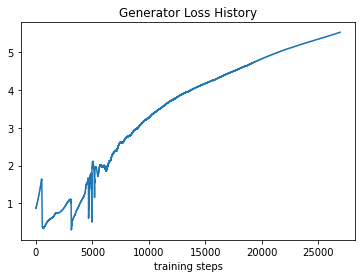

In [54]:
x = range(len(gen_loss_history))
plt.figure()
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('training steps')


Text(0.5, 0, 'training steps')

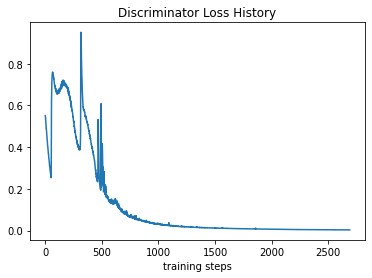

In [53]:
x = range(len(disc_loss_history))
plt.figure()
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('training steps')

## Train G and D with the same noise

In [68]:
def train_G_and_D(generator, discriminator, real_data_batch, batch_size, T, latent_dim, 
                  verbose=False, G_optimizer=Adam(lr=0.001), D_optimizer=Adam(lr=0.001),
                  label_smoothing=False, label_flipping=False):
    
    with tf.GradientTape(persistent=True) as tape:
        z = np.float32(np.random.normal(size=[batch_size, T, latent_dim]))
        G_sample = generator(z)
        D_fake, D_logit_fake = discriminator(G_sample)
        D_real, D_logit_real = discriminator(real_data_batch)
        
        if label_smoothing:
            fake_labels = tf.zeros_like(D_logit_fake) + tf.random.normal(D_logit_fake.shape, mean=0, stddev=0.3)
            fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)
            
            real_labels = tf.ones_like(D_logit_real) + tf.random.normal(D_logit_fake.shape, mean=0, stddev=0.3)
            real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)
        else:
            fake_labels = tf.zeros_like(D_logit_fake)
            real_labels = tf.ones_like(D_logit_real)
            
        if label_flipping:
            if tf.random.uniform((1,)) < 0.05:
                fake_labels, real_labels = real_labels, fake_labels            

        # D loss: cross-entropy
        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=real_labels))
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=fake_labels))
        D_loss = D_loss_real + D_loss_fake

        # non-saturating G loss
        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_real)))

            # saturating G loss
    #         G_loss = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        
        # average true return
        average_true_return = tf.reduce_mean(D_real)
                
    if verbose:
        print('G loss:{}'.format(G_loss))
        print('D loss:{}'.format(D_loss))
        print('avg. Q:{}'.format(average_true_return))
        print('-----------------------')

    # update grads        
    generator_grads = tape.gradient(G_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_grads = tape.gradient(D_loss, discriminator.trainable_variables)
    D_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
    
    del tape

    return G_loss, D_loss, average_true_return

In [69]:
N_total_G = pos_timestamp_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_timestamp_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

G = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

D = build_D(T=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-5)

In [75]:
for time_stamp_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    gen_loss, disc_loss, ave_true_return = train_G_and_D(G, D, time_stamp_batch, BATCH_SIZE, T, LATENT_DIM, verbose=True,
                                                         G_optimizer=G_optimizer, D_optimizer=D_optimizer
                                                         , label_smoothing=True, label_flipping=True)
    gen_loss_history.append(gen_loss.numpy())
    disc_loss_history.append(disc_loss.numpy())
    average_true_return_history.append(ave_true_return.numpy())

  0%|          | 0/7227 [00:00<?, ?it/s]

Training Step: 7228
G loss:1.7960002422332764
D loss:0.7163967490196228
avg. Q:0.85068678855896
-----------------------


  0%|          | 2/7227 [00:00<29:56,  4.02it/s]

Training Step: 7229
G loss:1.795027494430542
D loss:0.6821714639663696
avg. Q:0.8537747859954834
-----------------------
Training Step: 7230


  0%|          | 3/7227 [00:00<26:21,  4.57it/s]

G loss:1.794177770614624
D loss:0.7696236371994019
avg. Q:0.847273588180542
-----------------------
Training Step: 7231
G loss:1.7934379577636719
D loss:0.7672747373580933
avg. Q:0.8457579612731934
-----------------------


  0%|          | 5/7227 [00:01<23:49,  5.05it/s]

Training Step: 7232
G loss:1.7928024530410767
D loss:0.6753896474838257
avg. Q:0.8520932197570801
-----------------------
Training Step: 7233


  0%|          | 6/7227 [00:01<23:16,  5.17it/s]

G loss:1.7923619747161865
D loss:0.6472700238227844
avg. Q:0.8549034595489502
-----------------------
Training Step: 7234
G loss:1.792129397392273
D loss:0.6321699023246765
avg. Q:0.8510836362838745
-----------------------


  0%|          | 8/7227 [00:01<22:39,  5.31it/s]

Training Step: 7235
G loss:1.7919988632202148
D loss:0.6781849265098572
avg. Q:0.85164475440979
-----------------------
Training Step: 7236


  0%|          | 9/7227 [00:01<22:33,  5.33it/s]

G loss:1.7920173406600952
D loss:3.4585375785827637
avg. Q:0.8580919504165649
-----------------------
Training Step: 7237
G loss:1.7897900342941284
D loss:0.6518919467926025
avg. Q:0.8617469072341919
-----------------------


  0%|          | 11/7227 [00:02<22:17,  5.39it/s]

Training Step: 7238
G loss:1.787828803062439
D loss:0.6749590635299683
avg. Q:0.8512842655181885
-----------------------
Training Step: 7239


  0%|          | 12/7227 [00:02<22:14,  5.41it/s]

G loss:1.7861127853393555
D loss:0.6081801652908325
avg. Q:0.8493505120277405
-----------------------
Training Step: 7240
G loss:1.7847166061401367
D loss:0.7061228156089783
avg. Q:0.8548562526702881
-----------------------


  0%|          | 14/7227 [00:02<22:08,  5.43it/s]

Training Step: 7241
G loss:1.783598780632019
D loss:0.659119188785553
avg. Q:0.8458279371261597
-----------------------
Training Step: 7242


  0%|          | 15/7227 [00:02<22:09,  5.42it/s]

G loss:1.782509446144104
D loss:0.6498894691467285
avg. Q:0.8543800115585327
-----------------------
Training Step: 7243
G loss:1.7816624641418457
D loss:0.6344223022460938
avg. Q:0.8540616035461426
-----------------------


  0%|          | 17/7227 [00:03<22:21,  5.37it/s]

Training Step: 7244
G loss:1.7809123992919922
D loss:0.7067967057228088
avg. Q:0.8507580161094666
-----------------------
Training Step: 7245


  0%|          | 18/7227 [00:03<22:21,  5.38it/s]

G loss:1.7804012298583984
D loss:0.6658244729042053
avg. Q:0.8534325361251831
-----------------------
Training Step: 7246
G loss:1.78006911277771
D loss:0.7171727418899536
avg. Q:0.8509502410888672
-----------------------


  0%|          | 19/7227 [00:03<22:36,  5.31it/s]

Training Step: 7247
G loss:1.7797502279281616
D loss:0.675687849521637
avg. Q:0.8543828725814819
-----------------------


  0%|          | 21/7227 [00:04<25:01,  4.80it/s]

Training Step: 7248
G loss:1.7795746326446533
D loss:0.5890025496482849
avg. Q:0.8589781522750854
-----------------------
Training Step: 7249


  0%|          | 22/7227 [00:04<24:10,  4.97it/s]

G loss:1.779672622680664
D loss:0.700199544429779
avg. Q:0.8522229790687561
-----------------------
Training Step: 7250
G loss:1.7797839641571045
D loss:0.667434811592102
avg. Q:0.8469212055206299
-----------------------


  0%|          | 24/7227 [00:04<23:07,  5.19it/s]

Training Step: 7251
G loss:1.7800121307373047
D loss:0.7623671293258667
avg. Q:0.8527706861495972
-----------------------
Training Step: 7252


  0%|          | 25/7227 [00:04<22:56,  5.23it/s]

G loss:1.7802801132202148
D loss:0.6502057313919067
avg. Q:0.851335346698761
-----------------------
Training Step: 7253
G loss:1.7806082963943481
D loss:0.6596657633781433
avg. Q:0.8526896238327026
-----------------------


  0%|          | 27/7227 [00:05<22:36,  5.31it/s]

Training Step: 7254
G loss:1.7811520099639893
D loss:0.6871315240859985
avg. Q:0.8556046485900879
-----------------------
Training Step: 7255


  0%|          | 28/7227 [00:05<22:28,  5.34it/s]

G loss:1.7818078994750977
D loss:0.6246119737625122
avg. Q:0.8515350818634033
-----------------------
Training Step: 7256
G loss:1.7826259136199951
D loss:0.6908648014068604
avg. Q:0.8484985828399658
-----------------------


  0%|          | 30/7227 [00:05<22:14,  5.39it/s]

Training Step: 7257
G loss:1.7834244966506958
D loss:0.6683768033981323
avg. Q:0.848842978477478
-----------------------
Training Step: 7258


  0%|          | 31/7227 [00:06<22:59,  5.22it/s]

G loss:1.784224510192871
D loss:0.6056383848190308
avg. Q:0.8531577587127686
-----------------------
Training Step: 7259


  0%|          | 32/7227 [00:06<23:41,  5.06it/s]

G loss:1.7850921154022217
D loss:0.7351827025413513
avg. Q:0.854181170463562
-----------------------
Training Step: 7260


  0%|          | 33/7227 [00:06<23:43,  5.05it/s]

G loss:1.7858164310455322
D loss:0.6272604465484619
avg. Q:0.8500776886940002
-----------------------
Training Step: 7261


  0%|          | 34/7227 [00:06<24:06,  4.97it/s]

G loss:1.7867425680160522
D loss:0.643028199672699
avg. Q:0.8475834131240845
-----------------------
Training Step: 7262
G loss:1.7877248525619507
D loss:0.6958970427513123
avg. Q:0.8440669775009155
-----------------------


  0%|          | 36/7227 [00:07<23:36,  5.08it/s]

Training Step: 7263
G loss:1.788609266281128
D loss:0.6257961392402649
avg. Q:0.85341477394104
-----------------------
Training Step: 7264


  1%|          | 37/7227 [00:07<23:14,  5.16it/s]

G loss:1.7895289659500122
D loss:0.6224087476730347
avg. Q:0.8512005805969238
-----------------------
Training Step: 7265
G loss:1.7904962301254272
D loss:0.7100884914398193
avg. Q:0.8479738831520081
-----------------------


  1%|          | 39/7227 [00:07<22:45,  5.27it/s]

Training Step: 7266
G loss:1.7914042472839355
D loss:0.6474156379699707
avg. Q:0.8574872016906738
-----------------------
Training Step: 7267


  1%|          | 40/7227 [00:07<22:36,  5.30it/s]

G loss:1.7923661470413208
D loss:0.6324903964996338
avg. Q:0.8572225570678711
-----------------------
Training Step: 7268
G loss:1.7933933734893799
D loss:0.6989247798919678
avg. Q:0.8568358421325684
-----------------------


  1%|          | 41/7227 [00:07<22:34,  5.31it/s]

Training Step: 7269
G loss:1.7943695783615112
D loss:0.6607361435890198
avg. Q:0.8601381778717041
-----------------------


  1%|          | 42/7227 [00:08<23:15,  5.15it/s]

Training Step: 7270
G loss:1.795424461364746
D loss:0.6660294532775879
avg. Q:0.8490893244743347
-----------------------


  1%|          | 43/7227 [00:08<23:50,  5.02it/s]

Training Step: 7271
G loss:1.7963662147521973
D loss:0.7128142714500427
avg. Q:0.8455573320388794
-----------------------


  1%|          | 44/7227 [00:08<24:08,  4.96it/s]

Training Step: 7272
G loss:1.797322392463684
D loss:0.7010700106620789
avg. Q:0.8451991081237793
-----------------------


  1%|          | 45/7227 [00:08<24:26,  4.90it/s]

Training Step: 7273
G loss:1.798142910003662
D loss:0.6893666386604309
avg. Q:0.8462271690368652
-----------------------


  1%|          | 46/7227 [00:09<24:38,  4.86it/s]

Training Step: 7274
G loss:1.7989811897277832
D loss:0.6262385845184326
avg. Q:0.8494870662689209
-----------------------


  1%|          | 48/7227 [00:09<24:25,  4.90it/s]

Training Step: 7275
G loss:1.7997596263885498
D loss:0.6601702570915222
avg. Q:0.8510596752166748
-----------------------
Training Step: 7276


  1%|          | 49/7227 [00:09<24:36,  4.86it/s]

G loss:1.8006609678268433
D loss:0.5832759141921997
avg. Q:0.8557578325271606
-----------------------
Training Step: 7277


  1%|          | 50/7227 [00:09<24:23,  4.90it/s]

G loss:1.8015227317810059
D loss:0.656116783618927
avg. Q:0.8508501052856445
-----------------------
Training Step: 7278
G loss:1.802459955215454
D loss:0.6889441609382629
avg. Q:0.8528605699539185
-----------------------


  1%|          | 51/7227 [00:10<23:53,  5.01it/s]

Training Step: 7279
G loss:1.8033307790756226
D loss:0.603668749332428
avg. Q:0.8483657836914062
-----------------------


  1%|          | 52/7227 [00:10<24:03,  4.97it/s]

Training Step: 7280
G loss:1.8042243719100952
D loss:0.6879158020019531
avg. Q:0.8502001762390137
-----------------------


  1%|          | 53/7227 [00:10<24:24,  4.90it/s]

Training Step: 7281
G loss:1.8051059246063232
D loss:0.6833082437515259
avg. Q:0.8565460443496704
-----------------------


  1%|          | 54/7227 [00:10<24:38,  4.85it/s]

Training Step: 7282
G loss:1.8060266971588135
D loss:0.6555554866790771
avg. Q:0.8509840965270996
-----------------------


  1%|          | 55/7227 [00:10<24:49,  4.82it/s]

Training Step: 7283
G loss:1.8070048093795776
D loss:0.7068679332733154
avg. Q:0.8544765114784241
-----------------------


  1%|          | 57/7227 [00:11<24:01,  4.98it/s]

Training Step: 7284
G loss:1.8078746795654297
D loss:3.399104595184326
avg. Q:0.8514811396598816
-----------------------
Training Step: 7285


  1%|          | 58/7227 [00:11<23:26,  5.10it/s]

G loss:1.806840181350708
D loss:3.36486554145813
avg. Q:0.849541425704956
-----------------------
Training Step: 7286
G loss:1.8041915893554688
D loss:0.7581896185874939
avg. Q:0.8565933704376221
-----------------------


  1%|          | 60/7227 [00:11<22:50,  5.23it/s]

Training Step: 7287
G loss:1.8019264936447144
D loss:0.6504165530204773
avg. Q:0.8468263149261475
-----------------------
Training Step: 7288


  1%|          | 61/7227 [00:12<23:11,  5.15it/s]

G loss:1.7998478412628174
D loss:0.6274898052215576
avg. Q:0.8561574220657349
-----------------------
Training Step: 7289
G loss:1.7979812622070312
D loss:0.7964308261871338
avg. Q:0.8454923033714294
-----------------------


  1%|          | 63/7227 [00:12<22:38,  5.27it/s]

Training Step: 7290
G loss:1.7962048053741455
D loss:0.637116551399231
avg. Q:0.8571401238441467
-----------------------
Training Step: 7291


  1%|          | 64/7227 [00:12<22:28,  5.31it/s]

G loss:1.7946631908416748
D loss:0.6972695589065552
avg. Q:0.8527978658676147
-----------------------
Training Step: 7292
G loss:1.7932626008987427
D loss:0.6333547830581665
avg. Q:0.8440635204315186
-----------------------


  1%|          | 66/7227 [00:12<22:17,  5.35it/s]

Training Step: 7293
G loss:1.7920749187469482
D loss:0.6348362565040588
avg. Q:0.8546456098556519
-----------------------
Training Step: 7294


  1%|          | 67/7227 [00:13<22:15,  5.36it/s]

G loss:1.791151762008667
D loss:3.418574810028076
avg. Q:0.8536340594291687
-----------------------
Training Step: 7295
G loss:1.7879228591918945
D loss:0.6704322099685669
avg. Q:0.8533264398574829
-----------------------


  1%|          | 69/7227 [00:13<22:15,  5.36it/s]

Training Step: 7296
G loss:1.785159945487976
D loss:0.671845555305481
avg. Q:0.8532907962799072
-----------------------
Training Step: 7297


  1%|          | 70/7227 [00:13<22:14,  5.36it/s]

G loss:1.7827423810958862
D loss:0.6429970264434814
avg. Q:0.849678635597229
-----------------------
Training Step: 7298
G loss:1.7806015014648438
D loss:0.6506376266479492
avg. Q:0.8473292589187622
-----------------------


  1%|          | 72/7227 [00:14<22:16,  5.35it/s]

Training Step: 7299
G loss:1.7788193225860596
D loss:0.5684125423431396
avg. Q:0.8508173227310181
-----------------------
Training Step: 7300


  1%|          | 73/7227 [00:14<22:08,  5.38it/s]

G loss:1.7774264812469482
D loss:3.3395280838012695
avg. Q:0.8510875701904297
-----------------------
Training Step: 7301
G loss:1.7730776071548462
D loss:0.7296480536460876
avg. Q:0.84046870470047
-----------------------


  1%|          | 75/7227 [00:14<22:00,  5.42it/s]

Training Step: 7302
G loss:1.7690774202346802
D loss:0.608689546585083
avg. Q:0.8560741543769836
-----------------------
Training Step: 7303


  1%|          | 76/7227 [00:14<22:04,  5.40it/s]

G loss:1.765531063079834
D loss:0.6870896816253662
avg. Q:0.8549231886863708
-----------------------
Training Step: 7304
G loss:1.7624684572219849
D loss:3.414295196533203
avg. Q:0.8506137132644653
-----------------------


  1%|          | 78/7227 [00:15<22:34,  5.28it/s]

Training Step: 7305
G loss:1.7562505006790161
D loss:0.6935213208198547
avg. Q:0.8521438837051392
-----------------------
Training Step: 7306


  1%|          | 79/7227 [00:15<22:27,  5.30it/s]

G loss:1.7507343292236328
D loss:0.6702733635902405
avg. Q:0.8522120714187622
-----------------------
Training Step: 7307
G loss:1.7458360195159912
D loss:0.6155487298965454
avg. Q:0.8505828976631165
-----------------------


  1%|          | 81/7227 [00:15<22:15,  5.35it/s]

Training Step: 7308
G loss:1.7417569160461426
D loss:0.666897714138031
avg. Q:0.8471114039421082
-----------------------
Training Step: 7309


  1%|          | 82/7227 [00:15<22:16,  5.34it/s]

G loss:1.7383004426956177
D loss:0.6173717379570007
avg. Q:0.8473082184791565
-----------------------
Training Step: 7310
G loss:1.7355077266693115
D loss:0.6850825548171997
avg. Q:0.8599423170089722
-----------------------


  1%|          | 84/7227 [00:16<22:47,  5.22it/s]

Training Step: 7311
G loss:1.7332274913787842
D loss:0.6747020483016968
avg. Q:0.8518524169921875
-----------------------
Training Step: 7312


  1%|          | 85/7227 [00:16<22:32,  5.28it/s]

G loss:1.731501579284668
D loss:0.6663910150527954
avg. Q:0.8453141450881958
-----------------------
Training Step: 7313
G loss:1.7302746772766113
D loss:0.6844111680984497
avg. Q:0.8501241207122803
-----------------------


  1%|          | 87/7227 [00:16<22:45,  5.23it/s]

Training Step: 7314
G loss:1.7295085191726685
D loss:0.721503496170044
avg. Q:0.8532465696334839
-----------------------
Training Step: 7315


  1%|          | 88/7227 [00:17<22:40,  5.25it/s]

G loss:1.7289912700653076
D loss:0.6590055227279663
avg. Q:0.849716067314148
-----------------------
Training Step: 7316
G loss:1.7287259101867676
D loss:3.3017160892486572
avg. Q:0.8492789268493652
-----------------------


  1%|          | 90/7227 [00:17<22:23,  5.31it/s]

Training Step: 7317
G loss:1.7237213850021362
D loss:0.6746058464050293
avg. Q:0.8475435972213745
-----------------------
Training Step: 7318


  1%|▏         | 91/7227 [00:17<22:25,  5.30it/s]

G loss:1.7194859981536865
D loss:0.6618320941925049
avg. Q:0.8447878956794739
-----------------------
Training Step: 7319
G loss:1.7158483266830444
D loss:0.6120170950889587
avg. Q:0.8541299700737
-----------------------


  1%|▏         | 93/7227 [00:18<22:15,  5.34it/s]

Training Step: 7320
G loss:1.7128994464874268
D loss:0.7273401021957397
avg. Q:0.8467302918434143
-----------------------
Training Step: 7321


  1%|▏         | 94/7227 [00:18<22:12,  5.35it/s]

G loss:1.7104920148849487
D loss:0.7110855579376221
avg. Q:0.8557388186454773
-----------------------
Training Step: 7322
G loss:1.7084429264068604
D loss:0.6570084691047668
avg. Q:0.8501879572868347
-----------------------


  1%|▏         | 96/7227 [00:18<22:37,  5.25it/s]

Training Step: 7323
G loss:1.7069272994995117
D loss:0.6399440169334412
avg. Q:0.8494433760643005
-----------------------
Training Step: 7324


  1%|▏         | 97/7227 [00:18<23:17,  5.10it/s]

G loss:1.7058165073394775
D loss:0.6136803030967712
avg. Q:0.8581445217132568
-----------------------
Training Step: 7325


  1%|▏         | 98/7227 [00:19<23:52,  4.98it/s]

G loss:1.7054461240768433
D loss:0.6434942483901978
avg. Q:0.8592827916145325
-----------------------
Training Step: 7326


  1%|▏         | 99/7227 [00:19<23:37,  5.03it/s]

G loss:1.7055068016052246
D loss:0.6318145990371704
avg. Q:0.8525136113166809
-----------------------
Training Step: 7327
G loss:1.705883264541626
D loss:0.7019737958908081
avg. Q:0.8457807302474976
-----------------------


  1%|▏         | 101/7227 [00:19<22:40,  5.24it/s]

Training Step: 7328
G loss:1.7065625190734863
D loss:0.6971829533576965
avg. Q:0.8541799187660217
-----------------------
Training Step: 7329


  1%|▏         | 102/7227 [00:19<22:27,  5.29it/s]

G loss:1.7074272632598877
D loss:0.6756300926208496
avg. Q:0.8507872223854065
-----------------------
Training Step: 7330
G loss:1.7086998224258423
D loss:0.6725627183914185
avg. Q:0.8546535968780518
-----------------------


  1%|▏         | 104/7227 [00:20<22:07,  5.37it/s]

Training Step: 7331
G loss:1.7101114988327026
D loss:0.6483304500579834
avg. Q:0.8448772430419922
-----------------------
Training Step: 7332


  1%|▏         | 105/7227 [00:20<22:05,  5.37it/s]

G loss:1.7116435766220093
D loss:0.6810607314109802
avg. Q:0.8445648550987244
-----------------------
Training Step: 7333
G loss:1.713393211364746
D loss:0.6993585228919983
avg. Q:0.8433106541633606
-----------------------


  1%|▏         | 107/7227 [00:20<21:58,  5.40it/s]

Training Step: 7334
G loss:1.7151355743408203
D loss:0.7076746225357056
avg. Q:0.8509436249732971
-----------------------
Training Step: 7335


  1%|▏         | 108/7227 [00:20<22:01,  5.39it/s]

G loss:1.7169691324234009
D loss:0.7095210552215576
avg. Q:0.8481155633926392
-----------------------
Training Step: 7336
G loss:1.7187504768371582
D loss:0.6693804860115051
avg. Q:0.8455734252929688
-----------------------


  2%|▏         | 110/7227 [00:21<22:01,  5.39it/s]

Training Step: 7337
G loss:1.7205644845962524
D loss:0.6756992340087891
avg. Q:0.8503803014755249
-----------------------
Training Step: 7338


  2%|▏         | 111/7227 [00:21<22:03,  5.38it/s]

G loss:1.7224881649017334
D loss:0.6518777012825012
avg. Q:0.8510630130767822
-----------------------
Training Step: 7339
G loss:1.7243812084197998
D loss:0.6880893111228943
avg. Q:0.8453385829925537
-----------------------


  2%|▏         | 113/7227 [00:21<21:58,  5.39it/s]

Training Step: 7340
G loss:1.7263132333755493
D loss:0.7054530382156372
avg. Q:0.840431809425354
-----------------------
Training Step: 7341


  2%|▏         | 114/7227 [00:21<22:10,  5.35it/s]

G loss:1.7281244993209839
D loss:0.7193383574485779
avg. Q:0.847902238368988
-----------------------
Training Step: 7342
G loss:1.729764699935913
D loss:0.6602465510368347
avg. Q:0.8566640615463257
-----------------------


  2%|▏         | 116/7227 [00:22<22:41,  5.22it/s]

Training Step: 7343
G loss:1.7315843105316162
D loss:0.7369617223739624
avg. Q:0.845879852771759
-----------------------
Training Step: 7344


  2%|▏         | 117/7227 [00:22<22:29,  5.27it/s]

G loss:1.7333247661590576
D loss:0.740164041519165
avg. Q:0.8503520488739014
-----------------------
Training Step: 7345
G loss:1.7349913120269775
D loss:0.6682716012001038
avg. Q:0.8461822271347046
-----------------------


  2%|▏         | 118/7227 [00:22<22:22,  5.30it/s]

Training Step: 7346
G loss:1.7367802858352661
D loss:0.7116346955299377
avg. Q:0.8475346565246582
-----------------------


  2%|▏         | 119/7227 [00:22<23:09,  5.12it/s]

Training Step: 7347
G loss:1.7386128902435303
D loss:0.6613748669624329
avg. Q:0.8498700261116028
-----------------------


  2%|▏         | 121/7227 [00:23<23:08,  5.12it/s]

Training Step: 7348
G loss:1.7404690980911255
D loss:0.6546667814254761
avg. Q:0.8492918014526367
-----------------------
Training Step: 7349


  2%|▏         | 122/7227 [00:23<22:49,  5.19it/s]

G loss:1.742537021636963
D loss:0.6821162700653076
avg. Q:0.8451579213142395
-----------------------
Training Step: 7350
G loss:1.7445971965789795
D loss:3.3315412998199463
avg. Q:0.8471734523773193
-----------------------


  2%|▏         | 124/7227 [00:23<22:24,  5.28it/s]

Training Step: 7351
G loss:1.7426879405975342
D loss:0.6153301000595093
avg. Q:0.8569604754447937
-----------------------
Training Step: 7352


  2%|▏         | 125/7227 [00:24<22:33,  5.25it/s]

G loss:1.7411489486694336
D loss:0.6473302841186523
avg. Q:0.850422739982605
-----------------------
Training Step: 7353
G loss:1.7399958372116089
D loss:0.7366317510604858
avg. Q:0.8447644710540771
-----------------------


  2%|▏         | 127/7227 [00:24<22:11,  5.33it/s]

Training Step: 7354
G loss:1.7390674352645874
D loss:0.6948464512825012
avg. Q:0.8417826890945435
-----------------------
Training Step: 7355


  2%|▏         | 128/7227 [00:24<22:05,  5.36it/s]

G loss:1.7383878231048584
D loss:0.6866052150726318
avg. Q:0.8510645031929016
-----------------------
Training Step: 7356
G loss:1.738006830215454
D loss:0.6832238435745239
avg. Q:0.8547462821006775
-----------------------


  2%|▏         | 130/7227 [00:25<22:01,  5.37it/s]

Training Step: 7357
G loss:1.7378697395324707
D loss:0.6515519618988037
avg. Q:0.8425195217132568
-----------------------
Training Step: 7358


  2%|▏         | 131/7227 [00:25<22:01,  5.37it/s]

G loss:1.7379249334335327
D loss:0.7165679335594177
avg. Q:0.840493381023407
-----------------------
Training Step: 7359
G loss:1.7383393049240112
D loss:0.6362265348434448
avg. Q:0.8505146503448486
-----------------------


  2%|▏         | 133/7227 [00:25<22:00,  5.37it/s]

Training Step: 7360
G loss:1.7389987707138062
D loss:0.5988411903381348
avg. Q:0.8490394353866577
-----------------------
Training Step: 7361


  2%|▏         | 134/7227 [00:25<22:00,  5.37it/s]

G loss:1.7399178743362427
D loss:0.6797311305999756
avg. Q:0.8556326031684875
-----------------------
Training Step: 7362
G loss:1.7409690618515015
D loss:0.6416366100311279
avg. Q:0.8492615818977356
-----------------------


  2%|▏         | 135/7227 [00:25<22:02,  5.36it/s]

Training Step: 7363
G loss:1.7423121929168701
D loss:0.6812084317207336
avg. Q:0.8478075861930847
-----------------------


  2%|▏         | 137/7227 [00:26<22:45,  5.19it/s]

Training Step: 7364
G loss:1.7437505722045898
D loss:0.653003990650177
avg. Q:0.8503168821334839
-----------------------
Training Step: 7365


  2%|▏         | 138/7227 [00:26<22:38,  5.22it/s]

G loss:1.745321273803711
D loss:0.6764656901359558
avg. Q:0.8442070484161377
-----------------------
Training Step: 7366
G loss:1.7469465732574463
D loss:0.6203142404556274
avg. Q:0.8437004685401917
-----------------------


  2%|▏         | 139/7227 [00:26<22:42,  5.20it/s]

Training Step: 7367
G loss:1.7486650943756104
D loss:0.6664432287216187
avg. Q:0.853380024433136
-----------------------


  2%|▏         | 141/7227 [00:27<22:59,  5.14it/s]

Training Step: 7368
G loss:1.7505890130996704
D loss:0.6195226907730103
avg. Q:0.8544093370437622
-----------------------
Training Step: 7369


  2%|▏         | 142/7227 [00:27<22:43,  5.20it/s]

G loss:1.7525675296783447
D loss:0.6675816774368286
avg. Q:0.8454763293266296
-----------------------
Training Step: 7370
G loss:1.7544288635253906
D loss:0.6997356414794922
avg. Q:0.843613862991333
-----------------------


  2%|▏         | 143/7227 [00:27<23:01,  5.13it/s]

Training Step: 7371
G loss:1.7560532093048096
D loss:0.6450456380844116
avg. Q:0.8470250964164734
-----------------------


  2%|▏         | 144/7227 [00:27<23:35,  5.00it/s]

Training Step: 7372
G loss:1.7576005458831787
D loss:0.6184483766555786
avg. Q:0.8528574705123901
-----------------------


  2%|▏         | 146/7227 [00:28<23:25,  5.04it/s]

Training Step: 7373
G loss:1.7591640949249268
D loss:0.686263382434845
avg. Q:0.852888822555542
-----------------------
Training Step: 7374


  2%|▏         | 147/7227 [00:28<23:00,  5.13it/s]

G loss:1.7606942653656006
D loss:0.6830964088439941
avg. Q:0.8486288785934448
-----------------------
Training Step: 7375
G loss:1.7622352838516235
D loss:0.7006913423538208
avg. Q:0.8477896451950073
-----------------------


  2%|▏         | 149/7227 [00:28<22:24,  5.27it/s]

Training Step: 7376
G loss:1.7636582851409912
D loss:0.6582903861999512
avg. Q:0.8490900993347168
-----------------------
Training Step: 7377


  2%|▏         | 150/7227 [00:28<22:18,  5.29it/s]

G loss:1.7650755643844604
D loss:0.6865509748458862
avg. Q:0.8378794193267822
-----------------------
Training Step: 7378
G loss:1.7665114402770996
D loss:0.6682703495025635
avg. Q:0.8425502777099609
-----------------------


  2%|▏         | 152/7227 [00:29<22:08,  5.32it/s]

Training Step: 7379
G loss:1.767777919769287
D loss:0.6430855989456177
avg. Q:0.8414641618728638
-----------------------
Training Step: 7380


  2%|▏         | 153/7227 [00:29<22:01,  5.35it/s]

G loss:1.7689499855041504
D loss:0.6304748058319092
avg. Q:0.8427333831787109
-----------------------
Training Step: 7381
G loss:1.7701022624969482
D loss:0.6075663566589355
avg. Q:0.8437179327011108
-----------------------


  2%|▏         | 155/7227 [00:29<21:47,  5.41it/s]

Training Step: 7382
G loss:1.7712713479995728
D loss:0.6428540945053101
avg. Q:0.8507248163223267
-----------------------
Training Step: 7383


  2%|▏         | 156/7227 [00:29<21:48,  5.40it/s]

G loss:1.772454857826233
D loss:0.5784316062927246
avg. Q:0.848983645439148
-----------------------
Training Step: 7384
G loss:1.7738243341445923
D loss:0.6685270071029663
avg. Q:0.8466796278953552
-----------------------


  2%|▏         | 158/7227 [00:30<21:46,  5.41it/s]

Training Step: 7385
G loss:1.775280237197876
D loss:0.6204838156700134
avg. Q:0.853456437587738
-----------------------
Training Step: 7386


  2%|▏         | 159/7227 [00:30<21:44,  5.42it/s]

G loss:1.7768075466156006
D loss:0.623927652835846
avg. Q:0.8501331210136414
-----------------------
Training Step: 7387
G loss:1.7783713340759277
D loss:3.390211343765259
avg. Q:0.849260151386261
-----------------------


  2%|▏         | 161/7227 [00:30<21:40,  5.43it/s]

Training Step: 7388
G loss:1.7770917415618896
D loss:0.6303365230560303
avg. Q:0.8542999029159546
-----------------------
Training Step: 7389


  2%|▏         | 162/7227 [00:31<21:42,  5.42it/s]

G loss:1.7761508226394653
D loss:0.6840589046478271
avg. Q:0.8492016792297363
-----------------------
Training Step: 7390
G loss:1.7754085063934326
D loss:0.6479348540306091
avg. Q:0.8481653332710266
-----------------------


  2%|▏         | 164/7227 [00:31<21:42,  5.42it/s]

Training Step: 7391
G loss:1.7747712135314941
D loss:0.7029445171356201
avg. Q:0.851793110370636
-----------------------
Training Step: 7392


  2%|▏         | 165/7227 [00:31<21:43,  5.42it/s]

G loss:1.774294137954712
D loss:0.6543000936508179
avg. Q:0.8463152647018433
-----------------------
Training Step: 7393
G loss:1.7739131450653076
D loss:0.6606858968734741
avg. Q:0.8448035717010498
-----------------------


  2%|▏         | 167/7227 [00:32<21:56,  5.36it/s]

Training Step: 7394
G loss:1.7738345861434937
D loss:3.351853609085083
avg. Q:0.8359485864639282
-----------------------
Training Step: 7395


  2%|▏         | 168/7227 [00:32<21:58,  5.35it/s]

G loss:1.770917296409607
D loss:0.6521168947219849
avg. Q:0.841956615447998
-----------------------
Training Step: 7396
G loss:1.7683864831924438
D loss:0.6603344678878784
avg. Q:0.8482452034950256
-----------------------


  2%|▏         | 170/7227 [00:32<21:58,  5.35it/s]

Training Step: 7397
G loss:1.7660460472106934
D loss:0.6223679780960083
avg. Q:0.8427581787109375
-----------------------
Training Step: 7398


  2%|▏         | 171/7227 [00:32<21:57,  5.36it/s]

G loss:1.7639508247375488
D loss:0.6883251667022705
avg. Q:0.8514339923858643
-----------------------
Training Step: 7399
G loss:1.7621899843215942
D loss:0.6222562789916992
avg. Q:0.8415745496749878
-----------------------


  2%|▏         | 173/7227 [00:33<22:14,  5.29it/s]

Training Step: 7400
G loss:1.760684847831726
D loss:0.7285257577896118
avg. Q:0.8486480712890625
-----------------------
Training Step: 7401


  2%|▏         | 174/7227 [00:33<22:04,  5.32it/s]

G loss:1.7592562437057495
D loss:0.6595973968505859
avg. Q:0.8447158932685852
-----------------------
Training Step: 7402
G loss:1.7582871913909912
D loss:0.6514869332313538
avg. Q:0.8492590188980103
-----------------------


  2%|▏         | 176/7227 [00:33<21:49,  5.38it/s]

Training Step: 7403
G loss:1.7574265003204346
D loss:0.647505521774292
avg. Q:0.8482075929641724
-----------------------
Training Step: 7404


  2%|▏         | 177/7227 [00:33<21:50,  5.38it/s]

G loss:1.7569044828414917
D loss:0.6533076763153076
avg. Q:0.8495686054229736
-----------------------
Training Step: 7405
G loss:1.7566660642623901
D loss:0.6330075860023499
avg. Q:0.8592600226402283
-----------------------


  2%|▏         | 179/7227 [00:34<21:49,  5.38it/s]

Training Step: 7406
G loss:1.756690263748169
D loss:0.6977255344390869
avg. Q:0.8481271266937256
-----------------------
Training Step: 7407


  9%|▉         | 683/7227 [02:09<20:41,  5.27it/s]

Training Step: 7910
G loss:1.743239402770996
D loss:0.7137920260429382
avg. Q:0.8516344428062439
-----------------------
Training Step: 7911


  9%|▉         | 684/7227 [02:10<20:36,  5.29it/s]

G loss:1.7379820346832275
D loss:0.6509310007095337
avg. Q:0.8548064231872559
-----------------------
Training Step: 7912
G loss:1.7334415912628174
D loss:0.6670308113098145
avg. Q:0.8470004796981812
-----------------------


  9%|▉         | 686/7227 [02:10<20:20,  5.36it/s]

Training Step: 7913
G loss:1.729581594467163
D loss:0.6482957601547241
avg. Q:0.8486020565032959
-----------------------
Training Step: 7914


 10%|▉         | 687/7227 [02:10<20:16,  5.38it/s]

G loss:1.7261601686477661
D loss:0.689896821975708
avg. Q:0.8458030223846436
-----------------------
Training Step: 7915
G loss:1.723373532295227
D loss:0.6875232458114624
avg. Q:0.8462647199630737
-----------------------


 10%|▉         | 688/7227 [02:10<20:21,  5.35it/s]

Training Step: 7916
G loss:1.7210818529129028
D loss:0.6757254600524902
avg. Q:0.8449985980987549
-----------------------


 10%|▉         | 690/7227 [02:11<20:43,  5.26it/s]

Training Step: 7917
G loss:1.7195299863815308
D loss:0.6304692029953003
avg. Q:0.8454176187515259
-----------------------
Training Step: 7918


 10%|▉         | 691/7227 [02:11<20:32,  5.30it/s]

G loss:1.718720555305481
D loss:0.6590089797973633
avg. Q:0.8494755029678345
-----------------------
Training Step: 7919
G loss:1.7183377742767334
D loss:0.6627441048622131
avg. Q:0.8483770489692688
-----------------------


 10%|▉         | 693/7227 [02:11<20:13,  5.38it/s]

Training Step: 7920
G loss:1.718340277671814
D loss:3.3548946380615234
avg. Q:0.8487489223480225
-----------------------
Training Step: 7921


 10%|▉         | 694/7227 [02:11<20:17,  5.37it/s]

G loss:1.7135827541351318
D loss:0.7450823783874512
avg. Q:0.8451588153839111
-----------------------
Training Step: 7922
G loss:1.7094502449035645
D loss:0.6758290529251099
avg. Q:0.8465073704719543
-----------------------


 10%|▉         | 696/7227 [02:12<20:14,  5.38it/s]

Training Step: 7923
G loss:1.705953598022461
D loss:0.688135027885437
avg. Q:0.8445155620574951
-----------------------
Training Step: 7924


 10%|▉         | 697/7227 [02:12<20:13,  5.38it/s]

G loss:1.703272819519043
D loss:0.6429281234741211
avg. Q:0.8545985817909241
-----------------------
Training Step: 7925
G loss:1.7013027667999268
D loss:0.6726298332214355
avg. Q:0.8412998914718628
-----------------------


 10%|▉         | 699/7227 [02:12<20:11,  5.39it/s]

Training Step: 7926
G loss:1.6998472213745117
D loss:0.7369974851608276
avg. Q:0.848770022392273
-----------------------
Training Step: 7927


 10%|▉         | 700/7227 [02:13<20:11,  5.39it/s]

G loss:1.6988075971603394
D loss:0.5963225960731506
avg. Q:0.8522881269454956
-----------------------
Training Step: 7928
G loss:1.6981830596923828
D loss:0.7088777422904968
avg. Q:0.8354164361953735
-----------------------


 10%|▉         | 702/7227 [02:13<20:16,  5.36it/s]

Training Step: 7929
G loss:1.6978721618652344
D loss:0.7299084067344666
avg. Q:0.8500691652297974
-----------------------
Training Step: 7930


 10%|▉         | 703/7227 [02:13<20:12,  5.38it/s]

G loss:1.6980901956558228
D loss:0.6085894703865051
avg. Q:0.8456873893737793
-----------------------
Training Step: 7931
G loss:1.6987019777297974
D loss:0.6801729798316956
avg. Q:0.8483898639678955
-----------------------


 10%|▉         | 705/7227 [02:14<20:32,  5.29it/s]

Training Step: 7932
G loss:1.6996376514434814
D loss:0.6480770111083984
avg. Q:0.8439337611198425
-----------------------
Training Step: 7933


 10%|▉         | 706/7227 [02:14<21:13,  5.12it/s]

G loss:1.7006471157073975
D loss:0.6656085252761841
avg. Q:0.8509775400161743
-----------------------
Training Step: 7934


 10%|▉         | 707/7227 [02:14<20:59,  5.18it/s]

G loss:1.701966643333435
D loss:0.6606333255767822
avg. Q:0.8426573276519775
-----------------------
Training Step: 7935
G loss:1.7037361860275269
D loss:0.6684654951095581
avg. Q:0.8510318398475647
-----------------------


 10%|▉         | 708/7227 [02:14<21:14,  5.12it/s]

Training Step: 7936
G loss:1.7055652141571045
D loss:0.7176104187965393
avg. Q:0.8461481928825378
-----------------------


 10%|▉         | 709/7227 [02:14<21:43,  5.00it/s]

Training Step: 7937
G loss:1.7075703144073486
D loss:0.7088274955749512
avg. Q:0.8492575287818909
-----------------------


 10%|▉         | 710/7227 [02:15<22:03,  4.93it/s]

Training Step: 7938
G loss:1.7095767259597778
D loss:0.6523555517196655
avg. Q:0.8436857461929321
-----------------------


 10%|▉         | 711/7227 [02:15<22:06,  4.91it/s]

Training Step: 7939
G loss:1.7117360830307007
D loss:0.6391922831535339
avg. Q:0.8374953269958496
-----------------------


 10%|▉         | 712/7227 [02:15<22:19,  4.87it/s]

Training Step: 7940
G loss:1.7139930725097656
D loss:0.6630172729492188
avg. Q:0.8455778360366821
-----------------------


 10%|▉         | 714/7227 [02:15<22:12,  4.89it/s]

Training Step: 7941
G loss:1.7165179252624512
D loss:3.3392398357391357
avg. Q:0.8562308549880981
-----------------------
Training Step: 7942


 10%|▉         | 715/7227 [02:16<21:54,  4.95it/s]

G loss:1.714019536972046
D loss:0.7043932676315308
avg. Q:0.8426351547241211
-----------------------
Training Step: 7943


 10%|▉         | 716/7227 [02:16<22:11,  4.89it/s]

G loss:1.7120208740234375
D loss:0.6635473370552063
avg. Q:0.8449892401695251
-----------------------
Training Step: 7944


 10%|▉         | 717/7227 [02:16<22:22,  4.85it/s]

G loss:1.7106471061706543
D loss:3.33929443359375
avg. Q:0.8444614410400391
-----------------------
Training Step: 7945


 10%|▉         | 718/7227 [02:16<22:31,  4.82it/s]

G loss:1.7048373222351074
D loss:0.7202107906341553
avg. Q:0.8342015743255615
-----------------------
Training Step: 7946


 10%|▉         | 719/7227 [02:16<22:38,  4.79it/s]

G loss:1.6997722387313843
D loss:0.6788839101791382
avg. Q:0.844898521900177
-----------------------
Training Step: 7947


 10%|▉         | 720/7227 [02:17<22:32,  4.81it/s]

G loss:1.6953699588775635
D loss:0.6687214374542236
avg. Q:0.8488420248031616
-----------------------
Training Step: 7948
G loss:1.691797137260437
D loss:0.6702227592468262


 10%|▉         | 721/7227 [02:17<21:47,  4.98it/s]

avg. Q:0.8499172925949097
-----------------------
Training Step: 7949
G loss:1.688955307006836
D loss:0.7207452654838562
avg. Q:0.8437271118164062
-----------------------


 10%|█         | 723/7227 [02:17<20:56,  5.18it/s]

Training Step: 7950
G loss:1.6864467859268188
D loss:0.662882924079895
avg. Q:0.8444777131080627
-----------------------
Training Step: 7951


 10%|█         | 724/7227 [02:17<20:44,  5.23it/s]

G loss:1.684708833694458
D loss:0.6556652784347534
avg. Q:0.8442959785461426
-----------------------
Training Step: 7952
G loss:1.6834588050842285
D loss:0.6520669460296631
avg. Q:0.8415141105651855
-----------------------


 10%|█         | 725/7227 [02:18<20:39,  5.25it/s]

Training Step: 7953
G loss:1.682920217514038
D loss:0.6739266514778137
avg. Q:0.8438605666160583
-----------------------


 10%|█         | 727/7227 [02:18<20:56,  5.17it/s]

Training Step: 7954
G loss:1.6829670667648315
D loss:0.6585931181907654
avg. Q:0.8381150364875793
-----------------------
Training Step: 7955


 10%|█         | 728/7227 [02:18<20:41,  5.23it/s]

G loss:1.6832562685012817
D loss:0.6927483081817627
avg. Q:0.8510737419128418
-----------------------
Training Step: 7956
G loss:1.6838288307189941
D loss:0.6750504374504089
avg. Q:0.8508508205413818
-----------------------


 10%|█         | 729/7227 [02:18<20:38,  5.25it/s]

Training Step: 7957
G loss:1.6846590042114258
D loss:0.6778019666671753
avg. Q:0.8414764404296875
-----------------------


 10%|█         | 731/7227 [02:19<20:49,  5.20it/s]

Training Step: 7958
G loss:1.685653567314148
D loss:0.6696237325668335
avg. Q:0.8404157161712646
-----------------------
Training Step: 7959


 10%|█         | 732/7227 [02:19<20:35,  5.26it/s]

G loss:1.6868877410888672
D loss:0.6023296117782593
avg. Q:0.8480035066604614
-----------------------
Training Step: 7960
G loss:1.688452124595642
D loss:0.6374331712722778
avg. Q:0.8356674909591675
-----------------------


 10%|█         | 734/7227 [02:19<20:22,  5.31it/s]

Training Step: 7961
G loss:1.690284013748169
D loss:0.6377789974212646
avg. Q:0.8452101945877075
-----------------------
Training Step: 7962


 10%|█         | 735/7227 [02:19<20:17,  5.33it/s]

G loss:1.6924660205841064
D loss:3.2846992015838623
avg. Q:0.8477272987365723
-----------------------
Training Step: 7963
G loss:1.6895198822021484
D loss:0.6143947839736938
avg. Q:0.8477914929389954
-----------------------


 10%|█         | 736/7227 [02:20<20:57,  5.16it/s]

Training Step: 7964
G loss:1.6873183250427246
D loss:0.6943919658660889
avg. Q:0.8395242094993591
-----------------------


 10%|█         | 737/7227 [02:20<21:29,  5.03it/s]

Training Step: 7965
G loss:1.6856353282928467
D loss:0.6821305751800537
avg. Q:0.8413200378417969
-----------------------


 10%|█         | 738/7227 [02:20<21:51,  4.95it/s]

Training Step: 7966
G loss:1.6843392848968506
D loss:0.6704962253570557
avg. Q:0.8409883975982666
-----------------------


 10%|█         | 739/7227 [02:20<22:07,  4.89it/s]

Training Step: 7967
G loss:1.6836366653442383
D loss:0.6869547963142395
avg. Q:0.8401123881340027
-----------------------


 10%|█         | 740/7227 [02:21<22:18,  4.85it/s]

Training Step: 7968
G loss:1.6833313703536987
D loss:0.6713504195213318
avg. Q:0.8335306644439697
-----------------------


 10%|█         | 741/7227 [02:21<22:21,  4.84it/s]

Training Step: 7969
G loss:1.6834402084350586
D loss:0.6711201667785645
avg. Q:0.842466413974762
-----------------------


 10%|█         | 742/7227 [02:21<22:25,  4.82it/s]

Training Step: 7970
G loss:1.6838388442993164
D loss:0.654276430606842
avg. Q:0.8419377207756042
-----------------------


 10%|█         | 743/7227 [02:21<22:29,  4.80it/s]

Training Step: 7971
G loss:1.6846016645431519
D loss:0.6968467235565186
avg. Q:0.8445401191711426
-----------------------


 10%|█         | 745/7227 [02:22<21:35,  5.00it/s]

Training Step: 7972
G loss:1.6855783462524414
D loss:0.6909573674201965
avg. Q:0.8473993539810181
-----------------------
Training Step: 7973


 10%|█         | 746/7227 [02:22<21:03,  5.13it/s]

G loss:1.6868181228637695
D loss:0.6839675903320312
avg. Q:0.8423497676849365
-----------------------
Training Step: 7974
G loss:1.6880879402160645
D loss:0.6862406730651855
avg. Q:0.8425338864326477
-----------------------


 10%|█         | 748/7227 [02:22<20:26,  5.28it/s]

Training Step: 7975
G loss:1.6895662546157837
D loss:0.6866998672485352
avg. Q:0.8420759439468384
-----------------------
Training Step: 7976


 10%|█         | 749/7227 [02:22<20:15,  5.33it/s]

G loss:1.6912448406219482
D loss:0.6834813952445984
avg. Q:0.8431209325790405
-----------------------
Training Step: 7977
G loss:1.6931616067886353
D loss:3.3135857582092285
avg. Q:0.844774603843689
-----------------------


 10%|█         | 751/7227 [02:23<20:14,  5.33it/s]

Training Step: 7978
G loss:1.6901538372039795
D loss:0.6761080026626587
avg. Q:0.8393459320068359
-----------------------
Training Step: 7979


 10%|█         | 752/7227 [02:23<20:10,  5.35it/s]

G loss:1.6877918243408203
D loss:0.7009446620941162
avg. Q:0.8424251079559326
-----------------------
Training Step: 7980
G loss:1.6860381364822388
D loss:0.7345077991485596
avg. Q:0.8447722792625427
-----------------------


 10%|█         | 754/7227 [02:23<19:58,  5.40it/s]

Training Step: 7981
G loss:1.6847795248031616
D loss:0.6878305673599243
avg. Q:0.8359435796737671
-----------------------
Training Step: 7982


 10%|█         | 755/7227 [02:23<19:57,  5.40it/s]

G loss:1.6839168071746826
D loss:0.6745193004608154
avg. Q:0.8452551364898682
-----------------------
Training Step: 7983
G loss:1.6834839582443237
D loss:0.6850191354751587
avg. Q:0.8473215103149414
-----------------------


 10%|█         | 757/7227 [02:24<19:54,  5.42it/s]

Training Step: 7984
G loss:1.6834168434143066
D loss:3.2541487216949463
avg. Q:0.8471007943153381
-----------------------
Training Step: 7985


 10%|█         | 758/7227 [02:24<19:56,  5.41it/s]

G loss:1.6788866519927979
D loss:0.7249850630760193
avg. Q:0.8423372507095337
-----------------------
Training Step: 7986
G loss:1.6750516891479492
D loss:0.611666738986969
avg. Q:0.8462204933166504
-----------------------


 11%|█         | 760/7227 [02:24<19:56,  5.40it/s]

Training Step: 7987
G loss:1.67207932472229
D loss:0.6794044971466064
avg. Q:0.847034215927124
-----------------------
Training Step: 7988


 11%|█         | 761/7227 [02:24<20:06,  5.36it/s]

G loss:1.669722557067871
D loss:0.6849348545074463
avg. Q:0.8398587703704834
-----------------------
Training Step: 7989
G loss:1.6679160594940186
D loss:0.7342633605003357
avg. Q:0.8386725783348083
-----------------------


 11%|█         | 763/7227 [02:25<20:36,  5.23it/s]

Training Step: 7990
G loss:1.6663715839385986
D loss:0.6654584407806396
avg. Q:0.834659993648529
-----------------------
Training Step: 7991


 11%|█         | 764/7227 [02:25<20:22,  5.29it/s]

G loss:1.6652963161468506
D loss:0.6847327947616577
avg. Q:0.8430639505386353
-----------------------
Training Step: 7992
G loss:1.664706826210022
D loss:0.6828511357307434
avg. Q:0.8353056311607361
-----------------------


 11%|█         | 766/7227 [02:25<20:06,  5.36it/s]

Training Step: 7993
G loss:1.6645517349243164
D loss:0.6363325119018555
avg. Q:0.8354368805885315
-----------------------
Training Step: 7994


 11%|█         | 767/7227 [02:26<20:04,  5.36it/s]

G loss:1.664691686630249
D loss:0.6936635971069336
avg. Q:0.8391020894050598
-----------------------
Training Step: 7995
G loss:1.665022373199463
D loss:0.6362829208374023
avg. Q:0.8422184586524963
-----------------------


 11%|█         | 769/7227 [02:26<19:56,  5.40it/s]

Training Step: 7996
G loss:1.6658269166946411
D loss:0.6672629714012146
avg. Q:0.8378943204879761
-----------------------
Training Step: 7997


 11%|█         | 770/7227 [02:26<19:58,  5.39it/s]

G loss:1.6670126914978027
D loss:0.6873096227645874
avg. Q:0.8474112749099731
-----------------------
Training Step: 7998
G loss:1.6684759855270386
D loss:0.7148377895355225
avg. Q:0.8441712856292725
-----------------------


 11%|█         | 772/7227 [02:27<19:59,  5.38it/s]

Training Step: 7999
G loss:1.6701443195343018
D loss:0.726093053817749
avg. Q:0.8406086564064026
-----------------------
Training Step: 8000


 11%|█         | 773/7227 [02:27<20:13,  5.32it/s]

G loss:1.6721311807632446
D loss:0.7186370491981506
avg. Q:0.8410845398902893
-----------------------
Training Step: 8001
G loss:1.6743361949920654
D loss:0.7184164524078369
avg. Q:0.8463354706764221
-----------------------


 11%|█         | 775/7227 [02:27<20:03,  5.36it/s]

Training Step: 8002
G loss:1.6765012741088867
D loss:0.6288148164749146
avg. Q:0.8497328758239746
-----------------------
Training Step: 8003


 11%|█         | 776/7227 [02:27<20:01,  5.37it/s]

G loss:1.678987741470337
D loss:0.6073933839797974
avg. Q:0.8415218591690063
-----------------------
Training Step: 8004
G loss:1.6817541122436523
D loss:0.6696398258209229
avg. Q:0.8446975946426392
-----------------------


 11%|█         | 778/7227 [02:28<19:57,  5.39it/s]

Training Step: 8005
G loss:1.6846303939819336
D loss:0.6724315881729126
avg. Q:0.8429544568061829
-----------------------
Training Step: 8006


 11%|█         | 779/7227 [02:28<20:01,  5.37it/s]

G loss:1.6874587535858154
D loss:0.6964476108551025
avg. Q:0.8322881460189819
-----------------------
Training Step: 8007
G loss:1.690183401107788
D loss:0.6276538372039795
avg. Q:0.8409785628318787
-----------------------


 11%|█         | 781/7227 [02:28<19:53,  5.40it/s]

Training Step: 8008
G loss:1.692850112915039
D loss:0.6582125425338745
avg. Q:0.8484242558479309
-----------------------
Training Step: 8009


 11%|█         | 782/7227 [02:28<19:51,  5.41it/s]

G loss:1.6956121921539307
D loss:0.6174847483634949
avg. Q:0.8381047248840332
-----------------------
Training Step: 8010
G loss:1.698306918144226
D loss:0.6544942855834961
avg. Q:0.8321208357810974
-----------------------


 11%|█         | 784/7227 [02:29<19:50,  5.41it/s]

Training Step: 8011
G loss:1.7009649276733398
D loss:0.6903622150421143
avg. Q:0.8394840955734253
-----------------------
Training Step: 8012


 11%|█         | 785/7227 [02:29<19:49,  5.42it/s]

G loss:1.7035620212554932
D loss:0.7238885760307312
avg. Q:0.8392189145088196
-----------------------
Training Step: 8013
G loss:1.7061622142791748
D loss:0.683856189250946
avg. Q:0.8350898027420044
-----------------------


 11%|█         | 787/7227 [02:29<19:47,  5.42it/s]

Training Step: 8014
G loss:1.7088741064071655
D loss:0.6371023058891296
avg. Q:0.8426365852355957
-----------------------
Training Step: 8015


 11%|█         | 788/7227 [02:30<19:48,  5.42it/s]

G loss:1.7117202281951904
D loss:0.6724656820297241
avg. Q:0.8427499532699585
-----------------------
Training Step: 8016
G loss:1.7143754959106445
D loss:0.7022636532783508
avg. Q:0.8475774526596069
-----------------------


 11%|█         | 790/7227 [02:30<19:49,  5.41it/s]

Training Step: 8017
G loss:1.716970443725586
D loss:0.6539170742034912
avg. Q:0.8409136533737183
-----------------------
Training Step: 8018


 11%|█         | 791/7227 [02:30<19:53,  5.39it/s]

G loss:1.7195240259170532
D loss:0.6969945430755615
avg. Q:0.840472936630249
-----------------------
Training Step: 8019
G loss:1.7218995094299316
D loss:0.628411591053009
avg. Q:0.8463925123214722
-----------------------


 11%|█         | 793/7227 [02:30<19:58,  5.37it/s]

Training Step: 8020
G loss:1.724439263343811
D loss:0.7493770122528076
avg. Q:0.841907262802124
-----------------------
Training Step: 8021


 11%|█         | 794/7227 [02:31<19:57,  5.37it/s]

G loss:1.7269558906555176
D loss:0.6487936973571777
avg. Q:0.8396565914154053
-----------------------
Training Step: 8022
G loss:1.7294338941574097
D loss:0.6937716007232666
avg. Q:0.8331490159034729
-----------------------


 11%|█         | 796/7227 [02:31<20:00,  5.36it/s]

Training Step: 8023
G loss:1.7319021224975586
D loss:0.7084019184112549
avg. Q:0.8419363498687744
-----------------------
Training Step: 8024


 11%|█         | 797/7227 [02:31<20:02,  5.35it/s]

G loss:1.7341753244400024
D loss:0.6479275226593018
avg. Q:0.8344213366508484
-----------------------
Training Step: 8025
G loss:1.736412763595581
D loss:0.704824686050415
avg. Q:0.8495833873748779
-----------------------


 11%|█         | 799/7227 [02:32<19:59,  5.36it/s]

Training Step: 8026
G loss:1.7387405633926392
D loss:0.6426751613616943
avg. Q:0.8373355865478516
-----------------------
Training Step: 8027


 11%|█         | 800/7227 [02:32<19:56,  5.37it/s]

G loss:1.741068959236145
D loss:0.6967470645904541
avg. Q:0.8473343253135681
-----------------------
Training Step: 8028
G loss:1.7433947324752808
D loss:0.6716952323913574
avg. Q:0.839838981628418
-----------------------


 11%|█         | 802/7227 [02:32<19:51,  5.39it/s]

Training Step: 8029
G loss:1.7455862760543823
D loss:0.7006924748420715
avg. Q:0.846796452999115
-----------------------
Training Step: 8030


 11%|█         | 803/7227 [02:32<19:51,  5.39it/s]

G loss:1.747826337814331
D loss:0.7139763832092285
avg. Q:0.8441603183746338
-----------------------
Training Step: 8031
G loss:1.7499046325683594
D loss:0.6741649508476257
avg. Q:0.8462163209915161
-----------------------


 11%|█         | 805/7227 [02:33<19:49,  5.40it/s]

Training Step: 8032
G loss:1.752037525177002
D loss:3.3469395637512207
avg. Q:0.8455378413200378
-----------------------
Training Step: 8033


 11%|█         | 806/7227 [02:33<19:52,  5.39it/s]

G loss:1.750074028968811
D loss:0.6277304887771606
avg. Q:0.8381470441818237
-----------------------
Training Step: 8034
G loss:1.7486248016357422
D loss:0.7085866928100586
avg. Q:0.8449742794036865
-----------------------


 11%|█         | 808/7227 [02:33<19:47,  5.41it/s]

Training Step: 8035
G loss:1.7472820281982422
D loss:0.7179348468780518
avg. Q:0.840061366558075
-----------------------
Training Step: 8036


 11%|█         | 809/7227 [02:33<19:50,  5.39it/s]

G loss:1.7461931705474854
D loss:0.6243226528167725
avg. Q:0.8469168543815613
-----------------------
Training Step: 8037
G loss:1.7455101013183594
D loss:0.6533754467964172
avg. Q:0.8453344106674194
-----------------------


 11%|█         | 811/7227 [02:34<19:47,  5.40it/s]

Training Step: 8038
G loss:1.745068073272705
D loss:0.6578373908996582
avg. Q:0.8447829484939575
-----------------------
Training Step: 8039


 11%|█         | 812/7227 [02:34<19:44,  5.41it/s]

G loss:1.744968056678772
D loss:0.6015586853027344
avg. Q:0.8457046747207642
-----------------------
Training Step: 8040
G loss:1.7451097965240479
D loss:0.6477214097976685
avg. Q:0.837793231010437
-----------------------


 11%|█▏        | 814/7227 [02:34<19:43,  5.42it/s]

Training Step: 8041
G loss:1.745448350906372
D loss:0.6456173658370972
avg. Q:0.8393917083740234
-----------------------
Training Step: 8042


 11%|█▏        | 815/7227 [02:35<19:44,  5.41it/s]

G loss:1.745943307876587
D loss:0.6166054010391235
avg. Q:0.8413622975349426
-----------------------
Training Step: 8043
G loss:1.7465758323669434
D loss:0.5643459558486938
avg. Q:0.8368833065032959
-----------------------


 11%|█▏        | 817/7227 [02:35<19:44,  5.41it/s]

Training Step: 8044
G loss:1.7474822998046875
D loss:0.6625920534133911
avg. Q:0.8451667428016663
-----------------------
Training Step: 8045


 11%|█▏        | 818/7227 [02:35<19:42,  5.42it/s]

G loss:1.7485477924346924
D loss:0.6296236515045166
avg. Q:0.8340216279029846
-----------------------
Training Step: 8046
G loss:1.7495896816253662
D loss:0.6174041032791138
avg. Q:0.8359004259109497
-----------------------


 11%|█▏        | 820/7227 [02:35<19:46,  5.40it/s]

Training Step: 8047
G loss:1.7507054805755615
D loss:0.7570909857749939
avg. Q:0.8394127488136292
-----------------------
Training Step: 8048


 11%|█▏        | 821/7227 [02:36<19:45,  5.40it/s]

G loss:1.751631498336792
D loss:0.6822730898857117
avg. Q:0.8408908843994141
-----------------------
Training Step: 8049
G loss:1.7525752782821655
D loss:0.6725673675537109
avg. Q:0.8421192169189453
-----------------------


 11%|█▏        | 823/7227 [02:36<19:44,  5.41it/s]

Training Step: 8050
G loss:1.7534763813018799
D loss:0.6823837757110596
avg. Q:0.8435370326042175
-----------------------
Training Step: 8051


 11%|█▏        | 824/7227 [02:36<19:45,  5.40it/s]

G loss:1.7543971538543701
D loss:0.6839998960494995
avg. Q:0.8415437340736389
-----------------------
Training Step: 8052
G loss:1.7554233074188232
D loss:0.7053741216659546
avg. Q:0.8437047600746155
-----------------------


 11%|█▏        | 826/7227 [02:37<19:47,  5.39it/s]

Training Step: 8053
G loss:1.7566618919372559
D loss:0.628301739692688
avg. Q:0.8404216766357422
-----------------------
Training Step: 8054


 11%|█▏        | 827/7227 [02:37<20:05,  5.31it/s]

G loss:1.758072853088379
D loss:0.6231033802032471
avg. Q:0.8402717113494873
-----------------------
Training Step: 8055
G loss:1.7595767974853516
D loss:3.2317652702331543
avg. Q:0.8470427989959717
-----------------------


 11%|█▏        | 829/7227 [02:37<19:53,  5.36it/s]

Training Step: 8056
G loss:1.7574530839920044
D loss:0.6940810680389404
avg. Q:0.8456392288208008
-----------------------
Training Step: 8057


 11%|█▏        | 830/7227 [02:37<19:52,  5.37it/s]

G loss:1.755753517150879
D loss:0.7036550045013428
avg. Q:0.8430829644203186
-----------------------
Training Step: 8058
G loss:1.7544147968292236
D loss:0.5952281951904297
avg. Q:0.8459470272064209
-----------------------


 12%|█▏        | 832/7227 [02:38<20:14,  5.27it/s]

Training Step: 8059
G loss:1.753501296043396
D loss:0.6579234600067139
avg. Q:0.8429512977600098
-----------------------
Training Step: 8060


 12%|█▏        | 833/7227 [02:38<20:50,  5.11it/s]

G loss:1.7528257369995117
D loss:0.6778396964073181
avg. Q:0.8475803136825562
-----------------------
Training Step: 8061


 12%|█▏        | 834/7227 [02:38<20:50,  5.11it/s]

G loss:1.7524025440216064
D loss:0.6291236877441406
avg. Q:0.8408177495002747
-----------------------
Training Step: 8062
G loss:1.7522802352905273
D loss:0.7039386034011841
avg. Q:0.8387035131454468
-----------------------


 12%|█▏        | 836/7227 [02:38<20:31,  5.19it/s]

Training Step: 8063
G loss:1.7522261142730713
D loss:0.7142923474311829
avg. Q:0.8384576439857483
-----------------------
Training Step: 8064


 12%|█▏        | 837/7227 [02:39<20:26,  5.21it/s]

G loss:1.7523488998413086
D loss:0.67848140001297
avg. Q:0.8448649644851685
-----------------------
Training Step: 8065
G loss:1.7525851726531982
D loss:0.6574609875679016
avg. Q:0.8479751944541931
-----------------------


 12%|█▏        | 839/7227 [02:39<20:01,  5.32it/s]

Training Step: 8066
G loss:1.7530120611190796
D loss:0.6703267097473145
avg. Q:0.839053750038147
-----------------------
Training Step: 8067


 12%|█▏        | 840/7227 [02:39<19:55,  5.34it/s]

G loss:1.7537509202957153
D loss:0.7248249053955078
avg. Q:0.8432660102844238
-----------------------
Training Step: 8068
G loss:1.7545441389083862
D loss:0.6632773876190186
avg. Q:0.8462794423103333
-----------------------


 12%|█▏        | 842/7227 [02:40<19:58,  5.33it/s]

Training Step: 8069
G loss:1.7554529905319214
D loss:0.6547295451164246
avg. Q:0.8434369564056396
-----------------------
Training Step: 8070


 12%|█▏        | 843/7227 [02:40<19:55,  5.34it/s]

G loss:1.7564034461975098
D loss:0.6615458726882935
avg. Q:0.8454894423484802
-----------------------
Training Step: 8071
G loss:1.757481575012207
D loss:0.6504964828491211
avg. Q:0.8484641313552856
-----------------------


 12%|█▏        | 845/7227 [02:40<19:46,  5.38it/s]

Training Step: 8072
G loss:1.7587025165557861
D loss:0.6422602534294128
avg. Q:0.8519707918167114
-----------------------
Training Step: 8073


 12%|█▏        | 846/7227 [02:40<19:49,  5.36it/s]

G loss:1.7599674463272095
D loss:0.648602306842804
avg. Q:0.8470766544342041
-----------------------
Training Step: 8074
G loss:1.7613343000411987
D loss:0.6426841616630554
avg. Q:0.8450214862823486
-----------------------


 12%|█▏        | 848/7227 [02:41<19:50,  5.36it/s]

Training Step: 8075
G loss:1.7628997564315796
D loss:0.6578271985054016
avg. Q:0.8480026721954346
-----------------------
Training Step: 8076


 12%|█▏        | 849/7227 [02:41<19:48,  5.37it/s]

G loss:1.7644513845443726
D loss:0.673865556716919
avg. Q:0.8512172102928162
-----------------------
Training Step: 8077
G loss:1.7660322189331055
D loss:0.6149453520774841
avg. Q:0.8403029441833496
-----------------------


 12%|█▏        | 851/7227 [02:41<19:42,  5.39it/s]

Training Step: 8078
G loss:1.7675222158432007
D loss:0.7368236780166626
avg. Q:0.8371858596801758
-----------------------
Training Step: 8079


 12%|█▏        | 852/7227 [02:41<19:45,  5.38it/s]

G loss:1.768904209136963
D loss:0.6640465259552002
avg. Q:0.8430248498916626
-----------------------
Training Step: 8080
G loss:1.7701895236968994
D loss:0.6573950052261353
avg. Q:0.8468720316886902
-----------------------


 12%|█▏        | 854/7227 [02:42<19:42,  5.39it/s]

Training Step: 8081
G loss:1.7715399265289307
D loss:0.6972451210021973
avg. Q:0.8445800542831421
-----------------------
Training Step: 8082


 12%|█▏        | 855/7227 [02:42<19:41,  5.39it/s]

G loss:1.772721290588379
D loss:0.647910475730896
avg. Q:0.846587061882019
-----------------------
Training Step: 8083
G loss:1.7739930152893066
D loss:0.674885630607605
avg. Q:0.8563352227210999
-----------------------


 12%|█▏        | 857/7227 [02:42<19:41,  5.39it/s]

Training Step: 8084
G loss:1.7753174304962158
D loss:0.6722549796104431
avg. Q:0.8424192667007446
-----------------------
Training Step: 8085


 12%|█▏        | 858/7227 [02:43<19:41,  5.39it/s]

G loss:1.7765488624572754
D loss:0.617566704750061
avg. Q:0.8421437740325928
-----------------------
Training Step: 8086
G loss:1.7776777744293213
D loss:0.6913899183273315
avg. Q:0.841205894947052
-----------------------


 12%|█▏        | 860/7227 [02:43<19:38,  5.40it/s]

Training Step: 8087
G loss:1.7788739204406738
D loss:0.6547162532806396
avg. Q:0.8420696258544922
-----------------------
Training Step: 8088


 12%|█▏        | 861/7227 [02:43<19:38,  5.40it/s]

G loss:1.7799937725067139
D loss:0.664321780204773
avg. Q:0.8342663049697876
-----------------------
Training Step: 8089
G loss:1.7811946868896484
D loss:0.6779048442840576
avg. Q:0.8417812585830688
-----------------------


 12%|█▏        | 863/7227 [02:43<19:38,  5.40it/s]

Training Step: 8090
G loss:1.7823197841644287
D loss:0.6266637444496155
avg. Q:0.8446893692016602
-----------------------
Training Step: 8091


 12%|█▏        | 864/7227 [02:44<19:39,  5.39it/s]

G loss:1.7835326194763184
D loss:0.7703825831413269
avg. Q:0.8494138717651367
-----------------------
Training Step: 8092
G loss:1.7846267223358154
D loss:0.7286429405212402
avg. Q:0.8464066386222839
-----------------------


 12%|█▏        | 866/7227 [02:44<19:39,  5.39it/s]

Training Step: 8093
G loss:1.7856321334838867
D loss:0.658928394317627
avg. Q:0.8455790281295776
-----------------------
Training Step: 8094


 12%|█▏        | 867/7227 [02:44<19:41,  5.38it/s]

G loss:1.7866154909133911
D loss:0.7268152832984924
avg. Q:0.8423179388046265
-----------------------
Training Step: 8095
G loss:1.7875432968139648
D loss:0.6778004765510559
avg. Q:0.8451789617538452
-----------------------


 12%|█▏        | 869/7227 [02:45<19:42,  5.38it/s]

Training Step: 8096
G loss:1.7884515523910522
D loss:0.6481994390487671
avg. Q:0.8484712839126587
-----------------------
Training Step: 8097


 12%|█▏        | 870/7227 [02:45<19:42,  5.38it/s]

G loss:1.789336085319519
D loss:0.6818453669548035
avg. Q:0.8445053100585938
-----------------------
Training Step: 8098
G loss:1.7901890277862549
D loss:0.6542261838912964
avg. Q:0.8470419645309448
-----------------------


 12%|█▏        | 872/7227 [02:45<19:41,  5.38it/s]

Training Step: 8099
G loss:1.7910406589508057
D loss:0.6546883583068848
avg. Q:0.8489315509796143
-----------------------
Training Step: 8100


 12%|█▏        | 873/7227 [02:45<19:44,  5.36it/s]

G loss:1.7918602228164673
D loss:0.7078160047531128
avg. Q:0.8445308804512024
-----------------------
Training Step: 8101
G loss:1.7926714420318604
D loss:0.6255230903625488
avg. Q:0.852463960647583
-----------------------


 12%|█▏        | 875/7227 [02:46<19:41,  5.38it/s]

Training Step: 8102
G loss:1.7935795783996582
D loss:0.7108105421066284
avg. Q:0.8413931131362915
-----------------------
Training Step: 8103


 12%|█▏        | 876/7227 [02:46<19:41,  5.37it/s]

G loss:1.794586420059204
D loss:0.6000984907150269
avg. Q:0.847731351852417
-----------------------
Training Step: 8104
G loss:1.795750617980957
D loss:0.6619787216186523
avg. Q:0.8526579141616821
-----------------------


 12%|█▏        | 878/7227 [02:46<19:41,  5.37it/s]

Training Step: 8105
G loss:1.7969229221343994
D loss:0.6054399013519287
avg. Q:0.8489603400230408
-----------------------
Training Step: 8106


 12%|█▏        | 879/7227 [02:46<19:43,  5.36it/s]

G loss:1.7982006072998047
D loss:0.6936235427856445
avg. Q:0.8461663722991943
-----------------------
Training Step: 8107
G loss:1.799326777458191
D loss:0.624200165271759
avg. Q:0.8454148769378662
-----------------------


 12%|█▏        | 881/7227 [02:47<20:00,  5.29it/s]

Training Step: 8108
G loss:1.8004170656204224
D loss:0.6552102565765381
avg. Q:0.8470808267593384
-----------------------
Training Step: 8109


 12%|█▏        | 882/7227 [02:47<19:58,  5.29it/s]

G loss:1.8015285730361938
D loss:0.6635148525238037
avg. Q:0.8505977392196655
-----------------------
Training Step: 8110
G loss:1.8025801181793213
D loss:0.6048974394798279
avg. Q:0.8522952795028687
-----------------------


 12%|█▏        | 884/7227 [02:47<19:56,  5.30it/s]

Training Step: 8111
G loss:1.8036401271820068
D loss:0.6473861932754517
avg. Q:0.8469908237457275
-----------------------
Training Step: 8112


 12%|█▏        | 885/7227 [02:48<20:08,  5.25it/s]

G loss:1.8047666549682617
D loss:0.6512715816497803
avg. Q:0.8425950407981873
-----------------------
Training Step: 8113
G loss:1.8058998584747314
D loss:0.6717615127563477
avg. Q:0.8497662544250488
-----------------------


 12%|█▏        | 887/7227 [02:48<19:56,  5.30it/s]

Training Step: 8114
G loss:1.8070626258850098
D loss:0.655449390411377
avg. Q:0.8557878732681274
-----------------------
Training Step: 8115


 12%|█▏        | 888/7227 [02:48<19:49,  5.33it/s]

G loss:1.8082051277160645
D loss:0.7219651937484741
avg. Q:0.8429853916168213
-----------------------
Training Step: 8116
G loss:1.8092037439346313
D loss:0.6916958093643188
avg. Q:0.853205144405365
-----------------------


 12%|█▏        | 890/7227 [02:49<19:58,  5.29it/s]

Training Step: 8117
G loss:1.8101993799209595
D loss:0.604622483253479
avg. Q:0.847917914390564
-----------------------
Training Step: 8118


 12%|█▏        | 891/7227 [02:49<20:00,  5.28it/s]

G loss:1.8112483024597168
D loss:0.6576597690582275
avg. Q:0.8477329015731812
-----------------------
Training Step: 8119
G loss:1.8122611045837402
D loss:0.7075415849685669
avg. Q:0.8490837812423706
-----------------------


 12%|█▏        | 893/7227 [02:49<19:48,  5.33it/s]

Training Step: 8120
G loss:1.8131099939346313
D loss:0.6725471615791321
avg. Q:0.851707398891449
-----------------------
Training Step: 8121


 12%|█▏        | 894/7227 [02:49<19:43,  5.35it/s]

G loss:1.8139369487762451
D loss:0.6982207894325256
avg. Q:0.844987154006958
-----------------------
Training Step: 8122
G loss:1.8148270845413208
D loss:0.6788436770439148
avg. Q:0.8493660688400269
-----------------------


 12%|█▏        | 896/7227 [02:50<19:43,  5.35it/s]

Training Step: 8123
G loss:1.8156299591064453
D loss:0.6602417826652527
avg. Q:0.8406137824058533
-----------------------
Training Step: 8124


 12%|█▏        | 897/7227 [02:50<19:39,  5.37it/s]

G loss:1.8164308071136475
D loss:0.6930029988288879
avg. Q:0.8393356800079346
-----------------------
Training Step: 8125
G loss:1.8171818256378174
D loss:0.6454222798347473
avg. Q:0.8443641066551208
-----------------------


 12%|█▏        | 899/7227 [02:50<19:32,  5.40it/s]

Training Step: 8126
G loss:1.8180122375488281
D loss:0.6173583269119263
avg. Q:0.851876974105835
-----------------------
Training Step: 8127


 12%|█▏        | 900/7227 [02:50<19:34,  5.39it/s]

G loss:1.8188962936401367
D loss:0.6734634637832642
avg. Q:0.8402611017227173
-----------------------
Training Step: 8128
G loss:1.8198601007461548
D loss:0.6446737051010132
avg. Q:0.8543144464492798
-----------------------


 12%|█▏        | 902/7227 [02:51<20:10,  5.23it/s]

Training Step: 8129
G loss:1.8208565711975098
D loss:0.6945130228996277
avg. Q:0.8479438424110413
-----------------------
Training Step: 8130


 12%|█▏        | 903/7227 [02:51<19:58,  5.28it/s]

G loss:1.8217620849609375
D loss:0.6370589733123779
avg. Q:0.8466600179672241
-----------------------
Training Step: 8131
G loss:1.8227074146270752
D loss:0.6971093416213989
avg. Q:0.8516969680786133
-----------------------


 13%|█▎        | 905/7227 [02:51<19:46,  5.33it/s]

Training Step: 8132
G loss:1.8235770463943481
D loss:0.666119396686554
avg. Q:0.8502832651138306
-----------------------
Training Step: 8133


 13%|█▎        | 906/7227 [02:52<19:42,  5.35it/s]

G loss:1.8245854377746582
D loss:0.7196713089942932
avg. Q:0.85345458984375
-----------------------
Training Step: 8134
G loss:1.825408935546875
D loss:0.6757094860076904
avg. Q:0.8423281311988831
-----------------------


 13%|█▎        | 908/7227 [02:52<19:35,  5.37it/s]

Training Step: 8135
G loss:1.8261687755584717
D loss:0.6443105340003967
avg. Q:0.8539504408836365
-----------------------
Training Step: 8136


 13%|█▎        | 909/7227 [02:52<19:34,  5.38it/s]

G loss:1.8269500732421875
D loss:0.6476030349731445
avg. Q:0.8438012003898621
-----------------------
Training Step: 8137
G loss:1.8277204036712646
D loss:0.6782441139221191
avg. Q:0.8465572595596313
-----------------------


 13%|█▎        | 911/7227 [02:52<19:31,  5.39it/s]

Training Step: 8138
G loss:1.8284764289855957
D loss:0.6761868000030518
avg. Q:0.8428795337677002
-----------------------
Training Step: 8139


 13%|█▎        | 912/7227 [02:53<19:31,  5.39it/s]

G loss:1.8292381763458252
D loss:0.6447317600250244
avg. Q:0.8503011465072632
-----------------------
Training Step: 8140
G loss:1.8299965858459473
D loss:0.6502257585525513
avg. Q:0.8516039848327637
-----------------------


 13%|█▎        | 914/7227 [02:53<19:31,  5.39it/s]

Training Step: 8141
G loss:1.8308699131011963
D loss:0.6870564222335815
avg. Q:0.8396309614181519
-----------------------
Training Step: 8142


 13%|█▎        | 915/7227 [02:53<19:31,  5.39it/s]

G loss:1.8316991329193115
D loss:0.6907795667648315
avg. Q:0.8498443961143494
-----------------------
Training Step: 8143
G loss:1.8325190544128418
D loss:0.664283037185669
avg. Q:0.8454874753952026
-----------------------


 13%|█▎        | 917/7227 [02:54<19:30,  5.39it/s]

Training Step: 8144
G loss:1.8332982063293457
D loss:0.6499488949775696
avg. Q:0.8496671915054321
-----------------------
Training Step: 8145


 13%|█▎        | 918/7227 [02:54<19:30,  5.39it/s]

G loss:1.834088683128357
D loss:0.6385056972503662
avg. Q:0.848475992679596
-----------------------
Training Step: 8146
G loss:1.8349061012268066
D loss:0.6161383986473083
avg. Q:0.8511924743652344
-----------------------


 13%|█▎        | 919/7227 [02:54<19:33,  5.38it/s]

Training Step: 8147
G loss:1.835766315460205
D loss:0.6615743637084961
avg. Q:0.84902024269104
-----------------------


 13%|█▎        | 921/7227 [02:54<21:44,  4.83it/s]

Training Step: 8148
G loss:1.8364930152893066
D loss:0.5918047428131104
avg. Q:0.8522221446037292
-----------------------
Training Step: 8149


 13%|█▎        | 922/7227 [02:55<21:06,  4.98it/s]

G loss:1.8373943567276
D loss:0.6083808541297913
avg. Q:0.8506859540939331
-----------------------
Training Step: 8150
G loss:1.8383111953735352
D loss:0.6366568803787231
avg. Q:0.8488574624061584
-----------------------


 13%|█▎        | 924/7227 [02:55<20:20,  5.16it/s]

Training Step: 8151
G loss:1.8391106128692627
D loss:0.6796907782554626
avg. Q:0.8513090014457703
-----------------------
Training Step: 8152


 13%|█▎        | 925/7227 [02:55<20:06,  5.22it/s]

G loss:1.8398890495300293
D loss:0.6388276219367981
avg. Q:0.8473353981971741
-----------------------
Training Step: 8153
G loss:1.840609073638916
D loss:0.6393288373947144
avg. Q:0.8491226434707642
-----------------------


 13%|█▎        | 927/7227 [02:56<19:50,  5.29it/s]

Training Step: 8154
G loss:1.8412704467773438
D loss:0.638714075088501
avg. Q:0.8474732637405396
-----------------------
Training Step: 8155


 13%|█▎        | 928/7227 [02:56<19:44,  5.32it/s]

G loss:1.8418846130371094
D loss:0.7338809370994568
avg. Q:0.8498252630233765
-----------------------
Training Step: 8156
G loss:1.842515468597412
D loss:0.6882625818252563
avg. Q:0.8570899963378906
-----------------------


 13%|█▎        | 930/7227 [02:56<19:32,  5.37it/s]

Training Step: 8157
G loss:1.8431453704833984
D loss:0.7115995287895203
avg. Q:0.8399941325187683
-----------------------
Training Step: 8158


 13%|█▎        | 931/7227 [02:56<19:31,  5.37it/s]

G loss:1.843766450881958
D loss:0.6956847906112671
avg. Q:0.8563562631607056
-----------------------
Training Step: 8159
G loss:1.8443787097930908
D loss:0.6658620238304138
avg. Q:0.8460273742675781
-----------------------


 13%|█▎        | 933/7227 [02:57<19:55,  5.26it/s]

Training Step: 8160
G loss:1.8449680805206299
D loss:0.643181562423706
avg. Q:0.849475622177124
-----------------------
Training Step: 8161


 13%|█▎        | 934/7227 [02:57<19:46,  5.30it/s]

G loss:1.845482349395752
D loss:0.6228431463241577
avg. Q:0.8559911251068115
-----------------------
Training Step: 8162
G loss:1.8460382223129272
D loss:0.6831660866737366
avg. Q:0.852737307548523
-----------------------


 13%|█▎        | 936/7227 [02:57<19:53,  5.27it/s]

Training Step: 8163
G loss:1.8466382026672363
D loss:0.6877490282058716
avg. Q:0.8438025712966919
-----------------------
Training Step: 8164


 13%|█▎        | 937/7227 [02:57<19:49,  5.29it/s]

G loss:1.8472089767456055
D loss:0.6441025137901306
avg. Q:0.8455655574798584
-----------------------
Training Step: 8165
G loss:1.8478987216949463
D loss:0.6739757657051086
avg. Q:0.8539651036262512
-----------------------


 13%|█▎        | 939/7227 [02:58<20:17,  5.16it/s]

Training Step: 8166
G loss:1.8485896587371826
D loss:0.6391714215278625
avg. Q:0.8532272577285767
-----------------------
Training Step: 8167


 13%|█▎        | 940/7227 [02:58<20:03,  5.22it/s]

G loss:1.8492668867111206
D loss:0.5978841781616211
avg. Q:0.8559550046920776
-----------------------
Training Step: 8168
G loss:1.8500336408615112
D loss:0.740882158279419
avg. Q:0.8487765789031982
-----------------------


 13%|█▎        | 942/7227 [02:58<19:50,  5.28it/s]

Training Step: 8169
G loss:1.8505887985229492
D loss:0.7043088674545288
avg. Q:0.8522025346755981
-----------------------
Training Step: 8170


 13%|█▎        | 943/7227 [02:59<19:44,  5.31it/s]

G loss:1.8510949611663818
D loss:0.6382119059562683
avg. Q:0.8496803045272827
-----------------------
Training Step: 8171
G loss:1.8516619205474854
D loss:0.6371446847915649
avg. Q:0.8572070598602295
-----------------------


 13%|█▎        | 945/7227 [02:59<19:49,  5.28it/s]

Training Step: 8172
G loss:1.852283239364624
D loss:0.7159919738769531
avg. Q:0.8528826832771301
-----------------------
Training Step: 8173


 13%|█▎        | 946/7227 [02:59<20:06,  5.21it/s]

G loss:1.8527828454971313
D loss:0.6326931118965149
avg. Q:0.8610550165176392
-----------------------
Training Step: 8174


 13%|█▎        | 947/7227 [02:59<20:29,  5.11it/s]

G loss:1.8532814979553223
D loss:0.5977879762649536
avg. Q:0.8553858995437622
-----------------------
Training Step: 8175
G loss:1.85386323928833
D loss:0.6772036552429199
avg. Q:0.8472321033477783
-----------------------


 13%|█▎        | 949/7227 [03:00<20:05,  5.21it/s]

Training Step: 8176
G loss:1.8544228076934814
D loss:0.6523765325546265
avg. Q:0.8470746278762817
-----------------------
Training Step: 8177


 13%|█▎        | 950/7227 [03:00<19:50,  5.27it/s]

G loss:1.8550381660461426
D loss:3.5275816917419434
avg. Q:0.852797269821167
-----------------------
Training Step: 8178
G loss:1.8537509441375732
D loss:0.6943079233169556
avg. Q:0.8522041440010071
-----------------------


 13%|█▎        | 952/7227 [03:00<19:32,  5.35it/s]

Training Step: 8179
G loss:1.8525691032409668
D loss:0.6388942003250122
avg. Q:0.8464584350585938
-----------------------
Training Step: 8180


 13%|█▎        | 953/7227 [03:00<19:35,  5.34it/s]

G loss:1.8516051769256592
D loss:0.6726433038711548
avg. Q:0.8444165587425232
-----------------------
Training Step: 8181
G loss:1.850797414779663
D loss:0.676013708114624
avg. Q:0.856170654296875
-----------------------


 13%|█▎        | 955/7227 [03:01<20:06,  5.20it/s]

Training Step: 8182
G loss:1.8501482009887695
D loss:3.465573787689209
avg. Q:0.847774088382721
-----------------------
Training Step: 8183


 13%|█▎        | 956/7227 [03:01<19:52,  5.26it/s]

G loss:1.8475675582885742
D loss:0.6489689946174622
avg. Q:0.8433495759963989
-----------------------
Training Step: 8184
G loss:1.8453037738800049
D loss:0.6165543794631958
avg. Q:0.8482297658920288
-----------------------


 13%|█▎        | 958/7227 [03:01<19:35,  5.33it/s]

Training Step: 8185
G loss:1.843388319015503
D loss:0.6163284778594971
avg. Q:0.8440611362457275
-----------------------
Training Step: 8186


 13%|█▎        | 959/7227 [03:02<19:53,  5.25it/s]

G loss:1.8417425155639648
D loss:0.6330718994140625
avg. Q:0.8581427931785583
-----------------------
Training Step: 8187


 13%|█▎        | 960/7227 [03:02<20:12,  5.17it/s]

G loss:1.840442419052124
D loss:0.6349160075187683
avg. Q:0.8471723794937134
-----------------------
Training Step: 8188
G loss:1.8394227027893066
D loss:0.5926292538642883
avg. Q:0.8548024892807007
-----------------------


 13%|█▎        | 962/7227 [03:02<19:57,  5.23it/s]

Training Step: 8189
G loss:1.8386688232421875
D loss:0.6554044485092163
avg. Q:0.852085530757904
-----------------------
Training Step: 8190


 13%|█▎        | 963/7227 [03:02<19:50,  5.26it/s]

G loss:1.8379539251327515
D loss:0.6730647683143616
avg. Q:0.8524113893508911
-----------------------
Training Step: 8191
G loss:1.8374083042144775
D loss:0.6284846663475037
avg. Q:0.8491259813308716
-----------------------


 13%|█▎        | 965/7227 [03:03<19:34,  5.33it/s]

Training Step: 8192
G loss:1.8370327949523926
D loss:0.6883699297904968
avg. Q:0.848657488822937
-----------------------
Training Step: 8193


 13%|█▎        | 966/7227 [03:03<19:26,  5.37it/s]

G loss:1.8366373777389526
D loss:3.4055871963500977
avg. Q:0.8509469628334045
-----------------------
Training Step: 8194
G loss:1.8340567350387573
D loss:0.706342875957489
avg. Q:0.8567862510681152
-----------------------


 13%|█▎        | 968/7227 [03:03<19:30,  5.35it/s]

Training Step: 8195
G loss:1.8317270278930664
D loss:0.6425280570983887
avg. Q:0.8580595254898071
-----------------------
Training Step: 8196


 13%|█▎        | 969/7227 [03:04<19:59,  5.22it/s]

G loss:1.829667568206787
D loss:0.6540760397911072
avg. Q:0.8502600193023682
-----------------------
Training Step: 8197
G loss:1.8278754949569702
D loss:0.6435109376907349
avg. Q:0.8472433686256409
-----------------------


 13%|█▎        | 970/7227 [03:04<20:31,  5.08it/s]

Training Step: 8198
G loss:1.8263518810272217
D loss:0.6355221271514893
avg. Q:0.8570864200592041
-----------------------


 13%|█▎        | 971/7227 [03:04<20:55,  4.98it/s]

Training Step: 8199
G loss:1.8250930309295654
D loss:0.6499724388122559
avg. Q:0.8511830568313599
-----------------------


 13%|█▎        | 972/7227 [03:04<21:11,  4.92it/s]

Training Step: 8200
G loss:1.8240246772766113
D loss:0.6877528429031372
avg. Q:0.8557738065719604
-----------------------


 13%|█▎        | 974/7227 [03:05<20:58,  4.97it/s]

Training Step: 8201
G loss:1.823038935661316
D loss:0.664840579032898
avg. Q:0.8565171957015991
-----------------------
Training Step: 8202


 13%|█▎        | 975/7227 [03:05<20:28,  5.09it/s]

G loss:1.8223068714141846
D loss:3.4860031604766846
avg. Q:0.8498481512069702
-----------------------
Training Step: 8203
G loss:1.8189613819122314
D loss:0.6296401023864746
avg. Q:0.855935275554657
-----------------------


 14%|█▎        | 977/7227 [03:05<19:53,  5.24it/s]

Training Step: 8204
G loss:1.8161214590072632
D loss:0.6776015758514404
avg. Q:0.8509302735328674
-----------------------
Training Step: 8205


 14%|█▎        | 978/7227 [03:05<19:44,  5.27it/s]

G loss:1.8137571811676025
D loss:0.6787739396095276
avg. Q:0.8485510945320129
-----------------------
Training Step: 8206
G loss:1.8117107152938843
D loss:0.6924150586128235
avg. Q:0.85148686170578
-----------------------


 14%|█▎        | 980/7227 [03:06<19:32,  5.33it/s]

Training Step: 8207
G loss:1.809893012046814
D loss:0.7177078723907471
avg. Q:0.8549719452857971
-----------------------
Training Step: 8208


 14%|█▎        | 981/7227 [03:06<19:29,  5.34it/s]

G loss:1.8083927631378174
D loss:0.7219290733337402
avg. Q:0.8537629842758179
-----------------------
Training Step: 8209
G loss:1.8070709705352783
D loss:0.6829603314399719
avg. Q:0.8579326272010803
-----------------------


 14%|█▎        | 983/7227 [03:06<19:26,  5.35it/s]

Training Step: 8210
G loss:1.8060152530670166
D loss:0.6734309196472168
avg. Q:0.8493244051933289
-----------------------
Training Step: 8211


 14%|█▎        | 984/7227 [03:06<19:27,  5.35it/s]

G loss:1.805236577987671
D loss:0.6800121068954468
avg. Q:0.8491173386573792
-----------------------
Training Step: 8212
G loss:1.8047468662261963
D loss:0.6649651527404785
avg. Q:0.8495118618011475
-----------------------


 14%|█▎        | 986/7227 [03:07<19:34,  5.31it/s]

Training Step: 8213
G loss:1.804459810256958
D loss:0.6640514135360718
avg. Q:0.8501811027526855
-----------------------
Training Step: 8214


 14%|█▎        | 987/7227 [03:07<19:27,  5.35it/s]

G loss:1.804237723350525
D loss:0.675123929977417
avg. Q:0.8547995090484619
-----------------------
Training Step: 8215
G loss:1.8040661811828613
D loss:0.6203874349594116
avg. Q:0.8498278856277466
-----------------------


 14%|█▎        | 989/7227 [03:07<19:24,  5.36it/s]

Training Step: 8216
G loss:1.8041341304779053
D loss:0.6237223744392395
avg. Q:0.8537584543228149
-----------------------
Training Step: 8217


 14%|█▎        | 990/7227 [03:08<19:19,  5.38it/s]

G loss:1.8044893741607666
D loss:0.6352322101593018
avg. Q:0.846164345741272
-----------------------
Training Step: 8218
G loss:1.804911732673645
D loss:0.7437899112701416
avg. Q:0.8566364049911499
-----------------------


 14%|█▎        | 992/7227 [03:08<19:14,  5.40it/s]

Training Step: 8219
G loss:1.8054728507995605
D loss:0.6705070734024048
avg. Q:0.8486652374267578
-----------------------
Training Step: 8220


 14%|█▎        | 993/7227 [03:08<19:13,  5.40it/s]

G loss:1.8061060905456543
D loss:0.6933292150497437
avg. Q:0.8508456945419312
-----------------------
Training Step: 8221
G loss:1.8069688081741333
D loss:0.7803348898887634
avg. Q:0.851765513420105
-----------------------


 14%|█▍        | 995/7227 [03:08<19:20,  5.37it/s]

Training Step: 8222
G loss:1.8076025247573853
D loss:0.62877357006073
avg. Q:0.8488821983337402
-----------------------
Training Step: 8223


 14%|█▍        | 996/7227 [03:09<20:02,  5.18it/s]

G loss:1.8084142208099365
D loss:0.6171313524246216
avg. Q:0.8476309776306152
-----------------------
Training Step: 8224


 14%|█▍        | 997/7227 [03:09<19:54,  5.22it/s]

G loss:1.8092970848083496
D loss:0.640224814414978
avg. Q:0.84820955991745
-----------------------
Training Step: 8225
G loss:1.8101463317871094
D loss:0.6271450519561768
avg. Q:0.8521850109100342
-----------------------


 14%|█▍        | 999/7227 [03:09<19:30,  5.32it/s]

Training Step: 8226
G loss:1.8110878467559814
D loss:0.7311103343963623
avg. Q:0.8475745320320129
-----------------------
Training Step: 8227


 14%|█▍        | 1000/7227 [03:09<19:27,  5.33it/s]

G loss:1.811924695968628
D loss:0.6887400150299072
avg. Q:0.8505467772483826
-----------------------
Training Step: 8228
G loss:1.8127483129501343
D loss:0.6798626184463501
avg. Q:0.8530495166778564
-----------------------


 14%|█▍        | 1002/7227 [03:10<19:20,  5.36it/s]

Training Step: 8229
G loss:1.8137091398239136
D loss:0.6901960372924805
avg. Q:0.8457539081573486
-----------------------
Training Step: 8230


 14%|█▍        | 1003/7227 [03:10<19:18,  5.37it/s]

G loss:1.814706563949585
D loss:0.7082535028457642
avg. Q:0.8470898270606995
-----------------------
Training Step: 8231
G loss:1.8157297372817993
D loss:3.3695170879364014
avg. Q:0.8503872156143188
-----------------------


 14%|█▍        | 1004/7227 [03:10<19:43,  5.26it/s]

Training Step: 8232
G loss:1.813889503479004
D loss:0.5916034579277039
avg. Q:0.8504981398582458
-----------------------


 14%|█▍        | 1006/7227 [03:11<19:47,  5.24it/s]

Training Step: 8233
G loss:1.8123013973236084
D loss:3.435802936553955
avg. Q:0.8554160594940186
-----------------------
Training Step: 8234


 14%|█▍        | 1007/7227 [03:11<19:36,  5.29it/s]

G loss:1.8079123497009277
D loss:3.3864176273345947
avg. Q:0.8409059643745422
-----------------------
Training Step: 8235
G loss:1.8006823062896729
D loss:0.7110520601272583
avg. Q:0.847715437412262
-----------------------


 14%|█▍        | 1009/7227 [03:11<19:23,  5.34it/s]

Training Step: 8236
G loss:1.7940478324890137
D loss:0.6855371594429016
avg. Q:0.8502711653709412
-----------------------
Training Step: 8237


 14%|█▍        | 1010/7227 [03:11<19:20,  5.36it/s]

G loss:1.7880690097808838
D loss:3.4541149139404297
avg. Q:0.8515481948852539
-----------------------
Training Step: 8238
G loss:1.7790255546569824
D loss:0.6835042238235474
avg. Q:0.8539625406265259
-----------------------


 14%|█▍        | 1012/7227 [03:12<19:14,  5.38it/s]

Training Step: 8239
G loss:1.7710118293762207
D loss:0.6474910974502563
avg. Q:0.8497066497802734
-----------------------
Training Step: 8240


 14%|█▍        | 1013/7227 [03:12<19:17,  5.37it/s]

G loss:1.7639596462249756
D loss:0.5846019983291626
avg. Q:0.850772500038147
-----------------------
Training Step: 8241
G loss:1.7577815055847168
D loss:0.7190409302711487
avg. Q:0.8479793071746826
-----------------------


 14%|█▍        | 1015/7227 [03:12<19:12,  5.39it/s]

Training Step: 8242
G loss:1.7523326873779297
D loss:0.7057225704193115
avg. Q:0.8446146249771118
-----------------------
Training Step: 8243


 14%|█▍        | 1016/7227 [03:12<19:15,  5.37it/s]

G loss:1.7476003170013428
D loss:0.6367735266685486
avg. Q:0.8552419543266296
-----------------------
Training Step: 8244
G loss:1.7437148094177246
D loss:0.6871009469032288
avg. Q:0.8554288744926453
-----------------------


 14%|█▍        | 1018/7227 [03:13<19:20,  5.35it/s]

Training Step: 8245
G loss:1.7404546737670898
D loss:0.6567503213882446
avg. Q:0.8407553434371948
-----------------------
Training Step: 8246


 14%|█▍        | 1019/7227 [03:13<19:18,  5.36it/s]

G loss:1.7378971576690674
D loss:0.7020914554595947
avg. Q:0.8413984775543213
-----------------------
Training Step: 8247
G loss:1.7357856035232544
D loss:0.6693262457847595
avg. Q:0.846894383430481
-----------------------


 14%|█▍        | 1021/7227 [03:13<19:28,  5.31it/s]

Training Step: 8248
G loss:1.7339649200439453
D loss:0.6190906167030334
avg. Q:0.8489336967468262
-----------------------
Training Step: 8249


 14%|█▍        | 1022/7227 [03:14<19:22,  5.34it/s]

G loss:1.7326256036758423
D loss:3.3313870429992676
avg. Q:0.8421523571014404
-----------------------
Training Step: 8250
G loss:1.726760745048523
D loss:0.6567932963371277
avg. Q:0.8449293971061707
-----------------------


 14%|█▍        | 1024/7227 [03:14<19:14,  5.37it/s]

Training Step: 8251
G loss:1.7217252254486084
D loss:0.6979168653488159
avg. Q:0.8501526117324829
-----------------------
Training Step: 8252


 14%|█▍        | 1025/7227 [03:14<19:14,  5.37it/s]

G loss:1.717480182647705
D loss:0.6748698949813843
avg. Q:0.8452246189117432
-----------------------
Training Step: 8253
G loss:1.7139477729797363
D loss:0.720592737197876
avg. Q:0.8390784859657288
-----------------------


 14%|█▍        | 1027/7227 [03:14<19:12,  5.38it/s]

Training Step: 8254
G loss:1.7111278772354126
D loss:0.6562656164169312
avg. Q:0.8449559211730957
-----------------------
Training Step: 8255


 14%|█▍        | 1028/7227 [03:15<19:11,  5.38it/s]

G loss:1.7088627815246582
D loss:0.6541950702667236
avg. Q:0.8460421562194824
-----------------------
Training Step: 8256
G loss:1.707067608833313
D loss:0.6491587162017822
avg. Q:0.8439990282058716
-----------------------


 14%|█▍        | 1030/7227 [03:15<19:11,  5.38it/s]

Training Step: 8257
G loss:1.7058295011520386
D loss:0.6801954507827759
avg. Q:0.8491119146347046
-----------------------
Training Step: 8258


 14%|█▍        | 1031/7227 [03:15<19:10,  5.39it/s]

G loss:1.7048554420471191
D loss:0.6546313762664795
avg. Q:0.8476086854934692
-----------------------
Training Step: 8259
G loss:1.7044777870178223
D loss:0.7064429521560669
avg. Q:0.8509676456451416
-----------------------


 14%|█▍        | 1033/7227 [03:16<19:08,  5.39it/s]

Training Step: 8260
G loss:1.7044768333435059
D loss:0.6358054876327515
avg. Q:0.8514330387115479
-----------------------
Training Step: 8261


 14%|█▍        | 1034/7227 [03:16<19:08,  5.39it/s]

G loss:1.7048590183258057
D loss:0.6937896013259888
avg. Q:0.8459534645080566
-----------------------
Training Step: 8262
G loss:1.7052192687988281
D loss:0.6925232410430908
avg. Q:0.8427955508232117
-----------------------


 14%|█▍        | 1036/7227 [03:16<19:19,  5.34it/s]

Training Step: 8263
G loss:1.7057489156723022
D loss:0.732768714427948
avg. Q:0.8469699621200562
-----------------------
Training Step: 8264


 14%|█▍        | 1037/7227 [03:16<19:16,  5.35it/s]

G loss:1.7064141035079956
D loss:0.6537413001060486
avg. Q:0.8452322483062744
-----------------------
Training Step: 8265
G loss:1.7073698043823242
D loss:0.6564696431159973
avg. Q:0.8472294807434082
-----------------------


 14%|█▍        | 1039/7227 [03:17<19:36,  5.26it/s]

Training Step: 8266
G loss:1.7084981203079224
D loss:0.6060386896133423
avg. Q:0.8399031758308411
-----------------------
Training Step: 8267


 14%|█▍        | 1040/7227 [03:17<19:28,  5.29it/s]

G loss:1.7097737789154053
D loss:0.7199826240539551
avg. Q:0.8466875553131104
-----------------------
Training Step: 8268
G loss:1.711174488067627
D loss:0.6950254440307617
avg. Q:0.8452099561691284
-----------------------


 14%|█▍        | 1042/7227 [03:17<19:18,  5.34it/s]

Training Step: 8269
G loss:1.7126481533050537
D loss:0.6915574073791504
avg. Q:0.8423278331756592
-----------------------
Training Step: 8270


 14%|█▍        | 1043/7227 [03:17<19:18,  5.34it/s]

G loss:1.7142670154571533
D loss:0.6150429248809814
avg. Q:0.849162220954895
-----------------------
Training Step: 8271
G loss:1.7160120010375977
D loss:0.6487005949020386
avg. Q:0.8515808582305908
-----------------------


 14%|█▍        | 1045/7227 [03:18<19:08,  5.38it/s]

Training Step: 8272
G loss:1.718091607093811
D loss:0.7268129587173462
avg. Q:0.8377784490585327
-----------------------
Training Step: 8273


 14%|█▍        | 1046/7227 [03:18<19:06,  5.39it/s]

G loss:1.720158338546753
D loss:0.681343674659729
avg. Q:0.8505332469940186
-----------------------
Training Step: 8274
G loss:1.7222661972045898
D loss:0.6977497339248657
avg. Q:0.8481670618057251
-----------------------


 15%|█▍        | 1048/7227 [03:18<19:11,  5.37it/s]

Training Step: 8275
G loss:1.7242631912231445
D loss:0.6282855868339539
avg. Q:0.8441935777664185
-----------------------
Training Step: 8276


 15%|█▍        | 1049/7227 [03:19<19:12,  5.36it/s]

G loss:1.7264935970306396
D loss:0.7262300848960876
avg. Q:0.847013533115387
-----------------------
Training Step: 8277
G loss:1.7287261486053467
D loss:0.646867036819458
avg. Q:0.8480820655822754
-----------------------


 15%|█▍        | 1051/7227 [03:19<19:10,  5.37it/s]

Training Step: 8278
G loss:1.7311497926712036
D loss:3.287745952606201
avg. Q:0.8415192365646362
-----------------------
Training Step: 8279


 15%|█▍        | 1052/7227 [03:19<19:09,  5.37it/s]

G loss:1.7287895679473877
D loss:3.3064048290252686
avg. Q:0.844131350517273
-----------------------
Training Step: 8280
G loss:1.722405195236206
D loss:0.7176556587219238
avg. Q:0.8382611274719238
-----------------------


 15%|█▍        | 1053/7227 [03:19<19:21,  5.31it/s]

Training Step: 8281
G loss:1.7167357206344604
D loss:0.6217570304870605
avg. Q:0.8540395498275757
-----------------------


 15%|█▍        | 1055/7227 [03:20<19:31,  5.27it/s]

Training Step: 8282
G loss:1.712149977684021
D loss:0.6999373435974121
avg. Q:0.8469315767288208
-----------------------
Training Step: 8283


 15%|█▍        | 1056/7227 [03:20<19:22,  5.31it/s]

G loss:1.708343505859375
D loss:0.68183434009552
avg. Q:0.8405256271362305
-----------------------
Training Step: 8284
G loss:1.7050532102584839
D loss:0.6563925743103027
avg. Q:0.840718686580658
-----------------------


 15%|█▍        | 1058/7227 [03:20<19:11,  5.36it/s]

Training Step: 8285
G loss:1.7022454738616943
D loss:0.6357784271240234
avg. Q:0.8497164845466614
-----------------------
Training Step: 8286


 15%|█▍        | 1059/7227 [03:20<19:10,  5.36it/s]

G loss:1.700148105621338
D loss:0.7227770090103149
avg. Q:0.8489006161689758
-----------------------
Training Step: 8287
G loss:1.6982251405715942
D loss:0.6755959987640381
avg. Q:0.8429189920425415
-----------------------


 15%|█▍        | 1061/7227 [03:21<19:06,  5.38it/s]

Training Step: 8288
G loss:1.696822166442871
D loss:0.6820371747016907
avg. Q:0.8498544096946716
-----------------------
Training Step: 8289


 15%|█▍        | 1062/7227 [03:21<19:06,  5.38it/s]

G loss:1.6957837343215942
D loss:0.6413477659225464
avg. Q:0.8469938039779663
-----------------------
Training Step: 8290
G loss:1.695162057876587
D loss:0.6815164089202881
avg. Q:0.8370012044906616
-----------------------


 15%|█▍        | 1064/7227 [03:21<19:19,  5.31it/s]

Training Step: 8291
G loss:1.6948930025100708
D loss:3.2448039054870605
avg. Q:0.8404649496078491
-----------------------
Training Step: 8292


 15%|█▍        | 1065/7227 [03:22<19:26,  5.28it/s]

G loss:1.6903067827224731
D loss:0.6409837007522583
avg. Q:0.8416176438331604
-----------------------
Training Step: 8293
G loss:1.686481237411499
D loss:3.2198092937469482
avg. Q:0.8407084345817566
-----------------------


 15%|█▍        | 1067/7227 [03:22<19:08,  5.36it/s]

Training Step: 8294
G loss:1.6790244579315186
D loss:0.6538050174713135
avg. Q:0.8464598059654236
-----------------------
Training Step: 8295


 15%|█▍        | 1068/7227 [03:22<19:08,  5.36it/s]

G loss:1.6727542877197266
D loss:0.6966279149055481
avg. Q:0.8452584743499756
-----------------------
Training Step: 8296
G loss:1.667404055595398
D loss:0.698243260383606
avg. Q:0.8435008525848389
-----------------------


 15%|█▍        | 1070/7227 [03:23<19:09,  5.36it/s]

Training Step: 8297
G loss:1.6627541780471802
D loss:0.7228217720985413
avg. Q:0.842806339263916
-----------------------
Training Step: 8298


 15%|█▍        | 1071/7227 [03:23<19:19,  5.31it/s]

G loss:1.6588611602783203
D loss:0.6420614719390869
avg. Q:0.8396164178848267
-----------------------
Training Step: 8299
G loss:1.6557292938232422
D loss:0.646560788154602
avg. Q:0.8465520739555359
-----------------------


 15%|█▍        | 1073/7227 [03:23<19:14,  5.33it/s]

Training Step: 8300
G loss:1.6533006429672241
D loss:0.6469985842704773
avg. Q:0.8410631418228149
-----------------------
Training Step: 8301


 15%|█▍        | 1074/7227 [03:23<19:10,  5.35it/s]

G loss:1.6514925956726074
D loss:0.6323843002319336
avg. Q:0.848914623260498
-----------------------
Training Step: 8302
G loss:1.650360107421875
D loss:0.6898168921470642
avg. Q:0.8395861387252808
-----------------------


 15%|█▍        | 1076/7227 [03:24<19:22,  5.29it/s]

Training Step: 8303
G loss:1.6497458219528198
D loss:0.7177163362503052
avg. Q:0.8434730172157288
-----------------------
Training Step: 8304


 15%|█▍        | 1077/7227 [03:24<19:15,  5.32it/s]

G loss:1.649464726448059
D loss:0.7039101123809814
avg. Q:0.8495422005653381
-----------------------
Training Step: 8305
G loss:1.6493998765945435
D loss:0.6833685636520386
avg. Q:0.8400213718414307
-----------------------


 15%|█▍        | 1079/7227 [03:24<19:07,  5.36it/s]

Training Step: 8306
G loss:1.6497371196746826
D loss:0.6116948127746582
avg. Q:0.8370108604431152
-----------------------
Training Step: 8307


 15%|█▍        | 1080/7227 [03:24<19:06,  5.36it/s]

G loss:1.6505458354949951
D loss:0.6978675127029419
avg. Q:0.841236412525177
-----------------------
Training Step: 8308
G loss:1.6514254808425903
D loss:0.6852726936340332
avg. Q:0.8451905846595764
-----------------------


 15%|█▍        | 1082/7227 [03:25<19:04,  5.37it/s]

Training Step: 8309
G loss:1.6524615287780762
D loss:0.6932960152626038
avg. Q:0.8419051170349121
-----------------------
Training Step: 8310


 15%|█▍        | 1083/7227 [03:25<19:04,  5.37it/s]

G loss:1.653630018234253
D loss:0.7158061861991882
avg. Q:0.8422834873199463
-----------------------
Training Step: 8311
G loss:1.6550893783569336
D loss:0.6931872367858887
avg. Q:0.8380218744277954
-----------------------


 15%|█▌        | 1085/7227 [03:25<19:02,  5.37it/s]

Training Step: 8312
G loss:1.656583309173584
D loss:0.649627685546875
avg. Q:0.8473420143127441
-----------------------
Training Step: 8313


 15%|█▌        | 1086/7227 [03:26<19:03,  5.37it/s]

G loss:1.658260703086853
D loss:0.7507603764533997
avg. Q:0.8391395211219788
-----------------------
Training Step: 8314
G loss:1.659940242767334
D loss:0.6763182878494263
avg. Q:0.8402316570281982
-----------------------


 15%|█▌        | 1088/7227 [03:26<19:00,  5.38it/s]

Training Step: 8315
G loss:1.6616647243499756
D loss:0.6070448160171509
avg. Q:0.8429828882217407
-----------------------
Training Step: 8316


 15%|█▌        | 1089/7227 [03:26<18:59,  5.39it/s]

G loss:1.6636557579040527
D loss:0.6971411108970642
avg. Q:0.8402298092842102
-----------------------
Training Step: 8317
G loss:1.6658711433410645
D loss:0.709600567817688
avg. Q:0.841246485710144
-----------------------


 15%|█▌        | 1091/7227 [03:26<18:57,  5.39it/s]

Training Step: 8318
G loss:1.6680164337158203
D loss:0.7242295145988464
avg. Q:0.8448690176010132
-----------------------
Training Step: 8319


 15%|█▌        | 1092/7227 [03:27<19:10,  5.33it/s]

G loss:1.6703014373779297
D loss:0.6971395015716553
avg. Q:0.8431156277656555
-----------------------
Training Step: 8320
G loss:1.6726045608520508
D loss:0.6626863479614258
avg. Q:0.8456181883811951
-----------------------


 15%|█▌        | 1094/7227 [03:27<19:19,  5.29it/s]

Training Step: 8321
G loss:1.6749517917633057
D loss:0.6487375497817993
avg. Q:0.8399081230163574
-----------------------
Training Step: 8322


 15%|█▌        | 1095/7227 [03:27<19:12,  5.32it/s]

G loss:1.6772164106369019
D loss:3.239046096801758
avg. Q:0.846893310546875
-----------------------
Training Step: 8323
G loss:1.6754059791564941
D loss:0.7198652029037476
avg. Q:0.8402563333511353
-----------------------


 15%|█▌        | 1097/7227 [03:28<19:07,  5.34it/s]

Training Step: 8324
G loss:1.673947811126709
D loss:0.5930682420730591
avg. Q:0.8505077958106995
-----------------------
Training Step: 8325


 15%|█▌        | 1098/7227 [03:28<19:04,  5.36it/s]

G loss:1.6730245351791382
D loss:0.6712725758552551
avg. Q:0.8492667078971863
-----------------------
Training Step: 8326
G loss:1.6725537776947021
D loss:0.6428655982017517
avg. Q:0.8453173637390137
-----------------------


 15%|█▌        | 1100/7227 [03:28<18:55,  5.39it/s]

Training Step: 8327
G loss:1.672536849975586
D loss:0.6409892439842224
avg. Q:0.8519290685653687
-----------------------
Training Step: 8328


 15%|█▌        | 1101/7227 [03:28<18:55,  5.40it/s]

G loss:1.672930359840393
D loss:0.6521432995796204
avg. Q:0.839354395866394
-----------------------
Training Step: 8329
G loss:1.6735312938690186
D loss:0.6923375129699707
avg. Q:0.8410120010375977
-----------------------


 15%|█▌        | 1103/7227 [03:29<18:56,  5.39it/s]

Training Step: 8330
G loss:1.6743130683898926
D loss:0.6932299733161926
avg. Q:0.8428623080253601
-----------------------
Training Step: 8331


 15%|█▌        | 1104/7227 [03:29<18:56,  5.39it/s]

G loss:1.6752548217773438
D loss:0.672372579574585
avg. Q:0.8446978330612183
-----------------------
Training Step: 8332
G loss:1.6763197183609009
D loss:0.6997243165969849
avg. Q:0.8374537825584412
-----------------------


 15%|█▌        | 1106/7227 [03:29<18:55,  5.39it/s]

Training Step: 8333
G loss:1.6776468753814697
D loss:0.7333945631980896
avg. Q:0.8384785652160645
-----------------------
Training Step: 8334


 15%|█▌        | 1107/7227 [03:29<18:58,  5.38it/s]

G loss:1.6790062189102173
D loss:0.7153412103652954
avg. Q:0.844775915145874
-----------------------
Training Step: 8335
G loss:1.6804120540618896
D loss:0.6720885038375854
avg. Q:0.8351069688796997
-----------------------


 15%|█▌        | 1109/7227 [03:30<18:55,  5.39it/s]

Training Step: 8336
G loss:1.681995153427124
D loss:0.6457393169403076
avg. Q:0.8376171588897705
-----------------------
Training Step: 8337


 15%|█▌        | 1110/7227 [03:30<18:53,  5.39it/s]

G loss:1.6836988925933838
D loss:0.6722666025161743
avg. Q:0.8425252437591553
-----------------------
Training Step: 8338
G loss:1.6856231689453125
D loss:0.7272883057594299
avg. Q:0.8385213017463684
-----------------------


 15%|█▌        | 1112/7227 [03:30<18:54,  5.39it/s]

Training Step: 8339
G loss:1.6874890327453613
D loss:0.7552444934844971
avg. Q:0.8472625017166138
-----------------------
Training Step: 8340


 15%|█▌        | 1113/7227 [03:31<18:55,  5.39it/s]

G loss:1.6894240379333496
D loss:0.6767785549163818
avg. Q:0.8448789119720459
-----------------------
Training Step: 8341
G loss:1.6914135217666626
D loss:0.6254154443740845
avg. Q:0.8376994132995605
-----------------------


 15%|█▌        | 1115/7227 [03:31<18:50,  5.41it/s]

Training Step: 8342
G loss:1.6936008930206299
D loss:0.7021347284317017
avg. Q:0.8390794992446899
-----------------------
Training Step: 8343


 15%|█▌        | 1116/7227 [03:31<18:50,  5.41it/s]

G loss:1.6957755088806152
D loss:0.745466947555542
avg. Q:0.836794912815094
-----------------------
Training Step: 8344
G loss:1.6979494094848633
D loss:0.6405060887336731
avg. Q:0.8464725017547607
-----------------------


 15%|█▌        | 1118/7227 [03:31<18:59,  5.36it/s]

Training Step: 8345
G loss:1.7002373933792114
D loss:0.7191444635391235
avg. Q:0.8424386382102966
-----------------------
Training Step: 8346


 15%|█▌        | 1119/7227 [03:32<18:58,  5.36it/s]

G loss:1.7024590969085693
D loss:0.7113521099090576
avg. Q:0.8388397097587585
-----------------------
Training Step: 8347
G loss:1.7045538425445557
D loss:3.2667007446289062
avg. Q:0.847009539604187
-----------------------


 16%|█▌        | 1121/7227 [03:32<18:55,  5.38it/s]

Training Step: 8348
G loss:1.702383279800415
D loss:0.6799624562263489
avg. Q:0.847596287727356
-----------------------
Training Step: 8349


 16%|█▌        | 1122/7227 [03:32<18:55,  5.38it/s]

G loss:1.7008557319641113
D loss:0.6868371963500977
avg. Q:0.8352656960487366
-----------------------
Training Step: 8350
G loss:1.6998302936553955
D loss:0.6696874499320984
avg. Q:0.8334460854530334
-----------------------


 16%|█▌        | 1124/7227 [03:33<19:11,  5.30it/s]

Training Step: 8351
G loss:1.6989500522613525
D loss:0.6509464979171753
avg. Q:0.8486992120742798
-----------------------
Training Step: 8352


 16%|█▌        | 1125/7227 [03:33<19:03,  5.34it/s]

G loss:1.6984851360321045
D loss:0.6616028547286987
avg. Q:0.8353862762451172
-----------------------
Training Step: 8353
G loss:1.6983366012573242
D loss:0.6939535140991211
avg. Q:0.8479649424552917
-----------------------


 16%|█▌        | 1127/7227 [03:33<18:54,  5.38it/s]

Training Step: 8354
G loss:1.6984217166900635
D loss:0.7278226613998413
avg. Q:0.835155725479126
-----------------------
Training Step: 8355


 16%|█▌        | 1128/7227 [03:33<18:52,  5.38it/s]

G loss:1.698577880859375
D loss:0.6703000068664551
avg. Q:0.8347409963607788
-----------------------
Training Step: 8356
G loss:1.6988799571990967
D loss:0.7017473578453064
avg. Q:0.8347582817077637
-----------------------


 16%|█▌        | 1129/7227 [03:34<19:21,  5.25it/s]

Training Step: 8357
G loss:1.6993649005889893
D loss:0.663632333278656
avg. Q:0.8442966938018799
-----------------------


 16%|█▌        | 1131/7227 [03:34<19:31,  5.20it/s]

Training Step: 8358
G loss:1.6999117136001587
D loss:0.6746643781661987
avg. Q:0.833759069442749
-----------------------
Training Step: 8359


 16%|█▌        | 1132/7227 [03:34<19:19,  5.26it/s]

G loss:1.7005354166030884
D loss:0.6635159254074097
avg. Q:0.8455276489257812
-----------------------
Training Step: 8360
G loss:1.7013342380523682
D loss:0.7177960872650146
avg. Q:0.8350787162780762
-----------------------


 16%|█▌        | 1134/7227 [03:35<19:03,  5.33it/s]

Training Step: 8361
G loss:1.7021918296813965
D loss:0.7362394332885742
avg. Q:0.8402369022369385
-----------------------
Training Step: 8362


 16%|█▌        | 1135/7227 [03:35<18:59,  5.35it/s]

G loss:1.7032735347747803
D loss:0.7172098159790039
avg. Q:0.8390796184539795
-----------------------
Training Step: 8363
G loss:1.7044007778167725
D loss:0.677753746509552
avg. Q:0.8380637168884277
-----------------------


 16%|█▌        | 1137/7227 [03:35<18:52,  5.38it/s]

Training Step: 8364
G loss:1.7057219743728638
D loss:0.6885671019554138
avg. Q:0.8445329666137695
-----------------------
Training Step: 8365


 16%|█▌        | 1138/7227 [03:35<18:51,  5.38it/s]

G loss:1.7070448398590088
D loss:0.6989868879318237
avg. Q:0.844687819480896
-----------------------
Training Step: 8366
G loss:1.7085165977478027
D loss:0.6851397156715393
avg. Q:0.8439391851425171
-----------------------


 16%|█▌        | 1140/7227 [03:36<18:53,  5.37it/s]

Training Step: 8367
G loss:1.7099583148956299
D loss:0.6071024537086487
avg. Q:0.8425612449645996
-----------------------
Training Step: 8368


 16%|█▌        | 1141/7227 [03:36<18:52,  5.37it/s]

G loss:1.7116347551345825
D loss:0.6407238245010376
avg. Q:0.8453117609024048
-----------------------
Training Step: 8369
G loss:1.7135944366455078
D loss:0.6075414419174194
avg. Q:0.843452513217926
-----------------------


 16%|█▌        | 1143/7227 [03:36<18:49,  5.39it/s]

Training Step: 8370
G loss:1.7157394886016846
D loss:0.6371976137161255
avg. Q:0.8449407815933228
-----------------------
Training Step: 8371


 16%|█▌        | 1144/7227 [03:36<18:51,  5.37it/s]

G loss:1.7181451320648193
D loss:0.6829978227615356
avg. Q:0.851186990737915
-----------------------
Training Step: 8372
G loss:1.7207343578338623
D loss:0.727886974811554
avg. Q:0.8396447896957397
-----------------------


 16%|█▌        | 1145/7227 [03:37<18:52,  5.37it/s]

Training Step: 8373
G loss:1.7233246564865112
D loss:0.7108590602874756
avg. Q:0.84132319688797
-----------------------


 16%|█▌        | 1147/7227 [03:37<19:32,  5.18it/s]

Training Step: 8374
G loss:1.725744605064392
D loss:0.6789577603340149
avg. Q:0.8338900208473206
-----------------------
Training Step: 8375


 16%|█▌        | 1148/7227 [03:37<19:40,  5.15it/s]

G loss:1.7280666828155518
D loss:3.339853525161743
avg. Q:0.8404573202133179
-----------------------
Training Step: 8376
G loss:1.7259854078292847
D loss:0.6905776262283325
avg. Q:0.8400719165802002
-----------------------


 16%|█▌        | 1150/7227 [03:38<19:19,  5.24it/s]

Training Step: 8377
G loss:1.7243210077285767
D loss:0.6792123317718506
avg. Q:0.8438612818717957
-----------------------
Training Step: 8378


 16%|█▌        | 1151/7227 [03:38<19:09,  5.28it/s]

G loss:1.7230838537216187
D loss:0.6955082416534424
avg. Q:0.8436511158943176
-----------------------
Training Step: 8379
G loss:1.7222310304641724
D loss:0.7169539928436279
avg. Q:0.8428739309310913
-----------------------


 16%|█▌        | 1153/7227 [03:38<18:55,  5.35it/s]

Training Step: 8380
G loss:1.721778392791748
D loss:0.6914088726043701
avg. Q:0.8451493978500366
-----------------------
Training Step: 8381


 16%|█▌        | 1154/7227 [03:38<18:52,  5.36it/s]

G loss:1.7216413021087646
D loss:0.6549899578094482
avg. Q:0.8525684475898743
-----------------------
Training Step: 8382
G loss:1.7217811346054077
D loss:0.7286391854286194
avg. Q:0.8414342403411865
-----------------------


 16%|█▌        | 1156/7227 [03:39<18:55,  5.35it/s]

Training Step: 8383
G loss:1.7219645977020264
D loss:0.6727279424667358
avg. Q:0.8381706476211548
-----------------------
Training Step: 8384


 16%|█▌        | 1157/7227 [03:39<18:52,  5.36it/s]

G loss:1.7222251892089844
D loss:0.7324126362800598
avg. Q:0.8489555716514587
-----------------------
Training Step: 8385
G loss:1.7224937677383423
D loss:0.7419787645339966
avg. Q:0.8395867347717285
-----------------------


 16%|█▌        | 1159/7227 [03:39<18:49,  5.37it/s]

Training Step: 8386
G loss:1.722753882408142
D loss:0.6967705488204956
avg. Q:0.8443841934204102
-----------------------
Training Step: 8387


 16%|█▌        | 1160/7227 [03:39<18:54,  5.35it/s]

G loss:1.723300814628601
D loss:0.6376247406005859
avg. Q:0.8498215079307556
-----------------------
Training Step: 8388
G loss:1.7241082191467285
D loss:0.6218773126602173
avg. Q:0.8404968976974487
-----------------------


 16%|█▌        | 1162/7227 [03:40<19:03,  5.31it/s]

Training Step: 8389
G loss:1.725284457206726
D loss:0.634209930896759
avg. Q:0.8479306101799011
-----------------------
Training Step: 8390


 16%|█▌        | 1163/7227 [03:40<19:41,  5.13it/s]

G loss:1.7267193794250488
D loss:0.7154680490493774
avg. Q:0.835031270980835
-----------------------
Training Step: 8391


 16%|█▌        | 1164/7227 [03:40<20:05,  5.03it/s]

G loss:1.728297233581543
D loss:0.6923229694366455
avg. Q:0.8422704339027405
-----------------------
Training Step: 8392


 16%|█▌        | 1165/7227 [03:40<20:27,  4.94it/s]

G loss:1.730155348777771
D loss:0.6558169722557068
avg. Q:0.8280669450759888
-----------------------
Training Step: 8393


 16%|█▌        | 1166/7227 [03:41<20:31,  4.92it/s]

G loss:1.7320889234542847
D loss:0.6780514717102051
avg. Q:0.8436914682388306
-----------------------
Training Step: 8394
G loss:1.734030842781067
D loss:0.6500250697135925
avg. Q:0.8484855890274048
-----------------------


 16%|█▌        | 1168/7227 [03:41<19:34,  5.16it/s]

Training Step: 8395
G loss:1.735973834991455
D loss:0.6525121927261353
avg. Q:0.8497747778892517
-----------------------
Training Step: 8396


 16%|█▌        | 1169/7227 [03:41<19:18,  5.23it/s]

G loss:1.7380937337875366
D loss:0.6630983352661133
avg. Q:0.8399789333343506
-----------------------
Training Step: 8397
G loss:1.7400968074798584
D loss:0.6591029167175293
avg. Q:0.8396332859992981
-----------------------


 16%|█▌        | 1171/7227 [03:42<19:12,  5.25it/s]

Training Step: 8398
G loss:1.7421627044677734
D loss:3.326108932495117
avg. Q:0.8437923192977905
-----------------------
Training Step: 8399


 16%|█▌        | 1172/7227 [03:42<19:47,  5.10it/s]

G loss:1.739931344985962
D loss:0.7048884630203247
avg. Q:0.8379911184310913
-----------------------
Training Step: 8400


 16%|█▌        | 1173/7227 [03:42<19:32,  5.17it/s]

G loss:1.7380115985870361
D loss:0.665852427482605
avg. Q:0.8401934504508972
-----------------------
Training Step: 8401
G loss:1.7365624904632568
D loss:3.396843433380127
avg. Q:0.8479191064834595
-----------------------


 16%|█▋        | 1175/7227 [03:42<19:04,  5.29it/s]

Training Step: 8402
G loss:1.7313206195831299
D loss:0.6556864380836487
avg. Q:0.8558906316757202
-----------------------
Training Step: 8403


 16%|█▋        | 1176/7227 [03:42<18:58,  5.32it/s]

G loss:1.726944088935852
D loss:0.7263232469558716
avg. Q:0.8483954668045044
-----------------------
Training Step: 8404
G loss:1.7232465744018555
D loss:0.6690857410430908
avg. Q:0.8375555276870728
-----------------------


 16%|█▋        | 1178/7227 [03:43<18:48,  5.36it/s]

Training Step: 8405
G loss:1.720188021659851
D loss:0.6919442415237427
avg. Q:0.8349395990371704
-----------------------
Training Step: 8406


 16%|█▋        | 1179/7227 [03:43<18:44,  5.38it/s]

G loss:1.7177557945251465
D loss:0.6932687759399414
avg. Q:0.8421882390975952
-----------------------
Training Step: 8407
G loss:1.715789556503296
D loss:0.6330831050872803
avg. Q:0.8460619449615479
-----------------------


 16%|█▋        | 1181/7227 [03:43<18:39,  5.40it/s]

Training Step: 8408
G loss:1.7144262790679932
D loss:0.6517664790153503
avg. Q:0.8421134948730469
-----------------------
Training Step: 8409


 16%|█▋        | 1182/7227 [03:44<18:40,  5.39it/s]

G loss:1.713451623916626
D loss:0.6782973408699036
avg. Q:0.8331464529037476
-----------------------
Training Step: 8410
G loss:1.7129199504852295
D loss:0.7173130512237549
avg. Q:0.8446985483169556
-----------------------


 16%|█▋        | 1184/7227 [03:44<18:40,  5.39it/s]

Training Step: 8411
G loss:1.7127137184143066
D loss:0.6848106384277344
avg. Q:0.842617928981781
-----------------------
Training Step: 8412


 16%|█▋        | 1185/7227 [03:44<18:41,  5.39it/s]

G loss:1.712775468826294
D loss:0.6437250375747681
avg. Q:0.8454012870788574
-----------------------
Training Step: 8413
G loss:1.712978482246399
D loss:0.7206536531448364
avg. Q:0.8433834910392761
-----------------------


 16%|█▋        | 1187/7227 [03:45<18:43,  5.38it/s]

Training Step: 8414
G loss:1.7133288383483887
D loss:0.6609872579574585
avg. Q:0.8443572521209717
-----------------------
Training Step: 8415


 16%|█▋        | 1188/7227 [03:45<18:42,  5.38it/s]

G loss:1.7139520645141602
D loss:0.6974393725395203
avg. Q:0.8363375663757324
-----------------------
Training Step: 8416
G loss:1.7147363424301147
D loss:0.6285372972488403
avg. Q:0.8472142219543457
-----------------------


 16%|█▋        | 1190/7227 [03:45<18:40,  5.39it/s]

Training Step: 8417
G loss:1.7157835960388184
D loss:0.6656970977783203
avg. Q:0.8433884978294373
-----------------------
Training Step: 8418


 16%|█▋        | 1191/7227 [03:45<18:41,  5.38it/s]

G loss:1.716925859451294
D loss:0.6831650137901306
avg. Q:0.8486984968185425
-----------------------
Training Step: 8419
G loss:1.7181973457336426
D loss:0.6892172694206238
avg. Q:0.8427248597145081
-----------------------


 17%|█▋        | 1193/7227 [03:46<18:40,  5.39it/s]

Training Step: 8420
G loss:1.7195831537246704
D loss:0.7010734677314758
avg. Q:0.8399391174316406
-----------------------
Training Step: 8421


 17%|█▋        | 1194/7227 [03:46<18:36,  5.40it/s]

G loss:1.7211179733276367
D loss:0.6656098961830139
avg. Q:0.8403537273406982
-----------------------
Training Step: 8422
G loss:1.7229108810424805
D loss:0.716382622718811
avg. Q:0.8335145711898804
-----------------------


 17%|█▋        | 1196/7227 [03:46<18:31,  5.42it/s]

Training Step: 8423
G loss:1.7247436046600342
D loss:0.6882044076919556
avg. Q:0.8470696210861206
-----------------------
Training Step: 8424


 17%|█▋        | 1197/7227 [03:46<18:50,  5.34it/s]

G loss:1.7265162467956543
D loss:0.6463646292686462
avg. Q:0.8420712947845459
-----------------------
Training Step: 8425


 17%|█▋        | 1198/7227 [03:47<19:04,  5.27it/s]

G loss:1.7282695770263672
D loss:0.6392641067504883
avg. Q:0.8461976051330566
-----------------------
Training Step: 8426
G loss:1.730168104171753
D loss:0.7232708930969238
avg. Q:0.8365029096603394
-----------------------


 17%|█▋        | 1200/7227 [03:47<19:00,  5.29it/s]

Training Step: 8427
G loss:1.7319958209991455
D loss:0.6001142859458923
avg. Q:0.8357402682304382
-----------------------
Training Step: 8428


 17%|█▋        | 1201/7227 [03:47<19:39,  5.11it/s]

G loss:1.7337379455566406
D loss:0.7049155235290527
avg. Q:0.8338695764541626
-----------------------
Training Step: 8429


 17%|█▋        | 1202/7227 [03:47<19:59,  5.02it/s]

G loss:1.7356206178665161
D loss:0.7079909443855286
avg. Q:0.8466285467147827
-----------------------
Training Step: 8430
G loss:1.7374401092529297
D loss:0.6762365102767944
avg. Q:0.8411203622817993
-----------------------


 17%|█▋        | 1204/7227 [03:48<19:17,  5.20it/s]

Training Step: 8431
G loss:1.7393968105316162
D loss:3.314941167831421
avg. Q:0.8386768102645874
-----------------------
Training Step: 8432


 17%|█▋        | 1205/7227 [03:48<19:03,  5.26it/s]

G loss:1.7371381521224976
D loss:3.3369507789611816
avg. Q:0.8490415811538696
-----------------------
Training Step: 8433
G loss:1.7311359643936157
D loss:0.714884877204895
avg. Q:0.8429086208343506
-----------------------


 17%|█▋        | 1207/7227 [03:48<18:49,  5.33it/s]

Training Step: 8434
G loss:1.7258920669555664
D loss:0.632389485836029
avg. Q:0.8430123329162598
-----------------------
Training Step: 8435


 17%|█▋        | 1208/7227 [03:48<18:46,  5.34it/s]

G loss:1.7214139699935913
D loss:0.6318047642707825
avg. Q:0.8458486795425415
-----------------------
Training Step: 8436
G loss:1.717559814453125
D loss:0.636386513710022
avg. Q:0.8402007222175598
-----------------------


 17%|█▋        | 1210/7227 [03:49<18:47,  5.34it/s]

Training Step: 8437
G loss:1.71425461769104
D loss:0.6762454509735107
avg. Q:0.8406172394752502
-----------------------
Training Step: 8438


 17%|█▋        | 1211/7227 [03:49<18:46,  5.34it/s]

G loss:1.7115769386291504
D loss:0.6739559173583984
avg. Q:0.8392447829246521
-----------------------
Training Step: 8439
G loss:1.7092804908752441
D loss:0.670292854309082
avg. Q:0.8350136280059814
-----------------------


 17%|█▋        | 1213/7227 [03:49<18:44,  5.35it/s]

Training Step: 8440
G loss:1.7075350284576416
D loss:0.7060351371765137
avg. Q:0.850970447063446
-----------------------
Training Step: 8441


 17%|█▋        | 1214/7227 [03:50<18:41,  5.36it/s]

G loss:1.7063277959823608
D loss:0.6594904661178589
avg. Q:0.8376426696777344
-----------------------
Training Step: 8442
G loss:1.7053375244140625
D loss:0.644284725189209
avg. Q:0.8448441028594971
-----------------------


 17%|█▋        | 1216/7227 [03:50<18:37,  5.38it/s]

Training Step: 8443
G loss:1.704896092414856
D loss:0.6682424545288086
avg. Q:0.8403216004371643
-----------------------
Training Step: 8444


 17%|█▋        | 1217/7227 [03:50<18:37,  5.38it/s]

G loss:1.7046833038330078
D loss:0.6952887773513794
avg. Q:0.8401567935943604
-----------------------
Training Step: 8445
G loss:1.7046849727630615
D loss:0.7320642471313477
avg. Q:0.8388470411300659
-----------------------


 17%|█▋        | 1219/7227 [03:51<18:35,  5.38it/s]

Training Step: 8446
G loss:1.704836368560791
D loss:0.6772434115409851
avg. Q:0.8389689326286316
-----------------------
Training Step: 8447


 17%|█▋        | 1220/7227 [03:51<21:36,  4.63it/s]

G loss:1.7053260803222656
D loss:0.6985441446304321
avg. Q:0.829983651638031
-----------------------
Training Step: 8448
G loss:1.7060531377792358
D loss:0.6553002595901489
avg. Q:0.8467768430709839
-----------------------


 17%|█▋        | 1222/7227 [03:51<20:05,  4.98it/s]

Training Step: 8449
G loss:1.707018494606018
D loss:0.6722918748855591
avg. Q:0.8468667268753052
-----------------------
Training Step: 8450


 17%|█▋        | 1223/7227 [03:51<19:41,  5.08it/s]

G loss:1.7080823183059692
D loss:0.6836948394775391
avg. Q:0.8459311723709106
-----------------------
Training Step: 8451
G loss:1.7093251943588257
D loss:0.6974735260009766
avg. Q:0.8410649299621582
-----------------------


 17%|█▋        | 1225/7227 [03:52<19:06,  5.24it/s]

Training Step: 8452
G loss:1.710560917854309
D loss:0.6886885166168213
avg. Q:0.8352031111717224
-----------------------
Training Step: 8453


 17%|█▋        | 1226/7227 [03:52<18:56,  5.28it/s]

G loss:1.711984634399414
D loss:0.6842001080513
avg. Q:0.8488309383392334
-----------------------
Training Step: 8454
G loss:1.7136048078536987
D loss:0.6723700165748596
avg. Q:0.8472840785980225
-----------------------


 17%|█▋        | 1228/7227 [03:52<18:46,  5.32it/s]

Training Step: 8455
G loss:1.7151799201965332
D loss:0.6948990821838379
avg. Q:0.8450871706008911
-----------------------
Training Step: 8456


 17%|█▋        | 1229/7227 [03:53<18:44,  5.33it/s]

G loss:1.7168384790420532
D loss:0.6659942865371704
avg. Q:0.8474907279014587
-----------------------
Training Step: 8457
G loss:1.718562364578247
D loss:0.6828978061676025
avg. Q:0.8455203771591187
-----------------------


 17%|█▋        | 1231/7227 [03:53<18:39,  5.36it/s]

Training Step: 8458
G loss:1.7203893661499023
D loss:0.6796388030052185
avg. Q:0.8374661207199097
-----------------------
Training Step: 8459


 17%|█▋        | 1232/7227 [03:53<18:37,  5.37it/s]

G loss:1.7221407890319824
D loss:0.627894401550293
avg. Q:0.8449328541755676
-----------------------
Training Step: 8460
G loss:1.7240214347839355
D loss:3.2439026832580566
avg. Q:0.8264367580413818
-----------------------


 17%|█▋        | 1234/7227 [03:53<18:32,  5.39it/s]

Training Step: 8461
G loss:1.7216742038726807
D loss:0.6409124135971069
avg. Q:0.8428182601928711
-----------------------
Training Step: 8462


 17%|█▋        | 1235/7227 [03:54<19:08,  5.22it/s]

G loss:1.7199186086654663
D loss:0.6619497537612915
avg. Q:0.8391345739364624
-----------------------
Training Step: 8463


 17%|█▋        | 1236/7227 [03:54<19:11,  5.20it/s]

G loss:1.7185759544372559
D loss:0.7006640434265137
avg. Q:0.8345341086387634
-----------------------
Training Step: 8464
G loss:1.7175142765045166
D loss:0.6897609829902649
avg. Q:0.8356893062591553
-----------------------


 17%|█▋        | 1237/7227 [03:54<19:07,  5.22it/s]

Training Step: 8465
G loss:1.7169206142425537
D loss:0.7196614742279053
avg. Q:0.8335079550743103
-----------------------


 17%|█▋        | 1238/7227 [03:54<19:40,  5.07it/s]

Training Step: 8466
G loss:1.7165005207061768
D loss:0.6882845163345337
avg. Q:0.8358446359634399
-----------------------


 17%|█▋        | 1240/7227 [03:55<20:03,  4.97it/s]

Training Step: 8467
G loss:1.7164525985717773
D loss:0.6975791454315186
avg. Q:0.836961030960083
-----------------------


 17%|█▋        | 1241/7227 [03:55<19:34,  5.10it/s]

Training Step: 8468
G loss:1.7167056798934937
D loss:0.6750088930130005
avg. Q:0.8386855721473694
-----------------------
Training Step: 8469


 17%|█▋        | 1242/7227 [03:55<19:14,  5.19it/s]

G loss:1.7170627117156982
D loss:0.6537773013114929
avg. Q:0.8407835960388184
-----------------------
Training Step: 8470
G loss:1.7175712585449219
D loss:0.6236461997032166
avg. Q:0.8435574769973755
-----------------------


 17%|█▋        | 1244/7227 [03:55<18:51,  5.29it/s]

Training Step: 8471
G loss:1.718404769897461
D loss:0.6407599449157715
avg. Q:0.8411159515380859
-----------------------
Training Step: 8472


 17%|█▋        | 1245/7227 [03:56<19:01,  5.24it/s]

G loss:1.7195508480072021
D loss:3.2626876831054688
avg. Q:0.8403814435005188
-----------------------
Training Step: 8473
G loss:1.7165584564208984
D loss:0.6292444467544556
avg. Q:0.8340305089950562
-----------------------


 17%|█▋        | 1247/7227 [03:56<18:46,  5.31it/s]

Training Step: 8474
G loss:1.7141705751419067
D loss:0.648756206035614
avg. Q:0.8430529236793518
-----------------------
Training Step: 8475


 17%|█▋        | 1248/7227 [03:56<18:40,  5.34it/s]

G loss:1.7125325202941895
D loss:0.7040743231773376
avg. Q:0.8439471125602722
-----------------------
Training Step: 8476
G loss:1.7111968994140625
D loss:0.6194254159927368
avg. Q:0.8363192081451416
-----------------------


 17%|█▋        | 1250/7227 [03:57<18:35,  5.36it/s]

Training Step: 8477
G loss:1.7102049589157104
D loss:0.6429085731506348
avg. Q:0.8391826152801514
-----------------------
Training Step: 8478


 17%|█▋        | 1251/7227 [03:57<19:10,  5.19it/s]

G loss:1.7095776796340942
D loss:0.7045225501060486
avg. Q:0.8419293165206909
-----------------------
Training Step: 8479


 17%|█▋        | 1252/7227 [03:57<19:15,  5.17it/s]

G loss:1.7093385457992554
D loss:0.720427393913269
avg. Q:0.8353818655014038
-----------------------
Training Step: 8480
G loss:1.7093567848205566
D loss:3.232949733734131
avg. Q:0.8432216644287109
-----------------------


 17%|█▋        | 1253/7227 [03:57<19:15,  5.17it/s]

Training Step: 8481
G loss:1.7055559158325195
D loss:0.6780398488044739
avg. Q:0.8351848125457764
-----------------------


 17%|█▋        | 1255/7227 [03:58<19:26,  5.12it/s]

Training Step: 8482
G loss:1.7022569179534912
D loss:0.6315692663192749
avg. Q:0.8414392471313477
-----------------------
Training Step: 8483


 17%|█▋        | 1256/7227 [03:58<19:09,  5.19it/s]

G loss:1.699529767036438
D loss:0.6358376741409302
avg. Q:0.8453912138938904
-----------------------
Training Step: 8484
G loss:1.697577714920044
D loss:0.7083293199539185
avg. Q:0.8302439451217651
-----------------------


 17%|█▋        | 1258/7227 [03:58<18:46,  5.30it/s]

Training Step: 8485
G loss:1.696004867553711
D loss:0.6749608516693115
avg. Q:0.8428540825843811
-----------------------
Training Step: 8486


 17%|█▋        | 1259/7227 [03:58<18:41,  5.32it/s]

G loss:1.694981575012207
D loss:0.6173387765884399
avg. Q:0.8360048532485962
-----------------------
Training Step: 8487
G loss:1.6944668292999268
D loss:0.6627424955368042
avg. Q:0.8382431268692017
-----------------------


 17%|█▋        | 1261/7227 [03:59<18:37,  5.34it/s]

Training Step: 8488
G loss:1.6942102909088135
D loss:0.6490504741668701
avg. Q:0.829833984375
-----------------------
Training Step: 8489


 17%|█▋        | 1262/7227 [03:59<18:37,  5.34it/s]

G loss:1.6943345069885254
D loss:0.7068324089050293
avg. Q:0.8410820364952087
-----------------------
Training Step: 8490
G loss:1.6945217847824097
D loss:0.7144716382026672
avg. Q:0.8392282724380493
-----------------------


 17%|█▋        | 1264/7227 [03:59<18:31,  5.37it/s]

Training Step: 8491
G loss:1.6948604583740234
D loss:0.7394179701805115
avg. Q:0.8376696705818176
-----------------------
Training Step: 8492


 18%|█▊        | 1265/7227 [03:59<18:42,  5.31it/s]

G loss:1.695380449295044
D loss:0.6815876960754395
avg. Q:0.8367490768432617
-----------------------
Training Step: 8493
G loss:1.696052074432373
D loss:0.6241382360458374
avg. Q:0.8416562080383301
-----------------------


 18%|█▊        | 1267/7227 [04:00<18:41,  5.31it/s]

Training Step: 8494
G loss:1.6969821453094482
D loss:0.6913590431213379
avg. Q:0.8355000019073486
-----------------------
Training Step: 8495


 18%|█▊        | 1268/7227 [04:00<18:33,  5.35it/s]

G loss:1.6981303691864014
D loss:0.7148854732513428
avg. Q:0.8402884006500244
-----------------------
Training Step: 8496
G loss:1.6995161771774292
D loss:0.7038779258728027
avg. Q:0.8396296501159668
-----------------------


 18%|█▊        | 1270/7227 [04:00<18:24,  5.39it/s]

Training Step: 8497
G loss:1.7008521556854248
D loss:0.6380634307861328
avg. Q:0.8401157259941101
-----------------------
Training Step: 8498


 18%|█▊        | 1271/7227 [04:00<18:28,  5.37it/s]

G loss:1.7023054361343384
D loss:0.6654772162437439
avg. Q:0.8470149040222168
-----------------------
Training Step: 8499
G loss:1.7038636207580566
D loss:0.7148343324661255
avg. Q:0.8273402452468872
-----------------------


 18%|█▊        | 1273/7227 [04:01<18:51,  5.26it/s]

Training Step: 8500
G loss:1.7054579257965088
D loss:0.6939048767089844
avg. Q:0.8384707570075989
-----------------------
Training Step: 8501


 18%|█▊        | 1274/7227 [04:01<18:41,  5.31it/s]

G loss:1.7071105241775513
D loss:0.6951643228530884
avg. Q:0.8383587002754211
-----------------------
Training Step: 8502
G loss:1.7088590860366821
D loss:0.6962254643440247
avg. Q:0.8414556980133057
-----------------------


 18%|█▊        | 1276/7227 [04:01<18:56,  5.24it/s]

Training Step: 8503
G loss:1.7104406356811523
D loss:0.5841511487960815
avg. Q:0.844944179058075
-----------------------
Training Step: 8504


 18%|█▊        | 1277/7227 [04:02<18:50,  5.26it/s]

G loss:1.7122364044189453
D loss:0.7164769172668457
avg. Q:0.8404651880264282
-----------------------
Training Step: 8505
G loss:1.7141269445419312
D loss:3.2387895584106445
avg. Q:0.8338952660560608
-----------------------


 18%|█▊        | 1279/7227 [04:02<18:31,  5.35it/s]

Training Step: 8506
G loss:1.7120029926300049
D loss:0.666973352432251
avg. Q:0.8384283781051636
-----------------------
Training Step: 8507


 18%|█▊        | 1280/7227 [04:02<18:27,  5.37it/s]

G loss:1.7103627920150757
D loss:0.6342136263847351
avg. Q:0.8445196747779846
-----------------------
Training Step: 8508
G loss:1.7092541456222534
D loss:0.6733161211013794
avg. Q:0.8354271650314331
-----------------------


 18%|█▊        | 1282/7227 [04:03<18:24,  5.38it/s]

Training Step: 8509
G loss:1.7084062099456787
D loss:0.6883471012115479
avg. Q:0.8377307653427124
-----------------------
Training Step: 8510


 18%|█▊        | 1283/7227 [04:03<18:22,  5.39it/s]

G loss:1.7077884674072266
D loss:0.7276307344436646
avg. Q:0.8519967198371887
-----------------------
Training Step: 8511
G loss:1.7073602676391602
D loss:0.6935218572616577
avg. Q:0.8429632186889648
-----------------------


 18%|█▊        | 1285/7227 [04:03<18:22,  5.39it/s]

Training Step: 8512
G loss:1.707284688949585
D loss:0.6430351734161377
avg. Q:0.8382142782211304
-----------------------
Training Step: 8513


 18%|█▊        | 1286/7227 [04:03<18:24,  5.38it/s]

G loss:1.707636833190918
D loss:0.7200985550880432
avg. Q:0.8342596292495728
-----------------------
Training Step: 8514
G loss:1.708216667175293
D loss:0.6835715770721436
avg. Q:0.8367329835891724
-----------------------


 18%|█▊        | 1288/7227 [04:04<18:24,  5.37it/s]

Training Step: 8515
G loss:1.708950400352478
D loss:0.6978626251220703
avg. Q:0.8391224145889282
-----------------------
Training Step: 8516


 18%|█▊        | 1289/7227 [04:04<18:23,  5.38it/s]

G loss:1.7098428010940552
D loss:0.6774104833602905
avg. Q:0.8416454195976257
-----------------------
Training Step: 8517
G loss:1.7109375
D loss:0.6833117604255676
avg. Q:0.8321385383605957
-----------------------


 18%|█▊        | 1291/7227 [04:04<18:17,  5.41it/s]

Training Step: 8518
G loss:1.7123953104019165
D loss:0.6958856582641602
avg. Q:0.8442928791046143
-----------------------
Training Step: 8519


 18%|█▊        | 1292/7227 [04:04<18:18,  5.41it/s]

G loss:1.7140333652496338
D loss:0.679779589176178
avg. Q:0.8449855446815491
-----------------------
Training Step: 8520
G loss:1.7158235311508179
D loss:0.6948636770248413
avg. Q:0.8308284282684326
-----------------------


 18%|█▊        | 1294/7227 [04:05<18:22,  5.38it/s]

Training Step: 8521
G loss:1.7176403999328613
D loss:0.6791762709617615
avg. Q:0.8408247232437134
-----------------------
Training Step: 8522


 18%|█▊        | 1295/7227 [04:05<18:24,  5.37it/s]

G loss:1.719279408454895
D loss:0.695813775062561
avg. Q:0.8331794738769531
-----------------------
Training Step: 8523
G loss:1.720933437347412
D loss:0.6173787117004395
avg. Q:0.841347336769104
-----------------------


 18%|█▊        | 1297/7227 [04:05<18:27,  5.35it/s]

Training Step: 8524
G loss:1.7226898670196533
D loss:0.7189984321594238
avg. Q:0.8367294073104858
-----------------------
Training Step: 8525


 18%|█▊        | 1298/7227 [04:06<18:54,  5.23it/s]

G loss:1.7243894338607788
D loss:0.6526076197624207
avg. Q:0.8404325246810913
-----------------------
Training Step: 8526


 18%|█▊        | 1299/7227 [04:06<19:28,  5.08it/s]

G loss:1.726123332977295
D loss:0.6349810361862183
avg. Q:0.8419691324234009
-----------------------
Training Step: 8527


 18%|█▊        | 1300/7227 [04:06<19:39,  5.02it/s]

G loss:1.7279595136642456
D loss:0.7054013013839722
avg. Q:0.8428629040718079
-----------------------
Training Step: 8528


 18%|█▊        | 1301/7227 [04:06<20:00,  4.93it/s]

G loss:1.7297203540802002
D loss:0.6677136421203613
avg. Q:0.8438125252723694
-----------------------
Training Step: 8529


 18%|█▊        | 1302/7227 [04:06<20:17,  4.87it/s]

G loss:1.7313913106918335
D loss:0.6708465814590454
avg. Q:0.8375636339187622
-----------------------
Training Step: 8530


 18%|█▊        | 1303/7227 [04:07<20:15,  4.87it/s]

G loss:1.7332205772399902
D loss:0.6269161701202393
avg. Q:0.8381147980690002
-----------------------
Training Step: 8531
G loss:1.7351504564285278
D loss:0.6883741021156311
avg. Q:0.8401169776916504
-----------------------


 18%|█▊        | 1305/7227 [04:07<19:38,  5.03it/s]

Training Step: 8532
G loss:1.737105131149292
D loss:0.66966313123703
avg. Q:0.8343418836593628
-----------------------
Training Step: 8533


 18%|█▊        | 1306/7227 [04:07<19:17,  5.12it/s]

G loss:1.7390565872192383
D loss:0.6627617478370667
avg. Q:0.8356906175613403
-----------------------
Training Step: 8534
G loss:1.7410229444503784
D loss:0.693116307258606
avg. Q:0.8331469297409058
-----------------------


 18%|█▊        | 1308/7227 [04:08<18:53,  5.22it/s]

Training Step: 8535
G loss:1.7431243658065796
D loss:0.6175634264945984
avg. Q:0.8412440419197083
-----------------------
Training Step: 8536


 18%|█▊        | 1309/7227 [04:08<18:39,  5.29it/s]

G loss:1.74515700340271
D loss:0.6393451690673828
avg. Q:0.8404607772827148
-----------------------
Training Step: 8537
G loss:1.7471671104431152
D loss:0.6752444505691528
avg. Q:0.8443775177001953
-----------------------


 18%|█▊        | 1311/7227 [04:08<18:20,  5.38it/s]

Training Step: 8538
G loss:1.749188780784607
D loss:0.6171146631240845
avg. Q:0.8394532203674316
-----------------------
Training Step: 8539


 18%|█▊        | 1312/7227 [04:08<18:16,  5.39it/s]

G loss:1.7512648105621338
D loss:0.7432642579078674
avg. Q:0.8390257358551025
-----------------------
Training Step: 8540
G loss:1.7533515691757202
D loss:0.6918202638626099
avg. Q:0.842357873916626
-----------------------


 18%|█▊        | 1314/7227 [04:09<18:15,  5.40it/s]

Training Step: 8541
G loss:1.7554014921188354
D loss:0.5996699929237366
avg. Q:0.8350645899772644
-----------------------
Training Step: 8542


 18%|█▊        | 1315/7227 [04:09<18:19,  5.38it/s]

G loss:1.7574145793914795
D loss:0.6709620952606201
avg. Q:0.8459213376045227
-----------------------
Training Step: 8543
G loss:1.7594845294952393
D loss:0.7121828198432922
avg. Q:0.8518591523170471
-----------------------


 18%|█▊        | 1317/7227 [04:09<18:35,  5.30it/s]

Training Step: 8544
G loss:1.7613096237182617
D loss:0.6582956314086914
avg. Q:0.8449563980102539
-----------------------
Training Step: 8545


 18%|█▊        | 1318/7227 [04:09<18:30,  5.32it/s]

G loss:1.7632502317428589
D loss:0.661346971988678
avg. Q:0.8424322605133057
-----------------------
Training Step: 8546
G loss:1.7653021812438965
D loss:0.7049264907836914
avg. Q:0.8439044952392578
-----------------------


 18%|█▊        | 1320/7227 [04:10<18:25,  5.34it/s]

Training Step: 8547
G loss:1.7673487663269043
D loss:0.628974437713623
avg. Q:0.8466988801956177
-----------------------
Training Step: 8548


 18%|█▊        | 1321/7227 [04:10<18:21,  5.36it/s]

G loss:1.76937997341156
D loss:0.6617450714111328
avg. Q:0.8384837508201599
-----------------------
Training Step: 8549
G loss:1.7712817192077637
D loss:0.6883925199508667
avg. Q:0.8431667685508728
-----------------------


 18%|█▊        | 1323/7227 [04:10<18:19,  5.37it/s]

Training Step: 8550
G loss:1.7730152606964111
D loss:0.6429509520530701
avg. Q:0.8415623903274536
-----------------------
Training Step: 8551


 18%|█▊        | 1324/7227 [04:11<18:18,  5.37it/s]

G loss:1.7747162580490112
D loss:0.6841325759887695
avg. Q:0.8494657874107361
-----------------------
Training Step: 8552
G loss:1.7763264179229736
D loss:0.59522545337677
avg. Q:0.8461549282073975
-----------------------


 18%|█▊        | 1326/7227 [04:11<18:17,  5.37it/s]

Training Step: 8553
G loss:1.777793526649475
D loss:0.6042119264602661
avg. Q:0.8440235257148743
-----------------------
Training Step: 8554


 18%|█▊        | 1327/7227 [04:11<18:15,  5.38it/s]

G loss:1.7794309854507446
D loss:0.6430260539054871
avg. Q:0.8474504947662354
-----------------------
Training Step: 8555
G loss:1.7810474634170532
D loss:0.6569358706474304
avg. Q:0.8426149487495422
-----------------------


 18%|█▊        | 1329/7227 [04:11<18:16,  5.38it/s]

Training Step: 8556
G loss:1.7827951908111572
D loss:0.6518080234527588
avg. Q:0.8392087817192078
-----------------------
Training Step: 8557


 18%|█▊        | 1330/7227 [04:12<18:24,  5.34it/s]

G loss:1.7845008373260498
D loss:0.6534653902053833
avg. Q:0.8410441875457764
-----------------------
Training Step: 8558
G loss:1.786137342453003
D loss:0.7574825286865234
avg. Q:0.8446896076202393
-----------------------


 18%|█▊        | 1331/7227 [04:12<19:02,  5.16it/s]

Training Step: 8559
G loss:1.7876832485198975
D loss:0.6414430141448975
avg. Q:0.8448792695999146
-----------------------


 18%|█▊        | 1333/7227 [04:12<18:58,  5.18it/s]

Training Step: 8560
G loss:1.7891845703125
D loss:0.7037193775177002
avg. Q:0.83788001537323
-----------------------
Training Step: 8561


 18%|█▊        | 1334/7227 [04:12<18:45,  5.24it/s]

G loss:1.7905888557434082
D loss:0.6167441606521606
avg. Q:0.839875340461731
-----------------------
Training Step: 8562
G loss:1.792046308517456
D loss:3.2653520107269287
avg. Q:0.8346511721611023
-----------------------


 18%|█▊        | 1336/7227 [04:13<18:25,  5.33it/s]

Training Step: 8563
G loss:1.7901244163513184
D loss:0.6890138983726501
avg. Q:0.8415870070457458
-----------------------
Training Step: 8564


 19%|█▊        | 1337/7227 [04:13<18:27,  5.32it/s]

G loss:1.7885100841522217
D loss:0.6964229345321655
avg. Q:0.8416409492492676
-----------------------
Training Step: 8565
G loss:1.7871038913726807
D loss:0.6878743171691895
avg. Q:0.8512393236160278
-----------------------


 19%|█▊        | 1339/7227 [04:13<18:17,  5.36it/s]

Training Step: 8566
G loss:1.7859113216400146
D loss:0.6960157155990601
avg. Q:0.8425179719924927
-----------------------
Training Step: 8567


 19%|█▊        | 1340/7227 [04:14<18:22,  5.34it/s]

G loss:1.784874439239502
D loss:0.659940779209137
avg. Q:0.8361673355102539
-----------------------
Training Step: 8568
G loss:1.7839006185531616
D loss:0.6691569089889526
avg. Q:0.8402768969535828
-----------------------


 19%|█▊        | 1342/7227 [04:14<18:15,  5.37it/s]

Training Step: 8569
G loss:1.7832212448120117
D loss:0.6825992465019226
avg. Q:0.8426271677017212
-----------------------
Training Step: 8570


 19%|█▊        | 1343/7227 [04:14<18:14,  5.37it/s]

G loss:1.7827578783035278
D loss:0.7055493593215942
avg. Q:0.832260012626648
-----------------------
Training Step: 8571
G loss:1.7822885513305664
D loss:0.5952708721160889
avg. Q:0.8462905883789062
-----------------------


 19%|█▊        | 1345/7227 [04:14<18:13,  5.38it/s]

Training Step: 8572
G loss:1.782199740409851
D loss:0.6630083322525024
avg. Q:0.8418676853179932
-----------------------
Training Step: 8573


 19%|█▊        | 1346/7227 [04:15<18:13,  5.38it/s]

G loss:1.78227698802948
D loss:0.6339420080184937
avg. Q:0.8421492576599121
-----------------------
Training Step: 8574
G loss:1.7824840545654297
D loss:0.6121236085891724
avg. Q:0.8375344276428223
-----------------------


 19%|█▊        | 1348/7227 [04:15<18:09,  5.40it/s]

Training Step: 8575
G loss:1.7828701734542847
D loss:0.6117584109306335
avg. Q:0.8360227346420288
-----------------------
Training Step: 8576


 19%|█▊        | 1349/7227 [04:15<18:10,  5.39it/s]

G loss:1.7835488319396973
D loss:0.6547777652740479
avg. Q:0.8371404409408569
-----------------------
Training Step: 8577
G loss:1.7842183113098145
D loss:0.7377709150314331
avg. Q:0.8453643321990967
-----------------------


 19%|█▊        | 1351/7227 [04:16<18:13,  5.38it/s]

Training Step: 8578
G loss:1.7848353385925293
D loss:0.642723798751831
avg. Q:0.8485403656959534
-----------------------
Training Step: 8579


 19%|█▊        | 1352/7227 [04:16<18:44,  5.22it/s]

G loss:1.7856361865997314
D loss:0.7455983757972717
avg. Q:0.8446943163871765
-----------------------
Training Step: 8580
G loss:1.7864274978637695
D loss:0.6541563272476196
avg. Q:0.8509987592697144
-----------------------


 19%|█▊        | 1354/7227 [04:16<18:28,  5.30it/s]

Training Step: 8581
G loss:1.7872017621994019
D loss:0.6633793115615845
avg. Q:0.8522829413414001
-----------------------
Training Step: 8582


 19%|█▊        | 1355/7227 [04:16<18:25,  5.31it/s]

G loss:1.7880834341049194
D loss:0.6839450597763062
avg. Q:0.8462924957275391
-----------------------
Training Step: 8583
G loss:1.789135217666626
D loss:0.629744827747345
avg. Q:0.8460885286331177
-----------------------


 19%|█▉        | 1357/7227 [04:17<18:17,  5.35it/s]

Training Step: 8584
G loss:1.790279507637024
D loss:0.6920032501220703
avg. Q:0.8467510938644409
-----------------------
Training Step: 8585


 19%|█▉        | 1358/7227 [04:17<18:40,  5.24it/s]

G loss:1.7914628982543945
D loss:0.6828588247299194
avg. Q:0.8454388380050659
-----------------------
Training Step: 8586
G loss:1.7926018238067627
D loss:0.6347208619117737
avg. Q:0.8486723899841309
-----------------------


 19%|█▉        | 1360/7227 [04:17<18:24,  5.31it/s]

Training Step: 8587
G loss:1.7938605546951294
D loss:0.675825834274292
avg. Q:0.8470216989517212
-----------------------
Training Step: 8588


 19%|█▉        | 1361/7227 [04:17<18:45,  5.21it/s]

G loss:1.7951841354370117
D loss:0.6357792615890503
avg. Q:0.8436137437820435
-----------------------
Training Step: 8589
G loss:1.7965792417526245
D loss:0.6927084922790527
avg. Q:0.8507748246192932
-----------------------


 19%|█▉        | 1363/7227 [04:18<18:25,  5.30it/s]

Training Step: 8590
G loss:1.7979930639266968
D loss:0.6719478368759155
avg. Q:0.847425103187561
-----------------------
Training Step: 8591


 19%|█▉        | 1364/7227 [04:18<18:19,  5.33it/s]

G loss:1.7995283603668213
D loss:0.7358732223510742
avg. Q:0.8436176776885986
-----------------------
Training Step: 8592
G loss:1.8009679317474365
D loss:0.639956533908844
avg. Q:0.8379784822463989
-----------------------


 19%|█▉        | 1366/7227 [04:18<18:12,  5.36it/s]

Training Step: 8593
G loss:1.8025174140930176
D loss:0.6322108507156372
avg. Q:0.853554904460907
-----------------------
Training Step: 8594


 19%|█▉        | 1367/7227 [04:19<18:12,  5.36it/s]

G loss:1.80418062210083
D loss:0.6512563228607178
avg. Q:0.8444619178771973
-----------------------
Training Step: 8595
G loss:1.8058481216430664
D loss:0.7082552909851074
avg. Q:0.8414260149002075
-----------------------


 19%|█▉        | 1369/7227 [04:19<18:18,  5.33it/s]

Training Step: 8596
G loss:1.8074314594268799
D loss:0.662398099899292
avg. Q:0.8426007628440857
-----------------------
Training Step: 8597


 19%|█▉        | 1370/7227 [04:19<18:15,  5.35it/s]

G loss:1.8089849948883057
D loss:0.6514298915863037
avg. Q:0.8439305424690247
-----------------------
Training Step: 8598
G loss:1.8104307651519775
D loss:0.6760876178741455
avg. Q:0.8492896556854248
-----------------------


 19%|█▉        | 1372/7227 [04:20<18:13,  5.35it/s]

Training Step: 8599
G loss:1.8118548393249512
D loss:0.6484708786010742
avg. Q:0.8418494462966919
-----------------------
Training Step: 8600


 19%|█▉        | 1373/7227 [04:20<18:11,  5.36it/s]

G loss:1.8131674528121948
D loss:0.669685959815979
avg. Q:0.8418960571289062
-----------------------
Training Step: 8601
G loss:1.814340353012085
D loss:3.4310121536254883
avg. Q:0.8445128202438354
-----------------------


 19%|█▉        | 1375/7227 [04:20<18:06,  5.39it/s]

Training Step: 8602
G loss:1.8123013973236084
D loss:0.6768149137496948
avg. Q:0.8444403409957886
-----------------------
Training Step: 8603


 19%|█▉        | 1376/7227 [04:20<18:06,  5.39it/s]

G loss:1.8106067180633545
D loss:0.6720796823501587
avg. Q:0.8500638008117676
-----------------------
Training Step: 8604
G loss:1.8092104196548462
D loss:0.6891955733299255
avg. Q:0.8420000672340393
-----------------------


 19%|█▉        | 1378/7227 [04:21<18:06,  5.38it/s]

Training Step: 8605
G loss:1.8079980611801147
D loss:0.6326167583465576
avg. Q:0.8589516878128052
-----------------------
Training Step: 8606


 19%|█▉        | 1379/7227 [04:21<18:06,  5.38it/s]

G loss:1.8071532249450684
D loss:0.658769965171814
avg. Q:0.8518079519271851
-----------------------
Training Step: 8607
G loss:1.806543231010437
D loss:0.6489982008934021
avg. Q:0.8397194147109985
-----------------------


 19%|█▉        | 1381/7227 [04:21<18:03,  5.39it/s]

Training Step: 8608
G loss:1.8060970306396484
D loss:0.5904488563537598
avg. Q:0.8536410331726074
-----------------------
Training Step: 8609


 19%|█▉        | 1382/7227 [04:21<18:05,  5.38it/s]

G loss:1.805802822113037
D loss:0.710705041885376
avg. Q:0.8481215834617615
-----------------------
Training Step: 8610
G loss:1.8057096004486084
D loss:0.676521897315979
avg. Q:0.8475285172462463
-----------------------


 19%|█▉        | 1384/7227 [04:22<18:02,  5.40it/s]

Training Step: 8611
G loss:1.8057608604431152
D loss:3.4229187965393066
avg. Q:0.8485560417175293
-----------------------
Training Step: 8612


 19%|█▉        | 1385/7227 [04:22<18:08,  5.37it/s]

G loss:1.8024530410766602
D loss:0.668715238571167
avg. Q:0.8418088555335999
-----------------------
Training Step: 8613
G loss:1.799397587776184
D loss:0.641838014125824
avg. Q:0.8420435190200806
-----------------------


 19%|█▉        | 1387/7227 [04:22<18:04,  5.38it/s]

Training Step: 8614
G loss:1.7968415021896362
D loss:0.6505764722824097
avg. Q:0.8474119901657104
-----------------------
Training Step: 8615


 19%|█▉        | 1388/7227 [04:23<18:06,  5.38it/s]

G loss:1.7947723865509033
D loss:0.728630006313324
avg. Q:0.8450047969818115
-----------------------
Training Step: 8616
G loss:1.792982816696167
D loss:0.6948869824409485
avg. Q:0.8464969992637634
-----------------------


 19%|█▉        | 1390/7227 [04:23<18:06,  5.37it/s]

Training Step: 8617
G loss:1.791496753692627
D loss:0.6333605051040649
avg. Q:0.8490077257156372
-----------------------
Training Step: 8618


 19%|█▉        | 1391/7227 [04:23<18:09,  5.36it/s]

G loss:1.7903186082839966
D loss:0.6220071315765381
avg. Q:0.8374714851379395
-----------------------
Training Step: 8619
G loss:1.7894254922866821
D loss:0.7323451042175293
avg. Q:0.8446749448776245
-----------------------


 19%|█▉        | 1392/7227 [04:23<18:10,  5.35it/s]

Training Step: 8620
G loss:1.7886919975280762
D loss:0.6800193786621094
avg. Q:0.834406852722168
-----------------------


 19%|█▉        | 1394/7227 [04:24<18:33,  5.24it/s]

Training Step: 8621
G loss:1.7879483699798584
D loss:0.6224859952926636
avg. Q:0.8478387594223022
-----------------------
Training Step: 8622


 19%|█▉        | 1395/7227 [04:24<18:24,  5.28it/s]

G loss:1.7874008417129517
D loss:0.7237588167190552
avg. Q:0.8402331471443176
-----------------------
Training Step: 8623
G loss:1.7870111465454102
D loss:0.7163098454475403
avg. Q:0.8378093242645264
-----------------------


 19%|█▉        | 1397/7227 [04:24<18:12,  5.34it/s]

Training Step: 8624
G loss:1.7866365909576416
D loss:3.3864662647247314
avg. Q:0.8504518270492554
-----------------------
Training Step: 8625


 19%|█▉        | 1398/7227 [04:24<18:11,  5.34it/s]

G loss:1.7828328609466553
D loss:0.6923723220825195
avg. Q:0.8377494215965271
-----------------------
Training Step: 8626
G loss:1.7793970108032227
D loss:0.6441695690155029
avg. Q:0.8443707823753357
-----------------------


 19%|█▉        | 1400/7227 [04:25<18:09,  5.35it/s]

Training Step: 8627
G loss:1.7764619588851929
D loss:0.7263016700744629
avg. Q:0.8468725681304932
-----------------------
Training Step: 8628


 19%|█▉        | 1401/7227 [04:25<18:10,  5.34it/s]

G loss:1.7739983797073364
D loss:0.5792911052703857
avg. Q:0.8490806221961975
-----------------------
Training Step: 8629
G loss:1.772049069404602
D loss:0.6561843156814575
avg. Q:0.8522900342941284
-----------------------


 19%|█▉        | 1403/7227 [04:25<18:11,  5.34it/s]

Training Step: 8630
G loss:1.7705070972442627
D loss:0.7235785722732544
avg. Q:0.8489340543746948
-----------------------
Training Step: 8631


 19%|█▉        | 1404/7227 [04:26<18:10,  5.34it/s]

G loss:1.7691771984100342
D loss:0.6917293071746826
avg. Q:0.8465337753295898
-----------------------
Training Step: 8632
G loss:1.7679921388626099
D loss:0.7057791352272034
avg. Q:0.8476400971412659
-----------------------


 19%|█▉        | 1406/7227 [04:26<18:05,  5.36it/s]

Training Step: 8633
G loss:1.7671942710876465
D loss:0.6784976124763489
avg. Q:0.8515138626098633
-----------------------
Training Step: 8634


 19%|█▉        | 1407/7227 [04:26<18:03,  5.37it/s]

G loss:1.7666367292404175
D loss:0.7374963760375977
avg. Q:0.8467233777046204
-----------------------
Training Step: 8635
G loss:1.7662923336029053
D loss:0.6343705654144287
avg. Q:0.8371871113777161
-----------------------


 19%|█▉        | 1409/7227 [04:26<18:00,  5.39it/s]

Training Step: 8636
G loss:1.766175389289856
D loss:0.5716933012008667
avg. Q:0.8446528911590576
-----------------------
Training Step: 8637


 20%|█▉        | 1410/7227 [04:27<18:01,  5.38it/s]

G loss:1.7664525508880615
D loss:0.73703932762146
avg. Q:0.8405739068984985
-----------------------
Training Step: 8638
G loss:1.766777753829956
D loss:0.6211992502212524
avg. Q:0.8460609912872314
-----------------------


 20%|█▉        | 1412/7227 [04:27<18:18,  5.29it/s]

Training Step: 8639
G loss:1.7672441005706787
D loss:0.7343610525131226
avg. Q:0.8429867625236511
-----------------------
Training Step: 8640


 20%|█▉        | 1413/7227 [04:27<18:12,  5.32it/s]

G loss:1.7679388523101807
D loss:0.7088945508003235
avg. Q:0.8465574979782104
-----------------------
Training Step: 8641
G loss:1.7686161994934082
D loss:0.656247079372406
avg. Q:0.8515157699584961
-----------------------


 20%|█▉        | 1415/7227 [04:28<18:23,  5.27it/s]

Training Step: 8642
G loss:1.7692724466323853
D loss:0.5965269804000854
avg. Q:0.849774956703186
-----------------------
Training Step: 8643


 20%|█▉        | 1416/7227 [04:28<18:14,  5.31it/s]

G loss:1.770160436630249
D loss:0.6552031636238098
avg. Q:0.838573157787323
-----------------------
Training Step: 8644
G loss:1.7711001634597778
D loss:0.654676616191864
avg. Q:0.8488204479217529
-----------------------


 20%|█▉        | 1418/7227 [04:28<18:04,  5.36it/s]

Training Step: 8645
G loss:1.772022008895874
D loss:0.6930540204048157
avg. Q:0.8470734357833862
-----------------------
Training Step: 8646


 20%|█▉        | 1419/7227 [04:28<18:03,  5.36it/s]

G loss:1.7730154991149902
D loss:0.7536802887916565
avg. Q:0.8451257348060608
-----------------------
Training Step: 8647
G loss:1.773905634880066
D loss:0.6834920644760132
avg. Q:0.8560002446174622
-----------------------


 20%|█▉        | 1420/7227 [04:29<18:13,  5.31it/s]

Training Step: 8648
G loss:1.7749123573303223
D loss:0.7225915193557739
avg. Q:0.840181291103363
-----------------------


 20%|█▉        | 1422/7227 [04:29<18:35,  5.20it/s]

Training Step: 8649
G loss:1.7758245468139648
D loss:0.6916028261184692
avg. Q:0.849673867225647
-----------------------
Training Step: 8650


 20%|█▉        | 1423/7227 [04:29<18:28,  5.23it/s]

G loss:1.7768011093139648
D loss:0.6396903395652771
avg. Q:0.8389651775360107
-----------------------
Training Step: 8651
G loss:1.777866005897522
D loss:0.6588904857635498
avg. Q:0.8467965722084045
-----------------------


 20%|█▉        | 1425/7227 [04:29<18:21,  5.27it/s]

Training Step: 8652
G loss:1.7790225744247437
D loss:0.6827419996261597
avg. Q:0.8488860726356506
-----------------------
Training Step: 8653


 20%|█▉        | 1426/7227 [04:30<18:09,  5.32it/s]

G loss:1.7801403999328613
D loss:3.365931272506714
avg. Q:0.8498926162719727
-----------------------
Training Step: 8654
G loss:1.7774255275726318
D loss:0.6342706680297852
avg. Q:0.850570023059845
-----------------------


 20%|█▉        | 1428/7227 [04:30<17:56,  5.38it/s]

Training Step: 8655
G loss:1.775229573249817
D loss:0.6450608968734741
avg. Q:0.8467675447463989
-----------------------
Training Step: 8656


 20%|█▉        | 1429/7227 [04:30<17:52,  5.41it/s]

G loss:1.7733678817749023
D loss:3.396162748336792
avg. Q:0.8494359850883484
-----------------------
Training Step: 8657
G loss:1.7680025100708008
D loss:0.6901708841323853
avg. Q:0.8420984745025635
-----------------------


 20%|█▉        | 1431/7227 [04:31<17:47,  5.43it/s]

Training Step: 8658
G loss:1.7632768154144287
D loss:0.728451669216156
avg. Q:0.8410208821296692
-----------------------
Training Step: 8659


 20%|█▉        | 1432/7227 [04:31<17:47,  5.43it/s]

G loss:1.7590630054473877
D loss:0.6644028425216675
avg. Q:0.8410130143165588
-----------------------
Training Step: 8660
G loss:1.7552727460861206
D loss:0.6907533407211304
avg. Q:0.8503531217575073
-----------------------


 20%|█▉        | 1434/7227 [04:31<17:46,  5.43it/s]

Training Step: 8661
G loss:1.752048134803772
D loss:0.6835842132568359
avg. Q:0.8433562517166138
-----------------------
Training Step: 8662


 20%|█▉        | 1435/7227 [04:31<17:47,  5.43it/s]

G loss:1.7492001056671143
D loss:0.6469227075576782
avg. Q:0.846462070941925
-----------------------
Training Step: 8663
G loss:1.746826410293579
D loss:0.6773695349693298
avg. Q:0.8375860452651978
-----------------------


 20%|█▉        | 1437/7227 [04:32<17:47,  5.42it/s]

Training Step: 8664
G loss:1.7448618412017822
D loss:0.6855734586715698
avg. Q:0.8404390811920166
-----------------------
Training Step: 8665


 20%|█▉        | 1438/7227 [04:32<17:48,  5.42it/s]

G loss:1.7433152198791504
D loss:0.6805629730224609
avg. Q:0.8495399951934814
-----------------------
Training Step: 8666
G loss:1.7420520782470703
D loss:0.67866051197052
avg. Q:0.8451454639434814
-----------------------


 20%|█▉        | 1439/7227 [04:32<18:15,  5.28it/s]

Training Step: 8667
G loss:1.7411984205245972
D loss:0.6476441025733948
avg. Q:0.8456729054450989
-----------------------


 20%|█▉        | 1440/7227 [04:32<18:51,  5.12it/s]

Training Step: 8668
G loss:1.740680456161499
D loss:0.6565623879432678
avg. Q:0.8463155031204224
-----------------------


 20%|█▉        | 1442/7227 [04:33<18:48,  5.13it/s]

Training Step: 8669
G loss:1.7404866218566895
D loss:0.6015417575836182
avg. Q:0.8503252863883972
-----------------------
Training Step: 8670


 20%|█▉        | 1443/7227 [04:33<18:37,  5.18it/s]

G loss:1.7406139373779297
D loss:0.6791672706604004
avg. Q:0.8452603816986084
-----------------------
Training Step: 8671
G loss:1.74101722240448
D loss:0.7027534246444702
avg. Q:0.8390530943870544
-----------------------


 20%|█▉        | 1445/7227 [04:33<18:18,  5.27it/s]

Training Step: 8672
G loss:1.7415016889572144
D loss:0.6651555895805359
avg. Q:0.845988929271698
-----------------------
Training Step: 8673


 20%|██        | 1446/7227 [04:33<18:25,  5.23it/s]

G loss:1.7421762943267822
D loss:0.710968017578125
avg. Q:0.854636549949646
-----------------------
Training Step: 8674
G loss:1.743039846420288
D loss:0.6688522696495056
avg. Q:0.8468466997146606
-----------------------


 20%|██        | 1448/7227 [04:34<18:07,  5.31it/s]

Training Step: 8675
G loss:1.7441025972366333
D loss:0.6901490688323975
avg. Q:0.8438645601272583
-----------------------
Training Step: 8676


 20%|██        | 1449/7227 [04:34<18:04,  5.33it/s]

G loss:1.745151400566101
D loss:0.704787015914917
avg. Q:0.8376926183700562
-----------------------
Training Step: 8677
G loss:1.746301531791687
D loss:0.6454911231994629
avg. Q:0.8460584878921509
-----------------------


 20%|██        | 1451/7227 [04:34<18:00,  5.34it/s]

Training Step: 8678
G loss:1.7475835084915161
D loss:0.7192895412445068
avg. Q:0.8470391035079956
-----------------------
Training Step: 8679


 20%|██        | 1452/7227 [04:35<17:58,  5.36it/s]

G loss:1.7488446235656738
D loss:0.681277871131897
avg. Q:0.8480982780456543
-----------------------
Training Step: 8680
G loss:1.7501987218856812
D loss:0.6295232176780701
avg. Q:0.8482948541641235
-----------------------


 20%|██        | 1454/7227 [04:35<17:53,  5.38it/s]

Training Step: 8681
G loss:1.7516719102859497
D loss:0.6380155682563782
avg. Q:0.8516820073127747
-----------------------
Training Step: 8682


 20%|██        | 1455/7227 [04:35<17:53,  5.38it/s]

G loss:1.7532439231872559
D loss:0.6891973614692688
avg. Q:0.8357123136520386
-----------------------
Training Step: 8683
G loss:1.7547893524169922
D loss:0.5942145586013794
avg. Q:0.8568201065063477
-----------------------


 20%|██        | 1456/7227 [04:35<17:55,  5.37it/s]

Training Step: 8684
G loss:1.756435513496399
D loss:0.6430845260620117
avg. Q:0.8444371223449707
-----------------------


 20%|██        | 1458/7227 [04:36<18:14,  5.27it/s]

Training Step: 8685
G loss:1.758213758468628
D loss:0.6322801113128662
avg. Q:0.8421562910079956
-----------------------
Training Step: 8686


 20%|██        | 1459/7227 [04:36<18:08,  5.30it/s]

G loss:1.7600123882293701
D loss:0.7087903022766113
avg. Q:0.8493349552154541
-----------------------
Training Step: 8687
G loss:1.7617696523666382
D loss:0.6410332918167114
avg. Q:0.8497462272644043
-----------------------


 20%|██        | 1461/7227 [04:36<18:02,  5.33it/s]

Training Step: 8688
G loss:1.7637598514556885
D loss:0.6257611513137817
avg. Q:0.8517948985099792
-----------------------
Training Step: 8689


 20%|██        | 1462/7227 [04:36<18:01,  5.33it/s]

G loss:1.7658348083496094
D loss:0.6621508002281189
avg. Q:0.8456329107284546
-----------------------
Training Step: 8690
G loss:1.767918348312378
D loss:0.6634982824325562
avg. Q:0.839094340801239
-----------------------


 20%|██        | 1464/7227 [04:37<18:19,  5.24it/s]

Training Step: 8691
G loss:1.7698928117752075
D loss:0.6824248433113098
avg. Q:0.851540207862854
-----------------------
Training Step: 8692


 20%|██        | 1465/7227 [04:37<18:10,  5.29it/s]

G loss:1.771904706954956
D loss:0.7002217769622803
avg. Q:0.8458648920059204
-----------------------
Training Step: 8693
G loss:1.7738301753997803
D loss:0.6597802042961121
avg. Q:0.8469783663749695
-----------------------


 20%|██        | 1467/7227 [04:37<17:54,  5.36it/s]

Training Step: 8694
G loss:1.7756925821304321
D loss:0.6093277335166931
avg. Q:0.8386644124984741
-----------------------
Training Step: 8695


 20%|██        | 1468/7227 [04:38<17:55,  5.36it/s]

G loss:1.777634620666504
D loss:0.6465510129928589
avg. Q:0.8460085391998291
-----------------------
Training Step: 8696
G loss:1.779531478881836
D loss:0.7021699547767639
avg. Q:0.8497093915939331
-----------------------


 20%|██        | 1470/7227 [04:38<17:49,  5.38it/s]

Training Step: 8697
G loss:1.7813754081726074
D loss:0.7164860963821411
avg. Q:0.8464171886444092
-----------------------
Training Step: 8698


 20%|██        | 1471/7227 [04:38<17:51,  5.37it/s]

G loss:1.7830138206481934
D loss:0.6940644383430481
avg. Q:0.8501409888267517
-----------------------
Training Step: 8699
G loss:1.7847177982330322
D loss:0.6116610765457153
avg. Q:0.846254289150238
-----------------------


 20%|██        | 1473/7227 [04:38<17:52,  5.37it/s]

Training Step: 8700
G loss:1.7864487171173096
D loss:0.6765775680541992
avg. Q:0.8442840576171875
-----------------------
Training Step: 8701


 20%|██        | 1474/7227 [04:39<17:53,  5.36it/s]

G loss:1.788272738456726
D loss:0.6801847815513611
avg. Q:0.8465714454650879
-----------------------
Training Step: 8702
G loss:1.7899280786514282
D loss:0.6573850512504578
avg. Q:0.8454052805900574
-----------------------


 20%|██        | 1476/7227 [04:39<17:48,  5.38it/s]

Training Step: 8703
G loss:1.791507363319397
D loss:0.6601681709289551
avg. Q:0.8500649929046631
-----------------------
Training Step: 8704


 20%|██        | 1477/7227 [04:39<17:49,  5.38it/s]

G loss:1.793156385421753
D loss:0.6398622393608093
avg. Q:0.8422170877456665
-----------------------
Training Step: 8705
G loss:1.7947497367858887
D loss:0.6604593992233276
avg. Q:0.8509021401405334
-----------------------


 20%|██        | 1479/7227 [04:40<17:46,  5.39it/s]

Training Step: 8706
G loss:1.7962925434112549
D loss:0.6684726476669312
avg. Q:0.856781005859375
-----------------------
Training Step: 8707


 20%|██        | 1480/7227 [04:40<17:44,  5.40it/s]

G loss:1.7977585792541504
D loss:0.6385151147842407
avg. Q:0.847823441028595
-----------------------
Training Step: 8708
G loss:1.7991509437561035
D loss:0.6791614294052124
avg. Q:0.8471694588661194
-----------------------


 21%|██        | 1482/7227 [04:40<17:41,  5.41it/s]

Training Step: 8709
G loss:1.8005456924438477
D loss:0.6373447179794312
avg. Q:0.852057158946991
-----------------------
Training Step: 8710


 21%|██        | 1483/7227 [04:40<17:43,  5.40it/s]

G loss:1.801877737045288
D loss:0.775408148765564
avg. Q:0.851588249206543
-----------------------
Training Step: 8711
G loss:1.8031208515167236
D loss:0.6993002891540527
avg. Q:0.8467232584953308
-----------------------


 21%|██        | 1485/7227 [04:41<17:42,  5.41it/s]

Training Step: 8712
G loss:1.8041611909866333
D loss:0.7787125706672668
avg. Q:0.8532381653785706
-----------------------
Training Step: 8713


 21%|██        | 1486/7227 [04:41<17:41,  5.41it/s]

G loss:1.8052387237548828
D loss:0.6442953944206238
avg. Q:0.8416759371757507
-----------------------
Training Step: 8714
G loss:1.8063862323760986
D loss:0.6522946357727051
avg. Q:0.8502696752548218
-----------------------


 21%|██        | 1488/7227 [04:41<17:39,  5.42it/s]

Training Step: 8715
G loss:1.8076592683792114
D loss:0.6480873823165894
avg. Q:0.8460438251495361
-----------------------
Training Step: 8716


 21%|██        | 1489/7227 [04:41<17:40,  5.41it/s]

G loss:1.8089165687561035
D loss:0.5954633951187134
avg. Q:0.8462696075439453
-----------------------
Training Step: 8717
G loss:1.8103148937225342
D loss:0.7132589817047119
avg. Q:0.8508783578872681
-----------------------


 21%|██        | 1491/7227 [04:42<18:17,  5.22it/s]

Training Step: 8718
G loss:1.811566948890686
D loss:0.6093257665634155
avg. Q:0.8471750617027283
-----------------------
Training Step: 8719


 21%|██        | 1492/7227 [04:42<18:07,  5.27it/s]

G loss:1.8129116296768188
D loss:0.681060791015625
avg. Q:0.8580198884010315
-----------------------
Training Step: 8720
G loss:1.814154863357544
D loss:0.6497538089752197
avg. Q:0.8451729416847229
-----------------------


 21%|██        | 1494/7227 [04:42<17:55,  5.33it/s]

Training Step: 8721
G loss:1.815466046333313
D loss:0.6310384273529053
avg. Q:0.8457112312316895
-----------------------
Training Step: 8722


 21%|██        | 1495/7227 [04:43<17:51,  5.35it/s]

G loss:1.8168416023254395
D loss:0.6120949387550354
avg. Q:0.8513702154159546
-----------------------
Training Step: 8723
G loss:1.8183073997497559
D loss:0.6813399791717529
avg. Q:0.855632483959198
-----------------------


 21%|██        | 1497/7227 [04:43<17:49,  5.36it/s]

Training Step: 8724
G loss:1.8197041749954224
D loss:0.754151463508606
avg. Q:0.8527679443359375
-----------------------
Training Step: 8725


 21%|██        | 1498/7227 [04:43<17:49,  5.36it/s]

G loss:1.821022391319275
D loss:0.6147488355636597
avg. Q:0.8492933511734009
-----------------------
Training Step: 8726
G loss:1.822454810142517
D loss:0.655867338180542
avg. Q:0.8516936302185059
-----------------------


 21%|██        | 1500/7227 [04:44<17:48,  5.36it/s]

Training Step: 8727
G loss:1.8238974809646606
D loss:0.6877354383468628
avg. Q:0.8497815132141113
-----------------------
Training Step: 8728


 21%|██        | 1501/7227 [04:44<17:46,  5.37it/s]

G loss:1.8252484798431396
D loss:0.6265352964401245
avg. Q:0.8573328256607056
-----------------------
Training Step: 8729
G loss:1.8265814781188965
D loss:0.7152225971221924
avg. Q:0.8500112295150757
-----------------------


 21%|██        | 1503/7227 [04:44<17:41,  5.39it/s]

Training Step: 8730
G loss:1.827848196029663
D loss:0.6635932922363281
avg. Q:0.8491739630699158
-----------------------
Training Step: 8731


 21%|██        | 1504/7227 [04:44<17:42,  5.39it/s]

G loss:1.8290406465530396
D loss:0.6655675768852234
avg. Q:0.847435712814331
-----------------------
Training Step: 8732
G loss:1.8302993774414062
D loss:0.636245846748352
avg. Q:0.8463526964187622
-----------------------


 21%|██        | 1506/7227 [04:45<17:42,  5.38it/s]

Training Step: 8733
G loss:1.8315620422363281
D loss:0.642924427986145
avg. Q:0.8503424525260925
-----------------------
Training Step: 8734


 21%|██        | 1507/7227 [04:45<17:41,  5.39it/s]

G loss:1.8328137397766113
D loss:0.6413896679878235
avg. Q:0.8450934886932373
-----------------------
Training Step: 8735
G loss:1.8340864181518555
D loss:0.6474968194961548
avg. Q:0.8521438837051392
-----------------------


 21%|██        | 1509/7227 [04:45<17:41,  5.39it/s]

Training Step: 8736
G loss:1.8352996110916138
D loss:0.592073917388916
avg. Q:0.8505136966705322
-----------------------
Training Step: 8737


 21%|██        | 1510/7227 [04:45<17:43,  5.38it/s]

G loss:1.836564064025879
D loss:0.6347439289093018
avg. Q:0.8516138195991516
-----------------------
Training Step: 8738
G loss:1.8377876281738281
D loss:0.681233823299408
avg. Q:0.8533324599266052
-----------------------


 21%|██        | 1512/7227 [04:46<17:39,  5.39it/s]

Training Step: 8739
G loss:1.8389647006988525
D loss:0.6905040144920349
avg. Q:0.8494532108306885
-----------------------
Training Step: 8740


 21%|██        | 1513/7227 [04:46<17:38,  5.40it/s]

G loss:1.8400230407714844
D loss:3.454874038696289
avg. Q:0.8485593795776367
-----------------------
Training Step: 8741
G loss:1.8382421731948853
D loss:0.591680109500885
avg. Q:0.8580900430679321
-----------------------


 21%|██        | 1515/7227 [04:46<17:36,  5.41it/s]

Training Step: 8742
G loss:1.836700677871704
D loss:0.7032252550125122
avg. Q:0.8494315147399902
-----------------------
Training Step: 8743


 21%|██        | 1516/7227 [04:46<17:39,  5.39it/s]

G loss:1.8353872299194336
D loss:0.6642434597015381
avg. Q:0.8453150987625122
-----------------------
Training Step: 8744
G loss:1.8342137336730957
D loss:3.4828412532806396
avg. Q:0.852860152721405
-----------------------


 21%|██        | 1518/7227 [04:47<18:02,  5.27it/s]

Training Step: 8745
G loss:1.830154538154602
D loss:0.6358566284179688
avg. Q:0.8481454253196716
-----------------------
Training Step: 8746


 21%|██        | 1519/7227 [04:47<17:58,  5.29it/s]

G loss:1.8266212940216064
D loss:0.6684181094169617
avg. Q:0.8466775417327881
-----------------------
Training Step: 8747


 21%|██        | 1520/7227 [04:47<20:52,  4.56it/s]

G loss:1.8235859870910645
D loss:0.6166329383850098
avg. Q:0.8496983051300049
-----------------------
Training Step: 8748
G loss:1.8209971189498901
D loss:0.6409764289855957
avg. Q:0.8511000871658325
-----------------------


 21%|██        | 1522/7227 [04:48<19:32,  4.87it/s]

Training Step: 8749
G loss:1.8186736106872559
D loss:0.6313172578811646
avg. Q:0.8506777286529541
-----------------------
Training Step: 8750


 21%|██        | 1523/7227 [04:48<18:56,  5.02it/s]

G loss:1.816712737083435
D loss:0.7013211250305176
avg. Q:0.8500492572784424
-----------------------
Training Step: 8751
G loss:1.815115213394165
D loss:3.380707263946533
avg. Q:0.8508124351501465
-----------------------


 21%|██        | 1525/7227 [04:48<18:14,  5.21it/s]

Training Step: 8752
G loss:1.810500144958496
D loss:0.678287148475647
avg. Q:0.8506448268890381
-----------------------
Training Step: 8753


 21%|██        | 1526/7227 [04:48<18:13,  5.22it/s]

G loss:1.8063385486602783
D loss:0.6411011815071106
avg. Q:0.8516710996627808
-----------------------
Training Step: 8754
G loss:1.8027620315551758
D loss:0.6417387127876282
avg. Q:0.8506509065628052
-----------------------


 21%|██        | 1528/7227 [04:49<18:16,  5.20it/s]

Training Step: 8755
G loss:1.7997608184814453
D loss:0.6621663570404053
avg. Q:0.8435029983520508
-----------------------
Training Step: 8756


 21%|██        | 1529/7227 [04:49<18:03,  5.26it/s]

G loss:1.7972135543823242
D loss:0.6564967632293701
avg. Q:0.8542231321334839
-----------------------
Training Step: 8757
G loss:1.7950608730316162
D loss:0.6755970120429993
avg. Q:0.8455860018730164
-----------------------


 21%|██        | 1531/7227 [04:49<17:52,  5.31it/s]

Training Step: 8758
G loss:1.7931169271469116
D loss:0.7233635187149048
avg. Q:0.8413220643997192
-----------------------
Training Step: 8759


 21%|██        | 1532/7227 [04:50<17:46,  5.34it/s]

G loss:1.7916088104248047
D loss:0.7041164040565491
avg. Q:0.8426547050476074
-----------------------
Training Step: 8760
G loss:1.790341854095459
D loss:0.7134988307952881
avg. Q:0.8470736742019653
-----------------------


 21%|██        | 1534/7227 [04:50<17:35,  5.39it/s]

Training Step: 8761
G loss:1.789365530014038
D loss:0.6176323890686035
avg. Q:0.8499338626861572
-----------------------
Training Step: 8762


 21%|██        | 1535/7227 [04:50<17:34,  5.40it/s]

G loss:1.7888386249542236
D loss:3.303284168243408
avg. Q:0.8450595140457153
-----------------------
Training Step: 8763
G loss:1.7848294973373413
D loss:0.6935864686965942
avg. Q:0.8480353355407715
-----------------------


 21%|██▏       | 1537/7227 [04:51<17:34,  5.39it/s]

Training Step: 8764
G loss:1.781346321105957
D loss:0.687268853187561
avg. Q:0.8534590005874634
-----------------------
Training Step: 8765


 21%|██▏       | 1538/7227 [04:51<17:35,  5.39it/s]

G loss:1.778436303138733
D loss:0.6049584150314331
avg. Q:0.8453938961029053
-----------------------
Training Step: 8766
G loss:1.775940179824829
D loss:0.6261596083641052
avg. Q:0.851443886756897
-----------------------


 21%|██▏       | 1540/7227 [04:51<17:34,  5.39it/s]

Training Step: 8767
G loss:1.7738064527511597
D loss:0.6297265291213989
avg. Q:0.8549148440361023
-----------------------
Training Step: 8768


 21%|██▏       | 1541/7227 [04:51<17:36,  5.38it/s]

G loss:1.7719565629959106
D loss:0.6373851895332336
avg. Q:0.844722330570221
-----------------------
Training Step: 8769
G loss:1.7706642150878906
D loss:0.6943750977516174
avg. Q:0.8539636731147766
-----------------------


 21%|██▏       | 1543/7227 [04:52<17:41,  5.35it/s]

Training Step: 8770
G loss:1.7696483135223389
D loss:0.6986132860183716
avg. Q:0.8498028516769409
-----------------------
Training Step: 8771


 21%|██▏       | 1544/7227 [04:52<17:39,  5.36it/s]

G loss:1.7688899040222168
D loss:0.6792396306991577
avg. Q:0.8497962951660156
-----------------------
Training Step: 8772
G loss:1.7684608697891235
D loss:0.6472558975219727
avg. Q:0.8427326083183289
-----------------------


 21%|██▏       | 1545/7227 [04:52<17:37,  5.37it/s]

Training Step: 8773
G loss:1.7683472633361816
D loss:0.7124069333076477
avg. Q:0.8479982614517212
-----------------------


 21%|██▏       | 1547/7227 [04:52<17:58,  5.27it/s]

Training Step: 8774
G loss:1.768262267112732
D loss:0.752899169921875
avg. Q:0.8403095602989197
-----------------------
Training Step: 8775


 21%|██▏       | 1548/7227 [04:53<17:54,  5.29it/s]

G loss:1.7681424617767334
D loss:0.7005627155303955
avg. Q:0.8447191119194031
-----------------------
Training Step: 8776
G loss:1.7681174278259277
D loss:0.7021579742431641
avg. Q:0.8529149293899536
-----------------------


 21%|██▏       | 1550/7227 [04:53<17:44,  5.33it/s]

Training Step: 8777
G loss:1.7683037519454956
D loss:0.6696810722351074
avg. Q:0.8435693979263306
-----------------------
Training Step: 8778


 21%|██▏       | 1551/7227 [04:53<17:41,  5.35it/s]

G loss:1.7687654495239258
D loss:0.667769730091095
avg. Q:0.8462175130844116
-----------------------
Training Step: 8779
G loss:1.76948082447052
D loss:0.6702753901481628
avg. Q:0.8352210521697998
-----------------------


 21%|██▏       | 1553/7227 [04:54<17:37,  5.36it/s]

Training Step: 8780
G loss:1.7703509330749512
D loss:0.6564685106277466
avg. Q:0.84502774477005
-----------------------
Training Step: 8781


 22%|██▏       | 1554/7227 [04:54<17:34,  5.38it/s]

G loss:1.7713005542755127
D loss:0.6848321557044983
avg. Q:0.8522635102272034
-----------------------
Training Step: 8782
G loss:1.7723126411437988
D loss:0.7314013242721558
avg. Q:0.8503555059432983
-----------------------


 22%|██▏       | 1556/7227 [04:54<17:30,  5.40it/s]

Training Step: 8783
G loss:1.7732926607131958
D loss:0.6595189571380615
avg. Q:0.8500729203224182
-----------------------
Training Step: 8784


 22%|██▏       | 1557/7227 [04:54<17:30,  5.40it/s]

G loss:1.7743139266967773
D loss:0.6279747486114502
avg. Q:0.8508549928665161
-----------------------
Training Step: 8785
G loss:1.7754684686660767
D loss:0.6634822487831116
avg. Q:0.8474493026733398
-----------------------


 22%|██▏       | 1558/7227 [04:54<18:04,  5.23it/s]

Training Step: 8786
G loss:1.7767674922943115
D loss:0.6809419393539429
avg. Q:0.8425136804580688
-----------------------


 22%|██▏       | 1560/7227 [04:55<18:18,  5.16it/s]

Training Step: 8787
G loss:1.7781248092651367
D loss:0.653511106967926
avg. Q:0.8435876965522766
-----------------------
Training Step: 8788


 22%|██▏       | 1561/7227 [04:55<18:05,  5.22it/s]

G loss:1.779515027999878
D loss:0.7240537405014038
avg. Q:0.8528985977172852
-----------------------
Training Step: 8789
G loss:1.7809125185012817
D loss:0.6430661678314209
avg. Q:0.8529951572418213
-----------------------


 22%|██▏       | 1562/7227 [04:55<17:55,  5.27it/s]

Training Step: 8790
G loss:1.7823036909103394
D loss:0.6285465359687805
avg. Q:0.8422993421554565
-----------------------


 22%|██▏       | 1564/7227 [04:56<18:11,  5.19it/s]

Training Step: 8791
G loss:1.7837202548980713
D loss:0.6818745136260986
avg. Q:0.8588438034057617
-----------------------
Training Step: 8792


 22%|██▏       | 1565/7227 [04:56<17:58,  5.25it/s]

G loss:1.7851814031600952
D loss:0.6073646545410156
avg. Q:0.8460826873779297
-----------------------
Training Step: 8793
G loss:1.7868343591690063
D loss:0.5985177755355835
avg. Q:0.8499470949172974
-----------------------


 22%|██▏       | 1567/7227 [04:56<17:40,  5.33it/s]

Training Step: 8794
G loss:1.788625717163086
D loss:0.6900937557220459
avg. Q:0.8519259691238403
-----------------------
Training Step: 8795


 22%|██▏       | 1568/7227 [04:56<17:39,  5.34it/s]

G loss:1.7903516292572021
D loss:0.6605305075645447
avg. Q:0.8437961339950562
-----------------------
Training Step: 8796
G loss:1.792069435119629
D loss:0.7012348771095276
avg. Q:0.8531442880630493
-----------------------


 22%|██▏       | 1570/7227 [04:57<17:34,  5.36it/s]

Training Step: 8797
G loss:1.7937431335449219
D loss:0.6349354982376099
avg. Q:0.8565899133682251
-----------------------
Training Step: 8798


 22%|██▏       | 1571/7227 [04:57<17:56,  5.26it/s]

G loss:1.7954316139221191
D loss:0.6849742531776428
avg. Q:0.8441460132598877
-----------------------
Training Step: 8799
G loss:1.796976089477539
D loss:0.7317265868186951
avg. Q:0.8519818782806396
-----------------------


 22%|██▏       | 1573/7227 [04:57<17:39,  5.33it/s]

Training Step: 8800
G loss:1.7982640266418457
D loss:0.6751806735992432
avg. Q:0.8436233997344971
-----------------------
Training Step: 8801


 22%|██▏       | 1574/7227 [04:58<17:49,  5.29it/s]

G loss:1.7995332479476929
D loss:0.6684573292732239
avg. Q:0.8504598736763
-----------------------
Training Step: 8802
G loss:1.8008034229278564
D loss:0.7582775354385376
avg. Q:0.8515278697013855
-----------------------


 22%|██▏       | 1576/7227 [04:58<17:43,  5.32it/s]

Training Step: 8803
G loss:1.8020141124725342
D loss:0.6478129029273987
avg. Q:0.8554805517196655
-----------------------
Training Step: 8804


 22%|██▏       | 1577/7227 [04:58<17:41,  5.32it/s]

G loss:1.8031721115112305
D loss:0.6894426345825195
avg. Q:0.8482832908630371
-----------------------
Training Step: 8805
G loss:1.804366111755371
D loss:0.6804221272468567
avg. Q:0.8471629619598389
-----------------------


 22%|██▏       | 1579/7227 [04:58<18:05,  5.20it/s]

Training Step: 8806
G loss:1.8057231903076172
D loss:0.6082285046577454
avg. Q:0.8531288504600525
-----------------------
Training Step: 8807


 22%|██▏       | 1580/7227 [04:59<17:51,  5.27it/s]

G loss:1.8071060180664062
D loss:0.6802706718444824
avg. Q:0.8408688306808472
-----------------------
Training Step: 8808
G loss:1.8084325790405273
D loss:0.6060240268707275
avg. Q:0.8485418558120728
-----------------------


 22%|██▏       | 1582/7227 [04:59<17:43,  5.31it/s]

Training Step: 8809
G loss:1.8097622394561768
D loss:0.5947307348251343
avg. Q:0.855806827545166
-----------------------
Training Step: 8810


 22%|██▏       | 1583/7227 [04:59<17:42,  5.31it/s]

G loss:1.8112030029296875
D loss:0.7074222564697266
avg. Q:0.850969672203064
-----------------------
Training Step: 8811
G loss:1.8125020265579224
D loss:0.6452571153640747
avg. Q:0.8415998220443726
-----------------------


 22%|██▏       | 1585/7227 [05:00<17:39,  5.33it/s]

Training Step: 8812
G loss:1.81378173828125
D loss:0.5939676761627197
avg. Q:0.8550831079483032
-----------------------
Training Step: 8813


 22%|██▏       | 1586/7227 [05:00<17:38,  5.33it/s]

G loss:1.8151060342788696
D loss:0.662009596824646
avg. Q:0.8546241521835327
-----------------------
Training Step: 8814
G loss:1.8163974285125732
D loss:0.7203173637390137
avg. Q:0.8525080680847168
-----------------------


 22%|██▏       | 1588/7227 [05:00<17:35,  5.34it/s]

Training Step: 8815
G loss:1.817596435546875
D loss:0.6836740970611572
avg. Q:0.8456972241401672
-----------------------
Training Step: 8816


 22%|██▏       | 1589/7227 [05:00<17:35,  5.34it/s]

G loss:1.8185739517211914
D loss:0.7166295051574707
avg. Q:0.8468190431594849
-----------------------
Training Step: 8817
G loss:1.8195065259933472
D loss:0.6516533493995667
avg. Q:0.8560117483139038
-----------------------


 22%|██▏       | 1591/7227 [05:01<17:32,  5.36it/s]

Training Step: 8818
G loss:1.8205034732818604
D loss:0.5883397459983826
avg. Q:0.8453134894371033
-----------------------
Training Step: 8819


 22%|██▏       | 1592/7227 [05:01<17:32,  5.35it/s]

G loss:1.8216605186462402
D loss:0.6523926258087158
avg. Q:0.8508642911911011
-----------------------
Training Step: 8820
G loss:1.8228733539581299
D loss:0.6587304472923279
avg. Q:0.8525253534317017
-----------------------


 22%|██▏       | 1594/7227 [05:01<17:31,  5.36it/s]

Training Step: 8821
G loss:1.8240066766738892
D loss:0.6840999126434326
avg. Q:0.857281506061554
-----------------------
Training Step: 8822


 22%|██▏       | 1595/7227 [05:01<17:33,  5.35it/s]

G loss:1.825181245803833
D loss:0.5307823419570923
avg. Q:0.8474525213241577
-----------------------
Training Step: 8823
G loss:1.8265705108642578
D loss:0.6688112020492554
avg. Q:0.8533409237861633
-----------------------


 22%|██▏       | 1597/7227 [05:02<17:36,  5.33it/s]

Training Step: 8824
G loss:1.8278802633285522
D loss:0.6495394110679626
avg. Q:0.850810706615448
-----------------------
Training Step: 8825


 22%|██▏       | 1598/7227 [05:02<17:34,  5.34it/s]

G loss:1.82912015914917
D loss:0.6566197872161865
avg. Q:0.8550167083740234
-----------------------
Training Step: 8826
G loss:1.8302767276763916
D loss:0.6222515106201172
avg. Q:0.8533600568771362
-----------------------


 22%|██▏       | 1600/7227 [05:02<17:32,  5.35it/s]

Training Step: 8827
G loss:1.8314448595046997
D loss:0.6972910165786743
avg. Q:0.8520002365112305
-----------------------
Training Step: 8828


 22%|██▏       | 1601/7227 [05:03<17:30,  5.36it/s]

G loss:1.832597255706787
D loss:3.49918270111084
avg. Q:0.8557907342910767
-----------------------
Training Step: 8829
G loss:1.8304797410964966
D loss:0.636171817779541
avg. Q:0.8527414798736572
-----------------------


 22%|██▏       | 1603/7227 [05:03<17:29,  5.36it/s]

Training Step: 8830
G loss:1.8286585807800293
D loss:0.6402838230133057
avg. Q:0.8489148616790771
-----------------------
Training Step: 8831


 22%|██▏       | 1604/7227 [05:03<17:29,  5.36it/s]

G loss:1.8271185159683228
D loss:0.7137394547462463
avg. Q:0.8574492931365967
-----------------------
Training Step: 8832
G loss:1.8257328271865845
D loss:3.4210450649261475
avg. Q:0.843917727470398
-----------------------


 22%|██▏       | 1606/7227 [05:04<17:26,  5.37it/s]

Training Step: 8833
G loss:1.8212347030639648
D loss:0.7003921866416931
avg. Q:0.845962405204773
-----------------------
Training Step: 8834


 22%|██▏       | 1607/7227 [05:04<17:24,  5.38it/s]

G loss:1.8173737525939941
D loss:0.6565428972244263
avg. Q:0.8504812121391296
-----------------------
Training Step: 8835
G loss:1.8140586614608765
D loss:0.6997601985931396
avg. Q:0.8523547649383545
-----------------------


 22%|██▏       | 1609/7227 [05:04<17:19,  5.41it/s]

Training Step: 8836
G loss:1.8112014532089233
D loss:0.587805986404419
avg. Q:0.8556025624275208
-----------------------
Training Step: 8837


 22%|██▏       | 1610/7227 [05:04<17:19,  5.40it/s]

G loss:1.8088548183441162
D loss:0.6583908200263977
avg. Q:0.8503366708755493
-----------------------
Training Step: 8838
G loss:1.806732416152954
D loss:0.6826876401901245
avg. Q:0.8550909757614136
-----------------------


 22%|██▏       | 1612/7227 [05:05<17:25,  5.37it/s]

Training Step: 8839
G loss:1.8050826787948608
D loss:3.4005002975463867
avg. Q:0.8471753597259521
-----------------------
Training Step: 8840


 22%|██▏       | 1613/7227 [05:05<17:22,  5.39it/s]

G loss:1.8000297546386719
D loss:0.6772632598876953
avg. Q:0.8500902652740479
-----------------------
Training Step: 8841
G loss:1.7955964803695679
D loss:0.6780050992965698
avg. Q:0.8444565534591675
-----------------------


 22%|██▏       | 1615/7227 [05:05<17:21,  5.39it/s]

Training Step: 8842
G loss:1.7917845249176025
D loss:0.6092036962509155
avg. Q:0.8488418459892273
-----------------------
Training Step: 8843


 22%|██▏       | 1616/7227 [05:05<17:30,  5.34it/s]

G loss:1.7885664701461792
D loss:0.6716819405555725
avg. Q:0.8497796058654785
-----------------------
Training Step: 8844
G loss:1.785959243774414
D loss:0.6307119727134705
avg. Q:0.8499670028686523
-----------------------


 22%|██▏       | 1618/7227 [05:06<17:34,  5.32it/s]

Training Step: 8845
G loss:1.7837735414505005
D loss:0.6714837551116943
avg. Q:0.8505836725234985
-----------------------
Training Step: 8846


 22%|██▏       | 1619/7227 [05:06<17:29,  5.34it/s]

G loss:1.781944990158081
D loss:0.6429513692855835
avg. Q:0.8507009744644165
-----------------------
Training Step: 8847
G loss:1.7805030345916748
D loss:0.7457274198532104
avg. Q:0.8514055609703064
-----------------------


 22%|██▏       | 1621/7227 [05:06<17:23,  5.37it/s]

Training Step: 8848
G loss:1.7792037725448608
D loss:0.6162946820259094
avg. Q:0.8540136218070984
-----------------------
Training Step: 8849


 22%|██▏       | 1622/7227 [05:07<17:22,  5.38it/s]

G loss:1.7783195972442627
D loss:0.6812881827354431
avg. Q:0.8520110845565796
-----------------------
Training Step: 8850
G loss:1.777723789215088
D loss:0.6496726274490356
avg. Q:0.8583741188049316
-----------------------


 22%|██▏       | 1623/7227 [05:07<17:54,  5.22it/s]

Training Step: 8851
G loss:1.777444839477539
D loss:0.7181188464164734
avg. Q:0.8505765199661255
-----------------------


 22%|██▏       | 1625/7227 [05:07<18:05,  5.16it/s]

Training Step: 8852
G loss:1.7772376537322998
D loss:0.6950505971908569
avg. Q:0.8480880260467529
-----------------------
Training Step: 8853


 22%|██▏       | 1626/7227 [05:07<17:52,  5.22it/s]

G loss:1.777189016342163
D loss:3.2966623306274414
avg. Q:0.847244143486023
-----------------------
Training Step: 8854
G loss:1.7732927799224854
D loss:0.6449256539344788
avg. Q:0.8419744372367859
-----------------------


 23%|██▎       | 1627/7227 [05:08<18:14,  5.11it/s]

Training Step: 8855
G loss:1.7699785232543945
D loss:0.6758810877799988
avg. Q:0.8487440347671509
-----------------------


 23%|██▎       | 1629/7227 [05:08<18:14,  5.12it/s]

Training Step: 8856
G loss:1.767218828201294
D loss:0.660058319568634
avg. Q:0.8468507528305054
-----------------------
Training Step: 8857


 23%|██▎       | 1630/7227 [05:08<18:00,  5.18it/s]

G loss:1.7650717496871948
D loss:0.6644895076751709
avg. Q:0.8492703437805176
-----------------------
Training Step: 8858
G loss:1.7634590864181519
D loss:0.7161294221878052
avg. Q:0.8464839458465576
-----------------------


 23%|██▎       | 1632/7227 [05:08<17:42,  5.27it/s]

Training Step: 8859
G loss:1.7620518207550049
D loss:0.6248707175254822
avg. Q:0.8497302532196045
-----------------------
Training Step: 8860


 23%|██▎       | 1633/7227 [05:09<17:35,  5.30it/s]

G loss:1.7610478401184082
D loss:0.6688196063041687
avg. Q:0.8491859436035156
-----------------------
Training Step: 8861
G loss:1.7602460384368896
D loss:0.5565246343612671
avg. Q:0.8520647287368774
-----------------------


 23%|██▎       | 1635/7227 [05:09<17:26,  5.34it/s]

Training Step: 8862
G loss:1.7599139213562012
D loss:0.6399514675140381
avg. Q:0.8478538393974304
-----------------------
Training Step: 8863


 23%|██▎       | 1636/7227 [05:09<17:24,  5.35it/s]

G loss:1.7598965167999268
D loss:0.6994171738624573
avg. Q:0.8429572582244873
-----------------------
Training Step: 8864
G loss:1.760094165802002
D loss:0.6769756078720093
avg. Q:0.8439083099365234
-----------------------


 23%|██▎       | 1637/7227 [05:09<17:30,  5.32it/s]

Training Step: 8865
G loss:1.7603096961975098
D loss:0.7080848813056946
avg. Q:0.8518712520599365
-----------------------


 23%|██▎       | 1638/7227 [05:10<17:59,  5.18it/s]

Training Step: 8866
G loss:1.7606337070465088
D loss:3.344208002090454
avg. Q:0.8477838039398193
-----------------------


 23%|██▎       | 1640/7227 [05:10<18:01,  5.16it/s]

Training Step: 8867
G loss:1.7570958137512207
D loss:0.6064945459365845
avg. Q:0.8473434448242188
-----------------------
Training Step: 8868


 23%|██▎       | 1641/7227 [05:10<17:51,  5.21it/s]

G loss:1.7541662454605103
D loss:0.7014360427856445
avg. Q:0.8488221168518066
-----------------------
Training Step: 8869
G loss:1.7518047094345093
D loss:0.6777558326721191
avg. Q:0.8463993072509766
-----------------------


 23%|██▎       | 1642/7227 [05:10<18:06,  5.14it/s]

Training Step: 8870
G loss:1.7498211860656738
D loss:0.698293149471283
avg. Q:0.84830641746521
-----------------------


 23%|██▎       | 1644/7227 [05:11<17:59,  5.17it/s]

Training Step: 8871
G loss:1.7482331991195679
D loss:0.6663094758987427
avg. Q:0.8451443910598755
-----------------------
Training Step: 8872


 23%|██▎       | 1645/7227 [05:11<17:45,  5.24it/s]

G loss:1.7468643188476562
D loss:0.6775209307670593
avg. Q:0.8451873064041138
-----------------------
Training Step: 8873
G loss:1.7458548545837402
D loss:0.6478093862533569
avg. Q:0.8476638793945312
-----------------------


 23%|██▎       | 1647/7227 [05:11<17:30,  5.31it/s]

Training Step: 8874
G loss:1.7451889514923096
D loss:0.6472203731536865
avg. Q:0.844657301902771
-----------------------
Training Step: 8875


 23%|██▎       | 1648/7227 [05:12<17:31,  5.31it/s]

G loss:1.7449069023132324
D loss:0.6671163439750671
avg. Q:0.84049391746521
-----------------------
Training Step: 8876
G loss:1.7448835372924805
D loss:0.6529022455215454
avg. Q:0.8477026224136353
-----------------------


 23%|██▎       | 1650/7227 [05:12<17:26,  5.33it/s]

Training Step: 8877
G loss:1.7451019287109375
D loss:0.6582044363021851
avg. Q:0.8446754217147827
-----------------------
Training Step: 8878


 23%|██▎       | 1651/7227 [05:12<17:21,  5.35it/s]

G loss:1.7455307245254517
D loss:0.7340295314788818
avg. Q:0.8501653075218201
-----------------------
Training Step: 8879
G loss:1.7459630966186523
D loss:0.6547245979309082
avg. Q:0.8455877304077148
-----------------------


 23%|██▎       | 1653/7227 [05:12<17:42,  5.24it/s]

Training Step: 8880
G loss:1.7467089891433716
D loss:0.6824457049369812
avg. Q:0.8516947031021118
-----------------------


 23%|██▎       | 1654/7227 [05:13<17:43,  5.24it/s]

Training Step: 8881
G loss:1.7474812269210815
D loss:0.6618584394454956
avg. Q:0.8426447510719299
-----------------------
Training Step: 8882


 23%|██▎       | 1655/7227 [05:13<17:35,  5.28it/s]

G loss:1.7484413385391235
D loss:0.6707269549369812
avg. Q:0.8485827445983887
-----------------------
Training Step: 8883
G loss:1.749453067779541
D loss:0.7354033589363098
avg. Q:0.8527742624282837
-----------------------


 23%|██▎       | 1657/7227 [05:13<17:28,  5.31it/s]

Training Step: 8884
G loss:1.7506141662597656
D loss:3.341846466064453
avg. Q:0.8506218194961548
-----------------------
Training Step: 8885


 23%|██▎       | 1658/7227 [05:13<17:26,  5.32it/s]

G loss:1.7475476264953613
D loss:0.7412598133087158
avg. Q:0.8506468534469604
-----------------------
Training Step: 8886
G loss:1.744875431060791
D loss:0.679507315158844
avg. Q:0.8517544269561768
-----------------------


 23%|██▎       | 1660/7227 [05:14<17:22,  5.34it/s]

Training Step: 8887
G loss:1.742570161819458
D loss:0.6442693471908569
avg. Q:0.8502629399299622
-----------------------
Training Step: 8888


 23%|██▎       | 1661/7227 [05:14<17:20,  5.35it/s]

G loss:1.7407513856887817
D loss:0.6420738697052002
avg. Q:0.8474191427230835
-----------------------
Training Step: 8889
G loss:1.739328145980835
D loss:0.7137670516967773
avg. Q:0.8480403423309326
-----------------------


 23%|██▎       | 1663/7227 [05:14<17:25,  5.32it/s]

Training Step: 8890
G loss:1.73823881149292
D loss:0.700430691242218
avg. Q:0.8419986367225647
-----------------------
Training Step: 8891


 23%|██▎       | 1664/7227 [05:15<17:24,  5.32it/s]

G loss:1.7374566793441772
D loss:0.649782657623291
avg. Q:0.8473609685897827
-----------------------
Training Step: 8892
G loss:1.736940622329712
D loss:0.701389491558075
avg. Q:0.8539137840270996
-----------------------


 23%|██▎       | 1666/7227 [05:15<17:18,  5.36it/s]

Training Step: 8893
G loss:1.736665964126587
D loss:0.6588101387023926
avg. Q:0.8557676672935486
-----------------------
Training Step: 8894


 23%|██▎       | 1667/7227 [05:15<17:16,  5.37it/s]

G loss:1.7365772724151611
D loss:0.6872885227203369
avg. Q:0.8515849113464355
-----------------------
Training Step: 8895
G loss:1.7365593910217285
D loss:0.6692060232162476
avg. Q:0.849571168422699
-----------------------


 23%|██▎       | 1669/7227 [05:15<17:15,  5.37it/s]

Training Step: 8896
G loss:1.7369238138198853
D loss:0.661561131477356
avg. Q:0.8433266878128052
-----------------------
Training Step: 8897


 23%|██▎       | 1670/7227 [05:16<17:13,  5.38it/s]

G loss:1.7374470233917236
D loss:3.3175981044769287
avg. Q:0.8468067049980164
-----------------------
Training Step: 8898
G loss:1.7339978218078613
D loss:0.6897341012954712
avg. Q:0.8530317544937134
-----------------------


 23%|██▎       | 1672/7227 [05:16<17:13,  5.37it/s]

Training Step: 8899
G loss:1.7311346530914307
D loss:0.7125940918922424
avg. Q:0.850306510925293
-----------------------
Training Step: 8900


 23%|██▎       | 1673/7227 [05:16<17:13,  5.37it/s]

G loss:1.7288949489593506
D loss:0.7165913581848145
avg. Q:0.8448866605758667
-----------------------
Training Step: 8901
G loss:1.7271031141281128
D loss:0.654893696308136
avg. Q:0.8540775775909424
-----------------------


 23%|██▎       | 1675/7227 [05:17<17:11,  5.38it/s]

Training Step: 8902
G loss:1.725670576095581
D loss:0.6612600088119507
avg. Q:0.8563401103019714
-----------------------
Training Step: 8903


 23%|██▎       | 1676/7227 [05:17<17:12,  5.38it/s]

G loss:1.7247239351272583
D loss:0.6413924694061279
avg. Q:0.8464045524597168
-----------------------
Training Step: 8904
G loss:1.7241573333740234
D loss:0.7147239446640015
avg. Q:0.8549647927284241
-----------------------


 23%|██▎       | 1678/7227 [05:17<17:24,  5.31it/s]

Training Step: 8905
G loss:1.7239208221435547
D loss:0.6889214515686035
avg. Q:0.8461621999740601
-----------------------
Training Step: 8906


 23%|██▎       | 1679/7227 [05:17<17:19,  5.34it/s]

G loss:1.7239716053009033
D loss:0.6375517249107361
avg. Q:0.847790539264679
-----------------------
Training Step: 8907
G loss:1.7242240905761719
D loss:0.6698786616325378
avg. Q:0.8556860685348511
-----------------------


 23%|██▎       | 1680/7227 [05:18<17:32,  5.27it/s]

Training Step: 8908
G loss:1.7246390581130981
D loss:0.6447802782058716
avg. Q:0.8397927284240723
-----------------------


 23%|██▎       | 1682/7227 [05:18<17:56,  5.15it/s]

Training Step: 8909
G loss:1.7253239154815674
D loss:0.6427837610244751
avg. Q:0.8484084010124207
-----------------------
Training Step: 8910


 23%|██▎       | 1683/7227 [05:18<17:57,  5.15it/s]

G loss:1.726111888885498
D loss:0.6654911041259766
avg. Q:0.8485177755355835
-----------------------
Training Step: 8911


 23%|██▎       | 1684/7227 [05:18<18:28,  5.00it/s]

G loss:1.7270903587341309
D loss:0.6250534057617188
avg. Q:0.8523142337799072
-----------------------
Training Step: 8912


 23%|██▎       | 1685/7227 [05:19<18:50,  4.90it/s]

G loss:1.728245496749878
D loss:0.7287008762359619
avg. Q:0.8461433053016663
-----------------------
Training Step: 8913


 23%|██▎       | 1686/7227 [05:19<18:20,  5.03it/s]

G loss:1.7293369770050049
D loss:0.6663919687271118
avg. Q:0.8451547026634216
-----------------------
Training Step: 8914
G loss:1.7306790351867676
D loss:3.3614583015441895
avg. Q:0.8476738333702087
-----------------------


 23%|██▎       | 1688/7227 [05:19<17:41,  5.22it/s]

Training Step: 8915
G loss:1.7278467416763306
D loss:0.6557577848434448
avg. Q:0.8425225019454956
-----------------------
Training Step: 8916


 23%|██▎       | 1689/7227 [05:19<17:31,  5.27it/s]

G loss:1.7255810499191284
D loss:0.7151026129722595
avg. Q:0.8484092354774475
-----------------------
Training Step: 8917
G loss:1.7237205505371094
D loss:0.6427980661392212
avg. Q:0.8477811813354492
-----------------------


 23%|██▎       | 1691/7227 [05:20<17:33,  5.25it/s]

Training Step: 8918
G loss:1.7223544120788574
D loss:0.6051445007324219
avg. Q:0.84699547290802
-----------------------
Training Step: 8919


 23%|██▎       | 1692/7227 [05:20<17:22,  5.31it/s]

G loss:1.721514105796814
D loss:0.6398828029632568
avg. Q:0.8440471887588501
-----------------------
Training Step: 8920
G loss:1.7211363315582275
D loss:0.6216981410980225
avg. Q:0.8387374877929688
-----------------------


 23%|██▎       | 1694/7227 [05:20<17:10,  5.37it/s]

Training Step: 8921
G loss:1.7211649417877197
D loss:0.6474276781082153
avg. Q:0.8474453687667847
-----------------------
Training Step: 8922


 23%|██▎       | 1695/7227 [05:20<17:29,  5.27it/s]

G loss:1.721379041671753
D loss:0.6413987874984741
avg. Q:0.835086464881897
-----------------------
Training Step: 8923


 23%|██▎       | 1696/7227 [05:21<17:31,  5.26it/s]

G loss:1.7218592166900635
D loss:0.6916311383247375
avg. Q:0.853628396987915
-----------------------
Training Step: 8924
G loss:1.722503900527954
D loss:0.686662495136261
avg. Q:0.8417178392410278
-----------------------


 23%|██▎       | 1698/7227 [05:21<17:17,  5.33it/s]

Training Step: 8925
G loss:1.7233052253723145
D loss:0.6878305673599243
avg. Q:0.8501232862472534
-----------------------
Training Step: 8926


 24%|██▎       | 1699/7227 [05:21<17:14,  5.34it/s]

G loss:1.724318504333496
D loss:0.6516019105911255
avg. Q:0.8560073375701904
-----------------------
Training Step: 8927
G loss:1.7253836393356323
D loss:0.6556438207626343
avg. Q:0.8463181257247925
-----------------------


 24%|██▎       | 1701/7227 [05:22<17:16,  5.33it/s]

Training Step: 8928
G loss:1.7266242504119873
D loss:0.753061056137085
avg. Q:0.8466325998306274
-----------------------
Training Step: 8929


 24%|██▎       | 1702/7227 [05:22<17:13,  5.35it/s]

G loss:1.728005051612854
D loss:0.6585403084754944
avg. Q:0.8489758968353271
-----------------------
Training Step: 8930
G loss:1.7294080257415771
D loss:0.6948301792144775
avg. Q:0.8411925435066223
-----------------------


 24%|██▎       | 1704/7227 [05:22<17:12,  5.35it/s]

Training Step: 8931
G loss:1.7309173345565796
D loss:0.6189321279525757
avg. Q:0.8518136739730835
-----------------------
Training Step: 8932


 24%|██▎       | 1705/7227 [05:22<17:11,  5.35it/s]

G loss:1.7326064109802246
D loss:0.7090685963630676
avg. Q:0.8472955226898193
-----------------------
Training Step: 8933
G loss:1.7343153953552246
D loss:0.6896198987960815
avg. Q:0.8434025645256042
-----------------------


 24%|██▎       | 1707/7227 [05:23<17:09,  5.36it/s]

Training Step: 8934
G loss:1.7360923290252686
D loss:0.6733935475349426
avg. Q:0.8440443277359009
-----------------------
Training Step: 8935


 24%|██▎       | 1708/7227 [05:23<17:07,  5.37it/s]

G loss:1.7378876209259033
D loss:0.6096571683883667
avg. Q:0.8413426876068115
-----------------------
Training Step: 8936
G loss:1.7397680282592773
D loss:0.6142436265945435
avg. Q:0.8405195474624634
-----------------------


 24%|██▎       | 1710/7227 [05:23<17:01,  5.40it/s]

Training Step: 8937
G loss:1.7417542934417725
D loss:0.6236603856086731
avg. Q:0.8447095155715942
-----------------------
Training Step: 8938


 24%|██▎       | 1711/7227 [05:23<17:02,  5.39it/s]

G loss:1.743882417678833
D loss:0.6594645380973816
avg. Q:0.8420181274414062
-----------------------
Training Step: 8939
G loss:1.7460814714431763
D loss:0.6801182627677917
avg. Q:0.848273754119873
-----------------------


 24%|██▎       | 1713/7227 [05:24<17:01,  5.40it/s]

Training Step: 8940
G loss:1.7483481168746948
D loss:0.668359100818634
avg. Q:0.8458232283592224
-----------------------
Training Step: 8941


 24%|██▎       | 1714/7227 [05:24<17:00,  5.40it/s]

G loss:1.7505723237991333
D loss:0.7334293723106384
avg. Q:0.8567167520523071
-----------------------
Training Step: 8942
G loss:1.7525668144226074
D loss:0.6518756747245789
avg. Q:0.8539875745773315
-----------------------


 24%|██▎       | 1716/7227 [05:24<17:00,  5.40it/s]

Training Step: 8943
G loss:1.754514217376709
D loss:0.7135053873062134
avg. Q:0.8470615744590759
-----------------------
Training Step: 8944


 24%|██▍       | 1717/7227 [05:25<17:06,  5.37it/s]

G loss:1.7566118240356445
D loss:0.6693007946014404
avg. Q:0.8615636825561523
-----------------------
Training Step: 8945
G loss:1.7587127685546875
D loss:0.6390777230262756
avg. Q:0.8442857265472412
-----------------------


 24%|██▍       | 1719/7227 [05:25<17:06,  5.36it/s]

Training Step: 8946
G loss:1.760693073272705
D loss:0.6436772346496582
avg. Q:0.8550741672515869
-----------------------
Training Step: 8947


 24%|██▍       | 1720/7227 [05:25<17:06,  5.36it/s]

G loss:1.7626891136169434
D loss:0.6310060024261475
avg. Q:0.8489664196968079
-----------------------
Training Step: 8948
G loss:1.7647712230682373
D loss:0.6317673325538635
avg. Q:0.8432228565216064
-----------------------


 24%|██▍       | 1722/7227 [05:25<17:09,  5.35it/s]

Training Step: 8949
G loss:1.766829490661621
D loss:0.6497791409492493
avg. Q:0.853514552116394
-----------------------
Training Step: 8950


 24%|██▍       | 1723/7227 [05:26<17:06,  5.36it/s]

G loss:1.7689001560211182
D loss:0.6667270064353943
avg. Q:0.8470561504364014
-----------------------
Training Step: 8951
G loss:1.7711262702941895
D loss:0.6550235748291016
avg. Q:0.8538569211959839
-----------------------


 24%|██▍       | 1725/7227 [05:26<17:00,  5.39it/s]

Training Step: 8952
G loss:1.773317575454712
D loss:0.7210777997970581
avg. Q:0.8450418710708618
-----------------------
Training Step: 8953


 24%|██▍       | 1726/7227 [05:26<17:01,  5.38it/s]

G loss:1.7755236625671387
D loss:0.728369951248169
avg. Q:0.852477490901947
-----------------------
Training Step: 8954
G loss:1.7775530815124512
D loss:0.6594492793083191
avg. Q:0.8504999876022339
-----------------------


 24%|██▍       | 1728/7227 [05:27<16:59,  5.39it/s]

Training Step: 8955
G loss:1.779531717300415
D loss:3.3701813220977783
avg. Q:0.8502122759819031
-----------------------
Training Step: 8956


 24%|██▍       | 1729/7227 [05:27<16:59,  5.39it/s]

G loss:1.7775309085845947
D loss:0.7042871713638306
avg. Q:0.8465216755867004
-----------------------
Training Step: 8957
G loss:1.7758510112762451
D loss:0.6936954259872437
avg. Q:0.851406455039978
-----------------------


 24%|██▍       | 1731/7227 [05:27<17:13,  5.32it/s]

Training Step: 8958
G loss:1.7744550704956055
D loss:0.6674019694328308
avg. Q:0.8491719961166382
-----------------------
Training Step: 8959


 24%|██▍       | 1732/7227 [05:27<17:10,  5.33it/s]

G loss:1.773504614830017
D loss:0.6444868445396423
avg. Q:0.8479138612747192
-----------------------
Training Step: 8960
G loss:1.772874116897583
D loss:0.6731554269790649
avg. Q:0.8463749885559082
-----------------------


 24%|██▍       | 1734/7227 [05:28<17:25,  5.26it/s]

Training Step: 8961
G loss:1.7725355625152588
D loss:0.7012649178504944
avg. Q:0.8531591892242432
-----------------------
Training Step: 8962


 24%|██▍       | 1735/7227 [05:28<17:18,  5.29it/s]

G loss:1.7723774909973145
D loss:0.6659666299819946
avg. Q:0.8485058546066284
-----------------------
Training Step: 8963
G loss:1.772326946258545
D loss:0.6286654472351074
avg. Q:0.8574746251106262
-----------------------


 24%|██▍       | 1737/7227 [05:28<17:11,  5.32it/s]

Training Step: 8964
G loss:1.7726280689239502
D loss:0.6229705810546875
avg. Q:0.8507238626480103
-----------------------
Training Step: 8965


 24%|██▍       | 1738/7227 [05:28<17:10,  5.33it/s]

G loss:1.7732524871826172
D loss:0.6372987627983093
avg. Q:0.8528170585632324
-----------------------
Training Step: 8966
G loss:1.7740368843078613
D loss:0.6424936652183533
avg. Q:0.8512537479400635
-----------------------


 24%|██▍       | 1740/7227 [05:29<17:13,  5.31it/s]

Training Step: 8967
G loss:1.7751004695892334
D loss:0.690036416053772
avg. Q:0.8446623682975769
-----------------------
Training Step: 8968


 24%|██▍       | 1741/7227 [05:29<17:09,  5.33it/s]

G loss:1.776281714439392
D loss:0.6219133734703064
avg. Q:0.846145749092102
-----------------------
Training Step: 8969
G loss:1.7775228023529053
D loss:0.7073378562927246
avg. Q:0.8513765335083008
-----------------------


 24%|██▍       | 1743/7227 [05:29<17:01,  5.37it/s]

Training Step: 8970
G loss:1.7787525653839111
D loss:0.6059503555297852
avg. Q:0.8549239039421082
-----------------------
Training Step: 8971


 24%|██▍       | 1744/7227 [05:30<17:17,  5.28it/s]

G loss:1.7801306247711182
D loss:0.6527466177940369
avg. Q:0.8531031608581543
-----------------------
Training Step: 8972
G loss:1.7815535068511963
D loss:0.6645413041114807
avg. Q:0.8559415936470032
-----------------------


 24%|██▍       | 1746/7227 [05:30<17:07,  5.33it/s]

Training Step: 8973
G loss:1.7828118801116943
D loss:0.5950627326965332
avg. Q:0.8499882221221924
-----------------------
Training Step: 8974


 24%|██▍       | 1747/7227 [05:30<17:05,  5.34it/s]

G loss:1.784238338470459
D loss:0.5966101884841919
avg. Q:0.851775050163269
-----------------------
Training Step: 8975
G loss:1.7858541011810303
D loss:0.6430960893630981
avg. Q:0.8431941270828247
-----------------------


 24%|██▍       | 1749/7227 [05:31<17:02,  5.36it/s]

Training Step: 8976
G loss:1.7874116897583008
D loss:0.6844162940979004
avg. Q:0.8517255187034607
-----------------------
Training Step: 8977


 24%|██▍       | 1750/7227 [05:31<17:01,  5.36it/s]

G loss:1.7887729406356812
D loss:0.6545047760009766
avg. Q:0.8489981293678284
-----------------------
Training Step: 8978
G loss:1.7901021242141724
D loss:0.7400665879249573
avg. Q:0.8497253656387329
-----------------------


 24%|██▍       | 1752/7227 [05:31<16:59,  5.37it/s]

Training Step: 8979
G loss:1.791355848312378
D loss:0.6493678092956543
avg. Q:0.8497244119644165
-----------------------
Training Step: 8980


 24%|██▍       | 1753/7227 [05:31<16:58,  5.38it/s]

G loss:1.7925471067428589
D loss:0.659958004951477
avg. Q:0.8510398864746094
-----------------------
Training Step: 8981
G loss:1.7938897609710693
D loss:0.646696925163269
avg. Q:0.8444114923477173
-----------------------


 24%|██▍       | 1755/7227 [05:32<17:17,  5.28it/s]

Training Step: 8982
G loss:1.7952799797058105
D loss:0.7197792530059814
avg. Q:0.856559157371521
-----------------------
Training Step: 8983


 24%|██▍       | 1756/7227 [05:32<17:10,  5.31it/s]

G loss:1.796598196029663
D loss:0.6729736328125
avg. Q:0.8533623218536377
-----------------------
Training Step: 8984
G loss:1.7978991270065308
D loss:0.6349611878395081
avg. Q:0.8421670198440552
-----------------------


 24%|██▍       | 1758/7227 [05:32<17:02,  5.35it/s]

Training Step: 8985
G loss:1.7992463111877441
D loss:0.647915780544281
avg. Q:0.8446915149688721
-----------------------
Training Step: 8986


 24%|██▍       | 1759/7227 [05:32<17:01,  5.35it/s]

G loss:1.8007924556732178
D loss:0.6341735124588013
avg. Q:0.8438560962677002
-----------------------
Training Step: 8987
G loss:1.8023487329483032
D loss:0.6217843294143677
avg. Q:0.8520301580429077
-----------------------


 24%|██▍       | 1761/7227 [05:33<16:55,  5.38it/s]

Training Step: 8988
G loss:1.804088830947876
D loss:0.696167528629303
avg. Q:0.8534705638885498
-----------------------
Training Step: 8989


 24%|██▍       | 1762/7227 [05:33<16:54,  5.39it/s]

G loss:1.8057719469070435
D loss:3.42510986328125
avg. Q:0.8481669425964355
-----------------------
Training Step: 8990
G loss:1.8034882545471191
D loss:0.6945797801017761
avg. Q:0.8436073064804077
-----------------------


 24%|██▍       | 1764/7227 [05:33<16:52,  5.39it/s]

Training Step: 8991
G loss:1.8015363216400146
D loss:0.6638991832733154
avg. Q:0.8466858863830566
-----------------------
Training Step: 8992


 24%|██▍       | 1765/7227 [05:33<16:54,  5.38it/s]

G loss:1.7999203205108643
D loss:3.3901686668395996
avg. Q:0.8444387316703796
-----------------------
Training Step: 8993
G loss:1.7947572469711304
D loss:3.389678478240967
avg. Q:0.8535034656524658
-----------------------


 24%|██▍       | 1767/7227 [05:34<16:50,  5.41it/s]

Training Step: 8994
G loss:1.7866837978363037
D loss:0.6650694608688354
avg. Q:0.8484174013137817
-----------------------
Training Step: 8995


 24%|██▍       | 1768/7227 [05:34<16:50,  5.40it/s]

G loss:1.77949857711792
D loss:0.714266300201416
avg. Q:0.8552215099334717
-----------------------
Training Step: 8996
G loss:1.7729967832565308
D loss:0.6703951358795166
avg. Q:0.8462602496147156
-----------------------


 24%|██▍       | 1770/7227 [05:34<16:53,  5.39it/s]

Training Step: 8997
G loss:1.7672704458236694
D loss:0.6748744249343872
avg. Q:0.8455733060836792
-----------------------
Training Step: 8998


 25%|██▍       | 1771/7227 [05:35<16:55,  5.37it/s]

G loss:1.76231849193573
D loss:0.6485408544540405
avg. Q:0.8513063788414001
-----------------------
Training Step: 8999
G loss:1.758192539215088
D loss:0.6638678312301636
avg. Q:0.845736026763916
-----------------------


 25%|██▍       | 1773/7227 [05:35<16:52,  5.38it/s]

Training Step: 9000
G loss:1.7545921802520752
D loss:3.370940685272217
avg. Q:0.850473165512085
-----------------------
Training Step: 9001


 25%|██▍       | 1774/7227 [05:35<16:52,  5.38it/s]

G loss:1.7474310398101807
D loss:0.6391032934188843
avg. Q:0.8456233739852905
-----------------------
Training Step: 9002
G loss:1.741260051727295
D loss:0.7096416354179382
avg. Q:0.8486756086349487
-----------------------


 25%|██▍       | 1776/7227 [05:36<17:11,  5.29it/s]

Training Step: 9003
G loss:1.7360053062438965
D loss:0.6353734731674194
avg. Q:0.8411523699760437
-----------------------
Training Step: 9004


 25%|██▍       | 1777/7227 [05:36<17:05,  5.31it/s]

G loss:1.7315242290496826
D loss:0.6233143210411072
avg. Q:0.8455444574356079
-----------------------
Training Step: 9005
G loss:1.727917194366455
D loss:0.6959258913993835
avg. Q:0.853457510471344
-----------------------


 25%|██▍       | 1779/7227 [05:36<16:59,  5.35it/s]

Training Step: 9006
G loss:1.7248268127441406
D loss:0.699030876159668
avg. Q:0.8491944074630737
-----------------------
Training Step: 9007


 25%|██▍       | 1780/7227 [05:36<16:58,  5.35it/s]

G loss:1.7223303318023682
D loss:0.6478402614593506
avg. Q:0.8460122346878052
-----------------------
Training Step: 9008
G loss:1.7204807996749878
D loss:0.6512187719345093
avg. Q:0.8448696732521057
-----------------------


 25%|██▍       | 1782/7227 [05:37<16:54,  5.37it/s]

Training Step: 9009
G loss:1.7189691066741943
D loss:0.6659044027328491
avg. Q:0.8456681966781616
-----------------------
Training Step: 9010


 25%|██▍       | 1783/7227 [05:37<16:54,  5.36it/s]

G loss:1.7178159952163696
D loss:0.6550820469856262
avg. Q:0.8441252708435059
-----------------------
Training Step: 9011
G loss:1.7169711589813232
D loss:0.6148509383201599
avg. Q:0.8494728803634644
-----------------------


 25%|██▍       | 1785/7227 [05:37<17:32,  5.17it/s]

Training Step: 9012
G loss:1.716671109199524
D loss:0.6593577861785889
avg. Q:0.8514628410339355
-----------------------
Training Step: 9013


 25%|██▍       | 1786/7227 [05:37<17:35,  5.16it/s]

G loss:1.7166692018508911
D loss:0.6286813020706177
avg. Q:0.8396157026290894
-----------------------
Training Step: 9014


 25%|██▍       | 1787/7227 [05:38<17:21,  5.22it/s]

G loss:1.717029094696045
D loss:3.2946929931640625
avg. Q:0.8492882251739502
-----------------------
Training Step: 9015
G loss:1.7136261463165283
D loss:0.6707445383071899
avg. Q:0.8442979454994202
-----------------------


 25%|██▍       | 1789/7227 [05:38<17:02,  5.32it/s]

Training Step: 9016
G loss:1.7106857299804688
D loss:0.6605432033538818
avg. Q:0.8498197793960571
-----------------------
Training Step: 9017


 25%|██▍       | 1790/7227 [05:38<16:58,  5.34it/s]

G loss:1.7083956003189087
D loss:0.691839873790741
avg. Q:0.8516610264778137
-----------------------
Training Step: 9018
G loss:1.7066792249679565
D loss:0.7029378414154053
avg. Q:0.8416374921798706
-----------------------


 25%|██▍       | 1792/7227 [05:39<16:52,  5.37it/s]

Training Step: 9019
G loss:1.705378532409668
D loss:0.6807577610015869
avg. Q:0.8504189252853394
-----------------------
Training Step: 9020


 25%|██▍       | 1793/7227 [05:39<16:51,  5.37it/s]

G loss:1.704365611076355
D loss:0.6340660452842712
avg. Q:0.8397198915481567
-----------------------
Training Step: 9021
G loss:1.7038428783416748
D loss:0.686794102191925
avg. Q:0.8472956418991089
-----------------------


 25%|██▍       | 1795/7227 [05:39<16:48,  5.38it/s]

Training Step: 9022
G loss:1.7037584781646729
D loss:0.6271476149559021
avg. Q:0.8471639752388
-----------------------
Training Step: 9023


 25%|██▍       | 1796/7227 [05:39<16:47,  5.39it/s]

G loss:1.7040531635284424
D loss:0.676639199256897
avg. Q:0.847251296043396
-----------------------
Training Step: 9024
G loss:1.7045938968658447
D loss:0.6494218111038208
avg. Q:0.8568169474601746
-----------------------


 25%|██▍       | 1798/7227 [05:40<16:53,  5.35it/s]

Training Step: 9025
G loss:1.7054108381271362
D loss:3.369091033935547
avg. Q:0.8554904460906982
-----------------------
Training Step: 9026


 25%|██▍       | 1799/7227 [05:40<16:53,  5.36it/s]

G loss:1.7027932405471802
D loss:0.6565111875534058
avg. Q:0.8494327068328857
-----------------------
Training Step: 9027
G loss:1.700685739517212
D loss:0.6752820014953613
avg. Q:0.8446551561355591
-----------------------


 25%|██▍       | 1801/7227 [05:40<16:52,  5.36it/s]

Training Step: 9028
G loss:1.6991298198699951
D loss:0.7095170021057129
avg. Q:0.8456529974937439
-----------------------
Training Step: 9029


 25%|██▍       | 1802/7227 [05:40<16:52,  5.36it/s]

G loss:1.6979906558990479
D loss:0.7040764093399048
avg. Q:0.8326263427734375
-----------------------
Training Step: 9030
G loss:1.6971813440322876
D loss:0.6498899459838867
avg. Q:0.8426685333251953
-----------------------


 25%|██▍       | 1804/7227 [05:41<17:28,  5.17it/s]

Training Step: 9031
G loss:1.696792483329773
D loss:0.7324371337890625
avg. Q:0.8478999733924866
-----------------------
Training Step: 9032


 25%|██▍       | 1805/7227 [05:41<17:17,  5.22it/s]

G loss:1.6965689659118652
D loss:0.6935068368911743
avg. Q:0.8435821533203125
-----------------------
Training Step: 9033
G loss:1.696643590927124
D loss:0.6037013530731201
avg. Q:0.8553558588027954
-----------------------


 25%|██▌       | 1807/7227 [05:41<17:01,  5.31it/s]

Training Step: 9034
G loss:1.697141408920288
D loss:0.7148042321205139
avg. Q:0.847956657409668
-----------------------
Training Step: 9035


 25%|██▌       | 1808/7227 [05:42<16:59,  5.32it/s]

G loss:1.69767165184021
D loss:0.7269240021705627
avg. Q:0.8449831008911133
-----------------------
Training Step: 9036
G loss:1.6982719898223877
D loss:0.650641918182373
avg. Q:0.8540509939193726
-----------------------


 25%|██▌       | 1810/7227 [05:42<16:52,  5.35it/s]

Training Step: 9037
G loss:1.6992207765579224
D loss:0.7314856052398682
avg. Q:0.8473724126815796
-----------------------
Training Step: 9038


 25%|██▌       | 1811/7227 [05:42<16:52,  5.35it/s]

G loss:1.7003487348556519
D loss:0.6113420128822327
avg. Q:0.8433592319488525
-----------------------
Training Step: 9039
G loss:1.7015949487686157
D loss:3.2680749893188477
avg. Q:0.8441840410232544
-----------------------


 25%|██▌       | 1813/7227 [05:43<16:52,  5.35it/s]

Training Step: 9040
G loss:1.6996159553527832
D loss:0.7237721681594849
avg. Q:0.840145468711853
-----------------------
Training Step: 9041


 25%|██▌       | 1814/7227 [05:43<16:49,  5.36it/s]

G loss:1.698166847229004
D loss:0.7096741199493408
avg. Q:0.8496816754341125
-----------------------
Training Step: 9042
G loss:1.6970456838607788
D loss:3.289351463317871
avg. Q:0.8409587144851685
-----------------------


 25%|██▌       | 1816/7227 [05:43<16:45,  5.38it/s]

Training Step: 9043
G loss:1.6929943561553955
D loss:0.6554038524627686
avg. Q:0.8374872207641602
-----------------------
Training Step: 9044


 25%|██▌       | 1817/7227 [05:43<16:45,  5.38it/s]

G loss:1.6896388530731201
D loss:0.6848369240760803
avg. Q:0.847853422164917
-----------------------
Training Step: 9045
G loss:1.6868902444839478
D loss:0.6553400754928589
avg. Q:0.8492279648780823
-----------------------


 25%|██▌       | 1819/7227 [05:44<16:54,  5.33it/s]

Training Step: 9046
G loss:1.6847453117370605
D loss:0.6549215912818909
avg. Q:0.8490719795227051
-----------------------
Training Step: 9047


 25%|██▌       | 1820/7227 [05:44<19:39,  4.59it/s]

G loss:1.6830865144729614
D loss:0.7283867597579956
avg. Q:0.8415284156799316
-----------------------
Training Step: 9048
G loss:1.681649923324585
D loss:0.7247128486633301
avg. Q:0.8413541316986084
-----------------------


 25%|██▌       | 1822/7227 [05:44<18:19,  4.92it/s]

Training Step: 9049
G loss:1.680567741394043
D loss:0.6685632467269897
avg. Q:0.8433173894882202
-----------------------
Training Step: 9050


 25%|██▌       | 1823/7227 [05:44<17:56,  5.02it/s]

G loss:1.6798592805862427
D loss:0.6349098086357117
avg. Q:0.8409523963928223
-----------------------
Training Step: 9051
G loss:1.6794917583465576
D loss:0.6730284094810486
avg. Q:0.8476081490516663
-----------------------


 25%|██▌       | 1825/7227 [05:45<17:53,  5.03it/s]

Training Step: 9052
G loss:1.6794190406799316
D loss:3.295469284057617
avg. Q:0.8463356494903564
-----------------------
Training Step: 9053


 25%|██▌       | 1826/7227 [05:45<17:38,  5.10it/s]

G loss:1.6766942739486694
D loss:0.6520127058029175
avg. Q:0.8426838517189026
-----------------------
Training Step: 9054
G loss:1.6746575832366943
D loss:0.6461840271949768
avg. Q:0.8488256931304932
-----------------------


 25%|██▌       | 1828/7227 [05:45<17:11,  5.23it/s]

Training Step: 9055
G loss:1.6731345653533936
D loss:0.7193148136138916
avg. Q:0.838477373123169
-----------------------
Training Step: 9056


 25%|██▌       | 1829/7227 [05:46<17:05,  5.27it/s]

G loss:1.672046184539795
D loss:0.6664594411849976
avg. Q:0.8484556674957275
-----------------------
Training Step: 9057
G loss:1.6714417934417725
D loss:0.6731768846511841
avg. Q:0.8321219682693481
-----------------------


 25%|██▌       | 1831/7227 [05:46<16:52,  5.33it/s]

Training Step: 9058
G loss:1.6710741519927979
D loss:0.6314967274665833
avg. Q:0.8523479104042053
-----------------------
Training Step: 9059


 25%|██▌       | 1832/7227 [05:46<16:50,  5.34it/s]

G loss:1.6711186170578003
D loss:0.6687111854553223
avg. Q:0.8451628684997559
-----------------------
Training Step: 9060
G loss:1.6714674234390259
D loss:0.6765730381011963
avg. Q:0.8429116010665894
-----------------------


 25%|██▌       | 1834/7227 [05:47<16:47,  5.35it/s]

Training Step: 9061
G loss:1.672056794166565
D loss:0.6708971261978149
avg. Q:0.8478514552116394
-----------------------
Training Step: 9062


 25%|██▌       | 1835/7227 [05:47<16:44,  5.37it/s]

G loss:1.6727614402770996
D loss:0.696735680103302
avg. Q:0.8415436744689941
-----------------------
Training Step: 9063
G loss:1.6734950542449951
D loss:0.7451236844062805
avg. Q:0.8427461981773376
-----------------------


 25%|██▌       | 1837/7227 [05:47<17:01,  5.27it/s]

Training Step: 9064
G loss:1.674333930015564
D loss:0.6946273446083069
avg. Q:0.8413154482841492
-----------------------
Training Step: 9065


 25%|██▌       | 1838/7227 [05:47<16:58,  5.29it/s]

G loss:1.6752851009368896
D loss:0.6750777363777161
avg. Q:0.8310521841049194
-----------------------
Training Step: 9066
G loss:1.6762597560882568
D loss:0.731884241104126
avg. Q:0.846589982509613
-----------------------


 25%|██▌       | 1840/7227 [05:48<17:01,  5.28it/s]

Training Step: 9067
G loss:1.6772229671478271
D loss:0.6870549917221069
avg. Q:0.8417099118232727
-----------------------
Training Step: 9068


 25%|██▌       | 1841/7227 [05:48<17:15,  5.20it/s]

G loss:1.6782903671264648
D loss:3.1758623123168945
avg. Q:0.8378336429595947
-----------------------
Training Step: 9069


 25%|██▌       | 1842/7227 [05:48<17:45,  5.05it/s]

G loss:1.67683744430542
D loss:0.7541767358779907
avg. Q:0.8437715172767639
-----------------------
Training Step: 9070


 26%|██▌       | 1843/7227 [05:48<17:39,  5.08it/s]

G loss:1.6756185293197632
D loss:0.6815429925918579
avg. Q:0.842278242111206
-----------------------
Training Step: 9071
G loss:1.6747043132781982
D loss:0.6612300872802734
avg. Q:0.8346408605575562
-----------------------


 26%|██▌       | 1845/7227 [05:49<17:44,  5.06it/s]

Training Step: 9072
G loss:1.6739778518676758
D loss:0.6684247255325317
avg. Q:0.8441154956817627
-----------------------
Training Step: 9073


 26%|██▌       | 1846/7227 [05:49<17:25,  5.15it/s]

G loss:1.6736843585968018
D loss:0.6702070832252502
avg. Q:0.8428231477737427
-----------------------
Training Step: 9074
G loss:1.6735970973968506
D loss:0.7047500610351562
avg. Q:0.8421682119369507
-----------------------


 26%|██▌       | 1848/7227 [05:49<17:02,  5.26it/s]

Training Step: 9075
G loss:1.6736294031143188
D loss:0.7053979635238647
avg. Q:0.8414233922958374
-----------------------
Training Step: 9076


 26%|██▌       | 1849/7227 [05:49<17:22,  5.16it/s]

G loss:1.6738252639770508
D loss:0.718080997467041
avg. Q:0.8433569669723511
-----------------------
Training Step: 9077
G loss:1.6741095781326294
D loss:0.7279956340789795
avg. Q:0.8388867974281311
-----------------------


 26%|██▌       | 1851/7227 [05:50<17:10,  5.22it/s]

Training Step: 9078
G loss:1.674494981765747
D loss:0.7006382346153259
avg. Q:0.8410308361053467
-----------------------
Training Step: 9079


 26%|██▌       | 1852/7227 [05:50<17:04,  5.25it/s]

G loss:1.6750271320343018
D loss:3.240063190460205
avg. Q:0.8422319889068604
-----------------------
Training Step: 9080
G loss:1.67324960231781
D loss:0.6498713493347168
avg. Q:0.8474346399307251
-----------------------


 26%|██▌       | 1854/7227 [05:50<17:07,  5.23it/s]

Training Step: 9081
G loss:1.6718471050262451
D loss:0.7211127281188965
avg. Q:0.8427561521530151
-----------------------
Training Step: 9082


 26%|██▌       | 1855/7227 [05:51<17:11,  5.21it/s]

G loss:1.6707319021224976
D loss:0.678328275680542
avg. Q:0.853299081325531
-----------------------
Training Step: 9083
G loss:1.6699144840240479
D loss:0.6555531024932861
avg. Q:0.8441741466522217
-----------------------


 26%|██▌       | 1857/7227 [05:51<16:55,  5.29it/s]

Training Step: 9084
G loss:1.6694389581680298
D loss:0.6566623449325562
avg. Q:0.8403292298316956
-----------------------
Training Step: 9085


 26%|██▌       | 1858/7227 [05:51<16:51,  5.31it/s]

G loss:1.6692495346069336
D loss:0.6275365948677063
avg. Q:0.8326207399368286
-----------------------
Training Step: 9086
G loss:1.6692109107971191
D loss:0.7337242364883423
avg. Q:0.8412578105926514
-----------------------


 26%|██▌       | 1860/7227 [05:52<16:48,  5.32it/s]

Training Step: 9087
G loss:1.6693031787872314
D loss:0.6887196898460388
avg. Q:0.839038610458374
-----------------------
Training Step: 9088


 26%|██▌       | 1861/7227 [05:52<17:23,  5.14it/s]

G loss:1.6694908142089844
D loss:0.6818512678146362
avg. Q:0.8456421494483948
-----------------------
Training Step: 9089
G loss:1.669951319694519
D loss:0.6570449471473694
avg. Q:0.8314272165298462
-----------------------


 26%|██▌       | 1863/7227 [05:52<17:00,  5.26it/s]

Training Step: 9090
G loss:1.6705435514450073
D loss:0.664792537689209
avg. Q:0.8413652181625366
-----------------------
Training Step: 9091


 26%|██▌       | 1864/7227 [05:52<16:55,  5.28it/s]

G loss:1.6712298393249512
D loss:0.66122967004776
avg. Q:0.8437670469284058
-----------------------
Training Step: 9092
G loss:1.6720143556594849
D loss:0.686821699142456
avg. Q:0.8383539915084839
-----------------------


 26%|██▌       | 1866/7227 [05:53<17:05,  5.23it/s]

Training Step: 9093
G loss:1.6728920936584473
D loss:0.7142624855041504
avg. Q:0.8383803367614746
-----------------------
Training Step: 9094


 26%|██▌       | 1867/7227 [05:53<16:58,  5.26it/s]

G loss:1.6737666130065918
D loss:0.6824367046356201
avg. Q:0.8361178636550903
-----------------------
Training Step: 9095
G loss:1.6747522354125977
D loss:0.638290286064148
avg. Q:0.8387047648429871
-----------------------


 26%|██▌       | 1869/7227 [05:53<16:48,  5.31it/s]

Training Step: 9096
G loss:1.675750494003296
D loss:0.6795516610145569
avg. Q:0.8346991539001465
-----------------------
Training Step: 9097


 26%|██▌       | 1870/7227 [05:53<16:46,  5.32it/s]

G loss:1.6768592596054077
D loss:0.7036758661270142
avg. Q:0.8464327454566956
-----------------------
Training Step: 9098
G loss:1.6779381036758423
D loss:0.6960321664810181
avg. Q:0.8327465653419495
-----------------------


 26%|██▌       | 1872/7227 [05:54<16:40,  5.35it/s]

Training Step: 9099
G loss:1.678990364074707
D loss:0.7201163172721863
avg. Q:0.8452901840209961
-----------------------
Training Step: 9100


 26%|██▌       | 1873/7227 [05:54<16:36,  5.37it/s]

G loss:1.6800975799560547
D loss:3.3008599281311035
avg. Q:0.8477362394332886
-----------------------
Training Step: 9101
G loss:1.6790765523910522
D loss:0.6702966690063477
avg. Q:0.8404881358146667
-----------------------


 26%|██▌       | 1875/7227 [05:54<16:32,  5.39it/s]

Training Step: 9102
G loss:1.67833411693573
D loss:3.2211642265319824
avg. Q:0.8407663106918335
-----------------------
Training Step: 9103


 26%|██▌       | 1876/7227 [05:55<16:34,  5.38it/s]

G loss:1.6757938861846924
D loss:0.6845474243164062
avg. Q:0.8359566330909729
-----------------------
Training Step: 9104
G loss:1.673694133758545
D loss:0.709877610206604
avg. Q:0.8375241756439209
-----------------------


 26%|██▌       | 1878/7227 [05:55<16:32,  5.39it/s]

Training Step: 9105
G loss:1.6719300746917725
D loss:0.6879869699478149
avg. Q:0.8370673656463623
-----------------------
Training Step: 9106


 26%|██▌       | 1879/7227 [05:55<16:31,  5.40it/s]

G loss:1.670477271080017
D loss:0.7276649475097656
avg. Q:0.8447778224945068
-----------------------
Training Step: 9107
G loss:1.6693873405456543
D loss:3.244675397872925
avg. Q:0.8297554850578308
-----------------------


 26%|██▌       | 1881/7227 [05:55<16:30,  5.40it/s]

Training Step: 9108
G loss:1.6666326522827148
D loss:0.6727374792098999
avg. Q:0.8407043218612671
-----------------------
Training Step: 9109


 26%|██▌       | 1882/7227 [05:56<16:29,  5.40it/s]

G loss:1.6643141508102417
D loss:3.1887197494506836
avg. Q:0.8424696922302246
-----------------------
Training Step: 9110
G loss:1.66046142578125
D loss:0.6571239233016968
avg. Q:0.8369429707527161
-----------------------


 26%|██▌       | 1884/7227 [05:56<16:28,  5.41it/s]

Training Step: 9111
G loss:1.6571986675262451
D loss:0.703962504863739
avg. Q:0.8398656845092773
-----------------------
Training Step: 9112


 26%|██▌       | 1885/7227 [05:56<16:30,  5.39it/s]

G loss:1.654355525970459
D loss:0.6684392094612122
avg. Q:0.8397725224494934
-----------------------
Training Step: 9113
G loss:1.6519685983657837
D loss:0.6935340762138367
avg. Q:0.8440874814987183
-----------------------


 26%|██▌       | 1887/7227 [05:57<16:31,  5.39it/s]

Training Step: 9114
G loss:1.6500154733657837
D loss:0.7097870111465454
avg. Q:0.833848237991333
-----------------------
Training Step: 9115


 26%|██▌       | 1888/7227 [05:57<16:32,  5.38it/s]

G loss:1.6483206748962402
D loss:0.7250648736953735
avg. Q:0.8404572606086731
-----------------------
Training Step: 9116
G loss:1.6469250917434692
D loss:0.6469570994377136
avg. Q:0.8433298468589783
-----------------------


 26%|██▌       | 1890/7227 [05:57<16:47,  5.30it/s]

Training Step: 9117
G loss:1.645902156829834
D loss:0.698047399520874
avg. Q:0.8306153416633606
-----------------------
Training Step: 9118


 26%|██▌       | 1891/7227 [05:57<16:43,  5.32it/s]

G loss:1.6451292037963867
D loss:0.6971766352653503
avg. Q:0.8367653489112854
-----------------------
Training Step: 9119
G loss:1.6446434259414673
D loss:0.6619294285774231
avg. Q:0.8404220342636108
-----------------------


 26%|██▌       | 1893/7227 [05:58<16:35,  5.36it/s]

Training Step: 9120
G loss:1.6443519592285156
D loss:0.7130591869354248
avg. Q:0.8329747915267944
-----------------------
Training Step: 9121


 26%|██▌       | 1894/7227 [05:58<16:34,  5.36it/s]

G loss:1.644212007522583
D loss:0.7232170701026917
avg. Q:0.8299829959869385
-----------------------
Training Step: 9122
G loss:1.6442172527313232
D loss:0.6593518853187561
avg. Q:0.8407938480377197
-----------------------


 26%|██▌       | 1896/7227 [05:58<16:35,  5.36it/s]

Training Step: 9123
G loss:1.6444138288497925
D loss:0.6549563407897949
avg. Q:0.8388835787773132
-----------------------
Training Step: 9124


 26%|██▌       | 1897/7227 [05:58<16:36,  5.35it/s]

G loss:1.6447839736938477
D loss:3.210513114929199
avg. Q:0.8370229005813599
-----------------------
Training Step: 9125
G loss:1.6434791088104248
D loss:0.6408659219741821
avg. Q:0.8378822803497314
-----------------------


 26%|██▋       | 1899/7227 [05:59<16:35,  5.35it/s]

Training Step: 9126
G loss:1.6424682140350342
D loss:0.7221178412437439
avg. Q:0.8373332023620605
-----------------------
Training Step: 9127


 26%|██▋       | 1900/7227 [05:59<16:34,  5.36it/s]

G loss:1.6417057514190674
D loss:0.7189956903457642
avg. Q:0.8416186571121216
-----------------------
Training Step: 9128
G loss:1.6412396430969238
D loss:0.6991561651229858
avg. Q:0.8388938307762146
-----------------------


 26%|██▋       | 1902/7227 [05:59<16:31,  5.37it/s]

Training Step: 9129
G loss:1.6410448551177979
D loss:0.6748203635215759
avg. Q:0.8390508890151978
-----------------------
Training Step: 9130


 26%|██▋       | 1903/7227 [06:00<16:34,  5.36it/s]

G loss:1.6411035060882568
D loss:0.7048838138580322
avg. Q:0.8298673629760742
-----------------------
Training Step: 9131
G loss:1.6412092447280884
D loss:3.1142187118530273
avg. Q:0.8292125463485718
-----------------------


 26%|██▋       | 1905/7227 [06:00<16:46,  5.29it/s]

Training Step: 9132
G loss:1.6397984027862549
D loss:0.6934136152267456
avg. Q:0.8393467664718628
-----------------------
Training Step: 9133


 26%|██▋       | 1906/7227 [06:00<16:41,  5.31it/s]

G loss:1.6387447118759155
D loss:0.6971536874771118
avg. Q:0.837801992893219
-----------------------
Training Step: 9134
G loss:1.638046383857727
D loss:0.6792185306549072
avg. Q:0.8401861786842346
-----------------------


 26%|██▋       | 1908/7227 [06:01<16:37,  5.33it/s]

Training Step: 9135
G loss:1.637632131576538
D loss:0.7154125571250916
avg. Q:0.8404396176338196
-----------------------
Training Step: 9136


 26%|██▋       | 1909/7227 [06:01<16:36,  5.34it/s]

G loss:1.6374818086624146
D loss:0.7002191543579102
avg. Q:0.8392496109008789
-----------------------
Training Step: 9137
G loss:1.6374852657318115
D loss:0.6793198585510254
avg. Q:0.8324024677276611
-----------------------


 26%|██▋       | 1911/7227 [06:01<16:32,  5.36it/s]

Training Step: 9138
G loss:1.637653112411499
D loss:0.6955910921096802
avg. Q:0.834225058555603
-----------------------
Training Step: 9139


 26%|██▋       | 1912/7227 [06:01<16:34,  5.34it/s]

G loss:1.6380083560943604
D loss:0.6704326868057251
avg. Q:0.8328962326049805
-----------------------
Training Step: 9140
G loss:1.6385095119476318
D loss:0.7194514870643616
avg. Q:0.8335797190666199
-----------------------


 26%|██▋       | 1914/7227 [06:02<16:35,  5.34it/s]

Training Step: 9141
G loss:1.6391658782958984
D loss:0.6974905729293823
avg. Q:0.8320251107215881
-----------------------
Training Step: 9142


 26%|██▋       | 1915/7227 [06:02<16:33,  5.35it/s]

G loss:1.639957308769226
D loss:0.7036592960357666
avg. Q:0.8331812024116516
-----------------------
Training Step: 9143
G loss:1.6407415866851807
D loss:3.0703163146972656
avg. Q:0.8259267807006836
-----------------------


 27%|██▋       | 1917/7227 [06:02<16:28,  5.37it/s]

Training Step: 9144
G loss:1.6401610374450684
D loss:0.7365446090698242
avg. Q:0.8314784169197083
-----------------------
Training Step: 9145


 27%|██▋       | 1918/7227 [06:02<16:28,  5.37it/s]

G loss:1.6397264003753662
D loss:0.7195309400558472
avg. Q:0.8406330943107605
-----------------------
Training Step: 9146
G loss:1.6394810676574707
D loss:0.7460936307907104
avg. Q:0.8255198001861572
-----------------------


 27%|██▋       | 1920/7227 [06:03<16:29,  5.36it/s]

Training Step: 9147
G loss:1.6393272876739502
D loss:0.6238340139389038
avg. Q:0.8293254375457764
-----------------------
Training Step: 9148


 27%|██▋       | 1921/7227 [06:03<16:30,  5.36it/s]

G loss:1.6393946409225464
D loss:0.6748355031013489
avg. Q:0.8439847230911255
-----------------------
Training Step: 9149
G loss:1.6396150588989258
D loss:3.120413064956665
avg. Q:0.8261910676956177
-----------------------


 27%|██▋       | 1923/7227 [06:03<16:30,  5.36it/s]

Training Step: 9150
G loss:1.6385011672973633
D loss:0.6025290489196777
avg. Q:0.8396705389022827
-----------------------
Training Step: 9151


 27%|██▋       | 1924/7227 [06:04<16:44,  5.28it/s]

G loss:1.6377294063568115
D loss:0.7043778300285339
avg. Q:0.83631432056427
-----------------------
Training Step: 9152
G loss:1.6372454166412354
D loss:3.156223773956299
avg. Q:0.8283246755599976
-----------------------


 27%|██▋       | 1926/7227 [06:04<16:32,  5.34it/s]

Training Step: 9153
G loss:1.635345220565796
D loss:0.6614902019500732
avg. Q:0.8308515548706055
-----------------------
Training Step: 9154


 27%|██▋       | 1927/7227 [06:04<16:30,  5.35it/s]

G loss:1.633807897567749
D loss:0.7061605453491211
avg. Q:0.8351539373397827
-----------------------
Training Step: 9155
G loss:1.632612943649292
D loss:0.6830396056175232
avg. Q:0.8271403908729553
-----------------------


 27%|██▋       | 1929/7227 [06:04<16:28,  5.36it/s]

Training Step: 9156
G loss:1.6316967010498047
D loss:0.7010577917098999
avg. Q:0.8363430500030518
-----------------------
Training Step: 9157


 27%|██▋       | 1930/7227 [06:05<16:28,  5.36it/s]

G loss:1.631054401397705
D loss:0.681566596031189
avg. Q:0.8245644569396973
-----------------------
Training Step: 9158
G loss:1.6307010650634766
D loss:0.6588727235794067
avg. Q:0.8305187225341797
-----------------------


 27%|██▋       | 1932/7227 [06:05<16:24,  5.38it/s]

Training Step: 9159
G loss:1.6305572986602783
D loss:0.6814997792243958
avg. Q:0.8320313096046448
-----------------------
Training Step: 9160


 27%|██▋       | 1933/7227 [06:05<16:24,  5.38it/s]

G loss:1.6306064128875732
D loss:0.6315559148788452
avg. Q:0.830562949180603
-----------------------
Training Step: 9161
G loss:1.630875825881958
D loss:0.7237191796302795
avg. Q:0.8295407295227051
-----------------------


 27%|██▋       | 1935/7227 [06:06<16:36,  5.31it/s]

Training Step: 9162
G loss:1.6312718391418457
D loss:0.7011524438858032
avg. Q:0.8254181146621704
-----------------------
Training Step: 9163


 27%|██▋       | 1936/7227 [06:06<16:31,  5.33it/s]

G loss:1.6317393779754639
D loss:0.6588760018348694
avg. Q:0.8384357690811157
-----------------------
Training Step: 9164
G loss:1.6324388980865479
D loss:0.6383553147315979
avg. Q:0.8337599039077759
-----------------------


 27%|██▋       | 1938/7227 [06:06<16:26,  5.36it/s]

Training Step: 9165
G loss:1.6332722902297974
D loss:0.7292006015777588
avg. Q:0.8288335204124451
-----------------------
Training Step: 9166


 27%|██▋       | 1939/7227 [06:06<16:24,  5.37it/s]

G loss:1.6341770887374878
D loss:0.6722002029418945
avg. Q:0.830748975276947
-----------------------
Training Step: 9167
G loss:1.6351380348205566
D loss:0.6435361504554749
avg. Q:0.8340470790863037
-----------------------


 27%|██▋       | 1941/7227 [06:07<16:21,  5.39it/s]

Training Step: 9168
G loss:1.6361470222473145
D loss:0.6581950187683105
avg. Q:0.8361254930496216
-----------------------
Training Step: 9169


 27%|██▋       | 1942/7227 [06:07<16:21,  5.39it/s]

G loss:1.6371793746948242
D loss:0.7431559562683105
avg. Q:0.8304569721221924
-----------------------
Training Step: 9170
G loss:1.6382310390472412
D loss:0.6699297428131104
avg. Q:0.8345946073532104
-----------------------


 27%|██▋       | 1943/7227 [06:07<17:09,  5.13it/s]

Training Step: 9171
G loss:1.63926362991333
D loss:0.7136154770851135
avg. Q:0.8309922218322754
-----------------------


 27%|██▋       | 1945/7227 [06:08<17:09,  5.13it/s]

Training Step: 9172
G loss:1.6402881145477295
D loss:0.6922696232795715
avg. Q:0.8391926884651184
-----------------------
Training Step: 9173


 27%|██▋       | 1946/7227 [06:08<16:58,  5.19it/s]

G loss:1.641330361366272
D loss:0.7362977862358093
avg. Q:0.8345781564712524
-----------------------
Training Step: 9174
G loss:1.6424102783203125
D loss:0.6757508516311646
avg. Q:0.8329043388366699
-----------------------


 27%|██▋       | 1948/7227 [06:08<16:39,  5.28it/s]

Training Step: 9175
G loss:1.6434972286224365
D loss:0.6609679460525513
avg. Q:0.8315552473068237
-----------------------
Training Step: 9176


 27%|██▋       | 1949/7227 [06:08<16:50,  5.22it/s]

G loss:1.6445751190185547
D loss:0.6393945217132568
avg. Q:0.820130467414856
-----------------------
Training Step: 9177


 27%|██▋       | 1950/7227 [06:08<17:22,  5.06it/s]

G loss:1.6456011533737183
D loss:0.713245153427124
avg. Q:0.8317462205886841
-----------------------
Training Step: 9178


 27%|██▋       | 1951/7227 [06:09<17:21,  5.07it/s]

G loss:1.646636724472046
D loss:0.7215238809585571
avg. Q:0.83113032579422
-----------------------
Training Step: 9179
G loss:1.647627830505371
D loss:0.6822025775909424
avg. Q:0.8346740007400513
-----------------------


 27%|██▋       | 1953/7227 [06:09<16:49,  5.22it/s]

Training Step: 9180
G loss:1.6486268043518066
D loss:0.6454373598098755
avg. Q:0.8376312255859375
-----------------------
Training Step: 9181


 27%|██▋       | 1954/7227 [06:09<16:40,  5.27it/s]

G loss:1.6496467590332031
D loss:0.6860679388046265
avg. Q:0.8223693370819092
-----------------------
Training Step: 9182
G loss:1.6506016254425049
D loss:0.6724503040313721
avg. Q:0.8332483172416687
-----------------------


 27%|██▋       | 1956/7227 [06:10<16:45,  5.24it/s]

Training Step: 9183
G loss:1.6515355110168457
D loss:0.6823177337646484
avg. Q:0.8351745009422302
-----------------------
Training Step: 9184


 27%|██▋       | 1957/7227 [06:10<16:38,  5.28it/s]

G loss:1.6524840593338013
D loss:0.6164559125900269
avg. Q:0.834409236907959
-----------------------
Training Step: 9185
G loss:1.653405785560608
D loss:0.7246889472007751
avg. Q:0.8337744474411011
-----------------------


 27%|██▋       | 1959/7227 [06:10<16:33,  5.30it/s]

Training Step: 9186
G loss:1.6543400287628174
D loss:0.704451322555542
avg. Q:0.8321347832679749
-----------------------
Training Step: 9187


 27%|██▋       | 1960/7227 [06:10<16:29,  5.32it/s]

G loss:1.655339241027832
D loss:0.7101901769638062
avg. Q:0.8390078544616699
-----------------------
Training Step: 9188
G loss:1.6563422679901123
D loss:0.6498837471008301
avg. Q:0.8440757393836975
-----------------------


 27%|██▋       | 1962/7227 [06:11<16:27,  5.33it/s]

Training Step: 9189
G loss:1.6573548316955566
D loss:0.6527082324028015
avg. Q:0.834933876991272
-----------------------
Training Step: 9190


 27%|██▋       | 1963/7227 [06:11<16:24,  5.35it/s]

G loss:1.6583603620529175
D loss:0.6449365615844727
avg. Q:0.8431289196014404
-----------------------
Training Step: 9191
G loss:1.6593701839447021
D loss:0.689876914024353
avg. Q:0.8360739946365356
-----------------------


 27%|██▋       | 1965/7227 [06:11<16:19,  5.37it/s]

Training Step: 9192
G loss:1.6604024171829224
D loss:0.6330950260162354
avg. Q:0.8291589617729187
-----------------------
Training Step: 9193


 27%|██▋       | 1966/7227 [06:11<16:21,  5.36it/s]

G loss:1.661421537399292
D loss:0.675430417060852
avg. Q:0.83144211769104
-----------------------
Training Step: 9194
G loss:1.6624447107315063
D loss:0.7087129354476929
avg. Q:0.8331407308578491
-----------------------


 27%|██▋       | 1968/7227 [06:12<16:20,  5.36it/s]

Training Step: 9195
G loss:1.6634116172790527
D loss:0.707740306854248
avg. Q:0.835281491279602
-----------------------
Training Step: 9196


 27%|██▋       | 1969/7227 [06:12<16:19,  5.37it/s]

G loss:1.6643701791763306
D loss:0.6313295960426331
avg. Q:0.8401381969451904
-----------------------
Training Step: 9197
G loss:1.665358543395996
D loss:0.6536235809326172
avg. Q:0.8363356590270996
-----------------------


 27%|██▋       | 1971/7227 [06:12<16:17,  5.38it/s]

Training Step: 9198
G loss:1.666278600692749
D loss:0.6906116604804993
avg. Q:0.8282430171966553
-----------------------
Training Step: 9199


 27%|██▋       | 1972/7227 [06:13<16:19,  5.37it/s]

G loss:1.6672347784042358
D loss:0.7271034717559814
avg. Q:0.8384913206100464
-----------------------
Training Step: 9200
G loss:1.6681578159332275
D loss:0.6557295918464661
avg. Q:0.8409409523010254
-----------------------


 27%|██▋       | 1974/7227 [06:13<16:24,  5.34it/s]

Training Step: 9201
G loss:1.669076919555664
D loss:0.7033684253692627
avg. Q:0.8405278921127319
-----------------------
Training Step: 9202


 27%|██▋       | 1975/7227 [06:13<16:20,  5.35it/s]

G loss:1.669982671737671
D loss:3.150341033935547
avg. Q:0.833146333694458
-----------------------
Training Step: 9203
G loss:1.6701622009277344
D loss:0.6725938320159912
avg. Q:0.8430553078651428
-----------------------


 27%|██▋       | 1977/7227 [06:14<16:22,  5.35it/s]

Training Step: 9204
G loss:1.6703932285308838
D loss:0.7313936948776245
avg. Q:0.8358073830604553
-----------------------
Training Step: 9205


 27%|██▋       | 1978/7227 [06:14<16:20,  5.35it/s]

G loss:1.670666217803955
D loss:0.7107601761817932
avg. Q:0.8429818153381348
-----------------------
Training Step: 9206
G loss:1.6709632873535156
D loss:0.7052139639854431
avg. Q:0.839465320110321
-----------------------


 27%|██▋       | 1980/7227 [06:14<16:18,  5.36it/s]

Training Step: 9207
G loss:1.6712443828582764
D loss:0.6947664022445679
avg. Q:0.8419551849365234
-----------------------
Training Step: 9208


 27%|██▋       | 1981/7227 [06:14<16:17,  5.37it/s]

G loss:1.6715738773345947
D loss:0.7179480195045471
avg. Q:0.8423528671264648
-----------------------
Training Step: 9209
G loss:1.6719077825546265
D loss:0.6737159490585327
avg. Q:0.844333291053772
-----------------------


 27%|██▋       | 1982/7227 [06:14<16:18,  5.36it/s]

Training Step: 9210
G loss:1.6723086833953857
D loss:0.66441810131073
avg. Q:0.841339111328125
-----------------------


 27%|██▋       | 1984/7227 [06:15<16:47,  5.20it/s]

Training Step: 9211
G loss:1.6727344989776611
D loss:0.7082215547561646
avg. Q:0.8404197096824646
-----------------------
Training Step: 9212


 27%|██▋       | 1985/7227 [06:15<16:37,  5.25it/s]

G loss:1.6732155084609985
D loss:0.7117782831192017
avg. Q:0.8301621675491333
-----------------------
Training Step: 9213
G loss:1.6736774444580078
D loss:0.7004644870758057
avg. Q:0.8472363948822021
-----------------------


 27%|██▋       | 1987/7227 [06:15<16:25,  5.32it/s]

Training Step: 9214
G loss:1.6741377115249634
D loss:0.6318782567977905
avg. Q:0.8323053121566772
-----------------------
Training Step: 9215


 28%|██▊       | 1988/7227 [06:16<16:33,  5.27it/s]

G loss:1.6746125221252441
D loss:0.6366044282913208
avg. Q:0.8439388275146484
-----------------------
Training Step: 9216
G loss:1.6750890016555786
D loss:0.6742978692054749
avg. Q:0.8334146738052368
-----------------------


 28%|██▊       | 1990/7227 [06:16<16:23,  5.33it/s]

Training Step: 9217
G loss:1.6755902767181396
D loss:0.7067922949790955
avg. Q:0.8401017189025879
-----------------------
Training Step: 9218


 28%|██▊       | 1991/7227 [06:16<16:19,  5.34it/s]

G loss:1.6760849952697754
D loss:0.6957587003707886
avg. Q:0.8373004198074341
-----------------------
Training Step: 9219
G loss:1.6765828132629395
D loss:0.6110111474990845
avg. Q:0.8325890302658081
-----------------------


 28%|██▊       | 1993/7227 [06:17<16:16,  5.36it/s]

Training Step: 9220
G loss:1.6770998239517212
D loss:0.7512584328651428
avg. Q:0.839609682559967
-----------------------
Training Step: 9221


 28%|██▊       | 1994/7227 [06:17<16:16,  5.36it/s]

G loss:1.6776107549667358
D loss:0.7212250232696533
avg. Q:0.8390061855316162
-----------------------
Training Step: 9222
G loss:1.6780731678009033
D loss:0.707413375377655
avg. Q:0.8385288715362549
-----------------------


 28%|██▊       | 1996/7227 [06:17<16:37,  5.24it/s]

Training Step: 9223
G loss:1.6785348653793335
D loss:0.6859991550445557
avg. Q:0.8418638110160828
-----------------------
Training Step: 9224


 28%|██▊       | 1997/7227 [06:17<16:30,  5.28it/s]

G loss:1.6790494918823242
D loss:0.6478337049484253
avg. Q:0.838930070400238
-----------------------
Training Step: 9225
G loss:1.679574728012085
D loss:0.7004937529563904
avg. Q:0.8448964953422546
-----------------------


 28%|██▊       | 1998/7227 [06:18<16:33,  5.26it/s]

Training Step: 9226
G loss:1.6801315546035767
D loss:0.6754285097122192
avg. Q:0.8376631736755371
-----------------------


 28%|██▊       | 2000/7227 [06:18<16:55,  5.15it/s]

Training Step: 9227
G loss:1.6806546449661255
D loss:0.7079101800918579
avg. Q:0.8392870426177979
-----------------------
Training Step: 9228


 28%|██▊       | 2001/7227 [06:18<16:43,  5.21it/s]

G loss:1.6811621189117432
D loss:0.6568976640701294
avg. Q:0.8396958708763123
-----------------------
Training Step: 9229
G loss:1.681697130203247
D loss:0.6030999422073364
avg. Q:0.8383139967918396
-----------------------


 28%|██▊       | 2003/7227 [06:18<16:30,  5.27it/s]

Training Step: 9230
G loss:1.682246208190918
D loss:0.6834467053413391
avg. Q:0.8516249656677246
-----------------------
Training Step: 9231


 28%|██▊       | 2004/7227 [06:19<16:48,  5.18it/s]

G loss:1.682803988456726
D loss:0.6769471168518066
avg. Q:0.8469873666763306
-----------------------
Training Step: 9232
G loss:1.68338942527771
D loss:0.6724393367767334
avg. Q:0.8371252417564392
-----------------------


 28%|██▊       | 2006/7227 [06:19<16:30,  5.27it/s]

Training Step: 9233
G loss:1.683972954750061
D loss:0.6985263824462891
avg. Q:0.8384913206100464
-----------------------
Training Step: 9234


 28%|██▊       | 2007/7227 [06:19<16:26,  5.29it/s]

G loss:1.6845248937606812
D loss:0.6174505352973938
avg. Q:0.8406817317008972
-----------------------
Training Step: 9235
G loss:1.6851081848144531
D loss:0.690688967704773
avg. Q:0.8347077965736389
-----------------------


 28%|██▊       | 2009/7227 [06:20<16:20,  5.32it/s]

Training Step: 9236
G loss:1.6856467723846436
D loss:0.6783040165901184
avg. Q:0.8428953886032104
-----------------------
Training Step: 9237


 28%|██▊       | 2010/7227 [06:20<16:18,  5.33it/s]

G loss:1.6862127780914307
D loss:0.6520794630050659
avg. Q:0.8453641533851624
-----------------------
Training Step: 9238
G loss:1.686811923980713
D loss:0.6087520122528076
avg. Q:0.8396571278572083
-----------------------


 28%|██▊       | 2012/7227 [06:20<16:22,  5.31it/s]

Training Step: 9239
G loss:1.6874067783355713
D loss:3.2839720249176025
avg. Q:0.8459224104881287
-----------------------
Training Step: 9240


 28%|██▊       | 2013/7227 [06:20<16:20,  5.32it/s]

G loss:1.6873167753219604
D loss:0.6195820569992065
avg. Q:0.8413490653038025
-----------------------
Training Step: 9241
G loss:1.6873183250427246
D loss:0.699608564376831
avg. Q:0.8460526466369629
-----------------------


 28%|██▊       | 2015/7227 [06:21<16:17,  5.33it/s]

Training Step: 9242
G loss:1.687389850616455
D loss:0.6829955577850342
avg. Q:0.8346996307373047
-----------------------
Training Step: 9243


 28%|██▊       | 2016/7227 [06:21<16:16,  5.34it/s]

G loss:1.6874909400939941
D loss:0.6649194955825806
avg. Q:0.8439983129501343
-----------------------
Training Step: 9244
G loss:1.6876306533813477
D loss:0.6611937284469604
avg. Q:0.8423023223876953
-----------------------


 28%|██▊       | 2018/7227 [06:21<16:14,  5.35it/s]

Training Step: 9245
G loss:1.6877989768981934
D loss:0.7488366365432739
avg. Q:0.8444466590881348
-----------------------
Training Step: 9246


 28%|██▊       | 2019/7227 [06:21<16:14,  5.34it/s]

G loss:1.6879827976226807
D loss:0.6960130929946899
avg. Q:0.8348502516746521
-----------------------
Training Step: 9247
G loss:1.688171625137329
D loss:0.6860772371292114
avg. Q:0.8398661613464355
-----------------------


 28%|██▊       | 2021/7227 [06:22<16:13,  5.35it/s]

Training Step: 9248
G loss:1.6883717775344849
D loss:0.7091214060783386
avg. Q:0.8450899124145508
-----------------------
Training Step: 9249


 28%|██▊       | 2022/7227 [06:22<16:13,  5.35it/s]

G loss:1.6885955333709717
D loss:0.7283724546432495
avg. Q:0.837428629398346
-----------------------
Training Step: 9250
G loss:1.688868761062622
D loss:0.6919589638710022
avg. Q:0.8348919153213501
-----------------------


 28%|██▊       | 2024/7227 [06:22<16:09,  5.37it/s]

Training Step: 9251
G loss:1.689136266708374
D loss:0.6549661755561829
avg. Q:0.846100926399231
-----------------------
Training Step: 9252


 28%|██▊       | 2025/7227 [06:23<16:08,  5.37it/s]

G loss:1.689409852027893
D loss:0.6700673699378967
avg. Q:0.842198371887207
-----------------------
Training Step: 9253
G loss:1.6897014379501343
D loss:0.666889488697052
avg. Q:0.8397953510284424
-----------------------


 28%|██▊       | 2027/7227 [06:23<16:08,  5.37it/s]

Training Step: 9254
G loss:1.6900277137756348
D loss:0.6637709736824036
avg. Q:0.8480633497238159
-----------------------
Training Step: 9255


 28%|██▊       | 2028/7227 [06:23<16:09,  5.36it/s]

G loss:1.690348505973816
D loss:0.703728199005127
avg. Q:0.8432639837265015
-----------------------
Training Step: 9256
G loss:1.6906465291976929
D loss:0.6396137475967407
avg. Q:0.8435484170913696
-----------------------


 28%|██▊       | 2030/7227 [06:24<16:09,  5.36it/s]

Training Step: 9257
G loss:1.690985918045044
D loss:0.6684250831604004
avg. Q:0.841658890247345
-----------------------
Training Step: 9258


 28%|██▊       | 2031/7227 [06:24<16:08,  5.36it/s]

G loss:1.6913588047027588
D loss:0.7217663526535034
avg. Q:0.8478149771690369
-----------------------
Training Step: 9259
G loss:1.6917632818222046
D loss:0.7268582582473755
avg. Q:0.836240828037262
-----------------------


 28%|██▊       | 2033/7227 [06:24<16:08,  5.36it/s]

Training Step: 9260
G loss:1.6921827793121338
D loss:0.6758631467819214
avg. Q:0.8396666049957275
-----------------------
Training Step: 9261


 28%|██▊       | 2034/7227 [06:24<16:11,  5.34it/s]

G loss:1.6926023960113525
D loss:0.6764054298400879
avg. Q:0.8489633798599243
-----------------------
Training Step: 9262
G loss:1.6930344104766846
D loss:0.6924113631248474
avg. Q:0.839411735534668
-----------------------


 28%|██▊       | 2035/7227 [06:24<16:13,  5.34it/s]

Training Step: 9263
G loss:1.693504810333252
D loss:0.7056751251220703
avg. Q:0.8347766399383545
-----------------------


 28%|██▊       | 2036/7227 [06:25<16:37,  5.21it/s]

Training Step: 9264
G loss:1.693948745727539
D loss:0.7228083610534668
avg. Q:0.8359597325325012
-----------------------


 28%|██▊       | 2037/7227 [06:25<17:07,  5.05it/s]

Training Step: 9265
G loss:1.6944128274917603
D loss:0.6751008629798889
avg. Q:0.8387726545333862
-----------------------


 28%|██▊       | 2038/7227 [06:25<17:29,  4.95it/s]

Training Step: 9266
G loss:1.6949044466018677
D loss:0.6559908390045166
avg. Q:0.8419743776321411
-----------------------


 28%|██▊       | 2040/7227 [06:25<17:26,  4.96it/s]

Training Step: 9267
G loss:1.6954255104064941
D loss:0.6204506754875183
avg. Q:0.8462812900543213
-----------------------
Training Step: 9268


 28%|██▊       | 2041/7227 [06:26<17:00,  5.08it/s]

G loss:1.6959905624389648
D loss:0.6635987758636475
avg. Q:0.841860294342041
-----------------------
Training Step: 9269
G loss:1.6965630054473877
D loss:0.6269651651382446
avg. Q:0.8416897058486938
-----------------------


 28%|██▊       | 2043/7227 [06:26<16:29,  5.24it/s]

Training Step: 9270
G loss:1.6971385478973389
D loss:0.7348384857177734
avg. Q:0.851271390914917
-----------------------
Training Step: 9271


 28%|██▊       | 2044/7227 [06:26<16:22,  5.28it/s]

G loss:1.6977148056030273
D loss:0.6918308734893799
avg. Q:0.8359220027923584
-----------------------
Training Step: 9272
G loss:1.6982438564300537
D loss:0.6768364906311035
avg. Q:0.8406288623809814
-----------------------


 28%|██▊       | 2046/7227 [06:27<16:10,  5.34it/s]

Training Step: 9273
G loss:1.6987673044204712
D loss:0.6726307272911072
avg. Q:0.8391731977462769
-----------------------
Training Step: 9274


 28%|██▊       | 2047/7227 [06:27<16:07,  5.35it/s]

G loss:1.6992664337158203
D loss:0.6665935516357422
avg. Q:0.8489288091659546
-----------------------
Training Step: 9275
G loss:1.6997922658920288
D loss:0.6965000629425049
avg. Q:0.8457339406013489
-----------------------


 28%|██▊       | 2049/7227 [06:27<16:22,  5.27it/s]

Training Step: 9276
G loss:1.7003141641616821
D loss:0.679581880569458
avg. Q:0.8463897705078125
-----------------------
Training Step: 9277


 28%|██▊       | 2050/7227 [06:27<16:15,  5.31it/s]

G loss:1.7008225917816162
D loss:0.7094446420669556
avg. Q:0.848090648651123
-----------------------
Training Step: 9278
G loss:1.7013399600982666
D loss:0.6630816459655762
avg. Q:0.8445920944213867
-----------------------


 28%|██▊       | 2052/7227 [06:28<16:08,  5.34it/s]

Training Step: 9279
G loss:1.701846957206726
D loss:0.6976426839828491
avg. Q:0.8410881757736206
-----------------------
Training Step: 9280


 28%|██▊       | 2053/7227 [06:28<16:16,  5.30it/s]

G loss:1.7023546695709229
D loss:0.7007741928100586
avg. Q:0.8419879674911499
-----------------------
Training Step: 9281
G loss:1.7028613090515137
D loss:0.622499942779541
avg. Q:0.8483714461326599
-----------------------


 28%|██▊       | 2055/7227 [06:28<16:10,  5.33it/s]

Training Step: 9282
G loss:1.70335054397583
D loss:0.6086950302124023
avg. Q:0.8362017869949341
-----------------------
Training Step: 9283


 28%|██▊       | 2056/7227 [06:28<16:07,  5.35it/s]

G loss:1.7038352489471436
D loss:0.7318592071533203
avg. Q:0.8541890382766724
-----------------------
Training Step: 9284
G loss:1.704331874847412
D loss:0.6702894568443298
avg. Q:0.8290199637413025
-----------------------


 28%|██▊       | 2058/7227 [06:29<15:59,  5.39it/s]

Training Step: 9285
G loss:1.7048847675323486
D loss:0.6865372061729431
avg. Q:0.8427118062973022
-----------------------
Training Step: 9286


 28%|██▊       | 2059/7227 [06:29<15:57,  5.40it/s]

G loss:1.7053900957107544
D loss:0.6238832473754883
avg. Q:0.840471625328064
-----------------------
Training Step: 9287
G loss:1.7058687210083008
D loss:0.6752406358718872
avg. Q:0.8456376791000366
-----------------------


 29%|██▊       | 2061/7227 [06:29<15:58,  5.39it/s]

Training Step: 9288
G loss:1.7063758373260498
D loss:0.7467550039291382
avg. Q:0.8432011604309082
-----------------------
Training Step: 9289


 29%|██▊       | 2062/7227 [06:30<16:00,  5.38it/s]

G loss:1.7068746089935303
D loss:0.6888322830200195
avg. Q:0.8435742855072021
-----------------------
Training Step: 9290
G loss:1.7074191570281982
D loss:0.5784567594528198
avg. Q:0.8460741639137268
-----------------------


 29%|██▊       | 2064/7227 [06:30<16:00,  5.38it/s]

Training Step: 9291
G loss:1.707980751991272
D loss:0.6569682359695435
avg. Q:0.8464974164962769
-----------------------
Training Step: 9292


 29%|██▊       | 2065/7227 [06:30<16:05,  5.35it/s]

G loss:1.7085224390029907
D loss:0.7827326059341431
avg. Q:0.8512983322143555
-----------------------
Training Step: 9293
G loss:1.709057092666626
D loss:0.6839321255683899
avg. Q:0.8511422872543335
-----------------------


 29%|██▊       | 2067/7227 [06:31<16:04,  5.35it/s]

Training Step: 9294
G loss:1.7096107006072998
D loss:0.8083065748214722
avg. Q:0.8455708026885986
-----------------------
Training Step: 9295


 29%|██▊       | 2068/7227 [06:31<16:01,  5.36it/s]

G loss:1.7101091146469116
D loss:0.7087564468383789
avg. Q:0.8442246913909912
-----------------------
Training Step: 9296
G loss:1.7106306552886963
D loss:0.6731705665588379
avg. Q:0.8415496349334717
-----------------------


 29%|██▊       | 2070/7227 [06:31<15:57,  5.38it/s]

Training Step: 9297
G loss:1.7111732959747314
D loss:0.6663967370986938
avg. Q:0.8570528030395508
-----------------------
Training Step: 9298


 29%|██▊       | 2071/7227 [06:31<15:57,  5.38it/s]

G loss:1.7117445468902588
D loss:0.618902862071991
avg. Q:0.8527964353561401
-----------------------
Training Step: 9299
G loss:1.7123616933822632
D loss:0.7073655128479004
avg. Q:0.8479551076889038
-----------------------


 29%|██▊       | 2073/7227 [06:32<15:57,  5.38it/s]

Training Step: 9300
G loss:1.7129981517791748
D loss:0.6235969066619873
avg. Q:0.8445394039154053
-----------------------
Training Step: 9301


 29%|██▊       | 2074/7227 [06:32<15:59,  5.37it/s]

G loss:1.7136338949203491
D loss:0.6580036878585815
avg. Q:0.8473711609840393
-----------------------
Training Step: 9302
G loss:1.7142621278762817
D loss:0.6440754532814026
avg. Q:0.8474699854850769
-----------------------


 29%|██▊       | 2076/7227 [06:32<15:58,  5.38it/s]

Training Step: 9303
G loss:1.7149014472961426
D loss:0.7205202579498291
avg. Q:0.8422588109970093
-----------------------
Training Step: 9304


 29%|██▊       | 2077/7227 [06:32<15:57,  5.38it/s]

G loss:1.7155169248580933
D loss:0.6554793119430542
avg. Q:0.8424425721168518
-----------------------
Training Step: 9305
G loss:1.716111660003662
D loss:0.628653883934021
avg. Q:0.8467531800270081
-----------------------


 29%|██▉       | 2079/7227 [06:33<15:56,  5.38it/s]

Training Step: 9306
G loss:1.7167094945907593
D loss:0.689226508140564
avg. Q:0.8535971641540527
-----------------------
Training Step: 9307


 29%|██▉       | 2080/7227 [06:33<15:55,  5.39it/s]

G loss:1.717287540435791
D loss:0.6667296290397644
avg. Q:0.8462931513786316
-----------------------
Training Step: 9308
G loss:1.7178840637207031
D loss:0.6196781396865845
avg. Q:0.8466217517852783
-----------------------


 29%|██▉       | 2082/7227 [06:33<15:54,  5.39it/s]

Training Step: 9309
G loss:1.7184785604476929
D loss:0.6826828718185425
avg. Q:0.8507136106491089
-----------------------
Training Step: 9310


 29%|██▉       | 2083/7227 [06:34<15:56,  5.38it/s]

G loss:1.7190377712249756
D loss:0.7217510938644409
avg. Q:0.8423548936843872
-----------------------
Training Step: 9311
G loss:1.7196333408355713
D loss:0.655433177947998
avg. Q:0.850888729095459
-----------------------


 29%|██▉       | 2085/7227 [06:34<15:55,  5.38it/s]

Training Step: 9312
G loss:1.7202346324920654
D loss:0.6657699942588806
avg. Q:0.846016526222229
-----------------------
Training Step: 9313


 29%|██▉       | 2086/7227 [06:34<15:56,  5.38it/s]

G loss:1.7208201885223389
D loss:0.657189130783081
avg. Q:0.8500434160232544
-----------------------
Training Step: 9314
G loss:1.7214090824127197
D loss:0.6479507088661194
avg. Q:0.8410224318504333
-----------------------


 29%|██▉       | 2088/7227 [06:34<15:57,  5.36it/s]

Training Step: 9315
G loss:1.7219595909118652
D loss:0.6510682702064514
avg. Q:0.851725161075592
-----------------------
Training Step: 9316


 29%|██▉       | 2089/7227 [06:35<15:58,  5.36it/s]

G loss:1.7224421501159668
D loss:0.6705798506736755
avg. Q:0.8387292623519897
-----------------------
Training Step: 9317
G loss:1.7229431867599487
D loss:0.6543153524398804
avg. Q:0.8428551554679871
-----------------------


 29%|██▉       | 2091/7227 [06:35<15:57,  5.36it/s]

Training Step: 9318
G loss:1.7234442234039307
D loss:0.6860244274139404
avg. Q:0.8444006443023682
-----------------------
Training Step: 9319


 29%|██▉       | 2092/7227 [06:35<15:56,  5.37it/s]

G loss:1.7239458560943604
D loss:0.6512073874473572
avg. Q:0.8459241390228271
-----------------------
Training Step: 9320
G loss:1.7244489192962646
D loss:0.6604597568511963
avg. Q:0.8501335978507996
-----------------------


 29%|██▉       | 2094/7227 [06:36<15:56,  5.37it/s]

Training Step: 9321
G loss:1.7249832153320312
D loss:0.6531950235366821
avg. Q:0.8493012189865112
-----------------------
Training Step: 9322


 29%|██▉       | 2095/7227 [06:36<15:55,  5.37it/s]

G loss:1.725526213645935
D loss:0.6678263545036316
avg. Q:0.854088544845581
-----------------------
Training Step: 9323
G loss:1.7261066436767578
D loss:0.6321954727172852
avg. Q:0.8484554290771484
-----------------------


 29%|██▉       | 2097/7227 [06:36<15:52,  5.39it/s]

Training Step: 9324
G loss:1.7266943454742432
D loss:0.6987642645835876
avg. Q:0.8390982151031494
-----------------------
Training Step: 9325


 29%|██▉       | 2098/7227 [06:36<15:52,  5.38it/s]

G loss:1.7272799015045166
D loss:0.6930108070373535
avg. Q:0.8428937792778015
-----------------------
Training Step: 9326
G loss:1.7278661727905273
D loss:0.6651493310928345
avg. Q:0.8551594018936157
-----------------------


 29%|██▉       | 2100/7227 [06:37<15:52,  5.38it/s]

Training Step: 9327
G loss:1.7284648418426514
D loss:0.6429003477096558
avg. Q:0.8475379347801208
-----------------------
Training Step: 9328


 29%|██▉       | 2101/7227 [06:37<15:53,  5.37it/s]

G loss:1.7290565967559814
D loss:0.6747782230377197
avg. Q:0.850761890411377
-----------------------
Training Step: 9329
G loss:1.7296756505966187
D loss:0.6090227365493774
avg. Q:0.8478598594665527
-----------------------


 29%|██▉       | 2103/7227 [06:37<16:08,  5.29it/s]

Training Step: 9330
G loss:1.7302491664886475
D loss:0.5843200087547302
avg. Q:0.8435966372489929
-----------------------
Training Step: 9331


 29%|██▉       | 2104/7227 [06:37<16:05,  5.31it/s]

G loss:1.7308146953582764
D loss:0.6222413182258606
avg. Q:0.850124180316925
-----------------------
Training Step: 9332
G loss:1.731378197669983
D loss:0.6467925310134888
avg. Q:0.8527998328208923
-----------------------


 29%|██▉       | 2106/7227 [06:38<15:59,  5.34it/s]

Training Step: 9333
G loss:1.7319257259368896
D loss:0.6755366921424866
avg. Q:0.8406203389167786
-----------------------
Training Step: 9334


 29%|██▉       | 2107/7227 [06:38<15:57,  5.35it/s]

G loss:1.732463002204895
D loss:0.6457055807113647
avg. Q:0.8393537998199463
-----------------------
Training Step: 9335
G loss:1.7330666780471802
D loss:0.6819781064987183
avg. Q:0.8513964414596558
-----------------------


 29%|██▉       | 2109/7227 [06:38<15:52,  5.37it/s]

Training Step: 9336
G loss:1.7336349487304688
D loss:3.361715316772461
avg. Q:0.8434167504310608
-----------------------
Training Step: 9337


 29%|██▉       | 2110/7227 [06:39<15:53,  5.37it/s]

G loss:1.7333660125732422
D loss:0.6613339781761169
avg. Q:0.8451498746871948
-----------------------
Training Step: 9338
G loss:1.7331668138504028
D loss:0.6449986696243286
avg. Q:0.8538426160812378
-----------------------


 29%|██▉       | 2112/7227 [06:39<15:51,  5.37it/s]

Training Step: 9339
G loss:1.7330622673034668
D loss:0.6625450849533081
avg. Q:0.854312539100647
-----------------------
Training Step: 9340


 29%|██▉       | 2113/7227 [06:39<15:50,  5.38it/s]

G loss:1.733020305633545
D loss:0.6512292623519897
avg. Q:0.847649097442627
-----------------------
Training Step: 9341
G loss:1.733006238937378
D loss:0.6803563833236694
avg. Q:0.8466306924819946
-----------------------


 29%|██▉       | 2115/7227 [06:39<15:48,  5.39it/s]

Training Step: 9342
G loss:1.7330176830291748
D loss:0.676025390625
avg. Q:0.8455994725227356
-----------------------
Training Step: 9343


 29%|██▉       | 2116/7227 [06:40<15:49,  5.38it/s]

G loss:1.7330527305603027
D loss:0.6265344619750977
avg. Q:0.8512459993362427
-----------------------
Training Step: 9344
G loss:1.7331531047821045
D loss:0.6807103157043457
avg. Q:0.8440508842468262
-----------------------


 29%|██▉       | 2118/7227 [06:40<15:48,  5.39it/s]

Training Step: 9345
G loss:1.733307123184204
D loss:0.6143163442611694
avg. Q:0.8550540208816528
-----------------------
Training Step: 9346


 29%|██▉       | 2119/7227 [06:40<15:50,  5.37it/s]

G loss:1.7335364818572998
D loss:0.6952118873596191
avg. Q:0.8485926389694214
-----------------------
Training Step: 9347


 29%|██▉       | 2120/7227 [06:41<18:25,  4.62it/s]

G loss:1.7337950468063354
D loss:0.6656389236450195
avg. Q:0.8436038494110107
-----------------------
Training Step: 9348
G loss:1.734131097793579
D loss:0.6792091131210327
avg. Q:0.8424167633056641
-----------------------


 29%|██▉       | 2122/7227 [06:41<17:09,  4.96it/s]

Training Step: 9349
G loss:1.7344669103622437
D loss:0.733815610408783
avg. Q:0.8451502323150635
-----------------------
Training Step: 9350


 29%|██▉       | 2123/7227 [06:41<16:46,  5.07it/s]

G loss:1.734762191772461
D loss:0.690750002861023
avg. Q:0.8482811450958252
-----------------------
Training Step: 9351
G loss:1.7351419925689697
D loss:0.6697976589202881
avg. Q:0.8543625473976135
-----------------------


 29%|██▉       | 2125/7227 [06:41<16:19,  5.21it/s]

Training Step: 9352
G loss:1.7355661392211914
D loss:0.632858395576477
avg. Q:0.8460966944694519
-----------------------
Training Step: 9353


 29%|██▉       | 2126/7227 [06:42<16:18,  5.21it/s]

G loss:1.7359800338745117
D loss:0.7386031150817871
avg. Q:0.8527352809906006
-----------------------
Training Step: 9354
G loss:1.7364332675933838
D loss:0.6956779956817627
avg. Q:0.8513698577880859
-----------------------


 29%|██▉       | 2128/7227 [06:42<16:12,  5.24it/s]

Training Step: 9355
G loss:1.7369160652160645
D loss:0.6576350927352905
avg. Q:0.8475112915039062
-----------------------
Training Step: 9356


 29%|██▉       | 2129/7227 [06:42<16:11,  5.25it/s]

G loss:1.7374505996704102
D loss:0.6151705384254456
avg. Q:0.8444077968597412
-----------------------
Training Step: 9357
G loss:1.7379686832427979
D loss:0.657539427280426
avg. Q:0.8556193709373474
-----------------------


 29%|██▉       | 2131/7227 [06:43<16:17,  5.21it/s]

Training Step: 9358
G loss:1.738463282585144
D loss:0.6571602821350098
avg. Q:0.8543959856033325
-----------------------
Training Step: 9359


 30%|██▉       | 2132/7227 [06:43<16:10,  5.25it/s]

G loss:1.738973617553711
D loss:0.6535123586654663
avg. Q:0.8496021032333374
-----------------------
Training Step: 9360
G loss:1.7394894361495972
D loss:0.6793094277381897
avg. Q:0.8451125621795654
-----------------------


 30%|██▉       | 2134/7227 [06:43<16:11,  5.24it/s]

Training Step: 9361
G loss:1.7400052547454834
D loss:0.6935309171676636
avg. Q:0.8522314429283142
-----------------------
Training Step: 9362


 30%|██▉       | 2135/7227 [06:43<16:41,  5.08it/s]

G loss:1.7404934167861938
D loss:0.678421139717102
avg. Q:0.8516552448272705
-----------------------
Training Step: 9363


 30%|██▉       | 2136/7227 [06:44<16:43,  5.08it/s]

G loss:1.7409873008728027
D loss:0.6363843679428101
avg. Q:0.8403415679931641
-----------------------
Training Step: 9364


 30%|██▉       | 2137/7227 [06:44<16:56,  5.01it/s]

G loss:1.741457462310791
D loss:0.6495699882507324
avg. Q:0.8438732028007507
-----------------------
Training Step: 9365
G loss:1.7419084310531616
D loss:0.6575985550880432
avg. Q:0.8443593978881836
-----------------------


 30%|██▉       | 2139/7227 [06:44<16:26,  5.16it/s]

Training Step: 9366
G loss:1.7423653602600098
D loss:0.6464826464653015
avg. Q:0.8436729311943054
-----------------------
Training Step: 9367


 30%|██▉       | 2140/7227 [06:44<16:19,  5.19it/s]

G loss:1.7428393363952637
D loss:0.6297633647918701
avg. Q:0.8551113605499268
-----------------------
Training Step: 9368
G loss:1.743361473083496
D loss:0.6635138988494873
avg. Q:0.8506643772125244
-----------------------


 30%|██▉       | 2142/7227 [06:45<16:10,  5.24it/s]

Training Step: 9369
G loss:1.7439274787902832
D loss:0.6273481845855713
avg. Q:0.8446916341781616
-----------------------
Training Step: 9370


 30%|██▉       | 2143/7227 [06:45<16:07,  5.25it/s]

G loss:1.7445074319839478
D loss:0.6864397525787354
avg. Q:0.8463771343231201
-----------------------
Training Step: 9371
G loss:1.7450945377349854
D loss:0.6659945845603943
avg. Q:0.8475938439369202
-----------------------


 30%|██▉       | 2145/7227 [06:45<16:01,  5.29it/s]

Training Step: 9372
G loss:1.7457197904586792
D loss:0.6874024868011475
avg. Q:0.8488618731498718
-----------------------
Training Step: 9373


 30%|██▉       | 2146/7227 [06:45<16:17,  5.20it/s]

G loss:1.7463194131851196
D loss:0.7348654270172119
avg. Q:0.844770073890686
-----------------------
Training Step: 9374
G loss:1.7468558549880981
D loss:0.6475301384925842
avg. Q:0.8586047291755676
-----------------------


 30%|██▉       | 2148/7227 [06:46<16:02,  5.28it/s]

Training Step: 9375
G loss:1.74740469455719
D loss:0.7032424211502075
avg. Q:0.848297655582428
-----------------------
Training Step: 9376


 30%|██▉       | 2149/7227 [06:46<15:58,  5.30it/s]

G loss:1.7478690147399902
D loss:0.6363495588302612
avg. Q:0.8608457446098328
-----------------------
Training Step: 9377
G loss:1.7483125925064087
D loss:0.6447766423225403
avg. Q:0.852593183517456
-----------------------


 30%|██▉       | 2151/7227 [06:46<15:56,  5.30it/s]

Training Step: 9378
G loss:1.7487967014312744
D loss:0.7156013250350952
avg. Q:0.8544403314590454
-----------------------
Training Step: 9379


 30%|██▉       | 2152/7227 [06:47<15:55,  5.31it/s]

G loss:1.749335765838623
D loss:0.6554065942764282
avg. Q:0.8494428396224976
-----------------------
Training Step: 9380
G loss:1.7498873472213745
D loss:0.6891117095947266
avg. Q:0.8574769496917725
-----------------------


 30%|██▉       | 2153/7227 [06:47<15:52,  5.33it/s]

Training Step: 9381
G loss:1.7504878044128418
D loss:0.772270679473877
avg. Q:0.8532648682594299
-----------------------


 30%|██▉       | 2154/7227 [06:47<16:13,  5.21it/s]

Training Step: 9382
G loss:1.7510182857513428
D loss:0.6522332429885864
avg. Q:0.8544042110443115
-----------------------


 30%|██▉       | 2156/7227 [06:47<16:48,  5.03it/s]

Training Step: 9383
G loss:1.7515578269958496
D loss:0.6666474938392639
avg. Q:0.8500797748565674
-----------------------
Training Step: 9384


 30%|██▉       | 2157/7227 [06:48<16:29,  5.12it/s]

G loss:1.7520816326141357
D loss:0.6595780849456787
avg. Q:0.845702052116394
-----------------------
Training Step: 9385
G loss:1.7526122331619263
D loss:0.6220095157623291
avg. Q:0.8489717245101929
-----------------------


 30%|██▉       | 2159/7227 [06:48<16:09,  5.22it/s]

Training Step: 9386
G loss:1.753192663192749
D loss:0.6441687345504761
avg. Q:0.8438054323196411
-----------------------
Training Step: 9387


 30%|██▉       | 2160/7227 [06:48<16:02,  5.26it/s]

G loss:1.7537603378295898
D loss:0.725044846534729
avg. Q:0.8509879112243652
-----------------------
Training Step: 9388
G loss:1.7543646097183228
D loss:0.6004270911216736
avg. Q:0.851842999458313
-----------------------


 30%|██▉       | 2162/7227 [06:49<15:55,  5.30it/s]

Training Step: 9389
G loss:1.755031943321228
D loss:0.664560079574585
avg. Q:0.8548233509063721
-----------------------
Training Step: 9390


 30%|██▉       | 2163/7227 [06:49<15:53,  5.31it/s]

G loss:1.7556500434875488
D loss:0.7388725280761719
avg. Q:0.8557596206665039
-----------------------
Training Step: 9391
G loss:1.756258487701416
D loss:0.6873015761375427
avg. Q:0.8516733646392822
-----------------------


 30%|██▉       | 2165/7227 [06:49<15:49,  5.33it/s]

Training Step: 9392
G loss:1.7568244934082031
D loss:0.7033845782279968
avg. Q:0.8462767601013184
-----------------------
Training Step: 9393


 30%|██▉       | 2166/7227 [06:49<15:48,  5.33it/s]

G loss:1.7574212551116943
D loss:0.6800433993339539
avg. Q:0.8538882732391357
-----------------------
Training Step: 9394
G loss:1.7580546140670776
D loss:0.626913845539093
avg. Q:0.8514282703399658
-----------------------


 30%|██▉       | 2168/7227 [06:50<15:42,  5.37it/s]

Training Step: 9395
G loss:1.758744716644287
D loss:3.322047472000122
avg. Q:0.8527651429176331
-----------------------
Training Step: 9396


 30%|███       | 2169/7227 [06:50<15:41,  5.37it/s]

G loss:1.7583210468292236
D loss:0.7008620500564575
avg. Q:0.8507566452026367
-----------------------
Training Step: 9397
G loss:1.758054494857788
D loss:0.6108193397521973
avg. Q:0.8479108810424805
-----------------------


 30%|███       | 2171/7227 [06:50<15:39,  5.38it/s]

Training Step: 9398
G loss:1.7578823566436768
D loss:0.6095608472824097
avg. Q:0.8502523899078369
-----------------------
Training Step: 9399


 30%|███       | 2172/7227 [06:50<15:46,  5.34it/s]

G loss:1.7578542232513428
D loss:0.6125465631484985
avg. Q:0.850496232509613
-----------------------
Training Step: 9400
G loss:1.7579489946365356
D loss:0.6680120229721069
avg. Q:0.8588249683380127
-----------------------


 30%|███       | 2174/7227 [06:51<15:41,  5.37it/s]

Training Step: 9401
G loss:1.7580523490905762
D loss:0.6248134970664978
avg. Q:0.8597684502601624
-----------------------
Training Step: 9402


 30%|███       | 2175/7227 [06:51<15:41,  5.37it/s]

G loss:1.758216381072998
D loss:0.5965288281440735
avg. Q:0.8521727919578552
-----------------------
Training Step: 9403
G loss:1.7584309577941895
D loss:0.6742407083511353
avg. Q:0.8525789976119995
-----------------------


 30%|███       | 2177/7227 [06:51<15:38,  5.38it/s]

Training Step: 9404
G loss:1.7586568593978882
D loss:0.6844874620437622
avg. Q:0.8501949906349182
-----------------------
Training Step: 9405


 30%|███       | 2178/7227 [06:52<15:45,  5.34it/s]

G loss:1.7588804960250854
D loss:3.3665823936462402
avg. Q:0.8527817726135254
-----------------------
Training Step: 9406
G loss:1.758080005645752
D loss:0.6967164278030396
avg. Q:0.8381636142730713
-----------------------


 30%|███       | 2179/7227 [06:52<15:44,  5.34it/s]

Training Step: 9407
G loss:1.7573862075805664
D loss:0.6833835244178772
avg. Q:0.8485990166664124
-----------------------


 30%|███       | 2180/7227 [06:52<16:15,  5.17it/s]

Training Step: 9408
G loss:1.7568366527557373
D loss:0.6917966604232788
avg. Q:0.847220778465271
-----------------------


 30%|███       | 2181/7227 [06:52<16:41,  5.04it/s]

Training Step: 9409
G loss:1.7564054727554321
D loss:0.6249861717224121
avg. Q:0.8466830253601074
-----------------------


 30%|███       | 2182/7227 [06:52<17:02,  4.94it/s]

Training Step: 9410
G loss:1.7560890913009644
D loss:0.6441357731819153
avg. Q:0.8488540649414062
-----------------------


 30%|███       | 2184/7227 [06:53<16:38,  5.05it/s]

Training Step: 9411
G loss:1.7558810710906982
D loss:0.6687586307525635
avg. Q:0.8532775640487671
-----------------------
Training Step: 9412


 30%|███       | 2185/7227 [06:53<16:18,  5.15it/s]

G loss:1.7557297945022583
D loss:3.4914681911468506
avg. Q:0.8571940660476685
-----------------------
Training Step: 9413
G loss:1.7546231746673584
D loss:0.6611744165420532
avg. Q:0.8526160717010498
-----------------------


 30%|███       | 2187/7227 [06:53<15:55,  5.27it/s]

Training Step: 9414
G loss:1.7537612915039062
D loss:0.6210076808929443
avg. Q:0.8514441251754761
-----------------------
Training Step: 9415


 30%|███       | 2188/7227 [06:53<15:54,  5.28it/s]

G loss:1.753046989440918
D loss:0.7307151556015015
avg. Q:0.8541865944862366
-----------------------
Training Step: 9416
G loss:1.7524327039718628
D loss:0.6900832653045654
avg. Q:0.8572447896003723
-----------------------


 30%|███       | 2190/7227 [06:54<15:46,  5.32it/s]

Training Step: 9417
G loss:1.751975178718567
D loss:0.676150918006897
avg. Q:0.8516185879707336
-----------------------
Training Step: 9418


 30%|███       | 2191/7227 [06:54<15:45,  5.33it/s]

G loss:1.7516183853149414
D loss:0.7165461778640747
avg. Q:0.8508018255233765
-----------------------
Training Step: 9419
G loss:1.7513295412063599
D loss:3.400815010070801
avg. Q:0.85755455493927
-----------------------


 30%|███       | 2193/7227 [06:54<15:44,  5.33it/s]

Training Step: 9420
G loss:1.7502388954162598
D loss:0.6849377751350403
avg. Q:0.8494096398353577
-----------------------
Training Step: 9421


 30%|███       | 2194/7227 [06:55<15:42,  5.34it/s]

G loss:1.7493104934692383
D loss:0.6994160413742065
avg. Q:0.8447935581207275
-----------------------
Training Step: 9422
G loss:1.7484948635101318
D loss:3.300412178039551
avg. Q:0.8511258959770203
-----------------------


 30%|███       | 2195/7227 [06:55<15:49,  5.30it/s]

Training Step: 9423
G loss:1.7470216751098633
D loss:0.7393878102302551
avg. Q:0.8448781967163086
-----------------------


 30%|███       | 2196/7227 [06:55<16:23,  5.11it/s]

Training Step: 9424
G loss:1.7457200288772583
D loss:0.6541194319725037
avg. Q:0.8410857319831848
-----------------------


 30%|███       | 2197/7227 [06:55<16:46,  5.00it/s]

Training Step: 9425
G loss:1.7446075677871704
D loss:0.7099418044090271
avg. Q:0.8491839170455933
-----------------------


 30%|███       | 2199/7227 [06:56<16:48,  4.99it/s]

Training Step: 9426
G loss:1.7436254024505615
D loss:0.6294814348220825
avg. Q:0.8568466901779175
-----------------------
Training Step: 9427


 30%|███       | 2200/7227 [06:56<16:27,  5.09it/s]

G loss:1.7427699565887451
D loss:0.6700328588485718
avg. Q:0.8580092787742615
-----------------------
Training Step: 9428
G loss:1.7420403957366943
D loss:0.684321403503418
avg. Q:0.8538421988487244
-----------------------


 30%|███       | 2202/7227 [06:56<15:59,  5.24it/s]

Training Step: 9429
G loss:1.741392970085144
D loss:0.6124759912490845
avg. Q:0.845583438873291
-----------------------
Training Step: 9430


 30%|███       | 2203/7227 [06:56<15:53,  5.27it/s]

G loss:1.7408993244171143
D loss:0.6749842166900635
avg. Q:0.8484424352645874
-----------------------
Training Step: 9431
G loss:1.740556001663208
D loss:0.6345013380050659
avg. Q:0.8543792963027954
-----------------------


 31%|███       | 2205/7227 [06:57<15:43,  5.32it/s]

Training Step: 9432
G loss:1.7403078079223633
D loss:0.6506046056747437
avg. Q:0.8513872623443604
-----------------------
Training Step: 9433


 31%|███       | 2206/7227 [06:57<15:40,  5.34it/s]

G loss:1.7401628494262695
D loss:0.6929973363876343
avg. Q:0.8538112640380859
-----------------------
Training Step: 9434
G loss:1.7400304079055786
D loss:0.6845767498016357
avg. Q:0.8482472896575928
-----------------------


 31%|███       | 2208/7227 [06:57<15:50,  5.28it/s]

Training Step: 9435
G loss:1.7399605512619019
D loss:0.7264431715011597
avg. Q:0.8413391709327698
-----------------------
Training Step: 9436


 31%|███       | 2209/7227 [06:58<15:54,  5.26it/s]

G loss:1.7399117946624756
D loss:0.7185734510421753
avg. Q:0.84559166431427
-----------------------
Training Step: 9437
G loss:1.7399238348007202
D loss:0.6985455751419067
avg. Q:0.8563656210899353
-----------------------


 31%|███       | 2211/7227 [06:58<15:42,  5.32it/s]

Training Step: 9438
G loss:1.7399818897247314
D loss:0.6539976596832275
avg. Q:0.8472113609313965
-----------------------
Training Step: 9439


 31%|███       | 2212/7227 [06:58<15:39,  5.34it/s]

G loss:1.7401032447814941
D loss:0.6382560729980469
avg. Q:0.8505423069000244
-----------------------
Training Step: 9440
G loss:1.7402900457382202
D loss:0.6447783708572388
avg. Q:0.8517049551010132
-----------------------


 31%|███       | 2214/7227 [06:58<15:36,  5.35it/s]

Training Step: 9441
G loss:1.7404811382293701
D loss:0.7393643856048584
avg. Q:0.8421403169631958
-----------------------
Training Step: 9442


 31%|███       | 2215/7227 [06:59<15:35,  5.36it/s]

G loss:1.7406953573226929
D loss:0.6478437781333923
avg. Q:0.8533693552017212
-----------------------
Training Step: 9443
G loss:1.7409785985946655
D loss:0.7016847133636475
avg. Q:0.8452039957046509
-----------------------


 31%|███       | 2217/7227 [06:59<15:35,  5.36it/s]

Training Step: 9444
G loss:1.7412786483764648
D loss:0.6847431659698486
avg. Q:0.8455939292907715
-----------------------
Training Step: 9445


 31%|███       | 2218/7227 [06:59<15:41,  5.32it/s]

G loss:1.7415566444396973
D loss:0.6467379331588745
avg. Q:0.8547278642654419
-----------------------
Training Step: 9446
G loss:1.7418413162231445
D loss:0.7304884195327759
avg. Q:0.8465109467506409
-----------------------


 31%|███       | 2220/7227 [07:00<15:49,  5.27it/s]

Training Step: 9447
G loss:1.742124319076538
D loss:0.645183801651001
avg. Q:0.8531531095504761
-----------------------
Training Step: 9448


 31%|███       | 2221/7227 [07:00<15:53,  5.25it/s]

G loss:1.742438554763794
D loss:0.6253559589385986
avg. Q:0.8537811040878296
-----------------------
Training Step: 9449
G loss:1.7427723407745361
D loss:0.671974778175354
avg. Q:0.8504176139831543
-----------------------


 31%|███       | 2223/7227 [07:00<15:54,  5.24it/s]

Training Step: 9450
G loss:1.7431823015213013
D loss:0.6926238536834717
avg. Q:0.8532098531723022
-----------------------
Training Step: 9451


 31%|███       | 2224/7227 [07:00<16:05,  5.18it/s]

G loss:1.7435836791992188
D loss:0.62779301404953
avg. Q:0.8545604944229126
-----------------------
Training Step: 9452


 31%|███       | 2225/7227 [07:01<16:25,  5.07it/s]

G loss:1.744001865386963
D loss:0.672887921333313
avg. Q:0.8490135669708252
-----------------------
Training Step: 9453
G loss:1.7444257736206055
D loss:0.6591760516166687
avg. Q:0.852135181427002
-----------------------


 31%|███       | 2227/7227 [07:01<16:12,  5.14it/s]

Training Step: 9454
G loss:1.744858980178833
D loss:0.7296381592750549
avg. Q:0.8481972217559814
-----------------------
Training Step: 9455


 31%|███       | 2228/7227 [07:01<16:08,  5.16it/s]

G loss:1.7452985048294067
D loss:0.6837062835693359
avg. Q:0.8485746383666992
-----------------------
Training Step: 9456
G loss:1.7457329034805298
D loss:0.6002269387245178
avg. Q:0.8493434190750122
-----------------------


 31%|███       | 2230/7227 [07:02<16:02,  5.19it/s]

Training Step: 9457
G loss:1.7462222576141357
D loss:0.7681758403778076
avg. Q:0.8524956703186035
-----------------------
Training Step: 9458


 31%|███       | 2231/7227 [07:02<16:00,  5.20it/s]

G loss:1.7467069625854492
D loss:0.6816414594650269
avg. Q:0.8514389991760254
-----------------------
Training Step: 9459
G loss:1.7471933364868164
D loss:0.669391393661499
avg. Q:0.8528701066970825
-----------------------


 31%|███       | 2233/7227 [07:02<15:58,  5.21it/s]

Training Step: 9460
G loss:1.747675895690918
D loss:0.6657829284667969
avg. Q:0.852262020111084
-----------------------
Training Step: 9461


 31%|███       | 2234/7227 [07:02<15:56,  5.22it/s]

G loss:1.7481558322906494
D loss:0.6639600396156311
avg. Q:0.8538658618927002
-----------------------
Training Step: 9462
G loss:1.748664140701294
D loss:0.6802674531936646
avg. Q:0.8509200811386108
-----------------------


 31%|███       | 2236/7227 [07:03<15:55,  5.23it/s]

Training Step: 9463
G loss:1.7491697072982788
D loss:0.7353287935256958
avg. Q:0.8512170910835266
-----------------------
Training Step: 9464


 31%|███       | 2237/7227 [07:03<15:55,  5.23it/s]

G loss:1.7496933937072754
D loss:0.6582828760147095
avg. Q:0.8500471115112305
-----------------------
Training Step: 9465
G loss:1.7502413988113403
D loss:0.7313965559005737
avg. Q:0.8510303497314453
-----------------------


 31%|███       | 2239/7227 [07:03<15:48,  5.26it/s]

Training Step: 9466
G loss:1.750775694847107
D loss:3.32895565032959
avg. Q:0.8528499603271484
-----------------------
Training Step: 9467


 31%|███       | 2240/7227 [07:03<15:47,  5.26it/s]

G loss:1.750579833984375
D loss:0.6080999374389648
avg. Q:0.8502585887908936
-----------------------
Training Step: 9468
G loss:1.750510811805725
D loss:0.7072262763977051
avg. Q:0.8482986688613892
-----------------------


 31%|███       | 2242/7227 [07:04<15:50,  5.25it/s]

Training Step: 9469
G loss:1.7504655122756958
D loss:0.7160466909408569
avg. Q:0.8531493544578552
-----------------------
Training Step: 9470


 31%|███       | 2243/7227 [07:04<15:50,  5.24it/s]

G loss:1.750436544418335
D loss:0.6794493198394775
avg. Q:0.8540349006652832
-----------------------
Training Step: 9471
G loss:1.750441551208496
D loss:0.6233478784561157
avg. Q:0.8510738015174866
-----------------------


 31%|███       | 2245/7227 [07:04<15:53,  5.22it/s]

Training Step: 9472
G loss:1.7505089044570923
D loss:0.6144493818283081
avg. Q:0.8537064790725708
-----------------------
Training Step: 9473


 31%|███       | 2246/7227 [07:05<15:53,  5.23it/s]

G loss:1.7506301403045654
D loss:0.6720123291015625
avg. Q:0.8545972108840942
-----------------------
Training Step: 9474
G loss:1.7507588863372803
D loss:3.3762621879577637
avg. Q:0.8511061072349548
-----------------------


 31%|███       | 2248/7227 [07:05<15:53,  5.22it/s]

Training Step: 9475
G loss:1.750183343887329
D loss:0.7183966636657715
avg. Q:0.8546704053878784
-----------------------
Training Step: 9476


 31%|███       | 2249/7227 [07:05<15:55,  5.21it/s]

G loss:1.749711036682129
D loss:0.6373127698898315
avg. Q:0.8463414907455444
-----------------------
Training Step: 9477
G loss:1.7492761611938477
D loss:0.6937520503997803
avg. Q:0.8530707359313965
-----------------------


 31%|███       | 2251/7227 [07:06<16:03,  5.17it/s]

Training Step: 9478
G loss:1.7489280700683594
D loss:3.3754734992980957
avg. Q:0.8472091555595398
-----------------------
Training Step: 9479


 31%|███       | 2252/7227 [07:06<15:59,  5.19it/s]

G loss:1.7479641437530518
D loss:0.6021058559417725
avg. Q:0.8470785617828369
-----------------------
Training Step: 9480
G loss:1.7471884489059448
D loss:0.6643863916397095
avg. Q:0.8508546352386475
-----------------------


 31%|███       | 2254/7227 [07:06<15:52,  5.22it/s]

Training Step: 9481
G loss:1.7465476989746094
D loss:0.6901037693023682
avg. Q:0.8458235263824463
-----------------------
Training Step: 9482


 31%|███       | 2255/7227 [07:06<15:50,  5.23it/s]

G loss:1.746015191078186
D loss:0.6124394536018372
avg. Q:0.8491055965423584
-----------------------
Training Step: 9483
G loss:1.745591640472412
D loss:0.6736212968826294
avg. Q:0.846063494682312
-----------------------


 31%|███       | 2257/7227 [07:07<15:50,  5.23it/s]

Training Step: 9484
G loss:1.7453067302703857
D loss:0.6907283663749695
avg. Q:0.843973696231842
-----------------------
Training Step: 9485


 31%|███       | 2258/7227 [07:07<15:50,  5.23it/s]

G loss:1.7450809478759766
D loss:0.6581939458847046
avg. Q:0.850877583026886
-----------------------
Training Step: 9486
G loss:1.744930386543274
D loss:0.6914318203926086
avg. Q:0.8503414988517761
-----------------------


 31%|███▏      | 2259/7227 [07:07<15:50,  5.23it/s]

Training Step: 9487
G loss:1.7448763847351074
D loss:0.6342333555221558
avg. Q:0.8458515405654907
-----------------------


 31%|███▏      | 2261/7227 [07:07<16:05,  5.14it/s]

Training Step: 9488
G loss:1.7448909282684326
D loss:0.6208658218383789
avg. Q:0.847475528717041
-----------------------
Training Step: 9489


 31%|███▏      | 2262/7227 [07:08<16:01,  5.16it/s]

G loss:1.7449333667755127
D loss:0.6233212351799011
avg. Q:0.8484431505203247
-----------------------
Training Step: 9490
G loss:1.7450129985809326
D loss:0.619025468826294
avg. Q:0.8508508205413818
-----------------------


 31%|███▏      | 2264/7227 [07:08<15:51,  5.21it/s]

Training Step: 9491
G loss:1.7451286315917969
D loss:0.6442381739616394
avg. Q:0.8421705961227417
-----------------------
Training Step: 9492


 31%|███▏      | 2265/7227 [07:08<15:49,  5.22it/s]

G loss:1.7452657222747803
D loss:0.6683570146560669
avg. Q:0.8507828116416931
-----------------------
Training Step: 9493
G loss:1.7454431056976318
D loss:0.68623948097229
avg. Q:0.8492366075515747
-----------------------


 31%|███▏      | 2267/7227 [07:09<15:48,  5.23it/s]

Training Step: 9494
G loss:1.745629072189331
D loss:0.6554839611053467
avg. Q:0.8547043204307556
-----------------------
Training Step: 9495


 31%|███▏      | 2268/7227 [07:09<15:53,  5.20it/s]

G loss:1.7458693981170654
D loss:0.6757309436798096
avg. Q:0.8502367734909058
-----------------------
Training Step: 9496
G loss:1.7461423873901367
D loss:0.6464642286300659
avg. Q:0.8384019136428833
-----------------------


 31%|███▏      | 2270/7227 [07:09<15:47,  5.23it/s]

Training Step: 9497
G loss:1.746398687362671
D loss:0.6708611249923706
avg. Q:0.8476892709732056
-----------------------
Training Step: 9498


 31%|███▏      | 2271/7227 [07:09<15:49,  5.22it/s]

G loss:1.7467139959335327
D loss:0.6692910194396973
avg. Q:0.8538398742675781
-----------------------
Training Step: 9499


 31%|███▏      | 2272/7227 [07:10<15:57,  5.17it/s]

G loss:1.7470694780349731
D loss:0.6377850770950317
avg. Q:0.8458925485610962
-----------------------
Training Step: 9500
G loss:1.747464895248413
D loss:0.665270209312439
avg. Q:0.853384256362915
-----------------------


 31%|███▏      | 2274/7227 [07:10<15:37,  5.29it/s]

Training Step: 9501
G loss:1.747843861579895
D loss:0.6375832557678223
avg. Q:0.843467116355896
-----------------------
Training Step: 9502


 31%|███▏      | 2275/7227 [07:10<15:31,  5.32it/s]

G loss:1.748239517211914
D loss:0.6413036584854126
avg. Q:0.8498393297195435
-----------------------
Training Step: 9503
G loss:1.7486193180084229
D loss:0.6531019806861877
avg. Q:0.8462481498718262
-----------------------


 31%|███▏      | 2276/7227 [07:10<15:27,  5.34it/s]

Training Step: 9504
G loss:1.749013900756836
D loss:0.632186233997345
avg. Q:0.849911093711853
-----------------------


 32%|███▏      | 2278/7227 [07:11<15:56,  5.17it/s]

Training Step: 9505
G loss:1.7494362592697144
D loss:0.6559886932373047
avg. Q:0.8484649658203125
-----------------------
Training Step: 9506


 32%|███▏      | 2279/7227 [07:11<15:49,  5.21it/s]

G loss:1.749908685684204
D loss:0.6972675323486328
avg. Q:0.8528503775596619
-----------------------
Training Step: 9507
G loss:1.7503795623779297
D loss:0.6268437504768372
avg. Q:0.8520205020904541
-----------------------


 32%|███▏      | 2281/7227 [07:11<15:39,  5.26it/s]

Training Step: 9508
G loss:1.7508478164672852
D loss:0.6700097918510437
avg. Q:0.8532747626304626
-----------------------
Training Step: 9509


 32%|███▏      | 2282/7227 [07:11<16:04,  5.13it/s]

G loss:1.7513079643249512
D loss:3.361923933029175
avg. Q:0.8517835140228271
-----------------------
Training Step: 9510


 32%|███▏      | 2283/7227 [07:12<15:52,  5.19it/s]

G loss:1.7511366605758667
D loss:0.7485361695289612
avg. Q:0.846120297908783
-----------------------
Training Step: 9511
G loss:1.7510201930999756
D loss:0.6539565324783325
avg. Q:0.852149248123169
-----------------------


 32%|███▏      | 2285/7227 [07:12<15:36,  5.28it/s]

Training Step: 9512
G loss:1.7509772777557373
D loss:0.7478970885276794
avg. Q:0.8521802425384521
-----------------------
Training Step: 9513


 32%|███▏      | 2286/7227 [07:12<15:30,  5.31it/s]

G loss:1.7509404420852661
D loss:0.6926752328872681
avg. Q:0.8490713834762573
-----------------------
Training Step: 9514
G loss:1.7509028911590576
D loss:0.6891534328460693
avg. Q:0.8415049314498901
-----------------------


 32%|███▏      | 2288/7227 [07:13<15:24,  5.34it/s]

Training Step: 9515
G loss:1.7508995532989502
D loss:0.6911704540252686
avg. Q:0.8433281779289246
-----------------------
Training Step: 9516


 32%|███▏      | 2289/7227 [07:13<15:24,  5.34it/s]

G loss:1.7509270906448364
D loss:0.6260610222816467
avg. Q:0.8562581539154053
-----------------------
Training Step: 9517
G loss:1.7510035037994385
D loss:0.6828327178955078
avg. Q:0.8481073379516602
-----------------------


 32%|███▏      | 2291/7227 [07:13<15:27,  5.32it/s]

Training Step: 9518
G loss:1.7510796785354614
D loss:0.6179952621459961
avg. Q:0.8511219620704651
-----------------------
Training Step: 9519


 32%|███▏      | 2292/7227 [07:13<15:26,  5.33it/s]

G loss:1.7512006759643555
D loss:0.6744452714920044
avg. Q:0.8515785932540894
-----------------------
Training Step: 9520
G loss:1.751358985900879
D loss:0.6929290294647217
avg. Q:0.8519436120986938
-----------------------


 32%|███▏      | 2294/7227 [07:14<15:22,  5.35it/s]

Training Step: 9521
G loss:1.7515873908996582
D loss:0.6944117546081543
avg. Q:0.8476846218109131
-----------------------
Training Step: 9522


 32%|███▏      | 2295/7227 [07:14<15:20,  5.36it/s]

G loss:1.7518343925476074
D loss:0.6520965099334717
avg. Q:0.8529872894287109
-----------------------
Training Step: 9523
G loss:1.7521038055419922
D loss:0.6157466769218445
avg. Q:0.854621171951294
-----------------------


 32%|███▏      | 2297/7227 [07:14<15:17,  5.37it/s]

Training Step: 9524
G loss:1.7523798942565918
D loss:0.6182606220245361
avg. Q:0.8490582704544067
-----------------------
Training Step: 9525


 32%|███▏      | 2298/7227 [07:14<15:18,  5.37it/s]

G loss:1.7526910305023193
D loss:0.6385170221328735
avg. Q:0.858251690864563
-----------------------
Training Step: 9526
G loss:1.7530382871627808
D loss:0.6604748964309692
avg. Q:0.8509557843208313
-----------------------


 32%|███▏      | 2300/7227 [07:15<15:43,  5.22it/s]

Training Step: 9527
G loss:1.7534087896347046
D loss:0.6840457320213318
avg. Q:0.8449835181236267
-----------------------
Training Step: 9528


 32%|███▏      | 2301/7227 [07:15<15:46,  5.20it/s]

G loss:1.7538350820541382
D loss:0.6893370151519775
avg. Q:0.8452274203300476
-----------------------
Training Step: 9529
G loss:1.7542544603347778
D loss:0.740617573261261
avg. Q:0.853917121887207
-----------------------


 32%|███▏      | 2303/7227 [07:15<15:58,  5.14it/s]

Training Step: 9530
G loss:1.7546926736831665
D loss:0.6618751883506775
avg. Q:0.8537710309028625
-----------------------
Training Step: 9531


 32%|███▏      | 2304/7227 [07:16<15:45,  5.21it/s]

G loss:1.755133032798767
D loss:0.7154765129089355
avg. Q:0.8440687656402588
-----------------------
Training Step: 9532
G loss:1.755539894104004
D loss:0.6161632537841797
avg. Q:0.8575929999351501
-----------------------


 32%|███▏      | 2306/7227 [07:16<15:28,  5.30it/s]

Training Step: 9533
G loss:1.75596022605896
D loss:0.6446318626403809
avg. Q:0.8531877994537354
-----------------------
Training Step: 9534


 32%|███▏      | 2307/7227 [07:16<15:25,  5.31it/s]

G loss:1.7563905715942383
D loss:0.6523595452308655
avg. Q:0.8518438339233398
-----------------------
Training Step: 9535
G loss:1.7568273544311523
D loss:0.6764180660247803
avg. Q:0.8532533645629883
-----------------------


 32%|███▏      | 2309/7227 [07:17<15:21,  5.34it/s]

Training Step: 9536
G loss:1.757283329963684
D loss:0.6947675943374634
avg. Q:0.8436641693115234
-----------------------
Training Step: 9537


 32%|███▏      | 2310/7227 [07:17<15:19,  5.35it/s]

G loss:1.7577385902404785
D loss:0.6498110890388489
avg. Q:0.8508290648460388
-----------------------
Training Step: 9538
G loss:1.758225440979004
D loss:0.6118525266647339
avg. Q:0.8453992605209351
-----------------------


 32%|███▏      | 2312/7227 [07:17<15:34,  5.26it/s]

Training Step: 9539
G loss:1.7587308883666992
D loss:0.6047337055206299
avg. Q:0.8410720229148865
-----------------------
Training Step: 9540


 32%|███▏      | 2313/7227 [07:17<15:31,  5.28it/s]

G loss:1.7592129707336426
D loss:0.7047336101531982
avg. Q:0.8507978916168213
-----------------------
Training Step: 9541
G loss:1.7596768140792847
D loss:0.7085391283035278
avg. Q:0.8504716157913208
-----------------------


 32%|███▏      | 2315/7227 [07:18<15:21,  5.33it/s]

Training Step: 9542
G loss:1.7601375579833984
D loss:0.6556527614593506
avg. Q:0.8510146141052246
-----------------------
Training Step: 9543


 32%|███▏      | 2316/7227 [07:18<15:18,  5.35it/s]

G loss:1.7606154680252075
D loss:0.6829812526702881
avg. Q:0.8595711588859558
-----------------------
Training Step: 9544
G loss:1.7610808610916138
D loss:0.7087966799736023
avg. Q:0.856583833694458
-----------------------


 32%|███▏      | 2318/7227 [07:18<15:15,  5.36it/s]

Training Step: 9545
G loss:1.7615303993225098
D loss:3.418943405151367
avg. Q:0.8543379306793213
-----------------------
Training Step: 9546


 32%|███▏      | 2319/7227 [07:18<15:16,  5.36it/s]

G loss:1.7613463401794434
D loss:0.6273506879806519
avg. Q:0.8519818782806396
-----------------------
Training Step: 9547
G loss:1.7612719535827637
D loss:0.6771429777145386
avg. Q:0.8537118434906006
-----------------------


 32%|███▏      | 2321/7227 [07:19<15:40,  5.22it/s]

Training Step: 9548
G loss:1.7612591981887817
D loss:0.6591944694519043
avg. Q:0.8464694023132324
-----------------------
Training Step: 9549


 32%|███▏      | 2322/7227 [07:19<15:31,  5.26it/s]

G loss:1.7612664699554443
D loss:0.7266092300415039
avg. Q:0.8543466329574585
-----------------------
Training Step: 9550
G loss:1.7613279819488525
D loss:0.6521204710006714
avg. Q:0.855350136756897
-----------------------


 32%|███▏      | 2324/7227 [07:19<15:20,  5.33it/s]

Training Step: 9551
G loss:1.7614563703536987
D loss:0.6741421222686768
avg. Q:0.8489698171615601
-----------------------
Training Step: 9552


 32%|███▏      | 2325/7227 [07:20<15:19,  5.33it/s]

G loss:1.7616174221038818
D loss:0.6615092158317566
avg. Q:0.8570706844329834
-----------------------
Training Step: 9553
G loss:1.761855125427246
D loss:0.6770715713500977
avg. Q:0.846392035484314
-----------------------


 32%|███▏      | 2327/7227 [07:20<15:12,  5.37it/s]

Training Step: 9554
G loss:1.762136459350586
D loss:0.6892727017402649
avg. Q:0.8532036542892456
-----------------------
Training Step: 9555


 32%|███▏      | 2328/7227 [07:20<15:12,  5.37it/s]

G loss:1.7624523639678955
D loss:0.6304377913475037
avg. Q:0.8544262647628784
-----------------------
Training Step: 9556
G loss:1.7627911567687988
D loss:0.6667295694351196
avg. Q:0.8502715826034546
-----------------------


 32%|███▏      | 2329/7227 [07:20<15:31,  5.26it/s]

Training Step: 9557
G loss:1.76314377784729
D loss:0.6502739191055298
avg. Q:0.8472596406936646
-----------------------


 32%|███▏      | 2331/7227 [07:21<15:50,  5.15it/s]

Training Step: 9558
G loss:1.7634989023208618
D loss:0.6906191110610962
avg. Q:0.8472765684127808
-----------------------
Training Step: 9559


 32%|███▏      | 2332/7227 [07:21<15:38,  5.22it/s]

G loss:1.7638304233551025
D loss:0.6860917210578918
avg. Q:0.8501877784729004
-----------------------
Training Step: 9560
G loss:1.7641829252243042
D loss:0.6228635907173157
avg. Q:0.8576719760894775
-----------------------


 32%|███▏      | 2334/7227 [07:21<15:23,  5.30it/s]

Training Step: 9561
G loss:1.7645478248596191
D loss:0.6348491311073303
avg. Q:0.8480640053749084
-----------------------
Training Step: 9562


 32%|███▏      | 2335/7227 [07:21<15:44,  5.18it/s]

G loss:1.7649322748184204
D loss:0.6776739358901978
avg. Q:0.8554535508155823
-----------------------
Training Step: 9563
G loss:1.7653520107269287
D loss:0.6809968948364258
avg. Q:0.8577765226364136
-----------------------


 32%|███▏      | 2337/7227 [07:22<15:32,  5.24it/s]

Training Step: 9564
G loss:1.7657490968704224
D loss:0.6609291434288025
avg. Q:0.8486385345458984
-----------------------
Training Step: 9565


 32%|███▏      | 2338/7227 [07:22<15:25,  5.28it/s]

G loss:1.7661340236663818
D loss:0.6651166677474976
avg. Q:0.8572289943695068
-----------------------
Training Step: 9566
G loss:1.7664707899093628
D loss:0.6047992706298828
avg. Q:0.8488065600395203
-----------------------


 32%|███▏      | 2340/7227 [07:22<15:16,  5.33it/s]

Training Step: 9567
G loss:1.7668092250823975
D loss:0.6278393268585205
avg. Q:0.8526779413223267
-----------------------
Training Step: 9568


 32%|███▏      | 2341/7227 [07:23<15:15,  5.34it/s]

G loss:1.7671678066253662
D loss:0.7064394354820251
avg. Q:0.8492990732192993
-----------------------
Training Step: 9569
G loss:1.767516851425171
D loss:0.6958858966827393
avg. Q:0.8467525243759155
-----------------------


 32%|███▏      | 2343/7227 [07:23<15:13,  5.35it/s]

Training Step: 9570
G loss:1.7678227424621582
D loss:0.7065742015838623
avg. Q:0.8557977676391602
-----------------------
Training Step: 9571


 32%|███▏      | 2344/7227 [07:23<15:36,  5.22it/s]

G loss:1.7681894302368164
D loss:0.6619537472724915
avg. Q:0.8537935614585876
-----------------------
Training Step: 9572


 32%|███▏      | 2345/7227 [07:23<15:54,  5.12it/s]

G loss:1.7685779333114624
D loss:0.7264931797981262
avg. Q:0.8526145219802856
-----------------------
Training Step: 9573
G loss:1.768936038017273
D loss:0.6300790309906006
avg. Q:0.8455649018287659
-----------------------


 32%|███▏      | 2347/7227 [07:24<15:34,  5.22it/s]

Training Step: 9574
G loss:1.7693465948104858
D loss:0.6745648384094238
avg. Q:0.857285737991333
-----------------------
Training Step: 9575


 32%|███▏      | 2348/7227 [07:24<15:26,  5.26it/s]

G loss:1.7697720527648926
D loss:0.7134912014007568
avg. Q:0.8530402779579163
-----------------------
Training Step: 9576
G loss:1.770207166671753
D loss:0.6550565958023071
avg. Q:0.844408392906189
-----------------------


 33%|███▎      | 2350/7227 [07:24<15:20,  5.30it/s]

Training Step: 9577
G loss:1.7706282138824463
D loss:0.6419351100921631
avg. Q:0.857620120048523
-----------------------
Training Step: 9578


 33%|███▎      | 2351/7227 [07:25<15:17,  5.31it/s]

G loss:1.7710368633270264
D loss:0.6339962482452393
avg. Q:0.8445293307304382
-----------------------
Training Step: 9579
G loss:1.771465539932251
D loss:3.3926477432250977
avg. Q:0.8525080680847168
-----------------------


 33%|███▎      | 2353/7227 [07:25<15:08,  5.36it/s]

Training Step: 9580
G loss:1.7712078094482422
D loss:0.583809494972229
avg. Q:0.852817714214325
-----------------------
Training Step: 9581


 33%|███▎      | 2354/7227 [07:25<15:07,  5.37it/s]

G loss:1.7710657119750977
D loss:0.7184323072433472
avg. Q:0.8565442562103271
-----------------------
Training Step: 9582
G loss:1.7709987163543701
D loss:0.6247011423110962
avg. Q:0.8485898971557617
-----------------------


 33%|███▎      | 2355/7227 [07:25<15:07,  5.37it/s]

Training Step: 9583
G loss:1.7709836959838867
D loss:0.6918789148330688
avg. Q:0.8501957058906555
-----------------------


 33%|███▎      | 2356/7227 [07:25<15:34,  5.21it/s]

Training Step: 9584
G loss:1.770993947982788
D loss:0.6377377510070801
avg. Q:0.8540358543395996
-----------------------


 33%|███▎      | 2357/7227 [07:26<16:03,  5.05it/s]

Training Step: 9585
G loss:1.7710627317428589
D loss:0.5975576639175415
avg. Q:0.8576115965843201
-----------------------


 33%|███▎      | 2358/7227 [07:26<16:18,  4.97it/s]

Training Step: 9586
G loss:1.7712024450302124
D loss:0.649776816368103
avg. Q:0.8557456731796265
-----------------------


 33%|███▎      | 2359/7227 [07:26<16:35,  4.89it/s]

Training Step: 9587
G loss:1.7713425159454346
D loss:0.6374287605285645
avg. Q:0.8513331413269043
-----------------------


 33%|███▎      | 2360/7227 [07:26<16:46,  4.84it/s]

Training Step: 9588
G loss:1.771491527557373
D loss:0.5933774709701538
avg. Q:0.8488534092903137
-----------------------


 33%|███▎      | 2361/7227 [07:27<16:53,  4.80it/s]

Training Step: 9589
G loss:1.7717114686965942
D loss:0.6024516820907593
avg. Q:0.8515520691871643
-----------------------


 33%|███▎      | 2363/7227 [07:27<16:21,  4.96it/s]

Training Step: 9590
G loss:1.7719674110412598
D loss:0.6563005447387695
avg. Q:0.8504900932312012
-----------------------
Training Step: 9591


 33%|███▎      | 2364/7227 [07:27<15:59,  5.07it/s]

G loss:1.7722108364105225
D loss:0.6171783208847046
avg. Q:0.8557307720184326
-----------------------
Training Step: 9592
G loss:1.7725045680999756
D loss:0.6957686543464661
avg. Q:0.8479409217834473
-----------------------


 33%|███▎      | 2365/7227 [07:27<16:04,  5.04it/s]

Training Step: 9593
G loss:1.7727749347686768
D loss:0.680950403213501
avg. Q:0.8528076410293579
-----------------------


 33%|███▎      | 2366/7227 [07:28<16:16,  4.98it/s]

Training Step: 9594
G loss:1.7730659246444702
D loss:0.68446946144104
avg. Q:0.8459157943725586
-----------------------


 33%|███▎      | 2368/7227 [07:28<16:01,  5.05it/s]

Training Step: 9595
G loss:1.7733486890792847
D loss:0.7189469933509827
avg. Q:0.8475635647773743
-----------------------
Training Step: 9596


 33%|███▎      | 2369/7227 [07:28<15:43,  5.15it/s]

G loss:1.7736153602600098
D loss:0.6897745132446289
avg. Q:0.8559505939483643
-----------------------
Training Step: 9597
G loss:1.7738513946533203
D loss:3.340977191925049
avg. Q:0.8491185903549194
-----------------------


 33%|███▎      | 2370/7227 [07:28<16:08,  5.02it/s]

Training Step: 9598
G loss:1.7734425067901611
D loss:0.6517064571380615
avg. Q:0.8563496470451355
-----------------------


 33%|███▎      | 2372/7227 [07:29<15:49,  5.11it/s]

Training Step: 9599
G loss:1.7731363773345947
D loss:0.674400806427002
avg. Q:0.8488100171089172
-----------------------
Training Step: 9600


 33%|███▎      | 2373/7227 [07:29<15:36,  5.18it/s]

G loss:1.7729167938232422
D loss:0.7017006874084473
avg. Q:0.846530020236969
-----------------------
Training Step: 9601
G loss:1.7727384567260742
D loss:0.6217578053474426
avg. Q:0.8496729135513306
-----------------------


 33%|███▎      | 2375/7227 [07:29<15:19,  5.28it/s]

Training Step: 9602
G loss:1.7726091146469116
D loss:0.6239622831344604
avg. Q:0.8567282557487488
-----------------------
Training Step: 9603


 33%|███▎      | 2376/7227 [07:29<15:37,  5.17it/s]

G loss:1.7725753784179688
D loss:0.6483283042907715
avg. Q:0.8529545068740845
-----------------------
Training Step: 9604


 33%|███▎      | 2377/7227 [07:30<15:30,  5.21it/s]

G loss:1.7726081609725952
D loss:0.693839967250824
avg. Q:0.8508412837982178
-----------------------
Training Step: 9605
G loss:1.7727203369140625
D loss:0.7359794974327087
avg. Q:0.855629563331604
-----------------------


 33%|███▎      | 2379/7227 [07:30<15:18,  5.28it/s]

Training Step: 9606
G loss:1.7728404998779297
D loss:0.6885138154029846
avg. Q:0.848080039024353
-----------------------
Training Step: 9607


 33%|███▎      | 2380/7227 [07:30<15:16,  5.29it/s]

G loss:1.772997498512268
D loss:0.5808860063552856
avg. Q:0.8559227585792542
-----------------------
Training Step: 9608
G loss:1.773181676864624
D loss:0.6165790557861328
avg. Q:0.8453633189201355
-----------------------


 33%|███▎      | 2382/7227 [07:31<15:11,  5.31it/s]

Training Step: 9609
G loss:1.773384690284729
D loss:0.6756019592285156
avg. Q:0.852597713470459
-----------------------
Training Step: 9610


 33%|███▎      | 2383/7227 [07:31<15:15,  5.29it/s]

G loss:1.7736129760742188
D loss:0.6343992948532104
avg. Q:0.847282886505127
-----------------------
Training Step: 9611
G loss:1.7738428115844727
D loss:0.6326409578323364
avg. Q:0.8516554832458496
-----------------------


 33%|███▎      | 2385/7227 [07:31<15:10,  5.32it/s]

Training Step: 9612
G loss:1.7740981578826904
D loss:0.6627029180526733
avg. Q:0.8536456227302551
-----------------------
Training Step: 9613


 33%|███▎      | 2386/7227 [07:31<15:09,  5.32it/s]

G loss:1.7743817567825317
D loss:3.4107744693756104
avg. Q:0.8530405759811401
-----------------------
Training Step: 9614
G loss:1.7740070819854736
D loss:0.6346355676651001
avg. Q:0.8509291410446167
-----------------------


 33%|███▎      | 2387/7227 [07:32<15:23,  5.24it/s]

Training Step: 9615
G loss:1.773747444152832
D loss:3.3063950538635254
avg. Q:0.8440004587173462
-----------------------


 33%|███▎      | 2388/7227 [07:32<15:53,  5.08it/s]

Training Step: 9616
G loss:1.7729421854019165
D loss:0.6659187078475952
avg. Q:0.843049168586731
-----------------------


 33%|███▎      | 2389/7227 [07:32<16:15,  4.96it/s]

Training Step: 9617
G loss:1.7722563743591309
D loss:0.6370236873626709
avg. Q:0.8547382950782776
-----------------------


 33%|███▎      | 2390/7227 [07:32<16:29,  4.89it/s]

Training Step: 9618
G loss:1.7716960906982422
D loss:0.711463451385498
avg. Q:0.8480556011199951
-----------------------


 33%|███▎      | 2391/7227 [07:32<16:40,  4.83it/s]

Training Step: 9619
G loss:1.771191120147705
D loss:0.6565228700637817
avg. Q:0.8479055762290955
-----------------------


 33%|███▎      | 2392/7227 [07:33<16:48,  4.79it/s]

Training Step: 9620
G loss:1.7707302570343018
D loss:0.7164492011070251
avg. Q:0.8576738834381104
-----------------------


 33%|███▎      | 2394/7227 [07:33<16:29,  4.89it/s]

Training Step: 9621
G loss:1.7703838348388672
D loss:0.6226770877838135
avg. Q:0.8602563142776489
-----------------------
Training Step: 9622


 33%|███▎      | 2395/7227 [07:33<16:36,  4.85it/s]

G loss:1.7701537609100342
D loss:0.6349827647209167
avg. Q:0.8567304611206055
-----------------------
Training Step: 9623


 33%|███▎      | 2396/7227 [07:33<16:23,  4.91it/s]

G loss:1.7699666023254395
D loss:0.6013081669807434
avg. Q:0.8505820631980896
-----------------------
Training Step: 9624
G loss:1.7698781490325928
D loss:0.6551170945167542
avg. Q:0.8525583148002625
-----------------------


 33%|███▎      | 2397/7227 [07:34<16:30,  4.88it/s]

Training Step: 9625
G loss:1.769820213317871
D loss:0.6470128297805786
avg. Q:0.8468390107154846
-----------------------


 33%|███▎      | 2399/7227 [07:34<16:01,  5.02it/s]

Training Step: 9626
G loss:1.7698187828063965
D loss:0.6634231805801392
avg. Q:0.8484230041503906
-----------------------
Training Step: 9627


 33%|███▎      | 2400/7227 [07:34<16:19,  4.93it/s]

G loss:1.7698402404785156
D loss:0.727329671382904
avg. Q:0.851880669593811
-----------------------
Training Step: 9628


 33%|███▎      | 2401/7227 [07:34<16:32,  4.86it/s]

G loss:1.7698884010314941
D loss:0.697403609752655
avg. Q:0.8503991365432739
-----------------------
Training Step: 9629


 33%|███▎      | 2402/7227 [07:35<16:22,  4.91it/s]

G loss:1.769974946975708
D loss:0.6675351858139038
avg. Q:0.8469316959381104
-----------------------
Training Step: 9630
G loss:1.7700951099395752
D loss:0.6476807594299316
avg. Q:0.8488408327102661
-----------------------


 33%|███▎      | 2404/7227 [07:35<15:38,  5.14it/s]

Training Step: 9631
G loss:1.7702205181121826
D loss:0.6835930347442627
avg. Q:0.8498483896255493
-----------------------
Training Step: 9632


 33%|███▎      | 2405/7227 [07:35<15:24,  5.22it/s]

G loss:1.7703702449798584
D loss:0.6388469934463501
avg. Q:0.8468461036682129
-----------------------
Training Step: 9633
G loss:1.7705087661743164
D loss:0.685962438583374
avg. Q:0.8533312082290649
-----------------------


 33%|███▎      | 2407/7227 [07:36<15:37,  5.14it/s]

Training Step: 9634
G loss:1.7707099914550781
D loss:0.65543532371521
avg. Q:0.8522054553031921
-----------------------
Training Step: 9635


 33%|███▎      | 2408/7227 [07:36<15:24,  5.21it/s]

G loss:1.7709496021270752
D loss:3.3818140029907227
avg. Q:0.8485122919082642
-----------------------
Training Step: 9636
G loss:1.7706667184829712
D loss:0.6593387126922607
avg. Q:0.8441882133483887
-----------------------


 33%|███▎      | 2410/7227 [07:36<15:08,  5.30it/s]

Training Step: 9637
G loss:1.770432949066162
D loss:0.6753542423248291
avg. Q:0.8414610028266907
-----------------------
Training Step: 9638


 33%|███▎      | 2411/7227 [07:36<15:05,  5.32it/s]

G loss:1.770234227180481
D loss:0.6389939785003662
avg. Q:0.851560115814209
-----------------------
Training Step: 9639
G loss:1.770119309425354
D loss:0.6127138137817383
avg. Q:0.8543932437896729
-----------------------


 33%|███▎      | 2413/7227 [07:37<15:02,  5.34it/s]

Training Step: 9640
G loss:1.770058512687683
D loss:0.6921175718307495
avg. Q:0.852397084236145
-----------------------
Training Step: 9641


 33%|███▎      | 2414/7227 [07:37<15:02,  5.33it/s]

G loss:1.7700386047363281
D loss:0.6984516978263855
avg. Q:0.855841875076294
-----------------------
Training Step: 9642
G loss:1.7700979709625244
D loss:0.7140051126480103
avg. Q:0.8491536378860474
-----------------------


 33%|███▎      | 2416/7227 [07:37<15:17,  5.25it/s]

Training Step: 9643
G loss:1.7701914310455322
D loss:0.5793636441230774
avg. Q:0.8447734117507935
-----------------------
Training Step: 9644


 33%|███▎      | 2417/7227 [07:37<15:12,  5.27it/s]

G loss:1.7702815532684326
D loss:0.6402989029884338
avg. Q:0.8571123480796814
-----------------------
Training Step: 9645
G loss:1.7703864574432373
D loss:0.6648021340370178
avg. Q:0.8467029929161072
-----------------------


 33%|███▎      | 2419/7227 [07:38<15:04,  5.32it/s]

Training Step: 9646
G loss:1.7704849243164062
D loss:0.6835943460464478
avg. Q:0.8458825945854187
-----------------------
Training Step: 9647


 33%|███▎      | 2420/7227 [07:38<17:25,  4.60it/s]

G loss:1.7706279754638672
D loss:0.7169495820999146
avg. Q:0.8464019298553467
-----------------------
Training Step: 9648
G loss:1.7707915306091309
D loss:0.6921527981758118
avg. Q:0.8467198610305786
-----------------------


 34%|███▎      | 2422/7227 [07:38<16:10,  4.95it/s]

Training Step: 9649
G loss:1.770986557006836
D loss:0.6462360620498657
avg. Q:0.8489534258842468
-----------------------
Training Step: 9650


 34%|███▎      | 2423/7227 [07:39<15:48,  5.07it/s]

G loss:1.7711948156356812
D loss:0.6661598086357117
avg. Q:0.8481062054634094
-----------------------
Training Step: 9651
G loss:1.7714142799377441
D loss:0.6533339023590088
avg. Q:0.8443719148635864
-----------------------


 34%|███▎      | 2425/7227 [07:39<15:19,  5.22it/s]

Training Step: 9652
G loss:1.771637201309204
D loss:0.6562454104423523
avg. Q:0.8552366495132446
-----------------------
Training Step: 9653


 34%|███▎      | 2426/7227 [07:39<15:14,  5.25it/s]

G loss:1.7718751430511475
D loss:0.6427749991416931
avg. Q:0.8470411896705627
-----------------------
Training Step: 9654
G loss:1.7721097469329834
D loss:0.6772452592849731
avg. Q:0.8437057733535767
-----------------------


 34%|███▎      | 2428/7227 [07:40<15:05,  5.30it/s]

Training Step: 9655
G loss:1.7723464965820312
D loss:0.6752033233642578
avg. Q:0.846403181552887
-----------------------
Training Step: 9656


 34%|███▎      | 2429/7227 [07:40<15:00,  5.33it/s]

G loss:1.772618293762207
D loss:0.635002851486206
avg. Q:0.8520121574401855
-----------------------
Training Step: 9657
G loss:1.772897481918335
D loss:0.6434867978096008
avg. Q:0.8527697324752808
-----------------------


 34%|███▎      | 2431/7227 [07:40<14:56,  5.35it/s]

Training Step: 9658
G loss:1.7731865644454956
D loss:0.7270440459251404
avg. Q:0.8489443063735962
-----------------------
Training Step: 9659


 34%|███▎      | 2432/7227 [07:40<14:56,  5.35it/s]

G loss:1.7734863758087158
D loss:0.6938480138778687
avg. Q:0.8542068004608154
-----------------------
Training Step: 9660
G loss:1.7737905979156494
D loss:0.6399768590927124
avg. Q:0.8468019366264343
-----------------------


 34%|███▎      | 2434/7227 [07:41<14:56,  5.35it/s]

Training Step: 9661
G loss:1.77411687374115
D loss:0.6954588890075684
avg. Q:0.850053071975708
-----------------------
Training Step: 9662


 34%|███▎      | 2435/7227 [07:41<15:00,  5.32it/s]

G loss:1.7744336128234863
D loss:0.736045241355896
avg. Q:0.8473473787307739
-----------------------
Training Step: 9663
G loss:1.7747595310211182
D loss:0.6423122882843018
avg. Q:0.8489128947257996
-----------------------


 34%|███▎      | 2437/7227 [07:41<14:58,  5.33it/s]

Training Step: 9664
G loss:1.7751119136810303
D loss:0.6920079588890076
avg. Q:0.855678141117096
-----------------------
Training Step: 9665


 34%|███▎      | 2438/7227 [07:41<15:01,  5.31it/s]

G loss:1.7754440307617188
D loss:0.7405345439910889
avg. Q:0.8512753844261169
-----------------------
Training Step: 9666
G loss:1.7757556438446045
D loss:0.7324463725090027
avg. Q:0.8460694551467896
-----------------------


 34%|███▍      | 2440/7227 [07:42<14:58,  5.33it/s]

Training Step: 9667
G loss:1.77608060836792
D loss:0.6928077340126038
avg. Q:0.8535268902778625
-----------------------
Training Step: 9668


 34%|███▍      | 2441/7227 [07:42<14:59,  5.32it/s]

G loss:1.7763564586639404
D loss:0.6689497232437134
avg. Q:0.8535407781600952
-----------------------
Training Step: 9669
G loss:1.7766592502593994
D loss:3.3058199882507324
avg. Q:0.8511654138565063
-----------------------


 34%|███▍      | 2443/7227 [07:42<14:57,  5.33it/s]

Training Step: 9670
G loss:1.7764134407043457
D loss:0.6864277124404907
avg. Q:0.8502471446990967
-----------------------
Training Step: 9671


 34%|███▍      | 2444/7227 [07:43<14:56,  5.34it/s]

G loss:1.7761754989624023
D loss:0.6736618280410767
avg. Q:0.8509235978126526
-----------------------
Training Step: 9672
G loss:1.7760080099105835
D loss:0.6378605961799622
avg. Q:0.8523913621902466
-----------------------


 34%|███▍      | 2446/7227 [07:43<14:53,  5.35it/s]

Training Step: 9673
G loss:1.7758854627609253
D loss:0.6304290294647217
avg. Q:0.863032341003418
-----------------------
Training Step: 9674


 34%|███▍      | 2447/7227 [07:43<14:52,  5.36it/s]

G loss:1.7757792472839355
D loss:0.688849687576294
avg. Q:0.8567501306533813
-----------------------
Training Step: 9675
G loss:1.7757537364959717
D loss:0.6441863179206848
avg. Q:0.8518522381782532
-----------------------


 34%|███▍      | 2449/7227 [07:44<14:50,  5.36it/s]

Training Step: 9676
G loss:1.775744080543518
D loss:3.4315786361694336
avg. Q:0.8501677513122559
-----------------------
Training Step: 9677


 34%|███▍      | 2450/7227 [07:44<14:50,  5.36it/s]

G loss:1.7751784324645996
D loss:0.7010821104049683
avg. Q:0.8458229303359985
-----------------------
Training Step: 9678
G loss:1.7746961116790771
D loss:0.6582450270652771
avg. Q:0.8491885662078857
-----------------------


 34%|███▍      | 2452/7227 [07:44<14:48,  5.37it/s]

Training Step: 9679
G loss:1.7742629051208496
D loss:0.7233527898788452
avg. Q:0.857478678226471
-----------------------
Training Step: 9680


 34%|███▍      | 2453/7227 [07:44<14:48,  5.37it/s]

G loss:1.7739005088806152
D loss:0.6075458526611328
avg. Q:0.8522684574127197
-----------------------
Training Step: 9681
G loss:1.7736423015594482
D loss:0.6133202314376831
avg. Q:0.8573664426803589
-----------------------


 34%|███▍      | 2455/7227 [07:45<14:50,  5.36it/s]

Training Step: 9682
G loss:1.7734758853912354
D loss:0.6813343167304993
avg. Q:0.8557267189025879
-----------------------
Training Step: 9683


 34%|███▍      | 2456/7227 [07:45<14:51,  5.35it/s]

G loss:1.7733757495880127
D loss:0.6475794315338135
avg. Q:0.8486207723617554
-----------------------
Training Step: 9684
G loss:1.7733168601989746
D loss:0.7021494507789612
avg. Q:0.8546878099441528
-----------------------


 34%|███▍      | 2457/7227 [07:45<14:54,  5.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 0, 'training steps')

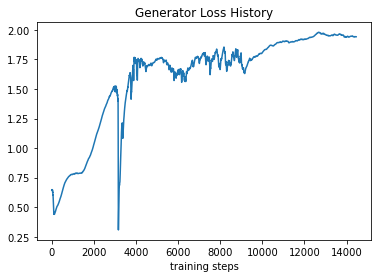

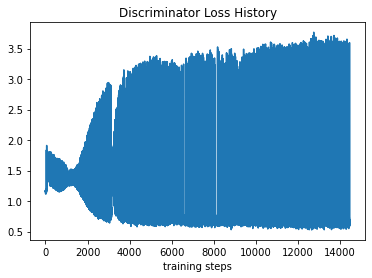

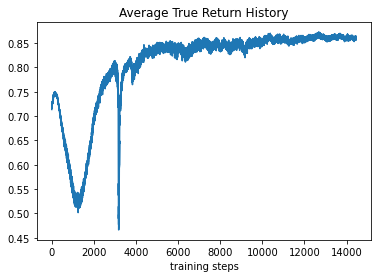

In [78]:
x = range(len(gen_loss_history))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('training steps')

x = range(len(disc_loss_history))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('training steps')

x = range(len(average_true_return_history))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(x, average_true_return_history)
plt.title('Average True Return History')
plt.xlabel('training steps')

In [80]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/rcgan'
if not os.path.exists(model_save_dir + '/trained_G_weights'):
    os.makedirs(model_save_dir + '/trained_G_weights')

G_save_path = model_save_dir + '/trained_G_weights/model.tf'
G.save_weights(G_save_path)

if not os.path.exists(model_save_dir + '/trained_D_weights'):
    os.makedirs(model_save_dir + '/trained_D_weights')

D_save_path = model_save_dir + '/trained_D_weights/model.tf'
D.save_weights(D_save_path)